# Imports

In [74]:
!pip install tensorflow_addons imbalanced-learn sentence_transformers -q
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import re
import numpy as np
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import expand_dims
from tensorflow_addons.metrics import F1Score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Data

In [75]:
# Labelled data
labelled=pd.read_csv('labelled_data.csv')
labelled.drop('Unnamed: 0', axis=1, inplace=True)

# Unlabelled data
unlabelled=pd.read_csv('unlabelled_data.csv')

# Removing labelled sentences from unlabelled dataset
mask = unlabelled['country'].isin(labelled['country']) & unlabelled['year'].isin(labelled['year']) & unlabelled['doc_id'].isin(labelled['doc_id'])
unlabelled = unlabelled[~mask]
unlabelled.drop('Unnamed: 0', axis=1, inplace=True)

## Frequency count of labels

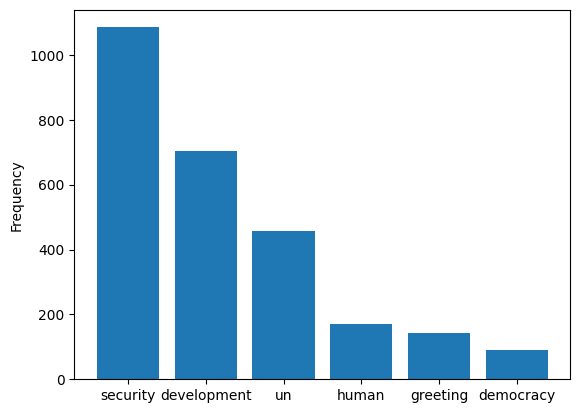

In [76]:
freq = labelled['coding'].value_counts()
plt.bar(freq.index, freq.values)
plt.ylabel('Frequency')
plt.show()

# Preprocess Data


1. Remove stopwords (the, a , an...).
2. Remove punctuation (:, , ., ?...).
3. Remove Numbers (1, 199, 12)
4. Remove whitespaces.
5. Converting words into lowercase
6. Tokenization (sentence -> list of words)
7. Generate word embeddings using BERT

In [77]:
class Preprocessor:
  '''
    Removes punctuations, numbers, whitespaces
    Converts sentences into lower case
  '''

  def __init__(self, numbers=True, punct=True, stopwords=True, empty_sentence=True, model='bert-base-nli-mean-tokens'):
    self.numbers = numbers
    self.punct = punct
    self.stopwords = stopwords
    self.empty_sentence = empty_sentence
    self.model = SentenceTransformer(model)

  def apply(self, sentence):
    sentence = sentence.lower()
    if self.numbers:
      sentence = Preprocessor.remove_numbers(sentence)

    if self.punct: 
      sentence = Preprocessor.remove_punct(sentence)

    if self.stopwords: 
      sentence = Preprocessor.remove_stopwords(sentence)

    if self.empty_sentence: 
      sentence = Preprocessor.empty_sentence(sentence)

    if sentence!=None:
        sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
  
  @staticmethod
  def remove_punct(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence
  
  @staticmethod
  def remove_numbers(sentence):
    sentence = re.sub(r'[0-9]', '', sentence)
    return sentence

  @staticmethod
  def remove_stopwords(sentence):
    sentence_clean = ' '.join( [ word for word in sentence.split() if word.lower() not in set( stopwords.words('english') ) ] )
    return sentence_clean

  
  @staticmethod
  def empty_sentence(sentence):
    words=sentence.split()
    if (not all(elem == "" for elem in sentence)) and len(sentence)>2:
        return sentence
    else:
        return None

  def get_embedding(self, sentence):
      return self.model.encode(sentence)
processor = Preprocessor()

In [78]:
# Labelled Data
labelled_cleaned=labelled.copy()
labelled_cleaned['text_clean']=labelled_cleaned['text'].apply(processor.apply)
labelled_cleaned.dropna(inplace=True)
labelled_cleaned.reset_index(inplace=True, drop=True)
labelled_cleaned['embeddings']=labelled_cleaned['text_clean'].apply(processor.get_embedding)

In [79]:
# Unlabelled Data
unlabelled_cleaned=unlabelled.sample(20000)
unlabelled_cleaned['text_clean']=unlabelled_cleaned['text'].apply(processor.apply)
unlabelled_cleaned.dropna(inplace=True)
unlabelled_cleaned.reset_index(inplace=True, drop=True)
unlabelled_cleaned['embeddings']=unlabelled_cleaned['text_clean'].apply(processor.get_embedding)

In [80]:
labels_enc = {'democracy':0, 'development':1, 'greeting':2, 'human':3, 'security':4, 'un':5}
labels_dec = {0:'democracy', 1:'development', 2:'greeting', 3:'human', 4:'security', 5:'un'}
labelled_cleaned['coding']=labelled_cleaned['coding'].replace(labels_enc)
labelled_cleaned['coding'].values

array([2, 2, 2, ..., 3, 0, 5])

# Classifier 1

In [81]:
input_shape=768
output_shape=6

X_train = np.stack(labelled_cleaned['embeddings'].tolist())
y_train = to_categorical(labelled_cleaned['coding'].values, num_classes=output_shape)

In [82]:
X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train, y_train, test_size=0.05)
oversample = SMOTE()
X_train_split, y_train_split = oversample.fit_resample(X_train_split, y_train_split)

In [83]:
inputs = Input(shape=(input_shape,))
hidden_layer = Dense(64, activation='relu')(inputs)
hidden_layer2 = Dense(32, activation='relu')(hidden_layer)
outputs = Dense(output_shape, activation='softmax')(hidden_layer2)
model_nn = Model(inputs=inputs, outputs=outputs)
model_nn.summary()
optimizer = Adam(1e-5)

model_nn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', F1Score(num_classes=len(labels_enc))])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_8 (Dense)             (None, 64)                49216     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 6)                 198       
                                                                 
Total params: 51,494
Trainable params: 51,494
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model_nn.fit(X_train_split, y_train_split, epochs=500, batch_size=16, validation_data=(X_eval, y_eval) )

Epoch 1/500
383/383 [==============================] - 2s 3ms/step - loss: 1.8440 - accuracy: 0.2177 - f1_score: 0.1700 - val_loss: 1.7285 - val_accuracy: 0.3459 - val_f1_score: 0.2424
Epoch 2/500
383/383 [==============================] - 1s 3ms/step - loss: 1.6893 - accuracy: 0.3279 - f1_score: 0.2658 - val_loss: 1.6577 - val_accuracy: 0.4436 - val_f1_score: 0.3365
Epoch 3/500
383/383 [==============================] - 1s 3ms/step - loss: 1.5891 - accuracy: 0.4055 - f1_score: 0.3572 - val_loss: 1.6009 - val_accuracy: 0.4887 - val_f1_score: 0.3566
Epoch 4/500
383/383 [==============================] - 1s 4ms/step - loss: 1.5050 - accuracy: 0.4534 - f1_score: 0.4240 - val_loss: 1.5458 - val_accuracy: 0.5263 - val_f1_score: 0.4043
Epoch 5/500
383/383 [==============================] - 1s 4ms/step - loss: 1.4308 - accuracy: 0.4987 - f1_score: 0.4834 - val_loss: 1.5026 - val_accuracy: 0.5263 - val_f1_score: 0.4105
Epoch 6/500
383/383 [==============================] - 1s 3ms/step - loss: 

## Saving model weights

In [87]:
model_nn.save_weights('first_classifier')
unlabelled = unlabelled_cleaned.copy()

In [88]:
unlabelled.head(25)

doc_id                                               text  \
0    GBR_54_1999.txt.34  sanctuary to refugees in every corner of the w...   
1   KGZ_59_2004.txt.184  important factor in its democratic reorganizat...   
2   LBR_64_2009.txt.249  posing humanitarian challenges that require ur...   
3   BTN_51_1996.txt.158  and Japan qualify for permanent membership of the   
4    GRC_65_2010.txt.61  effective and efficient Human Rights Council with   
5    JAM_43_1988.txt.57  We urge all Member States to implement the rec...   
6   KIR_63_2008.txt.307      We acknowledge the ability of certain members   
7    BRN_57_2002.txt.27                               peace in our region.   
8   BLZ_48_1993.txt.163  complex and challenqinq assignments around the...   
9    BRN_56_2001.txt.58  believe it must involve new approaches to secu...   
10   LBR_67_2012.txt.95                           2015 Development Agenda.   
11  NOR_37_1982.txt.320        follow- up to the second special session on   
12   LAO_49_1994.txt.19  The world is following closely the disturbing ...   
13   BIH_67_2012.txt.72  The best way to honour the victims of the Sreb...   
14   MDG_58_2003.txt.51  commitments to peace and security, in a spirit of   
15  GMB_49_1994.txt.299  Bosnian Serbs have persisted with their heinou...   
16  SEN_50_1995.txt.293  requirement of our modern times that, in view ...   
17   NZL_58_2003.txt.78         New Zealand has, since 1972, supported the   
18   RWA_48_1993.txt.58  enjoyment of life for those for whom the horiz...   
19   BRN_66_2011.txt.23                                           century.   
20  NPL_64_2009.txt.427      We are concerned about the continued deadlock   
21  LIE_64_2009.txt.172                      principle of complementarity.   
22  KWT_47_1992.txt.321                                       Guaranteeing   
23  IRN_69_2014.txt.336  in recent years in the context of an Iranophob...   
24   PRT_38_1983.txt.63  The General Committee, when deferring the deba...   

   country  year                                         text_clean  \
0      GBR  1999              sanctuary refugees every corner world   
1      KGZ  2004         important factor democratic reorganization   
2      LBR  2009      posing humanitarian challenges require urgent   
3      BTN  1996                 japan qualify permanent membership   
4      GRC  2010           effective efficient human rights council   
5      JAM  1988  urge member states implement recommendations f...   
6      KIR  2008                acknowledge ability certain members   
7      BRN  2002                                       peace region   
8      BLZ  1993       complex challenqinq assignments around globe   
9      BRN  2001       believe must involve new approaches security   
10     LBR  2012                                 development agenda   
11     NOR  1982                      follow second special session   
12     LAO  1994  world following closely disturbing humanitaria...   
13     BIH  2012                 best way honour victims srebrenica   
14     MDG  2003                  commitments peace security spirit   
15     GMB  1994             bosnian serbs persisted heinous policy   
16     SEN  1995                      requirement modern times view   
17     NZL  2003                        new zealand since supported   
18     RWA  1993                       enjoyment life horizon seems   
19     BRN  2011                                            century   
20     NPL  2009                       concerned continued deadlock   
21     LIE  2009                          principle complementarity   
22     KWT  1992                                       guaranteeing   
23     IRN  2014           recent years context iranophobic project   
24     PRT  1983  general committee deferring debate thirty nint...   

                                           embeddings  
0   [-0.17516388, 0.6715528, 1.2831515, 0.55258346...  
1   [-0.6345772, -0.2559768, 

In [89]:
batch_size = 20000
unlabelled_X = list(unlabelled['text_clean'][0:batch_size])

## Generating pseudo labels for 20k rows

In [90]:
psuedo_preds = []
for sentence in tqdm(unlabelled_X):
  encoded_sent = processor.get_embedding(sentence)
  psuedo_preds.append(labels_dec[np.argmax(model_nn.predict(expand_dims(encoded_sent, axis=0)))])

  0%|          | 0/18573 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step


  0%|          | 1/18573 [00:00<1:13:48,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/18573 [00:00<58:21,  5.30it/s]  

1/1 [==============================] - 0s 26ms/step


  0%|          | 3/18573 [00:00<55:39,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 4/18573 [00:00<53:31,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 5/18573 [00:00<53:00,  5.84it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 6/18573 [00:01<1:03:18,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 7/18573 [00:01<1:00:12,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 8/18573 [00:01<56:16,  5.50it/s]  

1/1 [==============================] - 0s 22ms/step


  0%|          | 9/18573 [00:01<55:40,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 10/18573 [00:01<54:52,  5.64it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 11/18573 [00:01<53:19,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 12/18573 [00:02<52:19,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 13/18573 [00:02<51:50,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 14/18573 [00:02<52:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 15/18573 [00:02<52:29,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 16/18573 [00:02<52:53,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 17/18573 [00:03<52:48,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 18/18573 [00:03<53:17,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 19/18573 [00:03<53:01,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 20/18573 [00:03<51:59,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 21/18573 [00:03<53:16,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 22/18573 [00:03<51:33,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 23/18573 [00:04<51:09,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 24/18573 [00:04<55:09,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 25/18573 [00:04<1:02:28,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 26/18573 [00:04<1:05:23,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 27/18573 [00:04<1:00:21,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 28/18573 [00:05<59:00,  5.24it/s]  

1/1 [==============================] - 0s 23ms/step


  0%|          | 29/18573 [00:05<56:03,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 30/18573 [00:05<54:34,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 31/18573 [00:05<52:46,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 32/18573 [00:05<50:24,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 33/18573 [00:05<54:06,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 34/18573 [00:06<53:42,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 35/18573 [00:06<53:54,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 36/18573 [00:06<50:59,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 37/18573 [00:06<51:19,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 38/18573 [00:06<49:24,  6.25it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 39/18573 [00:06<55:02,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 40/18573 [00:07<53:45,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 41/18573 [00:07<52:45,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 42/18573 [00:07<52:12,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 43/18573 [00:07<50:55,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 44/18573 [00:07<50:04,  6.17it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 45/18573 [00:07<49:33,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 46/18573 [00:08<49:36,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 47/18573 [00:08<49:44,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 48/18573 [00:08<48:51,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 49/18573 [00:08<48:53,  6.31it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 50/18573 [00:08<52:41,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 51/18573 [00:08<58:34,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 52/18573 [00:09<1:06:52,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 53/18573 [00:09<1:00:58,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 54/18573 [00:09<57:26,  5.37it/s]  

1/1 [==============================] - 0s 22ms/step


  0%|          | 55/18573 [00:09<54:22,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 56/18573 [00:09<52:41,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 57/18573 [00:10<56:52,  5.43it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 58/18573 [00:10<59:17,  5.20it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 59/18573 [00:10<1:01:15,  5.04it/s]

1/1 [==============================] - 0s 53ms/step


  0%|          | 60/18573 [00:10<1:05:51,  4.68it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 61/18573 [00:10<1:07:17,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 62/18573 [00:11<1:07:39,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 63/18573 [00:11<1:07:47,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 64/18573 [00:11<1:06:19,  4.65it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 65/18573 [00:11<1:06:29,  4.64it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 66/18573 [00:12<1:09:33,  4.43it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 67/18573 [00:12<1:08:17,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 68/18573 [00:12<1:12:06,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 69/18573 [00:12<1:12:52,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 70/18573 [00:12<1:10:04,  4.40it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 71/18573 [00:13<1:19:46,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 72/18573 [00:13<1:18:16,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 73/18573 [00:13<1:15:29,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 74/18573 [00:13<1:11:44,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 75/18573 [00:14<1:09:13,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 76/18573 [00:14<1:08:34,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 77/18573 [00:14<1:02:29,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 78/18573 [00:14<57:59,  5.32it/s]  

1/1 [==============================] - 0s 22ms/step


  0%|          | 79/18573 [00:14<1:00:14,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 80/18573 [00:15<57:39,  5.35it/s]  

1/1 [==============================] - 0s 27ms/step


  0%|          | 81/18573 [00:15<55:51,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 82/18573 [00:15<54:00,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 83/18573 [00:15<51:51,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 84/18573 [00:15<50:39,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 85/18573 [00:15<52:15,  5.90it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 86/18573 [00:16<52:32,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 87/18573 [00:16<51:19,  6.00it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 88/18573 [00:16<51:16,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 89/18573 [00:16<49:52,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 90/18573 [00:16<49:55,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 91/18573 [00:16<50:49,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 92/18573 [00:17<50:04,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 93/18573 [00:17<51:07,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 94/18573 [00:17<55:17,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 95/18573 [00:17<58:41,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 96/18573 [00:17<56:43,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 97/18573 [00:17<54:03,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 98/18573 [00:18<54:12,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 99/18573 [00:18<52:44,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 100/18573 [00:18<53:00,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 101/18573 [00:18<51:28,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 102/18573 [00:18<50:03,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 103/18573 [00:18<51:42,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 104/18573 [00:19<50:48,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 105/18573 [00:19<50:50,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 106/18573 [00:19<53:12,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 107/18573 [00:19<52:12,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 108/18573 [00:19<50:49,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 109/18573 [00:19<49:39,  6.20it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 110/18573 [00:20<50:05,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 111/18573 [00:20<49:28,  6.22it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 112/18573 [00:20<1:02:21,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 113/18573 [00:20<58:41,  5.24it/s]  

1/1 [==============================] - 0s 21ms/step


  1%|          | 114/18573 [00:20<55:28,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 115/18573 [00:21<53:26,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 116/18573 [00:21<56:18,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 117/18573 [00:21<53:12,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 118/18573 [00:21<51:44,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 119/18573 [00:21<50:06,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 120/18573 [00:21<50:15,  6.12it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 121/18573 [00:22<51:10,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 122/18573 [00:22<50:23,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 123/18573 [00:22<54:48,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 124/18573 [00:22<53:14,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 125/18573 [00:22<53:42,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 126/18573 [00:22<51:54,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 127/18573 [00:23<51:04,  6.02it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 128/18573 [00:23<50:43,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 129/18573 [00:23<50:02,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 130/18573 [00:23<52:28,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 131/18573 [00:23<52:39,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 132/18573 [00:23<51:18,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 133/18573 [00:24<50:21,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 134/18573 [00:24<56:23,  5.45it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 135/18573 [00:24<56:08,  5.47it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 136/18573 [00:24<1:01:15,  5.02it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 137/18573 [00:25<1:08:34,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 138/18573 [00:25<1:07:32,  4.55it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 139/18573 [00:25<1:07:47,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 140/18573 [00:25<1:16:59,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 141/18573 [00:26<1:18:10,  3.93it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 142/18573 [00:26<1:14:27,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 143/18573 [00:26<1:16:33,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 144/18573 [00:26<1:17:52,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 145/18573 [00:27<1:24:07,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 146/18573 [00:27<1:26:36,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 147/18573 [00:27<1:22:22,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 148/18573 [00:27<1:21:56,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 149/18573 [00:28<1:19:56,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 150/18573 [00:28<1:16:12,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 151/18573 [00:28<1:18:00,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 152/18573 [00:28<1:18:13,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 153/18573 [00:29<1:14:13,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 154/18573 [00:29<1:07:30,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 155/18573 [00:29<1:02:06,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 156/18573 [00:29<1:05:54,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 157/18573 [00:29<1:01:47,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 158/18573 [00:30<58:48,  5.22it/s]  

1/1 [==============================] - 0s 26ms/step


  1%|          | 159/18573 [00:30<57:30,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 160/18573 [00:30<53:43,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 161/18573 [00:30<54:01,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 162/18573 [00:30<53:03,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 163/18573 [00:30<53:26,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 164/18573 [00:31<52:21,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 165/18573 [00:31<51:57,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 166/18573 [00:31<56:41,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 167/18573 [00:31<54:21,  5.64it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 168/18573 [00:31<56:18,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 169/18573 [00:31<54:06,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 170/18573 [00:32<53:00,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 171/18573 [00:32<53:17,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 172/18573 [00:32<52:05,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 173/18573 [00:32<51:13,  5.99it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 174/18573 [00:32<52:54,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 175/18573 [00:32<52:24,  5.85it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 176/18573 [00:33<51:45,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 177/18573 [00:33<50:27,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 178/18573 [00:33<53:10,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 179/18573 [00:33<51:56,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 180/18573 [00:33<52:14,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 181/18573 [00:33<51:44,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 182/18573 [00:34<50:35,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 183/18573 [00:34<53:05,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 184/18573 [00:34<52:14,  5.87it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 185/18573 [00:34<51:28,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 186/18573 [00:34<56:54,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 187/18573 [00:35<56:10,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 188/18573 [00:35<57:07,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 189/18573 [00:35<54:08,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 190/18573 [00:35<52:25,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 191/18573 [00:35<52:58,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 192/18573 [00:35<52:40,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 193/18573 [00:36<51:39,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 194/18573 [00:36<50:12,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 195/18573 [00:36<49:48,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 196/18573 [00:36<48:41,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 197/18573 [00:36<50:08,  6.11it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 198/18573 [00:36<52:50,  5.80it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 199/18573 [00:37<51:28,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 200/18573 [00:37<51:30,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 201/18573 [00:37<50:02,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 202/18573 [00:37<49:10,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 203/18573 [00:37<48:28,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 204/18573 [00:37<50:13,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 205/18573 [00:38<54:47,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 206/18573 [00:38<58:52,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 207/18573 [00:38<59:09,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 208/18573 [00:38<56:11,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 209/18573 [00:38<55:59,  5.47it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 210/18573 [00:39<56:41,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 211/18573 [00:39<58:11,  5.26it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 212/18573 [00:39<1:00:06,  5.09it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 213/18573 [00:39<1:00:16,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 214/18573 [00:39<1:01:03,  5.01it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 215/18573 [00:40<1:04:11,  4.77it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 216/18573 [00:40<1:08:31,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 217/18573 [00:40<1:10:47,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 218/18573 [00:40<1:10:42,  4.33it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 219/18573 [00:41<1:19:47,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 220/18573 [00:41<1:16:42,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 221/18573 [00:41<1:17:06,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 222/18573 [00:41<1:14:49,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 223/18573 [00:42<1:16:49,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 224/18573 [00:42<1:18:31,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 225/18573 [00:42<1:16:00,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 226/18573 [00:42<1:13:59,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 227/18573 [00:43<1:14:41,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 228/18573 [00:43<1:12:44,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 229/18573 [00:43<1:18:33,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 230/18573 [00:43<1:16:41,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 231/18573 [00:44<1:12:05,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 232/18573 [00:44<1:06:07,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 233/18573 [00:44<1:01:37,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 234/18573 [00:44<57:06,  5.35it/s]  

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 235/18573 [00:44<1:01:29,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 236/18573 [00:44<57:24,  5.32it/s]  

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 237/18573 [00:45<56:09,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 238/18573 [00:45<57:27,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 239/18573 [00:45<54:41,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 240/18573 [00:45<56:16,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 241/18573 [00:45<53:17,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 242/18573 [00:45<52:05,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 243/18573 [00:46<50:22,  6.07it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 244/18573 [00:46<51:54,  5.89it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 245/18573 [00:46<51:14,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 246/18573 [00:46<49:18,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 247/18573 [00:46<49:51,  6.13it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 248/18573 [00:46<49:52,  6.12it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 249/18573 [00:47<49:56,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 250/18573 [00:47<50:08,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 251/18573 [00:47<51:27,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 252/18573 [00:47<52:06,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 253/18573 [00:47<53:46,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 254/18573 [00:47<52:11,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 255/18573 [00:48<51:43,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 256/18573 [00:48<50:10,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 257/18573 [00:48<50:36,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 258/18573 [00:48<49:49,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 259/18573 [00:48<49:18,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 260/18573 [00:48<49:41,  6.14it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 261/18573 [00:49<51:01,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 262/18573 [00:49<52:20,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 263/18573 [00:49<52:14,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 264/18573 [00:49<52:16,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 265/18573 [00:49<56:31,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 266/18573 [00:50<58:44,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 267/18573 [00:50<1:04:46,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 268/18573 [00:50<1:01:01,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 269/18573 [00:50<57:11,  5.33it/s]  

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 270/18573 [00:50<56:02,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 271/18573 [00:50<53:44,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 272/18573 [00:51<53:50,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 273/18573 [00:51<51:58,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 274/18573 [00:51<51:34,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 275/18573 [00:51<51:56,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 276/18573 [00:51<51:26,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 277/18573 [00:51<51:29,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 278/18573 [00:52<50:04,  6.09it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 279/18573 [00:52<51:11,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 280/18573 [00:52<53:27,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 281/18573 [00:52<53:30,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 282/18573 [00:52<51:56,  5.87it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 283/18573 [00:53<52:11,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 284/18573 [00:53<50:02,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 285/18573 [00:53<49:27,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 286/18573 [00:53<51:25,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 287/18573 [00:53<1:11:17,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 288/18573 [00:54<1:10:29,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 289/18573 [00:54<1:11:33,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 290/18573 [00:54<1:10:16,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 291/18573 [00:54<1:08:36,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 292/18573 [00:55<1:07:15,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 293/18573 [00:55<1:06:49,  4.56it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 294/18573 [00:55<1:07:32,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 295/18573 [00:55<1:10:11,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 296/18573 [00:55<1:10:35,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 297/18573 [00:56<1:12:42,  4.19it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 298/18573 [00:56<1:14:12,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 299/18573 [00:56<1:12:03,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 300/18573 [00:57<1:25:41,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 301/18573 [00:57<1:21:49,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 302/18573 [00:57<1:19:21,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 303/18573 [00:57<1:23:53,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 304/18573 [00:58<1:19:37,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 305/18573 [00:58<1:18:59,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 306/18573 [00:58<1:19:53,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 307/18573 [00:58<1:11:26,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 308/18573 [00:58<1:06:51,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 309/18573 [00:59<1:02:18,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 310/18573 [00:59<57:50,  5.26it/s]  

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 311/18573 [00:59<55:00,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 312/18573 [00:59<52:38,  5.78it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 313/18573 [00:59<53:05,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 314/18573 [00:59<52:21,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 315/18573 [01:00<52:38,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 316/18573 [01:00<57:57,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 317/18573 [01:00<55:46,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 318/18573 [01:00<54:01,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 319/18573 [01:00<52:50,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 320/18573 [01:01<52:09,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 321/18573 [01:01<50:29,  6.02it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 322/18573 [01:01<53:36,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 323/18573 [01:01<54:25,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 324/18573 [01:01<53:42,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 325/18573 [01:01<56:47,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 326/18573 [01:02<57:34,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 327/18573 [01:02<54:56,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 328/18573 [01:02<54:02,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 329/18573 [01:02<52:34,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 330/18573 [01:02<56:52,  5.35it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 331/18573 [01:03<56:29,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 332/18573 [01:03<56:42,  5.36it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 333/18573 [01:03<1:01:15,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 334/18573 [01:03<59:06,  5.14it/s]  

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 335/18573 [01:03<58:52,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 336/18573 [01:04<1:00:17,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 337/18573 [01:04<1:03:33,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 338/18573 [01:04<1:00:26,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 339/18573 [01:04<1:02:26,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 340/18573 [01:04<1:05:02,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 341/18573 [01:05<1:00:17,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 342/18573 [01:05<58:18,  5.21it/s]  

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 343/18573 [01:05<56:42,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 344/18573 [01:05<54:51,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 345/18573 [01:05<52:48,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 346/18573 [01:05<53:51,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 347/18573 [01:06<53:49,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 348/18573 [01:06<53:55,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 349/18573 [01:06<51:48,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 350/18573 [01:06<52:59,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 351/18573 [01:06<53:39,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 352/18573 [01:06<54:30,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 353/18573 [01:07<57:06,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 354/18573 [01:07<55:07,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 355/18573 [01:07<53:23,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 356/18573 [01:07<54:11,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 357/18573 [01:07<52:53,  5.74it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 358/18573 [01:08<54:07,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 359/18573 [01:08<53:17,  5.70it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 360/18573 [01:08<53:28,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 361/18573 [01:08<54:55,  5.53it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 362/18573 [01:08<57:50,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 363/18573 [01:09<1:03:49,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 364/18573 [01:09<1:08:55,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 365/18573 [01:09<1:13:36,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 366/18573 [01:09<1:12:18,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 367/18573 [01:10<1:13:47,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 368/18573 [01:10<1:11:08,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 369/18573 [01:10<1:12:05,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 370/18573 [01:10<1:08:43,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 371/18573 [01:10<1:09:14,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 372/18573 [01:11<1:11:26,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 373/18573 [01:11<1:11:34,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 374/18573 [01:11<1:09:53,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 375/18573 [01:11<1:09:41,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 376/18573 [01:12<1:09:56,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 377/18573 [01:12<1:16:30,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 378/18573 [01:12<1:15:34,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 379/18573 [01:12<1:13:12,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 380/18573 [01:13<1:11:53,  4.22it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 381/18573 [01:13<1:15:35,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 382/18573 [01:13<1:13:38,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 383/18573 [01:13<1:05:57,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 384/18573 [01:14<1:04:54,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 385/18573 [01:14<1:07:57,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 386/18573 [01:14<1:01:14,  4.95it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 387/18573 [01:14<1:00:29,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 388/18573 [01:14<57:52,  5.24it/s]  

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 389/18573 [01:14<59:05,  5.13it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 390/18573 [01:15<56:36,  5.35it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 391/18573 [01:15<55:00,  5.51it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 392/18573 [01:15<54:07,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 393/18573 [01:15<54:14,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 394/18573 [01:15<52:19,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 395/18573 [01:15<50:23,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 396/18573 [01:16<51:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 397/18573 [01:16<51:44,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 398/18573 [01:16<50:22,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 399/18573 [01:16<49:32,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 400/18573 [01:16<49:12,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 401/18573 [01:16<52:37,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 402/18573 [01:17<53:25,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 403/18573 [01:17<52:13,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 404/18573 [01:17<54:48,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 405/18573 [01:17<53:52,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 406/18573 [01:17<56:10,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 407/18573 [01:18<55:15,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 408/18573 [01:18<54:49,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 409/18573 [01:18<56:25,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 410/18573 [01:18<56:35,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 411/18573 [01:18<55:03,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 412/18573 [01:18<54:20,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 413/18573 [01:19<56:03,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 414/18573 [01:19<54:53,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 415/18573 [01:19<53:01,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 416/18573 [01:19<52:44,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 417/18573 [01:19<51:59,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 418/18573 [01:20<51:43,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 419/18573 [01:20<51:16,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 420/18573 [01:20<1:00:53,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 421/18573 [01:20<58:01,  5.21it/s]  

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 422/18573 [01:20<55:18,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 423/18573 [01:20<54:00,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 424/18573 [01:21<56:31,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 425/18573 [01:21<54:24,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 426/18573 [01:21<1:01:36,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 427/18573 [01:21<57:05,  5.30it/s]  

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 428/18573 [01:21<55:44,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 429/18573 [01:22<53:56,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 430/18573 [01:22<53:53,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 431/18573 [01:22<52:26,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 432/18573 [01:22<50:49,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 433/18573 [01:22<52:12,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 434/18573 [01:22<51:16,  5.90it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 435/18573 [01:23<53:02,  5.70it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 436/18573 [01:23<52:21,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 437/18573 [01:23<53:31,  5.65it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 438/18573 [01:23<54:29,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 439/18573 [01:23<58:59,  5.12it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 440/18573 [01:24<1:03:27,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 441/18573 [01:24<1:02:53,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 442/18573 [01:24<1:03:42,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 443/18573 [01:24<1:12:46,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 444/18573 [01:25<1:10:29,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 445/18573 [01:25<1:08:52,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 446/18573 [01:25<1:20:50,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 447/18573 [01:25<1:25:04,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 448/18573 [01:26<1:21:25,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 449/18573 [01:26<1:17:06,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 450/18573 [01:26<1:17:10,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 451/18573 [01:27<1:21:48,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 452/18573 [01:27<1:20:03,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 453/18573 [01:27<1:17:35,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 454/18573 [01:27<1:21:42,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 455/18573 [01:28<1:19:01,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 456/18573 [01:28<1:19:15,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 457/18573 [01:28<1:15:00,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 458/18573 [01:28<1:11:22,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 459/18573 [01:28<1:03:33,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 460/18573 [01:29<1:00:57,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 461/18573 [01:29<57:59,  5.21it/s]  

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 462/18573 [01:29<53:52,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 463/18573 [01:29<52:23,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 464/18573 [01:29<53:31,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 465/18573 [01:29<52:54,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 466/18573 [01:30<52:20,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 467/18573 [01:30<52:59,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 468/18573 [01:30<55:54,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 469/18573 [01:30<55:50,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 470/18573 [01:30<54:13,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 471/18573 [01:30<54:34,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 472/18573 [01:31<54:24,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 473/18573 [01:31<52:42,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 474/18573 [01:31<52:31,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 475/18573 [01:31<51:32,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 476/18573 [01:31<52:10,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 477/18573 [01:32<53:00,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 478/18573 [01:32<51:40,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 479/18573 [01:32<50:46,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 480/18573 [01:32<49:59,  6.03it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 481/18573 [01:32<50:43,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 482/18573 [01:32<52:25,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 483/18573 [01:33<51:28,  5.86it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 484/18573 [01:33<51:33,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 485/18573 [01:33<51:27,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 486/18573 [01:33<50:50,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 487/18573 [01:33<49:41,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 488/18573 [01:33<53:53,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 489/18573 [01:34<52:07,  5.78it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 490/18573 [01:34<54:07,  5.57it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 491/18573 [01:35<2:50:06,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 492/18573 [01:35<2:16:43,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 493/18573 [01:36<1:54:50,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 494/18573 [01:36<1:35:58,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 495/18573 [01:36<1:23:17,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 496/18573 [01:36<1:14:03,  4.07it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 497/18573 [01:36<1:10:07,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 498/18573 [01:37<1:05:08,  4.62it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 499/18573 [01:37<1:06:12,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 500/18573 [01:37<1:04:40,  4.66it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 501/18573 [01:37<1:03:38,  4.73it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 502/18573 [01:37<1:02:25,  4.83it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 503/18573 [01:38<59:07,  5.09it/s]  

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 504/18573 [01:38<57:42,  5.22it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 505/18573 [01:38<55:52,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 506/18573 [01:38<58:26,  5.15it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 507/18573 [01:38<1:04:08,  4.69it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 508/18573 [01:39<1:10:27,  4.27it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 509/18573 [01:39<1:12:30,  4.15it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 510/18573 [01:39<1:12:18,  4.16it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 511/18573 [01:39<1:15:44,  3.97it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 512/18573 [01:40<1:16:19,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 513/18573 [01:40<1:13:49,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 514/18573 [01:40<1:10:55,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 515/18573 [01:40<1:11:33,  4.21it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 516/18573 [01:41<1:14:49,  4.02it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 517/18573 [01:41<1:15:46,  3.97it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 518/18573 [01:41<1:18:56,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 519/18573 [01:41<1:17:23,  3.89it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 520/18573 [01:42<1:16:38,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 521/18573 [01:42<1:17:57,  3.86it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 522/18573 [01:42<1:16:25,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 523/18573 [01:42<1:19:56,  3.76it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 524/18573 [01:43<1:30:36,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 525/18573 [01:43<1:24:40,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 526/18573 [01:43<1:24:47,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 527/18573 [01:44<1:16:06,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 528/18573 [01:44<1:10:44,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 529/18573 [01:44<1:07:30,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 530/18573 [01:44<1:07:01,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 531/18573 [01:44<1:09:21,  4.34it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 532/18573 [01:45<1:09:43,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 533/18573 [01:45<1:04:40,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 534/18573 [01:45<1:05:04,  4.62it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 535/18573 [01:45<1:03:01,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 536/18573 [01:45<59:46,  5.03it/s]  

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 537/18573 [01:46<58:31,  5.14it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 538/18573 [01:46<58:46,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 539/18573 [01:46<57:49,  5.20it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 540/18573 [01:46<56:45,  5.29it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 541/18573 [01:46<1:03:57,  4.70it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 542/18573 [01:47<1:02:19,  4.82it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 543/18573 [01:47<1:02:09,  4.83it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 544/18573 [01:47<1:03:05,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 545/18573 [01:47<1:05:18,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 546/18573 [01:48<1:04:52,  4.63it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 547/18573 [01:48<1:04:21,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 548/18573 [01:48<1:04:39,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 549/18573 [01:48<1:01:41,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 550/18573 [01:48<58:58,  5.09it/s]  

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 551/18573 [01:48<59:22,  5.06it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 552/18573 [01:49<58:49,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 553/18573 [01:49<1:00:22,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 554/18573 [01:49<58:08,  5.17it/s]  

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 555/18573 [01:49<57:09,  5.25it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 556/18573 [01:49<56:58,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 557/18573 [01:50<55:57,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 558/18573 [01:50<58:12,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 559/18573 [01:50<55:13,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 560/18573 [01:50<57:39,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 561/18573 [01:50<56:36,  5.30it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 562/18573 [01:51<56:34,  5.31it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 563/18573 [01:51<55:49,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 564/18573 [01:51<54:07,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 565/18573 [01:51<53:19,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 566/18573 [01:51<51:41,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 567/18573 [01:51<51:23,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 568/18573 [01:52<53:20,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 569/18573 [01:52<57:41,  5.20it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 570/18573 [01:52<55:19,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 571/18573 [01:52<54:23,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 572/18573 [01:52<53:43,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 573/18573 [01:53<53:54,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 574/18573 [01:53<51:12,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 575/18573 [01:53<53:07,  5.65it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 576/18573 [01:53<54:49,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 577/18573 [01:53<1:01:55,  4.84it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 578/18573 [01:54<1:04:06,  4.68it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 579/18573 [01:54<1:06:36,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 580/18573 [01:54<1:06:49,  4.49it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 581/18573 [01:54<1:06:14,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 582/18573 [01:54<1:06:08,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 583/18573 [01:55<1:06:45,  4.49it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 584/18573 [01:55<1:09:09,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 585/18573 [01:55<1:07:23,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 586/18573 [01:55<1:11:35,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 587/18573 [01:56<1:27:27,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 588/18573 [01:56<1:26:26,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 589/18573 [01:56<1:19:43,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 590/18573 [01:57<1:24:51,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 591/18573 [01:57<1:22:35,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 592/18573 [01:57<1:22:06,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 593/18573 [01:57<1:19:29,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 594/18573 [01:58<1:17:56,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 595/18573 [01:58<1:17:17,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 596/18573 [01:58<1:13:15,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 597/18573 [01:58<1:07:31,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 598/18573 [01:59<1:10:13,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 599/18573 [01:59<1:03:10,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 600/18573 [01:59<1:00:21,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 601/18573 [01:59<59:37,  5.02it/s]  

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 602/18573 [01:59<57:56,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 603/18573 [01:59<56:58,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 604/18573 [02:00<56:41,  5.28it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 605/18573 [02:00<55:58,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 606/18573 [02:00<56:45,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 607/18573 [02:00<55:07,  5.43it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 608/18573 [02:00<59:04,  5.07it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 609/18573 [02:01<56:21,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 610/18573 [02:01<53:11,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 611/18573 [02:01<53:28,  5.60it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 612/18573 [02:01<54:28,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 613/18573 [02:01<53:41,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 614/18573 [02:01<52:11,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 615/18573 [02:02<50:58,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 616/18573 [02:02<56:51,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 617/18573 [02:02<1:00:36,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 618/18573 [02:02<58:56,  5.08it/s]  

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 619/18573 [02:02<57:29,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 620/18573 [02:03<53:53,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 621/18573 [02:03<53:09,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 622/18573 [02:03<54:40,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 623/18573 [02:03<52:01,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 624/18573 [02:03<50:55,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 625/18573 [02:03<52:33,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 626/18573 [02:04<54:11,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 627/18573 [02:04<56:14,  5.32it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 628/18573 [02:04<56:17,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 629/18573 [02:04<53:45,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 630/18573 [02:04<54:25,  5.49it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 631/18573 [02:05<53:59,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 632/18573 [02:05<52:39,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 633/18573 [02:05<51:23,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 634/18573 [02:05<50:34,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 635/18573 [02:05<50:08,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 636/18573 [02:05<49:31,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 637/18573 [02:06<48:40,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 638/18573 [02:06<48:30,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 639/18573 [02:06<51:07,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 640/18573 [02:06<52:11,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 641/18573 [02:06<52:47,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 642/18573 [02:06<56:14,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 643/18573 [02:07<54:21,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 644/18573 [02:07<54:03,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 645/18573 [02:07<53:20,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 646/18573 [02:07<50:46,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 647/18573 [02:07<52:41,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 648/18573 [02:08<51:35,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 649/18573 [02:08<51:46,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 650/18573 [02:08<50:39,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 651/18573 [02:08<1:06:02,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 652/18573 [02:08<1:07:42,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 653/18573 [02:09<1:06:28,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 654/18573 [02:09<1:06:43,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 655/18573 [02:09<1:13:15,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 656/18573 [02:09<1:09:44,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 657/18573 [02:10<1:15:29,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 658/18573 [02:10<1:12:08,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 659/18573 [02:10<1:09:33,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 660/18573 [02:10<1:08:40,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 661/18573 [02:11<1:11:08,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 662/18573 [02:11<1:09:31,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 663/18573 [02:11<1:09:36,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 664/18573 [02:11<1:11:42,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 665/18573 [02:12<1:12:09,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 666/18573 [02:12<1:13:25,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 667/18573 [02:12<1:17:58,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 668/18573 [02:12<1:16:28,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 669/18573 [02:13<1:15:51,  3.93it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 670/18573 [02:13<1:12:59,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 671/18573 [02:13<1:08:20,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 672/18573 [02:13<1:03:14,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 673/18573 [02:13<1:00:56,  4.90it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 674/18573 [02:14<1:04:05,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 675/18573 [02:14<1:00:25,  4.94it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 676/18573 [02:14<56:25,  5.29it/s]  

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 677/18573 [02:14<53:31,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 678/18573 [02:14<53:11,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 679/18573 [02:14<51:51,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 680/18573 [02:15<52:01,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 681/18573 [02:15<56:20,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 682/18573 [02:15<59:55,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 683/18573 [02:15<58:42,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 684/18573 [02:15<59:31,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 685/18573 [02:16<56:32,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 686/18573 [02:16<56:00,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 687/18573 [02:16<53:07,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 688/18573 [02:16<53:47,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 689/18573 [02:16<51:23,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 690/18573 [02:16<50:42,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 691/18573 [02:17<50:49,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 692/18573 [02:17<50:55,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 693/18573 [02:17<52:35,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 694/18573 [02:17<50:39,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 695/18573 [02:17<51:26,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 696/18573 [02:18<51:51,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 697/18573 [02:18<52:25,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 698/18573 [02:18<52:02,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 699/18573 [02:18<51:41,  5.76it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 700/18573 [02:18<52:03,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 701/18573 [02:18<50:28,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 702/18573 [02:19<50:04,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 703/18573 [02:19<51:16,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 704/18573 [02:19<50:44,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 705/18573 [02:19<49:40,  6.00it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 706/18573 [02:19<51:33,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 707/18573 [02:19<52:38,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 708/18573 [02:20<53:17,  5.59it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 709/18573 [02:20<54:39,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 710/18573 [02:20<51:29,  5.78it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 711/18573 [02:20<52:30,  5.67it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 712/18573 [02:20<51:47,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 713/18573 [02:20<50:50,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 714/18573 [02:21<50:39,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 715/18573 [02:21<52:10,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 716/18573 [02:21<52:56,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 717/18573 [02:21<51:50,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 718/18573 [02:21<50:57,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 719/18573 [02:22<52:32,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 720/18573 [02:22<52:45,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 721/18573 [02:22<51:55,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 722/18573 [02:22<50:29,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 723/18573 [02:22<51:07,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 724/18573 [02:22<49:01,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 725/18573 [02:23<49:06,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 726/18573 [02:23<49:22,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 727/18573 [02:23<52:17,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 728/18573 [02:23<1:00:24,  4.92it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 729/18573 [02:23<1:05:28,  4.54it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 730/18573 [02:24<1:07:36,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 731/18573 [02:24<1:08:22,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 732/18573 [02:24<1:09:00,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 733/18573 [02:24<1:07:54,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 734/18573 [02:25<1:11:16,  4.17it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 735/18573 [02:25<1:11:06,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 736/18573 [02:25<1:08:42,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 737/18573 [02:25<1:10:03,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 738/18573 [02:26<1:08:04,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 739/18573 [02:26<1:08:32,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 740/18573 [02:26<1:16:37,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 741/18573 [02:26<1:14:45,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 742/18573 [02:27<1:12:07,  4.12it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 743/18573 [02:27<1:11:00,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 744/18573 [02:27<1:10:59,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 745/18573 [02:27<1:24:51,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 746/18573 [02:28<1:28:20,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 747/18573 [02:28<1:22:52,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 748/18573 [02:28<1:16:28,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 749/18573 [02:28<1:08:26,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 750/18573 [02:28<1:03:45,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 751/18573 [02:29<1:03:22,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 752/18573 [02:29<58:23,  5.09it/s]  

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 753/18573 [02:29<58:10,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 754/18573 [02:29<56:09,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 755/18573 [02:29<54:49,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 756/18573 [02:30<56:49,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 757/18573 [02:30<55:25,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 758/18573 [02:30<53:50,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 759/18573 [02:30<52:51,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 760/18573 [02:30<53:27,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 761/18573 [02:30<53:31,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 762/18573 [02:31<51:53,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 763/18573 [02:31<50:15,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 764/18573 [02:31<52:18,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 765/18573 [02:31<51:40,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 766/18573 [02:31<51:12,  5.80it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 767/18573 [02:32<50:32,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 768/18573 [02:32<52:27,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 769/18573 [02:32<55:56,  5.30it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 770/18573 [02:32<56:33,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 771/18573 [02:32<54:50,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 772/18573 [02:32<53:53,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 773/18573 [02:33<56:00,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 774/18573 [02:33<53:38,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 775/18573 [02:33<52:59,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 776/18573 [02:33<53:20,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 777/18573 [02:33<52:41,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 778/18573 [02:34<54:29,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 779/18573 [02:34<54:37,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 780/18573 [02:34<54:08,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 781/18573 [02:34<54:23,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 782/18573 [02:34<52:48,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 783/18573 [02:34<52:16,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 784/18573 [02:35<52:30,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 785/18573 [02:35<53:01,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 786/18573 [02:35<52:47,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 787/18573 [02:35<52:12,  5.68it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 788/18573 [02:35<52:12,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 789/18573 [02:35<51:46,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 790/18573 [02:36<53:43,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 791/18573 [02:36<52:58,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 792/18573 [02:36<52:54,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 793/18573 [02:36<52:32,  5.64it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 794/18573 [02:36<54:29,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 795/18573 [02:37<53:05,  5.58it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 796/18573 [02:37<53:55,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 797/18573 [02:37<54:45,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 798/18573 [02:37<55:48,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 799/18573 [02:37<55:21,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 800/18573 [02:38<53:55,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 801/18573 [02:38<53:13,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 802/18573 [02:38<53:10,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 803/18573 [02:38<52:28,  5.64it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 804/18573 [02:38<57:58,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 805/18573 [02:39<1:11:31,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 806/18573 [02:39<1:25:46,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 807/18573 [02:39<1:19:10,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 808/18573 [02:39<1:16:14,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 809/18573 [02:40<1:16:08,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 810/18573 [02:40<1:13:40,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 811/18573 [02:40<1:12:23,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 812/18573 [02:40<1:10:46,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 813/18573 [02:41<1:08:41,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 814/18573 [02:41<1:13:17,  4.04it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 815/18573 [02:41<1:12:56,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 816/18573 [02:41<1:19:06,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 817/18573 [02:42<1:16:41,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 818/18573 [02:42<1:15:19,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 819/18573 [02:42<1:14:36,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 820/18573 [02:42<1:15:23,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 821/18573 [02:43<1:13:41,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 822/18573 [02:43<1:13:26,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 823/18573 [02:43<1:16:58,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 824/18573 [02:43<1:10:27,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 825/18573 [02:44<1:13:20,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 826/18573 [02:44<1:06:26,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 827/18573 [02:44<1:00:52,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 828/18573 [02:44<56:46,  5.21it/s]  

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 829/18573 [02:44<54:52,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 830/18573 [02:45<56:56,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 831/18573 [02:45<55:23,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 832/18573 [02:45<53:20,  5.54it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 833/18573 [02:45<54:31,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 834/18573 [02:45<55:34,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 835/18573 [02:46<56:09,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 836/18573 [02:46<58:08,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 837/18573 [02:46<59:16,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 838/18573 [02:46<55:58,  5.28it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 839/18573 [02:46<56:12,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 840/18573 [02:46<55:31,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 841/18573 [02:47<57:00,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 842/18573 [02:47<55:11,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 843/18573 [02:47<54:59,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 844/18573 [02:47<54:07,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 845/18573 [02:47<52:13,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 846/18573 [02:48<52:09,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 847/18573 [02:48<52:26,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 848/18573 [02:48<57:58,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 849/18573 [02:48<56:05,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 850/18573 [02:48<54:30,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 851/18573 [02:48<52:55,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 852/18573 [02:49<53:42,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 853/18573 [02:49<53:33,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 854/18573 [02:49<52:05,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 855/18573 [02:49<52:33,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 856/18573 [02:49<52:35,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 857/18573 [02:50<51:10,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 858/18573 [02:50<54:15,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 859/18573 [02:50<54:06,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 860/18573 [02:50<51:45,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 861/18573 [02:50<55:01,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 862/18573 [02:50<54:17,  5.44it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 863/18573 [02:51<57:56,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 864/18573 [02:51<56:35,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 865/18573 [02:51<53:47,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 866/18573 [02:51<53:23,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 867/18573 [02:51<52:41,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 868/18573 [02:52<58:45,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 869/18573 [02:52<1:04:20,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 870/18573 [02:52<1:15:07,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 871/18573 [02:52<1:12:29,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 872/18573 [02:53<1:11:32,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 873/18573 [02:53<1:12:11,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 874/18573 [02:53<1:07:58,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 875/18573 [02:53<1:05:38,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 876/18573 [02:54<1:15:26,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 877/18573 [02:54<1:15:00,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 878/18573 [02:54<1:19:27,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 879/18573 [02:54<1:17:02,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 880/18573 [02:55<1:16:12,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 881/18573 [02:55<1:15:16,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 882/18573 [02:55<1:13:54,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 883/18573 [02:55<1:11:10,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 884/18573 [02:56<1:12:39,  4.06it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 885/18573 [02:56<1:12:37,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 886/18573 [02:56<1:13:39,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 887/18573 [02:56<1:12:24,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 888/18573 [02:57<1:12:13,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 889/18573 [02:57<1:12:16,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 890/18573 [02:57<1:13:57,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 891/18573 [02:57<1:15:55,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 892/18573 [02:58<1:17:43,  3.79it/s]

1/1 [==============================] - 0s 56ms/step


  5%|▍         | 893/18573 [02:58<1:19:17,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 894/18573 [02:58<1:19:58,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 895/18573 [02:59<1:22:09,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 896/18573 [02:59<1:12:46,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 897/18573 [02:59<1:06:18,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 898/18573 [02:59<1:05:15,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 899/18573 [02:59<1:00:40,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 900/18573 [02:59<57:33,  5.12it/s]  

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 901/18573 [03:00<55:18,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 902/18573 [03:00<56:48,  5.18it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 903/18573 [03:00<55:15,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 904/18573 [03:00<1:00:20,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 905/18573 [03:00<56:20,  5.23it/s]  

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 906/18573 [03:01<1:01:45,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 907/18573 [03:01<57:17,  5.14it/s]  

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 908/18573 [03:01<56:17,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 909/18573 [03:01<55:05,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 910/18573 [03:01<1:00:03,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 911/18573 [03:02<58:54,  5.00it/s]  

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 912/18573 [03:02<1:00:23,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 913/18573 [03:02<58:05,  5.07it/s]  

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 914/18573 [03:02<56:42,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 915/18573 [03:02<54:57,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 916/18573 [03:03<54:08,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 917/18573 [03:03<52:25,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 918/18573 [03:03<53:30,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 919/18573 [03:03<53:21,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 920/18573 [03:03<55:13,  5.33it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 921/18573 [03:03<53:31,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 922/18573 [03:04<53:26,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 923/18573 [03:04<52:28,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 924/18573 [03:04<55:28,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 925/18573 [03:04<59:06,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 926/18573 [03:04<57:38,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 927/18573 [03:05<57:28,  5.12it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 928/18573 [03:05<56:06,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 929/18573 [03:05<55:35,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 930/18573 [03:05<54:53,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 931/18573 [03:05<53:38,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 932/18573 [03:06<52:48,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 933/18573 [03:06<58:55,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 934/18573 [03:06<55:34,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 935/18573 [03:06<53:48,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 936/18573 [03:06<53:06,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 937/18573 [03:06<52:24,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 938/18573 [03:07<51:42,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 939/18573 [03:07<51:17,  5.73it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 940/18573 [03:07<55:20,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 941/18573 [03:07<54:24,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 942/18573 [03:07<54:58,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 943/18573 [03:08<53:33,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 944/18573 [03:08<51:26,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 945/18573 [03:08<52:20,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 946/18573 [03:08<56:53,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 947/18573 [03:08<1:01:45,  4.76it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 948/18573 [03:09<59:00,  4.98it/s]  

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 949/18573 [03:09<59:22,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 950/18573 [03:09<1:03:35,  4.62it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 951/18573 [03:09<1:03:57,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 952/18573 [03:09<1:03:00,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 953/18573 [03:10<1:03:08,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 954/18573 [03:10<1:06:27,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 955/18573 [03:10<1:07:29,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 956/18573 [03:10<1:09:46,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 957/18573 [03:11<1:08:39,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 958/18573 [03:11<1:06:54,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 959/18573 [03:11<1:07:06,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 960/18573 [03:11<1:05:39,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 961/18573 [03:12<1:04:12,  4.57it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 962/18573 [03:12<1:03:47,  4.60it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 963/18573 [03:12<1:11:01,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 964/18573 [03:12<1:20:21,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 965/18573 [03:13<1:17:28,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 966/18573 [03:13<1:17:17,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 967/18573 [03:13<1:28:39,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 968/18573 [03:14<1:24:32,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 969/18573 [03:14<1:18:19,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 970/18573 [03:14<1:11:58,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 971/18573 [03:14<1:05:58,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 972/18573 [03:14<1:03:07,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 973/18573 [03:14<59:13,  4.95it/s]  

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 974/18573 [03:15<1:00:05,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 975/18573 [03:15<57:22,  5.11it/s]  

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 976/18573 [03:15<55:13,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 977/18573 [03:15<53:28,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 978/18573 [03:15<55:19,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 979/18573 [03:16<58:34,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 980/18573 [03:16<56:39,  5.18it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 981/18573 [03:16<55:26,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 982/18573 [03:16<58:52,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 983/18573 [03:16<57:11,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 984/18573 [03:17<56:31,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 985/18573 [03:17<57:37,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 986/18573 [03:17<54:29,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 987/18573 [03:17<52:41,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 988/18573 [03:17<53:44,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 989/18573 [03:18<55:37,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 990/18573 [03:18<55:26,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 991/18573 [03:18<55:26,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 992/18573 [03:18<56:02,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 993/18573 [03:18<56:33,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 994/18573 [03:19<59:32,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 995/18573 [03:19<57:00,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 996/18573 [03:19<55:27,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 997/18573 [03:19<52:35,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 998/18573 [03:19<54:28,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 999/18573 [03:19<56:12,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1000/18573 [03:20<54:25,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1001/18573 [03:20<53:20,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1002/18573 [03:20<55:03,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1003/18573 [03:20<52:38,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1004/18573 [03:20<52:50,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1005/18573 [03:20<52:03,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1006/18573 [03:21<52:46,  5.55it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1007/18573 [03:21<53:06,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1008/18573 [03:21<52:10,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1009/18573 [03:21<54:26,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 1010/18573 [03:21<52:07,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1011/18573 [03:22<51:24,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 1012/18573 [03:22<52:30,  5.57it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1013/18573 [03:22<52:31,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1014/18573 [03:22<51:13,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 1015/18573 [03:22<51:10,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1016/18573 [03:22<52:53,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1017/18573 [03:23<51:45,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1018/18573 [03:23<50:27,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 1019/18573 [03:23<51:56,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1020/18573 [03:23<50:38,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1021/18573 [03:23<50:53,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1022/18573 [03:24<52:22,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1023/18573 [03:24<52:16,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1024/18573 [03:24<58:31,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1025/18573 [03:24<59:46,  4.89it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1026/18573 [03:24<1:01:35,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1027/18573 [03:25<1:03:30,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1028/18573 [03:25<1:09:25,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1029/18573 [03:25<1:10:48,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1030/18573 [03:25<1:08:46,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1031/18573 [03:26<1:10:19,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1032/18573 [03:26<1:09:58,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1033/18573 [03:26<1:12:13,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1034/18573 [03:26<1:11:19,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1035/18573 [03:27<1:11:56,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1036/18573 [03:27<1:11:36,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1037/18573 [03:27<1:11:05,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1038/18573 [03:27<1:15:01,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1039/18573 [03:28<1:15:28,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1040/18573 [03:28<1:14:02,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1041/18573 [03:28<1:12:14,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1042/18573 [03:28<1:16:51,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1043/18573 [03:29<1:17:15,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1044/18573 [03:29<1:15:02,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1045/18573 [03:29<1:16:51,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1046/18573 [03:29<1:07:47,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1047/18573 [03:30<1:07:40,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1048/18573 [03:30<1:04:28,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1049/18573 [03:30<59:23,  4.92it/s]  

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1050/18573 [03:30<59:32,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1051/18573 [03:30<58:30,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1052/18573 [03:31<55:29,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1053/18573 [03:31<57:03,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1054/18573 [03:31<54:33,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1055/18573 [03:31<53:57,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1056/18573 [03:31<52:17,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1057/18573 [03:31<53:36,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1058/18573 [03:32<51:07,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1059/18573 [03:32<51:06,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1060/18573 [03:32<50:13,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1061/18573 [03:32<51:07,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1062/18573 [03:32<55:34,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1063/18573 [03:33<54:18,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1064/18573 [03:33<52:55,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1065/18573 [03:33<51:52,  5.62it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1066/18573 [03:33<51:33,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1067/18573 [03:33<51:45,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1068/18573 [03:33<52:11,  5.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1069/18573 [03:34<53:38,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1070/18573 [03:34<53:02,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1071/18573 [03:34<54:20,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1072/18573 [03:34<52:58,  5.51it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1073/18573 [03:34<1:00:26,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1074/18573 [03:35<56:58,  5.12it/s]  

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1075/18573 [03:35<54:52,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1076/18573 [03:35<53:53,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1077/18573 [03:35<56:05,  5.20it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1078/18573 [03:35<54:58,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1079/18573 [03:35<53:28,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1080/18573 [03:36<55:58,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1081/18573 [03:36<54:56,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1082/18573 [03:36<52:18,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1083/18573 [03:36<53:10,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1084/18573 [03:36<54:00,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1085/18573 [03:37<59:13,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1086/18573 [03:37<59:05,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1087/18573 [03:37<55:01,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1088/18573 [03:37<55:39,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1089/18573 [03:37<56:59,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1090/18573 [03:38<55:02,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1091/18573 [03:38<55:31,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1092/18573 [03:38<53:59,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1093/18573 [03:38<52:40,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1094/18573 [03:38<58:28,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1095/18573 [03:39<57:49,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1096/18573 [03:39<56:42,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1097/18573 [03:39<1:02:28,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1098/18573 [03:39<57:34,  5.06it/s]  

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1099/18573 [03:39<1:05:57,  4.42it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 1100/18573 [03:40<1:06:21,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1101/18573 [03:40<1:05:59,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1102/18573 [03:40<1:06:04,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1103/18573 [03:40<1:06:59,  4.35it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 1104/18573 [03:41<1:08:35,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1105/18573 [03:41<1:08:28,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1106/18573 [03:41<1:09:10,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1107/18573 [03:41<1:08:23,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1108/18573 [03:42<1:08:34,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1109/18573 [03:42<1:09:51,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1110/18573 [03:42<1:09:42,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1111/18573 [03:42<1:08:45,  4.23it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 1112/18573 [03:43<1:24:06,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1113/18573 [03:43<1:19:04,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1114/18573 [03:43<1:15:57,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1115/18573 [03:44<1:24:59,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1116/18573 [03:44<1:23:01,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1117/18573 [03:44<1:18:02,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1118/18573 [03:44<1:15:29,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1119/18573 [03:45<1:14:06,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1120/18573 [03:45<1:23:57,  3.46it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1121/18573 [03:45<1:14:19,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1122/18573 [03:45<1:07:05,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1123/18573 [03:45<1:02:48,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1124/18573 [03:46<1:01:53,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1125/18573 [03:46<1:00:42,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1126/18573 [03:46<57:33,  5.05it/s]  

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 1127/18573 [03:46<55:22,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1128/18573 [03:46<59:05,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1129/18573 [03:47<56:27,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1130/18573 [03:47<55:39,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1131/18573 [03:47<55:49,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1132/18573 [03:47<53:26,  5.44it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1133/18573 [03:47<52:35,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1134/18573 [03:48<56:21,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1135/18573 [03:48<56:04,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1136/18573 [03:48<53:54,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1137/18573 [03:48<53:03,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1138/18573 [03:48<52:31,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1139/18573 [03:48<51:33,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1140/18573 [03:49<53:17,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1141/18573 [03:49<52:48,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1142/18573 [03:49<51:50,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1143/18573 [03:49<58:41,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1144/18573 [03:49<55:49,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1145/18573 [03:50<54:08,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1146/18573 [03:50<55:36,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1147/18573 [03:50<55:02,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1148/18573 [03:50<52:48,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1149/18573 [03:50<53:28,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1150/18573 [03:50<52:26,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1151/18573 [03:51<51:52,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1152/18573 [03:51<52:47,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1153/18573 [03:51<51:33,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1154/18573 [03:51<50:15,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1155/18573 [03:51<51:26,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1156/18573 [03:52<50:49,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1157/18573 [03:52<50:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1158/18573 [03:52<51:47,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1159/18573 [03:52<52:30,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 1160/18573 [03:52<51:33,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1161/18573 [03:52<51:58,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1162/18573 [03:53<52:37,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1163/18573 [03:53<51:35,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1164/18573 [03:53<52:45,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1165/18573 [03:53<52:18,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1166/18573 [03:53<51:49,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1167/18573 [03:53<51:44,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1168/18573 [03:54<51:52,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1169/18573 [03:54<51:56,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1170/18573 [03:54<51:31,  5.63it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1171/18573 [03:54<51:30,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1172/18573 [03:54<52:17,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1173/18573 [03:55<51:23,  5.64it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 1174/18573 [03:55<53:19,  5.44it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 1175/18573 [03:55<59:49,  4.85it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 1176/18573 [03:55<1:02:01,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 1177/18573 [03:55<1:05:36,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 1178/18573 [03:56<1:05:46,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 1179/18573 [03:56<1:06:08,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 1180/18573 [03:56<1:05:13,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 1181/18573 [03:56<1:05:36,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 1182/18573 [03:57<1:07:20,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 1183/18573 [03:57<1:10:22,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 1184/18573 [03:57<1:09:53,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 1185/18573 [03:58<1:19:42,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 1186/18573 [03:58<1:22:49,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 1187/18573 [03:58<1:19:16,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 1188/18573 [03:58<1:17:48,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 1189/18573 [03:59<1:18:51,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 1190/18573 [03:59<1:15:48,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 1191/18573 [03:59<1:12:46,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 1192/18573 [03:59<1:14:44,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 1193/18573 [04:00<1:15:54,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 1194/18573 [04:00<1:17:00,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 1195/18573 [04:00<1:22:28,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1196/18573 [04:00<1:12:20,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1197/18573 [04:01<1:06:53,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1198/18573 [04:01<1:03:21,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1199/18573 [04:01<58:49,  4.92it/s]  

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1200/18573 [04:01<55:32,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 1201/18573 [04:01<56:19,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1202/18573 [04:01<53:26,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1203/18573 [04:02<53:34,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 1204/18573 [04:02<55:46,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1205/18573 [04:02<54:06,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 1206/18573 [04:02<53:25,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1207/18573 [04:02<54:27,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1208/18573 [04:03<58:26,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1209/18573 [04:03<56:01,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1210/18573 [04:03<56:02,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1211/18573 [04:03<56:32,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1212/18573 [04:03<55:17,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 1213/18573 [04:04<56:50,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1214/18573 [04:04<55:19,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1215/18573 [04:04<53:49,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1216/18573 [04:04<54:34,  5.30it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1217/18573 [04:04<54:37,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1218/18573 [04:05<55:04,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1219/18573 [04:05<53:18,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1220/18573 [04:05<51:52,  5.58it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1221/18573 [04:05<50:45,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1222/18573 [04:05<52:55,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1223/18573 [04:05<59:11,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1224/18573 [04:06<57:57,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1225/18573 [04:06<58:32,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1226/18573 [04:06<54:40,  5.29it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1227/18573 [04:06<55:07,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1228/18573 [04:06<54:26,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1229/18573 [04:07<53:05,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1230/18573 [04:07<52:02,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1231/18573 [04:07<55:21,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1232/18573 [04:07<53:12,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1233/18573 [04:07<52:10,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1234/18573 [04:07<50:49,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1235/18573 [04:08<51:31,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1236/18573 [04:08<51:15,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1237/18573 [04:08<50:05,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1238/18573 [04:08<55:27,  5.21it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1239/18573 [04:08<55:07,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1240/18573 [04:09<56:20,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1241/18573 [04:09<1:03:55,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1242/18573 [04:09<58:33,  4.93it/s]  

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1243/18573 [04:09<56:49,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1244/18573 [04:09<56:51,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1245/18573 [04:10<55:13,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1246/18573 [04:10<53:48,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1247/18573 [04:10<1:00:24,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1248/18573 [04:10<1:01:41,  4.68it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1249/18573 [04:11<1:06:29,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1250/18573 [04:11<1:05:42,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1251/18573 [04:11<1:08:31,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1252/18573 [04:11<1:06:28,  4.34it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 1253/18573 [04:12<1:08:12,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1254/18573 [04:12<1:08:56,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1255/18573 [04:12<1:12:36,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1256/18573 [04:12<1:09:03,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1257/18573 [04:12<1:08:40,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1258/18573 [04:13<1:06:29,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1259/18573 [04:13<1:06:14,  4.36it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 1260/18573 [04:13<1:05:18,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1261/18573 [04:13<1:06:38,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1262/18573 [04:14<1:10:20,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1263/18573 [04:14<1:10:57,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1264/18573 [04:14<1:12:59,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1265/18573 [04:14<1:10:57,  4.07it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 1266/18573 [04:15<1:08:35,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1267/18573 [04:15<1:11:40,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1268/18573 [04:15<1:10:41,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1269/18573 [04:15<1:11:43,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1270/18573 [04:16<1:10:51,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1271/18573 [04:16<1:14:35,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1272/18573 [04:16<1:11:49,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1273/18573 [04:16<1:04:03,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1274/18573 [04:16<58:34,  4.92it/s]  

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1275/18573 [04:17<1:05:32,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1276/18573 [04:17<1:00:13,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1277/18573 [04:17<57:11,  5.04it/s]  

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1278/18573 [04:17<55:54,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1279/18573 [04:17<55:36,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1280/18573 [04:18<54:21,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1281/18573 [04:18<53:46,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1282/18573 [04:18<52:54,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1283/18573 [04:18<53:22,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1284/18573 [04:18<52:11,  5.52it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1285/18573 [04:19<52:46,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1286/18573 [04:19<56:02,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1287/18573 [04:19<57:26,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1288/18573 [04:19<59:43,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1289/18573 [04:19<1:00:34,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1290/18573 [04:20<1:00:28,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1291/18573 [04:20<57:59,  4.97it/s]  

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1292/18573 [04:20<56:29,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1293/18573 [04:20<54:51,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1294/18573 [04:20<1:00:20,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1295/18573 [04:21<58:26,  4.93it/s]  

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1296/18573 [04:21<56:47,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1297/18573 [04:21<57:10,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1298/18573 [04:21<54:35,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1299/18573 [04:21<54:56,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1300/18573 [04:22<53:15,  5.41it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1301/18573 [04:22<56:19,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1302/18573 [04:22<55:40,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1303/18573 [04:22<56:26,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1304/18573 [04:22<55:04,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1305/18573 [04:23<59:05,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1306/18573 [04:23<56:09,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1307/18573 [04:23<1:04:25,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1308/18573 [04:23<58:59,  4.88it/s]  

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1309/18573 [04:23<55:26,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1310/18573 [04:24<53:55,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1311/18573 [04:24<55:15,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1312/18573 [04:24<55:03,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1313/18573 [04:24<54:54,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1314/18573 [04:24<57:53,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1315/18573 [04:25<58:15,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1316/18573 [04:25<57:11,  5.03it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1317/18573 [04:25<1:03:59,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1318/18573 [04:25<1:03:02,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1319/18573 [04:25<59:08,  4.86it/s]  

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1320/18573 [04:26<56:24,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1321/18573 [04:26<55:29,  5.18it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1322/18573 [04:26<56:56,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1323/18573 [04:26<1:02:57,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1324/18573 [04:26<1:04:54,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1325/18573 [04:27<1:04:38,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1326/18573 [04:27<1:04:29,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1327/18573 [04:27<1:10:24,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1328/18573 [04:27<1:09:12,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1329/18573 [04:28<1:15:52,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1330/18573 [04:28<1:13:32,  3.91it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 1331/18573 [04:28<1:17:28,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1332/18573 [04:29<1:16:57,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1333/18573 [04:29<1:13:17,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1334/18573 [04:29<1:12:26,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 1335/18573 [04:29<1:10:53,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1336/18573 [04:30<1:12:01,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1337/18573 [04:30<1:11:42,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1338/18573 [04:30<1:12:04,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1339/18573 [04:30<1:12:24,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1340/18573 [04:31<1:11:14,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1341/18573 [04:31<1:24:00,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1342/18573 [04:31<1:19:54,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1343/18573 [04:31<1:15:00,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1344/18573 [04:32<1:14:23,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1345/18573 [04:32<1:07:26,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1346/18573 [04:32<1:04:15,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1347/18573 [04:32<1:01:19,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1348/18573 [04:32<59:03,  4.86it/s]  

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1349/18573 [04:33<58:57,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1350/18573 [04:33<56:38,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1351/18573 [04:33<58:24,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1352/18573 [04:33<58:15,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1353/18573 [04:33<54:52,  5.23it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1354/18573 [04:34<53:49,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1355/18573 [04:34<55:38,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1356/18573 [04:34<53:49,  5.33it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1357/18573 [04:34<54:07,  5.30it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1358/18573 [04:34<54:13,  5.29it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1359/18573 [04:35<57:26,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1360/18573 [04:35<55:27,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1361/18573 [04:35<57:30,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 1362/18573 [04:35<56:13,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1363/18573 [04:35<54:56,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1364/18573 [04:35<53:24,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1365/18573 [04:36<51:48,  5.53it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1366/18573 [04:36<53:07,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1367/18573 [04:36<54:54,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1368/18573 [04:36<54:04,  5.30it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1369/18573 [04:36<57:16,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1370/18573 [04:37<55:36,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1371/18573 [04:37<53:45,  5.33it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1372/18573 [04:37<54:17,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1373/18573 [04:37<53:20,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1374/18573 [04:37<52:56,  5.42it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1375/18573 [04:38<53:55,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1376/18573 [04:38<56:24,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1377/18573 [04:38<53:56,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1378/18573 [04:38<52:56,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1379/18573 [04:38<53:23,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1380/18573 [04:38<54:08,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1381/18573 [04:39<58:44,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1382/18573 [04:39<57:19,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1383/18573 [04:39<55:16,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1384/18573 [04:39<56:52,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1385/18573 [04:39<55:54,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1386/18573 [04:40<55:33,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1387/18573 [04:40<54:19,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1388/18573 [04:40<53:11,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1389/18573 [04:40<54:06,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1390/18573 [04:40<53:05,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1391/18573 [04:41<55:38,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 1392/18573 [04:41<53:07,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1393/18573 [04:41<54:16,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1394/18573 [04:41<51:42,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1395/18573 [04:41<52:01,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1396/18573 [04:42<53:28,  5.35it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1397/18573 [04:42<58:54,  4.86it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1398/18573 [04:42<1:02:48,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1399/18573 [04:42<1:05:11,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1400/18573 [04:43<1:09:17,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1401/18573 [04:43<1:13:13,  3.91it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 1402/18573 [04:43<1:11:51,  3.98it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 1403/18573 [04:43<1:12:51,  3.93it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 1404/18573 [04:44<1:23:46,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1405/18573 [04:44<1:17:18,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1406/18573 [04:44<1:13:11,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1407/18573 [04:44<1:13:22,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1408/18573 [04:45<1:09:37,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1409/18573 [04:45<1:08:58,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1410/18573 [04:45<1:11:07,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1411/18573 [04:45<1:11:54,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1412/18573 [04:46<1:13:08,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1413/18573 [04:46<1:09:53,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 1414/18573 [04:46<1:11:36,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1415/18573 [04:46<1:10:47,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1416/18573 [04:47<1:08:45,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1417/18573 [04:47<1:14:56,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1418/18573 [04:47<1:13:51,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1419/18573 [04:47<1:17:09,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1420/18573 [04:48<1:15:53,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1421/18573 [04:48<1:09:15,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1422/18573 [04:48<1:04:12,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1423/18573 [04:48<59:55,  4.77it/s]  

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1424/18573 [04:48<57:54,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1425/18573 [04:49<55:57,  5.11it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1426/18573 [04:49<1:02:42,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1427/18573 [04:49<59:15,  4.82it/s]  

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1428/18573 [04:49<58:35,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1429/18573 [04:50<58:45,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1430/18573 [04:50<56:12,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1431/18573 [04:50<58:39,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1432/18573 [04:50<56:23,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1433/18573 [04:50<54:27,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1434/18573 [04:50<54:19,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1435/18573 [04:51<52:54,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1436/18573 [04:51<57:36,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1437/18573 [04:51<57:22,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1438/18573 [04:51<55:54,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1439/18573 [04:51<54:48,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1440/18573 [04:52<53:55,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1441/18573 [04:52<53:53,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1442/18573 [04:52<54:09,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1443/18573 [04:52<54:29,  5.24it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1444/18573 [04:52<56:00,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1445/18573 [04:53<57:23,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1446/18573 [04:53<1:06:41,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1447/18573 [04:53<1:03:10,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1448/18573 [04:53<1:00:45,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1449/18573 [04:53<59:18,  4.81it/s]  

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1450/18573 [04:54<59:10,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1451/18573 [04:54<56:38,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1452/18573 [04:54<55:39,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1453/18573 [04:54<55:28,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1454/18573 [04:54<55:24,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1455/18573 [04:55<1:00:40,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1456/18573 [04:55<57:23,  4.97it/s]  

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1457/18573 [04:55<57:54,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1458/18573 [04:55<55:11,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1459/18573 [04:55<54:31,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1460/18573 [04:56<52:15,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1461/18573 [04:56<51:31,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1462/18573 [04:56<52:21,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1463/18573 [04:56<52:20,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1464/18573 [04:56<54:39,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1465/18573 [04:57<54:23,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1466/18573 [04:57<53:21,  5.34it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1467/18573 [04:57<53:09,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1468/18573 [04:57<53:43,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1469/18573 [04:57<54:46,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1470/18573 [04:58<54:35,  5.22it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1471/18573 [04:58<58:21,  4.88it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1472/18573 [04:58<1:03:43,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1473/18573 [04:58<1:05:32,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1474/18573 [04:58<1:05:41,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 1475/18573 [04:59<1:05:37,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1476/18573 [04:59<1:04:46,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1477/18573 [04:59<1:09:13,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1478/18573 [04:59<1:08:48,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1479/18573 [05:00<1:04:43,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1480/18573 [05:00<1:06:07,  4.31it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 1481/18573 [05:00<1:07:17,  4.23it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 1482/18573 [05:00<1:07:48,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1483/18573 [05:01<1:10:34,  4.04it/s]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 1484/18573 [05:01<1:10:02,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1485/18573 [05:01<1:12:15,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1486/18573 [05:01<1:18:05,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 1487/18573 [05:02<1:16:26,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1488/18573 [05:02<1:14:14,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 1489/18573 [05:02<1:16:39,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 1490/18573 [05:03<1:16:14,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1491/18573 [05:03<1:15:43,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1492/18573 [05:03<1:17:57,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 1493/18573 [05:03<1:17:24,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1494/18573 [05:04<1:13:05,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1495/18573 [05:04<1:09:10,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1496/18573 [05:04<1:14:43,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1497/18573 [05:04<1:12:21,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1498/18573 [05:05<1:09:59,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1499/18573 [05:05<1:04:44,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1500/18573 [05:05<1:02:51,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1501/18573 [05:05<1:02:50,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1502/18573 [05:05<1:01:14,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1503/18573 [05:06<57:25,  4.95it/s]  

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1504/18573 [05:06<1:00:50,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1505/18573 [05:06<56:07,  5.07it/s]  

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1506/18573 [05:06<56:46,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1507/18573 [05:06<57:57,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1508/18573 [05:07<58:16,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1509/18573 [05:07<56:37,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1510/18573 [05:07<54:38,  5.20it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1511/18573 [05:07<54:07,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1512/18573 [05:07<53:41,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1513/18573 [05:07<53:24,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1514/18573 [05:08<52:27,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1515/18573 [05:08<52:42,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1516/18573 [05:08<54:52,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1517/18573 [05:08<53:40,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1518/18573 [05:08<53:25,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1519/18573 [05:09<53:51,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1520/18573 [05:09<53:52,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1521/18573 [05:09<53:36,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1522/18573 [05:09<51:59,  5.47it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1523/18573 [05:09<1:00:31,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1524/18573 [05:10<59:01,  4.81it/s]  

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1525/18573 [05:10<57:12,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1526/18573 [05:10<57:10,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1527/18573 [05:10<56:23,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1528/18573 [05:10<55:14,  5.14it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1529/18573 [05:11<55:37,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1530/18573 [05:11<55:58,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1531/18573 [05:11<55:40,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1532/18573 [05:11<55:50,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1533/18573 [05:11<57:57,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1534/18573 [05:12<55:13,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1535/18573 [05:12<1:00:31,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1536/18573 [05:12<59:01,  4.81it/s]  

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 1537/18573 [05:12<1:02:24,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1538/18573 [05:13<1:05:03,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1539/18573 [05:13<1:03:09,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1540/18573 [05:13<59:09,  4.80it/s]  

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1541/18573 [05:13<57:01,  4.98it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1542/18573 [05:13<57:32,  4.93it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1543/18573 [05:14<57:03,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 1544/18573 [05:14<1:01:31,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1545/18573 [05:14<1:11:43,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1546/18573 [05:14<1:10:42,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1547/18573 [05:15<1:06:53,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1548/18573 [05:15<1:11:00,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1549/18573 [05:15<1:07:54,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 1550/18573 [05:15<1:19:12,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1551/18573 [05:16<1:16:09,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1552/18573 [05:16<1:15:31,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1553/18573 [05:16<1:13:06,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 1554/18573 [05:16<1:11:05,  3.99it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 1555/18573 [05:17<1:10:43,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 1556/18573 [05:17<1:09:53,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1557/18573 [05:17<1:14:58,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1558/18573 [05:17<1:15:30,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1559/18573 [05:18<1:18:10,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1560/18573 [05:18<1:21:58,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1561/18573 [05:18<1:18:03,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1562/18573 [05:19<1:20:00,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1563/18573 [05:19<1:18:30,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 1564/18573 [05:19<1:18:30,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1565/18573 [05:19<1:17:08,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1566/18573 [05:20<1:11:31,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1567/18573 [05:20<1:06:16,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1568/18573 [05:20<1:03:41,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1569/18573 [05:20<1:00:20,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1570/18573 [05:20<1:03:23,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1571/18573 [05:21<1:00:58,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1572/18573 [05:21<58:01,  4.88it/s]  

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1573/18573 [05:21<55:48,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1574/18573 [05:21<53:23,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1575/18573 [05:21<59:10,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1576/18573 [05:22<57:25,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1577/18573 [05:22<1:00:54,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1578/18573 [05:22<58:41,  4.83it/s]  

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 1579/18573 [05:22<57:03,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1580/18573 [05:22<55:12,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1581/18573 [05:23<56:02,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 1582/18573 [05:23<54:33,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1583/18573 [05:23<53:26,  5.30it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1584/18573 [05:23<55:24,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 1585/18573 [05:23<54:12,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1586/18573 [05:24<53:54,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1587/18573 [05:24<51:54,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1588/18573 [05:24<52:48,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1589/18573 [05:24<54:16,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1590/18573 [05:24<52:40,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1591/18573 [05:24<52:03,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1592/18573 [05:25<52:46,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1593/18573 [05:25<51:33,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1594/18573 [05:25<53:20,  5.31it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 1595/18573 [05:25<54:16,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1596/18573 [05:25<57:19,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 1597/18573 [05:26<56:47,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1598/18573 [05:26<1:00:04,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1599/18573 [05:26<58:37,  4.83it/s]  

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1600/18573 [05:26<57:56,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1601/18573 [05:27<57:35,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1602/18573 [05:27<58:39,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1603/18573 [05:27<57:47,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 1604/18573 [05:27<55:30,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1605/18573 [05:27<55:16,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1606/18573 [05:28<1:00:09,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1607/18573 [05:28<57:44,  4.90it/s]  

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1608/18573 [05:28<59:43,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 1609/18573 [05:28<1:00:36,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 1610/18573 [05:28<58:50,  4.80it/s]  

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 1611/18573 [05:29<1:00:22,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 1612/18573 [05:29<58:47,  4.81it/s]  

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 1613/18573 [05:29<57:05,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1614/18573 [05:29<56:25,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 1615/18573 [05:29<56:31,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1616/18573 [05:30<54:40,  5.17it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▊         | 1617/18573 [05:30<59:01,  4.79it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 1618/18573 [05:30<1:01:50,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1619/18573 [05:30<1:01:32,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1620/18573 [05:31<1:17:37,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 1621/18573 [05:31<1:16:52,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1622/18573 [05:31<1:15:00,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 1623/18573 [05:31<1:14:16,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 1624/18573 [05:32<1:15:33,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 1625/18573 [05:32<1:15:30,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1626/18573 [05:32<1:11:57,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1627/18573 [05:32<1:12:18,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1628/18573 [05:33<1:11:34,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 1629/18573 [05:33<1:10:06,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1630/18573 [05:33<1:11:35,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1631/18573 [05:33<1:09:27,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1632/18573 [05:34<1:10:12,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 1633/18573 [05:34<1:09:14,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1634/18573 [05:34<1:11:15,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 1635/18573 [05:34<1:11:55,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1636/18573 [05:35<1:22:18,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1637/18573 [05:35<1:18:23,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1638/18573 [05:35<1:18:30,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 1639/18573 [05:36<1:29:01,  3.17it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1640/18573 [05:36<1:19:57,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1641/18573 [05:36<1:11:29,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1642/18573 [05:36<1:06:50,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1643/18573 [05:37<1:04:30,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1644/18573 [05:37<1:05:24,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1645/18573 [05:37<1:02:22,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1646/18573 [05:37<1:00:00,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1647/18573 [05:37<1:03:03,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1648/18573 [05:38<1:01:31,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1649/18573 [05:38<1:00:13,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1650/18573 [05:38<1:00:03,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1651/18573 [05:38<59:18,  4.75it/s]  

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1652/18573 [05:38<56:30,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1653/18573 [05:39<57:13,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1654/18573 [05:39<58:39,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1655/18573 [05:39<55:40,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1656/18573 [05:39<58:08,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1657/18573 [05:39<57:20,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1658/18573 [05:40<55:55,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1659/18573 [05:40<54:52,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1660/18573 [05:40<56:45,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1661/18573 [05:40<56:19,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1662/18573 [05:40<53:53,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1663/18573 [05:41<55:39,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1664/18573 [05:41<55:50,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1665/18573 [05:41<55:25,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1666/18573 [05:41<55:02,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1667/18573 [05:41<54:26,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1668/18573 [05:42<52:54,  5.33it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1669/18573 [05:42<1:01:57,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1670/18573 [05:42<1:00:13,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1671/18573 [05:42<59:32,  4.73it/s]  

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1672/18573 [05:42<57:48,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1673/18573 [05:43<57:09,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1674/18573 [05:43<1:02:10,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1675/18573 [05:43<1:00:40,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1676/18573 [05:43<1:01:48,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1677/18573 [05:44<58:48,  4.79it/s]  

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1678/18573 [05:44<56:37,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1679/18573 [05:44<55:46,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1680/18573 [05:44<1:01:58,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1681/18573 [05:44<1:00:02,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1682/18573 [05:45<57:09,  4.93it/s]  

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1683/18573 [05:45<57:54,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1684/18573 [05:45<56:32,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1685/18573 [05:45<55:34,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1686/18573 [05:45<54:00,  5.21it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1687/18573 [05:46<54:52,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1688/18573 [05:46<56:44,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1689/18573 [05:46<1:00:44,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1690/18573 [05:46<1:05:40,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1691/18573 [05:47<1:06:42,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 1692/18573 [05:47<1:07:22,  4.18it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 1693/18573 [05:47<1:06:37,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1694/18573 [05:47<1:11:01,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1695/18573 [05:48<1:11:54,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1696/18573 [05:48<1:09:58,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1697/18573 [05:48<1:07:09,  4.19it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1698/18573 [05:48<1:08:27,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1699/18573 [05:49<1:08:58,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1700/18573 [05:49<1:09:46,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 1701/18573 [05:49<1:09:28,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1702/18573 [05:49<1:10:21,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1703/18573 [05:50<1:08:49,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1704/18573 [05:50<1:08:39,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1705/18573 [05:50<1:07:42,  4.15it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 1706/18573 [05:50<1:10:58,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 1707/18573 [05:51<1:09:20,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1708/18573 [05:51<1:11:15,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1709/18573 [05:51<1:10:14,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1710/18573 [05:51<1:12:50,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1711/18573 [05:52<1:10:13,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1712/18573 [05:52<1:16:17,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1713/18573 [05:52<1:11:42,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1714/18573 [05:52<1:11:57,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1715/18573 [05:53<1:07:08,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1716/18573 [05:53<1:02:55,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1717/18573 [05:53<59:24,  4.73it/s]  

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1718/18573 [05:53<57:33,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1719/18573 [05:53<56:49,  4.94it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1720/18573 [05:53<58:00,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1721/18573 [05:54<55:03,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1722/18573 [05:54<55:05,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1723/18573 [05:54<54:27,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1724/18573 [05:54<54:59,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1725/18573 [05:54<54:17,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1726/18573 [05:55<55:24,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1727/18573 [05:55<55:37,  5.05it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1728/18573 [05:55<55:49,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1729/18573 [05:55<54:30,  5.15it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1730/18573 [05:55<53:41,  5.23it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1731/18573 [05:56<57:09,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1732/18573 [05:56<55:06,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1733/18573 [05:56<53:06,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1734/18573 [05:56<55:02,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1735/18573 [05:56<56:50,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1736/18573 [05:57<55:52,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1737/18573 [05:57<1:00:19,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1738/18573 [05:57<1:01:51,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1739/18573 [05:57<59:48,  4.69it/s]  

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1740/18573 [05:58<1:01:03,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1741/18573 [05:58<58:15,  4.81it/s]  

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1742/18573 [05:58<57:07,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1743/18573 [05:58<54:58,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1744/18573 [05:58<55:14,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1745/18573 [05:58<54:43,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1746/18573 [05:59<54:20,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1747/18573 [05:59<53:56,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1748/18573 [05:59<52:35,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1749/18573 [05:59<53:30,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1750/18573 [05:59<51:31,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1751/18573 [06:00<53:46,  5.21it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1752/18573 [06:00<54:36,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1753/18573 [06:00<53:36,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1754/18573 [06:00<52:00,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1755/18573 [06:00<52:59,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1756/18573 [06:01<52:43,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1757/18573 [06:01<53:58,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1758/18573 [06:01<51:44,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1759/18573 [06:01<53:45,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1760/18573 [06:01<53:00,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1761/18573 [06:02<57:39,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1762/18573 [06:02<56:40,  4.94it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1763/18573 [06:02<55:24,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1764/18573 [06:02<53:52,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 1765/18573 [06:02<53:55,  5.19it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1766/18573 [06:02<53:18,  5.25it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1767/18573 [06:03<59:23,  4.72it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1768/18573 [06:03<1:04:50,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 1769/18573 [06:03<1:06:25,  4.22it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 1770/18573 [06:04<1:06:53,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 1771/18573 [06:04<1:12:05,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 1772/18573 [06:04<1:09:21,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 1773/18573 [06:04<1:04:14,  4.36it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 1774/18573 [06:04<1:04:36,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1775/18573 [06:05<1:05:35,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 1776/18573 [06:05<1:06:44,  4.19it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 1777/18573 [06:05<1:06:19,  4.22it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 1778/18573 [06:05<1:06:47,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 1779/18573 [06:06<1:07:44,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1780/18573 [06:06<1:07:00,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 1781/18573 [06:06<1:07:11,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 1782/18573 [06:06<1:07:33,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1783/18573 [06:07<1:19:44,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 1784/18573 [06:07<1:17:20,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1785/18573 [06:07<1:20:26,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 1786/18573 [06:08<1:16:23,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 1787/18573 [06:08<1:22:34,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 1788/18573 [06:08<1:20:33,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 1789/18573 [06:09<1:21:46,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1790/18573 [06:09<1:13:29,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1791/18573 [06:09<1:07:30,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1792/18573 [06:09<1:02:10,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 1793/18573 [06:09<1:00:47,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 1794/18573 [06:09<58:41,  4.77it/s]  

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1795/18573 [06:10<1:00:23,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 1796/18573 [06:10<57:43,  4.84it/s]  

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 1797/18573 [06:10<55:43,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1798/18573 [06:10<54:02,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1799/18573 [06:10<54:02,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1800/18573 [06:11<55:24,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1801/18573 [06:11<53:37,  5.21it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 1802/18573 [06:11<53:58,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 1803/18573 [06:11<53:39,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 1804/18573 [06:11<56:05,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 1805/18573 [06:12<53:30,  5.22it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1806/18573 [06:12<57:28,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1807/18573 [06:12<54:21,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1808/18573 [06:12<55:22,  5.05it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1809/18573 [06:12<54:24,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1810/18573 [06:13<54:23,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1811/18573 [06:13<51:18,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 1812/18573 [06:13<54:06,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1813/18573 [06:13<53:52,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 1814/18573 [06:13<53:18,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1815/18573 [06:14<54:16,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 1816/18573 [06:14<55:17,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1817/18573 [06:14<55:23,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 1818/18573 [06:14<54:23,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 1819/18573 [06:14<54:43,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 1820/18573 [06:15<54:10,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1821/18573 [06:15<56:25,  4.95it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1822/18573 [06:16<1:55:13,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 1823/18573 [06:16<1:37:31,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1824/18573 [06:16<1:29:18,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1825/18573 [06:16<1:24:56,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1826/18573 [06:17<1:17:34,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 1827/18573 [06:17<1:11:11,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1828/18573 [06:17<1:06:17,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 1829/18573 [06:17<1:04:52,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 1830/18573 [06:17<1:05:43,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1831/18573 [06:18<1:02:17,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1832/18573 [06:18<1:02:53,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1833/18573 [06:18<1:01:22,  4.55it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 1834/18573 [06:18<1:00:15,  4.63it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 1835/18573 [06:19<1:05:13,  4.28it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 1836/18573 [06:19<1:06:39,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 1837/18573 [06:19<1:08:39,  4.06it/s]

1/1 [==============================] - 0s 53ms/step


 10%|▉         | 1838/18573 [06:19<1:11:49,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 1839/18573 [06:20<1:11:59,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 1840/18573 [06:20<1:09:01,  4.04it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 1841/18573 [06:20<1:07:23,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 1842/18573 [06:20<1:20:46,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 1843/18573 [06:21<1:18:11,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 1844/18573 [06:21<1:16:48,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 1845/18573 [06:21<1:22:47,  3.37it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 1846/18573 [06:22<1:23:15,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 1847/18573 [06:22<1:19:23,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 1848/18573 [06:22<1:17:10,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 1849/18573 [06:22<1:16:58,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 1850/18573 [06:23<1:15:45,  3.68it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 1851/18573 [06:23<1:19:04,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 10%|▉         | 1852/18573 [06:23<1:18:37,  3.54it/s]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 1853/18573 [06:24<1:16:44,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 1854/18573 [06:24<1:18:34,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 1855/18573 [06:24<1:21:33,  3.42it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 1856/18573 [06:25<1:26:34,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 1857/18573 [06:25<1:27:43,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1858/18573 [06:25<1:18:19,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1859/18573 [06:25<1:13:47,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1860/18573 [06:26<1:09:36,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 1861/18573 [06:26<1:04:36,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1862/18573 [06:26<1:04:54,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1863/18573 [06:26<1:01:40,  4.52it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 1864/18573 [06:26<1:02:02,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1865/18573 [06:27<1:01:30,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1866/18573 [06:27<1:02:29,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1867/18573 [06:27<59:14,  4.70it/s]  

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1868/18573 [06:27<58:38,  4.75it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1869/18573 [06:27<1:00:53,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1870/18573 [06:28<59:43,  4.66it/s]  

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1871/18573 [06:28<1:00:20,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1872/18573 [06:28<59:24,  4.69it/s]  

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1873/18573 [06:28<58:35,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1874/18573 [06:28<1:00:15,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 1875/18573 [06:29<1:00:48,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1876/18573 [06:29<59:48,  4.65it/s]  

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1877/18573 [06:29<59:15,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1878/18573 [06:29<57:42,  4.82it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1879/18573 [06:30<59:11,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1880/18573 [06:30<57:30,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1881/18573 [06:30<58:48,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1882/18573 [06:30<59:40,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1883/18573 [06:30<1:03:04,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1884/18573 [06:31<1:01:41,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1885/18573 [06:31<1:02:20,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1886/18573 [06:31<1:02:08,  4.48it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1887/18573 [06:31<1:00:35,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1888/18573 [06:32<1:00:46,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1889/18573 [06:32<58:28,  4.75it/s]  

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1890/18573 [06:32<1:00:22,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1891/18573 [06:32<1:04:02,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1892/18573 [06:32<1:03:34,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1893/18573 [06:33<1:00:37,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1894/18573 [06:33<1:01:36,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1895/18573 [06:33<1:01:02,  4.55it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1896/18573 [06:33<1:00:39,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1897/18573 [06:33<58:03,  4.79it/s]  

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1898/18573 [06:34<59:38,  4.66it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 1899/18573 [06:34<59:44,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1900/18573 [06:34<1:01:39,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1901/18573 [06:34<1:02:24,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1902/18573 [06:35<1:00:56,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1903/18573 [06:35<59:59,  4.63it/s]  

1/1 [==============================] - 0s 52ms/step


 10%|█         | 1904/18573 [06:35<1:02:39,  4.43it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 1905/18573 [06:35<1:06:03,  4.21it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 1906/18573 [06:36<1:06:47,  4.16it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 1907/18573 [06:36<1:07:41,  4.10it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 1908/18573 [06:36<1:09:03,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 1909/18573 [06:36<1:11:25,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 1910/18573 [06:37<1:07:56,  4.09it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 1911/18573 [06:37<1:10:15,  3.95it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 1912/18573 [06:37<1:15:30,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 1913/18573 [06:37<1:13:41,  3.77it/s]

1/1 [==============================] - 0s 49ms/step


 10%|█         | 1914/18573 [06:38<1:13:55,  3.76it/s]

1/1 [==============================] - 0s 81ms/step


 10%|█         | 1915/18573 [06:38<1:18:28,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 1916/18573 [06:38<1:16:48,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 1917/18573 [06:39<1:17:26,  3.58it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 1918/18573 [06:39<1:17:34,  3.58it/s]

1/1 [==============================] - 0s 53ms/step


 10%|█         | 1919/18573 [06:39<1:16:08,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 1920/18573 [06:39<1:20:16,  3.46it/s]

1/1 [==============================] - 0s 49ms/step


 10%|█         | 1921/18573 [06:40<1:22:29,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 10%|█         | 1922/18573 [06:40<1:22:38,  3.36it/s]

1/1 [==============================] - 0s 51ms/step


 10%|█         | 1923/18573 [06:40<1:24:59,  3.26it/s]

1/1 [==============================] - 0s 53ms/step


 10%|█         | 1924/18573 [06:41<1:29:14,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1925/18573 [06:41<1:25:21,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1926/18573 [06:41<1:21:10,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1927/18573 [06:41<1:14:23,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 1928/18573 [06:42<1:15:08,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 1929/18573 [06:42<1:10:09,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1930/18573 [06:42<1:06:19,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1931/18573 [06:42<1:02:30,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1932/18573 [06:43<1:02:55,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1933/18573 [06:43<1:00:24,  4.59it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 1934/18573 [06:43<59:54,  4.63it/s]  

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1935/18573 [06:43<1:01:27,  4.51it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 1936/18573 [06:43<1:01:04,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 1937/18573 [06:44<1:00:09,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 1938/18573 [06:44<59:22,  4.67it/s]  

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1939/18573 [06:44<59:19,  4.67it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 1940/18573 [06:44<1:00:33,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1941/18573 [06:44<58:46,  4.72it/s]  

1/1 [==============================] - 0s 28ms/step


 10%|█         | 1942/18573 [06:45<1:02:18,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 1943/18573 [06:45<59:52,  4.63it/s]  

1/1 [==============================] - 0s 38ms/step


 10%|█         | 1944/18573 [06:45<1:02:29,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 1945/18573 [06:45<1:00:27,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1946/18573 [06:46<1:01:14,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1947/18573 [06:46<59:23,  4.67it/s]  

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1948/18573 [06:46<1:01:43,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1949/18573 [06:46<1:01:35,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 1950/18573 [06:46<58:24,  4.74it/s]  

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1951/18573 [06:47<58:01,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1952/18573 [06:47<1:00:19,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1953/18573 [06:47<1:04:14,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 1954/18573 [06:47<1:00:36,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1955/18573 [06:48<1:01:56,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1956/18573 [06:48<58:24,  4.74it/s]  

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1957/18573 [06:48<56:33,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1958/18573 [06:48<55:46,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 1959/18573 [06:48<55:26,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1960/18573 [06:49<55:42,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 1961/18573 [06:49<54:48,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1962/18573 [06:49<56:18,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 1963/18573 [06:49<55:43,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1964/18573 [06:49<56:49,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 1965/18573 [06:50<57:03,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 1966/18573 [06:50<1:00:55,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 1967/18573 [06:50<59:03,  4.69it/s]  

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1968/18573 [06:50<1:01:32,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1969/18573 [06:50<59:31,  4.65it/s]  

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1970/18573 [06:51<58:40,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1971/18573 [06:51<57:17,  4.83it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 1972/18573 [06:51<1:00:24,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 1973/18573 [06:51<1:00:25,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1974/18573 [06:52<1:04:37,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 1975/18573 [06:52<1:05:31,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 1976/18573 [06:52<1:04:43,  4.27it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 1977/18573 [06:52<1:05:28,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1978/18573 [06:53<1:02:39,  4.41it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 1979/18573 [06:53<1:04:42,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1980/18573 [06:53<1:03:27,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1981/18573 [06:53<1:04:08,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1982/18573 [06:53<1:01:26,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1983/18573 [06:54<1:00:15,  4.59it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 1984/18573 [06:54<1:10:34,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1985/18573 [06:54<1:08:42,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1986/18573 [06:54<1:10:25,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1987/18573 [06:55<1:08:45,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1988/18573 [06:55<1:10:56,  3.90it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 1989/18573 [06:55<1:10:35,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1990/18573 [06:55<1:07:45,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1991/18573 [06:56<1:09:39,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1992/18573 [06:56<1:15:27,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1993/18573 [06:56<1:17:21,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1994/18573 [06:57<1:23:33,  3.31it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 1995/18573 [06:57<1:27:13,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 1996/18573 [06:57<1:27:13,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 1997/18573 [06:58<1:20:32,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1998/18573 [06:58<1:23:17,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 1999/18573 [06:58<1:14:46,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2000/18573 [06:58<1:12:36,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2001/18573 [06:59<1:05:44,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2002/18573 [06:59<1:10:27,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2003/18573 [06:59<1:04:56,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2004/18573 [06:59<1:01:24,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2005/18573 [06:59<59:10,  4.67it/s]  

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2006/18573 [07:00<1:07:09,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2007/18573 [07:00<1:03:11,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2008/18573 [07:00<1:01:00,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2009/18573 [07:00<57:28,  4.80it/s]  

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2010/18573 [07:00<55:08,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2011/18573 [07:01<54:31,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2012/18573 [07:01<54:34,  5.06it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2013/18573 [07:01<55:02,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2014/18573 [07:01<56:10,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2015/18573 [07:02<56:45,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2016/18573 [07:02<54:44,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2017/18573 [07:02<55:37,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2018/18573 [07:02<53:37,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2019/18573 [07:02<54:57,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2020/18573 [07:02<51:36,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2021/18573 [07:03<52:23,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2022/18573 [07:03<55:30,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2023/18573 [07:03<56:01,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2024/18573 [07:03<58:59,  4.67it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2025/18573 [07:04<56:35,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2026/18573 [07:04<55:48,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2027/18573 [07:04<55:27,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2028/18573 [07:04<54:35,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2029/18573 [07:04<59:22,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2030/18573 [07:05<57:03,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2031/18573 [07:05<56:54,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2032/18573 [07:05<55:43,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 2033/18573 [07:05<1:00:25,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2034/18573 [07:05<1:01:54,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2035/18573 [07:06<59:53,  4.60it/s]  

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2036/18573 [07:06<1:00:09,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2037/18573 [07:06<56:26,  4.88it/s]  

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2038/18573 [07:06<54:50,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2039/18573 [07:06<55:29,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2040/18573 [07:07<57:39,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2041/18573 [07:07<55:52,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2042/18573 [07:07<56:55,  4.84it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 2043/18573 [07:07<55:08,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2044/18573 [07:07<56:12,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2045/18573 [07:08<54:28,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2046/18573 [07:08<53:35,  5.14it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2047/18573 [07:08<55:43,  4.94it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2048/18573 [07:08<58:37,  4.70it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 2049/18573 [07:09<1:04:54,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 2050/18573 [07:09<1:08:43,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2051/18573 [07:09<1:08:05,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2052/18573 [07:09<1:05:51,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 2053/18573 [07:10<1:07:06,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2054/18573 [07:10<1:06:53,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2055/18573 [07:10<1:05:12,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2056/18573 [07:10<1:01:30,  4.48it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 2057/18573 [07:10<1:01:12,  4.50it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█         | 2058/18573 [07:11<1:04:42,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2059/18573 [07:11<1:03:48,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2060/18573 [07:11<1:02:09,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 2061/18573 [07:11<1:04:12,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2062/18573 [07:12<1:05:52,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2063/18573 [07:12<1:05:08,  4.22it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 2064/18573 [07:12<1:05:29,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2065/18573 [07:12<1:09:48,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2066/18573 [07:13<1:16:27,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2067/18573 [07:13<1:14:05,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2068/18573 [07:13<1:14:26,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 2069/18573 [07:14<1:16:49,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 2070/18573 [07:14<1:16:52,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 2071/18573 [07:14<1:15:48,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 2072/18573 [07:14<1:15:07,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2073/18573 [07:15<1:15:20,  3.65it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2074/18573 [07:15<1:08:47,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2075/18573 [07:15<1:02:49,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2076/18573 [07:15<1:02:44,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2077/18573 [07:15<1:00:48,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2078/18573 [07:16<58:14,  4.72it/s]  

1/1 [==============================] - 0s 24ms/step


 11%|█         | 2079/18573 [07:16<55:37,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2080/18573 [07:16<54:37,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2081/18573 [07:16<54:29,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2082/18573 [07:16<53:16,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 2083/18573 [07:17<53:44,  5.11it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2084/18573 [07:17<53:44,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2085/18573 [07:17<54:04,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 2086/18573 [07:17<52:21,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2087/18573 [07:17<53:07,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2088/18573 [07:18<54:16,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 2089/18573 [07:18<52:06,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2090/18573 [07:18<52:45,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 2091/18573 [07:18<53:38,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 2092/18573 [07:18<1:00:32,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 2093/18573 [07:19<1:00:15,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2094/18573 [07:19<58:17,  4.71it/s]  

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 2095/18573 [07:19<59:08,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2096/18573 [07:19<59:26,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2097/18573 [07:19<55:16,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2098/18573 [07:20<54:41,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2099/18573 [07:20<54:44,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2100/18573 [07:20<53:29,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2101/18573 [07:20<54:13,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2102/18573 [07:20<54:11,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2103/18573 [07:21<54:45,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2104/18573 [07:21<53:21,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2105/18573 [07:21<55:33,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2106/18573 [07:21<53:27,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2107/18573 [07:21<52:09,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2108/18573 [07:22<52:10,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2109/18573 [07:22<57:30,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2110/18573 [07:22<56:41,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 2111/18573 [07:22<1:00:42,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 2112/18573 [07:23<1:01:17,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2113/18573 [07:23<1:00:33,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2114/18573 [07:23<58:20,  4.70it/s]  

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 2115/18573 [07:23<56:04,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2116/18573 [07:23<56:35,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2117/18573 [07:24<54:53,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2118/18573 [07:24<53:46,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 2119/18573 [07:24<53:38,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 2120/18573 [07:24<56:28,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 2121/18573 [07:24<56:39,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 2122/18573 [07:25<54:11,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 2123/18573 [07:25<53:18,  5.14it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 2124/18573 [07:25<57:47,  4.74it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 2125/18573 [07:25<59:58,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 2126/18573 [07:25<1:03:43,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 2127/18573 [07:26<1:04:31,  4.25it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 2128/18573 [07:26<1:07:10,  4.08it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 2129/18573 [07:26<1:15:49,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 2130/18573 [07:27<1:12:20,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 2131/18573 [07:27<1:08:56,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█▏        | 2132/18573 [07:27<1:08:52,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 2133/18573 [07:27<1:14:00,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 2134/18573 [07:28<1:12:07,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 2135/18573 [07:28<1:10:32,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2136/18573 [07:28<1:08:17,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2137/18573 [07:28<1:08:08,  4.02it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 2138/18573 [07:29<1:07:11,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2139/18573 [07:29<1:08:33,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2140/18573 [07:29<1:09:28,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 2141/18573 [07:29<1:12:49,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2142/18573 [07:30<1:09:44,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2143/18573 [07:30<1:12:16,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2144/18573 [07:30<1:11:07,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2145/18573 [07:30<1:12:40,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2146/18573 [07:31<1:14:46,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2147/18573 [07:31<1:11:28,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2148/18573 [07:31<1:17:02,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2149/18573 [07:32<1:15:23,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2150/18573 [07:32<1:12:55,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2151/18573 [07:32<1:06:50,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2152/18573 [07:32<1:01:29,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2153/18573 [07:32<1:04:54,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2154/18573 [07:33<1:01:32,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2155/18573 [07:33<59:22,  4.61it/s]  

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2156/18573 [07:33<1:02:24,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2157/18573 [07:33<1:01:51,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2158/18573 [07:34<1:05:14,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2159/18573 [07:34<1:02:16,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2160/18573 [07:34<1:02:36,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2161/18573 [07:34<59:44,  4.58it/s]  

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2162/18573 [07:34<56:46,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2163/18573 [07:35<56:51,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2164/18573 [07:35<57:33,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2165/18573 [07:35<55:50,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2166/18573 [07:35<54:50,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2167/18573 [07:35<54:55,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2168/18573 [07:36<54:49,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2169/18573 [07:36<53:21,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2170/18573 [07:36<53:00,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2171/18573 [07:36<51:38,  5.29it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2172/18573 [07:36<52:54,  5.17it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2173/18573 [07:37<54:50,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2174/18573 [07:37<1:01:36,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2175/18573 [07:37<57:37,  4.74it/s]  

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2176/18573 [07:37<56:44,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2177/18573 [07:37<54:36,  5.00it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2178/18573 [07:38<53:19,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2179/18573 [07:38<55:04,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2180/18573 [07:38<54:24,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2181/18573 [07:38<53:39,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2182/18573 [07:38<53:52,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2183/18573 [07:39<54:31,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2184/18573 [07:39<54:29,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2185/18573 [07:39<56:28,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2186/18573 [07:39<55:52,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2187/18573 [07:39<59:30,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2188/18573 [07:40<59:30,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2189/18573 [07:40<1:00:09,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2190/18573 [07:40<1:04:48,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2191/18573 [07:40<1:02:37,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2192/18573 [07:41<59:58,  4.55it/s]  

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2193/18573 [07:41<58:01,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2194/18573 [07:41<56:50,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2195/18573 [07:41<55:50,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2196/18573 [07:41<55:03,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2197/18573 [07:42<55:41,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2198/18573 [07:42<55:25,  4.92it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2199/18573 [07:42<57:37,  4.74it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 2200/18573 [07:42<59:06,  4.62it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2201/18573 [07:42<1:01:10,  4.46it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 2202/18573 [07:43<1:03:00,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2203/18573 [07:43<1:03:20,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2204/18573 [07:43<1:08:49,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2205/18573 [07:43<1:05:23,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2206/18573 [07:44<1:05:29,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2207/18573 [07:44<1:04:58,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2208/18573 [07:44<1:10:54,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2209/18573 [07:44<1:09:00,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2210/18573 [07:45<1:10:40,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2211/18573 [07:45<1:09:04,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2212/18573 [07:45<1:07:59,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 2213/18573 [07:45<1:08:16,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 2214/18573 [07:46<1:08:55,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2215/18573 [07:46<1:07:24,  4.04it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 2216/18573 [07:46<1:06:44,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 2217/18573 [07:46<1:08:09,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2218/18573 [07:47<1:08:47,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2219/18573 [07:47<1:07:57,  4.01it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 2220/18573 [07:47<1:11:50,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2221/18573 [07:48<1:19:47,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 2222/18573 [07:48<1:19:21,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2223/18573 [07:48<1:25:19,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2224/18573 [07:48<1:18:33,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 2225/18573 [07:49<1:18:31,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2226/18573 [07:49<1:15:32,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2227/18573 [07:49<1:10:46,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2228/18573 [07:49<1:07:27,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2229/18573 [07:50<1:04:30,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2230/18573 [07:50<1:00:33,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2231/18573 [07:50<57:15,  4.76it/s]  

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2232/18573 [07:50<56:32,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2233/18573 [07:50<55:34,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2234/18573 [07:51<55:34,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2235/18573 [07:51<55:22,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2236/18573 [07:51<58:15,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2237/18573 [07:51<57:15,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2238/18573 [07:52<56:23,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2239/18573 [07:52<54:42,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2240/18573 [07:52<54:50,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2241/18573 [07:52<53:40,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2242/18573 [07:52<57:01,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2243/18573 [07:53<56:33,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2244/18573 [07:53<59:06,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2245/18573 [07:53<56:14,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2246/18573 [07:53<56:36,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2247/18573 [07:53<58:40,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2248/18573 [07:54<56:10,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2249/18573 [07:54<56:20,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2250/18573 [07:54<53:49,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2251/18573 [07:54<53:51,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2252/18573 [07:54<55:21,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2253/18573 [07:55<53:44,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2254/18573 [07:55<56:41,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2255/18573 [07:55<58:24,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2256/18573 [07:55<55:38,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2257/18573 [07:55<56:45,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2258/18573 [07:56<59:52,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2259/18573 [07:56<1:07:02,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2260/18573 [07:56<1:03:39,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2261/18573 [07:56<59:49,  4.54it/s]  

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2262/18573 [07:57<59:56,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2263/18573 [07:57<1:01:58,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2264/18573 [07:57<58:39,  4.63it/s]  

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2265/18573 [07:57<57:35,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2266/18573 [07:57<54:26,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2267/18573 [07:58<56:54,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2268/18573 [07:58<55:30,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2269/18573 [07:58<54:31,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2270/18573 [07:58<52:43,  5.15it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2271/18573 [07:58<53:50,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2272/18573 [07:59<54:14,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2273/18573 [07:59<54:42,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2274/18573 [07:59<54:23,  4.99it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2275/18573 [07:59<1:00:10,  4.51it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 2276/18573 [07:59<59:29,  4.57it/s]  

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 2277/18573 [08:00<1:02:52,  4.32it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 2278/18573 [08:00<1:10:28,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 2279/18573 [08:00<1:08:33,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2280/18573 [08:01<1:06:19,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2281/18573 [08:01<1:04:34,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2282/18573 [08:01<1:06:18,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2283/18573 [08:01<1:02:44,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2284/18573 [08:01<1:01:19,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2285/18573 [08:02<1:08:20,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2286/18573 [08:02<1:06:49,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2287/18573 [08:02<1:09:07,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2288/18573 [08:03<1:10:23,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2289/18573 [08:03<1:10:28,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2290/18573 [08:03<1:09:30,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2291/18573 [08:03<1:13:30,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2292/18573 [08:04<1:10:28,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2293/18573 [08:04<1:11:30,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2294/18573 [08:04<1:13:49,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2295/18573 [08:04<1:13:17,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2296/18573 [08:05<1:09:45,  3.89it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▏        | 2297/18573 [08:05<1:10:52,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 2298/18573 [08:05<1:10:15,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2299/18573 [08:05<1:10:09,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 2300/18573 [08:06<1:13:06,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2301/18573 [08:06<1:12:50,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 2302/18573 [08:06<1:17:20,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2303/18573 [08:06<1:11:05,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2304/18573 [08:07<1:05:25,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2305/18573 [08:07<1:02:21,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2306/18573 [08:07<1:02:37,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2307/18573 [08:07<59:20,  4.57it/s]  

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2308/18573 [08:08<56:47,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2309/18573 [08:08<59:58,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2310/18573 [08:08<57:59,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2311/18573 [08:08<56:36,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 2312/18573 [08:08<55:29,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2313/18573 [08:09<54:17,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2314/18573 [08:09<53:39,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2315/18573 [08:09<56:36,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2316/18573 [08:09<54:38,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2317/18573 [08:09<53:02,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 2318/18573 [08:10<52:54,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2319/18573 [08:10<52:27,  5.16it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2320/18573 [08:10<53:23,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2321/18573 [08:10<57:48,  4.69it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2322/18573 [08:10<55:45,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2323/18573 [08:11<57:39,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2324/18573 [08:11<1:02:23,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2325/18573 [08:11<59:19,  4.56it/s]  

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2326/18573 [08:11<59:09,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2327/18573 [08:11<57:04,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2328/18573 [08:12<54:44,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2329/18573 [08:12<57:19,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2330/18573 [08:12<1:01:06,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2331/18573 [08:12<58:48,  4.60it/s]  

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2332/18573 [08:13<57:19,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2333/18573 [08:13<56:01,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2334/18573 [08:13<59:44,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2335/18573 [08:13<56:58,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2336/18573 [08:13<56:15,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2337/18573 [08:14<54:17,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2338/18573 [08:14<55:15,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2339/18573 [08:14<55:49,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2340/18573 [08:14<57:24,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2341/18573 [08:14<54:34,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2342/18573 [08:15<54:17,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2343/18573 [08:15<53:31,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2344/18573 [08:15<52:07,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2345/18573 [08:15<52:17,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2346/18573 [08:15<52:14,  5.18it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2347/18573 [08:16<50:48,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2348/18573 [08:16<53:29,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2349/18573 [08:16<56:08,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2350/18573 [08:16<53:51,  5.02it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2351/18573 [08:16<54:25,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 2352/18573 [08:17<58:21,  4.63it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 2353/18573 [08:17<57:41,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2354/18573 [08:17<1:03:45,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2355/18573 [08:17<1:06:37,  4.06it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 2356/18573 [08:18<1:04:42,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2357/18573 [08:18<1:09:55,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2358/18573 [08:18<1:11:23,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2359/18573 [08:18<1:11:04,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2360/18573 [08:19<1:16:38,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2361/18573 [08:19<1:15:17,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 2362/18573 [08:19<1:11:01,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2363/18573 [08:19<1:08:01,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2364/18573 [08:20<1:04:21,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2365/18573 [08:20<1:01:20,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2366/18573 [08:20<1:01:54,  4.36it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 2367/18573 [08:20<1:06:42,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2368/18573 [08:21<1:06:45,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2369/18573 [08:21<1:08:27,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2370/18573 [08:21<1:13:01,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2371/18573 [08:22<1:18:48,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 2372/18573 [08:22<1:21:09,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2373/18573 [08:22<1:19:01,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2374/18573 [08:22<1:18:51,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 2375/18573 [08:23<1:18:41,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2376/18573 [08:23<1:17:13,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2377/18573 [08:23<1:13:51,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2378/18573 [08:23<1:08:23,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2379/18573 [08:24<1:03:17,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2380/18573 [08:24<1:00:04,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2381/18573 [08:24<56:05,  4.81it/s]  

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2382/18573 [08:24<56:02,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2383/18573 [08:24<58:24,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2384/18573 [08:25<56:30,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2385/18573 [08:25<55:22,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2386/18573 [08:25<54:09,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2387/18573 [08:25<54:38,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2388/18573 [08:25<52:51,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2389/18573 [08:26<59:44,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2390/18573 [08:26<56:52,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2391/18573 [08:26<56:24,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2392/18573 [08:26<1:00:13,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2393/18573 [08:27<1:00:01,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2394/18573 [08:27<57:15,  4.71it/s]  

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2395/18573 [08:27<55:30,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2396/18573 [08:27<56:10,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2397/18573 [08:27<55:49,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2398/18573 [08:28<53:43,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2399/18573 [08:28<55:23,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2400/18573 [08:28<53:22,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2401/18573 [08:28<53:42,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2402/18573 [08:28<54:30,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2403/18573 [08:29<52:22,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2404/18573 [08:29<52:56,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2405/18573 [08:29<52:14,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2406/18573 [08:29<52:27,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2407/18573 [08:29<52:56,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2408/18573 [08:30<56:24,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2409/18573 [08:30<54:07,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2410/18573 [08:30<54:36,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2411/18573 [08:30<52:56,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2412/18573 [08:30<52:45,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2413/18573 [08:31<53:05,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2414/18573 [08:31<55:01,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2415/18573 [08:31<54:52,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2416/18573 [08:31<54:07,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2417/18573 [08:31<54:08,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2418/18573 [08:32<57:07,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2419/18573 [08:32<1:05:54,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2420/18573 [08:32<1:06:56,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2421/18573 [08:32<1:02:42,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2422/18573 [08:33<1:07:44,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2423/18573 [08:33<1:05:02,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2424/18573 [08:33<1:01:04,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2425/18573 [08:33<59:33,  4.52it/s]  

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 2426/18573 [08:34<1:07:39,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 2427/18573 [08:34<1:09:44,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2428/18573 [08:34<1:09:02,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2429/18573 [08:34<1:08:14,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2430/18573 [08:35<1:06:26,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 2431/18573 [08:35<1:05:55,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 2432/18573 [08:35<1:06:55,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2433/18573 [08:35<1:11:25,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2434/18573 [08:36<1:07:28,  3.99it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 2435/18573 [08:36<1:08:41,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2436/18573 [08:36<1:06:43,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2437/18573 [08:36<1:04:28,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2438/18573 [08:37<1:01:08,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2439/18573 [08:37<58:36,  4.59it/s]  

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 2440/18573 [08:37<59:53,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2441/18573 [08:37<1:00:00,  4.48it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 2442/18573 [08:38<1:10:09,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2443/18573 [08:38<1:16:16,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2444/18573 [08:38<1:17:03,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2445/18573 [08:39<1:22:17,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2446/18573 [08:39<1:18:03,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2447/18573 [08:39<1:23:29,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 2448/18573 [08:39<1:20:24,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2449/18573 [08:40<1:17:29,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2450/18573 [08:40<1:17:12,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 2451/18573 [08:40<1:16:24,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2452/18573 [08:41<1:13:36,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2453/18573 [08:41<1:18:25,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2454/18573 [08:41<1:16:04,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2455/18573 [08:41<1:14:03,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2456/18573 [08:42<1:09:03,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2457/18573 [08:42<1:05:57,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2458/18573 [08:42<1:01:52,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2459/18573 [08:42<59:02,  4.55it/s]  

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2460/18573 [08:42<58:40,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2461/18573 [08:43<56:25,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2462/18573 [08:43<58:53,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2463/18573 [08:43<55:39,  4.82it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2464/18573 [08:43<56:30,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2465/18573 [08:43<55:55,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2466/18573 [08:44<53:36,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2467/18573 [08:44<52:34,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2468/18573 [08:44<52:53,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2469/18573 [08:44<51:16,  5.23it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 2470/18573 [08:44<52:24,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2471/18573 [08:45<53:04,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2472/18573 [08:45<53:26,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 2473/18573 [08:45<52:38,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2474/18573 [08:45<53:48,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2475/18573 [08:45<57:12,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2476/18573 [08:46<57:03,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2477/18573 [08:46<55:17,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2478/18573 [08:46<53:24,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2479/18573 [08:46<1:01:42,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2480/18573 [08:47<59:40,  4.49it/s]  

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2481/18573 [08:47<57:55,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2482/18573 [08:47<56:08,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2483/18573 [08:47<55:03,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2484/18573 [08:47<54:33,  4.92it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2485/18573 [08:48<55:02,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2486/18573 [08:48<55:10,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2487/18573 [08:48<54:22,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2488/18573 [08:48<54:09,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2489/18573 [08:48<54:38,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2490/18573 [08:49<57:04,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2491/18573 [08:49<1:03:07,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2492/18573 [08:49<1:00:12,  4.45it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2493/18573 [08:49<58:36,  4.57it/s]  

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2494/18573 [08:49<59:02,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2495/18573 [08:50<57:36,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2496/18573 [08:50<55:08,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2497/18573 [08:50<53:46,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2498/18573 [08:50<1:02:33,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2499/18573 [08:51<59:35,  4.50it/s]  

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2500/18573 [08:51<58:31,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 2501/18573 [08:51<55:42,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2502/18573 [08:51<1:00:37,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 2503/18573 [08:51<59:44,  4.48it/s]  

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 2504/18573 [08:52<1:02:25,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 2505/18573 [08:52<1:01:19,  4.37it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 2506/18573 [08:52<1:04:03,  4.18it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 2507/18573 [08:52<1:05:09,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 2508/18573 [08:53<1:07:16,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 2509/18573 [08:53<1:04:20,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 2510/18573 [08:53<1:02:40,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 2511/18573 [08:53<1:06:30,  4.03it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 2512/18573 [08:54<1:06:30,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 2513/18573 [08:54<1:14:32,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 2514/18573 [08:54<1:10:15,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 2515/18573 [08:54<1:07:58,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 2516/18573 [08:55<1:04:19,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 2517/18573 [08:55<1:03:50,  4.19it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 2518/18573 [08:55<1:08:41,  3.90it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▎        | 2519/18573 [08:55<1:07:42,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 2520/18573 [08:56<1:05:59,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 2521/18573 [08:56<1:09:37,  3.84it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▎        | 2522/18573 [08:56<1:09:01,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 2523/18573 [08:56<1:09:06,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 2524/18573 [08:57<1:09:44,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 2525/18573 [08:57<1:10:17,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2526/18573 [08:57<1:11:42,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▎        | 2527/18573 [08:58<1:13:49,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 2528/18573 [08:58<1:18:00,  3.43it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 2529/18573 [08:58<1:21:36,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 2530/18573 [08:59<1:19:27,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 2531/18573 [08:59<1:15:59,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 2532/18573 [08:59<1:12:04,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 2533/18573 [08:59<1:08:07,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2534/18573 [08:59<1:02:52,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 2535/18573 [09:00<1:01:18,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2536/18573 [09:00<58:45,  4.55it/s]  

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2537/18573 [09:00<56:57,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 2538/18573 [09:00<59:53,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 2539/18573 [09:01<59:55,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 2540/18573 [09:01<58:27,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 2541/18573 [09:01<58:09,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2542/18573 [09:01<56:30,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2543/18573 [09:01<55:25,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 2544/18573 [09:02<55:28,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2545/18573 [09:02<53:15,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 2546/18573 [09:02<55:13,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 2547/18573 [09:02<1:00:09,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 2548/18573 [09:02<56:10,  4.75it/s]  

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 2549/18573 [09:03<56:04,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 2550/18573 [09:03<56:22,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2551/18573 [09:03<54:12,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2552/18573 [09:03<54:43,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 2553/18573 [09:03<53:24,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2554/18573 [09:04<55:04,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2555/18573 [09:04<58:57,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2556/18573 [09:04<57:11,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2557/18573 [09:04<56:44,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2558/18573 [09:05<57:30,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2559/18573 [09:05<55:57,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2560/18573 [09:05<1:00:30,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2561/18573 [09:05<57:46,  4.62it/s]  

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2562/18573 [09:05<57:04,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2563/18573 [09:06<55:14,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2564/18573 [09:06<55:12,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2565/18573 [09:06<53:20,  5.00it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2566/18573 [09:06<52:18,  5.10it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2567/18573 [09:06<54:43,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2568/18573 [09:07<56:42,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2569/18573 [09:07<59:37,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2570/18573 [09:07<58:24,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2571/18573 [09:07<57:31,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2572/18573 [09:07<55:20,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2573/18573 [09:08<54:54,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2574/18573 [09:08<54:29,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2575/18573 [09:08<56:04,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2576/18573 [09:08<53:42,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2577/18573 [09:09<1:02:48,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2578/18573 [09:09<1:04:21,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2579/18573 [09:09<1:02:38,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 2580/18573 [09:09<1:02:13,  4.28it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 2581/18573 [09:10<1:04:35,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 2582/18573 [09:10<1:03:36,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2583/18573 [09:10<1:02:22,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2584/18573 [09:10<59:04,  4.51it/s]  

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 2585/18573 [09:10<1:00:50,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 2586/18573 [09:11<1:13:21,  3.63it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 2587/18573 [09:11<1:14:01,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 2588/18573 [09:11<1:13:00,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2589/18573 [09:12<1:08:46,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2590/18573 [09:12<1:06:34,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2591/18573 [09:12<1:02:02,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2592/18573 [09:12<1:00:23,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2593/18573 [09:12<58:21,  4.56it/s]  

1/1 [==============================] - 0s 67ms/step


 14%|█▍        | 2594/18573 [09:13<1:03:07,  4.22it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 2595/18573 [09:13<1:04:21,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 2596/18573 [09:13<1:06:20,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 2597/18573 [09:13<1:05:47,  4.05it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 2598/18573 [09:14<1:08:41,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 2599/18573 [09:14<1:11:06,  3.74it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 2600/18573 [09:14<1:13:54,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2601/18573 [09:15<1:10:07,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 2602/18573 [09:15<1:09:48,  3.81it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 2603/18573 [09:15<1:15:09,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 2604/18573 [09:15<1:14:23,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2605/18573 [09:16<1:10:40,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 2606/18573 [09:16<1:12:11,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2607/18573 [09:16<1:11:44,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2608/18573 [09:17<1:17:10,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2609/18573 [09:17<1:15:55,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2610/18573 [09:17<1:13:09,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2611/18573 [09:17<1:08:45,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2612/18573 [09:18<1:06:33,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2613/18573 [09:18<1:02:47,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2614/18573 [09:18<59:04,  4.50it/s]  

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2615/18573 [09:18<57:28,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2616/18573 [09:18<55:36,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2617/18573 [09:19<53:43,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2618/18573 [09:19<53:37,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2619/18573 [09:19<56:57,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2620/18573 [09:19<1:03:56,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2621/18573 [09:19<1:00:27,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2622/18573 [09:20<59:23,  4.48it/s]  

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2623/18573 [09:20<56:04,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2624/18573 [09:20<55:37,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2625/18573 [09:20<55:40,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2626/18573 [09:20<53:33,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2627/18573 [09:21<53:06,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2628/18573 [09:21<53:46,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2629/18573 [09:21<54:17,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2630/18573 [09:21<55:56,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2631/18573 [09:21<53:46,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2632/18573 [09:22<53:00,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2633/18573 [09:22<57:56,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2634/18573 [09:22<57:59,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 2635/18573 [09:22<57:31,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2636/18573 [09:23<55:24,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2637/18573 [09:23<58:17,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2638/18573 [09:23<55:05,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2639/18573 [09:23<56:21,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2640/18573 [09:23<56:12,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2641/18573 [09:24<53:26,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2642/18573 [09:24<53:28,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2643/18573 [09:24<52:08,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2644/18573 [09:24<53:33,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2645/18573 [09:24<51:33,  5.15it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2646/18573 [09:25<53:40,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2647/18573 [09:25<54:39,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2648/18573 [09:25<57:50,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2649/18573 [09:25<56:54,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2650/18573 [09:25<56:33,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2651/18573 [09:26<54:56,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2652/18573 [09:26<55:25,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2653/18573 [09:26<57:57,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2654/18573 [09:26<1:01:02,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2655/18573 [09:27<59:06,  4.49it/s]  

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2656/18573 [09:27<57:21,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2657/18573 [09:27<56:43,  4.68it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 2658/18573 [09:27<1:00:42,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 2659/18573 [09:27<1:01:54,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 2660/18573 [09:28<1:01:35,  4.31it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▍        | 2661/18573 [09:28<1:04:21,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2662/18573 [09:28<1:06:02,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2663/18573 [09:28<1:06:21,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2664/18573 [09:29<1:03:25,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2665/18573 [09:29<1:01:18,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2666/18573 [09:29<1:01:00,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 2667/18573 [09:29<58:50,  4.50it/s]  

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2668/18573 [09:30<1:05:16,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2669/18573 [09:30<1:04:52,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2670/18573 [09:30<1:00:36,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2671/18573 [09:30<59:32,  4.45it/s]  

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 2672/18573 [09:31<1:00:40,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 2673/18573 [09:31<1:11:50,  3.69it/s]

1/1 [==============================] - 0s 70ms/step


 14%|█▍        | 2674/18573 [09:31<1:12:47,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 2675/18573 [09:31<1:13:29,  3.61it/s]

1/1 [==============================] - 0s 67ms/step


 14%|█▍        | 2676/18573 [09:32<1:14:17,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 2677/18573 [09:32<1:11:22,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2678/18573 [09:32<1:11:48,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2679/18573 [09:33<1:09:41,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2680/18573 [09:33<1:09:38,  3.80it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 2681/18573 [09:33<1:15:59,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 2682/18573 [09:33<1:12:07,  3.67it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 2683/18573 [09:34<1:11:21,  3.71it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 2684/18573 [09:34<1:15:42,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2685/18573 [09:34<1:12:03,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2686/18573 [09:35<1:20:53,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 2687/18573 [09:35<1:17:52,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 2688/18573 [09:35<1:12:27,  3.65it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2689/18573 [09:35<1:15:27,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2690/18573 [09:36<1:09:30,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2691/18573 [09:36<1:04:33,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2692/18573 [09:36<1:01:04,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 2693/18573 [09:36<57:30,  4.60it/s]  

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2694/18573 [09:36<56:14,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 2695/18573 [09:37<55:26,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2696/18573 [09:37<55:58,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2697/18573 [09:37<57:34,  4.60it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2698/18573 [09:37<55:12,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2699/18573 [09:37<54:28,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2700/18573 [09:38<55:57,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2701/18573 [09:38<53:49,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2702/18573 [09:38<53:11,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2703/18573 [09:38<54:24,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2704/18573 [09:38<53:09,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2705/18573 [09:39<51:21,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 2706/18573 [09:39<53:53,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 2707/18573 [09:39<52:15,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2708/18573 [09:39<52:17,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2709/18573 [09:39<52:08,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2710/18573 [09:40<52:22,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 2711/18573 [09:40<52:13,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 2712/18573 [09:40<53:19,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2713/18573 [09:40<59:50,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2714/18573 [09:41<57:16,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2715/18573 [09:41<55:17,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2716/18573 [09:41<58:36,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2717/18573 [09:41<58:05,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 2718/18573 [09:41<54:21,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2719/18573 [09:42<56:25,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2720/18573 [09:42<56:41,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2721/18573 [09:42<56:35,  4.67it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2722/18573 [09:42<54:59,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2723/18573 [09:42<1:00:33,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2724/18573 [09:43<58:54,  4.48it/s]  

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 2725/18573 [09:43<57:41,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2726/18573 [09:43<56:49,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2727/18573 [09:43<55:17,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2728/18573 [09:43<54:03,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2729/18573 [09:44<53:28,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 2730/18573 [09:44<53:21,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2731/18573 [09:44<53:49,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 2732/18573 [09:44<52:56,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2733/18573 [09:44<51:41,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 2734/18573 [09:45<53:15,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2735/18573 [09:45<52:12,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2736/18573 [09:45<51:46,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 2737/18573 [09:45<59:45,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 2738/18573 [09:46<1:00:48,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 2739/18573 [09:46<1:01:58,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 2740/18573 [09:46<1:07:37,  3.90it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 2741/18573 [09:46<1:13:32,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 2742/18573 [09:47<1:09:56,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 2743/18573 [09:47<1:10:05,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 2744/18573 [09:47<1:12:00,  3.66it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▍        | 2745/18573 [09:48<1:12:05,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2746/18573 [09:48<1:11:28,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 2747/18573 [09:48<1:10:07,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 2748/18573 [09:48<1:10:24,  3.75it/s]

1/1 [==============================] - 0s 71ms/step


 15%|█▍        | 2749/18573 [09:49<1:18:07,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 2750/18573 [09:49<1:13:43,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 2751/18573 [09:49<1:09:58,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 2752/18573 [09:49<1:12:47,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 2753/18573 [09:50<1:13:54,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2754/18573 [09:50<1:10:55,  3.72it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 2755/18573 [09:50<1:15:03,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 2756/18573 [09:51<1:14:29,  3.54it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▍        | 2757/18573 [09:51<1:18:26,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 2758/18573 [09:51<1:20:45,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 2759/18573 [09:52<1:17:15,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 2760/18573 [09:52<1:12:17,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 2761/18573 [09:52<1:11:26,  3.69it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 2762/18573 [09:52<1:10:48,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 2763/18573 [09:53<1:08:53,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2764/18573 [09:53<1:03:08,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2765/18573 [09:53<1:00:45,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2766/18573 [09:53<59:49,  4.40it/s]  

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2767/18573 [09:53<56:25,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 2768/18573 [09:54<56:58,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2769/18573 [09:54<55:59,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2770/18573 [09:54<55:51,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 2771/18573 [09:54<55:03,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2772/18573 [09:54<55:30,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2773/18573 [09:55<55:18,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 2774/18573 [09:55<54:54,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 2775/18573 [09:55<54:46,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2776/18573 [09:55<54:47,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2777/18573 [09:55<53:56,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 2778/18573 [09:56<55:21,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2779/18573 [09:56<54:19,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2780/18573 [09:56<57:44,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 2781/18573 [09:56<55:49,  4.71it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 2782/18573 [09:56<55:36,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 2783/18573 [09:57<54:58,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 2784/18573 [09:57<54:07,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 2785/18573 [09:57<55:38,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2786/18573 [09:57<54:23,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2787/18573 [09:58<54:52,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2788/18573 [09:58<55:12,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 2789/18573 [09:58<55:42,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2790/18573 [09:58<54:56,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2791/18573 [09:58<54:04,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2792/18573 [09:59<53:10,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2793/18573 [09:59<59:47,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2794/18573 [09:59<57:50,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2795/18573 [09:59<56:47,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2796/18573 [09:59<55:02,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 2797/18573 [10:00<53:20,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 2798/18573 [10:00<53:27,  4.92it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2799/18573 [10:00<53:34,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2800/18573 [10:00<54:36,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2801/18573 [10:00<53:23,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 2802/18573 [10:01<53:20,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2803/18573 [10:01<53:54,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2804/18573 [10:01<55:02,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 2805/18573 [10:01<55:46,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2806/18573 [10:02<57:18,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2807/18573 [10:02<56:45,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 2808/18573 [10:02<57:37,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2809/18573 [10:02<56:21,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2810/18573 [10:02<54:51,  4.79it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2811/18573 [10:03<56:58,  4.61it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2812/18573 [10:03<56:26,  4.65it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 2813/18573 [10:03<1:00:09,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2814/18573 [10:03<1:00:49,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 2815/18573 [10:04<1:01:20,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 2816/18573 [10:04<57:59,  4.53it/s]  

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 2817/18573 [10:04<1:00:04,  4.37it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 2818/18573 [10:04<1:04:27,  4.07it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▌        | 2819/18573 [10:05<1:07:37,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2820/18573 [10:05<1:13:06,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 2821/18573 [10:05<1:09:04,  3.80it/s]

1/1 [==============================] - 0s 67ms/step


 15%|█▌        | 2822/18573 [10:05<1:13:27,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2823/18573 [10:06<1:12:16,  3.63it/s]

1/1 [==============================] - 0s 61ms/step


 15%|█▌        | 2824/18573 [10:06<1:11:46,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 2825/18573 [10:06<1:09:20,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2826/18573 [10:06<1:05:25,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 2827/18573 [10:07<1:01:44,  4.25it/s]

1/1 [==============================] - 0s 71ms/step


 15%|█▌        | 2828/18573 [10:07<1:07:35,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 2829/18573 [10:07<1:13:06,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 2830/18573 [10:08<1:13:27,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 2831/18573 [10:08<1:23:21,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2832/18573 [10:08<1:18:11,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 2833/18573 [10:09<1:23:08,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 2834/18573 [10:09<1:16:05,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2835/18573 [10:09<1:13:23,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 2836/18573 [10:09<1:12:02,  3.64it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▌        | 2837/18573 [10:10<1:11:50,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2838/18573 [10:10<1:12:31,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2839/18573 [10:10<1:13:49,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2840/18573 [10:10<1:14:04,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2841/18573 [10:11<1:14:21,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 2842/18573 [10:11<1:10:54,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2843/18573 [10:11<1:07:58,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2844/18573 [10:11<1:05:18,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 2845/18573 [10:12<1:00:57,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2846/18573 [10:12<1:03:36,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2847/18573 [10:12<59:19,  4.42it/s]  

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 2848/18573 [10:12<58:16,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2849/18573 [10:12<57:39,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 2850/18573 [10:13<57:48,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 2851/18573 [10:13<58:02,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2852/18573 [10:13<59:02,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2853/18573 [10:13<58:41,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 2854/18573 [10:14<57:12,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 2855/18573 [10:14<56:40,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2856/18573 [10:14<54:02,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2857/18573 [10:14<54:59,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2858/18573 [10:14<54:43,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2859/18573 [10:15<54:27,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 2860/18573 [10:15<54:43,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 2861/18573 [10:15<52:36,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 2862/18573 [10:15<55:35,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 2863/18573 [10:15<53:27,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2864/18573 [10:16<52:02,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2865/18573 [10:16<54:00,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2866/18573 [10:16<55:15,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2867/18573 [10:16<53:43,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2868/18573 [10:16<52:15,  5.01it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 2869/18573 [10:17<53:26,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 2870/18573 [10:17<52:18,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 2871/18573 [10:17<53:47,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2872/18573 [10:17<52:27,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 2873/18573 [10:17<52:27,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 2874/18573 [10:18<54:22,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 2875/18573 [10:18<53:57,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 2876/18573 [10:18<52:56,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 2877/18573 [10:18<52:22,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 2878/18573 [10:19<55:27,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2879/18573 [10:19<55:46,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2880/18573 [10:19<55:13,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2881/18573 [10:19<55:08,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2882/18573 [10:19<54:53,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 2883/18573 [10:20<54:37,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2884/18573 [10:20<57:54,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2885/18573 [10:20<55:45,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2886/18573 [10:20<56:16,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 2887/18573 [10:20<54:59,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 2888/18573 [10:21<53:18,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2889/18573 [10:21<54:27,  4.80it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 2890/18573 [10:21<57:32,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 2891/18573 [10:21<59:37,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2892/18573 [10:22<1:00:40,  4.31it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 2893/18573 [10:22<1:04:36,  4.04it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 2894/18573 [10:22<1:08:07,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2895/18573 [10:22<1:07:48,  3.85it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 2896/18573 [10:23<1:08:24,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 2897/18573 [10:23<1:03:26,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 2898/18573 [10:23<1:07:04,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2899/18573 [10:23<1:02:20,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2900/18573 [10:24<1:03:44,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 2901/18573 [10:24<1:02:13,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2902/18573 [10:24<1:03:09,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 2903/18573 [10:25<1:21:17,  3.21it/s]

1/1 [==============================] - 0s 68ms/step


 16%|█▌        | 2904/18573 [10:25<1:23:48,  3.12it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 2905/18573 [10:25<1:23:30,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 2906/18573 [10:25<1:16:43,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 2907/18573 [10:26<1:23:40,  3.12it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 2908/18573 [10:26<1:20:49,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 2909/18573 [10:26<1:16:17,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 2910/18573 [10:27<1:16:31,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2911/18573 [10:27<1:18:19,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2912/18573 [10:27<1:20:41,  3.23it/s]

1/1 [==============================] - 0s 69ms/step


 16%|█▌        | 2913/18573 [10:28<1:19:35,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 2914/18573 [10:28<1:14:42,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 2915/18573 [10:28<1:14:36,  3.50it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 2916/18573 [10:28<1:16:39,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 2917/18573 [10:29<1:14:08,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 2918/18573 [10:29<1:13:48,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2919/18573 [10:29<1:17:30,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2920/18573 [10:30<1:10:08,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2921/18573 [10:30<1:03:31,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2922/18573 [10:30<58:47,  4.44it/s]  

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 2923/18573 [10:30<1:00:49,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2924/18573 [10:30<1:04:17,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2925/18573 [10:31<1:02:49,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2926/18573 [10:31<59:08,  4.41it/s]  

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2927/18573 [10:31<56:05,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2928/18573 [10:31<56:04,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 2929/18573 [10:31<54:40,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2930/18573 [10:32<57:36,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2931/18573 [10:32<1:01:23,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2932/18573 [10:32<58:15,  4.47it/s]  

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 2933/18573 [10:32<57:31,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2934/18573 [10:33<57:24,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2935/18573 [10:33<1:00:04,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 2936/18573 [10:33<57:55,  4.50it/s]  

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2937/18573 [10:33<1:05:05,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 2938/18573 [10:34<1:08:00,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2939/18573 [10:34<1:04:33,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2940/18573 [10:34<1:00:49,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2941/18573 [10:34<57:06,  4.56it/s]  

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 2942/18573 [10:34<58:42,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2943/18573 [10:35<56:58,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2944/18573 [10:35<56:13,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 2945/18573 [10:35<55:22,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 2946/18573 [10:35<55:37,  4.68it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2947/18573 [10:36<54:59,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2948/18573 [10:36<53:55,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2949/18573 [10:36<53:03,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 2950/18573 [10:36<52:58,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2951/18573 [10:36<55:18,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2952/18573 [10:37<57:08,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2953/18573 [10:37<56:19,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 2954/18573 [10:37<56:45,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 2955/18573 [10:37<56:20,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 2956/18573 [10:37<55:13,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 2957/18573 [10:38<55:41,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2958/18573 [10:38<53:33,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 2959/18573 [10:38<55:36,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2960/18573 [10:38<55:44,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2961/18573 [10:39<57:20,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 2962/18573 [10:39<1:00:55,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2963/18573 [10:39<1:08:06,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 2964/18573 [10:39<1:04:28,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2965/18573 [10:40<1:06:28,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 2966/18573 [10:40<1:07:51,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 2967/18573 [10:40<1:13:33,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2968/18573 [10:41<1:14:09,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2969/18573 [10:41<1:21:52,  3.18it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 2970/18573 [10:41<1:20:45,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 2971/18573 [10:41<1:16:57,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 2972/18573 [10:42<1:15:39,  3.44it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 2973/18573 [10:42<1:15:07,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 2974/18573 [10:42<1:10:47,  3.67it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 2975/18573 [10:43<1:12:23,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 2976/18573 [10:43<1:13:05,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 2977/18573 [10:43<1:11:15,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2978/18573 [10:43<1:13:25,  3.54it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 2979/18573 [10:44<1:13:29,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 2980/18573 [10:44<1:11:09,  3.65it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 2981/18573 [10:44<1:10:26,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 2982/18573 [10:44<1:10:14,  3.70it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 2983/18573 [10:45<1:13:16,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 2984/18573 [10:45<1:15:32,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2985/18573 [10:45<1:18:26,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2986/18573 [10:46<1:14:52,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 2987/18573 [10:46<1:18:32,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 2988/18573 [10:46<1:16:20,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 2989/18573 [10:47<1:12:24,  3.59it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 2990/18573 [10:47<1:15:22,  3.45it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 2991/18573 [10:47<1:12:19,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 2992/18573 [10:47<1:06:42,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2993/18573 [10:47<1:02:43,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 2994/18573 [10:48<1:00:37,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2995/18573 [10:48<58:46,  4.42it/s]  

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 2996/18573 [10:48<1:04:45,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2997/18573 [10:48<1:01:18,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 2998/18573 [10:49<1:00:34,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 2999/18573 [10:49<58:49,  4.41it/s]  

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 3000/18573 [10:49<57:17,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 3001/18573 [10:49<57:27,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3002/18573 [10:50<56:12,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3003/18573 [10:50<54:09,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 3004/18573 [10:50<52:16,  4.96it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3005/18573 [10:50<52:06,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 3006/18573 [10:50<54:22,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 3007/18573 [10:51<54:20,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3008/18573 [10:51<54:17,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3009/18573 [10:51<57:58,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3010/18573 [10:51<55:52,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 3011/18573 [10:51<56:56,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3012/18573 [10:52<54:40,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 3013/18573 [10:52<53:47,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3014/18573 [10:52<54:13,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3015/18573 [10:52<53:39,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3016/18573 [10:52<57:47,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 3017/18573 [10:53<55:06,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3018/18573 [10:53<55:06,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 3019/18573 [10:53<55:11,  4.70it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 3020/18573 [10:53<54:59,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 3021/18573 [10:54<57:17,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 3022/18573 [10:54<57:28,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 3023/18573 [10:54<56:46,  4.56it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 3024/18573 [10:54<1:03:41,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 3025/18573 [10:55<1:09:07,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 3026/18573 [10:55<1:05:13,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 3027/18573 [10:55<1:02:13,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 3028/18573 [10:55<59:16,  4.37it/s]  

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 3029/18573 [10:55<56:42,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 3030/18573 [10:56<55:20,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3031/18573 [10:56<58:29,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 3032/18573 [10:56<57:05,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 3033/18573 [10:56<57:25,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 3034/18573 [10:57<57:41,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 3035/18573 [10:57<54:30,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 3036/18573 [10:57<55:38,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 3037/18573 [10:57<56:35,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 3038/18573 [10:57<55:15,  4.68it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▋        | 3039/18573 [10:58<59:31,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 3040/18573 [10:58<1:02:28,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 3041/18573 [10:58<1:00:32,  4.28it/s]

1/1 [==============================] - 0s 90ms/step


 16%|█▋        | 3042/18573 [10:59<1:11:08,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 3043/18573 [10:59<1:15:53,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 3044/18573 [10:59<1:10:29,  3.67it/s]

1/1 [==============================] - 0s 63ms/step


 16%|█▋        | 3045/18573 [10:59<1:12:24,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 3046/18573 [11:00<1:14:20,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▋        | 3047/18573 [11:00<1:12:11,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▋        | 3048/18573 [11:00<1:12:09,  3.59it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▋        | 3049/18573 [11:00<1:11:46,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 3050/18573 [11:01<1:07:54,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 3051/18573 [11:01<1:07:53,  3.81it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▋        | 3052/18573 [11:01<1:06:56,  3.86it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▋        | 3053/18573 [11:01<1:08:01,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▋        | 3054/18573 [11:02<1:14:16,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 3055/18573 [11:02<1:14:40,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 3056/18573 [11:02<1:13:55,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 3057/18573 [11:03<1:13:30,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▋        | 3058/18573 [11:03<1:15:47,  3.41it/s]

1/1 [==============================] - 0s 63ms/step


 16%|█▋        | 3059/18573 [11:03<1:21:01,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 3060/18573 [11:04<1:16:05,  3.40it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 3061/18573 [11:04<1:21:16,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 3062/18573 [11:04<1:18:01,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 3063/18573 [11:05<1:18:27,  3.29it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▋        | 3064/18573 [11:05<1:14:20,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 3065/18573 [11:05<1:10:59,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3066/18573 [11:05<1:07:02,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3067/18573 [11:05<1:03:43,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3068/18573 [11:06<1:00:22,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3069/18573 [11:06<57:11,  4.52it/s]  

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3070/18573 [11:06<56:39,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 3071/18573 [11:06<58:01,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 3072/18573 [11:07<56:11,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3073/18573 [11:07<55:49,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3074/18573 [11:07<53:42,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3075/18573 [11:07<58:47,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3076/18573 [11:07<57:14,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3077/18573 [11:08<58:30,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3078/18573 [11:08<56:12,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3079/18573 [11:08<1:00:16,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3080/18573 [11:08<58:51,  4.39it/s]  

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3081/18573 [11:09<57:18,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3082/18573 [11:09<56:13,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3083/18573 [11:09<55:01,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3084/18573 [11:09<56:50,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3085/18573 [11:09<59:48,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3086/18573 [11:10<1:07:07,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3087/18573 [11:10<1:02:15,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3088/18573 [11:10<59:19,  4.35it/s]  

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3089/18573 [11:10<57:08,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3090/18573 [11:11<56:04,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3091/18573 [11:11<54:53,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3092/18573 [11:11<56:38,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3093/18573 [11:11<59:53,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3094/18573 [11:12<58:48,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3095/18573 [11:12<1:00:48,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 3096/18573 [11:12<57:45,  4.47it/s]  

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3097/18573 [11:12<1:00:03,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3098/18573 [11:12<56:43,  4.55it/s]  

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3099/18573 [11:13<57:34,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3100/18573 [11:13<54:39,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3101/18573 [11:13<53:14,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3102/18573 [11:13<55:03,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3103/18573 [11:13<56:21,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3104/18573 [11:14<55:30,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3105/18573 [11:14<56:59,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3106/18573 [11:14<55:42,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 3107/18573 [11:14<57:41,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 3108/18573 [11:15<54:49,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3109/18573 [11:15<52:48,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3110/18573 [11:15<53:19,  4.83it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3111/18573 [11:15<55:22,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3112/18573 [11:15<56:12,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3113/18573 [11:16<55:30,  4.64it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 3114/18573 [11:16<1:08:57,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 3115/18573 [11:16<1:08:35,  3.76it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 3116/18573 [11:17<1:10:38,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3117/18573 [11:17<1:06:15,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 3118/18573 [11:17<1:03:36,  4.05it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 3119/18573 [11:17<1:05:37,  3.93it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 3120/18573 [11:18<1:09:54,  3.68it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 3121/18573 [11:18<1:11:41,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3122/18573 [11:18<1:12:48,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3123/18573 [11:18<1:06:48,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3124/18573 [11:19<1:05:28,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3125/18573 [11:19<1:01:34,  4.18it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 3126/18573 [11:19<1:01:10,  4.21it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 3127/18573 [11:19<1:00:25,  4.26it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 3128/18573 [11:20<1:03:20,  4.06it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 3129/18573 [11:20<1:04:02,  4.02it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 3130/18573 [11:20<1:04:48,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 3131/18573 [11:20<1:05:12,  3.95it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 3132/18573 [11:21<1:08:23,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3133/18573 [11:21<1:08:09,  3.78it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 3134/18573 [11:21<1:12:01,  3.57it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 3135/18573 [11:21<1:13:06,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 3136/18573 [11:22<1:13:10,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3137/18573 [11:22<1:17:22,  3.33it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 3138/18573 [11:22<1:19:58,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 3139/18573 [11:23<1:18:32,  3.27it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 3140/18573 [11:23<1:15:34,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 3141/18573 [11:23<1:17:20,  3.33it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█▋        | 3142/18573 [11:24<1:15:13,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 3143/18573 [11:24<1:11:37,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3144/18573 [11:24<1:08:21,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 3145/18573 [11:24<1:05:58,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3146/18573 [11:25<1:54:12,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3147/18573 [11:25<1:37:08,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3148/18573 [11:26<1:25:51,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3149/18573 [11:26<1:19:49,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3150/18573 [11:26<1:11:15,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3151/18573 [11:26<1:07:39,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3152/18573 [11:27<1:04:37,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 3153/18573 [11:27<1:07:16,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3154/18573 [11:27<1:06:49,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 3155/18573 [11:27<1:06:42,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3156/18573 [11:28<1:04:44,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3157/18573 [11:28<1:01:16,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3158/18573 [11:28<59:25,  4.32it/s]  

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3159/18573 [11:28<59:55,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3160/18573 [11:28<59:49,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3161/18573 [11:29<57:49,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3162/18573 [11:29<58:59,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3163/18573 [11:29<58:57,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3164/18573 [11:29<59:23,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3165/18573 [11:30<58:42,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 3166/18573 [11:30<1:02:07,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3167/18573 [11:30<1:02:12,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3168/18573 [11:30<1:05:16,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3169/18573 [11:31<1:04:01,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3170/18573 [11:31<1:02:01,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3171/18573 [11:31<1:00:23,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3172/18573 [11:31<59:45,  4.30it/s]  

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3173/18573 [11:32<58:12,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3174/18573 [11:32<58:45,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 3175/18573 [11:32<58:57,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3176/18573 [11:32<58:23,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3177/18573 [11:32<59:20,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3178/18573 [11:33<1:01:36,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3179/18573 [11:33<59:41,  4.30it/s]  

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3180/18573 [11:33<1:00:22,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3181/18573 [11:33<1:01:20,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3182/18573 [11:34<1:00:26,  4.24it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 3183/18573 [11:34<1:06:30,  3.86it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 3184/18573 [11:34<1:05:49,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 3185/18573 [11:34<1:05:46,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 3186/18573 [11:35<1:05:10,  3.93it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 3187/18573 [11:35<1:06:05,  3.88it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 3188/18573 [11:35<1:05:57,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 3189/18573 [11:36<1:05:57,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 3190/18573 [11:36<1:07:21,  3.81it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 3191/18573 [11:36<1:09:44,  3.68it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 3192/18573 [11:36<1:09:12,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 3193/18573 [11:37<1:10:36,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 3194/18573 [11:37<1:09:16,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 3195/18573 [11:37<1:05:33,  3.91it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█▋        | 3196/18573 [11:38<1:19:29,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 3197/18573 [11:38<1:14:29,  3.44it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 3198/18573 [11:38<1:16:51,  3.33it/s]

1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 3199/18573 [11:38<1:17:19,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 3200/18573 [11:39<1:15:56,  3.37it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█▋        | 3201/18573 [11:39<1:20:06,  3.20it/s]

1/1 [==============================] - 0s 90ms/step


 17%|█▋        | 3202/18573 [11:39<1:27:12,  2.94it/s]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 3203/18573 [11:40<1:30:13,  2.84it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 3204/18573 [11:40<1:32:59,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 3205/18573 [11:41<1:40:15,  2.55it/s]

1/1 [==============================] - 0s 94ms/step


 17%|█▋        | 3206/18573 [11:41<1:34:37,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 3207/18573 [11:41<1:33:23,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3208/18573 [11:42<1:28:34,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 3209/18573 [11:42<1:20:34,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3210/18573 [11:42<1:14:18,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3211/18573 [11:42<1:10:35,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3212/18573 [11:43<1:05:41,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3213/18573 [11:43<1:04:39,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3214/18573 [11:43<1:01:55,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3215/18573 [11:43<1:00:40,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3216/18573 [11:44<1:02:34,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3217/18573 [11:44<1:00:16,  4.25it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 3218/18573 [11:44<58:13,  4.39it/s]  

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3219/18573 [11:44<57:51,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3220/18573 [11:44<1:03:19,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3221/18573 [11:45<1:01:29,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3222/18573 [11:45<1:00:21,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3223/18573 [11:45<1:03:41,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3224/18573 [11:45<1:05:21,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3225/18573 [11:46<1:05:51,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3226/18573 [11:46<1:03:52,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3227/18573 [11:46<1:00:43,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3228/18573 [11:46<59:59,  4.26it/s]  

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3229/18573 [11:47<57:32,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 3230/18573 [11:47<57:39,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3231/18573 [11:47<56:41,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3232/18573 [11:47<57:19,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3233/18573 [11:48<59:09,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 3234/18573 [11:48<58:11,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3235/18573 [11:48<57:37,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3236/18573 [11:48<1:04:19,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3237/18573 [11:49<1:02:02,  4.12it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3238/18573 [11:49<1:06:25,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 3239/18573 [11:49<1:05:04,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3240/18573 [11:49<1:01:46,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3241/18573 [11:49<1:00:15,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3242/18573 [11:50<59:56,  4.26it/s]  

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 3243/18573 [11:50<58:54,  4.34it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 3244/18573 [11:50<57:57,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3245/18573 [11:50<1:03:19,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 3246/18573 [11:51<1:00:31,  4.22it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 3247/18573 [11:51<1:01:22,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 3248/18573 [11:51<1:01:17,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 3249/18573 [11:51<59:42,  4.28it/s]  

1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 3250/18573 [11:52<59:19,  4.30it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 3251/18573 [11:52<1:07:52,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 3252/18573 [11:52<1:10:27,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 3253/18573 [11:53<1:20:27,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 3254/18573 [11:53<1:16:44,  3.33it/s]

1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 3255/18573 [11:53<1:13:14,  3.49it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 3256/18573 [11:53<1:11:22,  3.58it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 3257/18573 [11:54<1:10:00,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 3258/18573 [11:54<1:09:42,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 3259/18573 [11:54<1:10:00,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 3260/18573 [11:55<1:09:20,  3.68it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 3261/18573 [11:55<1:10:22,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 3262/18573 [11:55<1:18:31,  3.25it/s]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 3263/18573 [11:55<1:16:14,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 3264/18573 [11:56<1:17:16,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 3265/18573 [11:56<1:15:31,  3.38it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 3266/18573 [11:56<1:15:04,  3.40it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 3267/18573 [11:57<1:17:53,  3.28it/s]

1/1 [==============================] - 0s 85ms/step


 18%|█▊        | 3268/18573 [11:57<1:18:46,  3.24it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 3269/18573 [11:57<1:19:14,  3.22it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 3270/18573 [11:58<1:24:27,  3.02it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 3271/18573 [11:58<1:19:38,  3.20it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 3272/18573 [11:58<1:15:12,  3.39it/s]

1/1 [==============================] - 0s 85ms/step


 18%|█▊        | 3273/18573 [11:59<1:16:36,  3.33it/s]

1/1 [==============================] - 0s 85ms/step


 18%|█▊        | 3274/18573 [11:59<1:23:59,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 3275/18573 [11:59<1:21:01,  3.15it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 3276/18573 [12:00<1:25:08,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 3277/18573 [12:00<1:21:15,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3278/18573 [12:00<1:16:46,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3279/18573 [12:00<1:10:33,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 3280/18573 [12:01<1:06:37,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3281/18573 [12:01<1:02:19,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3282/18573 [12:01<59:37,  4.27it/s]  

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3283/18573 [12:01<58:42,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3284/18573 [12:01<1:00:35,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3285/18573 [12:02<1:03:48,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3286/18573 [12:02<1:00:56,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3287/18573 [12:02<58:11,  4.38it/s]  

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3288/18573 [12:02<57:52,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 3289/18573 [12:03<56:23,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3290/18573 [12:03<55:57,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3291/18573 [12:03<56:06,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 3292/18573 [12:03<54:59,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3293/18573 [12:03<53:59,  4.72it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3294/18573 [12:04<55:30,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3295/18573 [12:04<56:19,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3296/18573 [12:04<55:12,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3297/18573 [12:04<54:03,  4.71it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 3298/18573 [12:05<54:29,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3299/18573 [12:05<54:35,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3300/18573 [12:05<55:01,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3301/18573 [12:05<53:56,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 3302/18573 [12:05<53:32,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3303/18573 [12:06<54:24,  4.68it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3304/18573 [12:06<56:05,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3305/18573 [12:06<1:00:44,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3306/18573 [12:06<59:26,  4.28it/s]  

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3307/18573 [12:07<58:43,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3308/18573 [12:07<57:53,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3309/18573 [12:07<54:43,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3310/18573 [12:07<55:34,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3311/18573 [12:07<54:12,  4.69it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3312/18573 [12:08<54:56,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3313/18573 [12:08<55:42,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3314/18573 [12:08<54:20,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3315/18573 [12:08<54:43,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3316/18573 [12:09<1:04:47,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3317/18573 [12:09<1:01:31,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3318/18573 [12:09<59:09,  4.30it/s]  

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3319/18573 [12:09<56:30,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3320/18573 [12:09<56:17,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3321/18573 [12:10<58:07,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 3322/18573 [12:10<56:11,  4.52it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 3323/18573 [12:10<1:03:35,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3324/18573 [12:10<1:04:05,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3325/18573 [12:11<1:07:13,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 3326/18573 [12:11<1:19:46,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3327/18573 [12:11<1:16:07,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3328/18573 [12:12<1:08:12,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3329/18573 [12:12<1:07:37,  3.76it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 3330/18573 [12:12<1:10:59,  3.58it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 3331/18573 [12:12<1:10:29,  3.60it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 3332/18573 [12:13<1:08:01,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 3333/18573 [12:13<1:07:47,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3334/18573 [12:13<1:04:34,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3335/18573 [12:13<1:01:39,  4.12it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 3336/18573 [12:14<1:06:10,  3.84it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 3337/18573 [12:14<1:06:16,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 3338/18573 [12:14<1:04:02,  3.97it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 3339/18573 [12:14<1:04:26,  3.94it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 3340/18573 [12:15<1:06:35,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 3341/18573 [12:15<1:06:24,  3.82it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 3342/18573 [12:15<1:10:15,  3.61it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 3343/18573 [12:16<1:14:21,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 3344/18573 [12:16<1:18:47,  3.22it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 3345/18573 [12:16<1:15:58,  3.34it/s]

1/1 [==============================] - 0s 75ms/step


 18%|█▊        | 3346/18573 [12:17<1:31:53,  2.76it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 3347/18573 [12:17<1:24:47,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 3348/18573 [12:17<1:21:07,  3.13it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 3349/18573 [12:18<1:17:24,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 3350/18573 [12:18<1:18:57,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3351/18573 [12:18<1:13:57,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3352/18573 [12:18<1:09:29,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3353/18573 [12:19<1:07:17,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 3354/18573 [12:19<1:04:51,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3355/18573 [12:19<1:03:33,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3356/18573 [12:19<1:01:58,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3357/18573 [12:20<59:31,  4.26it/s]  

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3358/18573 [12:20<57:44,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3359/18573 [12:20<55:33,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3360/18573 [12:20<59:42,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3361/18573 [12:20<57:55,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3362/18573 [12:21<55:34,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 3363/18573 [12:21<55:16,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3364/18573 [12:21<54:35,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3365/18573 [12:21<59:48,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3366/18573 [12:22<56:52,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3367/18573 [12:22<55:17,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3368/18573 [12:22<53:47,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3369/18573 [12:22<58:47,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3370/18573 [12:22<56:11,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3371/18573 [12:23<54:40,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3372/18573 [12:23<55:56,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3373/18573 [12:23<52:51,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3374/18573 [12:23<56:09,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3375/18573 [12:24<57:07,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3376/18573 [12:24<55:24,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3377/18573 [12:24<56:17,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3378/18573 [12:24<56:20,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3379/18573 [12:25<1:03:24,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3380/18573 [12:25<59:18,  4.27it/s]  

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3381/18573 [12:25<1:00:59,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3382/18573 [12:25<59:12,  4.28it/s]  

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3383/18573 [12:25<1:00:08,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3384/18573 [12:26<1:02:22,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3385/18573 [12:26<58:20,  4.34it/s]  

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 3386/18573 [12:26<1:04:01,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 3387/18573 [12:26<59:59,  4.22it/s]  

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3388/18573 [12:27<57:03,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 3389/18573 [12:27<1:00:27,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 3390/18573 [12:27<1:02:14,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3391/18573 [12:27<1:00:03,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3392/18573 [12:28<59:08,  4.28it/s]  

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3393/18573 [12:28<57:06,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 3394/18573 [12:28<55:01,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 3395/18573 [12:28<57:00,  4.44it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 3396/18573 [12:28<57:39,  4.39it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 3397/18573 [12:29<1:05:09,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3398/18573 [12:29<1:01:19,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3399/18573 [12:29<1:08:47,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 3400/18573 [12:30<1:04:28,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3401/18573 [12:30<1:05:08,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3402/18573 [12:30<1:00:54,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3403/18573 [12:30<58:39,  4.31it/s]  

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 3404/18573 [12:31<1:00:57,  4.15it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 3405/18573 [12:31<1:03:42,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 3406/18573 [12:31<1:01:58,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 3407/18573 [12:31<1:07:11,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 3408/18573 [12:32<1:11:10,  3.55it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 3409/18573 [12:32<1:12:39,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 3410/18573 [12:32<1:12:31,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3411/18573 [12:33<1:17:46,  3.25it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 3412/18573 [12:33<1:16:16,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 3413/18573 [12:33<1:13:06,  3.46it/s]

1/1 [==============================] - 0s 75ms/step


 18%|█▊        | 3414/18573 [12:33<1:17:00,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 3415/18573 [12:34<1:12:27,  3.49it/s]

1/1 [==============================] - 0s 83ms/step


 18%|█▊        | 3416/18573 [12:34<1:16:06,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 3417/18573 [12:34<1:16:55,  3.28it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 3418/18573 [12:35<1:20:39,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 3419/18573 [12:35<1:21:35,  3.10it/s]

1/1 [==============================] - 0s 68ms/step


 18%|█▊        | 3420/18573 [12:35<1:25:47,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 3421/18573 [12:36<1:24:52,  2.98it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 3422/18573 [12:36<1:24:09,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 3423/18573 [12:36<1:18:19,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3424/18573 [12:37<1:10:27,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 3425/18573 [12:37<1:06:13,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 3426/18573 [12:37<1:06:09,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 3427/18573 [12:37<1:08:47,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 3428/18573 [12:38<1:05:00,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3429/18573 [12:38<1:01:09,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 3430/18573 [12:38<1:05:18,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3431/18573 [12:38<1:01:52,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3432/18573 [12:39<1:00:16,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3433/18573 [12:39<1:04:00,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3434/18573 [12:39<1:00:57,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3435/18573 [12:39<1:06:41,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3436/18573 [12:40<1:03:16,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 3437/18573 [12:40<1:00:22,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 3438/18573 [12:40<56:44,  4.45it/s]  

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 3439/18573 [12:40<56:58,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 3440/18573 [12:40<56:44,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 3441/18573 [12:41<55:40,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 3442/18573 [12:41<55:11,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 3443/18573 [12:41<53:42,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 3444/18573 [12:41<55:31,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 3445/18573 [12:42<1:00:53,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 3446/18573 [12:42<59:55,  4.21it/s]  

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 3447/18573 [12:42<57:10,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 3448/18573 [12:42<55:35,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 3449/18573 [12:42<55:15,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 3450/18573 [12:43<55:31,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 3451/18573 [12:43<1:00:50,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 3452/18573 [12:43<59:24,  4.24it/s]  

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 3453/18573 [12:43<58:47,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 3454/18573 [12:44<55:57,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 3455/18573 [12:44<54:16,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 3456/18573 [12:44<52:07,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 3457/18573 [12:44<50:33,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 3458/18573 [12:44<52:07,  4.83it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 3459/18573 [12:45<55:39,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 3460/18573 [12:45<53:41,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 3461/18573 [12:45<53:08,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 3462/18573 [12:45<56:41,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 3463/18573 [12:46<57:17,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 3464/18573 [12:46<56:25,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 3465/18573 [12:46<57:24,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 3466/18573 [12:46<1:01:55,  4.07it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▊        | 3467/18573 [12:47<1:02:51,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 3468/18573 [12:47<1:01:35,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 3469/18573 [12:47<1:01:57,  4.06it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 3470/18573 [12:47<1:04:25,  3.91it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▊        | 3471/18573 [12:48<1:04:16,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 3472/18573 [12:48<1:01:49,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 3473/18573 [12:48<1:00:13,  4.18it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▊        | 3474/18573 [12:48<1:03:15,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 3475/18573 [12:48<1:02:03,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 3476/18573 [12:49<1:04:01,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 3477/18573 [12:49<1:08:39,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▊        | 3478/18573 [12:49<1:05:25,  3.85it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▊        | 3479/18573 [12:50<1:11:17,  3.53it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▊        | 3480/18573 [12:50<1:20:38,  3.12it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 3481/18573 [12:50<1:19:34,  3.16it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▊        | 3482/18573 [12:51<1:18:52,  3.19it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 3483/18573 [12:51<1:18:21,  3.21it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 3484/18573 [12:51<1:16:29,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 3485/18573 [12:52<1:14:09,  3.39it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 3486/18573 [12:52<1:15:12,  3.34it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▉        | 3487/18573 [12:52<1:16:05,  3.30it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▉        | 3488/18573 [12:52<1:17:49,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 3489/18573 [12:53<1:23:58,  2.99it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 3490/18573 [12:53<1:23:20,  3.02it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 3491/18573 [12:53<1:21:08,  3.10it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 3492/18573 [12:54<1:18:19,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 3493/18573 [12:54<1:18:11,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3494/18573 [12:54<1:12:58,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 3495/18573 [12:55<1:08:58,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3496/18573 [12:55<1:05:09,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 3497/18573 [12:55<1:05:24,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 3498/18573 [12:55<1:04:04,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 3499/18573 [12:56<1:01:32,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 3500/18573 [12:56<59:55,  4.19it/s]  

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 3501/18573 [12:56<1:01:14,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 3502/18573 [12:56<1:01:07,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3503/18573 [12:56<58:17,  4.31it/s]  

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3504/18573 [12:57<57:08,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 3505/18573 [12:57<57:02,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 3506/18573 [12:57<1:05:27,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3507/18573 [12:57<1:02:28,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 3508/18573 [12:58<1:03:52,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3509/18573 [12:58<1:00:26,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3510/18573 [12:58<1:01:09,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3511/18573 [12:58<58:21,  4.30it/s]  

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3512/18573 [12:59<56:24,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3513/18573 [12:59<55:45,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3514/18573 [12:59<55:05,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3515/18573 [12:59<55:38,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3516/18573 [12:59<56:29,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 3517/18573 [13:00<56:57,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3518/18573 [13:00<57:20,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 3519/18573 [13:00<55:53,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 3520/18573 [13:00<56:06,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3521/18573 [13:01<56:12,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3522/18573 [13:01<55:14,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3523/18573 [13:01<55:20,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3524/18573 [13:01<56:21,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3525/18573 [13:01<54:47,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 3526/18573 [13:02<57:18,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3527/18573 [13:02<1:03:26,  3.95it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 3528/18573 [13:02<59:44,  4.20it/s]  

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3529/18573 [13:02<56:14,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 3530/18573 [13:03<55:25,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 3531/18573 [13:03<54:59,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 3532/18573 [13:03<55:24,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3533/18573 [13:03<57:19,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3534/18573 [13:04<56:26,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 3535/18573 [13:04<56:30,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3536/18573 [13:04<54:44,  4.58it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 3537/18573 [13:04<56:00,  4.47it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 3538/18573 [13:05<1:01:40,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3539/18573 [13:05<1:10:54,  3.53it/s]

1/1 [==============================] - 0s 92ms/step


 19%|█▉        | 3540/18573 [13:05<1:11:35,  3.50it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 3541/18573 [13:05<1:13:07,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3542/18573 [13:06<1:07:09,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3543/18573 [13:06<1:02:27,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3544/18573 [13:06<58:49,  4.26it/s]  

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3545/18573 [13:06<1:00:11,  4.16it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 3546/18573 [13:07<1:02:20,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3547/18573 [13:07<1:01:18,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3548/18573 [13:07<57:43,  4.34it/s]  

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 3549/18573 [13:07<57:05,  4.39it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 3550/18573 [13:08<59:00,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 3551/18573 [13:08<1:00:58,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 3552/18573 [13:08<1:00:20,  4.15it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▉        | 3553/18573 [13:08<1:06:38,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 3554/18573 [13:09<1:04:41,  3.87it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 3555/18573 [13:09<1:05:44,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 3556/18573 [13:09<1:06:31,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 3557/18573 [13:09<1:04:47,  3.86it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 3558/18573 [13:10<1:12:30,  3.45it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 3559/18573 [13:10<1:16:41,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 3560/18573 [13:10<1:17:10,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 3561/18573 [13:11<1:20:49,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 3562/18573 [13:11<1:23:20,  3.00it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 3563/18573 [13:11<1:18:21,  3.19it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 3564/18573 [13:12<1:18:27,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 3565/18573 [13:12<1:15:13,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 3566/18573 [13:12<1:11:37,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3567/18573 [13:12<1:07:49,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 3568/18573 [13:13<1:04:14,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3569/18573 [13:13<1:03:27,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3570/18573 [13:13<1:00:32,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3571/18573 [13:13<59:18,  4.22it/s]  

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3572/18573 [13:14<59:09,  4.23it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 3573/18573 [13:14<1:01:32,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 3574/18573 [13:14<1:01:20,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 3575/18573 [13:14<1:06:28,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 3576/18573 [13:15<1:04:08,  3.90it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 3577/18573 [13:15<1:03:13,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 3578/18573 [13:15<1:03:44,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3579/18573 [13:15<1:01:25,  4.07it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 3580/18573 [13:16<1:01:02,  4.09it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 3581/18573 [13:16<58:58,  4.24it/s]  

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 3582/18573 [13:16<59:14,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3583/18573 [13:16<58:40,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3584/18573 [13:17<1:00:04,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 3585/18573 [13:17<58:51,  4.24it/s]  

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 3586/18573 [13:17<58:47,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3587/18573 [13:17<58:07,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3588/18573 [13:17<57:17,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 3589/18573 [13:18<55:41,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3590/18573 [13:18<55:12,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3591/18573 [13:18<55:31,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 3592/18573 [13:18<53:55,  4.63it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 3593/18573 [13:19<54:52,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 3594/18573 [13:19<53:50,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3595/18573 [13:19<54:22,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3596/18573 [13:19<54:23,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 3597/18573 [13:20<1:00:40,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 3598/18573 [13:20<58:23,  4.27it/s]  

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3599/18573 [13:20<57:00,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 3600/18573 [13:20<56:38,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3601/18573 [13:20<54:53,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3602/18573 [13:21<55:16,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 3603/18573 [13:21<53:13,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 3604/18573 [13:21<57:52,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3605/18573 [13:21<57:56,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 3606/18573 [13:22<56:55,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 3607/18573 [13:22<55:35,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3608/18573 [13:22<56:01,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 3609/18573 [13:22<55:59,  4.45it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 3610/18573 [13:22<1:03:57,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 3611/18573 [13:23<1:00:43,  4.11it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 3612/18573 [13:23<59:23,  4.20it/s]  

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 3613/18573 [13:23<1:03:37,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 3614/18573 [13:24<1:05:01,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 3615/18573 [13:24<1:09:05,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 3616/18573 [13:24<1:13:02,  3.41it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▉        | 3617/18573 [13:24<1:13:23,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 3618/18573 [13:25<1:10:50,  3.52it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 3619/18573 [13:25<1:13:22,  3.40it/s]

1/1 [==============================] - 0s 80ms/step


 19%|█▉        | 3620/18573 [13:25<1:14:27,  3.35it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█▉        | 3621/18573 [13:26<1:16:40,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 3622/18573 [13:26<1:08:46,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 3623/18573 [13:26<1:15:04,  3.32it/s]

1/1 [==============================] - 0s 49ms/step


 20%|█▉        | 3624/18573 [13:27<1:14:28,  3.35it/s]

1/1 [==============================] - 0s 76ms/step


 20%|█▉        | 3625/18573 [13:27<1:12:50,  3.42it/s]

1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 3626/18573 [13:27<1:10:49,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 3627/18573 [13:27<1:18:38,  3.17it/s]

1/1 [==============================] - 0s 79ms/step


 20%|█▉        | 3628/18573 [13:28<1:18:36,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 3629/18573 [13:28<1:17:11,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 3630/18573 [13:28<1:15:28,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 3631/18573 [13:29<1:14:22,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 3632/18573 [13:29<1:18:02,  3.19it/s]

1/1 [==============================] - 0s 46ms/step


 20%|█▉        | 3633/18573 [13:29<1:16:46,  3.24it/s]

1/1 [==============================] - 0s 59ms/step


 20%|█▉        | 3634/18573 [13:30<1:14:38,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 3635/18573 [13:30<1:13:33,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 3636/18573 [13:30<1:11:29,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 3637/18573 [13:30<1:13:48,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 3638/18573 [13:31<1:11:11,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3639/18573 [13:31<1:11:41,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3640/18573 [13:31<1:11:53,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 3641/18573 [13:31<1:06:20,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 3642/18573 [13:32<1:05:52,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 3643/18573 [13:32<1:01:30,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 3644/18573 [13:32<58:10,  4.28it/s]  

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 3645/18573 [13:32<1:03:42,  3.91it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 3646/18573 [13:33<1:06:29,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 3647/18573 [13:33<1:01:00,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3648/18573 [13:33<1:01:24,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3649/18573 [13:33<58:42,  4.24it/s]  

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 3650/18573 [13:34<1:00:30,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3651/18573 [13:34<59:58,  4.15it/s]  

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3652/18573 [13:34<1:01:17,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3653/18573 [13:34<1:01:29,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 3654/18573 [13:35<59:53,  4.15it/s]  

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 3655/18573 [13:35<59:47,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 3656/18573 [13:35<58:45,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 3657/18573 [13:35<57:13,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3658/18573 [13:36<57:04,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 3659/18573 [13:36<55:38,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3660/18573 [13:36<55:59,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 3661/18573 [13:36<55:51,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3662/18573 [13:37<1:02:56,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3663/18573 [13:37<1:00:33,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 3664/18573 [13:37<59:23,  4.18it/s]  

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 3665/18573 [13:37<59:00,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 3666/18573 [13:37<57:19,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3667/18573 [13:38<56:20,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 3668/18573 [13:38<55:38,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3669/18573 [13:38<55:47,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3670/18573 [13:38<54:18,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 3671/18573 [13:39<53:34,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 3672/18573 [13:39<52:38,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3673/18573 [13:39<53:09,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 3674/18573 [13:39<54:33,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3675/18573 [13:39<52:45,  4.71it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 3676/18573 [13:40<53:04,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 3677/18573 [13:40<52:14,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 3678/18573 [13:40<53:53,  4.61it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 3679/18573 [13:40<56:17,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 3680/18573 [13:41<58:18,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 3681/18573 [13:41<1:06:09,  3.75it/s]

1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 3682/18573 [13:41<1:04:08,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 3683/18573 [13:41<1:03:44,  3.89it/s]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 3684/18573 [13:42<1:04:42,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 3685/18573 [13:42<1:05:18,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 3686/18573 [13:42<1:01:30,  4.03it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 3687/18573 [13:42<1:05:04,  3.81it/s]

1/1 [==============================] - 0s 68ms/step


 20%|█▉        | 3688/18573 [13:43<1:08:21,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 3689/18573 [13:43<1:08:07,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 3690/18573 [13:43<1:05:28,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 3691/18573 [13:43<1:02:27,  3.97it/s]

1/1 [==============================] - 0s 73ms/step


 20%|█▉        | 3692/18573 [13:44<1:06:13,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 3693/18573 [13:44<1:07:52,  3.65it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 3694/18573 [13:44<1:15:46,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 3695/18573 [13:45<1:11:24,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 3696/18573 [13:45<1:12:45,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 3697/18573 [13:45<1:09:10,  3.58it/s]

1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 3698/18573 [13:46<1:13:32,  3.37it/s]

1/1 [==============================] - 0s 73ms/step


 20%|█▉        | 3699/18573 [13:46<1:14:56,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 3700/18573 [13:46<1:13:48,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 3701/18573 [13:46<1:13:49,  3.36it/s]

1/1 [==============================] - 0s 70ms/step


 20%|█▉        | 3702/18573 [13:47<1:13:49,  3.36it/s]

1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 3703/18573 [13:47<1:11:08,  3.48it/s]

1/1 [==============================] - 0s 74ms/step


 20%|█▉        | 3704/18573 [13:47<1:15:23,  3.29it/s]

1/1 [==============================] - 0s 51ms/step


 20%|█▉        | 3705/18573 [13:48<1:15:01,  3.30it/s]

1/1 [==============================] - 0s 62ms/step


 20%|█▉        | 3706/18573 [13:48<1:17:05,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 3707/18573 [13:48<1:12:11,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 3708/18573 [13:48<1:06:34,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 3709/18573 [13:49<1:08:34,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 3710/18573 [13:49<1:09:11,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 3711/18573 [13:49<1:04:47,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 3712/18573 [13:49<1:01:46,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 3713/18573 [13:50<1:01:27,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 3714/18573 [13:50<1:05:58,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3715/18573 [13:50<1:02:13,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 3716/18573 [13:50<1:01:49,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 3717/18573 [13:51<58:59,  4.20it/s]  

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3718/18573 [13:51<59:14,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 3719/18573 [13:51<56:33,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3720/18573 [13:51<54:10,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 3721/18573 [13:52<1:02:40,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 3722/18573 [13:52<1:02:14,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 3723/18573 [13:52<1:06:38,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3724/18573 [13:52<1:02:09,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3725/18573 [13:53<58:55,  4.20it/s]  

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3726/18573 [13:53<1:01:17,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3727/18573 [13:53<58:16,  4.25it/s]  

1/1 [==============================] - 0s 36ms/step


 20%|██        | 3728/18573 [13:53<57:28,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 3729/18573 [13:54<55:49,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3730/18573 [13:54<55:57,  4.42it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 3731/18573 [13:54<53:53,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 3732/18573 [13:54<53:44,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 3733/18573 [13:54<56:40,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 3734/18573 [13:55<55:04,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 3735/18573 [13:55<55:54,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 3736/18573 [13:55<54:25,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 3737/18573 [13:55<55:43,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 3738/18573 [13:56<55:00,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3739/18573 [13:56<53:58,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 3740/18573 [13:56<54:55,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 3741/18573 [13:56<53:13,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 3742/18573 [13:56<54:53,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 3743/18573 [13:57<54:44,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 3744/18573 [13:57<54:53,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3745/18573 [13:57<55:16,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 3746/18573 [13:57<54:40,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3747/18573 [13:58<53:14,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3748/18573 [13:58<53:21,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 3749/18573 [13:58<54:57,  4.50it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 3750/18573 [13:58<57:21,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 3751/18573 [13:59<1:00:47,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 3752/18573 [13:59<59:50,  4.13it/s]  

1/1 [==============================] - 0s 50ms/step


 20%|██        | 3753/18573 [13:59<1:01:56,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 3754/18573 [13:59<1:00:55,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 3755/18573 [14:00<1:01:05,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 3756/18573 [14:00<1:00:12,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 3757/18573 [14:00<59:57,  4.12it/s]  

1/1 [==============================] - 0s 48ms/step


 20%|██        | 3758/18573 [14:00<1:00:58,  4.05it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 3759/18573 [14:01<1:04:55,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 3760/18573 [14:01<1:07:45,  3.64it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 3761/18573 [14:01<1:11:42,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 3762/18573 [14:01<1:05:40,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 3763/18573 [14:02<1:03:44,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 3764/18573 [14:02<1:02:17,  3.96it/s]

1/1 [==============================] - 0s 63ms/step


 20%|██        | 3765/18573 [14:02<1:04:43,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 3766/18573 [14:02<1:05:34,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 3767/18573 [14:03<1:02:54,  3.92it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 3768/18573 [14:03<1:04:18,  3.84it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 3769/18573 [14:03<1:06:41,  3.70it/s]

1/1 [==============================] - 0s 72ms/step


 20%|██        | 3770/18573 [14:04<1:10:02,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 3771/18573 [14:04<1:08:49,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 3772/18573 [14:04<1:11:44,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 3773/18573 [14:04<1:08:36,  3.60it/s]

1/1 [==============================] - 0s 68ms/step


 20%|██        | 3774/18573 [14:05<1:16:28,  3.23it/s]

1/1 [==============================] - 0s 75ms/step


 20%|██        | 3775/18573 [14:05<1:15:06,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 3776/18573 [14:05<1:13:45,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 3777/18573 [14:06<1:13:22,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 3778/18573 [14:06<1:08:57,  3.58it/s]

1/1 [==============================] - 0s 70ms/step


 20%|██        | 3779/18573 [14:06<1:11:43,  3.44it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 3780/18573 [14:06<1:13:34,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 3781/18573 [14:07<1:10:54,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 3782/18573 [14:07<1:11:29,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 3783/18573 [14:07<1:06:56,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 3784/18573 [14:08<1:05:31,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 3785/18573 [14:08<1:02:17,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3786/18573 [14:08<58:44,  4.20it/s]  

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3787/18573 [14:08<57:58,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3788/18573 [14:08<56:08,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3789/18573 [14:09<55:31,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3790/18573 [14:09<54:25,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3791/18573 [14:09<54:27,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 3792/18573 [14:09<53:25,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3793/18573 [14:09<52:41,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3794/18573 [14:10<1:01:03,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3795/18573 [14:10<57:18,  4.30it/s]  

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3796/18573 [14:10<56:46,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 3797/18573 [14:10<55:27,  4.44it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 3798/18573 [14:11<56:18,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3799/18573 [14:11<55:15,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 3800/18573 [14:11<58:55,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 3801/18573 [14:11<57:55,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3802/18573 [14:12<57:42,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3803/18573 [14:12<57:51,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3804/18573 [14:12<1:02:54,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 3805/18573 [14:12<1:05:03,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3806/18573 [14:13<1:01:36,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 3807/18573 [14:13<57:36,  4.27it/s]  

1/1 [==============================] - 0s 42ms/step


 21%|██        | 3808/18573 [14:13<54:52,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3809/18573 [14:13<57:37,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3810/18573 [14:13<54:43,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3811/18573 [14:14<55:47,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 3812/18573 [14:14<55:25,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3813/18573 [14:14<58:01,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3814/18573 [14:14<55:16,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3815/18573 [14:15<55:03,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3816/18573 [14:15<57:05,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3817/18573 [14:15<56:37,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 3818/18573 [14:15<1:02:52,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 3819/18573 [14:16<1:00:28,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3820/18573 [14:16<1:00:09,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 3821/18573 [14:16<57:48,  4.25it/s]  

1/1 [==============================] - 0s 30ms/step


 21%|██        | 3822/18573 [14:16<56:18,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 3823/18573 [14:17<58:35,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3824/18573 [14:17<56:56,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3825/18573 [14:17<56:59,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 3826/18573 [14:17<55:17,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 3827/18573 [14:18<59:37,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3828/18573 [14:18<58:33,  4.20it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 3829/18573 [14:18<59:55,  4.10it/s]

1/1 [==============================] - 0s 77ms/step


 21%|██        | 3830/18573 [14:18<1:02:12,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 3831/18573 [14:19<1:01:49,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 3832/18573 [14:19<1:04:29,  3.81it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 3833/18573 [14:19<1:02:25,  3.94it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 3834/18573 [14:19<1:02:49,  3.91it/s]

1/1 [==============================] - 0s 55ms/step


 21%|██        | 3835/18573 [14:20<1:03:08,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3836/18573 [14:20<1:04:02,  3.84it/s]

1/1 [==============================] - 0s 68ms/step


 21%|██        | 3837/18573 [14:20<1:03:03,  3.89it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██        | 3838/18573 [14:20<1:06:49,  3.67it/s]

1/1 [==============================] - 0s 69ms/step


 21%|██        | 3839/18573 [14:21<1:07:39,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██        | 3840/18573 [14:21<1:08:07,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3841/18573 [14:21<1:08:26,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 3842/18573 [14:22<1:14:15,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 3843/18573 [14:22<1:12:09,  3.40it/s]

1/1 [==============================] - 0s 72ms/step


 21%|██        | 3844/18573 [14:22<1:14:17,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 3845/18573 [14:22<1:13:33,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 3846/18573 [14:23<1:08:44,  3.57it/s]

1/1 [==============================] - 0s 79ms/step


 21%|██        | 3847/18573 [14:23<1:16:19,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 3848/18573 [14:23<1:14:52,  3.28it/s]

1/1 [==============================] - 0s 69ms/step


 21%|██        | 3849/18573 [14:24<1:13:44,  3.33it/s]

1/1 [==============================] - 0s 67ms/step


 21%|██        | 3850/18573 [14:24<1:21:55,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3851/18573 [14:25<1:33:02,  2.64it/s]

1/1 [==============================] - 0s 75ms/step


 21%|██        | 3852/18573 [14:25<1:36:32,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3853/18573 [14:25<1:32:23,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3854/18573 [14:26<1:20:09,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3855/18573 [14:26<1:12:36,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3856/18573 [14:26<1:07:35,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 3857/18573 [14:26<1:13:12,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3858/18573 [14:27<1:08:58,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3859/18573 [14:27<1:05:13,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 3860/18573 [14:27<1:04:13,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3861/18573 [14:27<1:01:54,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3862/18573 [14:28<1:00:51,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3863/18573 [14:28<58:46,  4.17it/s]  

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3864/18573 [14:28<58:32,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3865/18573 [14:28<57:09,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 3866/18573 [14:28<57:35,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3867/18573 [14:29<55:10,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3868/18573 [14:29<54:34,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3869/18573 [14:29<56:32,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3870/18573 [14:29<56:09,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3871/18573 [14:30<56:40,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 3872/18573 [14:30<56:37,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3873/18573 [14:30<58:08,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3874/18573 [14:30<56:57,  4.30it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 3875/18573 [14:31<57:29,  4.26it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 3876/18573 [14:31<56:43,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3877/18573 [14:31<55:34,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 3878/18573 [14:31<55:56,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3879/18573 [14:31<55:37,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 3880/18573 [14:32<57:58,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3881/18573 [14:32<56:00,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3882/18573 [14:32<56:22,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 3883/18573 [14:32<56:25,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 3884/18573 [14:33<55:03,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3885/18573 [14:33<53:45,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 3886/18573 [14:33<56:13,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 3887/18573 [14:33<57:43,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 3888/18573 [14:34<1:03:22,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3889/18573 [14:34<1:01:52,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 3890/18573 [14:34<1:00:33,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3891/18573 [14:34<58:39,  4.17it/s]  

1/1 [==============================] - 0s 27ms/step


 21%|██        | 3892/18573 [14:35<56:51,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 3893/18573 [14:35<55:32,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3894/18573 [14:35<55:02,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3895/18573 [14:35<55:38,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3896/18573 [14:35<53:18,  4.59it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 3897/18573 [14:36<53:20,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 3898/18573 [14:36<56:48,  4.30it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 3899/18573 [14:36<1:00:14,  4.06it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 3900/18573 [14:36<58:15,  4.20it/s]  

1/1 [==============================] - 0s 76ms/step


 21%|██        | 3901/18573 [14:37<1:01:14,  3.99it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 3902/18573 [14:37<1:00:33,  4.04it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 3903/18573 [14:37<59:39,  4.10it/s]  

1/1 [==============================] - 0s 46ms/step


 21%|██        | 3904/18573 [14:37<1:02:05,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3905/18573 [14:38<1:02:28,  3.91it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 3906/18573 [14:38<1:08:07,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 3907/18573 [14:38<1:06:28,  3.68it/s]

1/1 [==============================] - 0s 78ms/step


 21%|██        | 3908/18573 [14:39<1:08:14,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3909/18573 [14:39<1:04:16,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 3910/18573 [14:39<1:01:21,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 3911/18573 [14:39<59:34,  4.10it/s]  

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3912/18573 [14:40<1:07:26,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3913/18573 [14:40<1:05:48,  3.71it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 3914/18573 [14:40<1:03:23,  3.85it/s]

1/1 [==============================] - 0s 75ms/step


 21%|██        | 3915/18573 [14:40<1:05:28,  3.73it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 3916/18573 [14:41<1:04:44,  3.77it/s]

1/1 [==============================] - 0s 77ms/step


 21%|██        | 3917/18573 [14:41<1:19:08,  3.09it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 3918/18573 [14:41<1:16:35,  3.19it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 3919/18573 [14:42<1:18:08,  3.13it/s]

1/1 [==============================] - 0s 66ms/step


 21%|██        | 3920/18573 [14:42<1:17:40,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 3921/18573 [14:42<1:12:57,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 3922/18573 [14:43<1:15:02,  3.25it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 3923/18573 [14:43<1:18:36,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 3924/18573 [14:43<1:19:23,  3.08it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 3925/18573 [14:44<1:14:02,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 3926/18573 [14:44<1:10:05,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 3927/18573 [14:44<1:07:09,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3928/18573 [14:44<1:03:42,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3929/18573 [14:45<1:09:11,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3930/18573 [14:45<1:03:17,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 3931/18573 [14:45<1:00:31,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3932/18573 [14:45<58:04,  4.20it/s]  

1/1 [==============================] - 0s 46ms/step


 21%|██        | 3933/18573 [14:45<1:00:12,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3934/18573 [14:46<58:38,  4.16it/s]  

1/1 [==============================] - 0s 46ms/step


 21%|██        | 3935/18573 [14:46<57:57,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 3936/18573 [14:46<57:01,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3937/18573 [14:46<57:11,  4.27it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 3938/18573 [14:47<56:38,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 3939/18573 [14:47<55:14,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3940/18573 [14:47<53:28,  4.56it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3941/18573 [14:47<52:53,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 3942/18573 [14:48<1:01:30,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3943/18573 [14:48<59:04,  4.13it/s]  

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3944/18573 [14:48<56:16,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3945/18573 [14:48<56:32,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3946/18573 [14:48<56:49,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3947/18573 [14:49<54:31,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 3948/18573 [14:49<53:58,  4.52it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 3949/18573 [14:49<53:58,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3950/18573 [14:49<53:45,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3951/18573 [14:50<54:44,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3952/18573 [14:50<54:44,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3953/18573 [14:50<55:19,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 3954/18573 [14:50<53:58,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3955/18573 [14:50<52:16,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3956/18573 [14:51<55:04,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3957/18573 [14:51<54:12,  4.49it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██▏       | 3958/18573 [14:51<58:13,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 3959/18573 [14:51<56:25,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 3960/18573 [14:52<57:11,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 3961/18573 [14:52<1:01:18,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 3962/18573 [14:52<59:33,  4.09it/s]  

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3963/18573 [14:52<1:01:50,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 3964/18573 [14:53<1:00:07,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 3965/18573 [14:53<58:24,  4.17it/s]  

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3966/18573 [14:53<1:01:44,  3.94it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██▏       | 3967/18573 [14:53<1:02:24,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 3968/18573 [14:54<1:04:35,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██▏       | 3969/18573 [14:54<1:02:09,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 3970/18573 [14:54<59:06,  4.12it/s]  

1/1 [==============================] - 0s 82ms/step


 21%|██▏       | 3971/18573 [14:55<1:04:54,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 3972/18573 [14:55<1:04:20,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 3973/18573 [14:55<1:03:17,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 3974/18573 [14:55<1:05:16,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 3975/18573 [14:56<1:06:16,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 3976/18573 [14:56<1:03:22,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 3977/18573 [14:56<1:02:24,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 3978/18573 [14:56<1:01:06,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 3979/18573 [14:57<1:00:20,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 3980/18573 [14:57<1:02:51,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 3981/18573 [14:57<1:00:58,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 3982/18573 [14:57<1:00:55,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██▏       | 3983/18573 [14:58<1:03:38,  3.82it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 3984/18573 [14:58<1:07:30,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 3985/18573 [14:58<1:06:02,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██▏       | 3986/18573 [14:58<1:06:06,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 3987/18573 [14:59<1:11:59,  3.38it/s]

1/1 [==============================] - 0s 129ms/step


 21%|██▏       | 3988/18573 [14:59<1:30:34,  2.68it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██▏       | 3989/18573 [15:00<1:26:26,  2.81it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██▏       | 3990/18573 [15:00<1:40:05,  2.43it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██▏       | 3991/18573 [15:01<1:41:51,  2.39it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██▏       | 3992/18573 [15:01<1:38:35,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██▏       | 3993/18573 [15:01<1:28:30,  2.75it/s]

1/1 [==============================] - 0s 61ms/step


 22%|██▏       | 3994/18573 [15:02<1:27:18,  2.78it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 3995/18573 [15:02<1:22:28,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3996/18573 [15:02<1:18:56,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3997/18573 [15:02<1:15:37,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 3998/18573 [15:03<1:09:51,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 3999/18573 [15:03<1:05:45,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 4000/18573 [15:03<1:01:56,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4001/18573 [15:03<58:44,  4.13it/s]  

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 4002/18573 [15:04<57:46,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 4003/18573 [15:04<56:04,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4004/18573 [15:04<55:35,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4005/18573 [15:04<57:50,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4006/18573 [15:05<56:12,  4.32it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 4007/18573 [15:05<56:03,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4008/18573 [15:05<55:24,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4009/18573 [15:05<55:11,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4010/18573 [15:05<58:14,  4.17it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4011/18573 [15:06<58:10,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4012/18573 [15:06<57:17,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4013/18573 [15:06<1:00:46,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4014/18573 [15:06<59:44,  4.06it/s]  

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 4015/18573 [15:07<1:05:02,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4016/18573 [15:07<1:02:28,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4017/18573 [15:07<1:01:37,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4018/18573 [15:08<1:01:00,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4019/18573 [15:08<57:11,  4.24it/s]  

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4020/18573 [15:08<55:58,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4021/18573 [15:08<56:13,  4.31it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 4022/18573 [15:08<57:52,  4.19it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 4023/18573 [15:09<58:02,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4024/18573 [15:09<57:01,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4025/18573 [15:09<55:38,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4026/18573 [15:09<53:11,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4027/18573 [15:10<58:33,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4028/18573 [15:10<57:08,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4029/18573 [15:10<55:26,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4030/18573 [15:10<55:11,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4031/18573 [15:11<1:08:15,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4032/18573 [15:11<1:03:22,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4033/18573 [15:11<1:04:53,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4034/18573 [15:11<1:00:11,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 4035/18573 [15:12<58:18,  4.16it/s]  

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4036/18573 [15:12<57:19,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4037/18573 [15:12<1:01:25,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 4038/18573 [15:12<1:03:35,  3.81it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 4039/18573 [15:13<1:02:36,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4040/18573 [15:13<58:38,  4.13it/s]  

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 4041/18573 [15:13<57:30,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 4042/18573 [15:13<58:16,  4.16it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 4043/18573 [15:14<1:00:13,  4.02it/s]

1/1 [==============================] - 0s 65ms/step


 22%|██▏       | 4044/18573 [15:14<1:01:51,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 4045/18573 [15:14<1:04:04,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 4046/18573 [15:14<1:02:56,  3.85it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 4047/18573 [15:15<1:02:32,  3.87it/s]

1/1 [==============================] - 0s 74ms/step


 22%|██▏       | 4048/18573 [15:15<1:05:16,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4049/18573 [15:15<1:02:15,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 4050/18573 [15:15<1:02:40,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 4051/18573 [15:16<59:50,  4.04it/s]  

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 4052/18573 [15:16<59:36,  4.06it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 4053/18573 [15:16<1:02:19,  3.88it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 4054/18573 [15:16<1:02:21,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4055/18573 [15:17<1:01:49,  3.91it/s]

1/1 [==============================] - 0s 67ms/step


 22%|██▏       | 4056/18573 [15:17<1:01:21,  3.94it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 4057/18573 [15:17<1:06:29,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4058/18573 [15:18<1:07:29,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 4059/18573 [15:18<1:04:29,  3.75it/s]

1/1 [==============================] - 0s 68ms/step


 22%|██▏       | 4060/18573 [15:18<1:07:45,  3.57it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 4061/18573 [15:19<1:18:45,  3.07it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 4062/18573 [15:19<1:17:16,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4063/18573 [15:19<1:12:56,  3.32it/s]

1/1 [==============================] - 0s 79ms/step


 22%|██▏       | 4064/18573 [15:19<1:14:24,  3.25it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 4065/18573 [15:20<1:12:39,  3.33it/s]

1/1 [==============================] - 0s 75ms/step


 22%|██▏       | 4066/18573 [15:20<1:14:09,  3.26it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 4067/18573 [15:20<1:15:20,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 4068/18573 [15:21<1:08:40,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4069/18573 [15:21<1:03:51,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4070/18573 [15:21<59:28,  4.06it/s]  

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4071/18573 [15:21<59:11,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4072/18573 [15:21<56:23,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4073/18573 [15:22<55:06,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4074/18573 [15:22<53:31,  4.51it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4075/18573 [15:22<54:27,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4076/18573 [15:22<55:00,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4077/18573 [15:23<54:07,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4078/18573 [15:23<53:27,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4079/18573 [15:23<51:01,  4.73it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4080/18573 [15:23<49:40,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4081/18573 [15:23<49:46,  4.85it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4082/18573 [15:24<57:02,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4083/18573 [15:24<56:19,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4084/18573 [15:24<55:48,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4085/18573 [15:24<54:48,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4086/18573 [15:25<52:54,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4087/18573 [15:25<59:27,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4088/18573 [15:25<56:35,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4089/18573 [15:25<1:02:31,  3.86it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 4090/18573 [15:26<1:01:58,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4091/18573 [15:26<58:37,  4.12it/s]  

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4092/18573 [15:26<58:23,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4093/18573 [15:26<1:05:49,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4094/18573 [15:27<1:04:53,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4095/18573 [15:27<1:02:10,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4096/18573 [15:27<59:38,  4.05it/s]  

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 4097/18573 [15:27<58:26,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4098/18573 [15:28<1:01:48,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4099/18573 [15:28<57:56,  4.16it/s]  

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 4100/18573 [15:28<57:13,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 4101/18573 [15:28<56:54,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4102/18573 [15:29<58:31,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4103/18573 [15:29<57:19,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4104/18573 [15:29<55:21,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4105/18573 [15:29<53:52,  4.48it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 4106/18573 [15:29<54:38,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4107/18573 [15:30<54:03,  4.46it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 4108/18573 [15:30<54:08,  4.45it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 4109/18573 [15:30<53:26,  4.51it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4110/18573 [15:30<55:43,  4.33it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 4111/18573 [15:31<1:00:45,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4112/18573 [15:31<1:04:02,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4113/18573 [15:31<1:12:49,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 4114/18573 [15:32<1:07:32,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 4115/18573 [15:32<1:02:57,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4116/18573 [15:32<1:06:40,  3.61it/s]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 4117/18573 [15:32<1:05:50,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 4118/18573 [15:33<1:05:03,  3.70it/s]

1/1 [==============================] - 0s 66ms/step


 22%|██▏       | 4119/18573 [15:33<1:06:13,  3.64it/s]

1/1 [==============================] - 0s 66ms/step


 22%|██▏       | 4120/18573 [15:33<1:05:05,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 4121/18573 [15:33<1:03:38,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4122/18573 [15:34<1:09:40,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 4123/18573 [15:34<1:07:02,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4124/18573 [15:34<1:03:11,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4125/18573 [15:35<1:04:23,  3.74it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 4126/18573 [15:35<1:03:59,  3.76it/s]

1/1 [==============================] - 0s 69ms/step


 22%|██▏       | 4127/18573 [15:35<1:07:30,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4128/18573 [15:35<1:07:38,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4129/18573 [15:36<1:07:06,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4130/18573 [15:36<1:03:08,  3.81it/s]

1/1 [==============================] - 0s 84ms/step


 22%|██▏       | 4131/18573 [15:36<1:06:37,  3.61it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 4132/18573 [15:37<1:14:10,  3.24it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 4133/18573 [15:37<1:11:31,  3.37it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 4134/18573 [15:37<1:08:32,  3.51it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 4135/18573 [15:38<1:19:43,  3.02it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 4136/18573 [15:38<1:17:28,  3.11it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 4137/18573 [15:38<1:16:09,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 4138/18573 [15:38<1:12:23,  3.32it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 4139/18573 [15:39<1:09:59,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4140/18573 [15:39<1:07:37,  3.56it/s]

1/1 [==============================] - 0s 66ms/step


 22%|██▏       | 4141/18573 [15:39<1:12:19,  3.33it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 4142/18573 [15:40<1:12:01,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4143/18573 [15:40<1:09:46,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4144/18573 [15:40<1:09:11,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 4145/18573 [15:40<1:05:56,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 4146/18573 [15:41<1:01:49,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 4147/18573 [15:41<1:07:47,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4148/18573 [15:41<1:02:36,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4149/18573 [15:41<59:50,  4.02it/s]  

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4150/18573 [15:42<58:11,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 4151/18573 [15:42<57:13,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4152/18573 [15:42<54:36,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4153/18573 [15:42<1:00:50,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 4154/18573 [15:43<1:00:31,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 4155/18573 [15:43<1:01:11,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4156/18573 [15:43<58:59,  4.07it/s]  

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4157/18573 [15:43<58:27,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4158/18573 [15:44<57:14,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4159/18573 [15:44<57:52,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 4160/18573 [15:44<56:24,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 4161/18573 [15:44<56:29,  4.25it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 4162/18573 [15:45<1:06:02,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 4163/18573 [15:45<1:07:27,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4164/18573 [15:45<1:04:18,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4165/18573 [15:45<1:02:09,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4166/18573 [15:46<59:21,  4.05it/s]  

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4167/18573 [15:46<58:50,  4.08it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 4168/18573 [15:46<57:24,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4169/18573 [15:46<56:33,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4170/18573 [15:47<56:55,  4.22it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 4171/18573 [15:47<57:51,  4.15it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 4172/18573 [15:47<57:50,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4173/18573 [15:47<56:01,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4174/18573 [15:48<1:01:18,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4175/18573 [15:48<1:01:20,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 4176/18573 [15:48<1:01:41,  3.89it/s]

1/1 [==============================] - 0s 61ms/step


 22%|██▏       | 4177/18573 [15:48<1:01:36,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 4178/18573 [15:49<1:01:13,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4179/18573 [15:49<1:00:04,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4180/18573 [15:49<1:00:26,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4181/18573 [15:49<59:04,  4.06it/s]  

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 4182/18573 [15:50<59:31,  4.03it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 4183/18573 [15:50<1:04:13,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 4184/18573 [15:50<1:06:12,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 4185/18573 [15:50<1:12:08,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 4186/18573 [15:51<1:12:24,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4187/18573 [15:51<1:07:35,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 4188/18573 [15:51<1:10:48,  3.39it/s]

1/1 [==============================] - 0s 73ms/step


 23%|██▎       | 4189/18573 [15:52<1:12:09,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4190/18573 [15:52<1:09:26,  3.45it/s]

1/1 [==============================] - 0s 68ms/step


 23%|██▎       | 4191/18573 [15:52<1:11:25,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4192/18573 [15:53<1:10:54,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4193/18573 [15:53<1:08:49,  3.48it/s]

1/1 [==============================] - 0s 68ms/step


 23%|██▎       | 4194/18573 [15:53<1:08:28,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 4195/18573 [15:53<1:07:57,  3.53it/s]

1/1 [==============================] - 0s 67ms/step


 23%|██▎       | 4196/18573 [15:54<1:08:00,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4197/18573 [15:54<1:08:16,  3.51it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 4198/18573 [15:54<1:06:44,  3.59it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 4199/18573 [15:54<1:06:49,  3.58it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 4200/18573 [15:55<1:06:27,  3.60it/s]

1/1 [==============================] - 0s 78ms/step


 23%|██▎       | 4201/18573 [15:55<1:10:59,  3.37it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 4202/18573 [15:55<1:10:51,  3.38it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 4203/18573 [15:56<1:15:21,  3.18it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 4204/18573 [15:56<1:11:52,  3.33it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 4205/18573 [15:56<1:17:12,  3.10it/s]

1/1 [==============================] - 0s 67ms/step


 23%|██▎       | 4206/18573 [15:57<1:15:00,  3.19it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 4207/18573 [15:57<1:15:11,  3.18it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 4208/18573 [15:57<1:17:37,  3.08it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 4209/18573 [15:58<1:15:52,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4210/18573 [15:58<1:09:31,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4211/18573 [15:58<1:03:58,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4212/18573 [15:58<1:06:24,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 4213/18573 [15:59<1:11:12,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4214/18573 [15:59<1:06:15,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4215/18573 [15:59<1:09:14,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4216/18573 [16:00<1:04:30,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4217/18573 [16:00<1:02:24,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4218/18573 [16:00<1:00:46,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4219/18573 [16:00<59:24,  4.03it/s]  

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4220/18573 [16:00<58:40,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4221/18573 [16:01<59:39,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4222/18573 [16:01<1:03:33,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4223/18573 [16:01<1:00:15,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4224/18573 [16:01<58:53,  4.06it/s]  

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4225/18573 [16:02<59:59,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4226/18573 [16:02<1:01:22,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4227/18573 [16:02<1:01:39,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4228/18573 [16:02<58:22,  4.10it/s]  

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4229/18573 [16:03<1:00:45,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4230/18573 [16:03<56:14,  4.25it/s]  

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4231/18573 [16:03<53:27,  4.47it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 4232/18573 [16:03<55:25,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4233/18573 [16:04<57:12,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4234/18573 [16:04<56:51,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4235/18573 [16:04<55:27,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 4236/18573 [16:04<55:09,  4.33it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 4237/18573 [16:05<57:49,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4238/18573 [16:05<55:54,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4239/18573 [16:05<54:18,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4240/18573 [16:05<54:52,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4241/18573 [16:05<53:49,  4.44it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4242/18573 [16:06<55:57,  4.27it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4243/18573 [16:06<54:41,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4244/18573 [16:06<53:39,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4245/18573 [16:06<52:35,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4246/18573 [16:07<54:06,  4.41it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 4247/18573 [16:07<55:15,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4248/18573 [16:07<56:20,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4249/18573 [16:07<57:29,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4250/18573 [16:08<57:13,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4251/18573 [16:08<58:12,  4.10it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 4252/18573 [16:08<59:12,  4.03it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 4253/18573 [16:08<58:05,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 4254/18573 [16:09<58:49,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4255/18573 [16:09<1:00:46,  3.93it/s]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 4256/18573 [16:09<1:01:41,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4257/18573 [16:09<1:00:30,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4258/18573 [16:10<1:00:06,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 4259/18573 [16:10<1:06:38,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4260/18573 [16:10<1:10:52,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 4261/18573 [16:11<1:06:06,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4262/18573 [16:11<1:07:59,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4263/18573 [16:11<1:03:25,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4264/18573 [16:11<1:07:13,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 4265/18573 [16:12<1:12:04,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4266/18573 [16:12<1:07:33,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4267/18573 [16:12<1:04:25,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4268/18573 [16:12<1:04:31,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4269/18573 [16:13<1:10:04,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4270/18573 [16:13<1:04:21,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 4271/18573 [16:13<1:04:44,  3.68it/s]

1/1 [==============================] - 0s 74ms/step


 23%|██▎       | 4272/18573 [16:14<1:04:24,  3.70it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 4273/18573 [16:14<1:09:03,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 4274/18573 [16:14<1:06:27,  3.59it/s]

1/1 [==============================] - 0s 70ms/step


 23%|██▎       | 4275/18573 [16:14<1:07:54,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4276/18573 [16:15<1:08:24,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4277/18573 [16:15<1:07:51,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 4278/18573 [16:15<1:08:32,  3.48it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 4279/18573 [16:16<1:11:35,  3.33it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 4280/18573 [16:16<1:09:36,  3.42it/s]

1/1 [==============================] - 0s 74ms/step


 23%|██▎       | 4281/18573 [16:16<1:11:14,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 4282/18573 [16:17<1:12:19,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4283/18573 [16:17<1:08:32,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4284/18573 [16:17<1:02:36,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4285/18573 [16:17<59:00,  4.04it/s]  

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4286/18573 [16:17<56:10,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4287/18573 [16:18<57:13,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4288/18573 [16:18<56:15,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4289/18573 [16:18<54:45,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4290/18573 [16:18<54:25,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4291/18573 [16:19<52:19,  4.55it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4292/18573 [16:19<53:27,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4293/18573 [16:19<55:07,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4294/18573 [16:19<54:26,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4295/18573 [16:20<56:05,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4296/18573 [16:20<56:46,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4297/18573 [16:20<1:00:12,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 4298/18573 [16:20<58:00,  4.10it/s]  

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4299/18573 [16:21<56:32,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4300/18573 [16:21<54:44,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4301/18573 [16:21<53:04,  4.48it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4302/18573 [16:21<53:43,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4303/18573 [16:21<54:02,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4304/18573 [16:22<53:01,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4305/18573 [16:22<52:38,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4306/18573 [16:22<52:08,  4.56it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4307/18573 [16:22<52:53,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4308/18573 [16:22<53:11,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4309/18573 [16:23<54:12,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4310/18573 [16:23<52:30,  4.53it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4311/18573 [16:23<52:26,  4.53it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4312/18573 [16:24<1:04:39,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 4313/18573 [16:24<1:02:37,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4314/18573 [16:24<1:00:07,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4315/18573 [16:24<59:31,  3.99it/s]  

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4316/18573 [16:25<59:19,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4317/18573 [16:25<1:05:15,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4318/18573 [16:25<1:01:39,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4319/18573 [16:25<57:05,  4.16it/s]  

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4320/18573 [16:25<55:59,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4321/18573 [16:26<56:36,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4322/18573 [16:26<54:42,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4323/18573 [16:26<54:35,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4324/18573 [16:26<59:39,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4325/18573 [16:27<58:35,  4.05it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 4326/18573 [16:27<1:00:32,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4327/18573 [16:27<1:04:51,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4328/18573 [16:28<1:05:27,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4329/18573 [16:28<1:02:10,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4330/18573 [16:28<1:02:49,  3.78it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 4331/18573 [16:28<1:01:08,  3.88it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 4332/18573 [16:29<1:02:07,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4333/18573 [16:29<1:04:54,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 4334/18573 [16:29<1:01:14,  3.88it/s]

1/1 [==============================] - 0s 74ms/step


 23%|██▎       | 4335/18573 [16:29<1:04:49,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 4336/18573 [16:30<1:14:12,  3.20it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 4337/18573 [16:30<1:15:39,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 4338/18573 [16:30<1:11:42,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 4339/18573 [16:31<1:12:08,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4340/18573 [16:31<1:09:52,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4341/18573 [16:31<1:05:36,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 4342/18573 [16:31<1:02:47,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 4343/18573 [16:32<1:06:14,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 4344/18573 [16:32<1:08:10,  3.48it/s]

1/1 [==============================] - 0s 67ms/step


 23%|██▎       | 4345/18573 [16:32<1:11:04,  3.34it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 4346/18573 [16:33<1:13:46,  3.21it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 4347/18573 [16:33<1:21:53,  2.90it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 4348/18573 [16:34<1:21:08,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 4349/18573 [16:34<1:17:11,  3.07it/s]

1/1 [==============================] - 0s 71ms/step


 23%|██▎       | 4350/18573 [16:34<1:16:23,  3.10it/s]

1/1 [==============================] - 0s 70ms/step


 23%|██▎       | 4351/18573 [16:34<1:15:39,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 4352/18573 [16:35<1:11:11,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4353/18573 [16:35<1:06:57,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4354/18573 [16:35<1:08:55,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4355/18573 [16:35<1:03:12,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4356/18573 [16:36<59:56,  3.95it/s]  

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4357/18573 [16:36<57:11,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4358/18573 [16:36<58:23,  4.06it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 4359/18573 [16:36<1:01:52,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4360/18573 [16:37<59:30,  3.98it/s]  

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 4361/18573 [16:37<57:52,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4362/18573 [16:37<1:03:44,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4363/18573 [16:37<1:00:16,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4364/18573 [16:38<56:56,  4.16it/s]  

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 4365/18573 [16:38<1:12:32,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 4366/18573 [16:38<1:06:51,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 4367/18573 [16:39<1:01:46,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 4368/18573 [16:39<59:16,  3.99it/s]  

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 4369/18573 [16:39<1:05:07,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 4370/18573 [16:39<1:03:49,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 4371/18573 [16:40<1:05:01,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 4372/18573 [16:40<1:00:43,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 4373/18573 [16:40<58:26,  4.05it/s]  

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 4374/18573 [16:40<56:54,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4375/18573 [16:41<55:05,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 4376/18573 [16:41<54:54,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4377/18573 [16:41<54:39,  4.33it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▎       | 4378/18573 [16:41<55:24,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4379/18573 [16:42<1:00:34,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4380/18573 [16:42<58:04,  4.07it/s]  

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4381/18573 [16:42<56:36,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 4382/18573 [16:42<55:39,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 4383/18573 [16:43<1:04:10,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 4384/18573 [16:43<1:02:50,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 4385/18573 [16:43<59:40,  3.96it/s]  

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 4386/18573 [16:43<58:22,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4387/18573 [16:43<56:08,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4388/18573 [16:44<56:41,  4.17it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▎       | 4389/18573 [16:44<58:27,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 4390/18573 [16:44<55:42,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 4391/18573 [16:44<57:29,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 4392/18573 [16:45<55:54,  4.23it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 4393/18573 [16:45<57:46,  4.09it/s]

1/1 [==============================] - 0s 69ms/step


 24%|██▎       | 4394/18573 [16:45<58:49,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 4395/18573 [16:46<1:04:46,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 4396/18573 [16:46<1:05:03,  3.63it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▎       | 4397/18573 [16:46<1:05:07,  3.63it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▎       | 4398/18573 [16:46<1:04:34,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 4399/18573 [16:47<1:01:27,  3.84it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 4400/18573 [16:47<1:00:05,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 4401/18573 [16:47<1:06:43,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 4402/18573 [16:48<1:10:22,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▎       | 4403/18573 [16:48<1:09:14,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 4404/18573 [16:48<1:07:25,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▎       | 4405/18573 [16:48<1:06:31,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 4406/18573 [16:49<1:05:42,  3.59it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▎       | 4407/18573 [16:49<1:06:41,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▎       | 4408/18573 [16:49<1:07:42,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 4409/18573 [16:50<1:09:14,  3.41it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▎       | 4410/18573 [16:50<1:10:37,  3.34it/s]

1/1 [==============================] - 0s 75ms/step


 24%|██▎       | 4411/18573 [16:50<1:12:19,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 4412/18573 [16:51<1:18:17,  3.01it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 4413/18573 [16:51<1:16:08,  3.10it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 4414/18573 [16:51<1:14:40,  3.16it/s]

1/1 [==============================] - 0s 69ms/step


 24%|██▍       | 4415/18573 [16:51<1:12:38,  3.25it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 4416/18573 [16:52<1:10:08,  3.36it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 4417/18573 [16:52<1:10:55,  3.33it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 4418/18573 [16:52<1:16:02,  3.10it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 4419/18573 [16:53<1:13:35,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 4420/18573 [16:53<1:12:35,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 4421/18573 [16:53<1:06:58,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 4422/18573 [16:53<1:03:13,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 4423/18573 [16:54<1:00:40,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4424/18573 [16:54<1:00:11,  3.92it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 4425/18573 [16:54<1:03:01,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 4426/18573 [16:54<59:08,  3.99it/s]  

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 4427/18573 [16:55<1:03:27,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 4428/18573 [16:55<1:02:01,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 4429/18573 [16:55<59:30,  3.96it/s]  

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 4430/18573 [16:55<58:44,  4.01it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 4431/18573 [16:56<59:42,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 4432/18573 [16:56<57:23,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 4433/18573 [16:56<55:48,  4.22it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 4434/18573 [16:56<55:01,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 4435/18573 [16:57<54:27,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 4436/18573 [16:57<54:54,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 4437/18573 [16:57<55:15,  4.26it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 4438/18573 [16:57<1:01:09,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 4439/18573 [16:58<58:47,  4.01it/s]  

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 4440/18573 [16:58<57:32,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 4441/18573 [16:58<57:58,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 4442/18573 [16:58<56:05,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 4443/18573 [16:59<54:47,  4.30it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 4444/18573 [16:59<57:52,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 4445/18573 [16:59<1:09:07,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 4446/18573 [16:59<1:03:22,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 4447/18573 [17:00<1:07:32,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 4448/18573 [17:00<1:02:32,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 4449/18573 [17:00<59:35,  3.95it/s]  

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 4450/18573 [17:00<56:58,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 4451/18573 [17:01<56:10,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 4452/18573 [17:01<55:54,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 4453/18573 [17:01<56:25,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 4454/18573 [17:01<55:42,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 4455/18573 [17:02<55:01,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 4456/18573 [17:02<54:12,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 4457/18573 [17:02<54:12,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 4458/18573 [17:02<54:38,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 4459/18573 [17:03<53:58,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 4460/18573 [17:03<55:29,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 4461/18573 [17:03<53:55,  4.36it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 4462/18573 [17:03<1:00:57,  3.86it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 4463/18573 [17:04<1:03:39,  3.69it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 4464/18573 [17:04<1:03:17,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 4465/18573 [17:04<1:02:44,  3.75it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 4466/18573 [17:04<1:07:34,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 4467/18573 [17:05<1:05:00,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 4468/18573 [17:05<1:05:31,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 4469/18573 [17:05<1:02:59,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 4470/18573 [17:06<1:03:17,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 4471/18573 [17:07<2:00:13,  1.95it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 4472/18573 [17:07<1:46:35,  2.20it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 4473/18573 [17:07<1:34:20,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██▍       | 4474/18573 [17:08<1:28:48,  2.65it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 4475/18573 [17:08<1:23:39,  2.81it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 4476/18573 [17:08<1:18:06,  3.01it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 4477/18573 [17:08<1:11:31,  3.28it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 4478/18573 [17:09<1:12:02,  3.26it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 4479/18573 [17:09<1:13:23,  3.20it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 4480/18573 [17:09<1:17:44,  3.02it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 4481/18573 [17:10<1:15:32,  3.11it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██▍       | 4482/18573 [17:10<1:17:44,  3.02it/s]

1/1 [==============================] - 0s 95ms/step


 24%|██▍       | 4483/18573 [17:10<1:18:20,  3.00it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 4484/18573 [17:11<1:17:40,  3.02it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 4485/18573 [17:11<1:14:21,  3.16it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 4486/18573 [17:11<1:11:16,  3.29it/s]

1/1 [==============================] - 0s 72ms/step


 24%|██▍       | 4487/18573 [17:12<1:12:21,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 4488/18573 [17:12<1:12:16,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 4489/18573 [17:12<1:09:57,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 4490/18573 [17:12<1:05:45,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 4491/18573 [17:13<1:01:11,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4492/18573 [17:13<1:00:05,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4493/18573 [17:13<1:00:07,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 4494/18573 [17:13<58:34,  4.01it/s]  

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 4495/18573 [17:14<56:33,  4.15it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4496/18573 [17:14<56:12,  4.17it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4497/18573 [17:14<57:46,  4.06it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 4498/18573 [17:14<56:53,  4.12it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 4499/18573 [17:15<57:06,  4.11it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 4500/18573 [17:15<55:58,  4.19it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▍       | 4501/18573 [17:15<58:57,  3.98it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 4502/18573 [17:15<1:00:09,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 4503/18573 [17:16<58:40,  4.00it/s]  

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4504/18573 [17:16<57:21,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4505/18573 [17:16<56:55,  4.12it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 4506/18573 [17:16<58:25,  4.01it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 4507/18573 [17:16<56:57,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4508/18573 [17:17<56:25,  4.15it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 4509/18573 [17:17<58:03,  4.04it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 4510/18573 [17:17<58:22,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4511/18573 [17:17<57:32,  4.07it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4512/18573 [17:18<55:39,  4.21it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 4513/18573 [17:18<1:05:55,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 4514/18573 [17:18<1:04:01,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 4515/18573 [17:19<1:03:29,  3.69it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 4516/18573 [17:19<1:00:57,  3.84it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 4517/18573 [17:19<1:01:45,  3.79it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 4518/18573 [17:19<1:01:58,  3.78it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 4519/18573 [17:20<1:09:00,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 4520/18573 [17:20<1:05:29,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 4521/18573 [17:20<1:04:48,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 4522/18573 [17:20<1:00:26,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4523/18573 [17:21<1:00:39,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 4524/18573 [17:21<59:39,  3.92it/s]  

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 4525/18573 [17:21<58:06,  4.03it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 4526/18573 [17:22<1:05:05,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 4527/18573 [17:22<1:06:31,  3.52it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 4528/18573 [17:22<1:08:25,  3.42it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 4529/18573 [17:22<1:06:04,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 4530/18573 [17:23<1:02:28,  3.75it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 4531/18573 [17:23<1:04:26,  3.63it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██▍       | 4532/18573 [17:23<1:04:47,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 4533/18573 [17:24<1:06:35,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 4534/18573 [17:24<1:02:49,  3.72it/s]

1/1 [==============================] - 0s 86ms/step


 24%|██▍       | 4535/18573 [17:24<1:06:30,  3.52it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 4536/18573 [17:24<1:06:54,  3.50it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 4537/18573 [17:25<1:08:17,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 4538/18573 [17:25<1:04:56,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 4539/18573 [17:25<1:01:36,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 4540/18573 [17:25<1:00:01,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 4541/18573 [17:26<1:01:47,  3.79it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 4542/18573 [17:26<1:07:55,  3.44it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 4543/18573 [17:26<1:06:13,  3.53it/s]

1/1 [==============================] - 0s 72ms/step


 24%|██▍       | 4544/18573 [17:27<1:04:19,  3.64it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 4545/18573 [17:27<1:05:25,  3.57it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██▍       | 4546/18573 [17:27<1:09:55,  3.34it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 4547/18573 [17:27<1:09:43,  3.35it/s]

1/1 [==============================] - 0s 99ms/step


 24%|██▍       | 4548/18573 [17:28<1:15:04,  3.11it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▍       | 4549/18573 [17:28<1:11:58,  3.25it/s]

1/1 [==============================] - 0s 97ms/step


 24%|██▍       | 4550/18573 [17:28<1:13:57,  3.16it/s]

1/1 [==============================] - 0s 71ms/step


 25%|██▍       | 4551/18573 [17:29<1:17:45,  3.01it/s]

1/1 [==============================] - 0s 77ms/step


 25%|██▍       | 4552/18573 [17:29<1:16:57,  3.04it/s]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 4553/18573 [17:30<1:20:15,  2.91it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▍       | 4554/18573 [17:30<1:17:47,  3.00it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 4555/18573 [17:30<1:26:28,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 4556/18573 [17:31<1:20:06,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 4557/18573 [17:31<1:13:45,  3.17it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 4558/18573 [17:31<1:12:59,  3.20it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 4559/18573 [17:31<1:13:32,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 4560/18573 [17:32<1:09:44,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 4561/18573 [17:32<1:05:15,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 4562/18573 [17:32<1:02:41,  3.72it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 4563/18573 [17:32<1:03:57,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 4564/18573 [17:33<1:00:08,  3.88it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 4565/18573 [17:33<58:02,  4.02it/s]  

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 4566/18573 [17:33<1:01:49,  3.78it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 4567/18573 [17:34<1:04:00,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 4568/18573 [17:34<1:04:54,  3.60it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 4569/18573 [17:34<1:03:04,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 4570/18573 [17:34<1:02:35,  3.73it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 4571/18573 [17:35<59:52,  3.90it/s]  

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 4572/18573 [17:35<1:01:36,  3.79it/s]

1/1 [==============================] - 0s 66ms/step


 25%|██▍       | 4573/18573 [17:35<1:00:18,  3.87it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 4574/18573 [17:35<58:05,  4.02it/s]  

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 4575/18573 [17:36<57:19,  4.07it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 4576/18573 [17:36<56:35,  4.12it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 4577/18573 [17:36<58:02,  4.02it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 4578/18573 [17:36<1:03:48,  3.66it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 4579/18573 [17:37<1:00:19,  3.87it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 4580/18573 [17:37<1:06:46,  3.49it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 4581/18573 [17:37<1:06:06,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 4582/18573 [17:37<1:04:25,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 4583/18573 [17:38<1:01:34,  3.79it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 4584/18573 [17:38<59:31,  3.92it/s]  

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 4585/18573 [17:38<1:00:42,  3.84it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 4586/18573 [17:38<1:00:10,  3.87it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 4587/18573 [17:39<58:50,  3.96it/s]  

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 4588/18573 [17:39<58:45,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 4589/18573 [17:39<1:04:20,  3.62it/s]

1/1 [==============================] - 0s 68ms/step


 25%|██▍       | 4590/18573 [17:40<1:04:32,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 4591/18573 [17:40<1:02:05,  3.75it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 4592/18573 [17:40<1:00:01,  3.88it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▍       | 4593/18573 [17:40<1:01:27,  3.79it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 4594/18573 [17:41<1:06:01,  3.53it/s]

1/1 [==============================] - 0s 74ms/step


 25%|██▍       | 4595/18573 [17:41<1:06:27,  3.51it/s]

1/1 [==============================] - 0s 68ms/step


 25%|██▍       | 4596/18573 [17:41<1:07:18,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 4597/18573 [17:42<1:06:30,  3.50it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 4598/18573 [17:42<1:07:40,  3.44it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 4599/18573 [17:42<1:05:10,  3.57it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 4600/18573 [17:42<1:07:43,  3.44it/s]

1/1 [==============================] - 0s 76ms/step


 25%|██▍       | 4601/18573 [17:43<1:08:56,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 4602/18573 [17:43<1:04:22,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 4603/18573 [17:43<1:05:25,  3.56it/s]

1/1 [==============================] - 0s 75ms/step


 25%|██▍       | 4604/18573 [17:44<1:11:31,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 4605/18573 [17:44<1:12:22,  3.22it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 4606/18573 [17:44<1:07:00,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 4607/18573 [17:44<1:02:41,  3.71it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 4608/18573 [17:45<1:00:50,  3.83it/s]

1/1 [==============================] - 0s 62ms/step


 25%|██▍       | 4609/18573 [17:45<1:02:58,  3.70it/s]

1/1 [==============================] - 0s 69ms/step


 25%|██▍       | 4610/18573 [17:45<1:03:39,  3.66it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▍       | 4611/18573 [17:46<1:07:09,  3.46it/s]

1/1 [==============================] - 0s 70ms/step


 25%|██▍       | 4612/18573 [17:46<1:10:11,  3.31it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 4613/18573 [17:46<1:10:15,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 4614/18573 [17:46<1:08:28,  3.40it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 4615/18573 [17:47<1:05:46,  3.54it/s]

1/1 [==============================] - 0s 75ms/step


 25%|██▍       | 4616/18573 [17:47<1:05:34,  3.55it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▍       | 4617/18573 [17:47<1:07:29,  3.45it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▍       | 4618/18573 [17:48<1:08:49,  3.38it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 4619/18573 [17:48<1:07:22,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 4620/18573 [17:48<1:05:51,  3.53it/s]

1/1 [==============================] - 0s 87ms/step


 25%|██▍       | 4621/18573 [17:48<1:07:42,  3.43it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 4622/18573 [17:49<1:10:12,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 4623/18573 [17:49<1:06:14,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 4624/18573 [17:49<1:01:12,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 4625/18573 [17:50<1:10:15,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 4626/18573 [17:50<1:06:41,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 4627/18573 [17:50<1:09:28,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 4628/18573 [17:50<1:03:20,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 4629/18573 [17:51<1:01:25,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 4630/18573 [17:51<1:03:21,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 4631/18573 [17:51<1:07:16,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 4632/18573 [17:51<1:01:49,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 4633/18573 [17:52<59:29,  3.91it/s]  

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 4634/18573 [17:52<59:19,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 4635/18573 [17:52<54:17,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 4636/18573 [17:52<53:10,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 4637/18573 [17:53<55:29,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 4638/18573 [17:53<53:10,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 4639/18573 [17:53<54:37,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 4640/18573 [17:53<58:14,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 4641/18573 [17:54<55:45,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 4642/18573 [17:54<55:05,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 4643/18573 [17:54<55:48,  4.16it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 4644/18573 [17:54<54:14,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 4645/18573 [17:55<53:36,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 4646/18573 [17:55<53:30,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 4647/18573 [17:55<54:36,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4648/18573 [17:55<53:28,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4649/18573 [17:55<53:36,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 4650/18573 [17:56<55:19,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4651/18573 [17:56<1:00:31,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4652/18573 [17:56<59:11,  3.92it/s]  

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 4653/18573 [17:56<57:32,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4654/18573 [17:57<55:29,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4655/18573 [17:57<54:51,  4.23it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 4656/18573 [17:57<1:06:29,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4657/18573 [17:58<1:02:44,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4658/18573 [17:58<1:01:44,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4659/18573 [17:58<58:41,  3.95it/s]  

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4660/18573 [17:58<56:28,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4661/18573 [17:59<1:00:36,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 4662/18573 [17:59<57:43,  4.02it/s]  

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 4663/18573 [17:59<55:04,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4664/18573 [17:59<1:02:47,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 4665/18573 [18:00<1:02:25,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 4666/18573 [18:00<59:58,  3.87it/s]  

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 4667/18573 [18:00<1:00:44,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 4668/18573 [18:00<1:03:34,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 4669/18573 [18:01<1:04:09,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 4670/18573 [18:01<1:06:08,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 4671/18573 [18:01<1:02:36,  3.70it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▌       | 4672/18573 [18:02<1:03:29,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 4673/18573 [18:02<1:01:03,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 4674/18573 [18:02<1:00:52,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 4675/18573 [18:02<1:04:21,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 4676/18573 [18:03<1:03:57,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 4677/18573 [18:03<1:01:20,  3.78it/s]

1/1 [==============================] - 0s 76ms/step


 25%|██▌       | 4678/18573 [18:03<1:03:09,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 4679/18573 [18:03<1:06:31,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4680/18573 [18:04<1:04:58,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 4681/18573 [18:04<1:00:34,  3.82it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 4682/18573 [18:04<58:33,  3.95it/s]  

1/1 [==============================] - 0s 77ms/step


 25%|██▌       | 4683/18573 [18:05<1:17:14,  3.00it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▌       | 4684/18573 [18:05<1:17:03,  3.00it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▌       | 4685/18573 [18:05<1:14:54,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 4686/18573 [18:06<1:14:51,  3.09it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 4687/18573 [18:06<1:11:40,  3.23it/s]

1/1 [==============================] - 0s 68ms/step


 25%|██▌       | 4688/18573 [18:06<1:14:58,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 4689/18573 [18:07<1:14:49,  3.09it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▌       | 4690/18573 [18:07<1:11:54,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 4691/18573 [18:07<1:09:44,  3.32it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 4692/18573 [18:07<1:09:00,  3.35it/s]

1/1 [==============================] - 0s 69ms/step


 25%|██▌       | 4693/18573 [18:08<1:09:20,  3.34it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 4694/18573 [18:08<1:09:04,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4695/18573 [18:08<1:04:17,  3.60it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 4696/18573 [18:09<1:02:12,  3.72it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▌       | 4697/18573 [18:09<1:07:55,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 4698/18573 [18:09<1:02:15,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 4699/18573 [18:09<58:33,  3.95it/s]  

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 4700/18573 [18:10<57:41,  4.01it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 4701/18573 [18:10<59:30,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 4702/18573 [18:10<57:39,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4703/18573 [18:10<55:54,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4704/18573 [18:11<54:45,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 4705/18573 [18:11<54:16,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4706/18573 [18:11<52:57,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4707/18573 [18:11<50:40,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 4708/18573 [18:11<55:37,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4709/18573 [18:12<53:43,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4710/18573 [18:12<56:32,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4711/18573 [18:12<53:39,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4712/18573 [18:12<53:56,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 4713/18573 [18:13<52:42,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4714/18573 [18:13<51:14,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4715/18573 [18:13<49:31,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 4716/18573 [18:13<48:28,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4717/18573 [18:13<48:37,  4.75it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4718/18573 [18:14<48:54,  4.72it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 4719/18573 [18:14<49:32,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 4720/18573 [18:14<50:00,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4721/18573 [18:14<48:39,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 4722/18573 [18:15<53:04,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4723/18573 [18:15<53:11,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4724/18573 [18:15<54:54,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 4725/18573 [18:15<53:58,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4726/18573 [18:15<53:31,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 4727/18573 [18:16<51:22,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 4728/18573 [18:16<51:19,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 4729/18573 [18:16<51:15,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4730/18573 [18:16<51:52,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 4731/18573 [18:17<57:54,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4732/18573 [18:17<55:03,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 4733/18573 [18:17<52:45,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4734/18573 [18:17<50:59,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 4735/18573 [18:18<52:02,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 4736/18573 [18:18<51:52,  4.45it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 4737/18573 [18:18<52:29,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4738/18573 [18:18<54:54,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 4739/18573 [18:18<53:53,  4.28it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 4740/18573 [18:19<56:53,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4741/18573 [18:19<55:39,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 4742/18573 [18:19<57:35,  4.00it/s]

1/1 [==============================] - 0s 73ms/step


 26%|██▌       | 4743/18573 [18:20<59:46,  3.86it/s]

1/1 [==============================] - 0s 64ms/step


 26%|██▌       | 4744/18573 [18:20<1:02:22,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 4745/18573 [18:20<1:03:25,  3.63it/s]

1/1 [==============================] - 0s 69ms/step


 26%|██▌       | 4746/18573 [18:20<1:04:37,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4747/18573 [18:21<1:03:23,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4748/18573 [18:21<1:03:17,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 4749/18573 [18:21<1:00:09,  3.83it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 4750/18573 [18:21<1:01:18,  3.76it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 4751/18573 [18:22<1:01:08,  3.77it/s]

1/1 [==============================] - 0s 70ms/step


 26%|██▌       | 4752/18573 [18:22<1:05:43,  3.50it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 4753/18573 [18:22<1:05:31,  3.52it/s]

1/1 [==============================] - 0s 75ms/step


 26%|██▌       | 4754/18573 [18:23<1:08:10,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 4755/18573 [18:23<1:06:59,  3.44it/s]

1/1 [==============================] - 0s 68ms/step


 26%|██▌       | 4756/18573 [18:23<1:09:21,  3.32it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 4757/18573 [18:24<1:12:05,  3.19it/s]

1/1 [==============================] - 0s 70ms/step


 26%|██▌       | 4758/18573 [18:24<1:13:08,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 4759/18573 [18:24<1:10:00,  3.29it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 4760/18573 [18:25<1:23:20,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 4761/18573 [18:25<1:16:21,  3.01it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 4762/18573 [18:25<1:13:54,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 4763/18573 [18:26<1:09:14,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4764/18573 [18:26<1:04:15,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4765/18573 [18:26<58:45,  3.92it/s]  

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4766/18573 [18:26<56:38,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4767/18573 [18:26<58:02,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4768/18573 [18:27<55:46,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4769/18573 [18:27<53:36,  4.29it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 4770/18573 [18:27<53:33,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4771/18573 [18:27<51:46,  4.44it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 4772/18573 [18:28<53:17,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4773/18573 [18:28<57:09,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4774/18573 [18:28<58:54,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4775/18573 [18:28<57:21,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4776/18573 [18:29<57:02,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4777/18573 [18:29<56:29,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4778/18573 [18:29<53:37,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4779/18573 [18:29<58:51,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 4780/18573 [18:30<59:05,  3.89it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 4781/18573 [18:30<57:57,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4782/18573 [18:30<57:21,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4783/18573 [18:30<55:35,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 4784/18573 [18:31<54:33,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4785/18573 [18:31<57:45,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4786/18573 [18:31<54:33,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4787/18573 [18:31<52:26,  4.38it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 4788/18573 [18:31<52:27,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 4789/18573 [18:32<58:17,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4790/18573 [18:32<55:57,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4791/18573 [18:32<53:47,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4792/18573 [18:32<51:17,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4793/18573 [18:33<50:07,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4794/18573 [18:33<49:23,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4795/18573 [18:33<48:58,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4796/18573 [18:33<49:27,  4.64it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4797/18573 [18:34<52:38,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 4798/18573 [18:34<52:26,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4799/18573 [18:34<51:58,  4.42it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 4800/18573 [18:34<52:23,  4.38it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 4801/18573 [18:34<53:46,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4802/18573 [18:35<55:39,  4.12it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▌       | 4803/18573 [18:35<58:58,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4804/18573 [18:35<56:15,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4805/18573 [18:35<55:03,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4806/18573 [18:36<1:01:06,  3.76it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 4807/18573 [18:36<1:06:23,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4808/18573 [18:36<1:04:00,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4809/18573 [18:37<58:56,  3.89it/s]  

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 4810/18573 [18:37<58:33,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4811/18573 [18:37<58:34,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 4812/18573 [18:37<56:32,  4.06it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 4813/18573 [18:38<55:55,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4814/18573 [18:38<53:35,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4815/18573 [18:38<1:03:46,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4816/18573 [18:38<1:00:50,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4817/18573 [18:39<1:03:00,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 4818/18573 [18:39<1:00:02,  3.82it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 4819/18573 [18:39<57:28,  3.99it/s]  

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4820/18573 [18:39<54:00,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 4821/18573 [18:40<58:15,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4822/18573 [18:40<55:39,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4823/18573 [18:40<52:39,  4.35it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 4824/18573 [18:40<54:54,  4.17it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 4825/18573 [18:41<54:55,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 4826/18573 [18:41<57:30,  3.98it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 4827/18573 [18:41<1:01:26,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 4828/18573 [18:41<1:02:08,  3.69it/s]

1/1 [==============================] - 0s 72ms/step


 26%|██▌       | 4829/18573 [18:42<1:06:14,  3.46it/s]

1/1 [==============================] - 0s 74ms/step


 26%|██▌       | 4830/18573 [18:42<1:10:35,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 4831/18573 [18:42<1:07:56,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 4832/18573 [18:43<1:09:14,  3.31it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 4833/18573 [18:43<1:08:07,  3.36it/s]

1/1 [==============================] - 0s 73ms/step


 26%|██▌       | 4834/18573 [18:43<1:09:05,  3.31it/s]

1/1 [==============================] - 0s 77ms/step


 26%|██▌       | 4835/18573 [18:44<1:10:35,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 4836/18573 [18:44<1:07:44,  3.38it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 4837/18573 [18:44<1:05:50,  3.48it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 4838/18573 [18:44<1:03:04,  3.63it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 4839/18573 [18:45<1:04:17,  3.56it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 4840/18573 [18:45<1:04:37,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 4841/18573 [18:45<1:03:14,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 4842/18573 [18:45<59:40,  3.83it/s]  

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 4843/18573 [18:46<58:21,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4844/18573 [18:46<1:01:54,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 4845/18573 [18:46<57:29,  3.98it/s]  

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 4846/18573 [18:46<54:51,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4847/18573 [18:47<55:46,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 4848/18573 [18:47<58:25,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 4849/18573 [18:47<56:12,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4850/18573 [18:47<55:05,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4851/18573 [18:48<54:42,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4852/18573 [18:48<57:32,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4853/18573 [18:48<55:58,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4854/18573 [18:48<53:58,  4.24it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 4855/18573 [18:49<52:46,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4856/18573 [18:49<55:14,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4857/18573 [18:49<57:15,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 4858/18573 [18:49<55:13,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4859/18573 [18:50<53:27,  4.28it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 4860/18573 [18:50<1:03:05,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4861/18573 [18:50<1:00:35,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4862/18573 [18:50<59:33,  3.84it/s]  

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4863/18573 [18:51<56:07,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4864/18573 [18:51<54:30,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 4865/18573 [18:51<1:03:15,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 4866/18573 [18:51<1:00:53,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4867/18573 [18:52<1:00:13,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4868/18573 [18:52<59:35,  3.83it/s]  

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 4869/18573 [18:52<56:31,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4870/18573 [18:52<54:28,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 4871/18573 [18:53<51:55,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4872/18573 [18:53<51:35,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4873/18573 [18:53<52:07,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 4874/18573 [18:53<50:34,  4.52it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 4875/18573 [18:53<50:18,  4.54it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 4876/18573 [18:54<51:20,  4.45it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 4877/18573 [18:54<53:35,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 4878/18573 [18:54<54:28,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 4879/18573 [18:54<53:40,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 4880/18573 [18:55<53:07,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 4881/18573 [18:55<53:03,  4.30it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▋       | 4882/18573 [18:55<53:38,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 4883/18573 [18:55<56:20,  4.05it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▋       | 4884/18573 [18:56<59:39,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 4885/18573 [18:56<1:01:31,  3.71it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 4886/18573 [18:56<1:04:47,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 4887/18573 [18:57<1:01:01,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 4888/18573 [18:57<1:02:07,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 4889/18573 [18:57<59:01,  3.86it/s]  

1/1 [==============================] - 0s 72ms/step


 26%|██▋       | 4890/18573 [18:57<1:04:54,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 4891/18573 [18:58<1:00:49,  3.75it/s]

1/1 [==============================] - 0s 64ms/step


 26%|██▋       | 4892/18573 [18:58<1:01:22,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 4893/18573 [18:58<59:59,  3.80it/s]  

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 4894/18573 [18:58<1:05:28,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▋       | 4895/18573 [18:59<1:05:46,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▋       | 4896/18573 [18:59<1:14:37,  3.05it/s]

1/1 [==============================] - 0s 90ms/step


 26%|██▋       | 4897/18573 [19:00<1:16:38,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 4898/18573 [19:00<1:17:26,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 4899/18573 [19:00<1:15:07,  3.03it/s]

1/1 [==============================] - 0s 76ms/step


 26%|██▋       | 4900/18573 [19:01<1:12:17,  3.15it/s]

1/1 [==============================] - 0s 74ms/step


 26%|██▋       | 4901/18573 [19:01<1:14:34,  3.06it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▋       | 4902/18573 [19:01<1:14:14,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▋       | 4903/18573 [19:01<1:13:27,  3.10it/s]

1/1 [==============================] - 0s 71ms/step


 26%|██▋       | 4904/18573 [19:02<1:21:44,  2.79it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▋       | 4905/18573 [19:02<1:15:00,  3.04it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▋       | 4906/18573 [19:02<1:12:19,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 4907/18573 [19:03<1:10:47,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 4908/18573 [19:03<1:06:17,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 4909/18573 [19:03<1:01:08,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 4910/18573 [19:04<1:00:37,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 4911/18573 [19:04<57:19,  3.97it/s]  

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 4912/18573 [19:04<55:40,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 4913/18573 [19:04<56:18,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 4914/18573 [19:04<54:34,  4.17it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▋       | 4915/18573 [19:05<59:06,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 4916/18573 [19:05<57:06,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 4917/18573 [19:05<53:45,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 4918/18573 [19:05<54:00,  4.21it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 4919/18573 [19:06<53:50,  4.23it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 4920/18573 [19:06<52:20,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 4921/18573 [19:06<49:55,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 4922/18573 [19:06<54:13,  4.20it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 4923/18573 [19:07<53:17,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4924/18573 [19:07<51:54,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4925/18573 [19:07<51:49,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4926/18573 [19:07<52:02,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 4927/18573 [19:07<51:35,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4928/18573 [19:08<51:27,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4929/18573 [19:08<51:56,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4930/18573 [19:08<52:37,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4931/18573 [19:08<52:45,  4.31it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 4932/18573 [19:09<51:56,  4.38it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 4933/18573 [19:09<53:21,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 4934/18573 [19:09<51:45,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4935/18573 [19:09<56:55,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 4936/18573 [19:10<53:13,  4.27it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 4937/18573 [19:10<54:25,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4938/18573 [19:10<54:10,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4939/18573 [19:10<53:35,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4940/18573 [19:11<52:58,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 4941/18573 [19:11<53:22,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4942/18573 [19:11<53:22,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4943/18573 [19:11<50:28,  4.50it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 4944/18573 [19:11<50:40,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 4945/18573 [19:12<49:56,  4.55it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 4946/18573 [19:12<48:40,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 4947/18573 [19:12<48:43,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 4948/18573 [19:12<47:44,  4.76it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 4949/18573 [19:13<58:27,  3.88it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 4950/18573 [19:13<56:24,  4.02it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 4951/18573 [19:13<55:45,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 4952/18573 [19:13<54:15,  4.18it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 4953/18573 [19:14<56:25,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 4954/18573 [19:14<54:22,  4.17it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 4955/18573 [19:14<53:33,  4.24it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 4956/18573 [19:14<53:04,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 4957/18573 [19:14<55:01,  4.12it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 4958/18573 [19:15<58:20,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 4959/18573 [19:15<1:02:31,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4960/18573 [19:15<1:10:18,  3.23it/s]

1/1 [==============================] - 0s 66ms/step


 27%|██▋       | 4961/18573 [19:16<1:07:23,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 4962/18573 [19:16<1:05:53,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 4963/18573 [19:16<1:04:57,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 4964/18573 [19:17<1:03:42,  3.56it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 4965/18573 [19:17<1:02:20,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 4966/18573 [19:17<1:01:34,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 4967/18573 [19:17<57:33,  3.94it/s]  

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4968/18573 [19:18<58:00,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 4969/18573 [19:18<57:38,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 4970/18573 [19:18<57:52,  3.92it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 4971/18573 [19:18<59:17,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 4972/18573 [19:19<59:05,  3.84it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 4973/18573 [19:19<59:41,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 4974/18573 [19:19<59:10,  3.83it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 4975/18573 [19:19<1:02:20,  3.64it/s]

1/1 [==============================] - 0s 71ms/step


 27%|██▋       | 4976/18573 [19:20<1:03:37,  3.56it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 4977/18573 [19:20<1:06:18,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 4978/18573 [19:20<1:06:25,  3.41it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 4979/18573 [19:21<1:03:11,  3.59it/s]

1/1 [==============================] - 0s 72ms/step


 27%|██▋       | 4980/18573 [19:21<1:04:17,  3.52it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 4981/18573 [19:21<1:06:46,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 4982/18573 [19:22<1:11:41,  3.16it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 4983/18573 [19:22<1:07:16,  3.37it/s]

1/1 [==============================] - 0s 68ms/step


 27%|██▋       | 4984/18573 [19:22<1:15:31,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4985/18573 [19:23<1:09:49,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 4986/18573 [19:23<1:02:52,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 4987/18573 [19:23<57:54,  3.91it/s]  

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 4988/18573 [19:23<56:56,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 4989/18573 [19:23<59:52,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 4990/18573 [19:24<54:47,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 4991/18573 [19:24<52:22,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4992/18573 [19:24<51:48,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 4993/18573 [19:24<50:57,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 4994/18573 [19:25<51:52,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 4995/18573 [19:25<50:26,  4.49it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 4996/18573 [19:25<51:09,  4.42it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 4997/18573 [19:25<52:38,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4998/18573 [19:25<51:35,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4999/18573 [19:26<52:43,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5000/18573 [19:26<52:24,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5001/18573 [19:26<52:21,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5002/18573 [19:26<53:15,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5003/18573 [19:27<53:49,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5004/18573 [19:27<52:23,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5005/18573 [19:27<51:15,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5006/18573 [19:27<49:50,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5007/18573 [19:27<49:01,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5008/18573 [19:28<49:52,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5009/18573 [19:28<50:02,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5010/18573 [19:28<52:51,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5011/18573 [19:28<55:30,  4.07it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 5012/18573 [19:29<54:31,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5013/18573 [19:29<54:36,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5014/18573 [19:29<52:54,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5015/18573 [19:29<51:21,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5016/18573 [19:30<49:57,  4.52it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 5017/18573 [19:30<52:08,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5018/18573 [19:30<50:59,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5019/18573 [19:30<54:12,  4.17it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 5020/18573 [19:31<53:44,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5021/18573 [19:31<52:21,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5022/18573 [19:31<54:18,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5023/18573 [19:31<57:08,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5024/18573 [19:32<1:03:59,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5025/18573 [19:32<59:44,  3.78it/s]  

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5026/18573 [19:32<56:29,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5027/18573 [19:32<54:21,  4.15it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 5028/18573 [19:33<1:00:44,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 5029/18573 [19:33<59:47,  3.78it/s]  

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5030/18573 [19:33<1:03:14,  3.57it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 5031/18573 [19:34<1:03:11,  3.57it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 5032/18573 [19:34<1:02:34,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5033/18573 [19:34<1:04:55,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 5034/18573 [19:34<1:02:05,  3.63it/s]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 5035/18573 [19:35<1:03:11,  3.57it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 5036/18573 [19:35<1:03:14,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 5037/18573 [19:35<1:04:18,  3.51it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 5038/18573 [19:36<1:05:35,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5039/18573 [19:36<1:06:52,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 5040/18573 [19:36<1:05:15,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 5041/18573 [19:36<1:02:45,  3.59it/s]

1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 5042/18573 [19:37<1:06:41,  3.38it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 5043/18573 [19:37<1:03:59,  3.52it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 5044/18573 [19:37<1:01:22,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 5045/18573 [19:38<1:05:12,  3.46it/s]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 5046/18573 [19:38<1:06:31,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 5047/18573 [19:38<1:05:00,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5048/18573 [19:38<1:04:28,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5049/18573 [19:39<1:01:30,  3.66it/s]

1/1 [==============================] - 0s 72ms/step


 27%|██▋       | 5050/18573 [19:39<1:07:57,  3.32it/s]

1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 5051/18573 [19:39<1:10:01,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 5052/18573 [19:40<1:06:48,  3.37it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 5053/18573 [19:40<1:08:27,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 5054/18573 [19:40<1:10:05,  3.21it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 5055/18573 [19:41<1:09:44,  3.23it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 5056/18573 [19:41<1:08:59,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 5057/18573 [19:41<1:03:23,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 5058/18573 [19:41<1:02:20,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 5059/18573 [19:42<1:00:42,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5060/18573 [19:42<57:00,  3.95it/s]  

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5061/18573 [19:42<54:18,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5062/18573 [19:42<51:42,  4.36it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 5063/18573 [19:42<52:06,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5064/18573 [19:43<50:43,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5065/18573 [19:43<59:37,  3.78it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 5066/18573 [19:43<57:59,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5067/18573 [19:44<1:02:34,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5068/18573 [19:44<1:00:25,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5069/18573 [19:44<55:27,  4.06it/s]  

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5070/18573 [19:44<54:48,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5071/18573 [19:44<53:28,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5072/18573 [19:45<53:41,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5073/18573 [19:45<58:11,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5074/18573 [19:45<55:56,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5075/18573 [19:45<53:47,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5076/18573 [19:46<54:06,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5077/18573 [19:46<52:49,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5078/18573 [19:46<53:29,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5079/18573 [19:46<54:34,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5080/18573 [19:47<56:12,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5081/18573 [19:47<53:16,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5082/18573 [19:47<53:06,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5083/18573 [19:47<52:24,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5084/18573 [19:48<50:03,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5085/18573 [19:48<50:42,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5086/18573 [19:48<50:18,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5087/18573 [19:48<50:48,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5088/18573 [19:48<50:32,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5089/18573 [19:49<53:50,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5090/18573 [19:49<53:38,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5091/18573 [19:49<51:30,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5092/18573 [19:49<51:40,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5093/18573 [19:50<50:10,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5094/18573 [19:50<49:45,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5095/18573 [19:50<49:04,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5096/18573 [19:50<52:31,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5097/18573 [19:51<49:35,  4.53it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 5098/18573 [19:51<51:02,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5099/18573 [19:51<50:59,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5100/18573 [19:51<52:14,  4.30it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 5101/18573 [19:51<52:52,  4.25it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 5102/18573 [19:52<58:39,  3.83it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 5103/18573 [19:52<1:00:22,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5104/18573 [19:52<59:25,  3.78it/s]  

1/1 [==============================] - 0s 66ms/step


 27%|██▋       | 5105/18573 [19:53<59:53,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 5106/18573 [19:53<1:00:57,  3.68it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 5107/18573 [19:53<1:01:31,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 5108/18573 [19:53<1:00:22,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5109/18573 [19:54<1:00:31,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5110/18573 [19:54<1:03:07,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 5111/18573 [19:54<1:01:04,  3.67it/s]

1/1 [==============================] - 0s 75ms/step


 28%|██▊       | 5112/18573 [19:55<1:04:11,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5113/18573 [19:55<1:05:33,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5114/18573 [19:55<1:02:37,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 5115/18573 [19:55<1:00:53,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 5116/18573 [19:56<1:00:27,  3.71it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██▊       | 5117/18573 [19:56<1:05:21,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 5118/18573 [19:56<1:08:42,  3.26it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 5119/18573 [19:57<1:08:36,  3.27it/s]

1/1 [==============================] - 0s 73ms/step


 28%|██▊       | 5120/18573 [19:57<1:09:50,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5121/18573 [19:57<1:07:45,  3.31it/s]

1/1 [==============================] - 0s 76ms/step


 28%|██▊       | 5122/18573 [19:58<1:10:39,  3.17it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 5123/18573 [19:58<1:11:12,  3.15it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 5124/18573 [19:58<1:13:24,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 5125/18573 [19:58<1:07:17,  3.33it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 5126/18573 [19:59<1:06:47,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 5127/18573 [19:59<1:03:25,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5128/18573 [19:59<1:04:37,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5129/18573 [20:00<1:00:38,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 5130/18573 [20:00<56:36,  3.96it/s]  

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5131/18573 [20:00<53:45,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5132/18573 [20:00<55:45,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5133/18573 [20:01<57:22,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5134/18573 [20:01<54:06,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5135/18573 [20:01<53:16,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5136/18573 [20:01<58:10,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5137/18573 [20:01<53:47,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5138/18573 [20:02<55:48,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5139/18573 [20:02<54:29,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5140/18573 [20:02<51:38,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5141/18573 [20:02<53:42,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5142/18573 [20:03<52:19,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5143/18573 [20:03<51:39,  4.33it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 5144/18573 [20:03<1:03:57,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5145/18573 [20:04<58:55,  3.80it/s]  

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 5146/18573 [20:04<1:00:53,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 5147/18573 [20:04<59:47,  3.74it/s]  

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5148/18573 [20:04<58:02,  3.86it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 5149/18573 [20:05<57:53,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5150/18573 [20:05<56:03,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5151/18573 [20:05<55:04,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5152/18573 [20:05<54:51,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5153/18573 [20:06<55:02,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5154/18573 [20:06<54:35,  4.10it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 5155/18573 [20:06<54:52,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5156/18573 [20:06<53:06,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5157/18573 [20:07<56:28,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5158/18573 [20:07<55:57,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5159/18573 [20:07<57:04,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5160/18573 [20:07<57:25,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 5161/18573 [20:08<58:10,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5162/18573 [20:08<54:30,  4.10it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5163/18573 [20:08<53:41,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 5164/18573 [20:08<53:43,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 5165/18573 [20:08<54:17,  4.12it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5166/18573 [20:09<54:58,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5167/18573 [20:09<52:31,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 5168/18573 [20:09<54:08,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 5169/18573 [20:09<54:39,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5170/18573 [20:10<58:07,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5171/18573 [20:10<55:36,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5172/18573 [20:10<59:47,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5173/18573 [20:10<55:14,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 5174/18573 [20:11<55:05,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5175/18573 [20:11<55:40,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5176/18573 [20:11<55:49,  4.00it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 5177/18573 [20:12<1:01:54,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 5178/18573 [20:12<1:00:24,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5179/18573 [20:12<57:46,  3.86it/s]  

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5180/18573 [20:12<57:43,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5181/18573 [20:13<57:23,  3.89it/s]

1/1 [==============================] - 0s 74ms/step


 28%|██▊       | 5182/18573 [20:13<1:01:08,  3.65it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 5183/18573 [20:13<1:01:59,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5184/18573 [20:13<59:56,  3.72it/s]  

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 5185/18573 [20:14<1:03:22,  3.52it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 5186/18573 [20:14<1:07:07,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 5187/18573 [20:14<1:06:35,  3.35it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 5188/18573 [20:15<1:05:13,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 5189/18573 [20:15<1:03:43,  3.50it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██▊       | 5190/18573 [20:15<1:07:07,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 5191/18573 [20:16<1:05:51,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 5192/18573 [20:16<1:01:06,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5193/18573 [20:16<1:00:15,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5194/18573 [20:16<1:03:21,  3.52it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██▊       | 5195/18573 [20:17<1:15:09,  2.97it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 5196/18573 [20:17<1:09:26,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5197/18573 [20:17<1:03:05,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5198/18573 [20:17<58:55,  3.78it/s]  

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 5199/18573 [20:18<58:29,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5200/18573 [20:18<54:57,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5201/18573 [20:18<53:00,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5202/18573 [20:18<52:24,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5203/18573 [20:19<52:56,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5204/18573 [20:19<54:47,  4.07it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 5205/18573 [20:19<53:03,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5206/18573 [20:19<55:00,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5207/18573 [20:20<55:39,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5208/18573 [20:20<52:51,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5209/18573 [20:20<49:55,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5210/18573 [20:20<48:42,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5211/18573 [20:20<49:13,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5212/18573 [20:21<47:40,  4.67it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5213/18573 [20:21<48:16,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5214/18573 [20:21<50:36,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 5215/18573 [20:21<53:38,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5216/18573 [20:22<52:29,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5217/18573 [20:22<51:52,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5218/18573 [20:22<50:02,  4.45it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5219/18573 [20:22<50:19,  4.42it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5220/18573 [20:23<50:50,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5221/18573 [20:23<49:39,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5222/18573 [20:23<47:50,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5223/18573 [20:23<48:20,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5224/18573 [20:23<48:54,  4.55it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5225/18573 [20:24<47:42,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5226/18573 [20:24<47:55,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5227/18573 [20:24<50:31,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5228/18573 [20:24<50:32,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5229/18573 [20:25<52:10,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5230/18573 [20:25<53:45,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5231/18573 [20:25<52:42,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5232/18573 [20:25<51:36,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5233/18573 [20:26<57:42,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5234/18573 [20:26<54:08,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5235/18573 [20:26<51:19,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5236/18573 [20:26<49:36,  4.48it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 5237/18573 [20:26<48:55,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5238/18573 [20:27<49:12,  4.52it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 5239/18573 [20:27<51:58,  4.28it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 5240/18573 [20:27<54:01,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5241/18573 [20:27<54:44,  4.06it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 5242/18573 [20:28<56:46,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5243/18573 [20:28<1:00:03,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 5244/18573 [20:28<59:24,  3.74it/s]  

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5245/18573 [20:29<57:42,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5246/18573 [20:29<58:55,  3.77it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 5247/18573 [20:29<59:03,  3.76it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 5248/18573 [20:29<1:00:35,  3.66it/s]

1/1 [==============================] - 0s 71ms/step


 28%|██▊       | 5249/18573 [20:30<1:02:44,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5250/18573 [20:30<1:02:31,  3.55it/s]

1/1 [==============================] - 0s 67ms/step


 28%|██▊       | 5251/18573 [20:30<1:05:05,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 5252/18573 [20:31<1:03:36,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 5253/18573 [20:31<1:00:03,  3.70it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 5254/18573 [20:31<1:01:18,  3.62it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██▊       | 5255/18573 [20:31<59:54,  3.71it/s]  

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5256/18573 [20:32<1:04:46,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 5257/18573 [20:32<1:05:57,  3.37it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 5258/18573 [20:32<1:08:48,  3.22it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 5259/18573 [20:33<1:14:32,  2.98it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 5260/18573 [20:33<1:12:04,  3.08it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 5261/18573 [20:33<1:09:06,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 5262/18573 [20:34<1:06:49,  3.32it/s]

1/1 [==============================] - 0s 68ms/step


 28%|██▊       | 5263/18573 [20:34<1:06:36,  3.33it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 5264/18573 [20:34<1:05:58,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 5265/18573 [20:34<1:07:52,  3.27it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 5266/18573 [20:35<1:06:32,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5267/18573 [20:35<1:02:24,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5268/18573 [20:35<58:33,  3.79it/s]  

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5269/18573 [20:35<56:02,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 5270/18573 [20:36<58:40,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 5271/18573 [20:36<55:13,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5272/18573 [20:36<52:46,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5273/18573 [20:36<53:43,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5274/18573 [20:37<54:30,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5275/18573 [20:37<53:22,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5276/18573 [20:37<55:12,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5277/18573 [20:37<54:01,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5278/18573 [20:38<1:00:02,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5279/18573 [20:38<57:22,  3.86it/s]  

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5280/18573 [20:38<58:19,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5281/18573 [20:38<54:02,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5282/18573 [20:39<52:16,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 5283/18573 [20:39<52:39,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5284/18573 [20:39<54:33,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 5285/18573 [20:39<57:43,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5286/18573 [20:40<54:36,  4.06it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 5287/18573 [20:40<52:51,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5288/18573 [20:40<51:53,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5289/18573 [20:40<49:28,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5290/18573 [20:41<50:10,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5291/18573 [20:41<52:17,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5292/18573 [20:41<52:45,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 5293/18573 [20:41<52:27,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 5294/18573 [20:42<54:06,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 5295/18573 [20:42<52:28,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 5296/18573 [20:42<54:13,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 5297/18573 [20:42<51:28,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 5298/18573 [20:42<49:36,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 5299/18573 [20:43<51:05,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 5300/18573 [20:43<51:04,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 5301/18573 [20:43<52:12,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 5302/18573 [20:43<57:32,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 5303/18573 [20:44<54:44,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 5304/18573 [20:44<53:43,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 5305/18573 [20:44<56:02,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 5306/18573 [20:44<52:02,  4.25it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 5307/18573 [20:45<51:06,  4.33it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 5308/18573 [20:45<50:54,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 5309/18573 [20:45<50:17,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 5310/18573 [20:45<48:45,  4.53it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▊       | 5311/18573 [20:46<55:15,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 5312/18573 [20:46<56:09,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 5313/18573 [20:46<58:10,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 5314/18573 [20:46<55:32,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 5315/18573 [20:47<53:26,  4.13it/s]

1/1 [==============================] - 0s 64ms/step


 29%|██▊       | 5316/18573 [20:47<54:28,  4.06it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▊       | 5317/18573 [20:47<55:57,  3.95it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 5318/18573 [20:47<1:00:09,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 5319/18573 [20:48<59:21,  3.72it/s]  

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 5320/18573 [20:48<1:00:37,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 5321/18573 [20:48<1:01:03,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 5322/18573 [20:48<56:50,  3.88it/s]  

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 5323/18573 [20:49<55:41,  3.97it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▊       | 5324/18573 [20:49<1:01:04,  3.62it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▊       | 5325/18573 [20:49<59:40,  3.70it/s]  

1/1 [==============================] - 0s 71ms/step


 29%|██▊       | 5326/18573 [20:50<1:04:06,  3.44it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▊       | 5327/18573 [20:50<1:06:51,  3.30it/s]

1/1 [==============================] - 0s 76ms/step


 29%|██▊       | 5328/18573 [20:50<1:16:23,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 5329/18573 [20:51<1:09:38,  3.17it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 5330/18573 [20:51<1:11:10,  3.10it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 5331/18573 [20:51<1:09:41,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▊       | 5332/18573 [20:52<1:06:13,  3.33it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▊       | 5333/18573 [20:52<1:12:14,  3.05it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▊       | 5334/18573 [20:52<1:08:02,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 5335/18573 [20:52<1:05:49,  3.35it/s]

1/1 [==============================] - 0s 71ms/step


 29%|██▊       | 5336/18573 [20:53<1:14:29,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 5337/18573 [20:53<1:10:45,  3.12it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 5338/18573 [20:53<1:08:32,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 5339/18573 [20:54<1:02:17,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5340/18573 [20:54<58:45,  3.75it/s]  

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 5341/18573 [20:54<56:40,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5342/18573 [20:54<53:26,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 5343/18573 [20:55<54:44,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5344/18573 [20:55<51:51,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 5345/18573 [20:55<59:59,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 5346/18573 [20:55<58:30,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5347/18573 [20:56<55:45,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5348/18573 [20:56<54:00,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5349/18573 [20:56<51:52,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5350/18573 [20:56<52:03,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5351/18573 [20:57<49:59,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5352/18573 [20:57<48:59,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5353/18573 [20:57<50:12,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 5354/18573 [20:57<50:51,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 5355/18573 [20:57<50:16,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5356/18573 [20:58<49:45,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 5357/18573 [20:58<47:49,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 5358/18573 [20:58<46:44,  4.71it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5359/18573 [20:58<46:40,  4.72it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5360/18573 [20:59<49:01,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5361/18573 [20:59<47:25,  4.64it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5362/18573 [20:59<51:16,  4.29it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 5363/18573 [20:59<54:17,  4.06it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 5364/18573 [21:00<54:13,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5365/18573 [21:00<52:07,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5366/18573 [21:00<51:25,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 5367/18573 [21:00<55:50,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5368/18573 [21:01<1:07:03,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 5369/18573 [21:01<1:00:34,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5370/18573 [21:01<55:41,  3.95it/s]  

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 5371/18573 [21:01<54:52,  4.01it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 5372/18573 [21:02<1:00:46,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 5373/18573 [21:02<58:57,  3.73it/s]  

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5374/18573 [21:02<55:12,  3.98it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 5375/18573 [21:02<54:23,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5376/18573 [21:03<54:36,  4.03it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 5377/18573 [21:03<1:01:32,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 5378/18573 [21:03<58:16,  3.77it/s]  

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5379/18573 [21:03<54:37,  4.03it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 5380/18573 [21:04<1:02:16,  3.53it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██▉       | 5381/18573 [21:04<1:01:45,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 5382/18573 [21:04<1:00:47,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 5383/18573 [21:05<1:01:47,  3.56it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▉       | 5384/18573 [21:05<1:01:28,  3.58it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 5385/18573 [21:05<58:44,  3.74it/s]  

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 5386/18573 [21:05<59:19,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 5387/18573 [21:06<1:03:59,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▉       | 5388/18573 [21:06<1:04:13,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 5389/18573 [21:06<1:03:32,  3.46it/s]

1/1 [==============================] - 0s 71ms/step


 29%|██▉       | 5390/18573 [21:07<1:02:54,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 5391/18573 [21:07<1:03:34,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 5392/18573 [21:07<1:03:40,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 5393/18573 [21:07<1:03:15,  3.47it/s]

1/1 [==============================] - 0s 76ms/step


 29%|██▉       | 5394/18573 [21:08<1:03:42,  3.45it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 5395/18573 [21:08<1:02:54,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 5396/18573 [21:08<1:00:28,  3.63it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 5397/18573 [21:09<1:01:18,  3.58it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 5398/18573 [21:09<59:46,  3.67it/s]  

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 5399/18573 [21:09<59:16,  3.70it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 5400/18573 [21:09<1:05:03,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 5401/18573 [21:10<1:06:36,  3.30it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 5402/18573 [21:10<1:07:29,  3.25it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▉       | 5403/18573 [21:10<1:07:31,  3.25it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 5404/18573 [21:11<1:05:41,  3.34it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 5405/18573 [21:11<1:03:06,  3.48it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██▉       | 5406/18573 [21:11<1:08:35,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 5407/18573 [21:12<1:06:20,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 5408/18573 [21:12<1:06:11,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5409/18573 [21:12<1:00:13,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5410/18573 [21:12<56:23,  3.89it/s]  

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5411/18573 [21:13<52:46,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5412/18573 [21:13<50:44,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 5413/18573 [21:13<48:43,  4.50it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 5414/18573 [21:13<48:07,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5415/18573 [21:13<48:43,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5416/18573 [21:14<48:51,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5417/18573 [21:14<49:35,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5418/18573 [21:14<48:44,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5419/18573 [21:14<48:37,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5420/18573 [21:14<48:14,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 5421/18573 [21:15<48:52,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5422/18573 [21:15<50:18,  4.36it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 5423/18573 [21:15<52:36,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5424/18573 [21:15<52:43,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5425/18573 [21:16<51:21,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5426/18573 [21:16<50:56,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 5427/18573 [21:16<52:31,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 5428/18573 [21:16<57:11,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5429/18573 [21:17<1:01:08,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 5430/18573 [21:17<57:58,  3.78it/s]  

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5431/18573 [21:17<54:59,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5432/18573 [21:17<53:51,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5433/18573 [21:18<53:20,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 5434/18573 [21:18<54:19,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 5435/18573 [21:18<55:21,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5436/18573 [21:19<55:14,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5437/18573 [21:19<53:13,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5438/18573 [21:19<49:57,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5439/18573 [21:19<49:07,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 5440/18573 [21:19<49:27,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 5441/18573 [21:20<55:02,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5442/18573 [21:20<52:53,  4.14it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 5443/18573 [21:20<56:18,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 5444/18573 [21:20<53:10,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 5445/18573 [21:21<51:29,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 5446/18573 [21:21<49:18,  4.44it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 5447/18573 [21:21<50:12,  4.36it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 5448/18573 [21:21<51:43,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 5449/18573 [21:22<49:17,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5450/18573 [21:22<49:52,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5451/18573 [21:22<48:03,  4.55it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 5452/18573 [21:22<48:55,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 5453/18573 [21:22<49:12,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 5454/18573 [21:23<57:44,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 5455/18573 [21:23<54:33,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 5456/18573 [21:23<55:22,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 5457/18573 [21:23<54:00,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 5458/18573 [21:24<1:04:32,  3.39it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 5459/18573 [21:24<1:00:36,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 5460/18573 [21:24<57:59,  3.77it/s]  

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5461/18573 [21:25<55:47,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 5462/18573 [21:25<1:02:55,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5463/18573 [21:25<57:18,  3.81it/s]  

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 5464/18573 [21:25<53:29,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5465/18573 [21:26<52:38,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 5466/18573 [21:26<52:18,  4.18it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 5467/18573 [21:26<54:42,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 5468/18573 [21:26<56:16,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 5469/18573 [21:27<55:02,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 5470/18573 [21:27<55:18,  3.95it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 5471/18573 [21:27<55:52,  3.91it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 5472/18573 [21:28<1:04:25,  3.39it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 5473/18573 [21:28<1:02:10,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 5474/18573 [21:28<1:03:57,  3.41it/s]

1/1 [==============================] - 0s 73ms/step


 29%|██▉       | 5475/18573 [21:28<1:06:37,  3.28it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 5476/18573 [21:29<1:06:12,  3.30it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██▉       | 5477/18573 [21:29<1:09:02,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 5478/18573 [21:29<1:05:53,  3.31it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▉       | 5479/18573 [21:30<1:02:29,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 5480/18573 [21:30<59:56,  3.64it/s]  

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 5481/18573 [21:30<58:40,  3.72it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 5482/18573 [21:30<56:44,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 5483/18573 [21:31<54:37,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 5484/18573 [21:31<54:48,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5485/18573 [21:31<53:42,  4.06it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 5486/18573 [21:31<55:58,  3.90it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 5487/18573 [21:32<56:07,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5488/18573 [21:32<54:23,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 5489/18573 [21:32<51:47,  4.21it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 5490/18573 [21:32<51:41,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5491/18573 [21:32<51:21,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5492/18573 [21:33<49:52,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5493/18573 [21:33<49:10,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5494/18573 [21:33<53:22,  4.08it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 5495/18573 [21:33<52:18,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5496/18573 [21:34<58:38,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 5497/18573 [21:34<1:00:45,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5498/18573 [21:34<59:22,  3.67it/s]  

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5499/18573 [21:35<57:36,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 5500/18573 [21:35<57:34,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 5501/18573 [21:35<1:01:17,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 5502/18573 [21:35<58:39,  3.71it/s]  

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 5503/18573 [21:36<58:28,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5504/18573 [21:36<55:22,  3.93it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 5505/18573 [21:36<53:13,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 5506/18573 [21:36<50:50,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 5507/18573 [21:37<51:14,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5508/18573 [21:37<51:43,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5509/18573 [21:37<50:40,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 5510/18573 [21:37<49:31,  4.40it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 5511/18573 [21:37<48:40,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5512/18573 [21:38<50:23,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5513/18573 [21:38<53:50,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 5514/18573 [21:38<57:41,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5515/18573 [21:39<54:38,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5516/18573 [21:39<53:28,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5517/18573 [21:39<50:51,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5518/18573 [21:39<48:21,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 5519/18573 [21:39<48:48,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 5520/18573 [21:40<54:28,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 5521/18573 [21:40<53:30,  4.06it/s]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 5522/18573 [21:40<52:01,  4.18it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 5523/18573 [21:40<54:01,  4.03it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 5524/18573 [21:41<55:08,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 5525/18573 [21:41<58:04,  3.75it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 5526/18573 [21:41<1:00:14,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 5527/18573 [21:41<55:37,  3.91it/s]  

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 5528/18573 [21:42<55:09,  3.94it/s]

1/1 [==============================] - 0s 78ms/step


 30%|██▉       | 5529/18573 [21:42<59:08,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 5530/18573 [21:42<1:00:40,  3.58it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 5531/18573 [21:43<1:01:23,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 5532/18573 [21:43<1:03:18,  3.43it/s]

1/1 [==============================] - 0s 65ms/step


 30%|██▉       | 5533/18573 [21:43<1:05:30,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 5534/18573 [21:44<1:02:34,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 5535/18573 [21:44<1:00:48,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 5536/18573 [21:44<57:47,  3.76it/s]  

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 5537/18573 [21:44<55:48,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 5538/18573 [21:45<1:07:50,  3.20it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 5539/18573 [21:45<1:05:14,  3.33it/s]

1/1 [==============================] - 0s 73ms/step


 30%|██▉       | 5540/18573 [21:45<1:05:42,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 5541/18573 [21:46<1:04:15,  3.38it/s]

1/1 [==============================] - 0s 77ms/step


 30%|██▉       | 5542/18573 [21:46<1:11:44,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 5543/18573 [21:46<1:06:46,  3.25it/s]

1/1 [==============================] - 0s 78ms/step


 30%|██▉       | 5544/18573 [21:47<1:09:01,  3.15it/s]

1/1 [==============================] - 0s 71ms/step


 30%|██▉       | 5545/18573 [21:47<1:10:08,  3.10it/s]

1/1 [==============================] - 0s 72ms/step


 30%|██▉       | 5546/18573 [21:47<1:10:07,  3.10it/s]

1/1 [==============================] - 0s 71ms/step


 30%|██▉       | 5547/18573 [21:48<1:12:39,  2.99it/s]

1/1 [==============================] - 0s 71ms/step


 30%|██▉       | 5548/18573 [21:48<1:10:06,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 5549/18573 [21:48<1:06:49,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 5550/18573 [21:48<1:05:28,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 5551/18573 [21:49<1:01:58,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5552/18573 [21:49<58:54,  3.68it/s]  

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5553/18573 [21:49<57:51,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 5554/18573 [21:49<54:44,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 5555/18573 [21:50<52:43,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 5556/18573 [21:50<53:33,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 5557/18573 [21:50<51:05,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 5558/18573 [21:50<49:07,  4.42it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 5559/18573 [21:51<50:07,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5560/18573 [21:51<59:06,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 5561/18573 [21:51<1:02:03,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 5562/18573 [21:52<1:04:40,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 5563/18573 [21:52<58:38,  3.70it/s]  

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5564/18573 [21:52<55:15,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5565/18573 [21:52<52:37,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 5566/18573 [21:52<55:40,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5567/18573 [21:53<53:45,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 5568/18573 [21:53<52:25,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 5569/18573 [21:53<1:01:11,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 5570/18573 [21:54<58:31,  3.70it/s]  

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 5571/18573 [21:54<1:03:55,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 5572/18573 [21:54<59:19,  3.65it/s]  

1/1 [==============================] - 0s 41ms/step


 30%|███       | 5573/18573 [21:54<56:34,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 5574/18573 [21:55<53:13,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 5575/18573 [21:55<52:41,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 5576/18573 [21:55<52:06,  4.16it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 5577/18573 [21:55<52:22,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 5578/18573 [21:56<50:06,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5579/18573 [21:56<48:37,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5580/18573 [21:56<48:26,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5581/18573 [21:56<48:20,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 5582/18573 [21:56<50:59,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 5583/18573 [21:57<49:02,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 5584/18573 [21:57<48:54,  4.43it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 5585/18573 [21:57<48:57,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5586/18573 [21:57<49:12,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 5587/18573 [21:58<50:13,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 5588/18573 [21:58<51:39,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 5589/18573 [21:58<53:46,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 5590/18573 [21:58<56:36,  3.82it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 5591/18573 [21:59<57:15,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 5592/18573 [21:59<1:04:46,  3.34it/s]

1/1 [==============================] - 0s 63ms/step


 30%|███       | 5593/18573 [21:59<1:03:44,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 5594/18573 [22:00<1:03:20,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 5595/18573 [22:00<1:00:49,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 5596/18573 [22:00<58:22,  3.70it/s]  

1/1 [==============================] - 0s 43ms/step


 30%|███       | 5597/18573 [22:00<1:01:04,  3.54it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 5598/18573 [22:01<58:42,  3.68it/s]  

1/1 [==============================] - 0s 37ms/step


 30%|███       | 5599/18573 [22:01<55:34,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 5600/18573 [22:01<59:43,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 5601/18573 [22:01<57:05,  3.79it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 5602/18573 [22:02<57:01,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5603/18573 [22:02<58:23,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 5604/18573 [22:02<54:55,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5605/18573 [22:02<52:12,  4.14it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 5606/18573 [22:03<55:31,  3.89it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 5607/18573 [22:03<1:00:19,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 5608/18573 [22:03<59:49,  3.61it/s]  

1/1 [==============================] - 0s 41ms/step


 30%|███       | 5609/18573 [22:04<57:50,  3.74it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 5610/18573 [22:04<58:54,  3.67it/s]

1/1 [==============================] - 0s 70ms/step


 30%|███       | 5611/18573 [22:04<58:49,  3.67it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 5612/18573 [22:04<1:00:44,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 5613/18573 [22:05<1:02:46,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 5614/18573 [22:05<59:53,  3.61it/s]  

1/1 [==============================] - 0s 77ms/step


 30%|███       | 5615/18573 [22:05<1:02:49,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 5616/18573 [22:06<1:01:24,  3.52it/s]

1/1 [==============================] - 0s 65ms/step


 30%|███       | 5617/18573 [22:06<1:00:47,  3.55it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███       | 5618/18573 [22:06<1:01:11,  3.53it/s]

1/1 [==============================] - 0s 77ms/step


 30%|███       | 5619/18573 [22:06<1:05:46,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 5620/18573 [22:07<1:02:24,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 5621/18573 [22:07<58:41,  3.68it/s]  

1/1 [==============================] - 0s 30ms/step


 30%|███       | 5622/18573 [22:07<1:00:30,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5623/18573 [22:07<56:59,  3.79it/s]  

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5624/18573 [22:08<54:54,  3.93it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███       | 5625/18573 [22:08<58:13,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 5626/18573 [22:08<55:17,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 5627/18573 [22:09<57:17,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 5628/18573 [22:09<54:36,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5629/18573 [22:09<50:30,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 5630/18573 [22:09<49:44,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5631/18573 [22:09<47:41,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5632/18573 [22:10<49:45,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5633/18573 [22:10<48:46,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 5634/18573 [22:10<47:17,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 5635/18573 [22:10<51:20,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5636/18573 [22:11<51:58,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5637/18573 [22:11<53:07,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5638/18573 [22:11<53:27,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 5639/18573 [22:11<52:13,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5640/18573 [22:12<51:00,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5641/18573 [22:12<53:05,  4.06it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 5642/18573 [22:12<51:32,  4.18it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 5643/18573 [22:12<51:08,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 5644/18573 [22:13<52:19,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 5645/18573 [22:13<50:03,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5646/18573 [22:13<49:25,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 5647/18573 [22:13<47:39,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5648/18573 [22:13<48:19,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5649/18573 [22:14<48:39,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5650/18573 [22:14<46:52,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 5651/18573 [22:14<45:23,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5652/18573 [22:14<44:49,  4.80it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 5653/18573 [22:14<49:12,  4.38it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 5654/18573 [22:15<48:46,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5655/18573 [22:15<50:17,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 5656/18573 [22:15<48:53,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 5657/18573 [22:15<47:41,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 5658/18573 [22:16<46:44,  4.61it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 5659/18573 [22:16<47:38,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5660/18573 [22:16<47:54,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 5661/18573 [22:16<50:30,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 5662/18573 [22:17<50:08,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 5663/18573 [22:17<48:58,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 5664/18573 [22:17<1:00:25,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 5665/18573 [22:17<57:07,  3.77it/s]  

1/1 [==============================] - 0s 59ms/step


 31%|███       | 5666/18573 [22:18<59:21,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 5667/18573 [22:18<56:21,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 5668/18573 [22:18<53:35,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5669/18573 [22:18<55:44,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 5670/18573 [22:19<55:26,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 5671/18573 [22:19<58:17,  3.69it/s]

1/1 [==============================] - 0s 70ms/step


 31%|███       | 5672/18573 [22:19<1:02:32,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 5673/18573 [22:20<1:02:15,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 5674/18573 [22:20<58:22,  3.68it/s]  

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5675/18573 [22:20<54:51,  3.92it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 5676/18573 [22:20<54:47,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5677/18573 [22:21<54:18,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 5678/18573 [22:21<54:55,  3.91it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 5679/18573 [22:21<59:54,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 5680/18573 [22:21<1:00:35,  3.55it/s]

1/1 [==============================] - 0s 82ms/step


 31%|███       | 5681/18573 [22:22<1:00:56,  3.53it/s]

1/1 [==============================] - 0s 74ms/step


 31%|███       | 5682/18573 [22:22<1:02:02,  3.46it/s]

1/1 [==============================] - 0s 72ms/step


 31%|███       | 5683/18573 [22:22<1:01:39,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 5684/18573 [22:23<1:03:09,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 5685/18573 [22:23<59:55,  3.58it/s]  

1/1 [==============================] - 0s 73ms/step


 31%|███       | 5686/18573 [22:23<1:02:18,  3.45it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███       | 5687/18573 [22:24<1:05:57,  3.26it/s]

1/1 [==============================] - 0s 77ms/step


 31%|███       | 5688/18573 [22:24<1:08:12,  3.15it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███       | 5689/18573 [22:24<1:05:54,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 5690/18573 [22:24<1:06:41,  3.22it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 5691/18573 [22:25<1:03:31,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 5692/18573 [22:25<59:59,  3.58it/s]  

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5693/18573 [22:25<55:24,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5694/18573 [22:25<52:26,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5695/18573 [22:26<50:07,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5696/18573 [22:26<49:47,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5697/18573 [22:26<50:00,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5698/18573 [22:26<49:13,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5699/18573 [22:26<47:43,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5700/18573 [22:27<46:28,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 5701/18573 [22:27<51:34,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5702/18573 [22:27<55:13,  3.88it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 5703/18573 [22:28<55:16,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 5704/18573 [22:28<53:34,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5705/18573 [22:28<51:08,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 5706/18573 [22:28<51:30,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5707/18573 [22:28<50:44,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5708/18573 [22:29<49:46,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 5709/18573 [22:29<54:42,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 5710/18573 [22:29<54:23,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5711/18573 [22:29<53:39,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5712/18573 [22:30<51:50,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5713/18573 [22:30<51:37,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5714/18573 [22:30<51:56,  4.13it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 5715/18573 [22:30<55:29,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5716/18573 [22:31<54:04,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5717/18573 [22:31<53:36,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 5718/18573 [22:31<50:36,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5719/18573 [22:31<50:11,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5720/18573 [22:32<51:59,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5721/18573 [22:32<51:13,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5722/18573 [22:32<52:40,  4.07it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 5723/18573 [22:32<57:05,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5724/18573 [22:33<53:13,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5725/18573 [22:33<53:57,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5726/18573 [22:33<50:19,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5727/18573 [22:33<48:17,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5728/18573 [22:34<48:41,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5729/18573 [22:34<1:04:38,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 5730/18573 [22:34<59:04,  3.62it/s]  

1/1 [==============================] - 0s 50ms/step


 31%|███       | 5731/18573 [22:34<56:25,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5732/18573 [22:35<57:43,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 5733/18573 [22:35<57:19,  3.73it/s]

1/1 [==============================] - 0s 65ms/step


 31%|███       | 5734/18573 [22:35<56:16,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 5735/18573 [22:36<56:44,  3.77it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███       | 5736/18573 [22:36<57:32,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 5737/18573 [22:36<54:08,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5738/18573 [22:36<50:58,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 5739/18573 [22:37<1:00:41,  3.52it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 5740/18573 [22:37<1:00:23,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 5741/18573 [22:37<58:42,  3.64it/s]  

1/1 [==============================] - 0s 45ms/step


 31%|███       | 5742/18573 [22:37<58:40,  3.64it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 5743/18573 [22:38<59:27,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5744/18573 [22:38<1:01:25,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 5745/18573 [22:38<1:00:02,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 5746/18573 [22:39<1:00:51,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 5747/18573 [22:39<58:56,  3.63it/s]  

1/1 [==============================] - 0s 47ms/step


 31%|███       | 5748/18573 [22:39<58:39,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 5749/18573 [22:39<59:51,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 5750/18573 [22:40<59:34,  3.59it/s]

1/1 [==============================] - 0s 69ms/step


 31%|███       | 5751/18573 [22:40<1:01:39,  3.47it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███       | 5752/18573 [22:40<1:06:28,  3.21it/s]

1/1 [==============================] - 0s 70ms/step


 31%|███       | 5753/18573 [22:41<1:05:16,  3.27it/s]

1/1 [==============================] - 0s 76ms/step


 31%|███       | 5754/18573 [22:41<1:08:01,  3.14it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███       | 5755/18573 [22:41<1:08:22,  3.12it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 5756/18573 [22:42<1:04:07,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 5757/18573 [22:42<1:04:47,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 5758/18573 [22:42<1:03:53,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 5759/18573 [22:42<1:01:03,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 5760/18573 [22:43<58:26,  3.65it/s]  

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5761/18573 [22:43<56:09,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5762/18573 [22:43<52:31,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5763/18573 [22:43<49:50,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 5764/18573 [22:44<48:23,  4.41it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 5765/18573 [22:44<48:10,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5766/18573 [22:44<49:15,  4.33it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 5767/18573 [22:44<50:17,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5768/18573 [22:45<58:22,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5769/18573 [22:45<1:03:44,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5770/18573 [22:45<57:58,  3.68it/s]  

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5771/18573 [22:45<55:26,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5772/18573 [22:46<53:25,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5773/18573 [22:46<52:43,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5774/18573 [22:46<58:04,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 5775/18573 [22:46<56:26,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 5776/18573 [22:47<54:00,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5777/18573 [22:47<54:12,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 5778/18573 [22:47<53:41,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5779/18573 [22:47<52:17,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5780/18573 [22:48<49:21,  4.32it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 5781/18573 [22:48<49:42,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5782/18573 [22:48<53:38,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5783/18573 [22:48<54:44,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5784/18573 [22:49<52:40,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5785/18573 [22:49<51:06,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5786/18573 [22:49<53:20,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5787/18573 [22:49<52:49,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5788/18573 [22:50<52:04,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5789/18573 [22:50<51:32,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 5790/18573 [22:50<55:55,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 5791/18573 [22:50<59:03,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 5792/18573 [22:51<56:38,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5793/18573 [22:51<53:39,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 5794/18573 [22:51<51:27,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5795/18573 [22:51<53:21,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5796/18573 [22:52<50:06,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 5797/18573 [22:52<49:02,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5798/18573 [22:52<50:16,  4.23it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 5799/18573 [22:52<48:57,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 5800/18573 [22:53<48:04,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 5801/18573 [22:53<46:34,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 5802/18573 [22:53<47:48,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 5803/18573 [22:53<47:15,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 5804/18573 [22:53<49:12,  4.33it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███▏      | 5805/18573 [22:54<56:18,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 5806/18573 [22:54<55:50,  3.81it/s]

1/1 [==============================] - 0s 71ms/step


 31%|███▏      | 5807/18573 [22:54<58:23,  3.64it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 5808/18573 [22:55<58:48,  3.62it/s]

1/1 [==============================] - 0s 66ms/step


 31%|███▏      | 5809/18573 [22:55<59:31,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 5810/18573 [22:55<58:30,  3.64it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 5811/18573 [22:55<57:05,  3.73it/s]

1/1 [==============================] - 0s 76ms/step


 31%|███▏      | 5812/18573 [22:56<57:26,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 5813/18573 [22:56<57:44,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 5814/18573 [22:56<1:03:07,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 5815/18573 [22:57<1:01:53,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 5816/18573 [22:57<1:04:53,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 5817/18573 [22:57<1:00:50,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 5818/18573 [22:57<59:11,  3.59it/s]  

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 5819/18573 [22:58<58:21,  3.64it/s]

1/1 [==============================] - 0s 76ms/step


 31%|███▏      | 5820/18573 [22:58<1:00:16,  3.53it/s]

1/1 [==============================] - 0s 100ms/step


 31%|███▏      | 5821/18573 [22:59<2:11:33,  1.62it/s]

1/1 [==============================] - 0s 101ms/step


 31%|███▏      | 5822/18573 [23:00<1:55:56,  1.83it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███▏      | 5823/18573 [23:00<2:03:28,  1.72it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 5824/18573 [23:01<1:47:52,  1.97it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 5825/18573 [23:01<1:34:56,  2.24it/s]

1/1 [==============================] - 0s 74ms/step


 31%|███▏      | 5826/18573 [23:01<1:28:52,  2.39it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███▏      | 5827/18573 [23:02<1:21:00,  2.62it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███▏      | 5828/18573 [23:02<1:14:43,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 5829/18573 [23:02<1:10:08,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 5830/18573 [23:03<1:04:21,  3.30it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 5831/18573 [23:03<1:16:24,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 5832/18573 [23:03<1:08:14,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 5833/18573 [23:04<1:03:19,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 5834/18573 [23:04<59:32,  3.57it/s]  

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 5835/18573 [23:04<56:42,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 5836/18573 [23:04<55:51,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 5837/18573 [23:05<55:18,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 5838/18573 [23:05<54:58,  3.86it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███▏      | 5839/18573 [23:05<54:45,  3.88it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 5840/18573 [23:05<53:40,  3.95it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 5841/18573 [23:05<52:14,  4.06it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 5842/18573 [23:06<53:00,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 5843/18573 [23:06<51:51,  4.09it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 5844/18573 [23:06<50:24,  4.21it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███▏      | 5845/18573 [23:07<1:03:59,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███▏      | 5846/18573 [23:07<1:00:24,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███▏      | 5847/18573 [23:07<1:01:08,  3.47it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 5848/18573 [23:07<59:39,  3.55it/s]  

1/1 [==============================] - 0s 49ms/step


 31%|███▏      | 5849/18573 [23:08<56:28,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 5850/18573 [23:08<55:03,  3.85it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 5851/18573 [23:08<57:08,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5852/18573 [23:09<1:06:32,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 5853/18573 [23:09<1:03:16,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 5854/18573 [23:09<59:47,  3.55it/s]  

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5855/18573 [23:09<1:03:21,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 5856/18573 [23:10<1:05:27,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5857/18573 [23:10<1:01:39,  3.44it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 5858/18573 [23:10<57:51,  3.66it/s]  

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 5859/18573 [23:11<54:58,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5860/18573 [23:11<53:22,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5861/18573 [23:11<53:34,  3.95it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 5862/18573 [23:11<51:43,  4.10it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5863/18573 [23:11<52:36,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5864/18573 [23:12<55:21,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5865/18573 [23:12<53:38,  3.95it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 5866/18573 [23:12<59:10,  3.58it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 5867/18573 [23:13<57:12,  3.70it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 5868/18573 [23:13<55:53,  3.79it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 5869/18573 [23:13<55:18,  3.83it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 5870/18573 [23:13<1:00:29,  3.50it/s]

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 5871/18573 [23:14<1:00:34,  3.49it/s]

1/1 [==============================] - 0s 82ms/step


 32%|███▏      | 5872/18573 [23:14<1:02:00,  3.41it/s]

1/1 [==============================] - 0s 86ms/step


 32%|███▏      | 5873/18573 [23:14<1:04:11,  3.30it/s]

1/1 [==============================] - 0s 65ms/step


 32%|███▏      | 5874/18573 [23:15<1:05:22,  3.24it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 5875/18573 [23:15<1:03:59,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 5876/18573 [23:15<1:00:55,  3.47it/s]

1/1 [==============================] - 0s 93ms/step


 32%|███▏      | 5877/18573 [23:16<1:06:23,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 5878/18573 [23:16<1:04:04,  3.30it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 5879/18573 [23:16<1:03:54,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 5880/18573 [23:16<1:02:29,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 5881/18573 [23:17<1:01:10,  3.46it/s]

1/1 [==============================] - 0s 65ms/step


 32%|███▏      | 5882/18573 [23:17<1:04:17,  3.29it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███▏      | 5883/18573 [23:17<1:06:37,  3.17it/s]

1/1 [==============================] - 0s 70ms/step


 32%|███▏      | 5884/18573 [23:18<1:18:16,  2.70it/s]

1/1 [==============================] - 0s 75ms/step


 32%|███▏      | 5885/18573 [23:18<1:17:05,  2.74it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 5886/18573 [23:19<1:21:05,  2.61it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 5887/18573 [23:19<1:11:57,  2.94it/s]

1/1 [==============================] - 0s 110ms/step


 32%|███▏      | 5888/18573 [23:19<1:13:36,  2.87it/s]

1/1 [==============================] - 0s 76ms/step


 32%|███▏      | 5889/18573 [23:20<1:15:23,  2.80it/s]

1/1 [==============================] - 0s 70ms/step


 32%|███▏      | 5890/18573 [23:20<1:11:10,  2.97it/s]

1/1 [==============================] - 0s 85ms/step


 32%|███▏      | 5891/18573 [23:20<1:13:55,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 5892/18573 [23:21<1:08:33,  3.08it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 5893/18573 [23:21<1:04:55,  3.25it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 5894/18573 [23:21<1:02:14,  3.40it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 5895/18573 [23:21<57:51,  3.65it/s]  

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 5896/18573 [23:22<56:26,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5897/18573 [23:22<56:51,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5898/18573 [23:22<55:31,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5899/18573 [23:22<54:40,  3.86it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5900/18573 [23:23<54:23,  3.88it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 5901/18573 [23:23<54:35,  3.87it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 5902/18573 [23:23<53:44,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5903/18573 [23:23<54:33,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 5904/18573 [23:24<52:42,  4.01it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 5905/18573 [23:24<53:14,  3.97it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 5906/18573 [23:24<52:33,  4.02it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 5907/18573 [23:24<53:11,  3.97it/s]

1/1 [==============================] - 0s 64ms/step


 32%|███▏      | 5908/18573 [23:25<55:07,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 5909/18573 [23:25<1:01:41,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 5910/18573 [23:25<59:20,  3.56it/s]  

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 5911/18573 [23:26<56:14,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 5912/18573 [23:26<1:00:25,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 5913/18573 [23:26<1:01:17,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 5914/18573 [23:26<59:39,  3.54it/s]  

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 5915/18573 [23:27<57:56,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 5916/18573 [23:27<54:35,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 5917/18573 [23:27<57:38,  3.66it/s]

1/1 [==============================] - 0s 73ms/step


 32%|███▏      | 5918/18573 [23:28<59:36,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5919/18573 [23:28<1:02:47,  3.36it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 5920/18573 [23:28<1:01:19,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5921/18573 [23:28<57:28,  3.67it/s]  

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 5922/18573 [23:29<54:47,  3.85it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 5923/18573 [23:29<57:03,  3.70it/s]

1/1 [==============================] - 0s 85ms/step


 32%|███▏      | 5924/18573 [23:29<1:00:12,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 5925/18573 [23:29<58:14,  3.62it/s]  

1/1 [==============================] - 0s 64ms/step


 32%|███▏      | 5926/18573 [23:30<58:42,  3.59it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 5927/18573 [23:30<59:02,  3.57it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 5928/18573 [23:30<57:11,  3.68it/s]

1/1 [==============================] - 0s 75ms/step


 32%|███▏      | 5929/18573 [23:31<58:16,  3.62it/s]

1/1 [==============================] - 0s 78ms/step


 32%|███▏      | 5930/18573 [23:31<59:09,  3.56it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 5931/18573 [23:31<1:04:36,  3.26it/s]

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 5932/18573 [23:32<1:13:31,  2.87it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 5933/18573 [23:32<1:07:38,  3.11it/s]

1/1 [==============================] - 0s 89ms/step


 32%|███▏      | 5934/18573 [23:32<1:07:34,  3.12it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 5935/18573 [23:33<1:06:18,  3.18it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 5936/18573 [23:33<1:01:56,  3.40it/s]

1/1 [==============================] - 0s 99ms/step


 32%|███▏      | 5937/18573 [23:33<1:03:54,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 5938/18573 [23:33<1:05:04,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 5939/18573 [23:34<1:03:08,  3.34it/s]

1/1 [==============================] - 0s 89ms/step


 32%|███▏      | 5940/18573 [23:34<1:02:51,  3.35it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 5941/18573 [23:34<1:02:57,  3.34it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 5942/18573 [23:35<1:00:59,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 5943/18573 [23:35<1:02:23,  3.37it/s]

1/1 [==============================] - 0s 70ms/step


 32%|███▏      | 5944/18573 [23:35<1:00:31,  3.48it/s]

1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 5945/18573 [23:35<59:55,  3.51it/s]  

1/1 [==============================] - 0s 116ms/step


 32%|███▏      | 5946/18573 [23:36<1:05:48,  3.20it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 5947/18573 [23:36<1:08:18,  3.08it/s]

1/1 [==============================] - 0s 73ms/step


 32%|███▏      | 5948/18573 [23:37<1:08:10,  3.09it/s]

1/1 [==============================] - 0s 105ms/step


 32%|███▏      | 5949/18573 [23:37<1:10:55,  2.97it/s]

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 5950/18573 [23:37<1:14:28,  2.83it/s]

1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 5951/18573 [23:38<1:10:48,  2.97it/s]

1/1 [==============================] - 0s 101ms/step


 32%|███▏      | 5952/18573 [23:38<1:14:09,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 5953/18573 [23:38<1:09:12,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 5954/18573 [23:38<1:03:15,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 5955/18573 [23:39<1:00:15,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 5956/18573 [23:39<56:06,  3.75it/s]  

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 5957/18573 [23:39<53:42,  3.91it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5958/18573 [23:39<54:42,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5959/18573 [23:40<54:06,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 5960/18573 [23:40<51:13,  4.10it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 5961/18573 [23:40<53:07,  3.96it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 5962/18573 [23:40<55:44,  3.77it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 5963/18573 [23:41<55:46,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 5964/18573 [23:41<51:30,  4.08it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 5965/18573 [23:41<51:40,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 5966/18573 [23:41<49:18,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 5967/18573 [23:42<48:43,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 5968/18573 [23:42<47:34,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5969/18573 [23:42<49:10,  4.27it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 5970/18573 [23:42<51:08,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 5971/18573 [23:43<54:01,  3.89it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 5972/18573 [23:43<53:43,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 5973/18573 [23:43<52:32,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 5974/18573 [23:43<51:48,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 5975/18573 [23:44<53:59,  3.89it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 5976/18573 [23:44<52:05,  4.03it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5977/18573 [23:44<51:07,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 5978/18573 [23:44<50:12,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 5979/18573 [23:45<50:33,  4.15it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 5980/18573 [23:45<52:14,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 5981/18573 [23:45<50:48,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 5982/18573 [23:45<49:39,  4.23it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 5983/18573 [23:46<50:23,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5984/18573 [23:46<50:00,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 5985/18573 [23:46<48:24,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 5986/18573 [23:46<47:32,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 5987/18573 [23:46<47:36,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 5988/18573 [23:47<46:50,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 5989/18573 [23:47<46:36,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 5990/18573 [23:47<59:24,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5991/18573 [23:48<54:44,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 5992/18573 [23:48<52:16,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 5993/18573 [23:48<49:18,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 5994/18573 [23:48<50:42,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5995/18573 [23:48<52:43,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5996/18573 [23:49<54:55,  3.82it/s]

1/1 [==============================] - 0s 70ms/step


 32%|███▏      | 5997/18573 [23:49<57:20,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 5998/18573 [23:49<56:44,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 5999/18573 [23:50<57:28,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6000/18573 [23:50<56:53,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 6001/18573 [23:50<1:03:32,  3.30it/s]

1/1 [==============================] - 0s 78ms/step


 32%|███▏      | 6002/18573 [23:51<1:04:08,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 6003/18573 [23:51<1:01:39,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 6004/18573 [23:51<59:27,  3.52it/s]  

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 6005/18573 [23:51<1:00:43,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 6006/18573 [23:52<59:41,  3.51it/s]  

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6007/18573 [23:52<56:42,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 6008/18573 [23:52<54:47,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 6009/18573 [23:52<58:31,  3.58it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 6010/18573 [23:53<59:30,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 6011/18573 [23:53<56:06,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 6012/18573 [23:53<56:49,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 6013/18573 [23:54<57:19,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 6014/18573 [23:54<56:32,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 6015/18573 [23:54<56:10,  3.73it/s]

1/1 [==============================] - 0s 75ms/step


 32%|███▏      | 6016/18573 [23:54<1:00:29,  3.46it/s]

1/1 [==============================] - 0s 81ms/step


 32%|███▏      | 6017/18573 [23:55<1:02:06,  3.37it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 6018/18573 [23:55<59:24,  3.52it/s]  

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 6019/18573 [23:55<57:49,  3.62it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 6020/18573 [23:56<1:00:54,  3.43it/s]

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 6021/18573 [23:56<1:03:20,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 6022/18573 [23:56<1:01:49,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 6023/18573 [23:56<1:01:14,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6024/18573 [23:57<59:57,  3.49it/s]  

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6025/18573 [23:57<56:32,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6026/18573 [23:57<53:18,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6027/18573 [23:57<49:19,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6028/18573 [23:58<47:53,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6029/18573 [23:58<48:59,  4.27it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 6030/18573 [23:58<49:22,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 6031/18573 [23:58<50:38,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 6032/18573 [23:59<48:07,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 6033/18573 [23:59<47:49,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6034/18573 [23:59<46:43,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 6035/18573 [23:59<45:24,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6036/18573 [23:59<44:40,  4.68it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6037/18573 [24:00<45:08,  4.63it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 6038/18573 [24:00<45:27,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6039/18573 [24:00<43:45,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6040/18573 [24:00<43:46,  4.77it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6041/18573 [24:00<43:10,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6042/18573 [24:01<43:34,  4.79it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6043/18573 [24:01<45:02,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6044/18573 [24:01<44:32,  4.69it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 6045/18573 [24:01<47:20,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6046/18573 [24:02<46:32,  4.49it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 6047/18573 [24:02<48:38,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6048/18573 [24:02<47:25,  4.40it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 6049/18573 [24:02<48:59,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6050/18573 [24:02<48:41,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6051/18573 [24:03<48:30,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6052/18573 [24:03<48:01,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6053/18573 [24:03<47:19,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6054/18573 [24:03<45:49,  4.55it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6055/18573 [24:04<47:43,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6056/18573 [24:04<47:45,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6057/18573 [24:04<48:53,  4.27it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 6058/18573 [24:04<50:30,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6059/18573 [24:05<47:59,  4.35it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 6060/18573 [24:05<50:50,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 6061/18573 [24:05<50:45,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6062/18573 [24:05<56:13,  3.71it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 6063/18573 [24:06<55:32,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6064/18573 [24:06<53:11,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6065/18573 [24:06<52:56,  3.94it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 6066/18573 [24:06<51:11,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6067/18573 [24:07<52:24,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6068/18573 [24:07<51:56,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6069/18573 [24:07<51:08,  4.08it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 6070/18573 [24:07<50:19,  4.14it/s]

1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 6071/18573 [24:08<53:07,  3.92it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 6072/18573 [24:08<50:33,  4.12it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 6073/18573 [24:08<52:56,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6074/18573 [24:08<54:37,  3.81it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 6075/18573 [24:09<55:36,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6076/18573 [24:09<57:06,  3.65it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 6077/18573 [24:09<57:37,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6078/18573 [24:10<56:00,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6079/18573 [24:10<53:36,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 6080/18573 [24:10<51:30,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6081/18573 [24:10<51:27,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 6082/18573 [24:10<52:05,  4.00it/s]

1/1 [==============================] - 0s 68ms/step


 33%|███▎      | 6083/18573 [24:11<54:34,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 6084/18573 [24:11<54:04,  3.85it/s]

1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 6085/18573 [24:11<1:04:45,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 6086/18573 [24:12<1:06:51,  3.11it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 6087/18573 [24:12<1:09:26,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 6088/18573 [24:12<1:02:49,  3.31it/s]

1/1 [==============================] - 0s 70ms/step


 33%|███▎      | 6089/18573 [24:13<1:01:54,  3.36it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 6090/18573 [24:13<1:00:24,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6091/18573 [24:13<56:28,  3.68it/s]  

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 6092/18573 [24:13<57:42,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 6093/18573 [24:14<57:22,  3.63it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 6094/18573 [24:14<59:56,  3.47it/s]

1/1 [==============================] - 0s 70ms/step


 33%|███▎      | 6095/18573 [24:14<1:00:42,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6096/18573 [24:15<58:38,  3.55it/s]  

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6097/18573 [24:15<55:24,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6098/18573 [24:15<53:49,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6099/18573 [24:15<51:50,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6100/18573 [24:16<50:31,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 6101/18573 [24:16<49:16,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6102/18573 [24:16<50:56,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6103/18573 [24:16<49:17,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6104/18573 [24:16<48:59,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6105/18573 [24:17<50:58,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6106/18573 [24:17<52:45,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6107/18573 [24:17<50:13,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6108/18573 [24:17<48:34,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6109/18573 [24:18<54:11,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6110/18573 [24:18<56:05,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6111/18573 [24:18<53:28,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6112/18573 [24:19<52:37,  3.95it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 6113/18573 [24:19<55:23,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6114/18573 [24:19<56:22,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6115/18573 [24:19<54:03,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6116/18573 [24:20<51:09,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6117/18573 [24:20<49:19,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6118/18573 [24:20<47:40,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6119/18573 [24:20<47:55,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 6120/18573 [24:20<48:51,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6121/18573 [24:21<47:02,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6122/18573 [24:21<47:31,  4.37it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6123/18573 [24:21<46:07,  4.50it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 6124/18573 [24:21<55:00,  3.77it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 6125/18573 [24:22<53:08,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6126/18573 [24:22<51:46,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6127/18573 [24:22<53:24,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6128/18573 [24:22<53:42,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6129/18573 [24:23<51:05,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6130/18573 [24:23<51:23,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6131/18573 [24:23<48:14,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6132/18573 [24:23<46:47,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 6133/18573 [24:24<47:06,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6134/18573 [24:24<45:54,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 6135/18573 [24:24<46:04,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6136/18573 [24:24<46:47,  4.43it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6137/18573 [24:24<46:42,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6138/18573 [24:25<48:03,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 6139/18573 [24:25<52:17,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 6140/18573 [24:25<51:09,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 6141/18573 [24:26<1:02:20,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 6142/18573 [24:26<1:12:36,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6143/18573 [24:26<1:07:53,  3.05it/s]

1/1 [==============================] - 0s 75ms/step


 33%|███▎      | 6144/18573 [24:27<1:05:32,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 6145/18573 [24:27<59:55,  3.46it/s]  

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 6146/18573 [24:27<57:47,  3.58it/s]

1/1 [==============================] - 0s 75ms/step


 33%|███▎      | 6147/18573 [24:28<58:58,  3.51it/s]

1/1 [==============================] - 0s 75ms/step


 33%|███▎      | 6148/18573 [24:28<58:11,  3.56it/s]

1/1 [==============================] - 0s 66ms/step


 33%|███▎      | 6149/18573 [24:28<56:33,  3.66it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 6150/18573 [24:28<58:11,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6151/18573 [24:29<56:51,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6152/18573 [24:29<58:20,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6153/18573 [24:29<56:22,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 6154/18573 [24:30<1:05:26,  3.16it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 6155/18573 [24:30<1:02:52,  3.29it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 6156/18573 [24:30<1:05:25,  3.16it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 6157/18573 [24:30<1:03:42,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 6158/18573 [24:31<1:01:25,  3.37it/s]

1/1 [==============================] - 0s 71ms/step


 33%|███▎      | 6159/18573 [24:31<1:00:46,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6160/18573 [24:31<1:00:36,  3.41it/s]

1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 6161/18573 [24:32<1:01:09,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 6162/18573 [24:32<1:01:12,  3.38it/s]

1/1 [==============================] - 0s 80ms/step


 33%|███▎      | 6163/18573 [24:32<1:03:52,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 6164/18573 [24:33<1:04:11,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 6165/18573 [24:33<1:01:59,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 6166/18573 [24:33<59:08,  3.50it/s]  

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 6167/18573 [24:33<55:32,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6168/18573 [24:34<52:19,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6169/18573 [24:34<51:50,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6170/18573 [24:34<48:49,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6171/18573 [24:34<47:34,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6172/18573 [24:34<48:03,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6173/18573 [24:35<49:23,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6174/18573 [24:35<47:14,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6175/18573 [24:35<45:59,  4.49it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6176/18573 [24:35<45:14,  4.57it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6177/18573 [24:36<43:50,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6178/18573 [24:36<47:10,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6179/18573 [24:36<45:08,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6180/18573 [24:36<47:01,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6181/18573 [24:36<46:10,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 6182/18573 [24:37<53:03,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6183/18573 [24:37<50:59,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6184/18573 [24:37<49:13,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6185/18573 [24:37<47:17,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6186/18573 [24:38<47:00,  4.39it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 6187/18573 [24:38<47:39,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6188/18573 [24:38<51:22,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6189/18573 [24:38<48:22,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6190/18573 [24:39<47:30,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6191/18573 [24:39<49:03,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6192/18573 [24:39<47:05,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 6193/18573 [24:39<46:28,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6194/18573 [24:40<50:08,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6195/18573 [24:40<53:31,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6196/18573 [24:40<53:37,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6197/18573 [24:40<50:50,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6198/18573 [24:41<47:51,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6199/18573 [24:41<50:05,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6200/18573 [24:41<48:42,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6201/18573 [24:41<48:24,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6202/18573 [24:41<46:06,  4.47it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 6203/18573 [24:42<47:49,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6204/18573 [24:42<48:21,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6205/18573 [24:42<48:33,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6206/18573 [24:42<46:24,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6207/18573 [24:43<51:40,  3.99it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 6208/18573 [24:43<54:17,  3.80it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 6209/18573 [24:43<57:19,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6210/18573 [24:44<54:19,  3.79it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 6211/18573 [24:44<52:36,  3.92it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 6212/18573 [24:44<51:15,  4.02it/s]

1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 6213/18573 [24:44<54:49,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 6214/18573 [24:45<54:21,  3.79it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 6215/18573 [24:45<54:11,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 6216/18573 [24:45<53:37,  3.84it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 6217/18573 [24:45<55:35,  3.70it/s]

1/1 [==============================] - 0s 71ms/step


 33%|███▎      | 6218/18573 [24:46<59:27,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 6219/18573 [24:46<1:04:17,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 6220/18573 [24:46<1:00:12,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 6221/18573 [24:47<57:09,  3.60it/s]  

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 6222/18573 [24:47<56:46,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 6223/18573 [24:47<57:22,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 6224/18573 [24:47<56:44,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▎      | 6225/18573 [24:48<57:34,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 6226/18573 [24:48<1:02:06,  3.31it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▎      | 6227/18573 [24:48<1:01:47,  3.33it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 6228/18573 [24:49<1:05:44,  3.13it/s]

1/1 [==============================] - 0s 75ms/step


 34%|███▎      | 6229/18573 [24:49<1:04:28,  3.19it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▎      | 6230/18573 [24:49<1:02:12,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 6231/18573 [24:50<1:09:23,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 6232/18573 [24:50<1:02:59,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 6233/18573 [24:50<1:03:19,  3.25it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▎      | 6234/18573 [24:51<1:01:16,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 6235/18573 [24:51<59:05,  3.48it/s]  

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 6236/18573 [24:51<58:20,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▎      | 6237/18573 [24:51<57:43,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 6238/18573 [24:52<55:52,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 6239/18573 [24:52<58:25,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 6240/18573 [24:52<57:40,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 6241/18573 [24:52<54:26,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6242/18573 [24:53<51:53,  3.96it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 6243/18573 [24:53<52:46,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 6244/18573 [24:53<50:54,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6245/18573 [24:53<49:56,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 6246/18573 [24:54<49:25,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 6247/18573 [24:54<48:03,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6248/18573 [24:54<46:44,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 6249/18573 [24:54<46:57,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6250/18573 [24:54<46:26,  4.42it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 6251/18573 [24:55<50:37,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 6252/18573 [24:55<49:51,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 6253/18573 [24:55<50:35,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 6254/18573 [24:55<48:15,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6255/18573 [24:56<48:32,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 6256/18573 [24:56<47:35,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 6257/18573 [24:56<47:39,  4.31it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 6258/18573 [24:56<48:12,  4.26it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 6259/18573 [24:57<48:42,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6260/18573 [24:57<49:19,  4.16it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 6261/18573 [24:57<51:16,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 6262/18573 [24:57<49:03,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 6263/18573 [24:58<47:38,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 6264/18573 [24:58<48:01,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6265/18573 [24:58<47:26,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 6266/18573 [24:58<46:20,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 6267/18573 [24:58<45:50,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 6268/18573 [24:59<47:39,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 6269/18573 [24:59<48:19,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6270/18573 [24:59<52:00,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6271/18573 [24:59<49:18,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6272/18573 [25:00<52:59,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 6273/18573 [25:00<51:47,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6274/18573 [25:00<48:29,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6275/18573 [25:00<47:46,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6276/18573 [25:01<47:14,  4.34it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 6277/18573 [25:01<53:16,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 6278/18573 [25:01<52:39,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 6279/18573 [25:01<50:41,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6280/18573 [25:02<49:09,  4.17it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 6281/18573 [25:02<50:41,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6282/18573 [25:02<49:55,  4.10it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 6283/18573 [25:02<49:15,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6284/18573 [25:03<56:53,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 6285/18573 [25:03<55:46,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6286/18573 [25:03<56:31,  3.62it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 6287/18573 [25:04<57:44,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6288/18573 [25:04<53:13,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6289/18573 [25:04<52:56,  3.87it/s]

1/1 [==============================] - 0s 73ms/step


 34%|███▍      | 6290/18573 [25:04<54:30,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 6291/18573 [25:05<54:10,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6292/18573 [25:05<53:43,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6293/18573 [25:05<51:43,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6294/18573 [25:05<49:04,  4.17it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 6295/18573 [25:06<47:17,  4.33it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▍      | 6296/18573 [25:06<53:47,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 6297/18573 [25:06<53:02,  3.86it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 6298/18573 [25:06<55:59,  3.65it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 6299/18573 [25:07<56:20,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6300/18573 [25:07<55:32,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 6301/18573 [25:07<57:03,  3.58it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 6302/18573 [25:08<1:00:01,  3.41it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 6303/18573 [25:08<1:02:25,  3.28it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 6304/18573 [25:08<58:56,  3.47it/s]  

1/1 [==============================] - 0s 70ms/step


 34%|███▍      | 6305/18573 [25:08<59:31,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 6306/18573 [25:09<1:00:44,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 6307/18573 [25:09<1:00:22,  3.39it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 6308/18573 [25:09<58:34,  3.49it/s]  

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 6309/18573 [25:10<58:28,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 6310/18573 [25:10<55:29,  3.68it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 6311/18573 [25:10<57:08,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6312/18573 [25:10<55:52,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6313/18573 [25:11<54:54,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 6314/18573 [25:11<52:26,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 6315/18573 [25:11<49:04,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6316/18573 [25:11<47:25,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6317/18573 [25:12<50:44,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6318/18573 [25:12<49:33,  4.12it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▍      | 6319/18573 [25:12<57:28,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6320/18573 [25:12<54:55,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6321/18573 [25:13<52:20,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6322/18573 [25:13<51:03,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6323/18573 [25:13<51:24,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6324/18573 [25:13<51:25,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 6325/18573 [25:14<50:25,  4.05it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6326/18573 [25:14<47:49,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6327/18573 [25:14<47:53,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6328/18573 [25:14<47:10,  4.33it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 6329/18573 [25:15<48:18,  4.22it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 6330/18573 [25:15<47:53,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6331/18573 [25:15<52:48,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6332/18573 [25:15<50:28,  4.04it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 6333/18573 [25:16<49:57,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6334/18573 [25:16<48:38,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 6335/18573 [25:16<46:33,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6336/18573 [25:16<46:52,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6337/18573 [25:16<45:26,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6338/18573 [25:17<45:41,  4.46it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 6339/18573 [25:17<45:23,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6340/18573 [25:17<49:47,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6341/18573 [25:17<50:25,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6342/18573 [25:18<49:47,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 6343/18573 [25:18<49:54,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6344/18573 [25:18<50:02,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6345/18573 [25:18<48:03,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6346/18573 [25:19<47:23,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6347/18573 [25:19<49:33,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6348/18573 [25:19<47:20,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6349/18573 [25:19<53:00,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6350/18573 [25:20<49:58,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 6351/18573 [25:20<48:50,  4.17it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 6352/18573 [25:20<49:07,  4.15it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 6353/18573 [25:20<53:08,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 6354/18573 [25:21<52:44,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 6355/18573 [25:21<50:37,  4.02it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 6356/18573 [25:21<49:38,  4.10it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 6357/18573 [25:21<53:14,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6358/18573 [25:22<50:55,  4.00it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 6359/18573 [25:22<51:28,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6360/18573 [25:22<52:36,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 6361/18573 [25:22<52:48,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6362/18573 [25:23<50:34,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 6363/18573 [25:23<52:34,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6364/18573 [25:24<1:11:22,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 6365/18573 [25:24<1:04:06,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 6366/18573 [25:24<1:04:55,  3.13it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 6367/18573 [25:24<1:00:42,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 6368/18573 [25:25<56:20,  3.61it/s]  

1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 6369/18573 [25:25<55:51,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6370/18573 [25:25<59:13,  3.43it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 6371/18573 [25:25<55:18,  3.68it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 6372/18573 [25:26<54:22,  3.74it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▍      | 6373/18573 [25:26<1:01:33,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 6374/18573 [25:26<59:26,  3.42it/s]  

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 6375/18573 [25:27<57:15,  3.55it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 6376/18573 [25:27<58:31,  3.47it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 6377/18573 [25:27<1:01:46,  3.29it/s]

1/1 [==============================] - 0s 70ms/step


 34%|███▍      | 6378/18573 [25:27<1:00:47,  3.34it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 6379/18573 [25:28<1:04:01,  3.17it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 6380/18573 [25:28<1:03:46,  3.19it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 6381/18573 [25:28<1:03:17,  3.21it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 6382/18573 [25:29<1:00:57,  3.33it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 6383/18573 [25:29<1:00:29,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 6384/18573 [25:29<59:24,  3.42it/s]  

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6385/18573 [25:29<53:53,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6386/18573 [25:30<52:42,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6387/18573 [25:30<53:44,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 6388/18573 [25:30<50:47,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6389/18573 [25:30<48:46,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 6390/18573 [25:31<47:06,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6391/18573 [25:31<47:40,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6392/18573 [25:31<48:54,  4.15it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 6393/18573 [25:31<49:14,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 6394/18573 [25:32<48:48,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6395/18573 [25:32<47:05,  4.31it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 6396/18573 [25:32<45:55,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 6397/18573 [25:32<46:06,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6398/18573 [25:33<55:55,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 6399/18573 [25:33<51:14,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 6400/18573 [25:33<55:29,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 6401/18573 [25:34<58:08,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6402/18573 [25:34<55:11,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6403/18573 [25:34<51:13,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 6404/18573 [25:34<48:39,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 6405/18573 [25:34<47:18,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 6406/18573 [25:35<46:22,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 6407/18573 [25:35<44:36,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 6408/18573 [25:35<44:53,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 6409/18573 [25:35<46:08,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 6410/18573 [25:35<45:25,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 6411/18573 [25:36<49:48,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 6412/18573 [25:36<55:43,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 6413/18573 [25:36<52:12,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 6414/18573 [25:37<48:34,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 6415/18573 [25:37<46:21,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 6416/18573 [25:37<49:16,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 6417/18573 [25:37<48:23,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 6418/18573 [25:37<48:40,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 6419/18573 [25:38<48:27,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6420/18573 [25:38<46:56,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 6421/18573 [25:38<47:21,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6422/18573 [25:38<46:03,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 6423/18573 [25:39<46:07,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 6424/18573 [25:39<48:33,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6425/18573 [25:39<46:03,  4.40it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6426/18573 [25:39<45:40,  4.43it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 6427/18573 [25:40<48:52,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 6428/18573 [25:40<49:25,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6429/18573 [25:40<48:34,  4.17it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 6430/18573 [25:40<49:22,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6431/18573 [25:41<48:38,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6432/18573 [25:41<47:58,  4.22it/s]

1/1 [==============================] - 0s 71ms/step


 35%|███▍      | 6433/18573 [25:41<50:55,  3.97it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 6434/18573 [25:41<50:16,  4.02it/s]

1/1 [==============================] - 0s 79ms/step


 35%|███▍      | 6435/18573 [25:42<52:32,  3.85it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 6436/18573 [25:42<53:56,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 6437/18573 [25:42<49:59,  4.05it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 6438/18573 [25:42<50:51,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 6439/18573 [25:43<51:07,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6440/18573 [25:43<50:35,  4.00it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 6441/18573 [25:43<51:49,  3.90it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 6442/18573 [25:43<52:58,  3.82it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 6443/18573 [25:44<53:44,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 6444/18573 [25:44<52:20,  3.86it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▍      | 6445/18573 [25:44<53:44,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 6446/18573 [25:44<53:33,  3.77it/s]

1/1 [==============================] - 0s 75ms/step


 35%|███▍      | 6447/18573 [25:45<56:50,  3.56it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 6448/18573 [25:45<59:45,  3.38it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▍      | 6449/18573 [25:45<58:35,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 6450/18573 [25:46<57:17,  3.53it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▍      | 6451/18573 [25:46<56:53,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 6452/18573 [25:46<58:58,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▍      | 6453/18573 [25:47<58:53,  3.43it/s]

1/1 [==============================] - 0s 77ms/step


 35%|███▍      | 6454/18573 [25:47<59:13,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 6455/18573 [25:47<57:29,  3.51it/s]

1/1 [==============================] - 0s 74ms/step


 35%|███▍      | 6456/18573 [25:47<58:44,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 6457/18573 [25:48<55:39,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 6458/18573 [25:48<51:38,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 6459/18573 [25:48<50:58,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 6460/18573 [25:48<48:08,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 6461/18573 [25:49<54:04,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 6462/18573 [25:49<51:32,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 6463/18573 [25:49<50:18,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 6464/18573 [25:49<50:06,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 6465/18573 [25:50<47:13,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 6466/18573 [25:50<45:26,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 6467/18573 [25:50<46:53,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6468/18573 [25:50<45:23,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 6469/18573 [25:50<46:12,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 6470/18573 [25:51<44:14,  4.56it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▍      | 6471/18573 [25:51<45:14,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 6472/18573 [25:51<46:15,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6473/18573 [25:51<45:03,  4.48it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 6474/18573 [25:52<45:54,  4.39it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 6475/18573 [25:52<45:29,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 6476/18573 [25:52<49:38,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 6477/18573 [25:52<49:14,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 6478/18573 [25:53<55:01,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 6479/18573 [25:53<50:59,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6480/18573 [25:53<52:27,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 6481/18573 [25:53<49:48,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 6482/18573 [25:54<50:11,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 6483/18573 [25:54<53:40,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 6484/18573 [25:54<50:23,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 6485/18573 [25:54<54:43,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6486/18573 [25:55<53:04,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6487/18573 [25:55<49:59,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6488/18573 [25:55<47:48,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6489/18573 [25:55<48:24,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 6490/18573 [25:56<46:19,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6491/18573 [25:56<46:32,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 6492/18573 [25:56<44:30,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 6493/18573 [25:56<45:15,  4.45it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 6494/18573 [25:57<52:32,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 6495/18573 [25:57<52:29,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 6496/18573 [25:57<49:47,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 6497/18573 [25:57<47:53,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 6498/18573 [25:57<46:42,  4.31it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 6499/18573 [25:58<48:57,  4.11it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 6500/18573 [25:58<49:52,  4.04it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 6501/18573 [25:58<52:02,  3.87it/s]

1/1 [==============================] - 0s 77ms/step


 35%|███▌      | 6502/18573 [25:59<54:48,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 6503/18573 [25:59<54:13,  3.71it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▌      | 6504/18573 [25:59<52:57,  3.80it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▌      | 6505/18573 [25:59<53:58,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 6506/18573 [26:00<1:00:29,  3.32it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 6507/18573 [26:00<59:31,  3.38it/s]  

1/1 [==============================] - 0s 72ms/step


 35%|███▌      | 6508/18573 [26:00<1:00:47,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 6509/18573 [26:01<58:19,  3.45it/s]  

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 6510/18573 [26:01<54:53,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 6511/18573 [26:01<53:08,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 6512/18573 [26:01<52:16,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 6513/18573 [26:02<53:36,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 6514/18573 [26:02<54:38,  3.68it/s]

1/1 [==============================] - 0s 70ms/step


 35%|███▌      | 6515/18573 [26:02<56:39,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 6516/18573 [26:03<1:00:35,  3.32it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███▌      | 6517/18573 [26:03<1:03:23,  3.17it/s]

1/1 [==============================] - 0s 82ms/step


 35%|███▌      | 6518/18573 [26:03<1:02:09,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 6519/18573 [26:03<58:22,  3.44it/s]  

1/1 [==============================] - 0s 74ms/step


 35%|███▌      | 6520/18573 [26:04<59:40,  3.37it/s]

1/1 [==============================] - 0s 70ms/step


 35%|███▌      | 6521/18573 [26:04<59:06,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 6522/18573 [26:04<57:56,  3.47it/s]

1/1 [==============================] - 0s 69ms/step


 35%|███▌      | 6523/18573 [26:05<56:56,  3.53it/s]

1/1 [==============================] - 0s 69ms/step


 35%|███▌      | 6524/18573 [26:05<57:21,  3.50it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 6525/18573 [26:05<57:18,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▌      | 6526/18573 [26:06<58:15,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6527/18573 [26:06<54:13,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 6528/18573 [26:06<49:28,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 6529/18573 [26:06<50:21,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 6530/18573 [26:06<51:27,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 6531/18573 [26:07<47:55,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 6532/18573 [26:07<45:13,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6533/18573 [26:07<44:06,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6534/18573 [26:07<45:25,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 6535/18573 [26:07<43:30,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6536/18573 [26:08<44:51,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6537/18573 [26:08<43:55,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 6538/18573 [26:08<44:14,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6539/18573 [26:08<47:26,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6540/18573 [26:09<45:21,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 6541/18573 [26:09<44:27,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6542/18573 [26:09<47:37,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6543/18573 [26:09<49:13,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6544/18573 [26:10<47:15,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 6545/18573 [26:10<49:36,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 6546/18573 [26:10<47:14,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 6547/18573 [26:10<47:08,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 6548/18573 [26:11<46:50,  4.28it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 6549/18573 [26:11<45:40,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 6550/18573 [26:11<43:50,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 6551/18573 [26:11<43:53,  4.56it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 6552/18573 [26:11<44:56,  4.46it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 6553/18573 [26:12<48:56,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 6554/18573 [26:12<47:51,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6555/18573 [26:12<48:16,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6556/18573 [26:12<46:37,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 6557/18573 [26:13<46:52,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 6558/18573 [26:13<45:33,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6559/18573 [26:13<45:18,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 6560/18573 [26:13<45:49,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 6561/18573 [26:13<44:00,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 6562/18573 [26:14<59:35,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 6563/18573 [26:14<53:17,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 6564/18573 [26:14<51:13,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6565/18573 [26:15<54:45,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 6566/18573 [26:15<54:21,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 6567/18573 [26:15<53:53,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 6568/18573 [26:15<51:30,  3.89it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 6569/18573 [26:16<51:54,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 6570/18573 [26:16<56:22,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 6571/18573 [26:16<54:56,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 6572/18573 [26:17<50:52,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 6573/18573 [26:17<48:41,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 6574/18573 [26:17<52:00,  3.85it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▌      | 6575/18573 [26:17<52:18,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 6576/18573 [26:18<52:55,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 6577/18573 [26:18<49:46,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 6578/18573 [26:18<53:50,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 6579/18573 [26:18<53:16,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 6580/18573 [26:19<52:46,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 6581/18573 [26:19<50:08,  3.99it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▌      | 6582/18573 [26:19<52:35,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 6583/18573 [26:19<51:51,  3.85it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▌      | 6584/18573 [26:20<55:21,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 6585/18573 [26:20<56:27,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 6586/18573 [26:20<54:17,  3.68it/s]

1/1 [==============================] - 0s 73ms/step


 35%|███▌      | 6587/18573 [26:21<54:46,  3.65it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 6588/18573 [26:21<53:41,  3.72it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 6589/18573 [26:21<52:35,  3.80it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▌      | 6590/18573 [26:21<52:56,  3.77it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███▌      | 6591/18573 [26:22<56:18,  3.55it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▌      | 6592/18573 [26:22<57:47,  3.46it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███▌      | 6593/18573 [26:22<59:18,  3.37it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███▌      | 6594/18573 [26:23<59:14,  3.37it/s]

1/1 [==============================] - 0s 74ms/step


 36%|███▌      | 6595/18573 [26:23<1:05:11,  3.06it/s]

1/1 [==============================] - 0s 72ms/step


 36%|███▌      | 6596/18573 [26:23<1:02:57,  3.17it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 6597/18573 [26:24<1:01:22,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 6598/18573 [26:24<57:47,  3.45it/s]  

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 6599/18573 [26:24<57:18,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6600/18573 [26:24<56:08,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6601/18573 [26:25<55:00,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 6602/18573 [26:25<56:03,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6603/18573 [26:25<53:04,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6604/18573 [26:25<50:53,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 6605/18573 [26:26<48:17,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6606/18573 [26:26<46:05,  4.33it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 6607/18573 [26:26<47:10,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6608/18573 [26:26<47:19,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 6609/18573 [26:26<46:35,  4.28it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 6610/18573 [26:27<46:58,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6611/18573 [26:27<47:18,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6612/18573 [26:27<46:36,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 6613/18573 [26:27<46:10,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6614/18573 [26:28<51:21,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6615/18573 [26:28<48:26,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6616/18573 [26:28<45:57,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6617/18573 [26:28<46:05,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 6618/18573 [26:29<46:00,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6619/18573 [26:29<47:30,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 6620/18573 [26:29<45:50,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6621/18573 [26:29<47:04,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 6622/18573 [26:30<47:19,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6623/18573 [26:30<45:34,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6624/18573 [26:30<45:49,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6625/18573 [26:30<45:38,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6626/18573 [26:30<45:32,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 6627/18573 [26:31<45:51,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6628/18573 [26:31<45:29,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6629/18573 [26:31<48:34,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 6630/18573 [26:31<49:06,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6631/18573 [26:32<48:24,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6632/18573 [26:32<46:51,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6633/18573 [26:32<47:02,  4.23it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 6634/18573 [26:32<46:38,  4.27it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 6635/18573 [26:33<47:33,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6636/18573 [26:33<44:40,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6637/18573 [26:33<43:39,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6638/18573 [26:33<42:58,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6639/18573 [26:33<45:10,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6640/18573 [26:34<43:34,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6641/18573 [26:34<43:30,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6642/18573 [26:34<45:20,  4.38it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 6643/18573 [26:34<46:31,  4.27it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6644/18573 [26:35<48:01,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 6645/18573 [26:35<47:51,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 6646/18573 [26:35<59:07,  3.36it/s]

1/1 [==============================] - 0s 77ms/step


 36%|███▌      | 6647/18573 [26:36<56:33,  3.51it/s]

1/1 [==============================] - 0s 69ms/step


 36%|███▌      | 6648/18573 [26:36<55:12,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 6649/18573 [26:36<56:00,  3.55it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 6650/18573 [26:36<55:29,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 6651/18573 [26:37<55:05,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 6652/18573 [26:37<51:51,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6653/18573 [26:37<48:45,  4.08it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 6654/18573 [26:37<50:44,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 6655/18573 [26:38<52:29,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 6656/18573 [26:38<56:14,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 6657/18573 [26:38<56:54,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 6658/18573 [26:39<1:09:31,  2.86it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 6659/18573 [26:39<1:06:32,  2.98it/s]

1/1 [==============================] - 0s 67ms/step


 36%|███▌      | 6660/18573 [26:39<1:04:33,  3.08it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 6661/18573 [26:40<1:00:42,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 6662/18573 [26:40<59:43,  3.32it/s]  

1/1 [==============================] - 0s 75ms/step


 36%|███▌      | 6663/18573 [26:40<1:01:36,  3.22it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 6664/18573 [26:41<58:17,  3.40it/s]  

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 6665/18573 [26:41<1:01:13,  3.24it/s]

1/1 [==============================] - 0s 77ms/step


 36%|███▌      | 6666/18573 [26:41<1:03:07,  3.14it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 6667/18573 [26:42<1:02:32,  3.17it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 6668/18573 [26:42<1:00:00,  3.31it/s]

1/1 [==============================] - 0s 73ms/step


 36%|███▌      | 6669/18573 [26:42<1:01:35,  3.22it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▌      | 6670/18573 [26:42<59:46,  3.32it/s]  

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 6671/18573 [26:43<1:02:02,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6672/18573 [26:43<59:50,  3.31it/s]  

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 6673/18573 [26:43<54:20,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6674/18573 [26:44<55:56,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6675/18573 [26:44<53:56,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6676/18573 [26:44<51:54,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6677/18573 [26:44<48:39,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 6678/18573 [26:45<53:19,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 6679/18573 [26:45<49:22,  4.02it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6680/18573 [26:45<47:25,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6681/18573 [26:45<45:54,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6682/18573 [26:45<43:25,  4.56it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 6683/18573 [26:46<43:39,  4.54it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6684/18573 [26:46<42:44,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 6685/18573 [26:46<44:19,  4.47it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6686/18573 [26:46<52:58,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6687/18573 [26:47<50:34,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6688/18573 [26:47<48:56,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6689/18573 [26:47<47:43,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6690/18573 [26:47<46:20,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 6691/18573 [26:48<46:17,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6692/18573 [26:48<46:29,  4.26it/s]

1/1 [==============================] - 0s 74ms/step


 36%|███▌      | 6693/18573 [26:48<50:13,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 6694/18573 [26:48<48:17,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6695/18573 [26:49<46:31,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6696/18573 [26:49<48:01,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 6697/18573 [26:49<50:07,  3.95it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 6698/18573 [26:49<50:46,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6699/18573 [26:50<50:03,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6700/18573 [26:50<49:23,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 6701/18573 [26:50<54:40,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 6702/18573 [26:50<51:29,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 6703/18573 [26:51<50:37,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6704/18573 [26:51<49:45,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6705/18573 [26:51<46:36,  4.24it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 6706/18573 [26:51<47:21,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6707/18573 [26:52<46:22,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6708/18573 [26:52<50:47,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 6709/18573 [26:52<48:15,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 6710/18573 [26:52<46:44,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6711/18573 [26:52<45:53,  4.31it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 6712/18573 [26:53<46:15,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6713/18573 [26:53<44:34,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 6714/18573 [26:53<43:55,  4.50it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 6715/18573 [26:53<46:14,  4.27it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 6716/18573 [26:54<48:58,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 6717/18573 [26:54<50:03,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 6718/18573 [26:54<49:18,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 6719/18573 [26:54<47:48,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6720/18573 [26:55<51:26,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6721/18573 [26:55<48:16,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6722/18573 [26:55<46:39,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6723/18573 [26:55<45:36,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 6724/18573 [26:56<47:26,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 6725/18573 [26:56<48:12,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 6726/18573 [26:56<47:50,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 6727/18573 [26:56<48:48,  4.04it/s]

1/1 [==============================] - 0s 68ms/step


 36%|███▌      | 6728/18573 [26:57<51:28,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 6729/18573 [26:57<58:24,  3.38it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 6730/18573 [26:57<58:28,  3.38it/s]

1/1 [==============================] - 0s 65ms/step


 36%|███▌      | 6731/18573 [26:58<56:54,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 6732/18573 [26:58<55:01,  3.59it/s]

1/1 [==============================] - 0s 67ms/step


 36%|███▋      | 6733/18573 [26:58<57:37,  3.42it/s]

1/1 [==============================] - 0s 77ms/step


 36%|███▋      | 6734/18573 [26:58<59:00,  3.34it/s]

1/1 [==============================] - 0s 71ms/step


 36%|███▋      | 6735/18573 [26:59<59:44,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 6736/18573 [26:59<57:32,  3.43it/s]

1/1 [==============================] - 0s 67ms/step


 36%|███▋      | 6737/18573 [26:59<1:03:28,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 6738/18573 [27:00<1:03:22,  3.11it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▋      | 6739/18573 [27:00<58:38,  3.36it/s]  

1/1 [==============================] - 0s 52ms/step


 36%|███▋      | 6740/18573 [27:00<58:33,  3.37it/s]

1/1 [==============================] - 0s 88ms/step


 36%|███▋      | 6741/18573 [27:01<58:51,  3.35it/s]

1/1 [==============================] - 0s 83ms/step


 36%|███▋      | 6742/18573 [27:01<1:06:30,  2.96it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 6743/18573 [27:01<1:07:36,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 6744/18573 [27:02<1:01:28,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 6745/18573 [27:02<1:02:10,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 6746/18573 [27:02<1:05:00,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 6747/18573 [27:03<1:00:53,  3.24it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▋      | 6748/18573 [27:03<58:49,  3.35it/s]  

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 6749/18573 [27:03<54:14,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 6750/18573 [27:03<51:39,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 6751/18573 [27:04<48:52,  4.03it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 6752/18573 [27:04<48:10,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 6753/18573 [27:04<47:34,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 6754/18573 [27:04<46:51,  4.20it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 6755/18573 [27:04<47:39,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 6756/18573 [27:05<46:45,  4.21it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 6757/18573 [27:05<48:17,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 6758/18573 [27:05<44:55,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 6759/18573 [27:05<44:35,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 6760/18573 [27:06<49:15,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 6761/18573 [27:06<48:11,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 6762/18573 [27:06<46:22,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 6763/18573 [27:06<46:11,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 6764/18573 [27:07<50:58,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 6765/18573 [27:07<47:43,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 6766/18573 [27:07<48:36,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 6767/18573 [27:07<47:15,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 6768/18573 [27:08<47:33,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 6769/18573 [27:08<45:17,  4.34it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 6770/18573 [27:08<44:31,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 6771/18573 [27:08<53:55,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 6772/18573 [27:09<53:56,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 6773/18573 [27:09<50:22,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 6774/18573 [27:09<48:02,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 6775/18573 [27:09<45:46,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 6776/18573 [27:10<45:37,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 6777/18573 [27:10<45:30,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 6778/18573 [27:10<44:41,  4.40it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 6779/18573 [27:10<43:54,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 6780/18573 [27:11<49:37,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6781/18573 [27:11<50:16,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6782/18573 [27:11<47:39,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6783/18573 [27:11<45:59,  4.27it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 6784/18573 [27:12<48:54,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6785/18573 [27:12<49:06,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6786/18573 [27:12<46:32,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6787/18573 [27:12<47:08,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6788/18573 [27:13<51:16,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6789/18573 [27:13<50:06,  3.92it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 6790/18573 [27:13<49:28,  3.97it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 6791/18573 [27:13<58:27,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6792/18573 [27:14<53:10,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6793/18573 [27:14<49:43,  3.95it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 6794/18573 [27:14<52:40,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 6795/18573 [27:14<49:57,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6796/18573 [27:15<52:12,  3.76it/s]

1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 6797/18573 [27:15<54:01,  3.63it/s]

1/1 [==============================] - 0s 78ms/step


 37%|███▋      | 6798/18573 [27:15<57:23,  3.42it/s]

1/1 [==============================] - 0s 69ms/step


 37%|███▋      | 6799/18573 [27:16<55:58,  3.51it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 6800/18573 [27:16<53:54,  3.64it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 6801/18573 [27:16<53:04,  3.70it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 6802/18573 [27:16<53:58,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 6803/18573 [27:17<53:01,  3.70it/s]

1/1 [==============================] - 0s 69ms/step


 37%|███▋      | 6804/18573 [27:17<52:05,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 6805/18573 [27:17<49:44,  3.94it/s]

1/1 [==============================] - 0s 78ms/step


 37%|███▋      | 6806/18573 [27:17<55:01,  3.56it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 6807/18573 [27:18<59:06,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6808/18573 [27:18<55:31,  3.53it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 6809/18573 [27:18<56:37,  3.46it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 6810/18573 [27:19<54:09,  3.62it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 6811/18573 [27:19<55:15,  3.55it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 6812/18573 [27:19<1:00:19,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 6813/18573 [27:20<1:02:40,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 6814/18573 [27:20<57:44,  3.39it/s]  

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6815/18573 [27:20<53:31,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6816/18573 [27:20<53:38,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6817/18573 [27:21<49:43,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6818/18573 [27:21<51:43,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6819/18573 [27:21<48:45,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6820/18573 [27:21<45:54,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6821/18573 [27:21<45:24,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6822/18573 [27:22<45:13,  4.33it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6823/18573 [27:22<43:45,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6824/18573 [27:22<43:12,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6825/18573 [27:22<46:40,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6826/18573 [27:23<45:17,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6827/18573 [27:23<45:17,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 6828/18573 [27:23<52:08,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6829/18573 [27:23<52:14,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6830/18573 [27:24<51:01,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 6831/18573 [27:24<49:28,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6832/18573 [27:24<47:58,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6833/18573 [27:24<46:35,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6834/18573 [27:25<51:17,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 6835/18573 [27:25<48:58,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6836/18573 [27:25<48:01,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6837/18573 [27:25<45:31,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 6838/18573 [27:26<43:56,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6839/18573 [27:26<44:01,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6840/18573 [27:26<42:24,  4.61it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 6841/18573 [27:26<44:54,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6842/18573 [27:26<44:33,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6843/18573 [27:27<51:31,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6844/18573 [27:27<50:14,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6845/18573 [27:27<54:58,  3.56it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 6846/18573 [27:28<52:44,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 6847/18573 [27:28<49:47,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6848/18573 [27:28<49:06,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6849/18573 [27:28<48:10,  4.06it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 6850/18573 [27:29<48:58,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6851/18573 [27:29<49:24,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 6852/18573 [27:29<46:25,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6853/18573 [27:29<46:17,  4.22it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 6854/18573 [27:30<46:29,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 6855/18573 [27:30<48:25,  4.03it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 6856/18573 [27:30<48:11,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6857/18573 [27:30<52:20,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 6858/18573 [27:31<49:50,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6859/18573 [27:31<49:05,  3.98it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 6860/18573 [27:31<48:25,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6861/18573 [27:31<46:47,  4.17it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 6862/18573 [27:32<48:56,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 6863/18573 [27:32<47:56,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 6864/18573 [27:32<46:20,  4.21it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 6865/18573 [27:32<49:36,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6866/18573 [27:33<53:03,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6867/18573 [27:33<48:43,  4.00it/s]

1/1 [==============================] - 0s 77ms/step


 37%|███▋      | 6868/18573 [27:33<49:14,  3.96it/s]

1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 6869/18573 [27:33<51:40,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6870/18573 [27:34<51:28,  3.79it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 6871/18573 [27:34<50:44,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6872/18573 [27:34<50:42,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6873/18573 [27:34<54:37,  3.57it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 6874/18573 [27:35<57:15,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 6875/18573 [27:35<59:06,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 6876/18573 [27:35<58:22,  3.34it/s]

1/1 [==============================] - 0s 78ms/step


 37%|███▋      | 6877/18573 [27:36<1:00:16,  3.23it/s]

1/1 [==============================] - 0s 74ms/step


 37%|███▋      | 6878/18573 [27:36<1:05:00,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 6879/18573 [27:36<1:02:11,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 6880/18573 [27:37<1:03:47,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 6881/18573 [27:37<1:00:54,  3.20it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 6882/18573 [27:37<1:01:33,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 6883/18573 [27:38<58:19,  3.34it/s]  

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6884/18573 [27:38<52:42,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6885/18573 [27:38<53:52,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 6886/18573 [27:38<55:59,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6887/18573 [27:39<52:53,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6888/18573 [27:39<51:09,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6889/18573 [27:39<48:39,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6890/18573 [27:39<45:04,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6891/18573 [27:40<45:04,  4.32it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 6892/18573 [27:40<46:04,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6893/18573 [27:40<44:07,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6894/18573 [27:40<49:19,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6895/18573 [27:41<52:21,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 6896/18573 [27:41<49:45,  3.91it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 6897/18573 [27:41<48:01,  4.05it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 6898/18573 [27:41<51:35,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6899/18573 [27:42<48:43,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6900/18573 [27:42<47:46,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6901/18573 [27:42<47:19,  4.11it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 6902/18573 [27:42<48:15,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6903/18573 [27:43<47:02,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6904/18573 [27:43<47:00,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6905/18573 [27:43<47:46,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 6906/18573 [27:43<46:04,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6907/18573 [27:43<43:20,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6908/18573 [27:44<42:39,  4.56it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 6909/18573 [27:44<42:22,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6910/18573 [27:44<42:27,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6911/18573 [27:44<44:07,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 6912/18573 [27:45<46:26,  4.19it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 6913/18573 [27:45<45:32,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6914/18573 [27:45<44:37,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6915/18573 [27:45<45:37,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6916/18573 [27:46<44:48,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6917/18573 [27:46<43:42,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6918/18573 [27:46<43:24,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6919/18573 [27:46<44:45,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 6920/18573 [27:46<45:34,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6921/18573 [27:47<44:18,  4.38it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 6922/18573 [27:47<44:55,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6923/18573 [27:47<44:53,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6924/18573 [27:47<42:57,  4.52it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6925/18573 [27:48<42:15,  4.59it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 6926/18573 [27:48<43:46,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 6927/18573 [27:48<43:50,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 6928/18573 [27:48<52:48,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6929/18573 [27:49<52:12,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 6930/18573 [27:49<53:05,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 6931/18573 [27:49<54:10,  3.58it/s]

1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 6932/18573 [27:50<56:14,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 6933/18573 [27:50<52:13,  3.71it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 6934/18573 [27:50<54:32,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6935/18573 [27:50<55:27,  3.50it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 6936/18573 [27:51<55:14,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 6937/18573 [27:51<52:25,  3.70it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 6938/18573 [27:51<54:33,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6939/18573 [27:51<53:50,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 6940/18573 [27:52<57:55,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 6941/18573 [27:52<55:12,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 6942/18573 [27:52<59:11,  3.27it/s]

1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 6943/18573 [27:53<58:17,  3.33it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 6944/18573 [27:53<55:18,  3.50it/s]

1/1 [==============================] - 0s 71ms/step


 37%|███▋      | 6945/18573 [27:53<55:06,  3.52it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 6946/18573 [27:54<58:06,  3.33it/s]

1/1 [==============================] - 0s 73ms/step


 37%|███▋      | 6947/18573 [27:54<1:00:56,  3.18it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 6948/18573 [27:54<57:41,  3.36it/s]  

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6949/18573 [27:54<55:03,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 6950/18573 [27:55<53:17,  3.64it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 6951/18573 [27:55<54:09,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6952/18573 [27:55<55:15,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 6953/18573 [27:56<52:50,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6954/18573 [27:56<56:02,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 6955/18573 [27:56<54:06,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 6956/18573 [27:56<52:06,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 6957/18573 [27:57<49:44,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6958/18573 [27:57<46:39,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6959/18573 [27:57<46:03,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6960/18573 [27:57<45:12,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 6961/18573 [27:57<44:27,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 6962/18573 [27:58<45:17,  4.27it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 6963/18573 [27:58<45:13,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 6964/18573 [27:58<44:18,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 6965/18573 [27:58<45:41,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 6966/18573 [27:59<46:04,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 6967/18573 [27:59<47:07,  4.10it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 6968/18573 [27:59<46:41,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 6969/18573 [27:59<45:48,  4.22it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 6970/18573 [28:00<45:09,  4.28it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 6971/18573 [28:00<46:38,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6972/18573 [28:00<53:47,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 6973/18573 [28:00<50:22,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 6974/18573 [28:01<48:57,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 6975/18573 [28:01<47:50,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 6976/18573 [28:01<47:36,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 6977/18573 [28:01<50:44,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 6978/18573 [28:02<50:12,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6979/18573 [28:02<50:22,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 6980/18573 [28:02<47:46,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 6981/18573 [28:02<45:51,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 6982/18573 [28:03<48:42,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 6983/18573 [28:03<46:35,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 6984/18573 [28:03<44:09,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 6985/18573 [28:03<43:43,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 6986/18573 [28:04<44:41,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 6987/18573 [28:04<44:15,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 6988/18573 [28:04<47:10,  4.09it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 6989/18573 [28:04<46:22,  4.16it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 6990/18573 [28:05<46:09,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 6991/18573 [28:05<44:28,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 6992/18573 [28:05<43:08,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6993/18573 [28:05<41:55,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 6994/18573 [28:05<46:38,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6995/18573 [28:06<45:40,  4.22it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 6996/18573 [28:06<48:48,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 6997/18573 [28:06<48:26,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 6998/18573 [28:07<49:05,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 6999/18573 [28:07<48:08,  4.01it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 7000/18573 [28:07<48:11,  4.00it/s]

1/1 [==============================] - 0s 79ms/step


 38%|███▊      | 7001/18573 [28:07<51:12,  3.77it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 7002/18573 [28:08<54:53,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7003/18573 [28:08<54:53,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7004/18573 [28:08<51:24,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7005/18573 [28:08<49:25,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 7006/18573 [28:09<46:42,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7007/18573 [28:09<46:23,  4.15it/s]

1/1 [==============================] - 0s 80ms/step


 38%|███▊      | 7008/18573 [28:09<49:17,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 7009/18573 [28:09<50:59,  3.78it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 7010/18573 [28:10<52:37,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 7011/18573 [28:10<50:02,  3.85it/s]

1/1 [==============================] - 0s 79ms/step


 38%|███▊      | 7012/18573 [28:10<52:06,  3.70it/s]

1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 7013/18573 [28:11<53:36,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 7014/18573 [28:11<52:55,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 7015/18573 [28:11<53:52,  3.58it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 7016/18573 [28:11<52:57,  3.64it/s]

1/1 [==============================] - 0s 71ms/step


 38%|███▊      | 7017/18573 [28:12<55:52,  3.45it/s]

1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 7018/18573 [28:12<54:57,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 7019/18573 [28:12<52:00,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 7020/18573 [28:12<55:09,  3.49it/s]

1/1 [==============================] - 0s 65ms/step


 38%|███▊      | 7021/18573 [28:13<58:52,  3.27it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 7022/18573 [28:13<56:23,  3.41it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 7023/18573 [28:13<1:00:05,  3.20it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 7024/18573 [28:14<57:48,  3.33it/s]  

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 7025/18573 [28:14<56:12,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 7026/18573 [28:14<53:31,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 7027/18573 [28:15<53:39,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 7028/18573 [28:15<58:17,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7029/18573 [28:15<52:57,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 7030/18573 [28:15<49:14,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7031/18573 [28:16<51:27,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7032/18573 [28:16<53:08,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7033/18573 [28:16<49:23,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 7034/18573 [28:16<48:04,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7035/18573 [28:17<46:40,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7036/18573 [28:17<46:42,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 7037/18573 [28:17<45:04,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7038/18573 [28:17<43:47,  4.39it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 7039/18573 [28:17<43:26,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7040/18573 [28:18<44:06,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7041/18573 [28:18<42:56,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7042/18573 [28:18<43:50,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7043/18573 [28:18<45:27,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7044/18573 [28:19<1:05:43,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7045/18573 [28:19<58:11,  3.30it/s]  

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7046/18573 [28:19<53:44,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7047/18573 [28:20<50:04,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7048/18573 [28:20<48:26,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7049/18573 [28:20<46:51,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7050/18573 [28:20<44:46,  4.29it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 7051/18573 [28:21<45:43,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7052/18573 [28:21<49:14,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 7053/18573 [28:21<52:22,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7054/18573 [28:21<49:36,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7055/18573 [28:22<47:38,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7056/18573 [28:22<45:31,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7057/18573 [28:22<42:27,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7058/18573 [28:22<43:11,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7059/18573 [28:23<49:03,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 7060/18573 [28:23<46:49,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 7061/18573 [28:23<48:09,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 7062/18573 [28:23<45:36,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7063/18573 [28:23<45:00,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7064/18573 [28:24<45:18,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7065/18573 [28:24<46:24,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7066/18573 [28:24<46:03,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7067/18573 [28:25<48:39,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7068/18573 [28:25<45:25,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 7069/18573 [28:25<44:54,  4.27it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 7070/18573 [28:25<45:21,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 7071/18573 [28:25<45:45,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 7072/18573 [28:26<47:03,  4.07it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 7073/18573 [28:26<47:55,  4.00it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 7074/18573 [28:26<51:24,  3.73it/s]

1/1 [==============================] - 0s 75ms/step


 38%|███▊      | 7075/18573 [28:27<52:13,  3.67it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 7076/18573 [28:27<53:29,  3.58it/s]

1/1 [==============================] - 0s 71ms/step


 38%|███▊      | 7077/18573 [28:27<54:38,  3.51it/s]

1/1 [==============================] - 0s 76ms/step


 38%|███▊      | 7078/18573 [28:27<56:07,  3.41it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 7079/18573 [28:28<56:12,  3.41it/s]

1/1 [==============================] - 0s 78ms/step


 38%|███▊      | 7080/18573 [28:28<56:23,  3.40it/s]

1/1 [==============================] - 0s 73ms/step


 38%|███▊      | 7081/18573 [28:28<56:38,  3.38it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 7082/18573 [28:29<55:59,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 7083/18573 [28:29<51:37,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7084/18573 [28:29<50:55,  3.76it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 7085/18573 [28:29<49:53,  3.84it/s]

1/1 [==============================] - 0s 75ms/step


 38%|███▊      | 7086/18573 [28:30<53:53,  3.55it/s]

1/1 [==============================] - 0s 81ms/step


 38%|███▊      | 7087/18573 [28:30<55:10,  3.47it/s]

1/1 [==============================] - 0s 73ms/step


 38%|███▊      | 7088/18573 [28:30<59:57,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 7089/18573 [28:31<59:22,  3.22it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 7090/18573 [28:31<56:54,  3.36it/s]

1/1 [==============================] - 0s 76ms/step


 38%|███▊      | 7091/18573 [28:31<58:02,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 7092/18573 [28:31<55:34,  3.44it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 7093/18573 [28:32<58:27,  3.27it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 7094/18573 [28:32<54:51,  3.49it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 7095/18573 [28:32<54:06,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 7096/18573 [28:33<1:00:15,  3.17it/s]

1/1 [==============================] - 0s 76ms/step


 38%|███▊      | 7097/18573 [28:33<1:01:17,  3.12it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 7098/18573 [28:33<58:08,  3.29it/s]  

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7099/18573 [28:34<54:55,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7100/18573 [28:34<51:51,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 7101/18573 [28:34<48:20,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 7102/18573 [28:34<47:10,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 7103/18573 [28:35<50:36,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7104/18573 [28:35<50:32,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 7105/18573 [28:35<48:03,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7106/18573 [28:35<47:50,  4.00it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 7107/18573 [28:36<46:18,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7108/18573 [28:36<48:21,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7109/18573 [28:36<44:55,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 7110/18573 [28:36<44:51,  4.26it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 7111/18573 [28:36<44:00,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7112/18573 [28:37<45:10,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7113/18573 [28:37<45:55,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7114/18573 [28:37<45:27,  4.20it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 7115/18573 [28:37<45:43,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 7116/18573 [28:38<46:47,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7117/18573 [28:38<44:30,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7118/18573 [28:38<44:31,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7119/18573 [28:38<45:42,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 7120/18573 [28:39<44:36,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7121/18573 [28:39<43:08,  4.42it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 7122/18573 [28:39<44:12,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 7123/18573 [28:39<44:01,  4.33it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 7124/18573 [28:40<43:53,  4.35it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 7125/18573 [28:40<45:55,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7126/18573 [28:40<46:20,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7127/18573 [28:40<43:26,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7128/18573 [28:40<43:42,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7129/18573 [28:41<46:40,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7130/18573 [28:41<46:10,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 7131/18573 [28:41<45:31,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7132/18573 [28:41<44:35,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7133/18573 [28:42<46:05,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 7134/18573 [28:42<47:13,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7135/18573 [28:42<45:14,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7136/18573 [28:42<45:18,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7137/18573 [28:43<43:41,  4.36it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 7138/18573 [28:43<46:10,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7139/18573 [28:43<45:42,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 7140/18573 [28:43<45:50,  4.16it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 7141/18573 [28:44<47:17,  4.03it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 7142/18573 [28:44<47:21,  4.02it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 7143/18573 [28:44<47:31,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7144/18573 [28:44<47:15,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 7145/18573 [28:45<47:37,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 7146/18573 [28:45<46:05,  4.13it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 7147/18573 [28:45<46:01,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 7148/18573 [28:45<45:21,  4.20it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 7149/18573 [28:47<1:43:10,  1.85it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 7150/18573 [28:47<1:28:48,  2.14it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▊      | 7151/18573 [28:47<1:17:28,  2.46it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▊      | 7152/18573 [28:47<1:08:06,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 7153/18573 [28:48<1:05:14,  2.92it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▊      | 7154/18573 [28:48<1:01:29,  3.10it/s]

1/1 [==============================] - 0s 86ms/step


 39%|███▊      | 7155/18573 [28:48<1:02:10,  3.06it/s]

1/1 [==============================] - 0s 102ms/step


 39%|███▊      | 7156/18573 [28:49<1:01:40,  3.09it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▊      | 7157/18573 [28:49<1:02:00,  3.07it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▊      | 7158/18573 [28:49<1:02:38,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 7159/18573 [28:50<58:29,  3.25it/s]  

1/1 [==============================] - 0s 69ms/step


 39%|███▊      | 7160/18573 [28:50<58:29,  3.25it/s]

1/1 [==============================] - 0s 86ms/step


 39%|███▊      | 7161/18573 [28:50<1:02:17,  3.05it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▊      | 7162/18573 [28:51<1:13:30,  2.59it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 7163/18573 [28:51<1:09:04,  2.75it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▊      | 7164/18573 [28:51<1:09:53,  2.72it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 7165/18573 [28:52<1:08:55,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 7166/18573 [28:52<1:02:34,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 7167/18573 [28:52<58:18,  3.26it/s]  

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 7168/18573 [28:53<55:34,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 7169/18573 [28:53<51:39,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 7170/18573 [28:53<50:17,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 7171/18573 [28:53<48:04,  3.95it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▊      | 7172/18573 [28:54<54:43,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▊      | 7173/18573 [28:54<51:39,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 7174/18573 [28:54<50:38,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 7175/18573 [28:54<48:20,  3.93it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▊      | 7176/18573 [28:55<50:50,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 7177/18573 [28:55<49:34,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 7178/18573 [28:55<48:23,  3.92it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 7179/18573 [28:55<48:32,  3.91it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 7180/18573 [28:56<51:32,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 7181/18573 [28:56<51:42,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 7182/18573 [28:56<48:57,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▊      | 7183/18573 [28:56<49:53,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 7184/18573 [28:57<50:10,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 7185/18573 [28:57<51:19,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 7186/18573 [28:57<49:59,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 7187/18573 [28:57<47:49,  3.97it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▊      | 7188/18573 [28:58<47:45,  3.97it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 7189/18573 [28:58<48:54,  3.88it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▊      | 7190/18573 [28:58<50:20,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▊      | 7191/18573 [28:59<48:29,  3.91it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▊      | 7192/18573 [28:59<47:29,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 7193/18573 [28:59<53:26,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 7194/18573 [28:59<53:26,  3.55it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 7195/18573 [29:00<51:38,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 7196/18573 [29:00<49:30,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 7197/18573 [29:00<51:22,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 7198/18573 [29:00<49:29,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 7199/18573 [29:01<49:36,  3.82it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 7200/18573 [29:01<50:13,  3.77it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 7201/18573 [29:01<49:34,  3.82it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 7202/18573 [29:01<49:31,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 7203/18573 [29:02<48:15,  3.93it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 7204/18573 [29:02<48:33,  3.90it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 7205/18573 [29:02<47:33,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 7206/18573 [29:02<46:31,  4.07it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 7207/18573 [29:03<46:12,  4.10it/s]

1/1 [==============================] - 0s 88ms/step


 39%|███▉      | 7208/18573 [29:03<50:07,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 7209/18573 [29:03<49:58,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 7210/18573 [29:03<48:39,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 7211/18573 [29:04<48:37,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 7212/18573 [29:04<46:49,  4.04it/s]

1/1 [==============================] - 0s 87ms/step


 39%|███▉      | 7213/18573 [29:04<49:17,  3.84it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 7214/18573 [29:05<51:44,  3.66it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 7215/18573 [29:05<54:15,  3.49it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 7216/18573 [29:05<54:01,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 7217/18573 [29:05<51:15,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 7218/18573 [29:06<49:54,  3.79it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 7219/18573 [29:06<48:45,  3.88it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 7220/18573 [29:06<52:06,  3.63it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 7221/18573 [29:07<1:01:19,  3.08it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 7222/18573 [29:07<59:53,  3.16it/s]  

1/1 [==============================] - 0s 66ms/step


 39%|███▉      | 7223/18573 [29:07<1:03:25,  2.98it/s]

1/1 [==============================] - 0s 93ms/step


 39%|███▉      | 7224/18573 [29:08<1:04:35,  2.93it/s]

1/1 [==============================] - 0s 66ms/step


 39%|███▉      | 7225/18573 [29:08<1:06:04,  2.86it/s]

1/1 [==============================] - 0s 69ms/step


 39%|███▉      | 7226/18573 [29:08<1:01:14,  3.09it/s]

1/1 [==============================] - 0s 106ms/step


 39%|███▉      | 7227/18573 [29:09<1:01:01,  3.10it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 7228/18573 [29:09<58:15,  3.25it/s]  

1/1 [==============================] - 0s 83ms/step


 39%|███▉      | 7229/18573 [29:09<59:42,  3.17it/s]

1/1 [==============================] - 0s 96ms/step


 39%|███▉      | 7230/18573 [29:10<1:01:36,  3.07it/s]

1/1 [==============================] - 0s 101ms/step


 39%|███▉      | 7231/18573 [29:10<1:00:37,  3.12it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 7232/18573 [29:10<57:34,  3.28it/s]  

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 7233/18573 [29:10<56:15,  3.36it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 7234/18573 [29:11<52:37,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 7235/18573 [29:11<51:17,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 7236/18573 [29:11<49:57,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 7237/18573 [29:11<49:43,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 7238/18573 [29:12<49:34,  3.81it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 7239/18573 [29:12<49:29,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 7240/18573 [29:12<48:00,  3.93it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 7241/18573 [29:12<46:22,  4.07it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 7242/18573 [29:13<45:40,  4.13it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 7243/18573 [29:13<46:07,  4.09it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 7244/18573 [29:13<46:00,  4.10it/s]

1/1 [==============================] - 0s 71ms/step


 39%|███▉      | 7245/18573 [29:13<46:30,  4.06it/s]

1/1 [==============================] - 0s 74ms/step


 39%|███▉      | 7246/18573 [29:14<49:22,  3.82it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 7247/18573 [29:14<51:31,  3.66it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 7248/18573 [29:14<50:27,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 7249/18573 [29:14<47:55,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 7250/18573 [29:15<51:08,  3.69it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 7251/18573 [29:15<49:32,  3.81it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 7252/18573 [29:15<48:14,  3.91it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 7253/18573 [29:15<47:32,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 7254/18573 [29:16<46:45,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 7255/18573 [29:16<46:42,  4.04it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 7256/18573 [29:16<47:01,  4.01it/s]

1/1 [==============================] - 0s 74ms/step


 39%|███▉      | 7257/18573 [29:17<49:41,  3.80it/s]

1/1 [==============================] - 0s 69ms/step


 39%|███▉      | 7258/18573 [29:17<49:05,  3.84it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 7259/18573 [29:17<50:39,  3.72it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 7260/18573 [29:17<49:37,  3.80it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 7261/18573 [29:18<47:31,  3.97it/s]

1/1 [==============================] - 0s 77ms/step


 39%|███▉      | 7262/18573 [29:18<48:08,  3.92it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 7263/18573 [29:18<52:08,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 7264/18573 [29:18<52:09,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 7265/18573 [29:19<50:12,  3.75it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 7266/18573 [29:19<49:08,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 7267/18573 [29:19<49:40,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 7268/18573 [29:19<48:37,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 7269/18573 [29:20<46:50,  4.02it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 7270/18573 [29:20<52:23,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 7271/18573 [29:20<49:20,  3.82it/s]

1/1 [==============================] - 0s 76ms/step


 39%|███▉      | 7272/18573 [29:21<51:13,  3.68it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 7273/18573 [29:21<53:40,  3.51it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 7274/18573 [29:21<57:00,  3.30it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 7275/18573 [29:21<57:34,  3.27it/s]

1/1 [==============================] - 0s 98ms/step


 39%|███▉      | 7276/18573 [29:22<57:14,  3.29it/s]

1/1 [==============================] - 0s 87ms/step


 39%|███▉      | 7277/18573 [29:22<58:42,  3.21it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 7278/18573 [29:22<59:09,  3.18it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 7279/18573 [29:23<55:35,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 7280/18573 [29:23<51:33,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 7281/18573 [29:23<54:45,  3.44it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 7282/18573 [29:24<56:10,  3.35it/s]

1/1 [==============================] - 0s 69ms/step


 39%|███▉      | 7283/18573 [29:24<55:27,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 7284/18573 [29:24<58:37,  3.21it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 7285/18573 [29:25<1:03:30,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 7286/18573 [29:25<1:01:11,  3.07it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 7287/18573 [29:25<1:00:10,  3.13it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 7288/18573 [29:25<57:50,  3.25it/s]  

1/1 [==============================] - 0s 72ms/step


 39%|███▉      | 7289/18573 [29:26<55:58,  3.36it/s]

1/1 [==============================] - 0s 102ms/step


 39%|███▉      | 7290/18573 [29:26<1:00:43,  3.10it/s]

1/1 [==============================] - 0s 87ms/step


 39%|███▉      | 7291/18573 [29:26<1:00:41,  3.10it/s]

1/1 [==============================] - 0s 92ms/step


 39%|███▉      | 7292/18573 [29:27<1:00:09,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 7293/18573 [29:27<57:22,  3.28it/s]  

1/1 [==============================] - 0s 71ms/step


 39%|███▉      | 7294/18573 [29:27<54:56,  3.42it/s]

1/1 [==============================] - 0s 88ms/step


 39%|███▉      | 7295/18573 [29:28<56:00,  3.36it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 7296/18573 [29:28<55:41,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 7297/18573 [29:28<55:12,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 7298/18573 [29:28<55:26,  3.39it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███▉      | 7299/18573 [29:29<57:20,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 7300/18573 [29:29<54:03,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 7301/18573 [29:29<53:02,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 7302/18573 [29:30<50:23,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 7303/18573 [29:30<48:23,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 7304/18573 [29:30<45:48,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 7305/18573 [29:30<43:23,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 7306/18573 [29:30<45:07,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 7307/18573 [29:31<42:46,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 7308/18573 [29:31<43:11,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 7309/18573 [29:31<46:22,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 7310/18573 [29:31<45:45,  4.10it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 7311/18573 [29:32<45:39,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 7312/18573 [29:32<49:22,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 7313/18573 [29:32<47:06,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 7314/18573 [29:32<45:01,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 7315/18573 [29:33<44:57,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 7316/18573 [29:33<43:09,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 7317/18573 [29:33<43:00,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 7318/18573 [29:33<48:46,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 7319/18573 [29:34<48:09,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 7320/18573 [29:34<45:21,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 7321/18573 [29:34<43:32,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 7322/18573 [29:34<42:23,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 7323/18573 [29:35<44:34,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 7324/18573 [29:35<45:45,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 7325/18573 [29:35<44:18,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 7326/18573 [29:35<42:47,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 7327/18573 [29:36<44:28,  4.22it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 7328/18573 [29:36<43:58,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 7329/18573 [29:36<42:31,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 7330/18573 [29:36<41:20,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 7331/18573 [29:36<41:16,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 7332/18573 [29:37<46:14,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 7333/18573 [29:37<45:38,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 7334/18573 [29:37<44:39,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 7335/18573 [29:37<42:48,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 7336/18573 [29:38<43:04,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 7337/18573 [29:38<41:33,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 7338/18573 [29:38<41:37,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 7339/18573 [29:38<40:56,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7340/18573 [29:38<39:52,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 7341/18573 [29:39<39:21,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 7342/18573 [29:39<39:13,  4.77it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 7343/18573 [29:39<39:48,  4.70it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 7344/18573 [29:39<40:02,  4.67it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 7345/18573 [29:40<41:50,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 7346/18573 [29:40<42:48,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 7347/18573 [29:40<44:44,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 7348/18573 [29:40<45:13,  4.14it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 7349/18573 [29:41<47:08,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 7350/18573 [29:41<48:08,  3.88it/s]

1/1 [==============================] - 0s 67ms/step


 40%|███▉      | 7351/18573 [29:41<50:16,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 7352/18573 [29:41<55:55,  3.34it/s]

1/1 [==============================] - 0s 84ms/step


 40%|███▉      | 7353/18573 [29:42<56:49,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 7354/18573 [29:42<54:27,  3.43it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 7355/18573 [29:42<52:58,  3.53it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 7356/18573 [29:43<50:55,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 7357/18573 [29:43<1:02:46,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 7358/18573 [29:43<58:04,  3.22it/s]  

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 7359/18573 [29:44<56:38,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 7360/18573 [29:44<53:01,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 7361/18573 [29:44<51:22,  3.64it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 7362/18573 [29:44<49:51,  3.75it/s]

1/1 [==============================] - 0s 73ms/step


 40%|███▉      | 7363/18573 [29:45<53:34,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 7364/18573 [29:45<52:46,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 7365/18573 [29:45<52:45,  3.54it/s]

1/1 [==============================] - 0s 69ms/step


 40%|███▉      | 7366/18573 [29:46<54:25,  3.43it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 7367/18573 [29:46<53:55,  3.46it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 7368/18573 [29:46<55:40,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 7369/18573 [29:47<1:05:37,  2.85it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 7370/18573 [29:47<1:05:18,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 7371/18573 [29:47<59:57,  3.11it/s]  

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7372/18573 [29:47<54:51,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 7373/18573 [29:48<51:21,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7374/18573 [29:48<50:37,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 7375/18573 [29:48<48:57,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 7376/18573 [29:48<50:24,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 7377/18573 [29:49<49:42,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 7378/18573 [29:49<48:19,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 7379/18573 [29:49<45:31,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 7380/18573 [29:49<45:27,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7381/18573 [29:50<47:49,  3.90it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 7382/18573 [29:50<45:35,  4.09it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 7383/18573 [29:50<44:24,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 7384/18573 [29:50<44:05,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 7385/18573 [29:51<44:16,  4.21it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 7386/18573 [29:51<43:50,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 7387/18573 [29:51<43:46,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7388/18573 [29:51<43:12,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7389/18573 [29:52<46:14,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7390/18573 [29:52<43:43,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 7391/18573 [29:52<42:13,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 7392/18573 [29:52<41:29,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 7393/18573 [29:52<40:26,  4.61it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 7394/18573 [29:53<41:43,  4.47it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 7395/18573 [29:53<43:37,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7396/18573 [29:53<42:51,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7397/18573 [29:53<43:17,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 7398/18573 [29:54<51:33,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7399/18573 [29:54<48:34,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 7400/18573 [29:54<45:09,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 7401/18573 [29:54<43:05,  4.32it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 7402/18573 [29:55<43:45,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 7403/18573 [29:55<46:39,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 7404/18573 [29:55<49:56,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 7405/18573 [29:55<49:48,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 7406/18573 [29:56<48:52,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 7407/18573 [29:56<46:03,  4.04it/s]

1/1 [==============================] - 0s 61ms/step


 40%|███▉      | 7408/18573 [29:56<46:17,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 7409/18573 [29:56<45:22,  4.10it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 7410/18573 [29:57<45:11,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 7411/18573 [29:57<44:49,  4.15it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 7412/18573 [29:57<45:20,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 7413/18573 [29:57<48:02,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 7414/18573 [29:58<48:25,  3.84it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 7415/18573 [29:58<53:38,  3.47it/s]

1/1 [==============================] - 0s 78ms/step


 40%|███▉      | 7416/18573 [29:58<58:24,  3.18it/s]

1/1 [==============================] - 0s 73ms/step


 40%|███▉      | 7417/18573 [29:59<57:05,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 7418/18573 [29:59<57:19,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 7419/18573 [29:59<52:40,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 7420/18573 [30:00<51:03,  3.64it/s]

1/1 [==============================] - 0s 75ms/step


 40%|███▉      | 7421/18573 [30:00<54:46,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 7422/18573 [30:00<50:14,  3.70it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 7423/18573 [30:00<49:08,  3.78it/s]

1/1 [==============================] - 0s 71ms/step


 40%|███▉      | 7424/18573 [30:01<51:53,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 7425/18573 [30:01<48:11,  3.86it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 7426/18573 [30:01<50:27,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 7427/18573 [30:02<54:15,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 7428/18573 [30:02<55:23,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 7429/18573 [30:02<53:14,  3.49it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 7430/18573 [30:02<56:25,  3.29it/s]

1/1 [==============================] - 0s 73ms/step


 40%|████      | 7431/18573 [30:03<55:30,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 7432/18573 [30:03<52:58,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 7433/18573 [30:03<51:40,  3.59it/s]

1/1 [==============================] - 0s 74ms/step


 40%|████      | 7434/18573 [30:04<55:07,  3.37it/s]

1/1 [==============================] - 0s 74ms/step


 40%|████      | 7435/18573 [30:04<55:05,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 7436/18573 [30:04<52:08,  3.56it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 7437/18573 [30:04<54:55,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 7438/18573 [30:05<53:11,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 7439/18573 [30:05<50:08,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7440/18573 [30:05<49:32,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7441/18573 [30:05<48:31,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 7442/18573 [30:06<47:20,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 7443/18573 [30:06<45:42,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 7444/18573 [30:06<44:29,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7445/18573 [30:06<45:48,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 7446/18573 [30:07<42:30,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7447/18573 [30:07<40:52,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7448/18573 [30:07<41:28,  4.47it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 7449/18573 [30:07<49:12,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7450/18573 [30:08<53:29,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7451/18573 [30:08<49:19,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 7452/18573 [30:08<45:54,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7453/18573 [30:08<44:43,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7454/18573 [30:09<43:14,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7455/18573 [30:09<44:13,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7456/18573 [30:09<44:02,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 7457/18573 [30:09<44:12,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 7458/18573 [30:10<42:51,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 7459/18573 [30:10<41:33,  4.46it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 7460/18573 [30:10<43:23,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7461/18573 [30:10<46:53,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7462/18573 [30:11<47:19,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7463/18573 [30:11<44:44,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7464/18573 [30:11<42:55,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 7465/18573 [30:11<43:31,  4.25it/s]

1/1 [==============================] - 0s 54ms/step


 40%|████      | 7466/18573 [30:11<45:30,  4.07it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 7467/18573 [30:12<44:40,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7468/18573 [30:12<50:32,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 7469/18573 [30:12<48:40,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7470/18573 [30:13<45:44,  4.05it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 7471/18573 [30:13<44:37,  4.15it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 7472/18573 [30:13<44:43,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7473/18573 [30:13<43:19,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7474/18573 [30:13<42:24,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7475/18573 [30:14<42:04,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 7476/18573 [30:14<44:25,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7477/18573 [30:14<43:43,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7478/18573 [30:14<42:38,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7479/18573 [30:15<41:43,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7480/18573 [30:15<40:40,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 7481/18573 [30:15<45:58,  4.02it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 7482/18573 [30:15<50:06,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 7483/18573 [30:16<50:05,  3.69it/s]

1/1 [==============================] - 0s 68ms/step


 40%|████      | 7484/18573 [30:16<50:53,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 7485/18573 [30:16<51:12,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 7486/18573 [30:17<50:57,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 7487/18573 [30:17<50:51,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7488/18573 [30:17<53:18,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 7489/18573 [30:17<54:38,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 7490/18573 [30:18<53:58,  3.42it/s]

1/1 [==============================] - 0s 76ms/step


 40%|████      | 7491/18573 [30:18<53:24,  3.46it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 7492/18573 [30:18<53:09,  3.47it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 7493/18573 [30:19<52:21,  3.53it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 7494/18573 [30:19<52:35,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 7495/18573 [30:19<51:14,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7496/18573 [30:19<50:34,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 7497/18573 [30:20<50:20,  3.67it/s]

1/1 [==============================] - 0s 68ms/step


 40%|████      | 7498/18573 [30:20<57:29,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 7499/18573 [30:20<59:39,  3.09it/s]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 7500/18573 [30:21<59:42,  3.09it/s]

1/1 [==============================] - 0s 66ms/step


 40%|████      | 7501/18573 [30:21<58:21,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 7502/18573 [30:21<55:34,  3.32it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 7503/18573 [30:22<55:59,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 7504/18573 [30:22<53:31,  3.45it/s]

1/1 [==============================] - 0s 72ms/step


 40%|████      | 7505/18573 [30:22<55:06,  3.35it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 7506/18573 [30:23<59:10,  3.12it/s]

1/1 [==============================] - 0s 74ms/step


 40%|████      | 7507/18573 [30:23<57:37,  3.20it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 7508/18573 [30:23<54:10,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 7509/18573 [30:23<55:13,  3.34it/s]

1/1 [==============================] - 0s 79ms/step


 40%|████      | 7510/18573 [30:24<56:10,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7511/18573 [30:24<52:33,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7512/18573 [30:24<50:45,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7513/18573 [30:24<47:33,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 7514/18573 [30:25<46:40,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7515/18573 [30:25<45:46,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 7516/18573 [30:25<44:12,  4.17it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 7517/18573 [30:25<43:36,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7518/18573 [30:26<47:20,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 7519/18573 [30:26<44:46,  4.11it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 7520/18573 [30:26<45:59,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 7521/18573 [30:26<44:52,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 7522/18573 [30:27<43:09,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7523/18573 [30:27<45:53,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7524/18573 [30:27<45:22,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7525/18573 [30:27<43:41,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7526/18573 [30:28<42:28,  4.34it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 7527/18573 [30:28<44:27,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 7528/18573 [30:28<44:57,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7529/18573 [30:28<47:47,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7530/18573 [30:29<50:58,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 7531/18573 [30:29<48:17,  3.81it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 7532/18573 [30:29<46:40,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 7533/18573 [30:29<44:11,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7534/18573 [30:30<45:24,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 7535/18573 [30:30<44:50,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7536/18573 [30:30<44:17,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 7537/18573 [30:30<42:46,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 7538/18573 [30:31<45:23,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 7539/18573 [30:31<47:44,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7540/18573 [30:31<47:33,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7541/18573 [30:31<50:07,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 7542/18573 [30:32<46:56,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7543/18573 [30:32<46:58,  3.91it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 7544/18573 [30:32<46:53,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7545/18573 [30:32<47:11,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7546/18573 [30:33<45:21,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7547/18573 [30:33<44:52,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7548/18573 [30:33<43:17,  4.24it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 7549/18573 [30:33<43:18,  4.24it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 7550/18573 [30:34<42:42,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7551/18573 [30:34<40:55,  4.49it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 7552/18573 [30:34<42:05,  4.36it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 7553/18573 [30:34<42:57,  4.28it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 7554/18573 [30:35<45:59,  3.99it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 7555/18573 [30:35<49:25,  3.71it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 7556/18573 [30:35<50:34,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7557/18573 [30:35<47:54,  3.83it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 7558/18573 [30:36<50:39,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 7559/18573 [30:36<50:03,  3.67it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 7560/18573 [30:36<52:34,  3.49it/s]

1/1 [==============================] - 0s 70ms/step


 41%|████      | 7561/18573 [30:37<54:07,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 7562/18573 [30:37<54:19,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 7563/18573 [30:37<55:05,  3.33it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 7564/18573 [30:37<54:31,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7565/18573 [30:38<51:37,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7566/18573 [30:38<48:41,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 7567/18573 [30:38<49:03,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 7568/18573 [30:38<46:43,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 7569/18573 [30:39<49:51,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 7570/18573 [30:39<47:58,  3.82it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████      | 7571/18573 [30:39<48:14,  3.80it/s]

1/1 [==============================] - 0s 72ms/step


 41%|████      | 7572/18573 [30:40<59:55,  3.06it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████      | 7573/18573 [30:40<57:49,  3.17it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████      | 7574/18573 [30:40<56:11,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 7575/18573 [30:41<56:02,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 7576/18573 [30:41<55:21,  3.31it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████      | 7577/18573 [30:41<54:46,  3.35it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 7578/18573 [30:41<53:01,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 7579/18573 [30:42<51:57,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 7580/18573 [30:42<56:30,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7581/18573 [30:42<55:22,  3.31it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 7582/18573 [30:43<56:43,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7583/18573 [30:43<51:40,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7584/18573 [30:43<48:06,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 7585/18573 [30:43<48:06,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 7586/18573 [30:44<51:10,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7587/18573 [30:44<47:19,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7588/18573 [30:44<45:17,  4.04it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 7589/18573 [30:44<45:46,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7590/18573 [30:45<43:22,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7591/18573 [30:45<42:03,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7592/18573 [30:45<41:18,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 7593/18573 [30:45<41:18,  4.43it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7594/18573 [30:46<43:23,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 7595/18573 [30:46<40:22,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7596/18573 [30:46<40:42,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7597/18573 [30:46<39:20,  4.65it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 7598/18573 [30:46<41:49,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7599/18573 [30:47<43:01,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7600/18573 [30:47<42:38,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7601/18573 [30:47<41:37,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7602/18573 [30:47<42:17,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 7603/18573 [30:48<41:09,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 7604/18573 [30:48<39:46,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 7605/18573 [30:48<40:24,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 7606/18573 [30:48<39:28,  4.63it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 7607/18573 [30:48<40:34,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7608/18573 [30:49<40:31,  4.51it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 7609/18573 [30:49<43:03,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 7610/18573 [30:49<43:10,  4.23it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 7611/18573 [30:49<43:34,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 7612/18573 [30:50<43:14,  4.22it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 7613/18573 [30:50<43:40,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 7614/18573 [30:50<43:27,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7615/18573 [30:50<42:21,  4.31it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 7616/18573 [30:51<43:52,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7617/18573 [30:51<41:43,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7618/18573 [30:51<40:46,  4.48it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 7619/18573 [30:51<54:34,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 7620/18573 [30:52<52:09,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7621/18573 [30:52<47:59,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7622/18573 [30:52<44:50,  4.07it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7623/18573 [30:52<43:31,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 7624/18573 [30:53<46:16,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 7625/18573 [30:53<46:24,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 7626/18573 [30:53<46:59,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 7627/18573 [30:53<45:33,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 7628/18573 [30:54<46:22,  3.93it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7629/18573 [30:54<48:53,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 7630/18573 [30:54<46:41,  3.91it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 7631/18573 [30:54<46:38,  3.91it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 7632/18573 [30:55<46:56,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 7633/18573 [30:55<49:48,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 7634/18573 [30:55<49:16,  3.70it/s]

1/1 [==============================] - 0s 70ms/step


 41%|████      | 7635/18573 [30:56<50:28,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7636/18573 [30:56<48:02,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 7637/18573 [30:56<45:14,  4.03it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████      | 7638/18573 [30:56<49:43,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 7639/18573 [30:57<49:24,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 7640/18573 [30:57<51:35,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 7641/18573 [30:57<51:01,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 7642/18573 [30:57<52:00,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 7643/18573 [30:58<51:48,  3.52it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████      | 7644/18573 [30:58<53:16,  3.42it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 7645/18573 [30:58<54:22,  3.35it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████      | 7646/18573 [30:59<54:07,  3.37it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 7647/18573 [30:59<55:07,  3.30it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████      | 7648/18573 [30:59<1:00:13,  3.02it/s]

1/1 [==============================] - 0s 74ms/step


 41%|████      | 7649/18573 [31:00<1:03:06,  2.88it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 7650/18573 [31:00<1:01:17,  2.97it/s]

1/1 [==============================] - 0s 79ms/step


 41%|████      | 7651/18573 [31:00<59:35,  3.05it/s]  

1/1 [==============================] - 0s 69ms/step


 41%|████      | 7652/18573 [31:01<58:26,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 7653/18573 [31:01<56:20,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7654/18573 [31:01<53:07,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 7655/18573 [31:01<48:56,  3.72it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████      | 7656/18573 [31:02<50:13,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7657/18573 [31:02<50:54,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 7658/18573 [31:02<48:01,  3.79it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 7659/18573 [31:03<50:02,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 7660/18573 [31:03<46:59,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 7661/18573 [31:03<45:57,  3.96it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 7662/18573 [31:03<46:02,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 7663/18573 [31:04<47:21,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 7664/18573 [31:04<44:28,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 7665/18573 [31:04<42:39,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 7666/18573 [31:04<43:13,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 7667/18573 [31:04<42:54,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 7668/18573 [31:05<41:04,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 7669/18573 [31:05<41:55,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 7670/18573 [31:05<43:21,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 7671/18573 [31:05<42:07,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 7672/18573 [31:06<43:39,  4.16it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████▏     | 7673/18573 [31:06<43:06,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 7674/18573 [31:06<40:52,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 7675/18573 [31:06<41:02,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 7676/18573 [31:06<40:40,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 7677/18573 [31:07<40:21,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 7678/18573 [31:07<39:49,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 7679/18573 [31:07<39:46,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 7680/18573 [31:07<39:44,  4.57it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 7681/18573 [31:08<40:44,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 7682/18573 [31:08<41:37,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 7683/18573 [31:08<40:27,  4.49it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████▏     | 7684/18573 [31:08<42:55,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 7685/18573 [31:09<41:24,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 7686/18573 [31:09<42:35,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 7687/18573 [31:09<42:08,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 7688/18573 [31:09<42:10,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 7689/18573 [31:09<41:54,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 7690/18573 [31:10<42:11,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 7691/18573 [31:10<42:17,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 7692/18573 [31:10<42:23,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 7693/18573 [31:10<41:50,  4.33it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████▏     | 7694/18573 [31:11<44:09,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 7695/18573 [31:11<43:25,  4.18it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████▏     | 7696/18573 [31:11<43:48,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 7697/18573 [31:11<46:18,  3.91it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████▏     | 7698/18573 [31:12<48:19,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 7699/18573 [31:12<45:56,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 7700/18573 [31:12<46:12,  3.92it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████▏     | 7701/18573 [31:12<44:47,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 7702/18573 [31:13<48:40,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 7703/18573 [31:13<46:53,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 7704/18573 [31:13<45:12,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 7705/18573 [31:13<46:38,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 7706/18573 [31:14<54:37,  3.32it/s]

1/1 [==============================] - 0s 74ms/step


 41%|████▏     | 7707/18573 [31:14<54:43,  3.31it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 7708/18573 [31:14<53:14,  3.40it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 7709/18573 [31:15<53:46,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 7710/18573 [31:15<50:11,  3.61it/s]

1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 7711/18573 [31:15<51:57,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 7712/18573 [31:16<51:43,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 7713/18573 [31:16<57:10,  3.17it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 7714/18573 [31:16<56:51,  3.18it/s]

1/1 [==============================] - 0s 83ms/step


 42%|████▏     | 7715/18573 [31:17<57:39,  3.14it/s]

1/1 [==============================] - 0s 74ms/step


 42%|████▏     | 7716/18573 [31:17<58:31,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 7717/18573 [31:17<54:59,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 7718/18573 [31:17<53:25,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 7719/18573 [31:18<51:00,  3.55it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 7720/18573 [31:18<1:04:34,  2.80it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 7721/18573 [31:19<1:04:48,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7722/18573 [31:19<59:36,  3.03it/s]  

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 7723/18573 [31:19<55:45,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7724/18573 [31:19<51:16,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7725/18573 [31:20<49:25,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 7726/18573 [31:20<45:56,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7727/18573 [31:20<44:31,  4.06it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 7728/18573 [31:20<44:49,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7729/18573 [31:21<43:08,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7730/18573 [31:21<42:56,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7731/18573 [31:21<43:05,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7732/18573 [31:21<42:12,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7733/18573 [31:21<40:52,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7734/18573 [31:22<39:36,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7735/18573 [31:22<40:02,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7736/18573 [31:22<39:21,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7737/18573 [31:22<39:18,  4.60it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 7738/18573 [31:23<39:39,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 7739/18573 [31:23<39:36,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7740/18573 [31:23<38:41,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7741/18573 [31:23<41:19,  4.37it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 7742/18573 [31:23<41:24,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 7743/18573 [31:24<41:10,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7744/18573 [31:24<39:16,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7745/18573 [31:24<38:23,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7746/18573 [31:24<39:36,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7747/18573 [31:25<46:23,  3.89it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 7748/18573 [31:25<45:53,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 7749/18573 [31:25<43:38,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7750/18573 [31:25<42:59,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7751/18573 [31:26<44:10,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7752/18573 [31:26<49:23,  3.65it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 7753/18573 [31:26<46:18,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 7754/18573 [31:26<44:04,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7755/18573 [31:27<41:32,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7756/18573 [31:27<41:31,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7757/18573 [31:27<40:33,  4.44it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 7758/18573 [31:27<40:39,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7759/18573 [31:27<41:02,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7760/18573 [31:28<39:48,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7761/18573 [31:28<39:35,  4.55it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 7762/18573 [31:28<39:38,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7763/18573 [31:28<42:20,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7764/18573 [31:29<41:59,  4.29it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 7765/18573 [31:29<43:58,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 7766/18573 [31:29<47:49,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 7767/18573 [31:29<45:25,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 7768/18573 [31:30<46:59,  3.83it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 7769/18573 [31:30<50:38,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 7770/18573 [31:30<47:44,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7771/18573 [31:31<53:56,  3.34it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 7772/18573 [31:31<53:21,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 7773/18573 [31:31<51:28,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 7774/18573 [31:31<48:29,  3.71it/s]

1/1 [==============================] - 0s 73ms/step


 42%|████▏     | 7775/18573 [31:32<54:29,  3.30it/s]

1/1 [==============================] - 0s 75ms/step


 42%|████▏     | 7776/18573 [31:32<54:24,  3.31it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 7777/18573 [31:32<52:33,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7778/18573 [31:33<52:09,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 7779/18573 [31:33<53:55,  3.34it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 7780/18573 [31:33<55:28,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 7781/18573 [31:34<52:50,  3.40it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 7782/18573 [31:34<53:25,  3.37it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 7783/18573 [31:34<59:14,  3.04it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 7784/18573 [31:35<55:45,  3.22it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 7785/18573 [31:35<55:16,  3.25it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 7786/18573 [31:35<51:56,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 7787/18573 [31:35<53:33,  3.36it/s]

1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 7788/18573 [31:36<53:29,  3.36it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 7789/18573 [31:36<55:52,  3.22it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 7790/18573 [31:36<56:20,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 7791/18573 [31:37<55:55,  3.21it/s]

1/1 [==============================] - 0s 73ms/step


 42%|████▏     | 7792/18573 [31:37<56:07,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 7793/18573 [31:37<53:56,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 7794/18573 [31:38<56:04,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7795/18573 [31:38<53:29,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 7796/18573 [31:38<50:11,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7797/18573 [31:38<46:30,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7798/18573 [31:39<44:26,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7799/18573 [31:39<43:40,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7800/18573 [31:39<44:20,  4.05it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 7801/18573 [31:39<44:39,  4.02it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 7802/18573 [31:40<44:49,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7803/18573 [31:40<45:05,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 7804/18573 [31:40<44:12,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7805/18573 [31:40<43:02,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7806/18573 [31:40<42:20,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7807/18573 [31:41<40:35,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7808/18573 [31:41<40:44,  4.40it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 7809/18573 [31:41<43:53,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7810/18573 [31:41<42:19,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7811/18573 [31:42<41:26,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7812/18573 [31:42<42:00,  4.27it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 7813/18573 [31:42<43:11,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7814/18573 [31:42<41:37,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7815/18573 [31:43<41:21,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7816/18573 [31:43<40:01,  4.48it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 7817/18573 [31:43<42:53,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7818/18573 [31:43<44:15,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 7819/18573 [31:44<45:41,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7820/18573 [31:44<43:46,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7821/18573 [31:44<42:53,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 7822/18573 [31:44<41:26,  4.32it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 7823/18573 [31:44<42:46,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 7824/18573 [31:45<42:15,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7825/18573 [31:45<41:55,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7826/18573 [31:45<40:40,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 7827/18573 [31:45<41:43,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7828/18573 [31:46<42:43,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 7829/18573 [31:46<42:45,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7830/18573 [31:46<41:34,  4.31it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 7831/18573 [31:46<43:22,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7832/18573 [31:47<43:37,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7833/18573 [31:47<43:23,  4.13it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 7834/18573 [31:47<46:12,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 7835/18573 [31:47<46:11,  3.88it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 7836/18573 [31:48<47:10,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7837/18573 [31:48<50:27,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 7838/18573 [31:48<49:48,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 7839/18573 [31:49<47:31,  3.76it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 7840/18573 [31:49<46:37,  3.84it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 7841/18573 [31:49<47:21,  3.78it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 7842/18573 [31:49<54:58,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 7843/18573 [31:50<56:43,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 7844/18573 [31:50<57:20,  3.12it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 7845/18573 [31:50<57:04,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 7846/18573 [31:51<54:00,  3.31it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 7847/18573 [31:51<53:12,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 7848/18573 [31:51<51:58,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 7849/18573 [31:52<50:07,  3.57it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 7850/18573 [31:52<51:18,  3.48it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 7851/18573 [31:52<50:13,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 7852/18573 [31:52<50:48,  3.52it/s]

1/1 [==============================] - 0s 75ms/step


 42%|████▏     | 7853/18573 [31:53<54:32,  3.28it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 7854/18573 [31:53<57:15,  3.12it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 7855/18573 [31:53<1:01:48,  2.89it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 7856/18573 [31:54<59:12,  3.02it/s]  

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 7857/18573 [31:54<57:28,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 7858/18573 [31:54<54:15,  3.29it/s]

1/1 [==============================] - 0s 74ms/step


 42%|████▏     | 7859/18573 [31:55<56:00,  3.19it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 7860/18573 [31:55<54:55,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7861/18573 [31:55<51:26,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 7862/18573 [31:55<49:37,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 7863/18573 [31:56<47:13,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7864/18573 [31:56<45:18,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7865/18573 [31:56<45:05,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7866/18573 [31:56<44:08,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7867/18573 [31:57<42:37,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7868/18573 [31:57<41:54,  4.26it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 7869/18573 [31:57<43:20,  4.12it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 7870/18573 [31:57<42:39,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7871/18573 [31:58<42:04,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 7872/18573 [31:58<40:58,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7873/18573 [31:58<40:27,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7874/18573 [31:58<42:28,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7875/18573 [31:58<40:36,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7876/18573 [31:59<40:03,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7877/18573 [31:59<38:46,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7878/18573 [31:59<38:20,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7879/18573 [31:59<39:07,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7880/18573 [32:00<39:57,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7881/18573 [32:00<40:16,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7882/18573 [32:00<41:59,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7883/18573 [32:00<44:47,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 7884/18573 [32:01<41:58,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 7885/18573 [32:01<40:59,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 7886/18573 [32:01<39:52,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 7887/18573 [32:01<41:29,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 7888/18573 [32:01<41:18,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7889/18573 [32:02<40:21,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7890/18573 [32:02<40:05,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7891/18573 [32:02<38:40,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 7892/18573 [32:02<39:01,  4.56it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 7893/18573 [32:03<38:38,  4.61it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 7894/18573 [32:03<38:55,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7895/18573 [32:03<37:59,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7896/18573 [32:03<38:05,  4.67it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 7897/18573 [32:03<38:23,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7898/18573 [32:04<43:56,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7899/18573 [32:04<41:24,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 7900/18573 [32:04<42:13,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 7901/18573 [32:04<40:53,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7902/18573 [32:05<45:02,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7903/18573 [32:05<42:13,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7904/18573 [32:05<40:13,  4.42it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 7905/18573 [32:05<41:57,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 7906/18573 [32:06<44:53,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7907/18573 [32:06<49:55,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 7908/18573 [32:06<52:07,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 7909/18573 [32:07<50:50,  3.50it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 7910/18573 [32:07<49:12,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7911/18573 [32:07<47:07,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 7912/18573 [32:07<43:52,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 7913/18573 [32:08<42:38,  4.17it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 7914/18573 [32:08<46:13,  3.84it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 7915/18573 [32:08<47:55,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 7916/18573 [32:08<45:38,  3.89it/s]

1/1 [==============================] - 0s 76ms/step


 43%|████▎     | 7917/18573 [32:09<47:30,  3.74it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 7918/18573 [32:09<48:53,  3.63it/s]

1/1 [==============================] - 0s 69ms/step


 43%|████▎     | 7919/18573 [32:09<52:00,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 7920/18573 [32:10<52:31,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 7921/18573 [32:10<49:10,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 7922/18573 [32:10<48:26,  3.66it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 7923/18573 [32:10<50:08,  3.54it/s]

1/1 [==============================] - 0s 78ms/step


 43%|████▎     | 7924/18573 [32:11<51:19,  3.46it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 7925/18573 [32:11<58:56,  3.01it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 7926/18573 [32:11<56:28,  3.14it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 7927/18573 [32:12<55:41,  3.19it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 7928/18573 [32:12<52:04,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 7929/18573 [32:12<54:54,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 7930/18573 [32:13<52:06,  3.40it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 7931/18573 [32:13<1:00:48,  2.92it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 7932/18573 [32:13<59:29,  2.98it/s]  

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 7933/18573 [32:14<56:11,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 7934/18573 [32:14<53:55,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 7935/18573 [32:14<51:34,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7936/18573 [32:14<48:23,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7937/18573 [32:15<46:23,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 7938/18573 [32:15<49:52,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7939/18573 [32:15<46:31,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7940/18573 [32:15<43:23,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 7941/18573 [32:16<41:29,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7942/18573 [32:16<40:05,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7943/18573 [32:16<38:51,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7944/18573 [32:16<43:45,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 7945/18573 [32:17<46:23,  3.82it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 7946/18573 [32:17<44:50,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 7947/18573 [32:17<45:19,  3.91it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 7948/18573 [32:17<52:40,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 7949/18573 [32:18<52:14,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 7950/18573 [32:18<49:53,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 7951/18573 [32:18<48:40,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7952/18573 [32:18<44:47,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7953/18573 [32:19<43:46,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 7954/18573 [32:19<46:38,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 7955/18573 [32:19<47:19,  3.74it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 7956/18573 [32:20<48:18,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7957/18573 [32:20<44:48,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 7958/18573 [32:20<42:36,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 7959/18573 [32:20<47:44,  3.70it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 7960/18573 [32:21<45:54,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 7961/18573 [32:21<52:17,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 7962/18573 [32:21<48:59,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7963/18573 [32:21<47:32,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 7964/18573 [32:22<45:23,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 7965/18573 [32:22<50:50,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7966/18573 [32:22<48:28,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 7967/18573 [32:23<51:37,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 7968/18573 [32:23<51:12,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 7969/18573 [32:23<50:37,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 7970/18573 [32:23<48:24,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 7971/18573 [32:24<46:04,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 7972/18573 [32:24<43:35,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 7973/18573 [32:24<42:35,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 7974/18573 [32:24<39:50,  4.43it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 7975/18573 [32:25<42:09,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 7976/18573 [32:25<42:50,  4.12it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 7977/18573 [32:25<46:15,  3.82it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 7978/18573 [32:25<50:53,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 7979/18573 [32:26<48:20,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 7980/18573 [32:26<47:29,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 7981/18573 [32:26<46:54,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 7982/18573 [32:26<45:21,  3.89it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 7983/18573 [32:27<45:58,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 7984/18573 [32:27<43:36,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 7985/18573 [32:27<46:52,  3.76it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 7986/18573 [32:27<47:43,  3.70it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 7987/18573 [32:28<50:53,  3.47it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 7988/18573 [32:28<49:14,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 7989/18573 [32:28<47:48,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 7990/18573 [32:29<49:24,  3.57it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 7991/18573 [32:29<50:06,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 7992/18573 [32:29<50:49,  3.47it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 7993/18573 [32:29<50:10,  3.51it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 7994/18573 [32:30<52:07,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 7995/18573 [32:30<48:36,  3.63it/s]

1/1 [==============================] - 0s 69ms/step


 43%|████▎     | 7996/18573 [32:30<47:29,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 7997/18573 [32:31<46:11,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 7998/18573 [32:31<48:13,  3.65it/s]

1/1 [==============================] - 0s 72ms/step


 43%|████▎     | 7999/18573 [32:31<51:37,  3.41it/s]

1/1 [==============================] - 0s 74ms/step


 43%|████▎     | 8000/18573 [32:31<52:51,  3.33it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 8001/18573 [32:32<49:23,  3.57it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 8002/18573 [32:32<49:35,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 8003/18573 [32:32<52:23,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8004/18573 [32:33<50:36,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8005/18573 [32:33<45:59,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8006/18573 [32:33<42:53,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8007/18573 [32:33<40:12,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8008/18573 [32:33<39:15,  4.48it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 8009/18573 [32:34<39:22,  4.47it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 8010/18573 [32:34<41:09,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 8011/18573 [32:34<42:02,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 8012/18573 [32:34<41:42,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 8013/18573 [32:35<42:20,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8014/18573 [32:35<41:26,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8015/18573 [32:35<41:08,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 8016/18573 [32:35<40:40,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8017/18573 [32:36<39:49,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8018/18573 [32:36<38:10,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8019/18573 [32:36<36:57,  4.76it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 8020/18573 [32:36<39:12,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 8021/18573 [32:36<38:42,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8022/18573 [32:37<38:56,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8023/18573 [32:37<39:49,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 8024/18573 [32:37<38:59,  4.51it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 8025/18573 [32:37<39:35,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8026/18573 [32:38<42:48,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 8027/18573 [32:38<40:08,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8028/18573 [32:38<38:51,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 8029/18573 [32:38<42:39,  4.12it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 8030/18573 [32:39<43:33,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8031/18573 [32:39<40:57,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8032/18573 [32:39<40:32,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 8033/18573 [32:39<41:18,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8034/18573 [32:39<41:56,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 8035/18573 [32:40<41:05,  4.27it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 8036/18573 [32:40<40:33,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8037/18573 [32:40<40:15,  4.36it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 8038/18573 [32:40<42:12,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8039/18573 [32:41<40:35,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8040/18573 [32:41<40:28,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8041/18573 [32:41<40:47,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8042/18573 [32:41<38:54,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8043/18573 [32:41<38:42,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8044/18573 [32:42<38:59,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8045/18573 [32:42<38:37,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8046/18573 [32:42<42:33,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 8047/18573 [32:42<42:31,  4.13it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 8048/18573 [32:43<41:22,  4.24it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 8049/18573 [32:43<41:25,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 8050/18573 [32:43<40:13,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8051/18573 [32:43<39:31,  4.44it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 8052/18573 [32:44<39:45,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 8053/18573 [32:44<39:58,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 8054/18573 [32:44<42:16,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 8055/18573 [32:44<44:00,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 8056/18573 [32:45<51:20,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 8057/18573 [32:45<48:59,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 8058/18573 [32:45<47:38,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 8059/18573 [32:46<47:24,  3.70it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 8060/18573 [32:46<51:05,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 8061/18573 [32:46<51:42,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 8062/18573 [32:46<53:28,  3.28it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 8063/18573 [32:47<51:20,  3.41it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 8064/18573 [32:47<53:51,  3.25it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 8065/18573 [32:47<51:55,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 8066/18573 [32:48<51:55,  3.37it/s]

1/1 [==============================] - 0s 72ms/step


 43%|████▎     | 8067/18573 [32:48<1:03:28,  2.76it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 8068/18573 [32:49<1:04:41,  2.71it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 8069/18573 [32:49<1:12:11,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 8070/18573 [32:49<1:09:52,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8071/18573 [32:50<1:02:08,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 8072/18573 [32:50<55:24,  3.16it/s]  

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 8073/18573 [32:50<54:20,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 8074/18573 [32:50<49:01,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 8075/18573 [32:51<45:49,  3.82it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 8076/18573 [32:51<46:18,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 8077/18573 [32:51<44:58,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 8078/18573 [32:51<42:26,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8079/18573 [32:52<42:06,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 8080/18573 [32:52<40:07,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 8081/18573 [32:52<39:15,  4.45it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 8082/18573 [32:52<40:08,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 8083/18573 [32:52<40:22,  4.33it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 8084/18573 [32:53<41:09,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 8085/18573 [32:53<41:52,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 8086/18573 [32:53<40:43,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 8087/18573 [32:53<40:44,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 8088/18573 [32:54<40:11,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 8089/18573 [32:54<39:15,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 8090/18573 [32:54<38:18,  4.56it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 8091/18573 [32:54<38:27,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 8092/18573 [32:55<39:29,  4.42it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 8093/18573 [32:55<41:37,  4.20it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 8094/18573 [32:55<42:22,  4.12it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▎     | 8095/18573 [32:55<43:19,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 8096/18573 [32:56<42:38,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 8097/18573 [32:56<41:06,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 8098/18573 [32:56<39:56,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 8099/18573 [32:56<39:43,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 8100/18573 [32:56<39:45,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 8101/18573 [32:57<45:12,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 8102/18573 [32:57<44:01,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 8103/18573 [32:57<43:59,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 8104/18573 [32:57<42:26,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 8105/18573 [32:58<41:19,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 8106/18573 [32:58<41:45,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 8107/18573 [32:58<41:50,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 8108/18573 [32:58<43:54,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 8109/18573 [32:59<47:04,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 8110/18573 [32:59<44:41,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 8111/18573 [32:59<41:01,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 8112/18573 [32:59<40:47,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 8113/18573 [33:00<40:22,  4.32it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 8114/18573 [33:00<42:19,  4.12it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 8115/18573 [33:00<44:47,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 8116/18573 [33:00<43:11,  4.04it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 8117/18573 [33:01<42:49,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 8118/18573 [33:01<41:35,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 8119/18573 [33:01<45:51,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 8120/18573 [33:01<44:10,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 8121/18573 [33:02<46:20,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 8122/18573 [33:02<49:51,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 8123/18573 [33:02<47:59,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 8124/18573 [33:03<46:16,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 8125/18573 [33:03<47:49,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 8126/18573 [33:03<46:29,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 8127/18573 [33:03<44:57,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 8128/18573 [33:04<50:56,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 8129/18573 [33:04<48:24,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 8130/18573 [33:04<54:40,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 8131/18573 [33:05<52:09,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8132/18573 [33:05<53:04,  3.28it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 8133/18573 [33:05<1:03:51,  2.72it/s]

1/1 [==============================] - 0s 74ms/step


 44%|████▍     | 8134/18573 [33:06<1:00:47,  2.86it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 8135/18573 [33:06<58:50,  2.96it/s]  

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 8136/18573 [33:06<55:43,  3.12it/s]

1/1 [==============================] - 0s 62ms/step


 44%|████▍     | 8137/18573 [33:07<56:00,  3.11it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 8138/18573 [33:07<52:26,  3.32it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▍     | 8139/18573 [33:07<54:12,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 8140/18573 [33:08<50:21,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 8141/18573 [33:08<49:41,  3.50it/s]

1/1 [==============================] - 0s 72ms/step


 44%|████▍     | 8142/18573 [33:08<49:02,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8143/18573 [33:08<49:11,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 8144/18573 [33:09<47:13,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8145/18573 [33:09<44:11,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8146/18573 [33:09<44:04,  3.94it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 8147/18573 [33:09<41:50,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8148/18573 [33:09<40:41,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8149/18573 [33:10<39:28,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8150/18573 [33:10<39:00,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8151/18573 [33:10<37:56,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8152/18573 [33:10<37:15,  4.66it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 8153/18573 [33:11<37:33,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8154/18573 [33:11<37:17,  4.66it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8155/18573 [33:11<46:22,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8156/18573 [33:11<45:18,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8157/18573 [33:12<48:37,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8158/18573 [33:12<45:27,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8159/18573 [33:12<43:49,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8160/18573 [33:12<40:56,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8161/18573 [33:13<40:23,  4.30it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 8162/18573 [33:13<40:29,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 8163/18573 [33:13<43:41,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8164/18573 [33:13<42:40,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8165/18573 [33:14<44:07,  3.93it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 8166/18573 [33:14<43:06,  4.02it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 8167/18573 [33:14<43:20,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 8168/18573 [33:14<40:09,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8169/18573 [33:15<39:00,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 8170/18573 [33:15<43:57,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 8171/18573 [33:15<42:16,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8172/18573 [33:15<47:39,  3.64it/s]

1/1 [==============================] - 0s 68ms/step


 44%|████▍     | 8173/18573 [33:16<46:34,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8174/18573 [33:16<44:35,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 8175/18573 [33:16<43:14,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8176/18573 [33:16<42:14,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8177/18573 [33:17<40:58,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8178/18573 [33:17<39:52,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 8179/18573 [33:17<46:10,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8180/18573 [33:17<43:44,  3.96it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 8181/18573 [33:18<45:15,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8182/18573 [33:18<43:28,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8183/18573 [33:18<42:10,  4.11it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 8184/18573 [33:18<41:14,  4.20it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 8185/18573 [33:19<40:58,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 8186/18573 [33:19<41:23,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8187/18573 [33:19<41:14,  4.20it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 8188/18573 [33:19<45:18,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8189/18573 [33:20<45:19,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 8190/18573 [33:20<42:47,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 8191/18573 [33:20<40:11,  4.31it/s]

1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 8192/18573 [33:20<46:21,  3.73it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 8193/18573 [33:21<50:16,  3.44it/s]

1/1 [==============================] - 0s 72ms/step


 44%|████▍     | 8194/18573 [33:21<54:20,  3.18it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 8195/18573 [33:21<50:35,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 8196/18573 [33:22<48:48,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 8197/18573 [33:22<45:32,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 8198/18573 [33:22<43:07,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 8199/18573 [33:22<43:41,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 8200/18573 [33:23<44:07,  3.92it/s]

1/1 [==============================] - 0s 69ms/step


 44%|████▍     | 8201/18573 [33:23<45:47,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 8202/18573 [33:23<51:00,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 8203/18573 [33:24<53:33,  3.23it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 8204/18573 [33:24<52:11,  3.31it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▍     | 8205/18573 [33:24<58:14,  2.97it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 8206/18573 [33:25<56:37,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 8207/18573 [33:25<54:15,  3.18it/s]

1/1 [==============================] - 0s 70ms/step


 44%|████▍     | 8208/18573 [33:25<51:51,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 8209/18573 [33:25<52:40,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 8210/18573 [33:26<49:55,  3.46it/s]

1/1 [==============================] - 0s 70ms/step


 44%|████▍     | 8211/18573 [33:26<51:15,  3.37it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 8212/18573 [33:26<50:44,  3.40it/s]

1/1 [==============================] - 0s 74ms/step


 44%|████▍     | 8213/18573 [33:27<51:43,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 8214/18573 [33:27<52:24,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 8215/18573 [33:27<52:52,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 8216/18573 [33:27<50:17,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8217/18573 [33:28<48:30,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8218/18573 [33:28<45:31,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 8219/18573 [33:28<45:11,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8220/18573 [33:28<46:32,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8221/18573 [33:29<44:18,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 8222/18573 [33:29<42:54,  4.02it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 8223/18573 [33:29<42:33,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8224/18573 [33:29<43:05,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8225/18573 [33:30<48:25,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 8226/18573 [33:30<47:07,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 8227/18573 [33:30<48:40,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8228/18573 [33:31<47:30,  3.63it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 8229/18573 [33:31<44:45,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8230/18573 [33:31<47:44,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 8231/18573 [33:32<53:34,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8232/18573 [33:32<47:59,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8233/18573 [33:32<45:30,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 8234/18573 [33:32<48:37,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8235/18573 [33:33<52:29,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 8236/18573 [33:33<49:24,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 8237/18573 [33:33<46:51,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 8238/18573 [33:33<43:53,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8239/18573 [33:34<42:28,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8240/18573 [33:34<41:25,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8241/18573 [33:34<41:43,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 8242/18573 [33:34<43:03,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 8243/18573 [33:35<41:46,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8244/18573 [33:35<39:59,  4.30it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 8245/18573 [33:35<39:43,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 8246/18573 [33:35<41:23,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8247/18573 [33:35<39:14,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8248/18573 [33:36<38:45,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 8249/18573 [33:36<38:30,  4.47it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 8250/18573 [33:36<38:07,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 8251/18573 [33:36<37:29,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 8252/18573 [33:37<39:07,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 8253/18573 [33:37<39:30,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 8254/18573 [33:37<37:32,  4.58it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 8255/18573 [33:37<37:32,  4.58it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 8256/18573 [33:37<39:35,  4.34it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 8257/18573 [33:38<45:42,  3.76it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▍     | 8258/18573 [33:38<48:44,  3.53it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 8259/18573 [33:38<47:11,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 8260/18573 [33:39<45:51,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 8261/18573 [33:39<44:19,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 8262/18573 [33:39<46:00,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 8263/18573 [33:39<45:08,  3.81it/s]

1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 8264/18573 [33:40<48:16,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 8265/18573 [33:40<50:43,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 8266/18573 [33:40<49:56,  3.44it/s]

1/1 [==============================] - 0s 65ms/step


 45%|████▍     | 8267/18573 [33:41<55:10,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 8268/18573 [33:41<58:16,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 8269/18573 [33:41<54:23,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 8270/18573 [33:42<50:17,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8271/18573 [33:42<48:00,  3.58it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▍     | 8272/18573 [33:42<48:54,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 8273/18573 [33:43<56:10,  3.06it/s]

1/1 [==============================] - 0s 74ms/step


 45%|████▍     | 8274/18573 [33:43<55:46,  3.08it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 8275/18573 [33:43<54:01,  3.18it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 8276/18573 [33:44<52:51,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 8277/18573 [33:44<51:46,  3.31it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 8278/18573 [33:44<49:28,  3.47it/s]

1/1 [==============================] - 0s 76ms/step


 45%|████▍     | 8279/18573 [33:44<53:30,  3.21it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 8280/18573 [33:45<56:28,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 8281/18573 [33:45<54:27,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8282/18573 [33:45<49:19,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 8283/18573 [33:46<45:32,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 8284/18573 [33:46<43:23,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 8285/18573 [33:46<45:20,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 8286/18573 [33:46<43:22,  3.95it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 8287/18573 [33:47<45:23,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 8288/18573 [33:47<45:50,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 8289/18573 [33:47<45:05,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 8290/18573 [33:47<46:35,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8291/18573 [33:48<51:36,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8292/18573 [33:48<48:01,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8293/18573 [33:48<46:25,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8294/18573 [33:48<42:47,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 8295/18573 [33:49<44:25,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 8296/18573 [33:49<42:54,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8297/18573 [33:49<45:13,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8298/18573 [33:49<42:07,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8299/18573 [33:50<43:59,  3.89it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 8300/18573 [33:50<42:39,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8301/18573 [33:50<41:42,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 8302/18573 [33:50<44:14,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 8303/18573 [33:51<42:22,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 8304/18573 [33:51<41:57,  4.08it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 8305/18573 [33:51<42:43,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 8306/18573 [33:51<46:11,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8307/18573 [33:52<45:55,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 8308/18573 [33:52<45:30,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 8309/18573 [33:52<45:35,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 8310/18573 [33:53<45:12,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 8311/18573 [33:53<45:07,  3.79it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 8312/18573 [33:53<44:44,  3.82it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 8313/18573 [33:53<44:26,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8314/18573 [33:54<41:41,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8315/18573 [33:54<39:51,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8316/18573 [33:54<38:43,  4.41it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 8317/18573 [33:54<41:06,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8318/18573 [33:54<39:05,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8319/18573 [33:55<38:53,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 8320/18573 [33:55<43:47,  3.90it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 8321/18573 [33:55<42:59,  3.97it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 8322/18573 [33:55<43:05,  3.97it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 8323/18573 [33:56<43:34,  3.92it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▍     | 8324/18573 [33:56<43:54,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8325/18573 [33:56<49:27,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8326/18573 [33:57<51:05,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8327/18573 [33:57<47:05,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 8328/18573 [33:57<50:56,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8329/18573 [33:57<47:31,  3.59it/s]

1/1 [==============================] - 0s 73ms/step


 45%|████▍     | 8330/18573 [33:58<48:41,  3.51it/s]

1/1 [==============================] - 0s 72ms/step


 45%|████▍     | 8331/18573 [33:58<52:55,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 8332/18573 [33:58<53:16,  3.20it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▍     | 8333/18573 [33:59<51:02,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 8334/18573 [33:59<48:33,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8335/18573 [33:59<46:20,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 8336/18573 [33:59<46:01,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 8337/18573 [34:00<47:45,  3.57it/s]

1/1 [==============================] - 0s 73ms/step


 45%|████▍     | 8338/18573 [34:00<48:15,  3.54it/s]

1/1 [==============================] - 0s 78ms/step


 45%|████▍     | 8339/18573 [34:00<50:28,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 8340/18573 [34:01<47:52,  3.56it/s]

1/1 [==============================] - 0s 62ms/step


 45%|████▍     | 8341/18573 [34:01<50:04,  3.41it/s]

1/1 [==============================] - 0s 68ms/step


 45%|████▍     | 8342/18573 [34:01<55:30,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 8343/18573 [34:02<52:46,  3.23it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 8344/18573 [34:02<49:15,  3.46it/s]

1/1 [==============================] - 0s 68ms/step


 45%|████▍     | 8345/18573 [34:02<49:51,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 8346/18573 [34:02<47:19,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 8347/18573 [34:03<51:08,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 8348/18573 [34:03<48:40,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 8349/18573 [34:03<45:27,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8350/18573 [34:03<43:07,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8351/18573 [34:04<48:10,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 8352/18573 [34:04<44:31,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8353/18573 [34:04<41:49,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8354/18573 [34:05<43:28,  3.92it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 8355/18573 [34:05<43:41,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 8356/18573 [34:05<42:04,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 8357/18573 [34:05<39:41,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 8358/18573 [34:05<38:59,  4.37it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 8359/18573 [34:06<40:06,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8360/18573 [34:06<39:49,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8361/18573 [34:06<39:43,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 8362/18573 [34:06<40:11,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8363/18573 [34:07<40:22,  4.21it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 8364/18573 [34:07<39:40,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8365/18573 [34:07<38:16,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8366/18573 [34:07<40:21,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 8367/18573 [34:08<38:35,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 8368/18573 [34:08<39:16,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8369/18573 [34:08<38:42,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 8370/18573 [34:08<40:25,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8371/18573 [34:08<39:22,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8372/18573 [34:09<44:46,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8373/18573 [34:09<44:14,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8374/18573 [34:09<41:29,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 8375/18573 [34:09<39:19,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8376/18573 [34:10<39:14,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8377/18573 [34:10<38:50,  4.38it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 8378/18573 [34:10<40:09,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 8379/18573 [34:11<46:54,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 8380/18573 [34:11<44:44,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8381/18573 [34:11<42:49,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 8382/18573 [34:11<41:02,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8383/18573 [34:11<38:35,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8384/18573 [34:12<43:33,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8385/18573 [34:12<41:29,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 8386/18573 [34:12<40:39,  4.18it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 8387/18573 [34:12<40:31,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 8388/18573 [34:13<40:18,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 8389/18573 [34:13<40:44,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8390/18573 [34:13<39:45,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8391/18573 [34:13<39:54,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 8392/18573 [34:14<39:11,  4.33it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 8393/18573 [34:14<40:05,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8394/18573 [34:14<42:48,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 8395/18573 [34:14<42:21,  4.00it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 8396/18573 [34:15<42:12,  4.02it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 8397/18573 [34:15<44:03,  3.85it/s]

1/1 [==============================] - 0s 72ms/step


 45%|████▌     | 8398/18573 [34:15<45:13,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 8399/18573 [34:15<43:54,  3.86it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 8400/18573 [34:16<46:00,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 8401/18573 [34:16<46:08,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 8402/18573 [34:16<46:40,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 8403/18573 [34:17<46:13,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 8404/18573 [34:17<43:52,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8405/18573 [34:17<48:51,  3.47it/s]

1/1 [==============================] - 0s 72ms/step


 45%|████▌     | 8406/18573 [34:17<48:34,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 8407/18573 [34:18<47:57,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 8408/18573 [34:18<51:42,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 8409/18573 [34:18<48:18,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 8410/18573 [34:19<46:46,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 8411/18573 [34:19<48:01,  3.53it/s]

1/1 [==============================] - 0s 76ms/step


 45%|████▌     | 8412/18573 [34:19<50:41,  3.34it/s]

1/1 [==============================] - 0s 69ms/step


 45%|████▌     | 8413/18573 [34:20<52:11,  3.24it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 8414/18573 [34:20<50:44,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 8415/18573 [34:20<49:28,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 8416/18573 [34:20<47:42,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 8417/18573 [34:21<49:49,  3.40it/s]

1/1 [==============================] - 0s 79ms/step


 45%|████▌     | 8418/18573 [34:21<50:04,  3.38it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 8419/18573 [34:21<50:01,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 8420/18573 [34:21<46:29,  3.64it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 8421/18573 [34:22<43:50,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8422/18573 [34:22<42:08,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8423/18573 [34:22<46:01,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8424/18573 [34:22<43:27,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 8425/18573 [34:23<42:39,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 8426/18573 [34:23<41:07,  4.11it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 8427/18573 [34:23<40:42,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8428/18573 [34:23<40:25,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 8429/18573 [34:24<38:46,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 8430/18573 [34:24<42:19,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 8431/18573 [34:24<43:15,  3.91it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 8432/18573 [34:24<42:53,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8433/18573 [34:25<41:10,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 8434/18573 [34:25<40:40,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8435/18573 [34:25<39:52,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8436/18573 [34:25<39:46,  4.25it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 8437/18573 [34:26<39:51,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8438/18573 [34:26<38:53,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8439/18573 [34:26<39:49,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8440/18573 [34:26<39:39,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8441/18573 [34:26<38:51,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 8442/18573 [34:27<38:39,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 8443/18573 [34:27<38:18,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 8444/18573 [34:27<41:04,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 8445/18573 [34:27<39:54,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 8446/18573 [34:28<39:24,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 8447/18573 [34:28<40:25,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8448/18573 [34:28<42:43,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 8449/18573 [34:28<40:31,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 8450/18573 [34:29<45:01,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 8451/18573 [34:29<44:56,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 8452/18573 [34:29<42:18,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 8453/18573 [34:29<40:49,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 8454/18573 [34:30<40:25,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 8455/18573 [34:30<39:20,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 8456/18573 [34:30<38:05,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 8457/18573 [34:30<39:57,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 8458/18573 [34:31<38:42,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 8459/18573 [34:31<37:46,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 8460/18573 [34:31<38:48,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 8461/18573 [34:31<39:12,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8462/18573 [34:32<39:28,  4.27it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 8463/18573 [34:32<39:30,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 8464/18573 [34:32<39:17,  4.29it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 8465/18573 [34:32<39:35,  4.25it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8466/18573 [34:32<39:55,  4.22it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 8467/18573 [34:33<43:05,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 8468/18573 [34:33<43:43,  3.85it/s]

1/1 [==============================] - 0s 74ms/step


 46%|████▌     | 8469/18573 [34:33<47:03,  3.58it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████▌     | 8470/18573 [34:34<46:16,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 8471/18573 [34:34<45:53,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 8472/18573 [34:34<44:54,  3.75it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 8473/18573 [34:34<46:30,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 8474/18573 [34:35<50:36,  3.33it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 8475/18573 [34:35<49:58,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 8476/18573 [34:35<45:00,  3.74it/s]

1/1 [==============================] - 0s 72ms/step


 46%|████▌     | 8477/18573 [34:36<47:30,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8478/18573 [34:36<47:22,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 8479/18573 [34:36<47:15,  3.56it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 8480/18573 [34:36<47:33,  3.54it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 8481/18573 [34:37<47:02,  3.58it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 8482/18573 [34:37<48:32,  3.46it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 8483/18573 [34:37<48:08,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 8484/18573 [34:38<47:19,  3.55it/s]

1/1 [==============================] - 0s 70ms/step


 46%|████▌     | 8485/18573 [34:38<53:18,  3.15it/s]

1/1 [==============================] - 0s 74ms/step


 46%|████▌     | 8486/18573 [34:38<57:54,  2.90it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 8487/18573 [34:40<1:47:03,  1.57it/s]

1/1 [==============================] - 0s 90ms/step


 46%|████▌     | 8488/18573 [34:40<1:31:22,  1.84it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 8489/18573 [34:40<1:18:26,  2.14it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8490/18573 [34:41<1:06:54,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 8491/18573 [34:41<59:01,  2.85it/s]  

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 8492/18573 [34:41<51:46,  3.25it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 8493/18573 [34:41<48:30,  3.46it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 8494/18573 [34:42<47:26,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8495/18573 [34:42<45:31,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 8496/18573 [34:42<44:51,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8497/18573 [34:42<44:29,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 8498/18573 [34:42<42:37,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8499/18573 [34:43<43:01,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 8500/18573 [34:43<45:40,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8501/18573 [34:43<45:08,  3.72it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 8502/18573 [34:44<49:48,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8503/18573 [34:44<47:53,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 8504/18573 [34:44<46:25,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 8505/18573 [34:44<45:08,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 8506/18573 [34:45<44:14,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 8507/18573 [34:45<45:06,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8508/18573 [34:45<46:43,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 8509/18573 [34:46<44:37,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 8510/18573 [34:46<43:44,  3.83it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8511/18573 [34:46<42:10,  3.98it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 8512/18573 [34:46<43:50,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8513/18573 [34:47<47:43,  3.51it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 8514/18573 [34:47<46:51,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8515/18573 [34:47<46:59,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8516/18573 [34:47<45:57,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8517/18573 [34:48<45:04,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 8518/18573 [34:48<50:40,  3.31it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 8519/18573 [34:48<48:14,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8520/18573 [34:49<45:44,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8521/18573 [34:49<43:31,  3.85it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8522/18573 [34:49<46:55,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8523/18573 [34:49<44:37,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8524/18573 [34:50<43:27,  3.85it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 8525/18573 [34:50<43:58,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8526/18573 [34:50<44:05,  3.80it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 8527/18573 [34:50<48:37,  3.44it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 8528/18573 [34:51<47:58,  3.49it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 8529/18573 [34:51<47:09,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 8530/18573 [34:51<46:59,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 8531/18573 [34:52<46:56,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 8532/18573 [34:52<47:42,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8533/18573 [34:52<47:17,  3.54it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 8534/18573 [34:52<47:22,  3.53it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 8535/18573 [34:53<48:13,  3.47it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 8536/18573 [34:53<46:54,  3.57it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 8537/18573 [34:53<48:33,  3.44it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 8538/18573 [34:54<51:37,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 8539/18573 [34:54<50:38,  3.30it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 8540/18573 [34:54<53:16,  3.14it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████▌     | 8541/18573 [34:55<54:23,  3.07it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 8542/18573 [34:55<52:48,  3.17it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 8543/18573 [34:55<51:40,  3.24it/s]

1/1 [==============================] - 0s 70ms/step


 46%|████▌     | 8544/18573 [34:56<52:22,  3.19it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 8545/18573 [34:56<51:14,  3.26it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 8546/18573 [34:56<53:12,  3.14it/s]

1/1 [==============================] - 0s 93ms/step


 46%|████▌     | 8547/18573 [34:57<55:23,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8548/18573 [34:57<53:18,  3.13it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████▌     | 8549/18573 [34:57<52:17,  3.19it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 8550/18573 [34:58<53:53,  3.10it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 8551/18573 [34:58<53:39,  3.11it/s]

1/1 [==============================] - 0s 101ms/step


 46%|████▌     | 8552/18573 [34:58<53:23,  3.13it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▌     | 8553/18573 [34:58<52:56,  3.15it/s]

1/1 [==============================] - 0s 72ms/step


 46%|████▌     | 8554/18573 [34:59<50:30,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8555/18573 [34:59<46:53,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 8556/18573 [34:59<43:33,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8557/18573 [34:59<43:54,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8558/18573 [35:00<43:29,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8559/18573 [35:00<42:39,  3.91it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 8560/18573 [35:00<43:13,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8561/18573 [35:00<42:07,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 8562/18573 [35:01<41:35,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 8563/18573 [35:01<40:54,  4.08it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▌     | 8564/18573 [35:01<43:31,  3.83it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 8565/18573 [35:01<41:52,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8566/18573 [35:02<43:08,  3.87it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 8567/18573 [35:02<43:43,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8568/18573 [35:02<41:41,  4.00it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8569/18573 [35:02<40:14,  4.14it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 8570/18573 [35:03<46:41,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8571/18573 [35:03<45:49,  3.64it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 8572/18573 [35:03<43:55,  3.79it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 8573/18573 [35:04<42:23,  3.93it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 8574/18573 [35:04<42:25,  3.93it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 8575/18573 [35:04<42:00,  3.97it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 8576/18573 [35:04<42:50,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8577/18573 [35:05<42:41,  3.90it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 8578/18573 [35:05<42:37,  3.91it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8579/18573 [35:05<42:59,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8580/18573 [35:05<42:24,  3.93it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 8581/18573 [35:06<40:33,  4.11it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 8582/18573 [35:06<40:05,  4.15it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 8583/18573 [35:06<44:58,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8584/18573 [35:06<42:18,  3.93it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 8585/18573 [35:07<41:15,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 8586/18573 [35:07<41:38,  4.00it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 8587/18573 [35:07<40:32,  4.11it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 8588/18573 [35:07<42:31,  3.91it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 8589/18573 [35:08<42:17,  3.93it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 8590/18573 [35:08<41:51,  3.98it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 8591/18573 [35:08<43:36,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 8592/18573 [35:08<41:53,  3.97it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▋     | 8593/18573 [35:09<40:48,  4.08it/s]

1/1 [==============================] - 0s 96ms/step


 46%|████▋     | 8594/18573 [35:09<44:17,  3.75it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▋     | 8595/18573 [35:09<46:19,  3.59it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▋     | 8596/18573 [35:09<46:02,  3.61it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▋     | 8597/18573 [35:10<50:49,  3.27it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 8598/18573 [35:10<49:22,  3.37it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▋     | 8599/18573 [35:10<47:41,  3.49it/s]

1/1 [==============================] - 0s 78ms/step


 46%|████▋     | 8600/18573 [35:11<47:37,  3.49it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 8601/18573 [35:11<46:16,  3.59it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████▋     | 8602/18573 [35:11<49:27,  3.36it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 8603/18573 [35:12<46:44,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 8604/18573 [35:12<47:24,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 8605/18573 [35:12<45:15,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 8606/18573 [35:12<43:55,  3.78it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 8607/18573 [35:13<42:46,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 8608/18573 [35:13<42:35,  3.90it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 8609/18573 [35:13<44:48,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▋     | 8610/18573 [35:14<58:54,  2.82it/s]

1/1 [==============================] - 0s 92ms/step


 46%|████▋     | 8611/18573 [35:14<1:00:27,  2.75it/s]

1/1 [==============================] - 0s 98ms/step


 46%|████▋     | 8612/18573 [35:14<1:00:48,  2.73it/s]

1/1 [==============================] - 0s 84ms/step


 46%|████▋     | 8613/18573 [35:15<1:02:37,  2.65it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▋     | 8614/18573 [35:15<57:52,  2.87it/s]  

1/1 [==============================] - 0s 65ms/step


 46%|████▋     | 8615/18573 [35:15<55:43,  2.98it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▋     | 8616/18573 [35:16<54:23,  3.05it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 8617/18573 [35:16<51:25,  3.23it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▋     | 8618/18573 [35:16<52:07,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 8619/18573 [35:17<48:54,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▋     | 8620/18573 [35:17<45:58,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 8621/18573 [35:17<43:44,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 8622/18573 [35:17<41:58,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 8623/18573 [35:17<40:59,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 8624/18573 [35:18<44:54,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 8625/18573 [35:18<42:56,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 8626/18573 [35:18<41:15,  4.02it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▋     | 8627/18573 [35:19<41:08,  4.03it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 8628/18573 [35:19<39:27,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 8629/18573 [35:19<39:34,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 8630/18573 [35:19<40:13,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 8631/18573 [35:20<42:52,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 8632/18573 [35:20<43:33,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 8633/18573 [35:20<40:45,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 8634/18573 [35:20<40:03,  4.14it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 8635/18573 [35:20<41:33,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 8636/18573 [35:21<42:52,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8637/18573 [35:21<40:06,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8638/18573 [35:21<38:36,  4.29it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 8639/18573 [35:21<39:45,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8640/18573 [35:22<39:47,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8641/18573 [35:22<39:03,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8642/18573 [35:22<37:32,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8643/18573 [35:22<38:18,  4.32it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 8644/18573 [35:23<40:02,  4.13it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████▋     | 8645/18573 [35:23<41:45,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8646/18573 [35:23<40:05,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8647/18573 [35:23<42:13,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 8648/18573 [35:24<40:09,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8649/18573 [35:24<53:14,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8650/18573 [35:24<48:19,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8651/18573 [35:25<45:29,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 8652/18573 [35:25<44:54,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 8653/18573 [35:25<44:25,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8654/18573 [35:25<43:33,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8655/18573 [35:26<41:02,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8656/18573 [35:26<45:33,  3.63it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 8657/18573 [35:26<45:32,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8658/18573 [35:26<46:47,  3.53it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 8659/18573 [35:27<45:35,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8660/18573 [35:27<49:19,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8661/18573 [35:27<48:18,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8662/18573 [35:28<46:27,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 8663/18573 [35:28<44:40,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8664/18573 [35:28<43:37,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8665/18573 [35:28<48:02,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8666/18573 [35:29<45:32,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8667/18573 [35:29<46:44,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8668/18573 [35:29<43:59,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 8669/18573 [35:29<41:54,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8670/18573 [35:30<42:43,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8671/18573 [35:30<49:58,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8672/18573 [35:30<49:48,  3.31it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 8673/18573 [35:31<47:00,  3.51it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 8674/18573 [35:31<46:43,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8675/18573 [35:31<47:05,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 8676/18573 [35:32<49:01,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 8677/18573 [35:32<46:35,  3.54it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 8678/18573 [35:32<48:42,  3.39it/s]

1/1 [==============================] - 0s 69ms/step


 47%|████▋     | 8679/18573 [35:33<51:11,  3.22it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 8680/18573 [35:33<49:55,  3.30it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 8681/18573 [35:33<47:12,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8682/18573 [35:33<49:27,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 8683/18573 [35:34<46:08,  3.57it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 8684/18573 [35:34<47:05,  3.50it/s]

1/1 [==============================] - 0s 71ms/step


 47%|████▋     | 8685/18573 [35:34<48:10,  3.42it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 8686/18573 [35:34<47:38,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8687/18573 [35:35<46:35,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8688/18573 [35:35<44:01,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8689/18573 [35:35<44:27,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8690/18573 [35:36<46:01,  3.58it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 8691/18573 [35:36<43:23,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8692/18573 [35:36<41:47,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 8693/18573 [35:36<40:15,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8694/18573 [35:37<41:47,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8695/18573 [35:37<38:58,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8696/18573 [35:37<37:08,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8697/18573 [35:37<37:51,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8698/18573 [35:37<36:59,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8699/18573 [35:38<41:08,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8700/18573 [35:38<39:44,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8701/18573 [35:38<38:28,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8702/18573 [35:38<37:04,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8703/18573 [35:39<37:58,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8704/18573 [35:39<38:57,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8705/18573 [35:39<38:00,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 8706/18573 [35:39<37:46,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8707/18573 [35:39<37:34,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8708/18573 [35:40<36:52,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8709/18573 [35:40<36:31,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8710/18573 [35:40<36:19,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8711/18573 [35:40<35:49,  4.59it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 8712/18573 [35:41<36:07,  4.55it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 8713/18573 [35:41<38:04,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8714/18573 [35:41<41:02,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8715/18573 [35:41<39:50,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8716/18573 [35:42<38:28,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8717/18573 [35:42<36:46,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8718/18573 [35:42<36:22,  4.51it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 8719/18573 [35:42<35:28,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8720/18573 [35:42<35:20,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8721/18573 [35:43<35:32,  4.62it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8722/18573 [35:43<35:10,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8723/18573 [35:43<35:14,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8724/18573 [35:43<39:05,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8725/18573 [35:44<37:24,  4.39it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 8726/18573 [35:44<38:27,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8727/18573 [35:44<37:33,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8728/18573 [35:44<38:06,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8729/18573 [35:44<37:05,  4.42it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 8730/18573 [35:45<38:04,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 8731/18573 [35:45<37:35,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8732/18573 [35:45<38:57,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8733/18573 [35:45<37:53,  4.33it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 8734/18573 [35:46<39:31,  4.15it/s]

1/1 [==============================] - 0s 71ms/step


 47%|████▋     | 8735/18573 [35:46<42:16,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 8736/18573 [35:46<39:52,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8737/18573 [35:46<38:00,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8738/18573 [35:47<36:23,  4.50it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 8739/18573 [35:47<38:42,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8740/18573 [35:47<45:58,  3.56it/s]

1/1 [==============================] - 0s 71ms/step


 47%|████▋     | 8741/18573 [35:48<47:19,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 8742/18573 [35:48<46:08,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 8743/18573 [35:48<44:26,  3.69it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 8744/18573 [35:48<45:27,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 8745/18573 [35:49<46:55,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 8746/18573 [35:49<44:43,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 8747/18573 [35:49<50:34,  3.24it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 8748/18573 [35:50<49:40,  3.30it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 8749/18573 [35:50<49:27,  3.31it/s]

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 8750/18573 [35:50<50:53,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 8751/18573 [35:50<49:06,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 8752/18573 [35:51<46:14,  3.54it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 8753/18573 [35:51<45:22,  3.61it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 8754/18573 [35:51<45:37,  3.59it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 8755/18573 [35:52<47:07,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 8756/18573 [35:52<55:36,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 8757/18573 [35:52<53:18,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 8758/18573 [35:53<48:33,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 8759/18573 [35:53<47:02,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8760/18573 [35:53<44:19,  3.69it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 8761/18573 [35:53<44:12,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8762/18573 [35:54<41:44,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 8763/18573 [35:54<45:45,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8764/18573 [35:54<42:15,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 8765/18573 [35:54<42:59,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8766/18573 [35:55<43:41,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8767/18573 [35:55<45:20,  3.61it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 8768/18573 [35:55<46:51,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8769/18573 [35:55<43:33,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8770/18573 [35:56<42:17,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8771/18573 [35:56<39:21,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8772/18573 [35:56<37:43,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8773/18573 [35:56<36:19,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 8774/18573 [35:57<35:23,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8775/18573 [35:57<35:15,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8776/18573 [35:57<37:05,  4.40it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 8777/18573 [35:57<37:33,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8778/18573 [35:58<41:03,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8779/18573 [35:58<39:29,  4.13it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8780/18573 [35:58<38:07,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 8781/18573 [35:58<37:04,  4.40it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 8782/18573 [35:58<38:47,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 8783/18573 [35:59<38:37,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8784/18573 [35:59<38:09,  4.28it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 8785/18573 [35:59<39:19,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8786/18573 [35:59<38:37,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8787/18573 [36:00<39:02,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8788/18573 [36:00<42:46,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 8789/18573 [36:00<41:06,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 8790/18573 [36:00<40:46,  4.00it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 8791/18573 [36:01<41:37,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8792/18573 [36:01<39:12,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8793/18573 [36:01<37:48,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8794/18573 [36:01<38:19,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8795/18573 [36:02<38:44,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 8796/18573 [36:02<38:31,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8797/18573 [36:02<38:30,  4.23it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 8798/18573 [36:02<37:33,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 8799/18573 [36:02<37:04,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 8800/18573 [36:03<36:55,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8801/18573 [36:03<35:58,  4.53it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 8802/18573 [36:03<39:05,  4.17it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 8803/18573 [36:03<40:21,  4.03it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 8804/18573 [36:04<41:44,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 8805/18573 [36:04<43:31,  3.74it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 8806/18573 [36:04<43:12,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 8807/18573 [36:05<42:02,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 8808/18573 [36:05<46:03,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 8809/18573 [36:05<44:06,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8810/18573 [36:05<41:42,  3.90it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 8811/18573 [36:06<43:43,  3.72it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 8812/18573 [36:06<45:46,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 8813/18573 [36:06<45:13,  3.60it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 8814/18573 [36:07<51:13,  3.18it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 8815/18573 [36:07<49:42,  3.27it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 8816/18573 [36:07<48:21,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 8817/18573 [36:07<45:32,  3.57it/s]

1/1 [==============================] - 0s 71ms/step


 47%|████▋     | 8818/18573 [36:08<54:04,  3.01it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 8819/18573 [36:08<50:20,  3.23it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 8820/18573 [36:08<49:46,  3.27it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 8821/18573 [36:09<50:43,  3.20it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 8822/18573 [36:09<51:17,  3.17it/s]

1/1 [==============================] - 0s 70ms/step


 48%|████▊     | 8823/18573 [36:09<54:37,  2.97it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 8824/18573 [36:10<52:33,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8825/18573 [36:10<51:19,  3.17it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 8826/18573 [36:10<54:17,  2.99it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 8827/18573 [36:11<50:54,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 8828/18573 [36:11<47:57,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 8829/18573 [36:11<45:23,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 8830/18573 [36:11<45:00,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8831/18573 [36:12<42:16,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8832/18573 [36:12<40:42,  3.99it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 8833/18573 [36:12<39:27,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8834/18573 [36:12<39:41,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8835/18573 [36:13<37:07,  4.37it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8836/18573 [36:13<36:53,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8837/18573 [36:13<35:59,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8838/18573 [36:13<36:28,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8839/18573 [36:14<38:53,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8840/18573 [36:14<39:39,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8841/18573 [36:14<38:19,  4.23it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 8842/18573 [36:14<40:08,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8843/18573 [36:15<39:25,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8844/18573 [36:15<38:02,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8845/18573 [36:15<42:09,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8846/18573 [36:15<41:12,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8847/18573 [36:16<40:24,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 8848/18573 [36:16<38:37,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8849/18573 [36:16<39:08,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8850/18573 [36:16<41:00,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8851/18573 [36:16<39:11,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8852/18573 [36:17<38:01,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8853/18573 [36:17<38:01,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8854/18573 [36:17<36:41,  4.42it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8855/18573 [36:17<36:50,  4.40it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 8856/18573 [36:18<41:51,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8857/18573 [36:18<40:39,  3.98it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 8858/18573 [36:18<39:21,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8859/18573 [36:18<38:08,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 8860/18573 [36:19<37:04,  4.37it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 8861/18573 [36:19<37:36,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8862/18573 [36:19<40:10,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8863/18573 [36:19<43:03,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8864/18573 [36:20<40:55,  3.95it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 8865/18573 [36:20<41:03,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 8866/18573 [36:20<46:04,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 8867/18573 [36:20<43:00,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8868/18573 [36:21<41:26,  3.90it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 8869/18573 [36:21<39:38,  4.08it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 8870/18573 [36:21<40:43,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 8871/18573 [36:21<39:01,  4.14it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 8872/18573 [36:22<42:51,  3.77it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 8873/18573 [36:22<42:14,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8874/18573 [36:22<41:27,  3.90it/s]

1/1 [==============================] - 0s 73ms/step


 48%|████▊     | 8875/18573 [36:23<42:56,  3.76it/s]

1/1 [==============================] - 0s 71ms/step


 48%|████▊     | 8876/18573 [36:23<43:45,  3.69it/s]

1/1 [==============================] - 0s 76ms/step


 48%|████▊     | 8877/18573 [36:23<44:38,  3.62it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 8878/18573 [36:23<44:08,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8879/18573 [36:24<46:33,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 8880/18573 [36:24<46:26,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 8881/18573 [36:24<43:27,  3.72it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 8882/18573 [36:24<43:19,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 8883/18573 [36:25<42:42,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 8884/18573 [36:25<47:45,  3.38it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 8885/18573 [36:25<46:09,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 8886/18573 [36:26<44:17,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 8887/18573 [36:26<43:54,  3.68it/s]

1/1 [==============================] - 0s 72ms/step


 48%|████▊     | 8888/18573 [36:26<45:46,  3.53it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 8889/18573 [36:26<45:23,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 8890/18573 [36:27<44:55,  3.59it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 8891/18573 [36:27<48:58,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 8892/18573 [36:27<50:15,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 8893/18573 [36:28<46:22,  3.48it/s]

1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 8894/18573 [36:28<47:06,  3.42it/s]

1/1 [==============================] - 0s 74ms/step


 48%|████▊     | 8895/18573 [36:28<46:39,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 8896/18573 [36:29<47:13,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 8897/18573 [36:29<46:17,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8898/18573 [36:29<44:13,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8899/18573 [36:29<42:02,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 8900/18573 [36:30<41:32,  3.88it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 8901/18573 [36:30<42:15,  3.81it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 8902/18573 [36:30<42:46,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8903/18573 [36:30<39:18,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8904/18573 [36:30<36:45,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8905/18573 [36:31<35:55,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8906/18573 [36:31<38:54,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8907/18573 [36:31<40:38,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8908/18573 [36:32<43:58,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8909/18573 [36:32<41:35,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 8910/18573 [36:32<54:26,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8911/18573 [36:33<49:10,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8912/18573 [36:33<45:03,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8913/18573 [36:33<41:46,  3.85it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 8914/18573 [36:33<41:32,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 8915/18573 [36:33<40:22,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8916/18573 [36:34<43:14,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8917/18573 [36:34<41:50,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 8918/18573 [36:34<44:22,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 8919/18573 [36:35<44:24,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8920/18573 [36:35<41:36,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8921/18573 [36:35<40:25,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8922/18573 [36:35<37:36,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8923/18573 [36:35<36:28,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8924/18573 [36:36<37:34,  4.28it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 8925/18573 [36:36<37:33,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8926/18573 [36:36<35:59,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 8927/18573 [36:36<36:40,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8928/18573 [36:37<35:33,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8929/18573 [36:37<39:53,  4.03it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 8930/18573 [36:37<39:03,  4.11it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8931/18573 [36:37<42:13,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 8932/18573 [36:38<38:38,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8933/18573 [36:38<36:56,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8934/18573 [36:38<37:55,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 8935/18573 [36:38<36:14,  4.43it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 8936/18573 [36:39<38:55,  4.13it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 8937/18573 [36:39<39:17,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8938/18573 [36:39<37:49,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8939/18573 [36:39<40:28,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8940/18573 [36:40<39:54,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8941/18573 [36:40<37:15,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 8942/18573 [36:40<41:31,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8943/18573 [36:40<41:06,  3.90it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 8944/18573 [36:41<42:58,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 8945/18573 [36:41<43:46,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8946/18573 [36:41<42:08,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 8947/18573 [36:41<40:17,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 8948/18573 [36:42<40:49,  3.93it/s]

1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 8949/18573 [36:42<41:39,  3.85it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 8950/18573 [36:42<43:01,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8951/18573 [36:43<45:21,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 8952/18573 [36:43<45:53,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 8953/18573 [36:43<42:53,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 8954/18573 [36:43<41:42,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 8955/18573 [36:43<40:26,  3.96it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 8956/18573 [36:44<42:08,  3.80it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 8957/18573 [36:44<43:53,  3.65it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 8958/18573 [36:44<46:06,  3.48it/s]

1/1 [==============================] - 0s 75ms/step


 48%|████▊     | 8959/18573 [36:45<45:39,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 8960/18573 [36:45<46:24,  3.45it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 8961/18573 [36:45<51:08,  3.13it/s]

1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 8962/18573 [36:46<51:20,  3.12it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 8963/18573 [36:46<53:54,  2.97it/s]

1/1 [==============================] - 0s 70ms/step


 48%|████▊     | 8964/18573 [36:47<1:01:22,  2.61it/s]

1/1 [==============================] - 0s 82ms/step


 48%|████▊     | 8965/18573 [36:47<58:57,  2.72it/s]  

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 8966/18573 [36:47<53:49,  2.97it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 8967/18573 [36:47<51:39,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 8968/18573 [36:48<47:36,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 8969/18573 [36:48<44:37,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8970/18573 [36:48<49:23,  3.24it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 8971/18573 [36:49<49:48,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8972/18573 [36:49<46:07,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8973/18573 [36:49<43:53,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8974/18573 [36:49<41:53,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8975/18573 [36:50<41:39,  3.84it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 8976/18573 [36:50<42:46,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 8977/18573 [36:50<42:44,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8978/18573 [36:50<40:21,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8979/18573 [36:51<39:56,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8980/18573 [36:51<39:56,  4.00it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 8981/18573 [36:51<41:11,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8982/18573 [36:51<38:56,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8983/18573 [36:52<39:35,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8984/18573 [36:52<37:08,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8985/18573 [36:52<36:40,  4.36it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 8986/18573 [36:52<36:53,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8987/18573 [36:52<36:12,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8988/18573 [36:53<36:22,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 8989/18573 [36:53<36:11,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 8990/18573 [36:53<35:31,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8991/18573 [36:53<34:27,  4.64it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 8992/18573 [36:54<34:44,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8993/18573 [36:54<35:02,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8994/18573 [36:54<39:34,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 8995/18573 [36:54<38:44,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 8996/18573 [36:55<37:16,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 8997/18573 [36:55<36:29,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 8998/18573 [36:55<35:12,  4.53it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 8999/18573 [36:55<35:08,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 9000/18573 [36:55<36:47,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 9001/18573 [36:56<35:28,  4.50it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 9002/18573 [36:56<36:13,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 9003/18573 [36:56<35:56,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 9004/18573 [36:56<35:37,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 9005/18573 [36:57<40:03,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 9006/18573 [36:57<38:22,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 9007/18573 [36:57<37:45,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 9008/18573 [36:57<35:35,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 9009/18573 [36:57<36:04,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 9010/18573 [36:58<36:05,  4.42it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▊     | 9011/18573 [36:58<37:09,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 9012/18573 [36:58<37:18,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 9013/18573 [36:58<37:57,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 9014/18573 [36:59<42:13,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 9015/18573 [36:59<40:07,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 9016/18573 [36:59<40:55,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 9017/18573 [36:59<38:10,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 9018/18573 [37:00<36:53,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 9019/18573 [37:00<40:20,  3.95it/s]

1/1 [==============================] - 0s 68ms/step


 49%|████▊     | 9020/18573 [37:00<43:28,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▊     | 9021/18573 [37:01<42:56,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 9022/18573 [37:01<41:28,  3.84it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▊     | 9023/18573 [37:01<40:25,  3.94it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▊     | 9024/18573 [37:01<42:14,  3.77it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▊     | 9025/18573 [37:02<42:47,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 9026/18573 [37:02<46:54,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 9027/18573 [37:02<45:54,  3.47it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▊     | 9028/18573 [37:03<53:17,  2.99it/s]

1/1 [==============================] - 0s 82ms/step


 49%|████▊     | 9029/18573 [37:03<52:07,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 9030/18573 [37:03<49:04,  3.24it/s]

1/1 [==============================] - 0s 78ms/step


 49%|████▊     | 9031/18573 [37:04<49:19,  3.22it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 9032/18573 [37:04<50:30,  3.15it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▊     | 9033/18573 [37:04<50:14,  3.16it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▊     | 9034/18573 [37:05<55:56,  2.84it/s]

1/1 [==============================] - 0s 82ms/step


 49%|████▊     | 9035/18573 [37:05<56:59,  2.79it/s]

1/1 [==============================] - 0s 77ms/step


 49%|████▊     | 9036/18573 [37:05<53:35,  2.97it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 9037/18573 [37:06<51:29,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 9038/18573 [37:06<50:02,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 9039/18573 [37:06<47:49,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 9040/18573 [37:06<45:43,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 9041/18573 [37:07<41:59,  3.78it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 9042/18573 [37:07<40:21,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 9043/18573 [37:07<40:43,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 9044/18573 [37:07<39:28,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 9045/18573 [37:08<38:21,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 9046/18573 [37:08<35:51,  4.43it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 9047/18573 [37:08<35:52,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 9048/18573 [37:08<36:32,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 9049/18573 [37:08<36:23,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 9050/18573 [37:09<35:38,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 9051/18573 [37:09<35:46,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 9052/18573 [37:09<37:49,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 9053/18573 [37:09<37:17,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 9054/18573 [37:10<36:07,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9055/18573 [37:10<36:15,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 9056/18573 [37:10<36:46,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9057/18573 [37:10<36:16,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9058/18573 [37:11<35:41,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9059/18573 [37:11<35:47,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9060/18573 [37:11<35:20,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9061/18573 [37:11<35:37,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9062/18573 [37:11<35:13,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9063/18573 [37:12<36:24,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9064/18573 [37:12<39:11,  4.04it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 9065/18573 [37:12<39:25,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9066/18573 [37:12<37:51,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9067/18573 [37:13<36:42,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9068/18573 [37:13<35:49,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9069/18573 [37:13<37:37,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 9070/18573 [37:13<40:33,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9071/18573 [37:14<39:18,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9072/18573 [37:14<37:11,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9073/18573 [37:14<35:42,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9074/18573 [37:14<37:06,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9075/18573 [37:15<35:49,  4.42it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 9076/18573 [37:15<37:43,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9077/18573 [37:15<37:53,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9078/18573 [37:15<36:53,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9079/18573 [37:15<35:39,  4.44it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 9080/18573 [37:16<38:16,  4.13it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▉     | 9081/18573 [37:16<37:41,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 9082/18573 [37:16<37:30,  4.22it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 9083/18573 [37:17<42:03,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9084/18573 [37:17<45:03,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9085/18573 [37:17<41:43,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9086/18573 [37:17<39:50,  3.97it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 9087/18573 [37:18<42:36,  3.71it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 9088/18573 [37:18<46:44,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9089/18573 [37:18<44:38,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9090/18573 [37:18<41:32,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9091/18573 [37:19<40:29,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9092/18573 [37:19<38:17,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9093/18573 [37:19<40:03,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 9094/18573 [37:19<38:28,  4.11it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 9095/18573 [37:20<38:26,  4.11it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 9096/18573 [37:20<40:36,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 9097/18573 [37:20<41:48,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9098/18573 [37:20<40:14,  3.92it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 9099/18573 [37:21<41:21,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 9100/18573 [37:21<39:03,  4.04it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 9101/18573 [37:21<40:34,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 9102/18573 [37:21<41:14,  3.83it/s]

1/1 [==============================] - 0s 71ms/step


 49%|████▉     | 9103/18573 [37:22<45:48,  3.45it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 9104/18573 [37:22<48:52,  3.23it/s]

1/1 [==============================] - 0s 75ms/step


 49%|████▉     | 9105/18573 [37:22<48:33,  3.25it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▉     | 9106/18573 [37:23<47:27,  3.32it/s]

1/1 [==============================] - 0s 73ms/step


 49%|████▉     | 9107/18573 [37:23<46:50,  3.37it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 9108/18573 [37:23<45:56,  3.43it/s]

1/1 [==============================] - 0s 74ms/step


 49%|████▉     | 9109/18573 [37:24<45:50,  3.44it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 9110/18573 [37:24<48:08,  3.28it/s]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 9111/18573 [37:24<48:23,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 9112/18573 [37:25<46:35,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 9113/18573 [37:25<46:52,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9114/18573 [37:25<45:15,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9115/18573 [37:25<41:39,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 9116/18573 [37:26<39:34,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9117/18573 [37:26<38:13,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 9118/18573 [37:26<41:06,  3.83it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 9119/18573 [37:26<39:42,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9120/18573 [37:26<36:53,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9121/18573 [37:27<35:52,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9122/18573 [37:27<36:53,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9123/18573 [37:27<36:19,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9124/18573 [37:27<39:30,  3.99it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 9125/18573 [37:28<39:05,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9126/18573 [37:28<41:07,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9127/18573 [37:28<40:44,  3.86it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 9128/18573 [37:29<41:10,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9129/18573 [37:29<39:30,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 9130/18573 [37:29<38:29,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9131/18573 [37:29<37:04,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 9132/18573 [37:29<36:29,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 9133/18573 [37:30<34:55,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9134/18573 [37:30<34:41,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9135/18573 [37:30<35:19,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9136/18573 [37:30<35:35,  4.42it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 9137/18573 [37:31<37:39,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9138/18573 [37:31<36:58,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9139/18573 [37:31<35:45,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 9140/18573 [37:31<37:07,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 9141/18573 [37:31<36:50,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 9142/18573 [37:32<38:33,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9143/18573 [37:32<36:18,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 9144/18573 [37:32<36:13,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9145/18573 [37:32<36:29,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 9146/18573 [37:33<36:41,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9147/18573 [37:33<35:09,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9148/18573 [37:33<38:07,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 9149/18573 [37:33<38:01,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 9150/18573 [37:34<37:53,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9151/18573 [37:34<36:18,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9152/18573 [37:34<34:38,  4.53it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 9153/18573 [37:34<36:42,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 9154/18573 [37:35<36:39,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9155/18573 [37:35<37:28,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9156/18573 [37:35<39:06,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9157/18573 [37:35<47:21,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9158/18573 [37:36<45:38,  3.44it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▉     | 9159/18573 [37:36<47:53,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9160/18573 [37:36<44:36,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 9161/18573 [37:37<46:30,  3.37it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 9162/18573 [37:37<48:49,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9163/18573 [37:37<46:06,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 9164/18573 [37:38<45:24,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 9165/18573 [37:38<44:18,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 9166/18573 [37:38<41:04,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9167/18573 [37:38<37:42,  4.16it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 9168/18573 [37:38<40:36,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9169/18573 [37:39<42:39,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9170/18573 [37:39<39:00,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 9171/18573 [37:39<37:39,  4.16it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 9172/18573 [37:40<45:26,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9173/18573 [37:40<45:06,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 9174/18573 [37:40<43:40,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 9175/18573 [37:40<42:22,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 9176/18573 [37:41<42:10,  3.71it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 9177/18573 [37:41<41:14,  3.80it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 9178/18573 [37:41<42:23,  3.69it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 9179/18573 [37:41<41:44,  3.75it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 9180/18573 [37:42<44:43,  3.50it/s]

1/1 [==============================] - 0s 84ms/step


 49%|████▉     | 9181/18573 [37:42<50:01,  3.13it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 9182/18573 [37:42<49:11,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 9183/18573 [37:43<50:57,  3.07it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 9184/18573 [37:43<48:20,  3.24it/s]

1/1 [==============================] - 0s 75ms/step


 49%|████▉     | 9185/18573 [37:43<47:04,  3.32it/s]

1/1 [==============================] - 0s 73ms/step


 49%|████▉     | 9186/18573 [37:44<46:47,  3.34it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 9187/18573 [37:44<44:20,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9188/18573 [37:44<43:56,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 9189/18573 [37:44<42:33,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 9190/18573 [37:45<39:07,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 9191/18573 [37:45<39:55,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 9192/18573 [37:45<38:18,  4.08it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 9193/18573 [37:45<38:35,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9194/18573 [37:46<41:27,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9195/18573 [37:46<39:21,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9196/18573 [37:46<39:59,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 9197/18573 [37:46<38:03,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9198/18573 [37:47<35:46,  4.37it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 9199/18573 [37:47<35:27,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 9200/18573 [37:47<34:43,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 9201/18573 [37:47<34:31,  4.53it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 9202/18573 [37:48<35:23,  4.41it/s]

1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 9203/18573 [37:48<37:44,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9204/18573 [37:48<40:54,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 9205/18573 [37:48<38:45,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 9206/18573 [37:49<39:32,  3.95it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 9207/18573 [37:49<41:45,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9208/18573 [37:49<39:37,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9209/18573 [37:49<38:22,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9210/18573 [37:50<36:15,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 9211/18573 [37:50<35:09,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 9212/18573 [37:50<35:11,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9213/18573 [37:50<39:24,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9214/18573 [37:50<36:41,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9215/18573 [37:51<36:37,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9216/18573 [37:51<36:17,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 9217/18573 [37:51<36:43,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9218/18573 [37:51<35:51,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 9219/18573 [37:52<35:57,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9220/18573 [37:52<35:56,  4.34it/s]

1/1 [==============================] - 0s 72ms/step


 50%|████▉     | 9221/18573 [37:52<37:37,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9222/18573 [37:52<36:53,  4.22it/s]

1/1 [==============================] - 0s 66ms/step


 50%|████▉     | 9223/18573 [37:53<37:36,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9224/18573 [37:53<36:57,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9225/18573 [37:53<34:47,  4.48it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 9226/18573 [37:53<36:15,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9227/18573 [37:54<37:08,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9228/18573 [37:54<35:11,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 9229/18573 [37:54<35:27,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 9230/18573 [37:54<34:14,  4.55it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 9231/18573 [37:54<36:10,  4.31it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 9232/18573 [37:55<39:08,  3.98it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 9233/18573 [37:55<40:12,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 9234/18573 [37:55<42:18,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 9235/18573 [37:56<42:01,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 9236/18573 [37:56<39:27,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 9237/18573 [37:56<40:10,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9238/18573 [37:56<40:33,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9239/18573 [37:57<42:27,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 9240/18573 [37:57<39:00,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9241/18573 [37:57<42:03,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 9242/18573 [37:57<39:58,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 9243/18573 [37:58<42:35,  3.65it/s]

1/1 [==============================] - 0s 71ms/step


 50%|████▉     | 9244/18573 [37:58<42:58,  3.62it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 9245/18573 [37:58<44:11,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 9246/18573 [37:59<49:35,  3.13it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 9247/18573 [37:59<54:01,  2.88it/s]

1/1 [==============================] - 0s 77ms/step


 50%|████▉     | 9248/18573 [37:59<54:19,  2.86it/s]

1/1 [==============================] - 0s 70ms/step


 50%|████▉     | 9249/18573 [38:00<53:19,  2.91it/s]

1/1 [==============================] - 0s 73ms/step


 50%|████▉     | 9250/18573 [38:00<51:14,  3.03it/s]

1/1 [==============================] - 0s 81ms/step


 50%|████▉     | 9251/18573 [38:00<51:21,  3.03it/s]

1/1 [==============================] - 0s 50ms/step


 50%|████▉     | 9252/18573 [38:01<48:53,  3.18it/s]

1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 9253/18573 [38:01<46:53,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 9254/18573 [38:01<49:40,  3.13it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 9255/18573 [38:02<47:36,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9256/18573 [38:02<44:37,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 9257/18573 [38:02<41:31,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9258/18573 [38:02<40:25,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9259/18573 [38:03<44:21,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9260/18573 [38:03<41:32,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 9261/18573 [38:03<38:54,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9262/18573 [38:03<38:42,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9263/18573 [38:03<36:43,  4.22it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 9264/18573 [38:04<37:47,  4.11it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 9265/18573 [38:04<38:11,  4.06it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 9266/18573 [38:04<41:16,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 9267/18573 [38:05<39:42,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 9268/18573 [38:05<38:02,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9269/18573 [38:05<37:41,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9270/18573 [38:05<43:10,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 9271/18573 [38:06<39:43,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9272/18573 [38:06<38:52,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9273/18573 [38:06<37:23,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 9274/18573 [38:06<40:24,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9275/18573 [38:07<37:28,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 9276/18573 [38:07<35:03,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9277/18573 [38:07<35:29,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9278/18573 [38:07<35:33,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9279/18573 [38:07<34:51,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 9280/18573 [38:08<37:50,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9281/18573 [38:08<36:18,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 9282/18573 [38:08<39:12,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 9283/18573 [38:08<37:53,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 9284/18573 [38:09<37:42,  4.11it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 9285/18573 [38:09<42:03,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 9286/18573 [38:09<39:23,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 9287/18573 [38:09<37:03,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 9288/18573 [38:10<36:40,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 9289/18573 [38:10<36:16,  4.27it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 9290/18573 [38:10<37:05,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9291/18573 [38:10<36:45,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 9292/18573 [38:11<40:36,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 9293/18573 [38:11<38:26,  4.02it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 9294/18573 [38:11<38:56,  3.97it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 9295/18573 [38:11<39:00,  3.96it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 9296/18573 [38:12<39:07,  3.95it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 9297/18573 [38:12<39:43,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 9298/18573 [38:12<40:22,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 9299/18573 [38:12<38:43,  3.99it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 9300/18573 [38:13<37:27,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 9301/18573 [38:13<36:21,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 9302/18573 [38:13<43:19,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 9303/18573 [38:14<41:03,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 9304/18573 [38:14<39:06,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 9305/18573 [38:14<40:46,  3.79it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 9306/18573 [38:14<42:08,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 9307/18573 [38:15<41:54,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 9308/18573 [38:15<39:09,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 9309/18573 [38:15<44:43,  3.45it/s]

1/1 [==============================] - 0s 58ms/step


 50%|█████     | 9310/18573 [38:15<45:29,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 9311/18573 [38:16<44:57,  3.43it/s]

1/1 [==============================] - 0s 58ms/step


 50%|█████     | 9312/18573 [38:16<45:47,  3.37it/s]

1/1 [==============================] - 0s 83ms/step


 50%|█████     | 9313/18573 [38:16<46:12,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 9314/18573 [38:17<43:35,  3.54it/s]

1/1 [==============================] - 0s 74ms/step


 50%|█████     | 9315/18573 [38:17<44:50,  3.44it/s]

1/1 [==============================] - 0s 61ms/step


 50%|█████     | 9316/18573 [38:17<46:28,  3.32it/s]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 9317/18573 [38:18<45:34,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 9318/18573 [38:18<47:01,  3.28it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 9319/18573 [38:18<47:08,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 9320/18573 [38:18<45:03,  3.42it/s]

1/1 [==============================] - 0s 75ms/step


 50%|█████     | 9321/18573 [38:19<46:42,  3.30it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 9322/18573 [38:19<51:08,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 9323/18573 [38:19<51:35,  2.99it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 9324/18573 [38:20<49:13,  3.13it/s]

1/1 [==============================] - 0s 79ms/step


 50%|█████     | 9325/18573 [38:20<49:38,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 9326/18573 [38:20<45:21,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9327/18573 [38:21<40:47,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 9328/18573 [38:21<38:58,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 9329/18573 [38:21<38:07,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 9330/18573 [38:21<40:53,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9331/18573 [38:22<38:56,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9332/18573 [38:22<39:05,  3.94it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 9333/18573 [38:22<37:25,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 9334/18573 [38:22<36:39,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 9335/18573 [38:23<38:49,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 9336/18573 [38:23<38:15,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 9337/18573 [38:23<35:48,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 9338/18573 [38:23<39:31,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 9339/18573 [38:23<36:17,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 9340/18573 [38:24<35:04,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9341/18573 [38:24<34:40,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 9342/18573 [38:24<36:44,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 9343/18573 [38:24<38:03,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9344/18573 [38:25<37:10,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 9345/18573 [38:25<36:54,  4.17it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 9346/18573 [38:25<37:49,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 9347/18573 [38:25<38:22,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9348/18573 [38:26<39:08,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 9349/18573 [38:26<37:49,  4.06it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 9350/18573 [38:26<38:03,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 9351/18573 [38:26<36:34,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 9352/18573 [38:27<36:11,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9353/18573 [38:27<34:37,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9354/18573 [38:27<35:12,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 9355/18573 [38:27<36:29,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 9356/18573 [38:27<34:53,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 9357/18573 [38:28<36:00,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 9358/18573 [38:28<36:39,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 9359/18573 [38:28<36:46,  4.18it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 9360/18573 [38:28<37:03,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9361/18573 [38:29<35:07,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 9362/18573 [38:29<34:33,  4.44it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 9363/18573 [38:29<34:43,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 9364/18573 [38:29<35:58,  4.27it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 9365/18573 [38:30<35:29,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 9366/18573 [38:30<36:21,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 9367/18573 [38:30<35:29,  4.32it/s]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 9368/18573 [38:30<36:31,  4.20it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 9369/18573 [38:31<40:54,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 9370/18573 [38:31<41:08,  3.73it/s]

1/1 [==============================] - 0s 67ms/step


 50%|█████     | 9371/18573 [38:31<44:33,  3.44it/s]

1/1 [==============================] - 0s 69ms/step


 50%|█████     | 9372/18573 [38:32<43:26,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 9373/18573 [38:32<42:28,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 9374/18573 [38:32<40:32,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 9375/18573 [38:32<40:19,  3.80it/s]

1/1 [==============================] - 0s 85ms/step


 50%|█████     | 9376/18573 [38:33<43:59,  3.48it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 9377/18573 [38:33<45:13,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 9378/18573 [38:33<42:04,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 9379/18573 [38:33<40:52,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9380/18573 [38:34<41:47,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 9381/18573 [38:34<1:04:59,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9382/18573 [38:35<57:22,  2.67it/s]  

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 9383/18573 [38:35<56:08,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 9384/18573 [38:35<54:35,  2.81it/s]

1/1 [==============================] - 0s 76ms/step


 51%|█████     | 9385/18573 [38:36<52:08,  2.94it/s]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 9386/18573 [38:36<49:11,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 9387/18573 [38:36<45:54,  3.34it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 9388/18573 [38:36<43:16,  3.54it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 9389/18573 [38:37<1:02:05,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 9390/18573 [38:37<57:17,  2.67it/s]  

1/1 [==============================] - 0s 76ms/step


 51%|█████     | 9391/18573 [38:38<55:52,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 9392/18573 [38:38<55:09,  2.77it/s]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 9393/18573 [38:38<52:08,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9394/18573 [38:39<48:14,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 9395/18573 [38:39<43:13,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 9396/18573 [38:39<42:12,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 9397/18573 [38:40<49:49,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9398/18573 [38:40<48:46,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9399/18573 [38:40<44:54,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 9400/18573 [38:40<41:13,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 9401/18573 [38:41<42:22,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 9402/18573 [38:41<46:07,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 9403/18573 [38:41<43:38,  3.50it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 9404/18573 [38:41<40:08,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9405/18573 [38:42<40:06,  3.81it/s]

1/1 [==============================] - 0s 69ms/step


 51%|█████     | 9406/18573 [38:42<41:05,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 9407/18573 [38:42<38:27,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9408/18573 [38:42<37:32,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 9409/18573 [38:43<36:35,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 9410/18573 [38:43<35:50,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9411/18573 [38:43<34:27,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9412/18573 [38:43<34:02,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 9413/18573 [38:44<37:49,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9414/18573 [38:44<38:11,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 9415/18573 [38:44<37:21,  4.09it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 9416/18573 [38:45<45:19,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9417/18573 [38:45<42:15,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 9418/18573 [38:45<40:52,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9419/18573 [38:45<38:02,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 9420/18573 [38:45<36:31,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9421/18573 [38:46<35:26,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 9422/18573 [38:46<36:07,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 9423/18573 [38:46<35:05,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9424/18573 [38:46<35:09,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9425/18573 [38:47<36:32,  4.17it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 9426/18573 [38:47<43:56,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 9427/18573 [38:47<41:42,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9428/18573 [38:48<42:33,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9429/18573 [38:48<39:58,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 9430/18573 [38:48<38:00,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 9431/18573 [38:48<37:36,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 9432/18573 [38:49<39:24,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9433/18573 [38:49<41:16,  3.69it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 9434/18573 [38:49<40:42,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 9435/18573 [38:49<40:24,  3.77it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████     | 9436/18573 [38:50<48:04,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 9437/18573 [38:50<48:00,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 9438/18573 [38:50<46:38,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 9439/18573 [38:51<43:30,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9440/18573 [38:51<41:40,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9441/18573 [38:51<41:04,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 9442/18573 [38:51<42:24,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9443/18573 [38:52<41:42,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 9444/18573 [38:52<41:11,  3.69it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████     | 9445/18573 [38:52<42:40,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 9446/18573 [38:53<42:12,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 9447/18573 [38:53<41:59,  3.62it/s]

1/1 [==============================] - 0s 78ms/step


 51%|█████     | 9448/18573 [38:53<43:22,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 9449/18573 [38:53<42:25,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 9450/18573 [38:54<41:39,  3.65it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 9451/18573 [38:54<42:45,  3.56it/s]

1/1 [==============================] - 0s 85ms/step


 51%|█████     | 9452/18573 [38:54<45:46,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 9453/18573 [38:55<45:27,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 9454/18573 [38:55<46:04,  3.30it/s]

1/1 [==============================] - 0s 77ms/step


 51%|█████     | 9455/18573 [38:55<47:34,  3.19it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 9456/18573 [38:56<47:14,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 9457/18573 [38:56<46:05,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9458/18573 [38:56<43:26,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9459/18573 [38:56<41:11,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9460/18573 [38:57<38:54,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9461/18573 [38:57<38:14,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 9462/18573 [38:57<38:04,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9463/18573 [38:57<36:54,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 9464/18573 [38:58<43:13,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9465/18573 [38:58<40:43,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 9466/18573 [38:58<37:47,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 9467/18573 [38:58<37:28,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9468/18573 [38:59<36:17,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 9469/18573 [38:59<34:56,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9470/18573 [38:59<35:39,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9471/18573 [38:59<37:17,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9472/18573 [38:59<35:48,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9473/18573 [39:00<35:07,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9474/18573 [39:00<34:43,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9475/18573 [39:00<36:50,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 9476/18573 [39:00<37:14,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9477/18573 [39:01<43:23,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9478/18573 [39:01<39:53,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9479/18573 [39:01<42:58,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 9480/18573 [39:02<40:02,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9481/18573 [39:02<37:43,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9482/18573 [39:02<36:54,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 9483/18573 [39:02<36:37,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9484/18573 [39:02<35:42,  4.24it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 9485/18573 [39:03<35:22,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 9486/18573 [39:03<37:24,  4.05it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 9487/18573 [39:03<37:40,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9488/18573 [39:03<37:55,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9489/18573 [39:04<42:02,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 9490/18573 [39:04<40:12,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9491/18573 [39:04<39:16,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 9492/18573 [39:05<37:47,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 9493/18573 [39:05<38:42,  3.91it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 9494/18573 [39:05<37:43,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9495/18573 [39:05<37:31,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9496/18573 [39:06<37:34,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 9497/18573 [39:06<37:06,  4.08it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 9498/18573 [39:06<43:35,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9499/18573 [39:07<45:57,  3.29it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 9500/18573 [39:07<44:38,  3.39it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 9501/18573 [39:07<44:55,  3.37it/s]

1/1 [==============================] - 0s 105ms/step


 51%|█████     | 9502/18573 [39:08<54:16,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9503/18573 [39:08<58:29,  2.58it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 9504/18573 [39:08<59:04,  2.56it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 9505/18573 [39:09<53:16,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 9506/18573 [39:09<48:02,  3.15it/s]

1/1 [==============================] - 0s 68ms/step


 51%|█████     | 9507/18573 [39:09<46:59,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 9508/18573 [39:09<44:22,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 9509/18573 [39:10<43:18,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 9510/18573 [39:10<40:50,  3.70it/s]

1/1 [==============================] - 0s 69ms/step


 51%|█████     | 9511/18573 [39:10<41:51,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 9512/18573 [39:11<41:41,  3.62it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 9513/18573 [39:11<40:48,  3.70it/s]

1/1 [==============================] - 0s 74ms/step


 51%|█████     | 9514/18573 [39:11<45:20,  3.33it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 9515/18573 [39:11<44:38,  3.38it/s]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 9516/18573 [39:12<48:06,  3.14it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 9517/18573 [39:12<48:09,  3.13it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 9518/18573 [39:12<48:06,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████▏    | 9519/18573 [39:13<46:02,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 9520/18573 [39:13<44:53,  3.36it/s]

1/1 [==============================] - 0s 67ms/step


 51%|█████▏    | 9521/18573 [39:13<43:05,  3.50it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████▏    | 9522/18573 [39:14<43:50,  3.44it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████▏    | 9523/18573 [39:14<43:24,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 9524/18573 [39:14<41:43,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 9525/18573 [39:14<39:43,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 9526/18573 [39:15<37:19,  4.04it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 9527/18573 [39:15<36:55,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 9528/18573 [39:15<35:15,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 9529/18573 [39:15<35:05,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 9530/18573 [39:15<35:24,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 9531/18573 [39:16<37:25,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 9532/18573 [39:16<35:18,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 9533/18573 [39:16<35:50,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 9534/18573 [39:16<35:17,  4.27it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 9535/18573 [39:17<34:26,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 9536/18573 [39:17<37:15,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 9537/18573 [39:17<38:23,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 9538/18573 [39:17<36:32,  4.12it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████▏    | 9539/18573 [39:18<36:57,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 9540/18573 [39:18<35:58,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 9541/18573 [39:18<35:52,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 9542/18573 [39:18<34:57,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 9543/18573 [39:19<35:34,  4.23it/s]

1/1 [==============================] - 0s 68ms/step


 51%|█████▏    | 9544/18573 [39:19<38:11,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 9545/18573 [39:19<36:34,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 9546/18573 [39:19<42:19,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 9547/18573 [39:20<39:07,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 9548/18573 [39:20<37:47,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 9549/18573 [39:20<35:37,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 9550/18573 [39:20<35:09,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 9551/18573 [39:21<34:25,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 9552/18573 [39:21<33:04,  4.55it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 9553/18573 [39:21<34:22,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 9554/18573 [39:21<38:24,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 9555/18573 [39:22<36:22,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 9556/18573 [39:22<36:06,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 9557/18573 [39:22<35:11,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 9558/18573 [39:22<33:27,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 9559/18573 [39:22<32:36,  4.61it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 9560/18573 [39:23<33:30,  4.48it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 9561/18573 [39:23<36:08,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 9562/18573 [39:23<34:43,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 9563/18573 [39:23<36:01,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 9564/18573 [39:24<35:07,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 9565/18573 [39:24<34:48,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9566/18573 [39:24<34:45,  4.32it/s]

1/1 [==============================] - 0s 78ms/step


 52%|█████▏    | 9567/18573 [39:24<40:57,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 9568/18573 [39:25<40:24,  3.71it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 9569/18573 [39:25<40:50,  3.67it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 9570/18573 [39:25<40:08,  3.74it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 9571/18573 [39:26<40:32,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9572/18573 [39:26<40:52,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9573/18573 [39:26<38:30,  3.89it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 9574/18573 [39:26<37:24,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 9575/18573 [39:27<40:17,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 9576/18573 [39:27<39:43,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 9577/18573 [39:27<39:50,  3.76it/s]

1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 9578/18573 [39:27<41:00,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9579/18573 [39:28<38:57,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 9580/18573 [39:28<38:37,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9581/18573 [39:28<43:05,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 9582/18573 [39:28<41:14,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 9583/18573 [39:29<41:41,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 9584/18573 [39:29<40:56,  3.66it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 9585/18573 [39:29<40:33,  3.69it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 9586/18573 [39:30<41:39,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 9587/18573 [39:30<40:07,  3.73it/s]

1/1 [==============================] - 0s 86ms/step


 52%|█████▏    | 9588/18573 [39:30<48:33,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 9589/18573 [39:31<46:53,  3.19it/s]

1/1 [==============================] - 0s 79ms/step


 52%|█████▏    | 9590/18573 [39:31<49:35,  3.02it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 9591/18573 [39:31<57:48,  2.59it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 9592/18573 [39:32<52:57,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 9593/18573 [39:32<48:24,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9594/18573 [39:32<44:15,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9595/18573 [39:32<40:49,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9596/18573 [39:33<38:51,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9597/18573 [39:33<36:11,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9598/18573 [39:33<34:30,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9599/18573 [39:33<34:01,  4.40it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 9600/18573 [39:34<35:36,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9601/18573 [39:34<35:08,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9602/18573 [39:34<34:36,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 9603/18573 [39:34<34:12,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 9604/18573 [39:35<36:49,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9605/18573 [39:35<35:32,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9606/18573 [39:35<33:27,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9607/18573 [39:35<33:28,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9608/18573 [39:35<32:58,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 9609/18573 [39:36<34:07,  4.38it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 9610/18573 [39:36<35:27,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 9611/18573 [39:36<34:40,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9612/18573 [39:36<34:31,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9613/18573 [39:36<32:54,  4.54it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9614/18573 [39:37<33:30,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9615/18573 [39:37<33:35,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9616/18573 [39:37<32:42,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9617/18573 [39:37<31:49,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9618/18573 [39:38<31:22,  4.76it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9619/18573 [39:38<31:56,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9620/18573 [39:38<35:22,  4.22it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 9621/18573 [39:38<35:48,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9622/18573 [39:39<38:36,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9623/18573 [39:39<37:37,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9624/18573 [39:39<35:54,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9625/18573 [39:39<35:27,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 9626/18573 [39:40<34:40,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 9627/18573 [39:40<34:12,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9628/18573 [39:40<34:19,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9629/18573 [39:40<38:28,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 9630/18573 [39:41<38:14,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9631/18573 [39:41<36:08,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9632/18573 [39:41<35:41,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9633/18573 [39:41<33:37,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9634/18573 [39:41<32:47,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9635/18573 [39:42<33:12,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9636/18573 [39:42<31:47,  4.69it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 9637/18573 [39:42<35:38,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9638/18573 [39:42<35:54,  4.15it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 9639/18573 [39:43<36:49,  4.04it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 9640/18573 [39:43<38:52,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9641/18573 [39:43<37:29,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9642/18573 [39:43<35:10,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9643/18573 [39:44<33:08,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9644/18573 [39:44<36:01,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9645/18573 [39:44<38:52,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 9646/18573 [39:44<37:46,  3.94it/s]

1/1 [==============================] - 0s 75ms/step


 52%|█████▏    | 9647/18573 [39:45<40:11,  3.70it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 9648/18573 [39:45<40:35,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9649/18573 [39:45<38:22,  3.88it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9650/18573 [39:45<38:18,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9651/18573 [39:46<37:02,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9652/18573 [39:46<38:39,  3.85it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 9653/18573 [39:46<39:41,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9654/18573 [39:47<44:05,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9655/18573 [39:47<42:48,  3.47it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 9656/18573 [39:47<42:59,  3.46it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 9657/18573 [39:48<47:49,  3.11it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 9658/18573 [39:48<47:01,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 9659/18573 [39:48<49:41,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 9660/18573 [39:49<47:29,  3.13it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 9661/18573 [39:49<48:21,  3.07it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9662/18573 [39:49<51:32,  2.88it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 9663/18573 [39:50<49:18,  3.01it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 9664/18573 [39:50<48:47,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 9665/18573 [39:50<44:10,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9666/18573 [39:50<40:39,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9667/18573 [39:51<37:43,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9668/18573 [39:51<36:26,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9669/18573 [39:51<35:02,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9670/18573 [39:51<33:50,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9671/18573 [39:51<35:14,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9672/18573 [39:52<34:44,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9673/18573 [39:52<35:33,  4.17it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 9674/18573 [39:52<34:21,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9675/18573 [39:52<34:28,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9676/18573 [39:53<34:31,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9677/18573 [39:53<38:13,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9678/18573 [39:53<36:03,  4.11it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 9679/18573 [39:53<34:47,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9680/18573 [39:54<34:23,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9681/18573 [39:54<34:38,  4.28it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 9682/18573 [39:54<34:30,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9683/18573 [39:54<33:55,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 9684/18573 [39:54<33:47,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9685/18573 [39:55<34:33,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9686/18573 [39:55<33:50,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9687/18573 [39:55<33:49,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9688/18573 [39:55<37:10,  3.98it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 9689/18573 [39:56<37:33,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9690/18573 [39:56<36:16,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9691/18573 [39:56<36:17,  4.08it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 9692/18573 [39:56<35:09,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9693/18573 [39:57<35:25,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9694/18573 [39:57<34:05,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9695/18573 [39:57<33:35,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9696/18573 [39:57<35:33,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9697/18573 [39:58<34:11,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9698/18573 [39:58<34:32,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9699/18573 [39:58<34:34,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9700/18573 [39:58<33:55,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9701/18573 [39:59<34:44,  4.26it/s]

1/1 [==============================] - 0s 75ms/step


 52%|█████▏    | 9702/18573 [39:59<36:53,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9703/18573 [39:59<38:35,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9704/18573 [39:59<39:18,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 9705/18573 [40:00<37:55,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9706/18573 [40:00<36:51,  4.01it/s]

1/1 [==============================] - 0s 72ms/step


 52%|█████▏    | 9707/18573 [40:00<37:44,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 9708/18573 [40:00<36:27,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 9709/18573 [40:01<36:15,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 9710/18573 [40:01<37:04,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 9711/18573 [40:01<35:47,  4.13it/s]

1/1 [==============================] - 0s 75ms/step


 52%|█████▏    | 9712/18573 [40:01<39:54,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9713/18573 [40:02<43:58,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 9714/18573 [40:03<1:06:56,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9715/18573 [40:03<56:24,  2.62it/s]  

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 9716/18573 [40:03<53:13,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 9717/18573 [40:03<49:49,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9718/18573 [40:04<47:08,  3.13it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 9719/18573 [40:04<44:21,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 9720/18573 [40:04<42:07,  3.50it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 9721/18573 [40:04<40:27,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 9722/18573 [40:05<41:39,  3.54it/s]

1/1 [==============================] - 0s 74ms/step


 52%|█████▏    | 9723/18573 [40:05<42:43,  3.45it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 9724/18573 [40:05<42:41,  3.45it/s]

1/1 [==============================] - 0s 82ms/step


 52%|█████▏    | 9725/18573 [40:06<46:38,  3.16it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 9726/18573 [40:06<49:09,  3.00it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 9727/18573 [40:06<48:07,  3.06it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 9728/18573 [40:07<46:27,  3.17it/s]

1/1 [==============================] - 0s 74ms/step


 52%|█████▏    | 9729/18573 [40:07<44:56,  3.28it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 9730/18573 [40:07<45:33,  3.24it/s]

1/1 [==============================] - 0s 67ms/step


 52%|█████▏    | 9731/18573 [40:08<44:37,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 9732/18573 [40:08<44:09,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9733/18573 [40:08<39:20,  3.74it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 9734/18573 [40:08<38:52,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9735/18573 [40:09<36:56,  3.99it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 9736/18573 [40:09<35:49,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 9737/18573 [40:09<33:33,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9738/18573 [40:09<32:32,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9739/18573 [40:09<37:55,  3.88it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 9740/18573 [40:10<37:30,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9741/18573 [40:10<35:28,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 9742/18573 [40:10<39:43,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9743/18573 [40:11<38:13,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9744/18573 [40:11<36:26,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 9745/18573 [40:11<33:40,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9746/18573 [40:11<34:06,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 9747/18573 [40:11<32:55,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 9748/18573 [40:12<33:14,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 9749/18573 [40:12<32:33,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 9750/18573 [40:12<33:36,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9751/18573 [40:12<32:11,  4.57it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 9752/18573 [40:12<33:21,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 9753/18573 [40:13<38:41,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 9754/18573 [40:13<36:30,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9755/18573 [40:13<35:25,  4.15it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 9756/18573 [40:14<35:29,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 9757/18573 [40:14<34:21,  4.28it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9758/18573 [40:14<35:38,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 9759/18573 [40:14<40:06,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 9760/18573 [40:15<38:51,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 9761/18573 [40:15<37:40,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9762/18573 [40:15<35:10,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9763/18573 [40:15<34:33,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9764/18573 [40:15<33:12,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 9765/18573 [40:16<33:27,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 9766/18573 [40:16<32:42,  4.49it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 9767/18573 [40:16<34:09,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 9768/18573 [40:16<34:57,  4.20it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9769/18573 [40:17<36:39,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 9770/18573 [40:17<35:54,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 9771/18573 [40:17<40:18,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 9772/18573 [40:18<39:27,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9773/18573 [40:18<38:39,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 9774/18573 [40:18<37:24,  3.92it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9775/18573 [40:18<37:14,  3.94it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 9776/18573 [40:19<37:30,  3.91it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 9777/18573 [40:19<38:15,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9778/18573 [40:19<39:28,  3.71it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 9779/18573 [40:19<39:26,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 9780/18573 [40:20<39:51,  3.68it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 9781/18573 [40:20<39:35,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9782/18573 [40:20<37:26,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 9783/18573 [40:20<39:07,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9784/18573 [40:21<39:13,  3.73it/s]

1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 9785/18573 [40:21<44:16,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 9786/18573 [40:21<43:01,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 9787/18573 [40:22<43:11,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 9788/18573 [40:22<41:05,  3.56it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████▎    | 9789/18573 [40:22<40:42,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 9790/18573 [40:22<38:53,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 9791/18573 [40:23<38:11,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9792/18573 [40:23<37:26,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 9793/18573 [40:23<37:40,  3.88it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 9794/18573 [40:24<42:15,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9795/18573 [40:24<41:46,  3.50it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9796/18573 [40:24<40:51,  3.58it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 9797/18573 [40:24<41:30,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9798/18573 [40:25<46:20,  3.16it/s]

1/1 [==============================] - 0s 73ms/step


 53%|█████▎    | 9799/18573 [40:25<47:14,  3.09it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 9800/18573 [40:25<46:06,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 9801/18573 [40:26<44:04,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 9802/18573 [40:26<41:41,  3.51it/s]

1/1 [==============================] - 0s 79ms/step


 53%|█████▎    | 9803/18573 [40:26<43:54,  3.33it/s]

1/1 [==============================] - 0s 76ms/step


 53%|█████▎    | 9804/18573 [40:27<43:20,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9805/18573 [40:27<48:54,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 9806/18573 [40:27<46:03,  3.17it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 9807/18573 [40:27<43:15,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 9808/18573 [40:28<41:52,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 9809/18573 [40:28<38:14,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9810/18573 [40:28<39:07,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 9811/18573 [40:28<37:21,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 9812/18573 [40:29<35:58,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 9813/18573 [40:29<36:16,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 9814/18573 [40:29<36:53,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9815/18573 [40:29<36:30,  4.00it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9816/18573 [40:30<34:33,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 9817/18573 [40:30<36:20,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 9818/18573 [40:30<34:00,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 9819/18573 [40:30<32:49,  4.45it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9820/18573 [40:31<34:02,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 9821/18573 [40:31<33:57,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 9822/18573 [40:31<33:43,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 9823/18573 [40:32<1:09:49,  2.09it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 9824/18573 [40:32<1:00:27,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 9825/18573 [40:33<53:24,  2.73it/s]  

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 9826/18573 [40:33<49:18,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9827/18573 [40:33<43:21,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9828/18573 [40:33<41:03,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 9829/18573 [40:34<39:34,  3.68it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 9830/18573 [40:34<38:18,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 9831/18573 [40:34<37:25,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9832/18573 [40:34<37:57,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9833/18573 [40:35<40:20,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9834/18573 [40:35<38:36,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9835/18573 [40:35<37:22,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9836/18573 [40:35<37:40,  3.87it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 9837/18573 [40:36<37:49,  3.85it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 9838/18573 [40:36<39:33,  3.68it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 9839/18573 [40:36<40:35,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9840/18573 [40:36<38:47,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9841/18573 [40:37<37:08,  3.92it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 9842/18573 [40:37<36:18,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9843/18573 [40:37<37:24,  3.89it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 9844/18573 [40:38<40:14,  3.62it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9845/18573 [40:38<41:43,  3.49it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 9846/18573 [40:38<39:49,  3.65it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 9847/18573 [40:38<40:33,  3.59it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 9848/18573 [40:39<39:13,  3.71it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 9849/18573 [40:39<46:14,  3.14it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9850/18573 [40:39<43:11,  3.37it/s]

1/1 [==============================] - 0s 80ms/step


 53%|█████▎    | 9851/18573 [40:40<45:00,  3.23it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9852/18573 [40:40<45:14,  3.21it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 9853/18573 [40:40<43:58,  3.30it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9854/18573 [40:40<42:33,  3.41it/s]

1/1 [==============================] - 0s 95ms/step


 53%|█████▎    | 9855/18573 [40:41<43:20,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9856/18573 [40:41<42:40,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9857/18573 [40:41<46:24,  3.13it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 9858/18573 [40:42<51:19,  2.83it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 9859/18573 [40:42<49:12,  2.95it/s]

1/1 [==============================] - 0s 101ms/step


 53%|█████▎    | 9860/18573 [40:43<49:42,  2.92it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 9861/18573 [40:43<51:09,  2.84it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 9862/18573 [40:43<49:13,  2.95it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 9863/18573 [40:44<48:30,  2.99it/s]

1/1 [==============================] - 0s 71ms/step


 53%|█████▎    | 9864/18573 [40:44<49:53,  2.91it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9865/18573 [40:44<47:38,  3.05it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 9866/18573 [40:45<48:13,  3.01it/s]

1/1 [==============================] - 0s 93ms/step


 53%|█████▎    | 9867/18573 [40:45<48:43,  2.98it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9868/18573 [40:45<46:31,  3.12it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 9869/18573 [40:45<44:41,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9870/18573 [40:46<40:45,  3.56it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 9871/18573 [40:46<38:59,  3.72it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 9872/18573 [40:46<37:39,  3.85it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9873/18573 [40:46<35:43,  4.06it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9874/18573 [40:47<35:50,  4.04it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9875/18573 [40:47<35:44,  4.06it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9876/18573 [40:47<36:38,  3.96it/s]

1/1 [==============================] - 0s 76ms/step


 53%|█████▎    | 9877/18573 [40:47<36:57,  3.92it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9878/18573 [40:48<38:25,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9879/18573 [40:48<36:07,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9880/18573 [40:48<35:24,  4.09it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9881/18573 [40:48<35:16,  4.11it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 9882/18573 [40:49<34:54,  4.15it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 9883/18573 [40:49<36:32,  3.96it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9884/18573 [40:49<36:40,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9885/18573 [40:49<36:19,  3.99it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9886/18573 [40:50<36:15,  3.99it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 9887/18573 [40:50<35:44,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9888/18573 [40:50<35:04,  4.13it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 9889/18573 [40:50<35:23,  4.09it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 9890/18573 [40:51<36:21,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9891/18573 [40:51<35:33,  4.07it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 9892/18573 [40:51<35:49,  4.04it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9893/18573 [40:52<48:29,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9894/18573 [40:52<43:26,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 9895/18573 [40:52<41:00,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 9896/18573 [40:52<39:14,  3.69it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9897/18573 [40:53<39:11,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 9898/18573 [40:53<37:09,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9899/18573 [40:53<37:45,  3.83it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 9900/18573 [40:53<39:51,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9901/18573 [40:54<38:47,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 9902/18573 [40:54<37:44,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 9903/18573 [40:54<38:13,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9904/18573 [40:55<41:23,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9905/18573 [40:55<39:23,  3.67it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 9906/18573 [40:55<46:40,  3.09it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 9907/18573 [40:56<45:16,  3.19it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 9908/18573 [40:56<45:38,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9909/18573 [40:56<44:43,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 9910/18573 [40:56<44:33,  3.24it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 9911/18573 [40:57<44:52,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9912/18573 [40:57<44:03,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 9913/18573 [40:57<41:02,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 9914/18573 [40:58<39:25,  3.66it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 9915/18573 [40:58<41:08,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 9916/18573 [40:58<39:57,  3.61it/s]

1/1 [==============================] - 0s 90ms/step


 53%|█████▎    | 9917/18573 [40:58<40:42,  3.54it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 9918/18573 [40:59<41:03,  3.51it/s]

1/1 [==============================] - 0s 93ms/step


 53%|█████▎    | 9919/18573 [40:59<41:36,  3.47it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 9920/18573 [40:59<42:19,  3.41it/s]

1/1 [==============================] - 0s 106ms/step


 53%|█████▎    | 9921/18573 [41:00<44:11,  3.26it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████▎    | 9922/18573 [41:00<43:30,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 9923/18573 [41:00<42:39,  3.38it/s]

1/1 [==============================] - 0s 73ms/step


 53%|█████▎    | 9924/18573 [41:01<49:03,  2.94it/s]

1/1 [==============================] - 0s 101ms/step


 53%|█████▎    | 9925/18573 [41:01<48:50,  2.95it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 9926/18573 [41:01<49:47,  2.89it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████▎    | 9927/18573 [41:02<50:08,  2.87it/s]

1/1 [==============================] - 0s 91ms/step


 53%|█████▎    | 9928/18573 [41:02<48:11,  2.99it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 9929/18573 [41:02<49:55,  2.89it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 9930/18573 [41:03<48:08,  2.99it/s]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 9931/18573 [41:03<53:54,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 9932/18573 [41:03<49:30,  2.91it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 9933/18573 [41:04<49:35,  2.90it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9934/18573 [41:04<44:52,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 9935/18573 [41:04<42:39,  3.38it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 9936/18573 [41:04<40:09,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 9937/18573 [41:05<38:39,  3.72it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▎    | 9938/18573 [41:05<41:22,  3.48it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▎    | 9939/18573 [41:05<41:01,  3.51it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▎    | 9940/18573 [41:06<39:47,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 9941/18573 [41:06<37:52,  3.80it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 9942/18573 [41:06<35:45,  4.02it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 9943/18573 [41:06<35:22,  4.07it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 9944/18573 [41:07<35:58,  4.00it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████▎    | 9945/18573 [41:07<36:55,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 9946/18573 [41:07<38:43,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 9947/18573 [41:07<41:26,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 9948/18573 [41:08<40:45,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 9949/18573 [41:08<41:33,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 9950/18573 [41:08<38:40,  3.72it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▎    | 9951/18573 [41:09<38:18,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 9952/18573 [41:09<36:49,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 9953/18573 [41:09<34:50,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 9954/18573 [41:09<34:44,  4.13it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▎    | 9955/18573 [41:09<35:42,  4.02it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▎    | 9956/18573 [41:10<39:48,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 9957/18573 [41:10<38:30,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 9958/18573 [41:10<39:21,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 9959/18573 [41:11<37:58,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 9960/18573 [41:11<36:38,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 9961/18573 [41:11<34:58,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 9962/18573 [41:11<39:07,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 9963/18573 [41:12<37:06,  3.87it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▎    | 9964/18573 [41:12<37:47,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 9965/18573 [41:12<37:19,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 9966/18573 [41:12<35:36,  4.03it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▎    | 9967/18573 [41:13<36:34,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 9968/18573 [41:13<35:40,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 9969/18573 [41:13<35:19,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 9970/18573 [41:13<33:26,  4.29it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 9971/18573 [41:14<35:25,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 9972/18573 [41:14<36:59,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 9973/18573 [41:14<37:08,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 9974/18573 [41:15<42:13,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 9975/18573 [41:15<40:22,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 9976/18573 [41:15<41:10,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 9977/18573 [41:15<41:46,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 9978/18573 [41:16<39:18,  3.64it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 9979/18573 [41:16<38:39,  3.70it/s]

1/1 [==============================] - 0s 72ms/step


 54%|█████▎    | 9980/18573 [41:16<40:01,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 9981/18573 [41:16<39:46,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▎    | 9982/18573 [41:17<40:10,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 9983/18573 [41:17<42:06,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 9984/18573 [41:17<38:51,  3.68it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 9985/18573 [41:18<41:06,  3.48it/s]

1/1 [==============================] - 0s 69ms/step


 54%|█████▍    | 9986/18573 [41:18<41:17,  3.47it/s]

1/1 [==============================] - 0s 71ms/step


 54%|█████▍    | 9987/18573 [41:18<41:53,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 9988/18573 [41:19<44:50,  3.19it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 9989/18573 [41:19<43:22,  3.30it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 9990/18573 [41:19<42:00,  3.41it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 9991/18573 [41:19<42:34,  3.36it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 9992/18573 [41:20<42:49,  3.34it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 9993/18573 [41:20<43:51,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 9994/18573 [41:20<43:38,  3.28it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▍    | 9995/18573 [41:21<43:30,  3.29it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 9996/18573 [41:21<43:44,  3.27it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▍    | 9997/18573 [41:21<44:51,  3.19it/s]

1/1 [==============================] - 0s 96ms/step


 54%|█████▍    | 9998/18573 [41:22<44:53,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 9999/18573 [41:22<42:53,  3.33it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 10000/18573 [41:22<42:06,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 10001/18573 [41:22<41:51,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10002/18573 [41:23<37:56,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 10003/18573 [41:23<38:30,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 10004/18573 [41:23<37:56,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 10005/18573 [41:23<34:58,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10006/18573 [41:24<35:00,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 10007/18573 [41:24<33:21,  4.28it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 10008/18573 [41:24<40:29,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10009/18573 [41:24<38:37,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10010/18573 [41:25<35:35,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10011/18573 [41:25<37:50,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10012/18573 [41:25<35:07,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 10013/18573 [41:25<35:35,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10014/18573 [41:26<33:49,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10015/18573 [41:26<33:02,  4.32it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 10016/18573 [41:26<33:33,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10017/18573 [41:26<41:15,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 10018/18573 [41:27<42:10,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10019/18573 [41:27<40:38,  3.51it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 10020/18573 [41:27<41:16,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10021/18573 [41:28<39:16,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10022/18573 [41:28<38:38,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10023/18573 [41:28<36:59,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10024/18573 [41:28<35:44,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10025/18573 [41:29<34:31,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10026/18573 [41:29<34:02,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10027/18573 [41:29<33:07,  4.30it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 10028/18573 [41:29<32:39,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10029/18573 [41:30<34:49,  4.09it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 10030/18573 [41:30<33:45,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 10031/18573 [41:30<33:16,  4.28it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 10032/18573 [41:30<33:59,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 10033/18573 [41:30<32:36,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10034/18573 [41:31<31:50,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10035/18573 [41:31<31:47,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10036/18573 [41:31<31:40,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10037/18573 [41:31<30:45,  4.63it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 10038/18573 [41:32<32:50,  4.33it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▍    | 10039/18573 [41:32<36:55,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 10040/18573 [41:32<34:27,  4.13it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 10041/18573 [41:32<37:42,  3.77it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 10042/18573 [41:33<43:05,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10043/18573 [41:33<42:12,  3.37it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 10044/18573 [41:33<40:44,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10045/18573 [41:34<37:08,  3.83it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 10046/18573 [41:34<38:03,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 10047/18573 [41:34<35:32,  4.00it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 10048/18573 [41:34<36:47,  3.86it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▍    | 10049/18573 [41:35<39:29,  3.60it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 10050/18573 [41:35<40:36,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 10051/18573 [41:35<38:20,  3.70it/s]

1/1 [==============================] - 0s 69ms/step


 54%|█████▍    | 10052/18573 [41:35<40:08,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 10053/18573 [41:36<38:54,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10054/18573 [41:36<37:34,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10055/18573 [41:36<35:33,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10056/18573 [41:36<34:43,  4.09it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 10057/18573 [41:37<37:24,  3.79it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 10058/18573 [41:37<37:05,  3.83it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 10059/18573 [41:37<41:41,  3.40it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 10060/18573 [41:38<44:09,  3.21it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 10061/18573 [41:38<43:56,  3.23it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▍    | 10062/18573 [41:38<42:23,  3.35it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 10063/18573 [41:39<40:58,  3.46it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 10064/18573 [41:39<42:09,  3.36it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 10065/18573 [41:39<42:12,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10066/18573 [41:39<41:48,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10067/18573 [41:40<38:30,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10068/18573 [41:40<36:10,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10069/18573 [41:40<34:31,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10070/18573 [41:40<33:39,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 10071/18573 [41:41<32:35,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 10072/18573 [41:41<31:56,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10073/18573 [41:41<32:16,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 10074/18573 [41:41<36:29,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10075/18573 [41:42<34:13,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10076/18573 [41:42<37:33,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10077/18573 [41:42<35:17,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 10078/18573 [41:42<34:40,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10079/18573 [41:42<33:15,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10080/18573 [41:43<33:16,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10081/18573 [41:43<33:02,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10082/18573 [41:43<35:39,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10083/18573 [41:43<33:45,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10084/18573 [41:44<33:15,  4.25it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 10085/18573 [41:44<32:58,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 10086/18573 [41:44<33:27,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10087/18573 [41:44<34:36,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10088/18573 [41:45<32:36,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10089/18573 [41:45<31:54,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10090/18573 [41:45<31:11,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 10091/18573 [41:45<30:38,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10092/18573 [41:45<30:45,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10093/18573 [41:46<30:57,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10094/18573 [41:46<30:43,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10095/18573 [41:46<30:49,  4.58it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 10096/18573 [41:46<30:58,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 10097/18573 [41:47<30:44,  4.59it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 10098/18573 [41:47<31:05,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10099/18573 [41:47<31:47,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 10100/18573 [41:47<31:29,  4.49it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 10101/18573 [41:47<31:37,  4.46it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 10102/18573 [41:48<31:47,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10103/18573 [41:48<31:21,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 10104/18573 [41:48<30:24,  4.64it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 10105/18573 [41:48<31:50,  4.43it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 10106/18573 [41:49<32:58,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 10107/18573 [41:49<32:07,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10108/18573 [41:49<32:22,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10109/18573 [41:49<31:17,  4.51it/s]

1/1 [==============================] - 0s 72ms/step


 54%|█████▍    | 10110/18573 [41:50<39:39,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10111/18573 [41:50<41:25,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10112/18573 [41:50<38:41,  3.64it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▍    | 10113/18573 [41:51<38:51,  3.63it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 10114/18573 [41:51<39:20,  3.58it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 10115/18573 [41:51<39:50,  3.54it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 10116/18573 [41:51<41:04,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 10117/18573 [41:52<41:04,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 10118/18573 [41:52<39:37,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 10119/18573 [41:52<37:32,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 10120/18573 [41:52<34:36,  4.07it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 10121/18573 [41:53<35:50,  3.93it/s]

1/1 [==============================] - 0s 72ms/step


 54%|█████▍    | 10122/18573 [41:53<36:40,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 10123/18573 [41:53<36:51,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 10124/18573 [41:53<35:10,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 10125/18573 [41:54<36:28,  3.86it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 10126/18573 [41:55<1:02:59,  2.23it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 10127/18573 [41:55<56:07,  2.51it/s]  

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 10128/18573 [41:55<48:49,  2.88it/s]

1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 10129/18573 [41:55<48:21,  2.91it/s]

1/1 [==============================] - 0s 71ms/step


 55%|█████▍    | 10130/18573 [41:56<46:18,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 10131/18573 [41:56<44:06,  3.19it/s]

1/1 [==============================] - 0s 74ms/step


 55%|█████▍    | 10132/18573 [41:56<45:41,  3.08it/s]

1/1 [==============================] - 0s 69ms/step


 55%|█████▍    | 10133/18573 [41:57<47:50,  2.94it/s]

1/1 [==============================] - 0s 69ms/step


 55%|█████▍    | 10134/18573 [41:57<45:40,  3.08it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 10135/18573 [41:57<42:32,  3.31it/s]

1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 10136/18573 [41:58<43:32,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 10137/18573 [41:58<43:06,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 10138/18573 [41:58<41:24,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 10139/18573 [41:58<41:50,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 10140/18573 [41:59<42:03,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 10141/18573 [41:59<41:25,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 10142/18573 [41:59<37:26,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 10143/18573 [41:59<35:35,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10144/18573 [42:00<34:05,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 10145/18573 [42:00<35:53,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 10146/18573 [42:00<35:24,  3.97it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 10147/18573 [42:01<38:11,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10148/18573 [42:01<39:03,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 10149/18573 [42:01<37:02,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 10150/18573 [42:01<36:07,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 10151/18573 [42:02<34:31,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10152/18573 [42:02<32:38,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 10153/18573 [42:02<32:05,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10154/18573 [42:02<30:36,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 10155/18573 [42:02<30:38,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 10156/18573 [42:03<32:21,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10157/18573 [42:03<34:50,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 10158/18573 [42:03<35:01,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 10159/18573 [42:03<34:52,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 10160/18573 [42:04<40:44,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 10161/18573 [42:04<39:28,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 10162/18573 [42:04<36:10,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10163/18573 [42:04<34:41,  4.04it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 10164/18573 [42:05<39:45,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10165/18573 [42:05<36:59,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10166/18573 [42:05<35:38,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 10167/18573 [42:06<35:00,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10168/18573 [42:06<32:53,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 10169/18573 [42:06<31:36,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 10170/18573 [42:06<30:56,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 10171/18573 [42:06<30:26,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 10172/18573 [42:07<30:51,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 10173/18573 [42:07<33:29,  4.18it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 10174/18573 [42:07<37:22,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 10175/18573 [42:08<39:51,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 10176/18573 [42:08<38:48,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 10177/18573 [42:08<37:00,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 10178/18573 [42:08<41:47,  3.35it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▍    | 10179/18573 [42:09<40:41,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 10180/18573 [42:09<39:24,  3.55it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 10181/18573 [42:09<38:56,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 10182/18573 [42:09<36:14,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 10183/18573 [42:10<34:23,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10184/18573 [42:10<33:51,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 10185/18573 [42:10<33:07,  4.22it/s]

1/1 [==============================] - 0s 71ms/step


 55%|█████▍    | 10186/18573 [42:10<34:24,  4.06it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 10187/18573 [42:11<35:32,  3.93it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 10188/18573 [42:11<37:47,  3.70it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▍    | 10189/18573 [42:11<37:05,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 10190/18573 [42:11<35:18,  3.96it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 10191/18573 [42:12<35:29,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 10192/18573 [42:12<39:15,  3.56it/s]

1/1 [==============================] - 0s 68ms/step


 55%|█████▍    | 10193/18573 [42:12<38:59,  3.58it/s]

1/1 [==============================] - 0s 69ms/step


 55%|█████▍    | 10194/18573 [42:13<39:48,  3.51it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 10195/18573 [42:13<38:43,  3.61it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▍    | 10196/18573 [42:13<37:29,  3.72it/s]

1/1 [==============================] - 0s 74ms/step


 55%|█████▍    | 10197/18573 [42:13<38:14,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 10198/18573 [42:14<40:04,  3.48it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▍    | 10199/18573 [42:14<42:21,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 10200/18573 [42:14<42:03,  3.32it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▍    | 10201/18573 [42:15<45:08,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 10202/18573 [42:15<44:49,  3.11it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 10203/18573 [42:15<43:35,  3.20it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▍    | 10204/18573 [42:16<48:07,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 10205/18573 [42:16<45:47,  3.05it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 10206/18573 [42:16<43:06,  3.23it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 10207/18573 [42:17<40:58,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 10208/18573 [42:17<37:07,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 10209/18573 [42:17<38:27,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 10210/18573 [42:17<35:36,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 10211/18573 [42:17<33:36,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 10212/18573 [42:18<32:15,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 10213/18573 [42:18<31:43,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 10214/18573 [42:18<31:25,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 10215/18573 [42:18<31:10,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10216/18573 [42:19<31:15,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 10217/18573 [42:19<33:36,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10218/18573 [42:19<34:52,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 10219/18573 [42:19<32:38,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10220/18573 [42:20<32:55,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10221/18573 [42:20<32:02,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10222/18573 [42:20<31:37,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10223/18573 [42:20<32:19,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10224/18573 [42:20<31:47,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10225/18573 [42:21<31:05,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10226/18573 [42:21<31:14,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10227/18573 [42:21<32:07,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 10228/18573 [42:21<35:00,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10229/18573 [42:22<33:15,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10230/18573 [42:22<34:07,  4.07it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 10231/18573 [42:22<34:01,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10232/18573 [42:22<32:47,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10233/18573 [42:23<32:02,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10234/18573 [42:23<31:47,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10235/18573 [42:23<30:57,  4.49it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 10236/18573 [42:23<33:06,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 10237/18573 [42:24<33:40,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10238/18573 [42:24<32:38,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10239/18573 [42:24<34:54,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 10240/18573 [42:24<34:31,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 10241/18573 [42:25<33:47,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 10242/18573 [42:25<31:41,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10243/18573 [42:25<32:31,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10244/18573 [42:25<31:50,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 10245/18573 [42:25<32:21,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 10246/18573 [42:26<32:10,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10247/18573 [42:26<34:31,  4.02it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 10248/18573 [42:26<38:16,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 10249/18573 [42:27<37:44,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 10250/18573 [42:27<36:00,  3.85it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 10251/18573 [42:27<35:55,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 10252/18573 [42:27<37:43,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 10253/18573 [42:28<36:48,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 10254/18573 [42:28<37:41,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 10255/18573 [42:28<41:31,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 10256/18573 [42:29<42:57,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 10257/18573 [42:29<39:46,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 10258/18573 [42:29<40:46,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 10259/18573 [42:29<38:14,  3.62it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 10260/18573 [42:30<38:19,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 10261/18573 [42:30<43:12,  3.21it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 10262/18573 [42:30<40:56,  3.38it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▌    | 10263/18573 [42:31<40:37,  3.41it/s]

1/1 [==============================] - 0s 77ms/step


 55%|█████▌    | 10264/18573 [42:31<40:59,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 10265/18573 [42:31<40:00,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 10266/18573 [42:31<38:06,  3.63it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▌    | 10267/18573 [42:32<43:04,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 10268/18573 [42:32<42:41,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 10269/18573 [42:32<44:02,  3.14it/s]

1/1 [==============================] - 0s 64ms/step


 55%|█████▌    | 10270/18573 [42:33<42:54,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 10271/18573 [42:33<42:04,  3.29it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 10272/18573 [42:33<38:41,  3.58it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 10273/18573 [42:34<39:29,  3.50it/s]

1/1 [==============================] - 0s 63ms/step


 55%|█████▌    | 10274/18573 [42:34<40:46,  3.39it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▌    | 10275/18573 [42:34<39:39,  3.49it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 10276/18573 [42:34<38:15,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10277/18573 [42:35<39:20,  3.51it/s]

1/1 [==============================] - 0s 72ms/step


 55%|█████▌    | 10278/18573 [42:35<40:46,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10279/18573 [42:35<37:09,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 10280/18573 [42:35<35:29,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 10281/18573 [42:36<34:29,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10282/18573 [42:36<34:21,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10283/18573 [42:36<34:56,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10284/18573 [42:36<33:30,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 10285/18573 [42:37<32:15,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10286/18573 [42:37<32:03,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10287/18573 [42:37<31:04,  4.45it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 10288/18573 [42:37<31:26,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10289/18573 [42:37<31:28,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10290/18573 [42:38<32:19,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10291/18573 [42:38<32:35,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10292/18573 [42:38<33:13,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10293/18573 [42:38<32:36,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 10294/18573 [42:39<32:14,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10295/18573 [42:39<31:52,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10296/18573 [42:39<30:40,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 10297/18573 [42:39<30:10,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 10298/18573 [42:40<30:30,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10299/18573 [42:40<30:14,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10300/18573 [42:40<31:58,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10301/18573 [42:40<37:09,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 10302/18573 [42:41<36:01,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10303/18573 [42:41<35:18,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10304/18573 [42:41<32:46,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 10305/18573 [42:41<32:25,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 10306/18573 [42:42<31:56,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 10307/18573 [42:42<32:27,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 10308/18573 [42:42<33:36,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 10309/18573 [42:42<34:19,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 10310/18573 [42:43<32:56,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10311/18573 [42:43<32:57,  4.18it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 10312/18573 [42:43<33:35,  4.10it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 10313/18573 [42:43<33:33,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 10314/18573 [42:43<32:39,  4.21it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 10315/18573 [42:44<37:54,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 10316/18573 [42:44<37:38,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 10317/18573 [42:44<37:16,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10318/18573 [42:45<35:00,  3.93it/s]

1/1 [==============================] - 0s 73ms/step


 56%|█████▌    | 10319/18573 [42:45<36:15,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 10320/18573 [42:45<36:04,  3.81it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 10321/18573 [42:45<34:31,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10322/18573 [42:46<32:32,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10323/18573 [42:46<31:09,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10324/18573 [42:46<31:09,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10325/18573 [42:46<31:37,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 10326/18573 [42:47<39:48,  3.45it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 10327/18573 [42:47<37:18,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 10328/18573 [42:47<38:05,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 10329/18573 [42:47<36:40,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 10330/18573 [42:48<37:40,  3.65it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████▌    | 10331/18573 [42:48<40:10,  3.42it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 10332/18573 [42:48<39:27,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 10333/18573 [42:49<40:19,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 10334/18573 [42:49<40:52,  3.36it/s]

1/1 [==============================] - 0s 77ms/step


 56%|█████▌    | 10335/18573 [42:49<42:22,  3.24it/s]

1/1 [==============================] - 0s 73ms/step


 56%|█████▌    | 10336/18573 [42:50<40:35,  3.38it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 10337/18573 [42:50<40:52,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 10338/18573 [42:50<39:09,  3.50it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 10339/18573 [42:50<37:58,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 10340/18573 [42:51<43:38,  3.14it/s]

1/1 [==============================] - 0s 75ms/step


 56%|█████▌    | 10341/18573 [42:51<44:54,  3.06it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 10342/18573 [42:51<46:03,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 10343/18573 [42:52<44:53,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 10344/18573 [42:52<42:06,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 10345/18573 [42:52<41:27,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 10346/18573 [42:53<39:15,  3.49it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 10347/18573 [42:53<36:45,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10348/18573 [42:53<34:15,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10349/18573 [42:53<32:49,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10350/18573 [42:53<30:53,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 10351/18573 [42:54<31:07,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10352/18573 [42:54<36:17,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10353/18573 [42:54<35:05,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10354/18573 [42:54<33:36,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10355/18573 [42:55<33:05,  4.14it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 10356/18573 [42:55<32:33,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10357/18573 [42:55<32:34,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10358/18573 [42:55<31:27,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10359/18573 [42:56<30:23,  4.50it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 10360/18573 [42:56<30:37,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10361/18573 [42:56<32:50,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10362/18573 [42:56<33:12,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 10363/18573 [42:57<32:45,  4.18it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 10364/18573 [42:57<32:15,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 10365/18573 [42:57<32:30,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10366/18573 [42:57<31:04,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10367/18573 [42:57<32:04,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 10368/18573 [42:58<31:07,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 10369/18573 [42:58<30:53,  4.43it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 10370/18573 [42:58<31:51,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10371/18573 [42:58<31:35,  4.33it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 10372/18573 [42:59<31:38,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10373/18573 [42:59<31:41,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10374/18573 [42:59<32:54,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10375/18573 [42:59<31:46,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10376/18573 [43:00<33:02,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10377/18573 [43:00<35:39,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 10378/18573 [43:00<37:19,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10379/18573 [43:00<35:03,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10380/18573 [43:01<33:24,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10381/18573 [43:01<32:35,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 10382/18573 [43:01<34:00,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10383/18573 [43:01<32:33,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10384/18573 [43:02<30:25,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10385/18573 [43:02<31:38,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10386/18573 [43:02<30:24,  4.49it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 10387/18573 [43:02<30:49,  4.43it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 10388/18573 [43:02<32:03,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10389/18573 [43:03<31:43,  4.30it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 10390/18573 [43:03<31:52,  4.28it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 10391/18573 [43:03<33:56,  4.02it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 10392/18573 [43:04<36:37,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 10393/18573 [43:04<36:40,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 10394/18573 [43:04<34:02,  4.00it/s]

1/1 [==============================] - 0s 69ms/step


 56%|█████▌    | 10395/18573 [43:04<34:15,  3.98it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 10396/18573 [43:05<36:15,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 10397/18573 [43:05<34:56,  3.90it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 10398/18573 [43:05<36:38,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 10399/18573 [43:05<36:22,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10400/18573 [43:06<38:35,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10401/18573 [43:06<35:21,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 10402/18573 [43:06<34:28,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 10403/18573 [43:06<34:56,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 10404/18573 [43:07<37:25,  3.64it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 10405/18573 [43:07<38:24,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 10406/18573 [43:07<37:10,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 10407/18573 [43:08<43:49,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 10408/18573 [43:08<39:57,  3.41it/s]

1/1 [==============================] - 0s 73ms/step


 56%|█████▌    | 10409/18573 [43:08<39:31,  3.44it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 10410/18573 [43:08<38:46,  3.51it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 10411/18573 [43:09<39:43,  3.42it/s]

1/1 [==============================] - 0s 74ms/step


 56%|█████▌    | 10412/18573 [43:09<40:54,  3.32it/s]

1/1 [==============================] - 0s 82ms/step


 56%|█████▌    | 10413/18573 [43:09<42:55,  3.17it/s]

1/1 [==============================] - 0s 74ms/step


 56%|█████▌    | 10414/18573 [43:10<42:31,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10415/18573 [43:10<41:33,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10416/18573 [43:10<38:52,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10417/18573 [43:11<36:13,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10418/18573 [43:11<35:57,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10419/18573 [43:11<33:00,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10420/18573 [43:11<32:24,  4.19it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 10421/18573 [43:12<38:34,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 10422/18573 [43:12<36:59,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 10423/18573 [43:12<35:02,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 10424/18573 [43:12<32:53,  4.13it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 10425/18573 [43:13<33:12,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10426/18573 [43:13<31:43,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10427/18573 [43:13<30:44,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10428/18573 [43:13<31:42,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 10429/18573 [43:13<31:46,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10430/18573 [43:14<31:09,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 10431/18573 [43:14<31:38,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10432/18573 [43:14<31:40,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 10433/18573 [43:14<32:33,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 10434/18573 [43:15<30:40,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10435/18573 [43:15<30:46,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 10436/18573 [43:15<34:34,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10437/18573 [43:15<32:52,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 10438/18573 [43:16<31:25,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10439/18573 [43:16<30:23,  4.46it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 10440/18573 [43:16<30:29,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 10441/18573 [43:16<33:47,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10442/18573 [43:16<32:36,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 10443/18573 [43:17<32:13,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 10444/18573 [43:17<30:34,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 10445/18573 [43:17<30:40,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 10446/18573 [43:17<30:15,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 10447/18573 [43:18<29:54,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 10448/18573 [43:18<30:06,  4.50it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 10449/18573 [43:18<29:56,  4.52it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 10450/18573 [43:18<30:59,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 10451/18573 [43:19<31:48,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 10452/18573 [43:19<31:51,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 10453/18573 [43:19<32:16,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 10454/18573 [43:19<32:09,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 10455/18573 [43:19<32:09,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 10456/18573 [43:20<32:58,  4.10it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▋    | 10457/18573 [43:20<36:21,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 10458/18573 [43:20<39:22,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 10459/18573 [43:21<38:39,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 10460/18573 [43:21<37:50,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 10461/18573 [43:21<35:27,  3.81it/s]

1/1 [==============================] - 0s 78ms/step


 56%|█████▋    | 10462/18573 [43:21<36:19,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 10463/18573 [43:22<34:42,  3.89it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 10464/18573 [43:22<41:29,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 10465/18573 [43:22<38:38,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 10466/18573 [43:23<36:08,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 10467/18573 [43:23<34:52,  3.87it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▋    | 10468/18573 [43:23<38:26,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 10469/18573 [43:23<39:05,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 10470/18573 [43:24<36:41,  3.68it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▋    | 10471/18573 [43:24<37:41,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 10472/18573 [43:24<41:20,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 10473/18573 [43:25<39:53,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 10474/18573 [43:25<38:37,  3.49it/s]

1/1 [==============================] - 0s 78ms/step


 56%|█████▋    | 10475/18573 [43:25<47:39,  2.83it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 10476/18573 [43:26<44:45,  3.01it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▋    | 10477/18573 [43:26<43:10,  3.13it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▋    | 10478/18573 [43:26<43:52,  3.08it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 10479/18573 [43:27<43:58,  3.07it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▋    | 10480/18573 [43:27<44:00,  3.06it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 10481/18573 [43:27<42:29,  3.17it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▋    | 10482/18573 [43:28<42:14,  3.19it/s]

1/1 [==============================] - 0s 86ms/step


 56%|█████▋    | 10483/18573 [43:28<45:33,  2.96it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 10484/18573 [43:28<45:59,  2.93it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 10485/18573 [43:29<44:06,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 10486/18573 [43:29<41:40,  3.23it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 10487/18573 [43:29<40:35,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 10488/18573 [43:29<37:33,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 10489/18573 [43:30<36:54,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 10490/18573 [43:30<34:47,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 10491/18573 [43:30<33:04,  4.07it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 10492/18573 [43:30<35:12,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 10493/18573 [43:31<34:48,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10494/18573 [43:31<35:02,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10495/18573 [43:31<33:17,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10496/18573 [43:31<33:54,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10497/18573 [43:32<32:24,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10498/18573 [43:32<31:14,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10499/18573 [43:32<30:18,  4.44it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 10500/18573 [43:32<30:34,  4.40it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 10501/18573 [43:32<31:38,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 10502/18573 [43:33<40:19,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10503/18573 [43:33<37:48,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10504/18573 [43:33<34:39,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10505/18573 [43:34<33:20,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10506/18573 [43:34<31:39,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10507/18573 [43:34<36:01,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10508/18573 [43:34<33:49,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10509/18573 [43:35<33:30,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10510/18573 [43:35<32:37,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 10511/18573 [43:35<32:28,  4.14it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 10512/18573 [43:35<32:14,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10513/18573 [43:36<32:57,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10514/18573 [43:36<34:30,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10515/18573 [43:36<34:53,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10516/18573 [43:36<32:47,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 10517/18573 [43:37<31:44,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10518/18573 [43:37<33:45,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 10519/18573 [43:37<42:47,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10520/18573 [43:38<41:58,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10521/18573 [43:38<37:28,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10522/18573 [43:38<34:25,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10523/18573 [43:38<32:46,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10524/18573 [43:38<32:14,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10525/18573 [43:39<33:45,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10526/18573 [43:39<34:00,  3.94it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 10527/18573 [43:39<33:28,  4.01it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 10528/18573 [43:40<39:08,  3.42it/s]

1/1 [==============================] - 0s 73ms/step


 57%|█████▋    | 10529/18573 [43:40<39:35,  3.39it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 10530/18573 [43:40<40:26,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 10531/18573 [43:40<37:17,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 10532/18573 [43:41<37:06,  3.61it/s]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 10533/18573 [43:41<37:20,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10534/18573 [43:41<34:59,  3.83it/s]

1/1 [==============================] - 0s 74ms/step


 57%|█████▋    | 10535/18573 [43:42<35:49,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 10536/18573 [43:42<35:48,  3.74it/s]

1/1 [==============================] - 0s 75ms/step


 57%|█████▋    | 10537/18573 [43:42<36:55,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 10538/18573 [43:42<36:39,  3.65it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 10539/18573 [43:43<36:30,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10540/18573 [43:43<35:17,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10541/18573 [43:43<34:20,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 10542/18573 [43:43<34:25,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 10543/18573 [43:44<34:48,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 10544/18573 [43:44<34:06,  3.92it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 10545/18573 [43:44<35:17,  3.79it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 10546/18573 [43:45<39:25,  3.39it/s]

1/1 [==============================] - 0s 82ms/step


 57%|█████▋    | 10547/18573 [43:45<40:47,  3.28it/s]

1/1 [==============================] - 0s 77ms/step


 57%|█████▋    | 10548/18573 [43:45<40:50,  3.27it/s]

1/1 [==============================] - 0s 70ms/step


 57%|█████▋    | 10549/18573 [43:46<43:51,  3.05it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 10550/18573 [43:46<40:48,  3.28it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 10551/18573 [43:46<38:51,  3.44it/s]

1/1 [==============================] - 0s 70ms/step


 57%|█████▋    | 10552/18573 [43:47<46:26,  2.88it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 10553/18573 [43:47<43:43,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10554/18573 [43:47<40:16,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10555/18573 [43:47<38:06,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 10556/18573 [43:48<36:13,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10557/18573 [43:48<35:17,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10558/18573 [43:48<33:08,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10559/18573 [43:48<31:06,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10560/18573 [43:48<30:20,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10561/18573 [43:49<30:20,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10562/18573 [43:49<30:01,  4.45it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 10563/18573 [43:49<30:37,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 10564/18573 [43:49<31:59,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10565/18573 [43:50<30:31,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 10566/18573 [43:50<33:12,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10567/18573 [43:50<31:21,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10568/18573 [43:50<30:44,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10569/18573 [43:51<30:21,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 10570/18573 [43:51<29:32,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10571/18573 [43:51<29:21,  4.54it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10572/18573 [43:51<28:53,  4.62it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10573/18573 [43:51<30:04,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10574/18573 [43:52<29:41,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10575/18573 [43:52<29:22,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 10576/18573 [43:52<29:28,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10577/18573 [43:52<30:04,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10578/18573 [43:52<30:06,  4.42it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 10579/18573 [43:53<33:32,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10580/18573 [43:53<32:52,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10581/18573 [43:53<32:50,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10582/18573 [43:54<31:58,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10583/18573 [43:54<30:54,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10584/18573 [43:54<29:21,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10585/18573 [43:54<28:45,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10586/18573 [43:54<31:03,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10587/18573 [43:55<30:26,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10588/18573 [43:55<30:43,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10589/18573 [43:55<32:54,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 10590/18573 [43:55<31:55,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10591/18573 [43:56<31:33,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10592/18573 [43:56<30:49,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10593/18573 [43:56<32:07,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10594/18573 [43:56<31:20,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10595/18573 [43:57<30:30,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10596/18573 [43:57<30:10,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10597/18573 [43:57<29:41,  4.48it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 10598/18573 [43:57<30:33,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10599/18573 [43:57<31:07,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 10600/18573 [43:58<31:40,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10601/18573 [43:58<33:36,  3.95it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 10602/18573 [43:58<35:01,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 10603/18573 [43:58<33:41,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10604/18573 [43:59<32:20,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 10605/18573 [43:59<33:51,  3.92it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 10606/18573 [43:59<34:39,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 10607/18573 [44:00<35:22,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 10608/18573 [44:00<34:30,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10609/18573 [44:00<31:38,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10610/18573 [44:00<30:54,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10611/18573 [44:01<34:34,  3.84it/s]

1/1 [==============================] - 0s 72ms/step


 57%|█████▋    | 10612/18573 [44:01<36:41,  3.62it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 10613/18573 [44:01<35:10,  3.77it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 10614/18573 [44:01<35:19,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 10615/18573 [44:02<35:19,  3.75it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 10616/18573 [44:02<35:37,  3.72it/s]

1/1 [==============================] - 0s 73ms/step


 57%|█████▋    | 10617/18573 [44:02<40:54,  3.24it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 10618/18573 [44:03<40:54,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 10619/18573 [44:03<38:56,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10620/18573 [44:03<39:27,  3.36it/s]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 10621/18573 [44:03<37:30,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10622/18573 [44:04<42:28,  3.12it/s]

1/1 [==============================] - 0s 77ms/step


 57%|█████▋    | 10623/18573 [44:04<40:01,  3.31it/s]

1/1 [==============================] - 0s 81ms/step


 57%|█████▋    | 10624/18573 [44:04<40:19,  3.29it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 10625/18573 [44:05<42:39,  3.10it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 10626/18573 [44:05<44:00,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10627/18573 [44:05<39:48,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 10628/18573 [44:06<36:11,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10629/18573 [44:06<34:26,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10630/18573 [44:06<32:05,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10631/18573 [44:06<31:01,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10632/18573 [44:06<30:14,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10633/18573 [44:07<29:35,  4.47it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 10634/18573 [44:07<30:33,  4.33it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 10635/18573 [44:07<31:20,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10636/18573 [44:07<32:50,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10637/18573 [44:08<32:15,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10638/18573 [44:08<31:22,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10639/18573 [44:08<29:56,  4.42it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 10640/18573 [44:08<29:59,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 10641/18573 [44:08<29:45,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10642/18573 [44:09<30:25,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10643/18573 [44:09<36:25,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10644/18573 [44:09<34:20,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10645/18573 [44:10<33:30,  3.94it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 10646/18573 [44:10<33:06,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 10647/18573 [44:10<33:41,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 10648/18573 [44:10<31:30,  4.19it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10649/18573 [44:11<32:06,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10650/18573 [44:11<35:12,  3.75it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 10651/18573 [44:11<34:37,  3.81it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 10652/18573 [44:11<34:32,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10653/18573 [44:12<33:43,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10654/18573 [44:12<30:51,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10655/18573 [44:12<30:11,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 10656/18573 [44:12<29:22,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10657/18573 [44:12<29:49,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 10658/18573 [44:13<29:16,  4.51it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 10659/18573 [44:13<30:02,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 10660/18573 [44:13<29:48,  4.42it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 10661/18573 [44:13<31:34,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10662/18573 [44:14<30:43,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10663/18573 [44:14<30:16,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 10664/18573 [44:14<31:18,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 10665/18573 [44:14<30:44,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 10666/18573 [44:15<30:33,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10667/18573 [44:15<30:28,  4.32it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 10668/18573 [44:15<30:31,  4.31it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 10669/18573 [44:15<32:34,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 10670/18573 [44:16<31:39,  4.16it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 10671/18573 [44:16<31:28,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 10672/18573 [44:16<37:01,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 10673/18573 [44:16<34:48,  3.78it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 10674/18573 [44:17<36:05,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 10675/18573 [44:17<38:04,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 10676/18573 [44:17<36:15,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 10677/18573 [44:18<37:00,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 10678/18573 [44:18<36:21,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 10679/18573 [44:18<36:04,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 10680/18573 [44:18<36:06,  3.64it/s]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 10681/18573 [44:19<36:40,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 10682/18573 [44:19<34:31,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 10683/18573 [44:19<39:50,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 10684/18573 [44:20<39:45,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 10685/18573 [44:20<38:46,  3.39it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 10686/18573 [44:20<39:44,  3.31it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 10687/18573 [44:20<38:27,  3.42it/s]

1/1 [==============================] - 0s 70ms/step


 58%|█████▊    | 10688/18573 [44:21<38:28,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10689/18573 [44:21<38:18,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 10690/18573 [44:21<37:50,  3.47it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████▊    | 10691/18573 [44:22<40:01,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 10692/18573 [44:22<39:23,  3.33it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 10693/18573 [44:22<39:24,  3.33it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 10694/18573 [44:22<38:54,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 10695/18573 [44:23<37:18,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 10696/18573 [44:23<37:03,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10697/18573 [44:23<38:51,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10698/18573 [44:24<35:36,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10699/18573 [44:24<34:21,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 10700/18573 [44:24<32:41,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10701/18573 [44:24<32:13,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10702/18573 [44:24<31:15,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10703/18573 [44:25<34:35,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10704/18573 [44:25<33:21,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10705/18573 [44:25<33:14,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10706/18573 [44:26<32:10,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10707/18573 [44:26<32:00,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10708/18573 [44:26<30:37,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 10709/18573 [44:26<33:33,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10710/18573 [44:27<39:15,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10711/18573 [44:27<35:29,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10712/18573 [44:27<35:50,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10713/18573 [44:27<34:08,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10714/18573 [44:28<37:33,  3.49it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 10715/18573 [44:28<35:58,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 10716/18573 [44:28<35:13,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10717/18573 [44:28<32:19,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10718/18573 [44:29<34:27,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10719/18573 [44:29<36:37,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 10720/18573 [44:29<37:10,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 10721/18573 [44:30<35:04,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10722/18573 [44:30<33:57,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10723/18573 [44:30<33:56,  3.85it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10724/18573 [44:30<32:34,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 10725/18573 [44:31<33:26,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10726/18573 [44:31<32:14,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 10727/18573 [44:31<31:42,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 10728/18573 [44:31<34:30,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10729/18573 [44:32<32:59,  3.96it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 10730/18573 [44:32<33:05,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10731/18573 [44:32<32:59,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10732/18573 [44:32<34:41,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10733/18573 [44:33<33:02,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10734/18573 [44:33<34:43,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10735/18573 [44:33<34:27,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10736/18573 [44:33<34:15,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 10737/18573 [44:34<34:07,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10738/18573 [44:34<32:36,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10739/18573 [44:34<36:17,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 10740/18573 [44:35<35:46,  3.65it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 10741/18573 [44:35<36:58,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 10742/18573 [44:35<34:43,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10743/18573 [44:35<34:12,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 10744/18573 [44:36<34:07,  3.82it/s]

1/1 [==============================] - 0s 70ms/step


 58%|█████▊    | 10745/18573 [44:36<34:33,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 10746/18573 [44:36<32:35,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 10747/18573 [44:36<34:41,  3.76it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 10748/18573 [44:37<34:54,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10749/18573 [44:37<34:35,  3.77it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 10750/18573 [44:37<35:38,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 10751/18573 [44:37<35:49,  3.64it/s]

1/1 [==============================] - 0s 81ms/step


 58%|█████▊    | 10752/18573 [44:38<36:52,  3.53it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 10753/18573 [44:38<38:19,  3.40it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 10754/18573 [44:38<36:57,  3.53it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 10755/18573 [44:39<37:52,  3.44it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 10756/18573 [44:39<39:50,  3.27it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████▊    | 10757/18573 [44:39<39:53,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 10758/18573 [44:40<40:24,  3.22it/s]

1/1 [==============================] - 0s 84ms/step


 58%|█████▊    | 10759/18573 [44:40<40:41,  3.20it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 10760/18573 [44:40<41:30,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10761/18573 [44:41<40:35,  3.21it/s]

1/1 [==============================] - 0s 76ms/step


 58%|█████▊    | 10762/18573 [44:41<39:48,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10763/18573 [44:41<37:04,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10764/18573 [44:41<34:29,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 10765/18573 [44:42<34:29,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10766/18573 [44:42<32:57,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10767/18573 [44:42<31:16,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10768/18573 [44:42<30:19,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10769/18573 [44:42<29:55,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 10770/18573 [44:43<29:36,  4.39it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 10771/18573 [44:43<31:25,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10772/18573 [44:43<30:02,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10773/18573 [44:43<29:48,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 10774/18573 [44:44<30:08,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10775/18573 [44:44<32:46,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 10776/18573 [44:44<31:25,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 10777/18573 [44:44<30:07,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 10778/18573 [44:45<28:42,  4.53it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 10779/18573 [44:45<29:11,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10780/18573 [44:45<30:57,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10781/18573 [44:45<31:52,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10782/18573 [44:46<33:12,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 10783/18573 [44:46<32:23,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10784/18573 [44:46<30:46,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 10785/18573 [44:46<31:58,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10786/18573 [44:46<30:11,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10787/18573 [44:47<29:19,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10788/18573 [44:47<29:21,  4.42it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 10789/18573 [44:47<29:40,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10790/18573 [44:47<29:42,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 10791/18573 [44:48<29:50,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 10792/18573 [44:48<33:28,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 10793/18573 [44:48<31:52,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10794/18573 [44:48<31:46,  4.08it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 10795/18573 [44:49<34:49,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10796/18573 [44:49<33:41,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 10797/18573 [44:49<33:00,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10798/18573 [44:50<34:44,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 10799/18573 [44:50<35:18,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 10800/18573 [44:50<34:42,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10801/18573 [44:50<35:40,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10802/18573 [44:51<35:44,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10803/18573 [44:51<33:49,  3.83it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10804/18573 [44:51<33:58,  3.81it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 10805/18573 [44:51<35:08,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 10806/18573 [44:52<34:14,  3.78it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 10807/18573 [44:52<36:08,  3.58it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 10808/18573 [44:52<35:47,  3.62it/s]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 10809/18573 [44:53<36:23,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 10810/18573 [44:53<37:09,  3.48it/s]

1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 10811/18573 [44:53<36:53,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 10812/18573 [44:53<36:24,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10813/18573 [44:54<38:12,  3.38it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 10814/18573 [44:54<38:43,  3.34it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 10815/18573 [44:54<38:38,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 10816/18573 [44:55<35:27,  3.65it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 10817/18573 [44:55<38:37,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10818/18573 [44:55<36:27,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 10819/18573 [44:55<35:48,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 10820/18573 [44:56<35:22,  3.65it/s]

1/1 [==============================] - 0s 75ms/step


 58%|█████▊    | 10821/18573 [44:56<38:25,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 10822/18573 [44:56<36:44,  3.52it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 10823/18573 [44:57<36:34,  3.53it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 10824/18573 [44:57<37:23,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 10825/18573 [44:57<37:10,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 10826/18573 [44:57<37:57,  3.40it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 10827/18573 [44:58<42:54,  3.01it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 10828/18573 [44:58<44:21,  2.91it/s]

1/1 [==============================] - 0s 73ms/step


 58%|█████▊    | 10829/18573 [44:59<44:26,  2.90it/s]

1/1 [==============================] - 0s 76ms/step


 58%|█████▊    | 10830/18573 [44:59<45:45,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 10831/18573 [44:59<42:44,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 10832/18573 [44:59<39:37,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 10833/18573 [45:00<36:17,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10834/18573 [45:00<33:23,  3.86it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10835/18573 [45:00<32:36,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 10836/18573 [45:00<31:58,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10837/18573 [45:01<31:47,  4.06it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 10838/18573 [45:01<31:01,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10839/18573 [45:01<30:39,  4.21it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 10840/18573 [45:01<31:45,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 10841/18573 [45:02<30:55,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10842/18573 [45:02<29:25,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10843/18573 [45:02<29:07,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10844/18573 [45:02<29:15,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 10845/18573 [45:02<30:02,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10846/18573 [45:03<30:29,  4.22it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 10847/18573 [45:03<31:24,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10848/18573 [45:03<31:07,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10849/18573 [45:04<37:00,  3.48it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 10850/18573 [45:04<37:07,  3.47it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 10851/18573 [45:04<34:50,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10852/18573 [45:04<34:05,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 10853/18573 [45:05<32:33,  3.95it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 10854/18573 [45:05<32:36,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10855/18573 [45:05<31:33,  4.08it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 10856/18573 [45:05<31:25,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10857/18573 [45:06<30:23,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10858/18573 [45:06<29:03,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 10859/18573 [45:06<29:15,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 10860/18573 [45:06<29:03,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 10861/18573 [45:06<28:53,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 10862/18573 [45:07<28:01,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10863/18573 [45:07<29:27,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 10864/18573 [45:07<29:03,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 10865/18573 [45:07<28:31,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 10866/18573 [45:08<27:44,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 10867/18573 [45:08<27:11,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 10868/18573 [45:08<28:01,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 10869/18573 [45:08<27:17,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 10870/18573 [45:08<28:01,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 10871/18573 [45:09<28:07,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 10872/18573 [45:09<27:44,  4.63it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 10873/18573 [45:09<27:50,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 10874/18573 [45:09<31:10,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 10875/18573 [45:10<31:06,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 10876/18573 [45:10<34:14,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 10877/18573 [45:10<33:43,  3.80it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 10878/18573 [45:10<36:08,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 10879/18573 [45:11<41:49,  3.07it/s]

1/1 [==============================] - 0s 79ms/step


 59%|█████▊    | 10880/18573 [45:11<41:21,  3.10it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 10881/18573 [45:12<42:46,  3.00it/s]

1/1 [==============================] - 0s 85ms/step


 59%|█████▊    | 10882/18573 [45:12<41:40,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 10883/18573 [45:12<38:03,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 10884/18573 [45:12<38:41,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 10885/18573 [45:13<36:05,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▊    | 10886/18573 [45:13<34:27,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 10887/18573 [45:13<33:24,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 10888/18573 [45:13<32:44,  3.91it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▊    | 10889/18573 [45:14<33:50,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 10890/18573 [45:14<34:53,  3.67it/s]

1/1 [==============================] - 0s 71ms/step


 59%|█████▊    | 10891/18573 [45:14<35:06,  3.65it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▊    | 10892/18573 [45:15<38:48,  3.30it/s]

1/1 [==============================] - 0s 74ms/step


 59%|█████▊    | 10893/18573 [45:15<39:00,  3.28it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▊    | 10894/18573 [45:15<39:35,  3.23it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▊    | 10895/18573 [45:16<38:37,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▊    | 10896/18573 [45:16<36:57,  3.46it/s]

1/1 [==============================] - 0s 71ms/step


 59%|█████▊    | 10897/18573 [45:16<38:55,  3.29it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▊    | 10898/18573 [45:17<41:25,  3.09it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▊    | 10899/18573 [45:17<40:09,  3.19it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▊    | 10900/18573 [45:17<42:14,  3.03it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▊    | 10901/18573 [45:17<39:20,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 10902/18573 [45:18<35:38,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 10903/18573 [45:18<35:56,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 10904/18573 [45:18<33:45,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 10905/18573 [45:18<32:46,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 10906/18573 [45:19<32:17,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 10907/18573 [45:19<31:43,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 10908/18573 [45:19<30:47,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 10909/18573 [45:19<33:13,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 10910/18573 [45:20<32:11,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 10911/18573 [45:20<34:33,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 10912/18573 [45:20<33:05,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10913/18573 [45:20<32:09,  3.97it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 10914/18573 [45:21<33:28,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10915/18573 [45:21<34:32,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 10916/18573 [45:21<33:08,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10917/18573 [45:21<31:50,  4.01it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 10918/18573 [45:22<30:42,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10919/18573 [45:22<29:36,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10920/18573 [45:22<28:26,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 10921/18573 [45:22<30:53,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 10922/18573 [45:23<30:53,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 10923/18573 [45:23<31:47,  4.01it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 10924/18573 [45:23<32:24,  3.93it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 10925/18573 [45:23<32:46,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10926/18573 [45:24<31:12,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 10927/18573 [45:24<33:56,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 10928/18573 [45:24<31:35,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10929/18573 [45:24<29:53,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10930/18573 [45:25<28:41,  4.44it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 10931/18573 [45:25<29:45,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10932/18573 [45:25<32:01,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 10933/18573 [45:25<31:47,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10934/18573 [45:26<31:09,  4.09it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 10935/18573 [45:26<31:49,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10936/18573 [45:26<32:25,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 10937/18573 [45:26<30:30,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10938/18573 [45:27<29:07,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 10939/18573 [45:27<28:24,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 10940/18573 [45:27<28:43,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10941/18573 [45:27<28:02,  4.53it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 10942/18573 [45:27<29:43,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 10943/18573 [45:28<28:54,  4.40it/s]

1/1 [==============================] - 0s 77ms/step


 59%|█████▉    | 10944/18573 [45:28<30:51,  4.12it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 10945/18573 [45:28<31:28,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 10946/18573 [45:28<30:58,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 10947/18573 [45:29<30:01,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 10948/18573 [45:29<29:40,  4.28it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 10949/18573 [45:29<32:43,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 10950/18573 [45:29<32:08,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 10951/18573 [45:30<31:26,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 10952/18573 [45:30<31:14,  4.07it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 10953/18573 [45:30<32:05,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 10954/18573 [45:30<32:30,  3.91it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 10955/18573 [45:31<31:22,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 10956/18573 [45:31<32:11,  3.94it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 10957/18573 [45:31<32:10,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 10958/18573 [45:31<32:36,  3.89it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 10959/18573 [45:32<35:38,  3.56it/s]

1/1 [==============================] - 0s 79ms/step


 59%|█████▉    | 10960/18573 [45:32<39:08,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 10961/18573 [45:32<39:35,  3.20it/s]

1/1 [==============================] - 0s 86ms/step


 59%|█████▉    | 10962/18573 [45:33<41:08,  3.08it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 10963/18573 [45:33<39:52,  3.18it/s]

1/1 [==============================] - 0s 77ms/step


 59%|█████▉    | 10964/18573 [45:33<40:37,  3.12it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 10965/18573 [45:34<40:23,  3.14it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 10966/18573 [45:34<39:31,  3.21it/s]

1/1 [==============================] - 0s 81ms/step


 59%|█████▉    | 10967/18573 [45:34<42:50,  2.96it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 10968/18573 [45:35<42:06,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 10969/18573 [45:35<40:46,  3.11it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 10970/18573 [45:35<41:13,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10971/18573 [45:36<37:49,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 10972/18573 [45:36<37:10,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10973/18573 [45:36<34:17,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 10974/18573 [45:36<34:32,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10975/18573 [45:37<31:52,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 10976/18573 [45:37<34:23,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 10977/18573 [45:37<32:32,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 10978/18573 [45:37<31:58,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10979/18573 [45:38<30:07,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 10980/18573 [45:38<28:52,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 10981/18573 [45:38<30:45,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 10982/18573 [45:38<29:34,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 10983/18573 [45:39<32:53,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 10984/18573 [45:39<33:12,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10985/18573 [45:39<31:56,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 10986/18573 [45:39<35:04,  3.60it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 10987/18573 [45:40<37:13,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 10988/18573 [45:40<35:47,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10989/18573 [45:40<33:08,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 10990/18573 [45:40<31:33,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10991/18573 [45:41<30:10,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 10992/18573 [45:41<29:59,  4.21it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 10993/18573 [45:41<29:46,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10994/18573 [45:41<29:54,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 10995/18573 [45:42<29:33,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 10996/18573 [45:42<28:35,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 10997/18573 [45:42<29:46,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 10998/18573 [45:42<29:51,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 10999/18573 [45:43<29:31,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 11000/18573 [45:43<30:31,  4.14it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 11001/18573 [45:43<29:39,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 11002/18573 [45:43<30:41,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 11003/18573 [45:44<35:45,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 11004/18573 [45:44<34:02,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 11005/18573 [45:44<35:15,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 11006/18573 [45:44<33:20,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 11007/18573 [45:45<32:12,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 11008/18573 [45:45<30:26,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 11009/18573 [45:45<29:12,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 11010/18573 [45:45<28:13,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 11011/18573 [45:45<27:11,  4.63it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 11012/18573 [45:46<29:20,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 11013/18573 [45:46<29:36,  4.25it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 11014/18573 [45:46<29:06,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 11015/18573 [45:46<29:49,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 11016/18573 [45:47<28:45,  4.38it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 11017/18573 [45:47<29:36,  4.25it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████▉    | 11018/18573 [45:47<31:53,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 11019/18573 [45:48<35:16,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 11020/18573 [45:48<32:23,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 11021/18573 [45:48<31:47,  3.96it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 11022/18573 [45:48<33:50,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 11023/18573 [45:49<34:42,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 11024/18573 [45:49<34:10,  3.68it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 11025/18573 [45:49<34:56,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 11026/18573 [45:49<35:33,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 11027/18573 [45:50<32:59,  3.81it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 11028/18573 [45:50<35:48,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 11029/18573 [45:50<33:25,  3.76it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 11030/18573 [45:51<35:18,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 11031/18573 [45:51<38:13,  3.29it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 11032/18573 [45:51<39:23,  3.19it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 11033/18573 [45:52<39:50,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 11034/18573 [45:52<37:24,  3.36it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 11035/18573 [45:52<37:56,  3.31it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 11036/18573 [45:52<36:23,  3.45it/s]

1/1 [==============================] - 0s 89ms/step


 59%|█████▉    | 11037/18573 [45:53<37:48,  3.32it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 11038/18573 [45:53<38:14,  3.28it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 11039/18573 [45:53<38:17,  3.28it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 11040/18573 [45:54<40:59,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 11041/18573 [45:54<38:41,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 11042/18573 [45:54<38:02,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 11043/18573 [45:55<36:25,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 11044/18573 [45:55<33:40,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 11045/18573 [45:55<31:30,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 11046/18573 [45:55<29:15,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 11047/18573 [45:55<30:46,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 11048/18573 [45:56<30:22,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 11049/18573 [45:56<30:04,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 11050/18573 [45:56<29:08,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 11051/18573 [45:56<29:08,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11052/18573 [45:57<28:59,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 11053/18573 [45:57<28:31,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11054/18573 [45:57<28:13,  4.44it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 11055/18573 [45:57<29:01,  4.32it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 11056/18573 [45:58<28:56,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 11057/18573 [45:58<28:11,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 11058/18573 [45:58<27:47,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11059/18573 [45:58<27:13,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11060/18573 [45:58<27:57,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11061/18573 [45:59<34:13,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11062/18573 [45:59<32:32,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 11063/18573 [45:59<29:55,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11064/18573 [45:59<30:25,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11065/18573 [46:00<33:13,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 11066/18573 [46:00<32:35,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11067/18573 [46:00<32:25,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 11068/18573 [46:00<30:42,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11069/18573 [46:01<30:53,  4.05it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 11070/18573 [46:01<34:35,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 11071/18573 [46:01<32:39,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11072/18573 [46:02<32:33,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11073/18573 [46:02<31:16,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11074/18573 [46:02<29:33,  4.23it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 11075/18573 [46:02<28:57,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11076/18573 [46:02<28:27,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11077/18573 [46:03<28:32,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11078/18573 [46:03<28:24,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11079/18573 [46:03<28:28,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11080/18573 [46:03<28:16,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11081/18573 [46:04<32:15,  3.87it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 11082/18573 [46:04<33:52,  3.69it/s]

1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 11083/18573 [46:04<36:21,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 11084/18573 [46:05<38:09,  3.27it/s]

1/1 [==============================] - 0s 67ms/step


 60%|█████▉    | 11085/18573 [46:05<39:51,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11086/18573 [46:05<35:26,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 11087/18573 [46:05<35:23,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11088/18573 [46:06<32:07,  3.88it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 11089/18573 [46:06<31:05,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 11090/18573 [46:06<32:50,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 11091/18573 [46:06<31:53,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 11092/18573 [46:07<31:09,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 11093/18573 [46:07<33:15,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 11094/18573 [46:07<32:57,  3.78it/s]

1/1 [==============================] - 0s 85ms/step


 60%|█████▉    | 11095/18573 [46:08<34:45,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 11096/18573 [46:08<36:58,  3.37it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 11097/18573 [46:08<36:18,  3.43it/s]

1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 11098/18573 [46:08<35:53,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 11099/18573 [46:09<34:44,  3.59it/s]

1/1 [==============================] - 0s 68ms/step


 60%|█████▉    | 11100/18573 [46:09<34:42,  3.59it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 11101/18573 [46:09<35:33,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 11102/18573 [46:10<34:56,  3.56it/s]

1/1 [==============================] - 0s 50ms/step


 60%|█████▉    | 11103/18573 [46:10<34:06,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 11104/18573 [46:10<34:44,  3.58it/s]

1/1 [==============================] - 0s 69ms/step


 60%|█████▉    | 11105/18573 [46:11<39:38,  3.14it/s]

1/1 [==============================] - 0s 69ms/step


 60%|█████▉    | 11106/18573 [46:11<38:49,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 11107/18573 [46:11<36:18,  3.43it/s]

1/1 [==============================] - 0s 68ms/step


 60%|█████▉    | 11108/18573 [46:11<36:50,  3.38it/s]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 11109/18573 [46:12<38:52,  3.20it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 11110/18573 [46:12<37:48,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 11111/18573 [46:12<37:18,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11112/18573 [46:13<34:52,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11113/18573 [46:13<32:38,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 11114/18573 [46:13<30:54,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11115/18573 [46:13<29:13,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 11116/18573 [46:13<30:58,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11117/18573 [46:14<31:19,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 11118/18573 [46:14<29:24,  4.23it/s]

1/1 [==============================] - 0s 64ms/step


 60%|█████▉    | 11119/18573 [46:14<29:52,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11120/18573 [46:14<30:08,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11121/18573 [46:15<31:28,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11122/18573 [46:15<29:42,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 11123/18573 [46:15<28:48,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 11124/18573 [46:15<28:28,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 11125/18573 [46:16<31:34,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11126/18573 [46:16<29:13,  4.25it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 11127/18573 [46:16<31:05,  3.99it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 11128/18573 [46:16<32:06,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11129/18573 [46:17<33:00,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11130/18573 [46:17<31:11,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11131/18573 [46:17<32:19,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 11132/18573 [46:17<31:32,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 11133/18573 [46:18<32:23,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 11134/18573 [46:18<30:16,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 11135/18573 [46:18<29:35,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11136/18573 [46:18<30:01,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 11137/18573 [46:19<30:39,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11138/18573 [46:19<29:05,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11139/18573 [46:19<27:49,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 11140/18573 [46:19<29:06,  4.26it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 11141/18573 [46:20<29:09,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 11142/18573 [46:20<32:10,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 11143/18573 [46:20<29:34,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 11144/18573 [46:20<28:12,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 11145/18573 [46:20<27:58,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 11146/18573 [46:21<30:04,  4.11it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 11147/18573 [46:21<30:50,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 11148/18573 [46:21<35:50,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 11149/18573 [46:22<33:25,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 11150/18573 [46:22<32:11,  3.84it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 11151/18573 [46:22<32:41,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 11152/18573 [46:22<31:58,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 11153/18573 [46:23<33:08,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 11154/18573 [46:23<31:59,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 11155/18573 [46:23<31:14,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 11156/18573 [46:23<31:59,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 11157/18573 [46:24<30:31,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 11158/18573 [46:24<30:25,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 11159/18573 [46:24<30:12,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 11160/18573 [46:24<31:25,  3.93it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 11161/18573 [46:25<30:44,  4.02it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 11162/18573 [46:25<32:29,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 11163/18573 [46:25<32:54,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 11164/18573 [46:25<31:41,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 11165/18573 [46:26<30:53,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 11166/18573 [46:26<30:14,  4.08it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 11167/18573 [46:26<31:26,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 11168/18573 [46:26<32:09,  3.84it/s]

1/1 [==============================] - 0s 65ms/step


 60%|██████    | 11169/18573 [46:27<32:53,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 11170/18573 [46:27<31:02,  3.97it/s]

1/1 [==============================] - 0s 84ms/step


 60%|██████    | 11171/18573 [46:28<1:09:57,  1.76it/s]

1/1 [==============================] - 0s 95ms/step


 60%|██████    | 11172/18573 [46:29<1:04:11,  1.92it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████    | 11173/18573 [46:29<58:29,  2.11it/s]  

1/1 [==============================] - 0s 86ms/step


 60%|██████    | 11174/18573 [46:29<52:37,  2.34it/s]

1/1 [==============================] - 0s 76ms/step


 60%|██████    | 11175/18573 [46:30<47:19,  2.61it/s]

1/1 [==============================] - 0s 77ms/step


 60%|██████    | 11176/18573 [46:30<45:18,  2.72it/s]

1/1 [==============================] - 0s 69ms/step


 60%|██████    | 11177/18573 [46:30<42:32,  2.90it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████    | 11178/18573 [46:31<40:58,  3.01it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 11179/18573 [46:31<42:37,  2.89it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 11180/18573 [46:31<41:53,  2.94it/s]

1/1 [==============================] - 0s 66ms/step


 60%|██████    | 11181/18573 [46:32<39:40,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 11182/18573 [46:32<36:41,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 11183/18573 [46:32<34:32,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 11184/18573 [46:32<36:37,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 11185/18573 [46:33<41:53,  2.94it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 11186/18573 [46:33<38:22,  3.21it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████    | 11187/18573 [46:33<36:24,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 11188/18573 [46:34<34:54,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 11189/18573 [46:34<35:11,  3.50it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 11190/18573 [46:34<35:15,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 11191/18573 [46:34<34:03,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 11192/18573 [46:35<32:32,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 11193/18573 [46:35<30:52,  3.98it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 11194/18573 [46:35<29:35,  4.16it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 11195/18573 [46:35<32:59,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 11196/18573 [46:36<33:27,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 11197/18573 [46:36<37:50,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 11198/18573 [46:36<35:56,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 11199/18573 [46:37<37:43,  3.26it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 11200/18573 [46:37<35:03,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 11201/18573 [46:37<34:28,  3.56it/s]

1/1 [==============================] - 0s 64ms/step


 60%|██████    | 11202/18573 [46:37<35:36,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 11203/18573 [46:38<34:50,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 11204/18573 [46:38<34:29,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 11205/18573 [46:38<33:44,  3.64it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 11206/18573 [46:39<33:44,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 11207/18573 [46:39<32:24,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 11208/18573 [46:39<35:22,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 11209/18573 [46:39<33:13,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 11210/18573 [46:40<32:18,  3.80it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 11211/18573 [46:40<31:29,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 11212/18573 [46:40<30:15,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 11213/18573 [46:40<30:11,  4.06it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 11214/18573 [46:41<31:30,  3.89it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 11215/18573 [46:41<32:48,  3.74it/s]

1/1 [==============================] - 0s 76ms/step


 60%|██████    | 11216/18573 [46:41<34:38,  3.54it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 11217/18573 [46:41<33:32,  3.65it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████    | 11218/18573 [46:42<34:11,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 11219/18573 [46:42<32:25,  3.78it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 11220/18573 [46:42<31:33,  3.88it/s]

1/1 [==============================] - 0s 68ms/step


 60%|██████    | 11221/18573 [46:43<32:00,  3.83it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 11222/18573 [46:43<31:42,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 11223/18573 [46:43<31:01,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 11224/18573 [46:43<32:52,  3.73it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 11225/18573 [46:44<32:19,  3.79it/s]

1/1 [==============================] - 0s 83ms/step


 60%|██████    | 11226/18573 [46:44<33:55,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 11227/18573 [46:44<36:33,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 11228/18573 [46:44<35:45,  3.42it/s]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 11229/18573 [46:45<38:02,  3.22it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 11230/18573 [46:45<37:06,  3.30it/s]

1/1 [==============================] - 0s 63ms/step


 60%|██████    | 11231/18573 [46:45<36:23,  3.36it/s]

1/1 [==============================] - 0s 92ms/step


 60%|██████    | 11232/18573 [46:46<39:05,  3.13it/s]

1/1 [==============================] - 0s 78ms/step


 60%|██████    | 11233/18573 [46:46<40:47,  3.00it/s]

1/1 [==============================] - 0s 68ms/step


 60%|██████    | 11234/18573 [46:46<38:29,  3.18it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 11235/18573 [46:47<36:11,  3.38it/s]

1/1 [==============================] - 0s 78ms/step


 60%|██████    | 11236/18573 [46:47<37:35,  3.25it/s]

1/1 [==============================] - 0s 106ms/step


 61%|██████    | 11237/18573 [46:47<42:08,  2.90it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 11238/18573 [46:48<40:41,  3.00it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 11239/18573 [46:48<39:06,  3.13it/s]

1/1 [==============================] - 0s 92ms/step


 61%|██████    | 11240/18573 [46:48<40:24,  3.03it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 11241/18573 [46:49<38:56,  3.14it/s]

1/1 [==============================] - 0s 75ms/step


 61%|██████    | 11242/18573 [46:49<39:29,  3.09it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 11243/18573 [46:49<39:26,  3.10it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████    | 11244/18573 [46:50<40:10,  3.04it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 11245/18573 [46:50<39:14,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 11246/18573 [46:50<37:03,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 11247/18573 [46:50<35:01,  3.49it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 11248/18573 [46:51<34:14,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 11249/18573 [46:51<32:45,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 11250/18573 [46:51<31:36,  3.86it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 11251/18573 [46:51<31:08,  3.92it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11252/18573 [46:52<30:25,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 11253/18573 [46:52<35:45,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 11254/18573 [46:52<35:17,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11255/18573 [46:53<33:31,  3.64it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 11256/18573 [46:53<36:26,  3.35it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 11257/18573 [46:53<35:06,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11258/18573 [46:53<33:27,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 11259/18573 [46:54<34:05,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11260/18573 [46:54<32:24,  3.76it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 11261/18573 [46:54<30:49,  3.95it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 11262/18573 [46:55<31:11,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 11263/18573 [46:55<31:40,  3.85it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 11264/18573 [46:55<30:21,  4.01it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 11265/18573 [46:55<30:29,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11266/18573 [46:56<30:26,  4.00it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 11267/18573 [46:56<30:15,  4.02it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 11268/18573 [46:56<30:44,  3.96it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 11269/18573 [46:56<30:54,  3.94it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 11270/18573 [46:57<30:24,  4.00it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 11271/18573 [46:57<31:25,  3.87it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 11272/18573 [46:57<34:47,  3.50it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 11273/18573 [46:57<34:04,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 11274/18573 [46:58<36:30,  3.33it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 11275/18573 [46:58<34:46,  3.50it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 11276/18573 [46:58<33:24,  3.64it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 11277/18573 [46:59<34:03,  3.57it/s]

1/1 [==============================] - 0s 86ms/step


 61%|██████    | 11278/18573 [46:59<33:48,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 11279/18573 [46:59<33:05,  3.67it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 11280/18573 [46:59<31:14,  3.89it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 11281/18573 [47:00<30:34,  3.98it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 11282/18573 [47:00<31:29,  3.86it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 11283/18573 [47:00<35:20,  3.44it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 11284/18573 [47:00<33:46,  3.60it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 11285/18573 [47:01<35:20,  3.44it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 11286/18573 [47:01<36:39,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 11287/18573 [47:01<36:32,  3.32it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████    | 11288/18573 [47:02<39:00,  3.11it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 11289/18573 [47:02<36:57,  3.28it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 11290/18573 [47:02<35:57,  3.38it/s]

1/1 [==============================] - 0s 93ms/step


 61%|██████    | 11291/18573 [47:03<38:47,  3.13it/s]

1/1 [==============================] - 0s 105ms/step


 61%|██████    | 11292/18573 [47:03<41:03,  2.96it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 11293/18573 [47:03<38:22,  3.16it/s]

1/1 [==============================] - 0s 107ms/step


 61%|██████    | 11294/18573 [47:04<39:47,  3.05it/s]

1/1 [==============================] - 0s 92ms/step


 61%|██████    | 11295/18573 [47:04<45:49,  2.65it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 11296/18573 [47:04<43:05,  2.81it/s]

1/1 [==============================] - 0s 80ms/step


 61%|██████    | 11297/18573 [47:05<42:42,  2.84it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 11298/18573 [47:05<39:05,  3.10it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████    | 11299/18573 [47:05<38:42,  3.13it/s]

1/1 [==============================] - 0s 86ms/step


 61%|██████    | 11300/18573 [47:06<41:06,  2.95it/s]

1/1 [==============================] - 0s 93ms/step


 61%|██████    | 11301/18573 [47:06<40:22,  3.00it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████    | 11302/18573 [47:06<40:51,  2.97it/s]

1/1 [==============================] - 0s 115ms/step


 61%|██████    | 11303/18573 [47:07<41:32,  2.92it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 11304/18573 [47:07<39:54,  3.04it/s]

1/1 [==============================] - 0s 89ms/step


 61%|██████    | 11305/18573 [47:07<42:26,  2.85it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 11306/18573 [47:08<43:56,  2.76it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 11307/18573 [47:08<41:49,  2.90it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 11308/18573 [47:08<39:44,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 11309/18573 [47:09<38:31,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 11310/18573 [47:09<37:31,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 11311/18573 [47:09<37:49,  3.20it/s]

1/1 [==============================] - 0s 70ms/step


 61%|██████    | 11312/18573 [47:10<38:05,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 11313/18573 [47:10<35:42,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 11314/18573 [47:10<32:43,  3.70it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 11315/18573 [47:10<32:07,  3.77it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 11316/18573 [47:11<31:06,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 11317/18573 [47:11<30:03,  4.02it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 11318/18573 [47:11<30:09,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 11319/18573 [47:11<29:55,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 11320/18573 [47:12<34:01,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 11321/18573 [47:12<32:26,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11322/18573 [47:12<31:47,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 11323/18573 [47:13<34:48,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 11324/18573 [47:13<34:30,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 11325/18573 [47:13<30:58,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 11326/18573 [47:13<29:40,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 11327/18573 [47:14<30:23,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 11328/18573 [47:14<29:44,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 11329/18573 [47:14<27:55,  4.32it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 11330/18573 [47:14<29:08,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 11331/18573 [47:14<29:22,  4.11it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 11332/18573 [47:15<29:10,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 11333/18573 [47:15<28:11,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 11334/18573 [47:15<26:34,  4.54it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 11335/18573 [47:15<26:27,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 11336/18573 [47:16<26:33,  4.54it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 11337/18573 [47:16<25:32,  4.72it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 11338/18573 [47:16<25:31,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 11339/18573 [47:16<25:55,  4.65it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 11340/18573 [47:16<27:00,  4.46it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 11341/18573 [47:17<27:31,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 11342/18573 [47:17<29:45,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 11343/18573 [47:17<28:53,  4.17it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 11344/18573 [47:17<30:35,  3.94it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11345/18573 [47:18<29:58,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 11346/18573 [47:18<29:12,  4.12it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 11347/18573 [47:18<28:43,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 11348/18573 [47:18<28:01,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 11349/18573 [47:19<28:10,  4.27it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 11350/18573 [47:19<29:13,  4.12it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 11351/18573 [47:19<30:07,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 11352/18573 [47:19<30:47,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 11353/18573 [47:20<30:20,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 11354/18573 [47:20<30:10,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 11355/18573 [47:20<29:36,  4.06it/s]

1/1 [==============================] - 0s 82ms/step


 61%|██████    | 11356/18573 [47:20<32:39,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 11357/18573 [47:21<32:55,  3.65it/s]

1/1 [==============================] - 0s 79ms/step


 61%|██████    | 11358/18573 [47:21<33:39,  3.57it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 11359/18573 [47:21<34:08,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 11360/18573 [47:22<32:20,  3.72it/s]

1/1 [==============================] - 0s 75ms/step


 61%|██████    | 11361/18573 [47:22<33:05,  3.63it/s]

1/1 [==============================] - 0s 80ms/step


 61%|██████    | 11362/18573 [47:22<33:09,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 11363/18573 [47:22<32:25,  3.71it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 11364/18573 [47:23<31:46,  3.78it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 11365/18573 [47:23<35:56,  3.34it/s]

1/1 [==============================] - 0s 76ms/step


 61%|██████    | 11366/18573 [47:23<36:34,  3.28it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 11367/18573 [47:24<36:48,  3.26it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 11368/18573 [47:24<40:53,  2.94it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 11369/18573 [47:24<43:34,  2.76it/s]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 11370/18573 [47:25<40:34,  2.96it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 11371/18573 [47:25<41:06,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 11372/18573 [47:25<39:17,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 11373/18573 [47:26<38:10,  3.14it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████    | 11374/18573 [47:26<38:35,  3.11it/s]

1/1 [==============================] - 0s 85ms/step


 61%|██████    | 11375/18573 [47:26<37:46,  3.18it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████▏   | 11376/18573 [47:27<36:15,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 11377/18573 [47:27<35:19,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 11378/18573 [47:27<32:08,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 11379/18573 [47:27<30:48,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 11380/18573 [47:28<30:06,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 11381/18573 [47:28<28:44,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 11382/18573 [47:28<28:36,  4.19it/s]

1/1 [==============================] - 0s 72ms/step


 61%|██████▏   | 11383/18573 [47:28<30:22,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11384/18573 [47:29<30:03,  3.99it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 11385/18573 [47:29<29:50,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 11386/18573 [47:29<28:08,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11387/18573 [47:29<27:10,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11388/18573 [47:30<30:35,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 11389/18573 [47:30<29:09,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11390/18573 [47:30<28:10,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 11391/18573 [47:30<27:45,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 11392/18573 [47:30<29:00,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 11393/18573 [47:31<28:50,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 11394/18573 [47:31<28:53,  4.14it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 11395/18573 [47:31<28:31,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 11396/18573 [47:31<27:25,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 11397/18573 [47:32<27:14,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11398/18573 [47:32<27:49,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 11399/18573 [47:32<30:37,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 11400/18573 [47:32<31:02,  3.85it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 11401/18573 [47:33<30:24,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 11402/18573 [47:33<29:58,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 11403/18573 [47:33<28:20,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 11404/18573 [47:33<32:08,  3.72it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████▏   | 11405/18573 [47:34<31:37,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 11406/18573 [47:34<29:41,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 11407/18573 [47:34<28:41,  4.16it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 11408/18573 [47:34<30:08,  3.96it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 11409/18573 [47:35<29:55,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 11410/18573 [47:35<29:12,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 11411/18573 [47:35<27:58,  4.27it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 11412/18573 [47:35<27:12,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11413/18573 [47:36<29:00,  4.11it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 11414/18573 [47:36<30:06,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 11415/18573 [47:36<28:40,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11416/18573 [47:36<30:36,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11417/18573 [47:37<29:05,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 11418/18573 [47:37<29:28,  4.05it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 11419/18573 [47:37<31:03,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 11420/18573 [47:37<31:19,  3.81it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████▏   | 11421/18573 [47:38<32:02,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 11422/18573 [47:38<30:32,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11423/18573 [47:38<30:20,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11424/18573 [47:38<29:17,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11425/18573 [47:39<30:32,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11426/18573 [47:39<30:45,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 11427/18573 [47:39<31:17,  3.81it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 11428/18573 [47:40<36:32,  3.26it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 11429/18573 [47:40<36:22,  3.27it/s]

1/1 [==============================] - 0s 73ms/step


 62%|██████▏   | 11430/18573 [47:40<36:06,  3.30it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 11431/18573 [47:40<34:45,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 11432/18573 [47:41<35:12,  3.38it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 11433/18573 [47:41<34:47,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 11434/18573 [47:41<33:17,  3.57it/s]

1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 11435/18573 [47:42<33:54,  3.51it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 11436/18573 [47:42<34:20,  3.46it/s]

1/1 [==============================] - 0s 73ms/step


 62%|██████▏   | 11437/18573 [47:42<33:49,  3.52it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 11438/18573 [47:42<35:03,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 11439/18573 [47:43<36:38,  3.25it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 11440/18573 [47:43<35:37,  3.34it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 11441/18573 [47:43<36:25,  3.26it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 11442/18573 [47:44<36:41,  3.24it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 11443/18573 [47:44<35:38,  3.33it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 11444/18573 [47:44<36:45,  3.23it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 11445/18573 [47:45<37:24,  3.18it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 11446/18573 [47:45<36:21,  3.27it/s]

1/1 [==============================] - 0s 77ms/step


 62%|██████▏   | 11447/18573 [47:45<38:00,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11448/18573 [47:46<35:09,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 11449/18573 [47:46<34:43,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11450/18573 [47:46<32:54,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11451/18573 [47:46<32:42,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11452/18573 [47:47<31:54,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 11453/18573 [47:47<31:42,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11454/18573 [47:47<31:00,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11455/18573 [47:47<29:33,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 11456/18573 [47:48<28:10,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11457/18573 [47:48<27:12,  4.36it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 11458/18573 [47:48<26:17,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11459/18573 [47:48<26:23,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11460/18573 [47:48<25:54,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11461/18573 [47:49<27:58,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 11462/18573 [47:49<27:44,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11463/18573 [47:49<27:29,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11464/18573 [47:49<27:42,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 11465/18573 [47:50<28:56,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11466/18573 [47:50<32:11,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11467/18573 [47:50<31:07,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11468/18573 [47:50<30:15,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11469/18573 [47:51<30:35,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11470/18573 [47:51<30:47,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11471/18573 [47:51<29:58,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11472/18573 [47:51<28:50,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11473/18573 [47:52<28:42,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 11474/18573 [47:52<27:30,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 11475/18573 [47:52<27:26,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11476/18573 [47:52<27:12,  4.35it/s]

1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 11477/18573 [47:53<27:37,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11478/18573 [47:53<28:19,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11479/18573 [47:53<26:55,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11480/18573 [47:53<30:56,  3.82it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 11481/18573 [47:54<30:37,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11482/18573 [47:54<29:53,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11483/18573 [47:54<28:45,  4.11it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 11484/18573 [47:54<28:28,  4.15it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 11485/18573 [47:55<27:47,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 11486/18573 [47:55<31:05,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 11487/18573 [47:55<28:40,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11488/18573 [47:55<27:23,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11489/18573 [47:56<27:34,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11490/18573 [47:56<28:23,  4.16it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11491/18573 [47:56<31:25,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 11492/18573 [47:56<29:28,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11493/18573 [47:57<29:30,  4.00it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 11494/18573 [47:57<29:03,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11495/18573 [47:57<33:00,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11496/18573 [47:57<33:30,  3.52it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 11497/18573 [47:58<34:32,  3.41it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 11498/18573 [47:58<33:53,  3.48it/s]

1/1 [==============================] - 0s 70ms/step


 62%|██████▏   | 11499/18573 [47:58<35:08,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 11500/18573 [47:59<34:19,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11501/18573 [47:59<31:11,  3.78it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 11502/18573 [47:59<32:31,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 11503/18573 [47:59<32:04,  3.67it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 11504/18573 [48:00<32:41,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11505/18573 [48:00<32:04,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 11506/18573 [48:00<32:37,  3.61it/s]

1/1 [==============================] - 0s 77ms/step


 62%|██████▏   | 11507/18573 [48:01<33:32,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 11508/18573 [48:01<39:07,  3.01it/s]

1/1 [==============================] - 0s 72ms/step


 62%|██████▏   | 11509/18573 [48:01<39:18,  3.00it/s]

1/1 [==============================] - 0s 71ms/step


 62%|██████▏   | 11510/18573 [48:02<38:34,  3.05it/s]

1/1 [==============================] - 0s 71ms/step


 62%|██████▏   | 11511/18573 [48:02<38:24,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 11512/18573 [48:02<37:28,  3.14it/s]

1/1 [==============================] - 0s 72ms/step


 62%|██████▏   | 11513/18573 [48:03<40:21,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 11514/18573 [48:03<37:39,  3.12it/s]

1/1 [==============================] - 0s 82ms/step


 62%|██████▏   | 11515/18573 [48:03<37:14,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11516/18573 [48:04<35:04,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11517/18573 [48:04<31:32,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 11518/18573 [48:04<29:16,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11519/18573 [48:04<29:08,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11520/18573 [48:04<28:04,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11521/18573 [48:05<26:46,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11522/18573 [48:05<30:14,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11523/18573 [48:05<32:30,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11524/18573 [48:05<30:31,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 11525/18573 [48:06<29:13,  4.02it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 11526/18573 [48:06<29:20,  4.00it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 11527/18573 [48:06<28:59,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 11528/18573 [48:06<27:42,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11529/18573 [48:07<27:20,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11530/18573 [48:07<27:02,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 11531/18573 [48:07<27:21,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11532/18573 [48:07<26:59,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11533/18573 [48:08<27:37,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11534/18573 [48:08<27:47,  4.22it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 11535/18573 [48:08<27:54,  4.20it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 11536/18573 [48:08<26:45,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 11537/18573 [48:08<27:31,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11538/18573 [48:09<27:21,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 11539/18573 [48:09<31:46,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 11540/18573 [48:09<31:39,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 11541/18573 [48:10<28:37,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11542/18573 [48:10<28:46,  4.07it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 11543/18573 [48:10<29:00,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 11544/18573 [48:10<28:31,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11545/18573 [48:10<28:20,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11546/18573 [48:11<26:58,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11547/18573 [48:11<26:39,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 11548/18573 [48:11<26:20,  4.44it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 11549/18573 [48:11<27:05,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11550/18573 [48:12<29:08,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11551/18573 [48:12<28:42,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11552/18573 [48:12<27:26,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11553/18573 [48:12<26:50,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11554/18573 [48:13<25:57,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11555/18573 [48:13<25:44,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11556/18573 [48:13<25:48,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11557/18573 [48:13<27:15,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11558/18573 [48:13<26:17,  4.45it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 11559/18573 [48:14<27:59,  4.18it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 11560/18573 [48:14<30:54,  3.78it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 11561/18573 [48:14<30:19,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11562/18573 [48:15<30:24,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 11563/18573 [48:15<30:47,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 11564/18573 [48:15<29:32,  3.95it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 11565/18573 [48:15<30:37,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 11566/18573 [48:16<35:40,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 11567/18573 [48:16<36:01,  3.24it/s]

1/1 [==============================] - 0s 80ms/step


 62%|██████▏   | 11568/18573 [48:16<35:50,  3.26it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 11569/18573 [48:17<34:50,  3.35it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 11570/18573 [48:17<35:07,  3.32it/s]

1/1 [==============================] - 0s 71ms/step


 62%|██████▏   | 11571/18573 [48:17<34:18,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 11572/18573 [48:17<32:09,  3.63it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 11573/18573 [48:18<32:56,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 11574/18573 [48:18<31:37,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 11575/18573 [48:18<34:08,  3.42it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 11576/18573 [48:19<34:31,  3.38it/s]

1/1 [==============================] - 0s 90ms/step


 62%|██████▏   | 11577/18573 [48:19<39:58,  2.92it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 11578/18573 [48:19<39:58,  2.92it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 11579/18573 [48:20<37:53,  3.08it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 11580/18573 [48:20<35:03,  3.33it/s]

1/1 [==============================] - 0s 75ms/step


 62%|██████▏   | 11581/18573 [48:20<34:22,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 11582/18573 [48:21<33:32,  3.47it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 11583/18573 [48:21<32:19,  3.60it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 11584/18573 [48:21<33:19,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 11585/18573 [48:21<33:26,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 11586/18573 [48:22<36:35,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 11587/18573 [48:22<34:27,  3.38it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 11588/18573 [48:22<34:58,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11589/18573 [48:23<32:39,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 11590/18573 [48:23<31:00,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11591/18573 [48:23<30:27,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11592/18573 [48:23<33:50,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11593/18573 [48:24<31:04,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 11594/18573 [48:24<29:15,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 11595/18573 [48:24<28:20,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11596/18573 [48:24<27:45,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 11597/18573 [48:24<26:42,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 11598/18573 [48:25<29:58,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11599/18573 [48:25<28:26,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 11600/18573 [48:25<27:55,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11601/18573 [48:25<27:44,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 11602/18573 [48:26<28:40,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 11603/18573 [48:26<27:51,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11604/18573 [48:26<27:28,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 11605/18573 [48:26<27:17,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11606/18573 [48:27<27:23,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 11607/18573 [48:27<27:06,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 11608/18573 [48:27<27:18,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11609/18573 [48:27<26:40,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11610/18573 [48:28<28:23,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11611/18573 [48:28<28:13,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11612/18573 [48:28<28:34,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11613/18573 [48:28<27:44,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11614/18573 [48:29<25:48,  4.49it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 11615/18573 [48:29<25:59,  4.46it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 11616/18573 [48:29<27:11,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11617/18573 [48:29<27:05,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11618/18573 [48:29<26:01,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11619/18573 [48:30<28:30,  4.06it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 11620/18573 [48:30<30:28,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 11621/18573 [48:30<29:11,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11622/18573 [48:30<27:54,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11623/18573 [48:31<28:31,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11624/18573 [48:31<28:57,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11625/18573 [48:31<28:02,  4.13it/s]

1/1 [==============================] - 0s 78ms/step


 63%|██████▎   | 11626/18573 [48:31<29:07,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11627/18573 [48:32<28:28,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11628/18573 [48:32<26:29,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11629/18573 [48:32<28:21,  4.08it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 11630/18573 [48:33<30:40,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11631/18573 [48:33<30:02,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 11632/18573 [48:33<29:27,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 11633/18573 [48:33<30:10,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 11634/18573 [48:34<30:09,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 11635/18573 [48:34<29:09,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 11636/18573 [48:34<27:48,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 11637/18573 [48:34<27:23,  4.22it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 11638/18573 [48:34<26:37,  4.34it/s]

1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 11639/18573 [48:35<29:05,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 11640/18573 [48:35<27:26,  4.21it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 11641/18573 [48:35<27:44,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 11642/18573 [48:35<28:08,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 11643/18573 [48:36<30:36,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 11644/18573 [48:36<31:28,  3.67it/s]

1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 11645/18573 [48:36<31:33,  3.66it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 11646/18573 [48:37<31:19,  3.68it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 11647/18573 [48:37<32:30,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 11648/18573 [48:37<32:30,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 11649/18573 [48:37<31:26,  3.67it/s]

1/1 [==============================] - 0s 72ms/step


 63%|██████▎   | 11650/18573 [48:38<33:57,  3.40it/s]

1/1 [==============================] - 0s 77ms/step


 63%|██████▎   | 11651/18573 [48:38<34:08,  3.38it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 11652/18573 [48:38<37:42,  3.06it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 11653/18573 [48:39<42:07,  2.74it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 11654/18573 [48:39<39:53,  2.89it/s]

1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 11655/18573 [48:40<39:26,  2.92it/s]

1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 11656/18573 [48:40<38:22,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 11657/18573 [48:40<36:27,  3.16it/s]

1/1 [==============================] - 0s 72ms/step


 63%|██████▎   | 11658/18573 [48:40<35:19,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11659/18573 [48:41<33:20,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11660/18573 [48:41<32:01,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 11661/18573 [48:41<32:16,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 11662/18573 [48:41<32:02,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 11663/18573 [48:42<30:59,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11664/18573 [48:42<29:16,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11665/18573 [48:42<27:29,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11666/18573 [48:42<27:15,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11667/18573 [48:43<25:56,  4.44it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 11668/18573 [48:43<25:44,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11669/18573 [48:43<24:32,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11670/18573 [48:43<24:04,  4.78it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 11671/18573 [48:44<28:18,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11672/18573 [48:44<26:56,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11673/18573 [48:44<26:33,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11674/18573 [48:44<28:11,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11675/18573 [48:44<27:22,  4.20it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 11676/18573 [48:45<28:45,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11677/18573 [48:45<28:08,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11678/18573 [48:45<28:34,  4.02it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 11679/18573 [48:45<28:59,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11680/18573 [48:46<27:45,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11681/18573 [48:46<26:30,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11682/18573 [48:46<25:17,  4.54it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11683/18573 [48:46<25:46,  4.46it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 11684/18573 [48:47<25:27,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11685/18573 [48:47<28:00,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11686/18573 [48:47<26:21,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11687/18573 [48:47<26:34,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11688/18573 [48:47<25:59,  4.42it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 11689/18573 [48:48<26:51,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11690/18573 [48:48<26:51,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11691/18573 [48:48<28:53,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11692/18573 [48:48<28:11,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11693/18573 [48:49<27:29,  4.17it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 11694/18573 [48:49<27:49,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 11695/18573 [48:49<25:45,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11696/18573 [48:49<26:19,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11697/18573 [48:50<26:13,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11698/18573 [48:50<25:32,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11699/18573 [48:50<25:57,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11700/18573 [48:50<26:00,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 11701/18573 [48:51<25:57,  4.41it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 11702/18573 [48:51<27:02,  4.23it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 11703/18573 [48:51<28:27,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 11704/18573 [48:51<28:04,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 11705/18573 [48:52<28:45,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 11706/18573 [48:52<29:42,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11707/18573 [48:52<28:02,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11708/18573 [48:52<28:01,  4.08it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 11709/18573 [48:53<30:10,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 11710/18573 [48:53<29:48,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 11711/18573 [48:53<29:17,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 11712/18573 [48:53<28:44,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 11713/18573 [48:54<29:27,  3.88it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 11714/18573 [48:54<30:01,  3.81it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 11715/18573 [48:54<30:48,  3.71it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 11716/18573 [48:54<31:41,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 11717/18573 [48:55<32:08,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11718/18573 [48:55<31:27,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11719/18573 [48:55<29:55,  3.82it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 11720/18573 [48:56<30:55,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 11721/18573 [48:56<32:41,  3.49it/s]

1/1 [==============================] - 0s 72ms/step


 63%|██████▎   | 11722/18573 [48:56<32:46,  3.48it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 11723/18573 [48:56<33:54,  3.37it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 11724/18573 [48:57<36:33,  3.12it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 11725/18573 [48:57<35:43,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 11726/18573 [48:57<34:31,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 11727/18573 [48:58<33:10,  3.44it/s]

1/1 [==============================] - 0s 78ms/step


 63%|██████▎   | 11728/18573 [48:58<37:47,  3.02it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 11729/18573 [48:58<36:01,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 11730/18573 [48:59<34:43,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 11731/18573 [48:59<33:00,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11732/18573 [48:59<30:16,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 11733/18573 [48:59<28:25,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11734/18573 [49:00<28:44,  3.97it/s]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 11735/18573 [49:00<29:07,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11736/18573 [49:00<28:35,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11737/18573 [49:00<27:00,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11738/18573 [49:01<27:34,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11739/18573 [49:01<26:47,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11740/18573 [49:01<29:09,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 11741/18573 [49:01<28:29,  4.00it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 11742/18573 [49:02<31:34,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11743/18573 [49:02<29:19,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 11744/18573 [49:02<29:47,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11745/18573 [49:02<29:38,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11746/18573 [49:03<29:33,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11747/18573 [49:03<28:43,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11748/18573 [49:03<28:55,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11749/18573 [49:03<27:17,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11750/18573 [49:04<25:43,  4.42it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 11751/18573 [49:04<25:56,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 11752/18573 [49:04<25:53,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11753/18573 [49:04<26:56,  4.22it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 11754/18573 [49:05<26:50,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11755/18573 [49:05<27:25,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11756/18573 [49:05<26:48,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11757/18573 [49:05<31:41,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11758/18573 [49:06<29:45,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11759/18573 [49:06<28:56,  3.92it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 11760/18573 [49:06<29:46,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11761/18573 [49:06<27:58,  4.06it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 11762/18573 [49:07<28:14,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 11763/18573 [49:07<26:48,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11764/18573 [49:07<29:37,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11765/18573 [49:07<28:05,  4.04it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 11766/18573 [49:08<27:05,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11767/18573 [49:08<27:46,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11768/18573 [49:08<29:42,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 11769/18573 [49:08<28:00,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11770/18573 [49:09<26:30,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 11771/18573 [49:09<25:55,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 11772/18573 [49:09<25:32,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 11773/18573 [49:09<26:24,  4.29it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 11774/18573 [49:10<30:40,  3.69it/s]

1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 11775/18573 [49:10<31:13,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 11776/18573 [49:10<29:52,  3.79it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 11777/18573 [49:10<30:56,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 11778/18573 [49:11<30:41,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 11779/18573 [49:11<30:45,  3.68it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 11780/18573 [49:11<34:20,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 11781/18573 [49:11<31:05,  3.64it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 11782/18573 [49:12<29:33,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 11783/18573 [49:12<29:19,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 11784/18573 [49:12<28:39,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 11785/18573 [49:12<29:28,  3.84it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 11786/18573 [49:13<30:01,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 11787/18573 [49:13<29:05,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 11788/18573 [49:13<33:14,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 11789/18573 [49:14<34:14,  3.30it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 11790/18573 [49:14<36:36,  3.09it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 11791/18573 [49:14<36:14,  3.12it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 11792/18573 [49:15<34:15,  3.30it/s]

1/1 [==============================] - 0s 79ms/step


 63%|██████▎   | 11793/18573 [49:15<36:07,  3.13it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▎   | 11794/18573 [49:15<35:23,  3.19it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▎   | 11795/18573 [49:16<35:27,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 11796/18573 [49:16<34:16,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 11797/18573 [49:16<35:02,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 11798/18573 [49:16<32:05,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 11799/18573 [49:17<30:10,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 11800/18573 [49:17<29:12,  3.86it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▎   | 11801/18573 [49:17<28:34,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 11802/18573 [49:17<28:03,  4.02it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▎   | 11803/18573 [49:18<29:06,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 11804/18573 [49:18<27:46,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 11805/18573 [49:18<27:23,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11806/18573 [49:18<27:17,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 11807/18573 [49:19<26:30,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11808/18573 [49:19<26:08,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11809/18573 [49:19<24:39,  4.57it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 11810/18573 [49:19<24:45,  4.55it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 11811/18573 [49:19<25:09,  4.48it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▎   | 11812/18573 [49:20<26:09,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 11813/18573 [49:20<25:32,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11814/18573 [49:20<25:07,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 11815/18573 [49:20<25:32,  4.41it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 11816/18573 [49:21<26:27,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11817/18573 [49:21<25:58,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 11818/18573 [49:21<25:50,  4.36it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 11819/18573 [49:21<28:22,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 11820/18573 [49:22<26:56,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 11821/18573 [49:22<27:02,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 11822/18573 [49:22<25:34,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 11823/18573 [49:22<25:22,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11824/18573 [49:23<26:24,  4.26it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▎   | 11825/18573 [49:23<27:24,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 11826/18573 [49:23<26:32,  4.24it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 11827/18573 [49:23<26:48,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 11828/18573 [49:24<28:49,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 11829/18573 [49:24<27:35,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 11830/18573 [49:24<27:59,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 11831/18573 [49:24<27:06,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 11832/18573 [49:24<26:09,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11833/18573 [49:25<26:03,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 11834/18573 [49:25<26:01,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 11835/18573 [49:25<25:32,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 11836/18573 [49:25<25:11,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 11837/18573 [49:26<24:34,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 11838/18573 [49:26<24:39,  4.55it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 11839/18573 [49:26<29:14,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 11840/18573 [49:26<28:05,  4.00it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 11841/18573 [49:27<28:35,  3.92it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 11842/18573 [49:27<29:40,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 11843/18573 [49:27<28:23,  3.95it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 11844/18573 [49:27<31:06,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 11845/18573 [49:28<30:25,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 11846/18573 [49:28<29:47,  3.76it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 11847/18573 [49:28<31:58,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 11848/18573 [49:29<30:06,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 11849/18573 [49:29<28:46,  3.89it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 11850/18573 [49:29<29:54,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 11851/18573 [49:29<31:31,  3.55it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 11852/18573 [49:30<31:02,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 11853/18573 [49:30<32:28,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 11854/18573 [49:30<39:07,  2.86it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▍   | 11855/18573 [49:31<38:03,  2.94it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████▍   | 11856/18573 [49:31<36:18,  3.08it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 11857/18573 [49:31<35:49,  3.12it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 11858/18573 [49:32<34:56,  3.20it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 11859/18573 [49:32<33:33,  3.33it/s]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 11860/18573 [49:32<33:17,  3.36it/s]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 11861/18573 [49:33<33:51,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 11862/18573 [49:33<33:00,  3.39it/s]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 11863/18573 [49:33<34:01,  3.29it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 11864/18573 [49:33<33:09,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 11865/18573 [49:34<33:39,  3.32it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████▍   | 11866/18573 [49:34<33:03,  3.38it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 11867/18573 [49:34<33:54,  3.30it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 11868/18573 [49:35<34:48,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 11869/18573 [49:35<34:12,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11870/18573 [49:35<31:53,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 11871/18573 [49:35<29:31,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 11872/18573 [49:36<29:38,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 11873/18573 [49:36<28:16,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 11874/18573 [49:36<27:09,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 11875/18573 [49:36<27:25,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11876/18573 [49:37<30:57,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11877/18573 [49:37<28:59,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11878/18573 [49:37<27:00,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11879/18573 [49:37<25:58,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11880/18573 [49:38<25:43,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11881/18573 [49:38<27:23,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11882/18573 [49:38<26:40,  4.18it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 11883/18573 [49:38<27:23,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11884/18573 [49:39<27:03,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11885/18573 [49:39<27:09,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11886/18573 [49:39<25:58,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11887/18573 [49:39<27:44,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 11888/18573 [49:40<26:16,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 11889/18573 [49:40<24:43,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11890/18573 [49:40<25:05,  4.44it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 11891/18573 [49:40<29:01,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 11892/18573 [49:41<27:56,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11893/18573 [49:41<26:56,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11894/18573 [49:41<25:29,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11895/18573 [49:41<25:17,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11896/18573 [49:41<24:04,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 11897/18573 [49:42<27:41,  4.02it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 11898/18573 [49:42<26:47,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11899/18573 [49:42<28:27,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11900/18573 [49:42<27:46,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11901/18573 [49:43<27:22,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11902/18573 [49:43<26:17,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11903/18573 [49:43<26:12,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11904/18573 [49:43<30:56,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11905/18573 [49:44<28:45,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11906/18573 [49:44<28:15,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11907/18573 [49:44<28:16,  3.93it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 11908/18573 [49:44<27:07,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 11909/18573 [49:45<27:29,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 11910/18573 [49:45<26:17,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 11911/18573 [49:45<27:50,  3.99it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 11912/18573 [49:46<30:17,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 11913/18573 [49:46<29:18,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 11914/18573 [49:46<28:21,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 11915/18573 [49:46<28:06,  3.95it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 11916/18573 [49:47<28:39,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 11917/18573 [49:47<27:22,  4.05it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 11918/18573 [49:47<28:05,  3.95it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▍   | 11919/18573 [49:47<29:59,  3.70it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 11920/18573 [49:48<30:52,  3.59it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 11921/18573 [49:48<31:25,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11922/18573 [49:48<28:39,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11923/18573 [49:48<27:09,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11924/18573 [49:48<25:21,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 11925/18573 [49:49<25:06,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 11926/18573 [49:49<26:09,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11927/18573 [49:49<26:18,  4.21it/s]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 11928/18573 [49:50<30:01,  3.69it/s]

1/1 [==============================] - 0s 72ms/step


 64%|██████▍   | 11929/18573 [49:50<31:02,  3.57it/s]

1/1 [==============================] - 0s 80ms/step


 64%|██████▍   | 11930/18573 [49:50<31:56,  3.47it/s]

1/1 [==============================] - 0s 79ms/step


 64%|██████▍   | 11931/18573 [49:51<37:24,  2.96it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 11932/18573 [49:51<37:27,  2.95it/s]

1/1 [==============================] - 0s 67ms/step


 64%|██████▍   | 11933/18573 [49:51<40:19,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 11934/18573 [49:52<36:52,  3.00it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████▍   | 11935/18573 [49:52<37:51,  2.92it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 11936/18573 [49:52<36:45,  3.01it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 11937/18573 [49:53<33:51,  3.27it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 11938/18573 [49:53<35:59,  3.07it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 11939/18573 [49:53<34:16,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11940/18573 [49:53<31:09,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11941/18573 [49:54<29:46,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 11942/18573 [49:54<30:14,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11943/18573 [49:54<29:09,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11944/18573 [49:54<27:58,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 11945/18573 [49:55<26:39,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11946/18573 [49:55<25:54,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11947/18573 [49:55<25:54,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 11948/18573 [49:55<25:23,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11949/18573 [49:56<25:11,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11950/18573 [49:56<24:25,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11951/18573 [49:56<24:19,  4.54it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 11952/18573 [49:56<26:06,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11953/18573 [49:56<24:54,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11954/18573 [49:57<23:54,  4.62it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11955/18573 [49:57<25:14,  4.37it/s]

1/1 [==============================] - 0s 65ms/step


 64%|██████▍   | 11956/18573 [49:57<26:05,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11957/18573 [49:57<26:39,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11958/18573 [49:58<25:45,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11959/18573 [49:58<25:29,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11960/18573 [49:58<25:25,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11961/18573 [49:58<24:55,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 11962/18573 [49:58<24:22,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11963/18573 [49:59<25:29,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 11964/18573 [49:59<27:44,  3.97it/s]

1/1 [==============================] - 0s 83ms/step


 64%|██████▍   | 11965/18573 [50:00<37:34,  2.93it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 11966/18573 [50:00<33:26,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11967/18573 [50:00<30:29,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11968/18573 [50:00<28:32,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11969/18573 [50:00<26:35,  4.14it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 11970/18573 [50:01<28:04,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11971/18573 [50:01<26:03,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 11972/18573 [50:01<25:04,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 11973/18573 [50:01<24:56,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 11974/18573 [50:02<25:37,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11975/18573 [50:02<25:04,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 11976/18573 [50:02<24:06,  4.56it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11977/18573 [50:02<26:39,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 11978/18573 [50:03<26:10,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 11979/18573 [50:03<26:56,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 11980/18573 [50:03<25:07,  4.37it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 11981/18573 [50:03<25:58,  4.23it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 11982/18573 [50:04<27:21,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 11983/18573 [50:04<27:46,  3.96it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▍   | 11984/18573 [50:04<28:28,  3.86it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▍   | 11985/18573 [50:04<34:07,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 11986/18573 [50:05<31:40,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 11987/18573 [50:05<33:40,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 11988/18573 [50:05<31:41,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 11989/18573 [50:06<35:17,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 11990/18573 [50:06<32:48,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 11991/18573 [50:06<30:43,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 11992/18573 [50:06<28:59,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 11993/18573 [50:07<27:44,  3.95it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 11994/18573 [50:07<28:15,  3.88it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 11995/18573 [50:07<26:48,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 11996/18573 [50:07<29:09,  3.76it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▍   | 11997/18573 [50:08<29:15,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 11998/18573 [50:08<29:13,  3.75it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 11999/18573 [50:08<30:54,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 12000/18573 [50:09<32:06,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 12001/18573 [50:09<36:35,  2.99it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▍   | 12002/18573 [50:09<35:17,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12003/18573 [50:10<32:48,  3.34it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 12004/18573 [50:10<35:04,  3.12it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 12005/18573 [50:10<33:59,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 12006/18573 [50:11<33:44,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 12007/18573 [50:11<31:12,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 12008/18573 [50:11<31:14,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 12009/18573 [50:11<32:14,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12010/18573 [50:12<32:18,  3.39it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▍   | 12011/18573 [50:12<31:28,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 12012/18573 [50:12<31:02,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 12013/18573 [50:12<28:25,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12014/18573 [50:13<27:19,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 12015/18573 [50:13<27:12,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 12016/18573 [50:13<29:15,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12017/18573 [50:13<27:55,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 12018/18573 [50:14<26:02,  4.20it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 12019/18573 [50:14<29:07,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12020/18573 [50:14<27:43,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 12021/18573 [50:14<27:27,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12022/18573 [50:15<25:39,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 12023/18573 [50:15<25:02,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 12024/18573 [50:15<24:41,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 12025/18573 [50:15<25:49,  4.23it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 12026/18573 [50:16<27:30,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12027/18573 [50:16<26:18,  4.15it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▍   | 12028/18573 [50:16<26:41,  4.09it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 12029/18573 [50:16<27:11,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12030/18573 [50:17<27:51,  3.92it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 12031/18573 [50:17<27:43,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 12032/18573 [50:17<28:01,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 12033/18573 [50:17<27:07,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12034/18573 [50:18<28:53,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 12035/18573 [50:18<28:41,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 12036/18573 [50:18<26:33,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12037/18573 [50:18<25:25,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 12038/18573 [50:19<27:08,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 12039/18573 [50:19<27:44,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12040/18573 [50:19<34:17,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12041/18573 [50:20<31:04,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 12042/18573 [50:20<29:36,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 12043/18573 [50:20<28:06,  3.87it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 12044/18573 [50:20<27:09,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 12045/18573 [50:20<25:48,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 12046/18573 [50:21<27:23,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 12047/18573 [50:21<27:17,  3.98it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 12048/18573 [50:21<27:10,  4.00it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 12049/18573 [50:21<26:04,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 12050/18573 [50:22<26:28,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 12051/18573 [50:22<26:37,  4.08it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 12052/18573 [50:22<27:21,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 12053/18573 [50:23<29:22,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 12054/18573 [50:23<29:40,  3.66it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 12055/18573 [50:23<29:19,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 12056/18573 [50:23<27:58,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 12057/18573 [50:24<26:36,  4.08it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▍   | 12058/18573 [50:24<27:25,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 12059/18573 [50:24<25:56,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 12060/18573 [50:24<26:40,  4.07it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████▍   | 12061/18573 [50:25<28:02,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 12062/18573 [50:25<28:42,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 12063/18573 [50:25<28:22,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 12064/18573 [50:25<27:14,  3.98it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 12065/18573 [50:26<29:24,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 12066/18573 [50:26<30:40,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 12067/18573 [50:26<32:50,  3.30it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 12068/18573 [50:27<32:53,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 12069/18573 [50:27<30:59,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 12070/18573 [50:27<33:40,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 12071/18573 [50:28<32:32,  3.33it/s]

1/1 [==============================] - 0s 84ms/step


 65%|██████▍   | 12072/18573 [50:28<32:18,  3.35it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 12073/18573 [50:28<31:34,  3.43it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████▌   | 12074/18573 [50:28<32:15,  3.36it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▌   | 12075/18573 [50:29<34:23,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 12076/18573 [50:29<32:15,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12077/18573 [50:29<29:41,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 12078/18573 [50:29<28:22,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12079/18573 [50:30<28:49,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 12080/18573 [50:30<27:21,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12081/18573 [50:30<26:25,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 12082/18573 [50:30<26:05,  4.15it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 12083/18573 [50:31<27:26,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12084/18573 [50:31<26:02,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 12085/18573 [50:31<25:01,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 12086/18573 [50:31<25:19,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12087/18573 [50:32<24:35,  4.40it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 12088/18573 [50:32<23:52,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 12089/18573 [50:32<24:03,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 12090/18573 [50:32<24:59,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 12091/18573 [50:32<24:48,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 12092/18573 [50:33<24:20,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 12093/18573 [50:33<23:50,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 12094/18573 [50:33<24:23,  4.43it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 12095/18573 [50:33<25:29,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12096/18573 [50:34<26:24,  4.09it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████▌   | 12097/18573 [50:34<27:41,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 12098/18573 [50:34<26:16,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 12099/18573 [50:34<27:31,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 12100/18573 [50:35<26:17,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 12101/18573 [50:35<25:23,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12102/18573 [50:35<24:48,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12103/18573 [50:35<25:29,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12104/18573 [50:36<25:42,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12105/18573 [50:36<25:20,  4.25it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 12106/18573 [50:36<25:34,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12107/18573 [50:36<24:54,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 12108/18573 [50:37<24:55,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12109/18573 [50:37<24:40,  4.37it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 12110/18573 [50:37<25:12,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 12111/18573 [50:37<25:21,  4.25it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 12112/18573 [50:37<25:28,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12113/18573 [50:38<25:27,  4.23it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 12114/18573 [50:38<24:58,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12115/18573 [50:38<25:40,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 12116/18573 [50:38<25:03,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 12117/18573 [50:39<25:37,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 12118/18573 [50:39<25:26,  4.23it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 12119/18573 [50:39<25:24,  4.23it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 12120/18573 [50:39<26:15,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 12121/18573 [50:40<26:17,  4.09it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 12122/18573 [50:40<27:12,  3.95it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████▌   | 12123/18573 [50:40<30:05,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12124/18573 [50:41<29:47,  3.61it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 12125/18573 [50:41<29:41,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 12126/18573 [50:41<27:53,  3.85it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████▌   | 12127/18573 [50:41<29:46,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12128/18573 [50:42<30:57,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 12129/18573 [50:42<29:01,  3.70it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 12130/18573 [50:42<28:54,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 12131/18573 [50:42<28:53,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 12132/18573 [50:43<33:04,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 12133/18573 [50:43<32:13,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 12134/18573 [50:43<31:05,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 12135/18573 [50:44<30:30,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 12136/18573 [50:44<29:21,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 12137/18573 [50:44<31:39,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 12138/18573 [50:44<29:22,  3.65it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 12139/18573 [50:45<32:04,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 12140/18573 [50:45<31:29,  3.40it/s]

1/1 [==============================] - 0s 80ms/step


 65%|██████▌   | 12141/18573 [50:45<31:44,  3.38it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▌   | 12142/18573 [50:46<31:32,  3.40it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 12143/18573 [50:46<31:42,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 12144/18573 [50:46<29:48,  3.59it/s]

1/1 [==============================] - 0s 75ms/step


 65%|██████▌   | 12145/18573 [50:46<29:02,  3.69it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▌   | 12146/18573 [50:47<30:52,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 12147/18573 [50:47<33:58,  3.15it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▌   | 12148/18573 [50:48<38:46,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12149/18573 [50:48<36:39,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 12150/18573 [50:48<34:08,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 12151/18573 [50:48<33:22,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12152/18573 [50:49<32:25,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 12153/18573 [50:49<30:34,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12154/18573 [50:49<28:03,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 12155/18573 [50:49<27:18,  3.92it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 12156/18573 [50:50<26:52,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 12157/18573 [50:50<27:14,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12158/18573 [50:50<26:57,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12159/18573 [50:50<26:31,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 12160/18573 [50:51<25:30,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 12161/18573 [50:51<26:45,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12162/18573 [50:51<30:04,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 12163/18573 [50:52<28:24,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 12164/18573 [50:52<29:13,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 12165/18573 [50:52<28:02,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 12166/18573 [50:52<29:28,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12167/18573 [50:53<27:09,  3.93it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 12168/18573 [50:53<26:26,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12169/18573 [50:53<27:32,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 12170/18573 [50:53<26:03,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12171/18573 [50:53<24:31,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12172/18573 [50:54<23:25,  4.55it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12173/18573 [50:54<22:55,  4.65it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12174/18573 [50:54<23:36,  4.52it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 12175/18573 [50:54<27:20,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 12176/18573 [50:55<26:50,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12177/18573 [50:55<26:12,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12178/18573 [50:55<24:53,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12179/18573 [50:55<24:28,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 12180/18573 [50:56<24:33,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 12181/18573 [50:56<25:59,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 12182/18573 [50:56<26:14,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12183/18573 [50:56<24:45,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 12184/18573 [50:57<25:35,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12185/18573 [50:57<25:36,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12186/18573 [50:57<24:30,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12187/18573 [50:57<23:24,  4.55it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12188/18573 [50:57<23:55,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12189/18573 [50:58<24:13,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 12190/18573 [50:58<26:32,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12191/18573 [50:58<26:05,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 12192/18573 [50:59<28:10,  3.77it/s]

1/1 [==============================] - 0s 74ms/step


 66%|██████▌   | 12193/18573 [50:59<29:13,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12194/18573 [50:59<27:25,  3.88it/s]

1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 12195/18573 [50:59<27:39,  3.84it/s]

1/1 [==============================] - 0s 69ms/step


 66%|██████▌   | 12196/18573 [51:00<31:28,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 12197/18573 [51:00<31:54,  3.33it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 12198/18573 [51:00<32:27,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 12199/18573 [51:01<31:17,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12200/18573 [51:01<29:50,  3.56it/s]

1/1 [==============================] - 0s 69ms/step


 66%|██████▌   | 12201/18573 [51:01<29:50,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12202/18573 [51:01<27:49,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 12203/18573 [51:02<28:24,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 12204/18573 [51:02<28:38,  3.71it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 12205/18573 [51:02<29:51,  3.55it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 12206/18573 [51:03<30:09,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 12207/18573 [51:03<31:10,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 12208/18573 [51:03<30:57,  3.43it/s]

1/1 [==============================] - 0s 67ms/step


 66%|██████▌   | 12209/18573 [51:03<33:56,  3.13it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 12210/18573 [51:04<40:27,  2.62it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 12211/18573 [51:04<38:48,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 12212/18573 [51:05<35:11,  3.01it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▌   | 12213/18573 [51:05<36:45,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 12214/18573 [51:05<34:54,  3.04it/s]

1/1 [==============================] - 0s 74ms/step


 66%|██████▌   | 12215/18573 [51:06<38:14,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12216/18573 [51:06<35:25,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12217/18573 [51:06<32:36,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12218/18573 [51:06<30:38,  3.46it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 12219/18573 [51:07<29:26,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12220/18573 [51:07<27:34,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12221/18573 [51:07<28:44,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12222/18573 [51:07<26:48,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12223/18573 [51:08<25:50,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 12224/18573 [51:08<27:26,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12225/18573 [51:08<26:17,  4.02it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 12226/18573 [51:08<25:21,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 12227/18573 [51:09<25:45,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 12228/18573 [51:09<28:13,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 12229/18573 [51:09<26:59,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 12230/18573 [51:09<24:50,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12231/18573 [51:10<23:57,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 12232/18573 [51:10<25:50,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 12233/18573 [51:10<24:10,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12234/18573 [51:10<23:45,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12235/18573 [51:11<24:54,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12236/18573 [51:11<24:37,  4.29it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▌   | 12237/18573 [51:11<26:27,  3.99it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 12238/18573 [51:11<30:46,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 12239/18573 [51:12<31:42,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 12240/18573 [51:12<31:24,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 12241/18573 [51:12<28:42,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12242/18573 [51:13<26:57,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12243/18573 [51:13<25:43,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 12244/18573 [51:13<24:01,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12245/18573 [51:13<24:44,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12246/18573 [51:13<24:14,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12247/18573 [51:14<24:00,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12248/18573 [51:14<23:54,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12249/18573 [51:14<24:53,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12250/18573 [51:14<23:44,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 12251/18573 [51:15<23:34,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12252/18573 [51:15<23:04,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12253/18573 [51:15<23:10,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 12254/18573 [51:15<23:18,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 12255/18573 [51:15<23:41,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 12256/18573 [51:16<24:09,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12257/18573 [51:16<24:17,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 12258/18573 [51:16<27:13,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 12259/18573 [51:16<26:20,  3.99it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 12260/18573 [51:17<27:20,  3.85it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 12261/18573 [51:17<28:02,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 12262/18573 [51:17<30:04,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 12263/18573 [51:18<29:56,  3.51it/s]

1/1 [==============================] - 0s 75ms/step


 66%|██████▌   | 12264/18573 [51:18<30:11,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 12265/18573 [51:18<30:39,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 12266/18573 [51:18<29:34,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 12267/18573 [51:19<28:37,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 12268/18573 [51:19<27:59,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 12269/18573 [51:19<26:52,  3.91it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▌   | 12270/18573 [51:19<27:39,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 12271/18573 [51:20<28:05,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 12272/18573 [51:20<28:47,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12273/18573 [51:20<29:16,  3.59it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 12274/18573 [51:21<28:22,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 12275/18573 [51:21<28:58,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 12276/18573 [51:21<28:37,  3.67it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 12277/18573 [51:21<30:39,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 12278/18573 [51:22<36:07,  2.90it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 12279/18573 [51:22<36:09,  2.90it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 12280/18573 [51:23<34:22,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 12281/18573 [51:23<32:38,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 12282/18573 [51:23<33:25,  3.14it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 12283/18573 [51:24<33:38,  3.12it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 12284/18573 [51:24<32:10,  3.26it/s]

1/1 [==============================] - 0s 81ms/step


 66%|██████▌   | 12285/18573 [51:24<32:20,  3.24it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 12286/18573 [51:24<32:00,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12287/18573 [51:25<34:51,  3.01it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▌   | 12288/18573 [51:25<32:55,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 12289/18573 [51:25<29:57,  3.50it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▌   | 12290/18573 [51:26<29:06,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12291/18573 [51:26<28:10,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 12292/18573 [51:26<28:26,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 12293/18573 [51:26<27:32,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 12294/18573 [51:27<25:48,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 12295/18573 [51:27<25:09,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 12296/18573 [51:27<24:05,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 12297/18573 [51:27<24:08,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12298/18573 [51:27<24:19,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 12299/18573 [51:28<24:03,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 12300/18573 [51:28<24:46,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 12301/18573 [51:28<24:02,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 12302/18573 [51:28<23:25,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 12303/18573 [51:29<24:05,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 12304/18573 [51:29<24:00,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 12305/18573 [51:29<22:57,  4.55it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 12306/18573 [51:29<23:42,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 12307/18573 [51:29<23:33,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 12308/18573 [51:30<23:39,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12309/18573 [51:30<23:59,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 12310/18573 [51:30<25:09,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 12311/18573 [51:30<25:51,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 12312/18573 [51:31<24:38,  4.24it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 12313/18573 [51:31<25:10,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 12314/18573 [51:31<24:45,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 12315/18573 [51:31<25:32,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12316/18573 [51:32<24:39,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 12317/18573 [51:32<23:44,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12318/18573 [51:32<23:28,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 12319/18573 [51:32<23:05,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12320/18573 [51:33<24:15,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 12321/18573 [51:33<25:54,  4.02it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▋   | 12322/18573 [51:33<26:21,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12323/18573 [51:33<27:06,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 12324/18573 [51:34<28:29,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12325/18573 [51:34<27:15,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12326/18573 [51:34<27:14,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 12327/18573 [51:34<26:21,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 12328/18573 [51:35<25:56,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 12329/18573 [51:35<25:20,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 12330/18573 [51:35<24:51,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 12331/18573 [51:35<25:46,  4.04it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 12332/18573 [51:36<26:01,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 12333/18573 [51:36<25:27,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 12334/18573 [51:36<25:58,  4.00it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 12335/18573 [51:36<24:45,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 12336/18573 [51:36<23:22,  4.45it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▋   | 12337/18573 [51:37<27:43,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 12338/18573 [51:37<29:55,  3.47it/s]

1/1 [==============================] - 0s 73ms/step


 66%|██████▋   | 12339/18573 [51:37<30:04,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 12340/18573 [51:38<28:13,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 12341/18573 [51:38<28:11,  3.68it/s]

1/1 [==============================] - 0s 87ms/step


 66%|██████▋   | 12342/18573 [51:38<29:29,  3.52it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▋   | 12343/18573 [51:39<31:45,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 12344/18573 [51:39<30:30,  3.40it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▋   | 12345/18573 [51:39<30:08,  3.44it/s]

1/1 [==============================] - 0s 74ms/step


 66%|██████▋   | 12346/18573 [51:40<31:44,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 12347/18573 [51:40<29:49,  3.48it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▋   | 12348/18573 [51:40<30:02,  3.45it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▋   | 12349/18573 [51:40<30:45,  3.37it/s]

1/1 [==============================] - 0s 74ms/step


 66%|██████▋   | 12350/18573 [51:41<32:57,  3.15it/s]

1/1 [==============================] - 0s 82ms/step


 66%|██████▋   | 12351/18573 [51:41<33:46,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 12352/18573 [51:41<31:14,  3.32it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 12353/18573 [51:42<30:34,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 12354/18573 [51:42<34:58,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12355/18573 [51:42<33:42,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 12356/18573 [51:43<30:54,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12357/18573 [51:43<28:25,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12358/18573 [51:43<30:18,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 12359/18573 [51:43<29:04,  3.56it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 12360/18573 [51:44<27:36,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12361/18573 [51:44<27:16,  3.80it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 12362/18573 [51:44<26:56,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 12363/18573 [51:44<25:41,  4.03it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 12364/18573 [51:45<25:43,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 12365/18573 [51:45<25:05,  4.12it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 12366/18573 [51:45<25:16,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 12367/18573 [51:45<27:25,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 12368/18573 [51:46<26:00,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12369/18573 [51:46<25:21,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12370/18573 [51:46<24:09,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 12371/18573 [51:46<24:06,  4.29it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 12372/18573 [51:47<24:53,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12373/18573 [51:47<24:26,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 12374/18573 [51:47<26:58,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12375/18573 [51:47<25:40,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 12376/18573 [51:48<24:55,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12377/18573 [51:48<25:11,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 12378/18573 [51:48<25:30,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12379/18573 [51:48<25:05,  4.11it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 12380/18573 [51:49<24:10,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12381/18573 [51:49<26:14,  3.93it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 12382/18573 [51:49<25:22,  4.07it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 12383/18573 [51:49<26:42,  3.86it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 12384/18573 [51:50<25:48,  4.00it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 12385/18573 [51:50<24:37,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12386/18573 [51:50<26:28,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12387/18573 [51:50<25:52,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 12388/18573 [51:51<25:40,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12389/18573 [51:51<24:11,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 12390/18573 [51:51<24:56,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12391/18573 [51:51<26:01,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12392/18573 [51:52<28:33,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12393/18573 [51:52<27:51,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12394/18573 [51:52<29:31,  3.49it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 12395/18573 [51:53<30:09,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 12396/18573 [51:53<29:26,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 12397/18573 [51:53<28:00,  3.68it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 12398/18573 [51:53<31:56,  3.22it/s]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 12399/18573 [51:54<31:24,  3.28it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 12400/18573 [51:54<31:11,  3.30it/s]

1/1 [==============================] - 0s 78ms/step


 67%|██████▋   | 12401/18573 [51:54<31:40,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12402/18573 [51:55<30:14,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 12403/18573 [51:55<29:49,  3.45it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 12404/18573 [51:55<30:04,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 12405/18573 [51:55<30:31,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 12406/18573 [51:56<30:00,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 12407/18573 [51:56<28:41,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 12408/18573 [51:56<30:42,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 12409/18573 [51:57<29:13,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12410/18573 [51:57<29:12,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 12411/18573 [51:57<28:19,  3.63it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 12412/18573 [51:58<31:40,  3.24it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 12413/18573 [51:58<30:49,  3.33it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 12414/18573 [51:58<32:03,  3.20it/s]

1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 12415/18573 [51:58<32:53,  3.12it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 12416/18573 [51:59<33:30,  3.06it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 12417/18573 [51:59<33:45,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 12418/18573 [52:00<34:10,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 12419/18573 [52:00<32:19,  3.17it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 12420/18573 [52:00<32:30,  3.15it/s]

1/1 [==============================] - 0s 86ms/step


 67%|██████▋   | 12421/18573 [52:00<32:27,  3.16it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 12422/18573 [52:01<32:36,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12423/18573 [52:01<29:07,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 12424/18573 [52:01<26:52,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12425/18573 [52:01<27:58,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12426/18573 [52:02<26:58,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 12427/18573 [52:02<27:50,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12428/18573 [52:02<26:30,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12429/18573 [52:02<25:11,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 12430/18573 [52:03<25:59,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12431/18573 [52:03<26:11,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12432/18573 [52:03<24:22,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12433/18573 [52:03<23:40,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12434/18573 [52:04<23:55,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 12435/18573 [52:04<23:32,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12436/18573 [52:04<23:23,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12437/18573 [52:04<23:30,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 12438/18573 [52:05<23:42,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12439/18573 [52:05<23:29,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12440/18573 [52:05<24:02,  4.25it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 12441/18573 [52:05<23:57,  4.27it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 12442/18573 [52:06<26:44,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12443/18573 [52:06<24:58,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12444/18573 [52:06<25:15,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12445/18573 [52:06<24:22,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12446/18573 [52:06<24:27,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12447/18573 [52:07<23:52,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12448/18573 [52:07<22:59,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12449/18573 [52:07<22:49,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12450/18573 [52:07<23:22,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 12451/18573 [52:08<22:49,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12452/18573 [52:08<28:04,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12453/18573 [52:08<26:41,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12454/18573 [52:08<25:46,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 12455/18573 [52:09<26:45,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 12456/18573 [52:09<26:44,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12457/18573 [52:09<25:15,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 12458/18573 [52:09<24:11,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12459/18573 [52:10<24:15,  4.20it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 12460/18573 [52:10<25:45,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12461/18573 [52:10<27:06,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 12462/18573 [52:10<26:29,  3.85it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 12463/18573 [52:11<27:14,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12464/18573 [52:11<26:32,  3.84it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 12465/18573 [52:11<26:42,  3.81it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 12466/18573 [52:12<29:10,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 12467/18573 [52:12<26:42,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12468/18573 [52:12<25:04,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12469/18573 [52:12<25:07,  4.05it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 12470/18573 [52:13<27:24,  3.71it/s]

1/1 [==============================] - 0s 77ms/step


 67%|██████▋   | 12471/18573 [52:13<26:53,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 12472/18573 [52:13<24:44,  4.11it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 12473/18573 [52:13<26:40,  3.81it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 12474/18573 [52:14<25:59,  3.91it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 12475/18573 [52:14<27:25,  3.71it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 12476/18573 [52:14<28:05,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12477/18573 [52:14<28:02,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 12478/18573 [52:15<28:22,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12479/18573 [52:15<27:50,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 12480/18573 [52:15<26:58,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 12481/18573 [52:16<26:15,  3.87it/s]

1/1 [==============================] - 0s 74ms/step


 67%|██████▋   | 12482/18573 [52:16<27:41,  3.67it/s]

1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 12483/18573 [52:16<29:15,  3.47it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 12484/18573 [52:16<31:23,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 12485/18573 [52:17<30:32,  3.32it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 12486/18573 [52:17<30:42,  3.30it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 12487/18573 [52:17<29:51,  3.40it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 12488/18573 [52:18<29:41,  3.41it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 12489/18573 [52:18<30:41,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 12490/18573 [52:18<29:22,  3.45it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 12491/18573 [52:19<30:01,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 12492/18573 [52:19<28:46,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12493/18573 [52:19<26:55,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12494/18573 [52:19<25:35,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12495/18573 [52:19<25:39,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12496/18573 [52:20<24:22,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12497/18573 [52:20<23:49,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12498/18573 [52:20<23:02,  4.39it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 12499/18573 [52:20<23:20,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 12500/18573 [52:21<24:20,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 12501/18573 [52:21<23:35,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 12502/18573 [52:21<23:18,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 12503/18573 [52:21<22:46,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 12504/18573 [52:22<22:39,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 12505/18573 [52:22<22:23,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 12506/18573 [52:22<22:41,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 12507/18573 [52:22<22:10,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 12508/18573 [52:22<22:27,  4.50it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 12509/18573 [52:24<50:31,  2.00it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12510/18573 [52:24<41:42,  2.42it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 12511/18573 [52:24<36:21,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 12512/18573 [52:24<33:21,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 12513/18573 [52:24<30:27,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 12514/18573 [52:25<27:35,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12515/18573 [52:25<25:38,  3.94it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 12516/18573 [52:25<24:57,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 12517/18573 [52:25<24:37,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 12518/18573 [52:26<24:40,  4.09it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 12519/18573 [52:26<24:21,  4.14it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 12520/18573 [52:26<25:11,  4.01it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 12521/18573 [52:26<26:11,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 12522/18573 [52:27<26:40,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12523/18573 [52:27<27:22,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 12524/18573 [52:27<27:09,  3.71it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 12525/18573 [52:27<26:42,  3.77it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 12526/18573 [52:28<27:47,  3.63it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 12527/18573 [52:28<27:29,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 12528/18573 [52:28<27:16,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 12529/18573 [52:29<25:54,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 12530/18573 [52:29<26:43,  3.77it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 12531/18573 [52:29<27:15,  3.69it/s]

1/1 [==============================] - 0s 86ms/step


 67%|██████▋   | 12532/18573 [52:29<28:12,  3.57it/s]

1/1 [==============================] - 0s 91ms/step


 67%|██████▋   | 12533/18573 [52:30<28:29,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 12534/18573 [52:30<27:02,  3.72it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 12535/18573 [52:30<28:20,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 12536/18573 [52:31<30:27,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12537/18573 [52:31<29:40,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 12538/18573 [52:31<27:52,  3.61it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 12539/18573 [52:31<28:16,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12540/18573 [52:32<28:31,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12541/18573 [52:32<28:31,  3.52it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 12542/18573 [52:32<27:51,  3.61it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 12543/18573 [52:33<28:10,  3.57it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 12544/18573 [52:33<28:31,  3.52it/s]

1/1 [==============================] - 0s 92ms/step


 68%|██████▊   | 12545/18573 [52:33<30:50,  3.26it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 12546/18573 [52:33<30:59,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 12547/18573 [52:34<31:52,  3.15it/s]

1/1 [==============================] - 0s 96ms/step


 68%|██████▊   | 12548/18573 [52:34<33:15,  3.02it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 12549/18573 [52:34<32:11,  3.12it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 12550/18573 [52:35<32:08,  3.12it/s]

1/1 [==============================] - 0s 101ms/step


 68%|██████▊   | 12551/18573 [52:35<34:09,  2.94it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 12552/18573 [52:36<33:33,  2.99it/s]

1/1 [==============================] - 0s 91ms/step


 68%|██████▊   | 12553/18573 [52:36<35:56,  2.79it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 12554/18573 [52:36<36:16,  2.77it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 12555/18573 [52:37<34:30,  2.91it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 12556/18573 [52:37<33:05,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12557/18573 [52:37<30:38,  3.27it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 12558/18573 [52:37<29:34,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12559/18573 [52:38<27:20,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12560/18573 [52:38<27:08,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 12561/18573 [52:38<26:27,  3.79it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 12562/18573 [52:38<27:25,  3.65it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 12563/18573 [52:39<28:16,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12564/18573 [52:39<26:38,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12565/18573 [52:39<26:18,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12566/18573 [52:40<26:32,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12567/18573 [52:40<27:27,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 12568/18573 [52:40<27:39,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12569/18573 [52:40<25:38,  3.90it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 12570/18573 [52:41<25:24,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 12571/18573 [52:41<26:07,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12572/18573 [52:41<27:18,  3.66it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 12573/18573 [52:41<27:05,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 12574/18573 [52:42<25:51,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12575/18573 [52:42<26:07,  3.83it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 12576/18573 [52:42<26:19,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12577/18573 [52:42<25:50,  3.87it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 12578/18573 [52:43<26:50,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12579/18573 [52:43<27:39,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12580/18573 [52:43<29:00,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12581/18573 [52:44<27:29,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12582/18573 [52:44<27:36,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 12583/18573 [52:44<27:06,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 12584/18573 [52:44<25:57,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12585/18573 [52:45<25:25,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12586/18573 [52:45<24:14,  4.12it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 12587/18573 [52:45<24:29,  4.07it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 12588/18573 [52:45<29:41,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12589/18573 [52:46<27:50,  3.58it/s]

1/1 [==============================] - 0s 85ms/step


 68%|██████▊   | 12590/18573 [52:46<29:12,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 12591/18573 [52:46<28:13,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12592/18573 [52:47<28:51,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12593/18573 [52:47<27:01,  3.69it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 12594/18573 [52:47<25:39,  3.88it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 12595/18573 [52:47<28:03,  3.55it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 12596/18573 [52:48<29:04,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 12597/18573 [52:48<31:06,  3.20it/s]

1/1 [==============================] - 0s 77ms/step


 68%|██████▊   | 12598/18573 [52:48<30:27,  3.27it/s]

1/1 [==============================] - 0s 107ms/step


 68%|██████▊   | 12599/18573 [52:49<30:04,  3.31it/s]

1/1 [==============================] - 0s 111ms/step


 68%|██████▊   | 12600/18573 [52:49<30:39,  3.25it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 12601/18573 [52:49<30:41,  3.24it/s]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 12602/18573 [52:50<29:56,  3.32it/s]

1/1 [==============================] - 0s 96ms/step


 68%|██████▊   | 12603/18573 [52:50<30:49,  3.23it/s]

1/1 [==============================] - 0s 72ms/step


 68%|██████▊   | 12604/18573 [52:50<33:28,  2.97it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 12605/18573 [52:51<32:02,  3.10it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 12606/18573 [52:51<31:23,  3.17it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 12607/18573 [52:51<29:53,  3.33it/s]

1/1 [==============================] - 0s 89ms/step


 68%|██████▊   | 12608/18573 [52:51<29:40,  3.35it/s]

1/1 [==============================] - 0s 77ms/step


 68%|██████▊   | 12609/18573 [52:52<30:08,  3.30it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 12610/18573 [52:52<29:36,  3.36it/s]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 12611/18573 [52:52<33:37,  2.95it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 12612/18573 [52:53<32:24,  3.07it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 12613/18573 [52:53<31:43,  3.13it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 12614/18573 [52:53<32:46,  3.03it/s]

1/1 [==============================] - 0s 69ms/step


 68%|██████▊   | 12615/18573 [52:54<35:46,  2.78it/s]

1/1 [==============================] - 0s 104ms/step


 68%|██████▊   | 12616/18573 [52:54<37:02,  2.68it/s]

1/1 [==============================] - 0s 71ms/step


 68%|██████▊   | 12617/18573 [52:55<35:25,  2.80it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 12618/18573 [52:55<33:55,  2.93it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 12619/18573 [52:55<31:54,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12620/18573 [52:55<30:25,  3.26it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 12621/18573 [52:56<28:42,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 12622/18573 [52:56<26:43,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12623/18573 [52:56<25:36,  3.87it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 12624/18573 [52:56<28:06,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 12625/18573 [52:57<27:53,  3.56it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 12626/18573 [52:57<26:26,  3.75it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 12627/18573 [52:57<26:11,  3.78it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 12628/18573 [52:58<27:04,  3.66it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 12629/18573 [52:58<26:04,  3.80it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 12630/18573 [52:58<27:24,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12631/18573 [52:58<26:15,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12632/18573 [52:59<25:13,  3.93it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 12633/18573 [52:59<26:08,  3.79it/s]

1/1 [==============================] - 0s 93ms/step


 68%|██████▊   | 12634/18573 [52:59<27:32,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12635/18573 [52:59<25:55,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 12636/18573 [53:00<25:25,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 12637/18573 [53:00<25:07,  3.94it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 12638/18573 [53:00<24:36,  4.02it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 12639/18573 [53:00<25:26,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12640/18573 [53:01<24:48,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 12641/18573 [53:01<25:27,  3.88it/s]

1/1 [==============================] - 0s 71ms/step


 68%|██████▊   | 12642/18573 [53:01<26:49,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 12643/18573 [53:01<26:35,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 12644/18573 [53:02<25:30,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 12645/18573 [53:02<25:58,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 12646/18573 [53:02<24:55,  3.96it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 12647/18573 [53:02<25:23,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 12648/18573 [53:03<24:09,  4.09it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 12649/18573 [53:03<23:52,  4.14it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12650/18573 [53:03<23:53,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 12651/18573 [53:03<23:45,  4.15it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 12652/18573 [53:04<23:22,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 12653/18573 [53:04<22:35,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12654/18573 [53:04<27:18,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 12655/18573 [53:04<26:35,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 12656/18573 [53:05<25:03,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 12657/18573 [53:05<26:05,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12658/18573 [53:05<26:00,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12659/18573 [53:05<25:58,  3.80it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 12660/18573 [53:06<26:30,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 12661/18573 [53:06<27:13,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12662/18573 [53:06<26:48,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 12663/18573 [53:07<25:58,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 12664/18573 [53:07<25:18,  3.89it/s]

1/1 [==============================] - 0s 78ms/step


 68%|██████▊   | 12665/18573 [53:07<26:42,  3.69it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 12666/18573 [53:07<27:40,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 12667/18573 [53:08<26:27,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 12668/18573 [53:08<26:26,  3.72it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 12669/18573 [53:08<28:26,  3.46it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 12670/18573 [53:09<31:04,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12671/18573 [53:09<29:23,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 12672/18573 [53:09<27:58,  3.52it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 12673/18573 [53:09<27:39,  3.56it/s]

1/1 [==============================] - 0s 79ms/step


 68%|██████▊   | 12674/18573 [53:10<30:59,  3.17it/s]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 12675/18573 [53:10<31:22,  3.13it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 12676/18573 [53:10<30:16,  3.25it/s]

1/1 [==============================] - 0s 83ms/step


 68%|██████▊   | 12677/18573 [53:11<31:39,  3.10it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 12678/18573 [53:11<31:54,  3.08it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 12679/18573 [53:11<31:29,  3.12it/s]

1/1 [==============================] - 0s 75ms/step


 68%|██████▊   | 12680/18573 [53:12<30:20,  3.24it/s]

1/1 [==============================] - 0s 85ms/step


 68%|██████▊   | 12681/18573 [53:12<30:50,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12682/18573 [53:12<29:56,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 12683/18573 [53:13<27:53,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 12684/18573 [53:13<25:25,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12685/18573 [53:13<24:20,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 12686/18573 [53:13<23:52,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 12687/18573 [53:13<23:15,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12688/18573 [53:14<22:33,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 12689/18573 [53:14<23:18,  4.21it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 12690/18573 [53:14<23:22,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 12691/18573 [53:14<23:02,  4.25it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 12692/18573 [53:15<24:39,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 12693/18573 [53:15<23:37,  4.15it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 12694/18573 [53:15<22:57,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12695/18573 [53:15<22:28,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 12696/18573 [53:16<23:03,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12697/18573 [53:16<21:55,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 12698/18573 [53:16<21:50,  4.48it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 12699/18573 [53:16<21:45,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 12700/18573 [53:16<21:54,  4.47it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 12701/18573 [53:17<22:13,  4.40it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 12702/18573 [53:17<24:50,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 12703/18573 [53:17<24:45,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 12704/18573 [53:17<23:07,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 12705/18573 [53:18<23:11,  4.22it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 12706/18573 [53:18<25:57,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 12707/18573 [53:18<25:20,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 12708/18573 [53:18<24:23,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 12709/18573 [53:19<29:16,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12710/18573 [53:19<26:49,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 12711/18573 [53:19<25:52,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 12712/18573 [53:20<25:43,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12713/18573 [53:20<26:53,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 12714/18573 [53:20<24:55,  3.92it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 12715/18573 [53:20<25:51,  3.78it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 12716/18573 [53:21<26:22,  3.70it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 12717/18573 [53:21<25:41,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 12718/18573 [53:21<24:48,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 12719/18573 [53:21<27:06,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12720/18573 [53:22<24:55,  3.91it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 12721/18573 [53:22<24:39,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 12722/18573 [53:22<24:25,  3.99it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▊   | 12723/18573 [53:23<26:27,  3.68it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 12724/18573 [53:23<27:04,  3.60it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▊   | 12725/18573 [53:23<27:22,  3.56it/s]

1/1 [==============================] - 0s 75ms/step


 69%|██████▊   | 12726/18573 [53:23<29:33,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 12727/18573 [53:24<29:18,  3.33it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▊   | 12728/18573 [53:24<28:47,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 12729/18573 [53:24<27:51,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 12730/18573 [53:25<26:07,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 12731/18573 [53:25<24:29,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 12732/18573 [53:25<24:13,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 12733/18573 [53:25<23:32,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 12734/18573 [53:25<25:03,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 12735/18573 [53:26<27:44,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 12736/18573 [53:26<26:09,  3.72it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 12737/18573 [53:26<26:13,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 12738/18573 [53:27<27:17,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 12739/18573 [53:27<26:39,  3.65it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 12740/18573 [53:27<28:31,  3.41it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 12741/18573 [53:28<29:01,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 12742/18573 [53:28<29:13,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 12743/18573 [53:28<29:30,  3.29it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 12744/18573 [53:28<29:01,  3.35it/s]

1/1 [==============================] - 0s 81ms/step


 69%|██████▊   | 12745/18573 [53:29<30:19,  3.20it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▊   | 12746/18573 [53:29<29:58,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 12747/18573 [53:29<30:40,  3.16it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▊   | 12748/18573 [53:30<32:22,  3.00it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▊   | 12749/18573 [53:30<31:29,  3.08it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▊   | 12750/18573 [53:30<30:21,  3.20it/s]

1/1 [==============================] - 0s 86ms/step


 69%|██████▊   | 12751/18573 [53:31<35:17,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 12752/18573 [53:31<32:29,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 12753/18573 [53:31<28:59,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 12754/18573 [53:32<27:24,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 12755/18573 [53:32<26:07,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 12756/18573 [53:32<28:30,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 12757/18573 [53:32<26:36,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 12758/18573 [53:33<25:31,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 12759/18573 [53:33<24:17,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 12760/18573 [53:33<23:00,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 12761/18573 [53:33<22:40,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 12762/18573 [53:34<26:23,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 12763/18573 [53:34<24:03,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 12764/18573 [53:34<25:11,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 12765/18573 [53:34<24:33,  3.94it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 12766/18573 [53:35<24:01,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 12767/18573 [53:35<23:17,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 12768/18573 [53:35<24:04,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12769/18573 [53:35<23:15,  4.16it/s]

1/1 [==============================] - 0s 71ms/step


 69%|██████▉   | 12770/18573 [53:36<23:52,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12771/18573 [53:36<23:07,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12772/18573 [53:36<22:37,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12773/18573 [53:36<24:21,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12774/18573 [53:37<25:23,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12775/18573 [53:37<24:42,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 12776/18573 [53:37<23:33,  4.10it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 12777/18573 [53:37<22:39,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12778/18573 [53:38<24:06,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12779/18573 [53:38<22:54,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 12780/18573 [53:38<22:34,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12781/18573 [53:38<24:39,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 12782/18573 [53:39<23:20,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12783/18573 [53:39<23:20,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12784/18573 [53:39<22:12,  4.34it/s]

1/1 [==============================] - 0s 74ms/step


 69%|██████▉   | 12785/18573 [53:39<22:43,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12786/18573 [53:40<24:10,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12787/18573 [53:40<22:28,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 12788/18573 [53:40<22:13,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12789/18573 [53:40<22:10,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 12790/18573 [53:40<22:00,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12791/18573 [53:41<22:05,  4.36it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 12792/18573 [53:41<24:39,  3.91it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 12793/18573 [53:41<28:46,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12794/18573 [53:42<26:53,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 12795/18573 [53:42<26:21,  3.65it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▉   | 12796/18573 [53:42<26:50,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12797/18573 [53:42<28:39,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12798/18573 [53:43<27:53,  3.45it/s]

1/1 [==============================] - 0s 68ms/step


 69%|██████▉   | 12799/18573 [53:43<27:54,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 12800/18573 [53:43<26:28,  3.63it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 12801/18573 [53:44<26:26,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12802/18573 [53:44<26:05,  3.69it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 12803/18573 [53:44<27:46,  3.46it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▉   | 12804/18573 [53:44<27:51,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 12805/18573 [53:45<27:13,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12806/18573 [53:45<26:03,  3.69it/s]

1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 12807/18573 [53:45<26:44,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 12808/18573 [53:45<25:15,  3.80it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 12809/18573 [53:46<26:41,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 12810/18573 [53:46<26:51,  3.58it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 12811/18573 [53:46<27:38,  3.47it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 12812/18573 [53:47<28:35,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 12813/18573 [53:47<29:49,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 12814/18573 [53:47<29:26,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 12815/18573 [53:48<28:05,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 12816/18573 [53:48<27:58,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 12817/18573 [53:48<32:47,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 12818/18573 [53:49<31:51,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 12819/18573 [53:49<29:41,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12820/18573 [53:49<27:28,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12821/18573 [53:49<27:29,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12822/18573 [53:50<25:57,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12823/18573 [53:50<24:08,  3.97it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 12824/18573 [53:50<23:28,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12825/18573 [53:50<24:08,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12826/18573 [53:51<23:06,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12827/18573 [53:51<23:43,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12828/18573 [53:51<23:16,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12829/18573 [53:51<22:32,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 12830/18573 [53:52<23:12,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12831/18573 [53:52<26:31,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12832/18573 [53:52<24:49,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12833/18573 [53:52<23:51,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12834/18573 [53:53<23:08,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 12835/18573 [53:53<23:00,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12836/18573 [53:53<24:14,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12837/18573 [53:53<22:51,  4.18it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 12838/18573 [53:54<23:31,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12839/18573 [53:54<24:06,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12840/18573 [53:54<27:26,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12841/18573 [53:54<25:14,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12842/18573 [53:55<23:39,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12843/18573 [53:55<24:00,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12844/18573 [53:55<24:57,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12845/18573 [53:55<23:36,  4.04it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 12846/18573 [53:56<23:20,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12847/18573 [53:56<23:36,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 12848/18573 [53:56<26:17,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12849/18573 [53:56<23:52,  4.00it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 12850/18573 [53:57<23:51,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12851/18573 [53:57<23:20,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12852/18573 [53:57<22:35,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12853/18573 [53:57<24:55,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12854/18573 [53:58<24:01,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 12855/18573 [53:58<25:38,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 12856/18573 [53:58<24:09,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12857/18573 [53:58<22:57,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 12858/18573 [53:59<28:32,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 12859/18573 [53:59<26:37,  3.58it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 12860/18573 [53:59<25:37,  3.72it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 12861/18573 [54:00<25:09,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 12862/18573 [54:00<28:27,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12863/18573 [54:00<25:48,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12864/18573 [54:00<24:25,  3.89it/s]

1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 12865/18573 [54:01<23:45,  4.00it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 12866/18573 [54:01<23:12,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12867/18573 [54:01<22:35,  4.21it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 12868/18573 [54:01<24:12,  3.93it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 12869/18573 [54:02<24:16,  3.92it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 12870/18573 [54:02<29:18,  3.24it/s]

1/1 [==============================] - 0s 81ms/step


 69%|██████▉   | 12871/18573 [54:02<29:10,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 12872/18573 [54:03<28:24,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 12873/18573 [54:03<26:37,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 12874/18573 [54:03<26:55,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12875/18573 [54:03<25:46,  3.68it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 12876/18573 [54:04<27:51,  3.41it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 12877/18573 [54:04<27:57,  3.40it/s]

1/1 [==============================] - 0s 74ms/step


 69%|██████▉   | 12878/18573 [54:04<28:24,  3.34it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 12879/18573 [54:05<35:09,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 12880/18573 [54:05<31:38,  3.00it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 12881/18573 [54:05<29:36,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 12882/18573 [54:06<28:57,  3.28it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 12883/18573 [54:06<27:58,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 12884/18573 [54:06<29:59,  3.16it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 12885/18573 [54:07<30:03,  3.15it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 12886/18573 [54:07<29:23,  3.23it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 12887/18573 [54:07<29:43,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12888/18573 [54:08<28:48,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12889/18573 [54:08<30:13,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 12890/18573 [54:08<26:54,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12891/18573 [54:08<26:27,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 12892/18573 [54:09<29:42,  3.19it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 12893/18573 [54:09<26:52,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 12894/18573 [54:09<24:31,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12895/18573 [54:09<24:27,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 12896/18573 [54:10<23:01,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12897/18573 [54:10<22:19,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12898/18573 [54:10<24:04,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 12899/18573 [54:10<22:59,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 12900/18573 [54:11<23:32,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 12901/18573 [54:11<23:24,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12902/18573 [54:11<23:09,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 12903/18573 [54:11<22:36,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12904/18573 [54:12<22:08,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 12905/18573 [54:12<21:32,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 12906/18573 [54:12<21:31,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 12907/18573 [54:12<21:23,  4.41it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 12908/18573 [54:12<21:40,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12909/18573 [54:13<22:07,  4.27it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 12910/18573 [54:13<23:01,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 12911/18573 [54:13<22:39,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 12912/18573 [54:13<22:25,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12913/18573 [54:14<22:06,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 12914/18573 [54:14<21:44,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12915/18573 [54:14<21:24,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12916/18573 [54:14<20:28,  4.61it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 12917/18573 [54:15<20:48,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12918/18573 [54:15<20:47,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 12919/18573 [54:15<21:30,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 12920/18573 [54:15<20:46,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 12921/18573 [54:15<20:59,  4.49it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 12922/18573 [54:16<20:53,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 12923/18573 [54:16<20:29,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12924/18573 [54:16<24:03,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12925/18573 [54:16<22:48,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12926/18573 [54:17<25:44,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 12927/18573 [54:17<23:51,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 12928/18573 [54:17<24:00,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12929/18573 [54:17<22:36,  4.16it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 12930/18573 [54:18<22:31,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 12931/18573 [54:18<22:35,  4.16it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 12932/18573 [54:18<23:05,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12933/18573 [54:18<22:44,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12934/18573 [54:19<22:27,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12935/18573 [54:19<23:29,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12936/18573 [54:19<23:21,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 12937/18573 [54:19<22:19,  4.21it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 12938/18573 [54:20<25:10,  3.73it/s]

1/1 [==============================] - 0s 71ms/step


 70%|██████▉   | 12939/18573 [54:20<25:58,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 12940/18573 [54:20<28:32,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 12941/18573 [54:21<26:02,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 12942/18573 [54:21<24:48,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 12943/18573 [54:21<25:50,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 12944/18573 [54:21<23:59,  3.91it/s]

1/1 [==============================] - 0s 75ms/step


 70%|██████▉   | 12945/18573 [54:22<25:09,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 12946/18573 [54:22<24:15,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 12947/18573 [54:22<24:00,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12948/18573 [54:22<22:28,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12949/18573 [54:23<21:56,  4.27it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 12950/18573 [54:23<23:22,  4.01it/s]

1/1 [==============================] - 0s 75ms/step


 70%|██████▉   | 12951/18573 [54:23<27:04,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12952/18573 [54:23<25:50,  3.63it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 12953/18573 [54:24<26:51,  3.49it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 12954/18573 [54:24<26:41,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 12955/18573 [54:24<25:39,  3.65it/s]

1/1 [==============================] - 0s 73ms/step


 70%|██████▉   | 12956/18573 [54:25<25:18,  3.70it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 12957/18573 [54:25<25:26,  3.68it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 12958/18573 [54:25<29:05,  3.22it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████▉   | 12959/18573 [54:26<28:58,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 12960/18573 [54:26<27:55,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 12961/18573 [54:26<27:18,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12962/18573 [54:26<26:19,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12963/18573 [54:27<25:16,  3.70it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 12964/18573 [54:27<24:33,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12965/18573 [54:27<24:28,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 12966/18573 [54:27<23:29,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12967/18573 [54:28<22:18,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 12968/18573 [54:28<22:01,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12969/18573 [54:28<21:02,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12970/18573 [54:28<20:33,  4.54it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 12971/18573 [54:28<21:07,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 12972/18573 [54:29<21:32,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12973/18573 [54:29<20:52,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12974/18573 [54:29<21:36,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12975/18573 [54:29<21:34,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12976/18573 [54:30<21:03,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 12977/18573 [54:30<21:09,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12978/18573 [54:30<21:00,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12979/18573 [54:30<20:23,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 12980/18573 [54:30<20:42,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12981/18573 [54:31<21:28,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12982/18573 [54:31<21:45,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12983/18573 [54:31<21:34,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12984/18573 [54:31<22:41,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12985/18573 [54:32<21:46,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 12986/18573 [54:32<21:33,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12987/18573 [54:32<22:18,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 12988/18573 [54:32<21:48,  4.27it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 12989/18573 [54:33<22:37,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 12990/18573 [54:33<22:00,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 12991/18573 [54:33<24:12,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12992/18573 [54:33<22:35,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 12993/18573 [54:34<25:37,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 12994/18573 [54:34<23:44,  3.92it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 12995/18573 [54:34<23:15,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 12996/18573 [54:34<22:35,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12997/18573 [54:35<22:09,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 12998/18573 [54:35<22:35,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 12999/18573 [54:35<22:00,  4.22it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 13000/18573 [54:35<22:22,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 13001/18573 [54:36<22:01,  4.22it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 13002/18573 [54:36<21:34,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 13003/18573 [54:36<22:41,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 13004/18573 [54:36<22:18,  4.16it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 13005/18573 [54:37<23:11,  4.00it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 13006/18573 [54:37<23:03,  4.03it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 13007/18573 [54:37<23:43,  3.91it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 13008/18573 [54:37<25:29,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 13009/18573 [54:38<24:10,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 13010/18573 [54:38<26:32,  3.49it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 13011/18573 [54:38<26:06,  3.55it/s]

1/1 [==============================] - 0s 73ms/step


 70%|███████   | 13012/18573 [54:39<27:09,  3.41it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 13013/18573 [54:39<26:25,  3.51it/s]

1/1 [==============================] - 0s 67ms/step


 70%|███████   | 13014/18573 [54:39<26:19,  3.52it/s]

1/1 [==============================] - 0s 64ms/step


 70%|███████   | 13015/18573 [54:39<26:19,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 13016/18573 [54:40<26:02,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 13017/18573 [54:40<23:51,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 13018/18573 [54:40<25:28,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 13019/18573 [54:40<25:51,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 13020/18573 [54:41<25:34,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 13021/18573 [54:41<24:44,  3.74it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████   | 13022/18573 [54:41<28:52,  3.20it/s]

1/1 [==============================] - 0s 67ms/step


 70%|███████   | 13023/18573 [54:42<29:14,  3.16it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 13024/18573 [54:42<28:04,  3.29it/s]

1/1 [==============================] - 0s 72ms/step


 70%|███████   | 13025/18573 [54:42<27:45,  3.33it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 13026/18573 [54:43<27:21,  3.38it/s]

1/1 [==============================] - 0s 74ms/step


 70%|███████   | 13027/18573 [54:43<27:26,  3.37it/s]

1/1 [==============================] - 0s 73ms/step


 70%|███████   | 13028/18573 [54:43<28:06,  3.29it/s]

1/1 [==============================] - 0s 71ms/step


 70%|███████   | 13029/18573 [54:44<29:22,  3.15it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 13030/18573 [54:44<27:46,  3.33it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 13031/18573 [54:44<27:03,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13032/18573 [54:44<27:25,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13033/18573 [54:45<24:58,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13034/18573 [54:45<24:12,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13035/18573 [54:45<22:50,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 13036/18573 [54:45<22:38,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13037/18573 [54:46<22:47,  4.05it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 13038/18573 [54:46<23:12,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 13039/18573 [54:46<22:27,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13040/18573 [54:46<21:56,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 13041/18573 [54:46<21:47,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13042/18573 [54:47<21:25,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13043/18573 [54:47<24:08,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 13044/18573 [54:47<23:01,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 13045/18573 [54:47<22:52,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13046/18573 [54:48<22:37,  4.07it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 13047/18573 [54:48<24:35,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13048/18573 [54:48<22:53,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 13049/18573 [54:48<22:30,  4.09it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 13050/18573 [54:49<21:34,  4.27it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 13051/18573 [54:49<22:37,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 13052/18573 [54:49<21:25,  4.29it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 13053/18573 [54:49<22:11,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13054/18573 [54:50<21:28,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13055/18573 [54:50<21:16,  4.32it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 13056/18573 [54:50<21:11,  4.34it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 13057/18573 [54:50<23:08,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13058/18573 [54:51<22:24,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13059/18573 [54:51<21:36,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 13060/18573 [54:51<20:59,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 13061/18573 [54:51<21:22,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 13062/18573 [54:52<21:56,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13063/18573 [54:52<21:43,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 13064/18573 [54:52<23:29,  3.91it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 13065/18573 [54:52<23:14,  3.95it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 13066/18573 [54:53<23:18,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 13067/18573 [54:53<22:58,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 13068/18573 [54:53<23:32,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13069/18573 [54:53<22:38,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 13070/18573 [54:54<24:04,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 13071/18573 [54:54<24:57,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 13072/18573 [54:54<23:29,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 13073/18573 [54:55<36:48,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 13074/18573 [54:55<33:28,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 13075/18573 [54:55<29:41,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 13076/18573 [54:56<26:36,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 13077/18573 [54:56<25:55,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 13078/18573 [54:56<24:26,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 13079/18573 [54:56<24:46,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 13080/18573 [54:57<24:34,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 13081/18573 [54:57<24:08,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 13082/18573 [54:57<24:58,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 13083/18573 [54:57<25:23,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 13084/18573 [54:58<26:25,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 13085/18573 [54:58<25:40,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 13086/18573 [54:58<24:46,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 13087/18573 [54:59<24:43,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 13088/18573 [54:59<23:32,  3.88it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 13089/18573 [54:59<24:30,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 13090/18573 [54:59<23:48,  3.84it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 13091/18573 [55:00<26:34,  3.44it/s]

1/1 [==============================] - 0s 75ms/step


 70%|███████   | 13092/18573 [55:00<26:51,  3.40it/s]

1/1 [==============================] - 0s 77ms/step


 70%|███████   | 13093/18573 [55:00<26:17,  3.47it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 13094/18573 [55:01<25:14,  3.62it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 13095/18573 [55:01<26:11,  3.49it/s]

1/1 [==============================] - 0s 76ms/step


 71%|███████   | 13096/18573 [55:01<27:51,  3.28it/s]

1/1 [==============================] - 0s 73ms/step


 71%|███████   | 13097/18573 [55:01<27:39,  3.30it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████   | 13098/18573 [55:02<30:18,  3.01it/s]

1/1 [==============================] - 0s 77ms/step


 71%|███████   | 13099/18573 [55:02<32:10,  2.84it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 13100/18573 [55:02<27:54,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13101/18573 [55:03<25:59,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13102/18573 [55:03<24:25,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 13103/18573 [55:03<25:38,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13104/18573 [55:03<23:49,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 13105/18573 [55:04<22:54,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13106/18573 [55:04<22:05,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13107/18573 [55:04<21:16,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13108/18573 [55:04<23:52,  3.82it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 13109/18573 [55:05<24:55,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13110/18573 [55:05<25:11,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 13111/18573 [55:05<23:54,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 13112/18573 [55:06<25:05,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 13113/18573 [55:06<24:22,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13114/18573 [55:06<23:44,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 13115/18573 [55:06<23:13,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13116/18573 [55:07<21:53,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 13117/18573 [55:07<23:38,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13118/18573 [55:07<23:17,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13119/18573 [55:07<23:06,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 13120/18573 [55:08<22:12,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13121/18573 [55:08<25:26,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13122/18573 [55:08<23:46,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13123/18573 [55:08<22:22,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13124/18573 [55:09<21:35,  4.21it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 13125/18573 [55:09<21:54,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 13126/18573 [55:09<21:30,  4.22it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 13127/18573 [55:09<21:16,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13128/18573 [55:10<21:41,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13129/18573 [55:10<20:56,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13130/18573 [55:10<20:22,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13131/18573 [55:10<20:41,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13132/18573 [55:10<21:21,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13133/18573 [55:11<21:58,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13134/18573 [55:11<21:36,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 13135/18573 [55:11<22:42,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13136/18573 [55:11<21:43,  4.17it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 13137/18573 [55:12<22:29,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 13138/18573 [55:12<22:07,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13139/18573 [55:12<21:26,  4.22it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 13140/18573 [55:12<21:30,  4.21it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 13141/18573 [55:13<21:49,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13142/18573 [55:13<22:16,  4.06it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████   | 13143/18573 [55:13<22:54,  3.95it/s]

1/1 [==============================] - 0s 76ms/step


 71%|███████   | 13144/18573 [55:14<27:13,  3.32it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 13145/18573 [55:14<27:06,  3.34it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 13146/18573 [55:14<26:07,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 13147/18573 [55:14<24:53,  3.63it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 13148/18573 [55:15<25:45,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13149/18573 [55:15<25:21,  3.57it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 13150/18573 [55:15<26:15,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 13151/18573 [55:16<25:57,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 13152/18573 [55:16<24:34,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 13153/18573 [55:16<27:50,  3.24it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████   | 13154/18573 [55:17<31:50,  2.84it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 13155/18573 [55:17<30:16,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 13156/18573 [55:17<28:28,  3.17it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 13157/18573 [55:17<27:36,  3.27it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 13158/18573 [55:18<29:54,  3.02it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 13159/18573 [55:18<32:22,  2.79it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 13160/18573 [55:19<37:34,  2.40it/s]

1/1 [==============================] - 0s 69ms/step


 71%|███████   | 13161/18573 [55:19<37:28,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 13162/18573 [55:20<37:36,  2.40it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 13163/18573 [55:20<34:53,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13164/18573 [55:20<32:26,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 13165/18573 [55:20<28:26,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13166/18573 [55:21<27:24,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13167/18573 [55:21<24:47,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 13168/18573 [55:21<25:53,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13169/18573 [55:21<23:16,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13170/18573 [55:22<22:04,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13171/18573 [55:22<21:34,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13172/18573 [55:22<21:34,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 13173/18573 [55:22<21:09,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13174/18573 [55:23<20:37,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 13175/18573 [55:23<22:39,  3.97it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 13176/18573 [55:23<22:02,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13177/18573 [55:23<21:51,  4.11it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 13178/18573 [55:24<21:52,  4.11it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 13179/18573 [55:24<22:13,  4.04it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 13180/18573 [55:24<21:54,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13181/18573 [55:24<22:11,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 13182/18573 [55:25<21:05,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 13183/18573 [55:25<19:52,  4.52it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 13184/18573 [55:25<19:56,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13185/18573 [55:25<19:19,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13186/18573 [55:25<19:05,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13187/18573 [55:26<19:16,  4.66it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 13188/18573 [55:26<20:51,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13189/18573 [55:26<20:35,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13190/18573 [55:26<20:41,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13191/18573 [55:27<20:18,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13192/18573 [55:27<19:53,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13193/18573 [55:27<19:57,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 13194/18573 [55:27<25:24,  3.53it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 13195/18573 [55:28<25:10,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 13196/18573 [55:28<25:38,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 13197/18573 [55:28<24:38,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 13198/18573 [55:28<23:31,  3.81it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 13199/18573 [55:29<25:13,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13200/18573 [55:29<23:38,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 13201/18573 [55:29<22:22,  4.00it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 13202/18573 [55:30<23:20,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 13203/18573 [55:30<21:35,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 13204/18573 [55:30<20:22,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 13205/18573 [55:30<22:25,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 13206/18573 [55:31<24:40,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 13207/18573 [55:31<24:28,  3.65it/s]

1/1 [==============================] - 0s 79ms/step


 71%|███████   | 13208/18573 [55:31<25:17,  3.53it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 13209/18573 [55:31<25:36,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13210/18573 [55:32<26:15,  3.40it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 13211/18573 [55:32<26:56,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 13212/18573 [55:32<26:22,  3.39it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 13213/18573 [55:33<25:31,  3.50it/s]

1/1 [==============================] - 0s 82ms/step


 71%|███████   | 13214/18573 [55:33<26:29,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 13215/18573 [55:33<28:43,  3.11it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 13216/18573 [55:34<27:41,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 13217/18573 [55:34<28:25,  3.14it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 13218/18573 [55:34<27:33,  3.24it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 13219/18573 [55:34<25:38,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 13220/18573 [55:35<25:44,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 13221/18573 [55:35<24:44,  3.61it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████   | 13222/18573 [55:35<24:40,  3.61it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████   | 13223/18573 [55:36<25:50,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 13224/18573 [55:36<25:52,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 13225/18573 [55:36<25:56,  3.44it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 13226/18573 [55:36<26:16,  3.39it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 13227/18573 [55:37<26:22,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 13228/18573 [55:37<25:19,  3.52it/s]

1/1 [==============================] - 0s 73ms/step


 71%|███████   | 13229/18573 [55:37<28:15,  3.15it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████   | 13230/18573 [55:38<28:40,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 13231/18573 [55:38<26:32,  3.35it/s]

1/1 [==============================] - 0s 82ms/step


 71%|███████   | 13232/18573 [55:38<26:01,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 13233/18573 [55:39<24:24,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 13234/18573 [55:39<23:40,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 13235/18573 [55:39<23:49,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 13236/18573 [55:39<22:26,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 13237/18573 [55:39<21:10,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 13238/18573 [55:40<20:22,  4.36it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 13239/18573 [55:40<21:22,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 13240/18573 [55:40<21:31,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 13241/18573 [55:40<20:26,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 13242/18573 [55:41<23:08,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 13243/18573 [55:41<23:10,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 13244/18573 [55:41<22:18,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 13245/18573 [55:41<21:52,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 13246/18573 [55:42<23:19,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 13247/18573 [55:42<21:55,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 13248/18573 [55:42<24:36,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 13249/18573 [55:42<22:47,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 13250/18573 [55:43<21:47,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 13251/18573 [55:43<21:48,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 13252/18573 [55:43<21:07,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 13253/18573 [55:43<20:20,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 13254/18573 [55:44<20:19,  4.36it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 13255/18573 [55:44<21:39,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 13256/18573 [55:44<20:57,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 13257/18573 [55:44<20:51,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 13258/18573 [55:45<20:35,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 13259/18573 [55:45<20:37,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 13260/18573 [55:45<20:15,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 13261/18573 [55:45<22:25,  3.95it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 13262/18573 [55:46<21:56,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 13263/18573 [55:46<22:48,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 13264/18573 [55:46<22:01,  4.02it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████▏  | 13265/18573 [55:46<21:57,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 13266/18573 [55:47<21:49,  4.05it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████▏  | 13267/18573 [55:47<22:05,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 13268/18573 [55:47<21:44,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 13269/18573 [55:47<20:12,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 13270/18573 [55:47<20:16,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 13271/18573 [55:48<19:39,  4.49it/s]

1/1 [==============================] - 0s 93ms/step


 71%|███████▏  | 13272/18573 [55:48<20:52,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 13273/18573 [55:48<21:26,  4.12it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████▏  | 13274/18573 [55:48<21:28,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 13275/18573 [55:49<21:37,  4.08it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 13276/18573 [55:49<23:51,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 13277/18573 [55:49<24:19,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 13278/18573 [55:50<22:58,  3.84it/s]

1/1 [==============================] - 0s 78ms/step


 71%|███████▏  | 13279/18573 [55:50<23:20,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13280/18573 [55:50<22:55,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13281/18573 [55:50<22:46,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 13282/18573 [55:51<21:24,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13283/18573 [55:51<23:25,  3.77it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 13284/18573 [55:51<24:03,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13285/18573 [55:51<23:37,  3.73it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 13286/18573 [55:52<22:43,  3.88it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 13287/18573 [55:52<22:05,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 13288/18573 [55:52<23:14,  3.79it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 13289/18573 [55:52<23:41,  3.72it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 13290/18573 [55:53<24:09,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 13291/18573 [55:53<25:21,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 13292/18573 [55:53<25:42,  3.42it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 13293/18573 [55:54<26:37,  3.31it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 13294/18573 [55:54<29:02,  3.03it/s]

1/1 [==============================] - 0s 78ms/step


 72%|███████▏  | 13295/18573 [55:55<32:26,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13296/18573 [55:55<32:04,  2.74it/s]

1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 13297/18573 [55:55<30:23,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 13298/18573 [55:55<27:30,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13299/18573 [55:56<25:08,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 13300/18573 [55:56<23:24,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13301/18573 [55:56<22:50,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13302/18573 [55:56<23:16,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13303/18573 [55:57<22:43,  3.87it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 13304/18573 [55:57<23:03,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 13305/18573 [55:57<22:10,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13306/18573 [55:57<22:09,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13307/18573 [55:58<21:14,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13308/18573 [55:58<20:36,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13309/18573 [55:58<20:34,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13310/18573 [55:58<21:46,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13311/18573 [55:59<21:30,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13312/18573 [55:59<20:15,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13313/18573 [55:59<22:06,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 13314/18573 [55:59<21:17,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13315/18573 [56:00<20:18,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 13316/18573 [56:00<20:09,  4.35it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 13317/18573 [56:00<20:23,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13318/18573 [56:00<20:32,  4.26it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 13319/18573 [56:00<20:05,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 13320/18573 [56:01<21:11,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13321/18573 [56:01<23:48,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13322/18573 [56:01<23:23,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13323/18573 [56:02<22:52,  3.83it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 13324/18573 [56:02<23:08,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13325/18573 [56:02<22:02,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13326/18573 [56:02<22:15,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13327/18573 [56:03<21:29,  4.07it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 13328/18573 [56:03<22:17,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13329/18573 [56:03<22:25,  3.90it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 13330/18573 [56:03<21:46,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13331/18573 [56:03<20:41,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13332/18573 [56:04<21:40,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13333/18573 [56:04<20:39,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13334/18573 [56:04<20:22,  4.28it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 13335/18573 [56:04<20:23,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13336/18573 [56:05<19:59,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13337/18573 [56:05<20:32,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13338/18573 [56:05<22:22,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13339/18573 [56:05<22:31,  3.87it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 13340/18573 [56:06<21:50,  3.99it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 13341/18573 [56:06<21:17,  4.09it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 13342/18573 [56:06<25:51,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 13343/18573 [56:07<24:20,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 13344/18573 [56:07<23:40,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 13345/18573 [56:07<24:18,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13346/18573 [56:07<24:18,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 13347/18573 [56:08<23:15,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13348/18573 [56:08<21:27,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13349/18573 [56:08<20:46,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13350/18573 [56:08<20:31,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13351/18573 [56:09<23:00,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13352/18573 [56:09<21:19,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13353/18573 [56:09<20:02,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13354/18573 [56:09<19:05,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13355/18573 [56:09<19:30,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 13356/18573 [56:10<20:30,  4.24it/s]

1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 13357/18573 [56:10<22:15,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13358/18573 [56:10<21:00,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13359/18573 [56:11<22:10,  3.92it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 13360/18573 [56:11<23:27,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13361/18573 [56:11<22:41,  3.83it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 13362/18573 [56:11<22:46,  3.81it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 13363/18573 [56:12<23:49,  3.65it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 13364/18573 [56:12<23:51,  3.64it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 13365/18573 [56:12<24:52,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 13366/18573 [56:13<27:01,  3.21it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 13367/18573 [56:13<27:04,  3.21it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████▏  | 13368/18573 [56:13<26:14,  3.31it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 13369/18573 [56:14<26:19,  3.29it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 13370/18573 [56:14<25:55,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13371/18573 [56:14<25:07,  3.45it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 13372/18573 [56:14<24:56,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13373/18573 [56:15<24:29,  3.54it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 13374/18573 [56:15<25:51,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13375/18573 [56:15<25:18,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13376/18573 [56:15<23:39,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13377/18573 [56:16<23:02,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13378/18573 [56:16<21:24,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13379/18573 [56:16<20:35,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13380/18573 [56:16<19:43,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 13381/18573 [56:17<19:19,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13382/18573 [56:17<20:00,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13383/18573 [56:17<19:50,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 13384/18573 [56:17<20:53,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13385/18573 [56:18<20:16,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13386/18573 [56:18<26:50,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13387/18573 [56:18<25:47,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13388/18573 [56:18<23:52,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13389/18573 [56:19<22:45,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 13390/18573 [56:19<21:59,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13391/18573 [56:19<21:04,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13392/18573 [56:19<22:18,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13393/18573 [56:20<21:10,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13394/18573 [56:20<19:54,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13395/18573 [56:20<19:25,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13396/18573 [56:20<19:42,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13397/18573 [56:21<19:26,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13398/18573 [56:21<19:13,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13399/18573 [56:21<19:05,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13400/18573 [56:21<19:30,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13401/18573 [56:21<18:52,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 13402/18573 [56:22<20:40,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13403/18573 [56:22<19:41,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13404/18573 [56:22<19:21,  4.45it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 13405/18573 [56:22<21:07,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13406/18573 [56:23<22:51,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13407/18573 [56:23<21:01,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 13408/18573 [56:23<21:21,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 13409/18573 [56:23<21:24,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13410/18573 [56:24<20:25,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13411/18573 [56:24<20:25,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13412/18573 [56:24<20:31,  4.19it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 13413/18573 [56:24<20:01,  4.29it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 13414/18573 [56:25<20:35,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 13415/18573 [56:25<21:07,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 13416/18573 [56:25<21:39,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13417/18573 [56:25<21:43,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13418/18573 [56:26<21:30,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13419/18573 [56:26<22:45,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 13420/18573 [56:26<21:44,  3.95it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 13421/18573 [56:26<22:04,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 13422/18573 [56:27<24:48,  3.46it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 13423/18573 [56:27<24:36,  3.49it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 13424/18573 [56:27<24:27,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 13425/18573 [56:28<25:37,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 13426/18573 [56:28<23:24,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 13427/18573 [56:28<23:09,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 13428/18573 [56:28<24:53,  3.44it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 13429/18573 [56:29<23:53,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 13430/18573 [56:29<22:51,  3.75it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 13431/18573 [56:29<23:53,  3.59it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 13432/18573 [56:30<25:52,  3.31it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 13433/18573 [56:30<26:00,  3.29it/s]

1/1 [==============================] - 0s 76ms/step


 72%|███████▏  | 13434/18573 [56:30<26:57,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 13435/18573 [56:31<29:12,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 13436/18573 [56:31<28:06,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 13437/18573 [56:31<28:28,  3.01it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 13438/18573 [56:32<27:22,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13439/18573 [56:32<25:05,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13440/18573 [56:32<23:36,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 13441/18573 [56:32<22:33,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13442/18573 [56:33<21:19,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13443/18573 [56:33<20:41,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13444/18573 [56:33<21:54,  3.90it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 13445/18573 [56:33<21:11,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13446/18573 [56:34<23:09,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 13447/18573 [56:34<21:31,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 13448/18573 [56:34<21:52,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 13449/18573 [56:34<20:50,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13450/18573 [56:35<20:29,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 13451/18573 [56:35<19:55,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13452/18573 [56:35<19:21,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13453/18573 [56:35<20:09,  4.23it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 13454/18573 [56:35<20:04,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 13455/18573 [56:36<20:51,  4.09it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 13456/18573 [56:36<21:16,  4.01it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 13457/18573 [56:36<20:28,  4.16it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 13458/18573 [56:36<21:12,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13459/18573 [56:37<20:26,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 13460/18573 [56:37<19:32,  4.36it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 13461/18573 [56:37<20:06,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 13462/18573 [56:37<21:04,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 13463/18573 [56:38<20:06,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13464/18573 [56:38<19:43,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 13465/18573 [56:38<19:43,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13466/18573 [56:38<19:16,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13467/18573 [56:38<18:22,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13468/18573 [56:39<18:45,  4.53it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 13469/18573 [56:39<19:22,  4.39it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 13470/18573 [56:39<20:24,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13471/18573 [56:39<20:48,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13472/18573 [56:40<19:42,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13473/18573 [56:40<19:28,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13474/18573 [56:40<21:16,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 13475/18573 [56:40<20:56,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13476/18573 [56:41<20:19,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13477/18573 [56:41<20:14,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13478/18573 [56:41<20:58,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 13479/18573 [56:41<21:00,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13480/18573 [56:42<24:28,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 13481/18573 [56:42<24:09,  3.51it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 13482/18573 [56:42<24:06,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 13483/18573 [56:43<24:22,  3.48it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 13484/18573 [56:43<24:30,  3.46it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 13485/18573 [56:43<24:43,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 13486/18573 [56:44<24:56,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 13487/18573 [56:44<24:04,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 13488/18573 [56:44<23:04,  3.67it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 13489/18573 [56:44<22:20,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 13490/18573 [56:45<21:30,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13491/18573 [56:45<22:51,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13492/18573 [56:45<21:35,  3.92it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 13493/18573 [56:45<22:53,  3.70it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 13494/18573 [56:46<22:57,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 13495/18573 [56:46<23:34,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 13496/18573 [56:46<23:08,  3.66it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 13497/18573 [56:47<26:13,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 13498/18573 [56:47<25:02,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 13499/18573 [56:47<24:58,  3.39it/s]

1/1 [==============================] - 0s 79ms/step


 73%|███████▎  | 13500/18573 [56:48<28:14,  2.99it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 13501/18573 [56:48<28:19,  2.98it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 13502/18573 [56:48<27:17,  3.10it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 13503/18573 [56:48<25:31,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 13504/18573 [56:49<25:05,  3.37it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 13505/18573 [56:49<24:43,  3.42it/s]

1/1 [==============================] - 0s 81ms/step


 73%|███████▎  | 13506/18573 [56:49<28:00,  3.01it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 13507/18573 [56:50<30:55,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 13508/18573 [56:50<27:42,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 13509/18573 [56:50<25:57,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13510/18573 [56:51<23:25,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13511/18573 [56:51<22:58,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13512/18573 [56:51<22:03,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13513/18573 [56:51<20:54,  4.03it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 13514/18573 [56:52<20:35,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13515/18573 [56:52<20:18,  4.15it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 13516/18573 [56:52<21:25,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13517/18573 [56:52<20:33,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13518/18573 [56:52<19:29,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 13519/18573 [56:53<19:36,  4.30it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 13520/18573 [56:53<21:35,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13521/18573 [56:53<20:18,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13522/18573 [56:54<22:59,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 13523/18573 [56:54<21:49,  3.86it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 13524/18573 [56:54<21:09,  3.98it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 13525/18573 [56:54<21:54,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13526/18573 [56:55<21:08,  3.98it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 13527/18573 [56:55<21:11,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13528/18573 [56:55<20:24,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13529/18573 [56:55<19:47,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13530/18573 [56:55<18:56,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13531/18573 [56:56<19:23,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13532/18573 [56:56<19:08,  4.39it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 13533/18573 [56:56<19:00,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13534/18573 [56:56<19:05,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 13535/18573 [56:57<23:43,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13536/18573 [56:57<23:08,  3.63it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 13537/18573 [56:57<22:08,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13538/18573 [56:57<20:30,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13539/18573 [56:58<22:09,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13540/18573 [56:58<23:02,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13541/18573 [56:58<21:53,  3.83it/s]

1/1 [==============================] - 0s 70ms/step


 73%|███████▎  | 13542/18573 [56:59<22:18,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13543/18573 [56:59<20:57,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 13544/18573 [56:59<20:26,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13545/18573 [56:59<19:23,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13546/18573 [56:59<19:27,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 13547/18573 [57:00<18:31,  4.52it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13548/18573 [57:00<19:21,  4.33it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 13549/18573 [57:00<19:35,  4.27it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 13550/18573 [57:00<21:39,  3.87it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 13551/18573 [57:01<21:45,  3.85it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 13552/18573 [57:01<22:23,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13553/18573 [57:01<22:11,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13554/18573 [57:02<21:21,  3.92it/s]

1/1 [==============================] - 0s 71ms/step


 73%|███████▎  | 13555/18573 [57:02<21:48,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13556/18573 [57:02<21:02,  3.97it/s]

1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 13557/18573 [57:02<22:31,  3.71it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 13558/18573 [57:03<22:48,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13559/18573 [57:03<22:34,  3.70it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 13560/18573 [57:03<23:07,  3.61it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 13561/18573 [57:03<23:23,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 13562/18573 [57:04<23:10,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 13563/18573 [57:04<24:48,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13564/18573 [57:04<24:28,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 13565/18573 [57:05<22:39,  3.68it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 13566/18573 [57:05<23:28,  3.55it/s]

1/1 [==============================] - 0s 90ms/step


 73%|███████▎  | 13567/18573 [57:05<25:14,  3.31it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 13568/18573 [57:05<24:19,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 13569/18573 [57:06<24:18,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 13570/18573 [57:06<24:35,  3.39it/s]

1/1 [==============================] - 0s 92ms/step


 73%|███████▎  | 13571/18573 [57:06<24:46,  3.36it/s]

1/1 [==============================] - 0s 78ms/step


 73%|███████▎  | 13572/18573 [57:07<26:34,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 13573/18573 [57:07<25:48,  3.23it/s]

1/1 [==============================] - 0s 70ms/step


 73%|███████▎  | 13574/18573 [57:07<25:56,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 13575/18573 [57:08<26:51,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13576/18573 [57:08<24:23,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13577/18573 [57:08<22:24,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13578/18573 [57:08<20:32,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13579/18573 [57:09<19:18,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13580/18573 [57:09<18:58,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13581/18573 [57:09<18:49,  4.42it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 13582/18573 [57:09<20:01,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13583/18573 [57:09<19:48,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 13584/18573 [57:10<22:21,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13585/18573 [57:10<21:37,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13586/18573 [57:10<21:13,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13587/18573 [57:11<22:26,  3.70it/s]

1/1 [==============================] - 0s 77ms/step


 73%|███████▎  | 13588/18573 [57:11<22:48,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13589/18573 [57:11<24:05,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13590/18573 [57:11<21:50,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13591/18573 [57:12<21:35,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13592/18573 [57:12<20:18,  4.09it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 13593/18573 [57:12<20:42,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13594/18573 [57:12<20:49,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 13595/18573 [57:13<20:16,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13596/18573 [57:13<20:04,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13597/18573 [57:13<22:44,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13598/18573 [57:13<20:50,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13599/18573 [57:14<20:15,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13600/18573 [57:14<19:32,  4.24it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 13601/18573 [57:14<19:09,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13602/18573 [57:14<21:01,  3.94it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 13603/18573 [57:15<21:57,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13604/18573 [57:15<20:28,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13605/18573 [57:15<19:21,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13606/18573 [57:15<19:14,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 13607/18573 [57:16<18:39,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 13608/18573 [57:16<17:56,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 13609/18573 [57:16<17:46,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13610/18573 [57:16<18:28,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13611/18573 [57:17<21:17,  3.88it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 13612/18573 [57:17<21:51,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13613/18573 [57:17<24:16,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13614/18573 [57:17<23:06,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 13615/18573 [57:18<21:30,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 13616/18573 [57:18<20:49,  3.97it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 13617/18573 [57:18<20:20,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 13618/18573 [57:18<20:05,  4.11it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 13619/18573 [57:19<20:44,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 13620/18573 [57:19<21:15,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13621/18573 [57:19<23:36,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 13622/18573 [57:19<22:33,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 13623/18573 [57:20<22:09,  3.72it/s]

1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 13624/18573 [57:20<23:05,  3.57it/s]

1/1 [==============================] - 0s 72ms/step


 73%|███████▎  | 13625/18573 [57:20<22:57,  3.59it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 13626/18573 [57:21<22:48,  3.61it/s]

1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 13627/18573 [57:21<23:07,  3.56it/s]

1/1 [==============================] - 0s 86ms/step


 73%|███████▎  | 13628/18573 [57:21<23:39,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 13629/18573 [57:21<23:30,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 13630/18573 [57:22<22:25,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 13631/18573 [57:22<22:09,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 13632/18573 [57:22<21:12,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13633/18573 [57:22<20:11,  4.08it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 13634/18573 [57:23<20:19,  4.05it/s]

1/1 [==============================] - 0s 80ms/step


 73%|███████▎  | 13635/18573 [57:23<21:30,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 13636/18573 [57:23<21:01,  3.91it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 13637/18573 [57:24<23:53,  3.44it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 13638/18573 [57:24<24:21,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 13639/18573 [57:24<24:43,  3.33it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 13640/18573 [57:25<25:25,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 13641/18573 [57:25<24:39,  3.33it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 13642/18573 [57:25<24:16,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 13643/18573 [57:25<23:56,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 13644/18573 [57:26<24:51,  3.31it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 13645/18573 [57:26<25:37,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 13646/18573 [57:26<25:14,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13647/18573 [57:27<22:51,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 13648/18573 [57:27<21:30,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 13649/18573 [57:27<20:35,  3.98it/s]

1/1 [==============================] - 0s 76ms/step


 73%|███████▎  | 13650/18573 [57:27<21:38,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 13651/18573 [57:27<20:34,  3.99it/s]

1/1 [==============================] - 0s 79ms/step


 74%|███████▎  | 13652/18573 [57:28<23:00,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 13653/18573 [57:28<22:10,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 13654/18573 [57:28<23:09,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 13655/18573 [57:29<23:58,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 13656/18573 [57:29<22:13,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 13657/18573 [57:29<20:51,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 13658/18573 [57:29<20:22,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 13659/18573 [57:30<21:17,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 13660/18573 [57:30<20:17,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 13661/18573 [57:30<19:30,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 13662/18573 [57:30<18:36,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 13663/18573 [57:31<18:28,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 13664/18573 [57:31<18:36,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13665/18573 [57:31<18:40,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 13666/18573 [57:31<19:00,  4.30it/s]

1/1 [==============================] - 0s 85ms/step


 74%|███████▎  | 13667/18573 [57:32<20:33,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13668/18573 [57:32<21:38,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 13669/18573 [57:32<20:31,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 13670/18573 [57:32<20:12,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 13671/18573 [57:32<19:00,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 13672/18573 [57:33<19:56,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13673/18573 [57:33<21:15,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 13674/18573 [57:33<21:47,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13675/18573 [57:34<21:15,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 13676/18573 [57:34<21:27,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13677/18573 [57:34<22:04,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13678/18573 [57:34<21:48,  3.74it/s]

1/1 [==============================] - 0s 60ms/step


 74%|███████▎  | 13679/18573 [57:35<21:24,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 13680/18573 [57:35<20:52,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 13681/18573 [57:35<19:58,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 13682/18573 [57:35<20:57,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 13683/18573 [57:36<19:53,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 13684/18573 [57:36<22:03,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 13685/18573 [57:36<21:17,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 13686/18573 [57:36<20:42,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13687/18573 [57:37<21:21,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 13688/18573 [57:37<20:48,  3.91it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 13689/18573 [57:37<23:55,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 13690/18573 [57:38<22:25,  3.63it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▎  | 13691/18573 [57:38<22:20,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 13692/18573 [57:38<20:55,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 13693/18573 [57:38<19:20,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 13694/18573 [57:38<19:49,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 13695/18573 [57:39<19:27,  4.18it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 13696/18573 [57:39<23:12,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 13697/18573 [57:39<22:40,  3.58it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 13698/18573 [57:40<23:32,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13699/18573 [57:40<24:46,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 13700/18573 [57:40<22:59,  3.53it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 13701/18573 [57:41<23:54,  3.40it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 13702/18573 [57:41<23:55,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 13703/18573 [57:41<23:01,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 13704/18573 [57:41<24:10,  3.36it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 13705/18573 [57:42<23:52,  3.40it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 13706/18573 [57:42<23:50,  3.40it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▍  | 13707/18573 [57:42<26:02,  3.11it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 13708/18573 [57:43<24:56,  3.25it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 13709/18573 [57:43<25:51,  3.13it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 13710/18573 [57:43<24:33,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13711/18573 [57:44<23:22,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13712/18573 [57:44<22:17,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13713/18573 [57:44<22:46,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13714/18573 [57:44<24:02,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 13715/18573 [57:45<21:48,  3.71it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 13716/18573 [57:45<21:36,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 13717/18573 [57:45<22:04,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13718/18573 [57:45<20:50,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13719/18573 [57:46<19:25,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13720/18573 [57:46<18:50,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13721/18573 [57:46<18:37,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13722/18573 [57:46<19:32,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 13723/18573 [57:47<18:57,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 13724/18573 [57:47<18:23,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 13725/18573 [57:47<18:37,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13726/18573 [57:47<18:20,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13727/18573 [57:47<18:57,  4.26it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13728/18573 [57:48<18:17,  4.41it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▍  | 13729/18573 [57:48<21:43,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13730/18573 [57:48<20:40,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13731/18573 [57:48<19:14,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 13732/18573 [57:49<20:23,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 13733/18573 [57:49<19:57,  4.04it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 13734/18573 [57:49<19:52,  4.06it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 13735/18573 [57:50<29:23,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13736/18573 [57:50<28:08,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13737/18573 [57:50<24:35,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 13738/18573 [57:51<22:29,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 13739/18573 [57:51<21:27,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 13740/18573 [57:51<20:44,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13741/18573 [57:51<20:30,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 13742/18573 [57:52<20:05,  4.01it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 13743/18573 [57:52<19:44,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 13744/18573 [57:52<19:20,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13745/18573 [57:52<19:18,  4.17it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 13746/18573 [57:52<19:00,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13747/18573 [57:53<19:04,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13748/18573 [57:53<18:25,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13749/18573 [57:53<18:25,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 13750/18573 [57:53<18:04,  4.45it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 13751/18573 [57:54<20:42,  3.88it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 13752/18573 [57:54<21:14,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 13753/18573 [57:54<23:00,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 13754/18573 [57:55<22:55,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13755/18573 [57:55<23:31,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 13756/18573 [57:55<21:58,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13757/18573 [57:55<21:36,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13758/18573 [57:56<19:54,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13759/18573 [57:56<18:55,  4.24it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 13760/18573 [57:56<19:51,  4.04it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 13761/18573 [57:56<21:21,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13762/18573 [57:57<20:33,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13763/18573 [57:57<19:08,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 13764/18573 [57:57<20:53,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 13765/18573 [57:57<20:59,  3.82it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 13766/18573 [57:58<21:46,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 13767/18573 [57:58<21:29,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 13768/18573 [57:58<22:02,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 13769/18573 [57:59<21:50,  3.67it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 13770/18573 [57:59<23:52,  3.35it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 13771/18573 [57:59<24:28,  3.27it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 13772/18573 [58:00<24:53,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 13773/18573 [58:00<24:52,  3.22it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 13774/18573 [58:00<24:56,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 13775/18573 [58:00<23:33,  3.39it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 13776/18573 [58:01<23:36,  3.39it/s]

1/1 [==============================] - 0s 78ms/step


 74%|███████▍  | 13777/18573 [58:01<25:13,  3.17it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 13778/18573 [58:01<24:58,  3.20it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 13779/18573 [58:02<24:40,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 13780/18573 [58:02<26:02,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 13781/18573 [58:02<27:32,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13782/18573 [58:03<26:48,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 13783/18573 [58:03<24:17,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13784/18573 [58:03<22:15,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13785/18573 [58:03<21:39,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 13786/18573 [58:04<21:29,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13787/18573 [58:04<20:16,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 13788/18573 [58:04<19:36,  4.07it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 13789/18573 [58:04<21:00,  3.79it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 13790/18573 [58:05<20:30,  3.89it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 13791/18573 [58:05<20:32,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13792/18573 [58:05<19:40,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 13793/18573 [58:05<20:16,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13794/18573 [58:06<18:55,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13795/18573 [58:06<20:01,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13796/18573 [58:06<19:11,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 13797/18573 [58:06<19:09,  4.15it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 13798/18573 [58:07<19:05,  4.17it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 13799/18573 [58:07<19:59,  3.98it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 13800/18573 [58:07<21:24,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 13801/18573 [58:07<20:20,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13802/18573 [58:08<20:34,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13803/18573 [58:08<19:31,  4.07it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 13804/18573 [58:08<19:57,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13805/18573 [58:09<22:43,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13806/18573 [58:09<21:38,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13807/18573 [58:09<20:09,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13808/18573 [58:09<18:49,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 13809/18573 [58:09<19:46,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 13810/18573 [58:10<18:55,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 13811/18573 [58:10<18:39,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13812/18573 [58:10<18:21,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13813/18573 [58:10<18:17,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 13814/18573 [58:11<18:35,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13815/18573 [58:11<18:04,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 13816/18573 [58:11<17:33,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 13817/18573 [58:11<19:23,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 13818/18573 [58:12<20:02,  3.96it/s]

1/1 [==============================] - 0s 70ms/step


 74%|███████▍  | 13819/18573 [58:12<20:44,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 13820/18573 [58:12<19:44,  4.01it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 13821/18573 [58:12<19:57,  3.97it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 13822/18573 [58:13<20:23,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 13823/18573 [58:13<20:20,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 13824/18573 [58:13<20:33,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 13825/18573 [58:13<21:45,  3.64it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 13826/18573 [58:14<21:05,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 13827/18573 [58:14<20:37,  3.83it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 13828/18573 [58:14<20:19,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 13829/18573 [58:15<21:02,  3.76it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 13830/18573 [58:15<22:16,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 13831/18573 [58:15<21:44,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 13832/18573 [58:15<21:51,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 13833/18573 [58:16<22:01,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 13834/18573 [58:16<20:50,  3.79it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 13835/18573 [58:16<23:05,  3.42it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 13836/18573 [58:17<22:57,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 13837/18573 [58:17<23:47,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 13838/18573 [58:17<24:17,  3.25it/s]

1/1 [==============================] - 0s 81ms/step


 75%|███████▍  | 13839/18573 [58:18<25:39,  3.08it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 13840/18573 [58:18<25:44,  3.06it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▍  | 13841/18573 [58:18<25:40,  3.07it/s]

1/1 [==============================] - 0s 80ms/step


 75%|███████▍  | 13842/18573 [58:18<25:10,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 13843/18573 [58:19<24:25,  3.23it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▍  | 13844/18573 [58:19<25:15,  3.12it/s]

1/1 [==============================] - 0s 76ms/step


 75%|███████▍  | 13845/18573 [58:19<24:56,  3.16it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▍  | 13846/18573 [58:20<28:14,  2.79it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████▍  | 13847/18573 [58:20<29:23,  2.68it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 13848/18573 [58:21<46:35,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13849/18573 [58:22<39:36,  1.99it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 13850/18573 [58:22<35:02,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 13851/18573 [58:22<31:33,  2.49it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████▍  | 13852/18573 [58:23<29:13,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13853/18573 [58:23<26:37,  2.95it/s]

1/1 [==============================] - 0s 73ms/step


 75%|███████▍  | 13854/18573 [58:23<25:23,  3.10it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 13855/18573 [58:24<26:28,  2.97it/s]

1/1 [==============================] - 0s 86ms/step


 75%|███████▍  | 13856/18573 [58:24<26:23,  2.98it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 13857/18573 [58:24<25:33,  3.07it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 13858/18573 [58:24<23:29,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13859/18573 [58:25<22:09,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 13860/18573 [58:25<20:46,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13861/18573 [58:25<20:04,  3.91it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13862/18573 [58:25<19:34,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13863/18573 [58:26<19:15,  4.07it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 13864/18573 [58:26<19:00,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 13865/18573 [58:26<20:32,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13866/18573 [58:26<20:43,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13867/18573 [58:27<20:51,  3.76it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 13868/18573 [58:27<21:25,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13869/18573 [58:27<20:43,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13870/18573 [58:27<21:13,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13871/18573 [58:28<21:46,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13872/18573 [58:28<20:27,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13873/18573 [58:28<19:26,  4.03it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13874/18573 [58:28<19:55,  3.93it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13875/18573 [58:29<20:42,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13876/18573 [58:29<21:04,  3.71it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 13877/18573 [58:29<20:09,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13878/18573 [58:30<19:42,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13879/18573 [58:30<19:43,  3.97it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13880/18573 [58:30<19:45,  3.96it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 13881/18573 [58:30<19:39,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13882/18573 [58:31<19:15,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 13883/18573 [58:31<19:48,  3.95it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 13884/18573 [58:31<21:53,  3.57it/s]

1/1 [==============================] - 0s 97ms/step


 75%|███████▍  | 13885/18573 [58:31<22:24,  3.49it/s]

1/1 [==============================] - 0s 97ms/step


 75%|███████▍  | 13886/18573 [58:32<24:17,  3.22it/s]

1/1 [==============================] - 0s 92ms/step


 75%|███████▍  | 13887/18573 [58:32<24:21,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13888/18573 [58:32<22:49,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13889/18573 [58:33<21:29,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13890/18573 [58:33<22:54,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 13891/18573 [58:33<22:47,  3.42it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▍  | 13892/18573 [58:34<23:33,  3.31it/s]

1/1 [==============================] - 0s 97ms/step


 75%|███████▍  | 13893/18573 [58:34<23:52,  3.27it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 13894/18573 [58:34<23:28,  3.32it/s]

1/1 [==============================] - 0s 91ms/step


 75%|███████▍  | 13895/18573 [58:34<24:49,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▍  | 13896/18573 [58:35<24:03,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 13897/18573 [58:35<22:52,  3.41it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 13898/18573 [58:35<23:23,  3.33it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▍  | 13899/18573 [58:36<23:33,  3.31it/s]

1/1 [==============================] - 0s 85ms/step


 75%|███████▍  | 13900/18573 [58:36<26:22,  2.95it/s]

1/1 [==============================] - 0s 111ms/step


 75%|███████▍  | 13901/18573 [58:37<28:13,  2.76it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▍  | 13902/18573 [58:37<27:21,  2.85it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▍  | 13903/18573 [58:37<27:27,  2.83it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▍  | 13904/18573 [58:38<29:23,  2.65it/s]

1/1 [==============================] - 0s 99ms/step


 75%|███████▍  | 13905/18573 [58:38<29:30,  2.64it/s]

1/1 [==============================] - 0s 100ms/step


 75%|███████▍  | 13906/18573 [58:38<30:19,  2.56it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13907/18573 [58:39<27:23,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 13908/18573 [58:39<25:54,  3.00it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13909/18573 [58:39<24:31,  3.17it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 13910/18573 [58:39<22:32,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 13911/18573 [58:40<24:07,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 13912/18573 [58:40<22:38,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▍  | 13913/18573 [58:40<22:09,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 13914/18573 [58:41<21:49,  3.56it/s]

1/1 [==============================] - 0s 74ms/step


 75%|███████▍  | 13915/18573 [58:41<21:50,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 13916/18573 [58:41<21:30,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13917/18573 [58:41<20:30,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 13918/18573 [58:42<20:34,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13919/18573 [58:42<19:42,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 13920/18573 [58:42<19:40,  3.94it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 13921/18573 [58:42<19:58,  3.88it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 13922/18573 [58:43<20:12,  3.83it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 13923/18573 [58:43<22:30,  3.44it/s]

1/1 [==============================] - 0s 93ms/step


 75%|███████▍  | 13924/18573 [58:43<23:02,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 13925/18573 [58:44<22:27,  3.45it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 13926/18573 [58:44<22:15,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 13927/18573 [58:44<21:01,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13928/18573 [58:44<19:58,  3.88it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 13929/18573 [58:45<19:40,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 13930/18573 [58:45<19:49,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 13931/18573 [58:45<18:58,  4.08it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 13932/18573 [58:45<18:23,  4.20it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 13933/18573 [58:46<18:57,  4.08it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 13934/18573 [58:46<19:00,  4.07it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 13935/18573 [58:46<18:36,  4.15it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 13936/18573 [58:46<21:33,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 13937/18573 [58:47<20:18,  3.81it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 13938/18573 [58:47<19:42,  3.92it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 13939/18573 [58:47<19:15,  4.01it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 13940/18573 [58:47<20:40,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 13941/18573 [58:48<21:15,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 13942/18573 [58:48<20:09,  3.83it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 13943/18573 [58:48<22:16,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 13944/18573 [58:49<22:00,  3.50it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 13945/18573 [58:49<22:13,  3.47it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 13946/18573 [58:49<22:28,  3.43it/s]

1/1 [==============================] - 0s 72ms/step


 75%|███████▌  | 13947/18573 [58:49<22:54,  3.37it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▌  | 13948/18573 [58:50<22:24,  3.44it/s]

1/1 [==============================] - 0s 95ms/step


 75%|███████▌  | 13949/18573 [58:50<22:59,  3.35it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 13950/18573 [58:50<22:51,  3.37it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 13951/18573 [58:51<22:29,  3.43it/s]

1/1 [==============================] - 0s 99ms/step


 75%|███████▌  | 13952/18573 [58:51<23:18,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 13953/18573 [58:51<23:45,  3.24it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 13954/18573 [58:52<22:39,  3.40it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 13955/18573 [58:52<23:10,  3.32it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 13956/18573 [58:52<23:09,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 13957/18573 [58:52<22:36,  3.40it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 13958/18573 [58:53<22:20,  3.44it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 13959/18573 [58:53<25:07,  3.06it/s]

1/1 [==============================] - 0s 76ms/step


 75%|███████▌  | 13960/18573 [58:54<27:45,  2.77it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 13961/18573 [58:54<26:38,  2.89it/s]

1/1 [==============================] - 0s 82ms/step


 75%|███████▌  | 13962/18573 [58:54<26:03,  2.95it/s]

1/1 [==============================] - 0s 84ms/step


 75%|███████▌  | 13963/18573 [58:55<26:15,  2.93it/s]

1/1 [==============================] - 0s 110ms/step


 75%|███████▌  | 13964/18573 [58:55<28:23,  2.71it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 13965/18573 [58:55<27:47,  2.76it/s]

1/1 [==============================] - 0s 99ms/step


 75%|███████▌  | 13966/18573 [58:56<28:07,  2.73it/s]

1/1 [==============================] - 0s 96ms/step


 75%|███████▌  | 13967/18573 [58:56<28:06,  2.73it/s]

1/1 [==============================] - 0s 95ms/step


 75%|███████▌  | 13968/18573 [58:56<28:24,  2.70it/s]

1/1 [==============================] - 0s 86ms/step


 75%|███████▌  | 13969/18573 [58:57<27:27,  2.80it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 13970/18573 [58:57<24:11,  3.17it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 13971/18573 [58:57<23:00,  3.33it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 13972/18573 [58:58<22:02,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 13973/18573 [58:58<20:59,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 13974/18573 [58:58<20:23,  3.76it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 13975/18573 [58:58<19:46,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 13976/18573 [58:59<19:59,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 13977/18573 [58:59<20:13,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 13978/18573 [58:59<19:35,  3.91it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 13979/18573 [58:59<19:52,  3.85it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 13980/18573 [59:00<19:30,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 13981/18573 [59:00<19:49,  3.86it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 13982/18573 [59:00<20:32,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 13983/18573 [59:00<21:21,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 13984/18573 [59:01<20:44,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 13985/18573 [59:01<20:42,  3.69it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 13986/18573 [59:01<19:44,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 13987/18573 [59:01<18:42,  4.09it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 13988/18573 [59:02<18:45,  4.07it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 13989/18573 [59:02<19:00,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 13990/18573 [59:02<18:43,  4.08it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 13991/18573 [59:03<21:36,  3.53it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 13992/18573 [59:03<21:41,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 13993/18573 [59:03<20:37,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 13994/18573 [59:03<20:19,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 13995/18573 [59:04<19:13,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 13996/18573 [59:04<21:40,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 13997/18573 [59:04<20:57,  3.64it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▌  | 13998/18573 [59:04<20:59,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 13999/18573 [59:05<19:41,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 14000/18573 [59:05<19:11,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 14001/18573 [59:05<19:49,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 14002/18573 [59:05<19:13,  3.96it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 14003/18573 [59:06<19:13,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 14004/18573 [59:06<18:53,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 14005/18573 [59:06<20:06,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 14006/18573 [59:06<19:55,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 14007/18573 [59:07<18:47,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 14008/18573 [59:07<18:21,  4.14it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 14009/18573 [59:07<17:55,  4.24it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 14010/18573 [59:07<19:22,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 14011/18573 [59:08<19:23,  3.92it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 14012/18573 [59:08<19:34,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 14013/18573 [59:08<19:01,  4.00it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 14014/18573 [59:08<18:49,  4.04it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 14015/18573 [59:09<20:31,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 14016/18573 [59:09<20:31,  3.70it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 14017/18573 [59:09<20:45,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 14018/18573 [59:10<23:55,  3.17it/s]

1/1 [==============================] - 0s 67ms/step


 75%|███████▌  | 14019/18573 [59:10<23:02,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 14020/18573 [59:10<21:36,  3.51it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 14021/18573 [59:10<21:45,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 14022/18573 [59:11<24:22,  3.11it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 14023/18573 [59:11<23:11,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 14024/18573 [59:11<21:42,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 14025/18573 [59:12<20:56,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 14026/18573 [59:12<21:18,  3.56it/s]

1/1 [==============================] - 0s 110ms/step


 76%|███████▌  | 14027/18573 [59:12<26:05,  2.90it/s]

1/1 [==============================] - 0s 108ms/step


 76%|███████▌  | 14028/18573 [59:13<30:01,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 14029/18573 [59:14<41:33,  1.82it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 14030/18573 [59:14<36:25,  2.08it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 14031/18573 [59:14<33:00,  2.29it/s]

1/1 [==============================] - 0s 87ms/step


 76%|███████▌  | 14032/18573 [59:15<30:07,  2.51it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 14033/18573 [59:15<28:26,  2.66it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 14034/18573 [59:15<26:52,  2.81it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 14035/18573 [59:16<25:50,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 14036/18573 [59:16<25:05,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14037/18573 [59:16<22:42,  3.33it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 14038/18573 [59:16<20:48,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 14039/18573 [59:17<20:05,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14040/18573 [59:17<18:47,  4.02it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████▌  | 14041/18573 [59:17<19:28,  3.88it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 14042/18573 [59:18<20:49,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 14043/18573 [59:18<19:32,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14044/18573 [59:18<20:07,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14045/18573 [59:18<19:13,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 14046/18573 [59:18<18:02,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14047/18573 [59:19<17:49,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14048/18573 [59:19<17:47,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14049/18573 [59:19<16:52,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 14050/18573 [59:19<17:36,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14051/18573 [59:20<17:11,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14052/18573 [59:20<17:39,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14053/18573 [59:20<18:22,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14054/18573 [59:20<17:59,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14055/18573 [59:21<17:48,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14056/18573 [59:21<18:25,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14057/18573 [59:21<18:41,  4.03it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 14058/18573 [59:21<19:34,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14059/18573 [59:22<19:13,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14060/18573 [59:22<18:46,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 14061/18573 [59:22<17:45,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 14062/18573 [59:22<18:16,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14063/18573 [59:23<17:53,  4.20it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 14064/18573 [59:23<18:32,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14065/18573 [59:23<18:03,  4.16it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 14066/18573 [59:23<17:34,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 14067/18573 [59:23<17:17,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14068/18573 [59:24<17:42,  4.24it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 14069/18573 [59:24<17:17,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14070/18573 [59:25<28:27,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14071/18573 [59:25<24:46,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14072/18573 [59:25<22:00,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 14073/18573 [59:25<20:19,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 14074/18573 [59:26<18:59,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 14075/18573 [59:26<18:25,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14076/18573 [59:26<18:05,  4.14it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 14077/18573 [59:26<18:47,  3.99it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 14078/18573 [59:27<19:21,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 14079/18573 [59:27<19:36,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 14080/18573 [59:27<19:10,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14081/18573 [59:27<20:11,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 14082/18573 [59:28<19:22,  3.86it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 14083/18573 [59:28<19:55,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 14084/18573 [59:28<20:56,  3.57it/s]

1/1 [==============================] - 0s 87ms/step


 76%|███████▌  | 14085/18573 [59:29<21:39,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 14086/18573 [59:29<20:34,  3.64it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 14087/18573 [59:29<20:35,  3.63it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 14088/18573 [59:29<22:29,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 14089/18573 [59:30<23:06,  3.23it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████▌  | 14090/18573 [59:30<23:29,  3.18it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 14091/18573 [59:30<22:33,  3.31it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 14092/18573 [59:31<21:58,  3.40it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 14093/18573 [59:31<22:50,  3.27it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 14094/18573 [59:31<22:09,  3.37it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 14095/18573 [59:32<23:37,  3.16it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 14096/18573 [59:32<23:11,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 14097/18573 [59:32<22:05,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 14098/18573 [59:32<21:24,  3.48it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▌  | 14099/18573 [59:33<21:47,  3.42it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 14100/18573 [59:33<22:51,  3.26it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 14101/18573 [59:33<23:35,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14102/18573 [59:34<21:14,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 14103/18573 [59:34<19:57,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14104/18573 [59:34<18:40,  3.99it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 14105/18573 [59:34<18:08,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14106/18573 [59:34<18:17,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14107/18573 [59:35<17:47,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14108/18573 [59:35<16:45,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 14109/18573 [59:35<16:36,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 14110/18573 [59:35<16:46,  4.43it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 14111/18573 [59:36<17:42,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14112/18573 [59:36<17:39,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 14113/18573 [59:36<17:11,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14114/18573 [59:36<19:01,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14115/18573 [59:37<18:13,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 14116/18573 [59:37<18:20,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14117/18573 [59:37<17:30,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14118/18573 [59:37<16:50,  4.41it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 14119/18573 [59:38<17:48,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 14120/18573 [59:38<17:20,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14121/18573 [59:38<17:56,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 14122/18573 [59:38<18:02,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14123/18573 [59:39<17:33,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14124/18573 [59:39<16:58,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14125/18573 [59:39<16:49,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14126/18573 [59:39<16:37,  4.46it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 14127/18573 [59:39<19:07,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14128/18573 [59:40<18:06,  4.09it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 14129/18573 [59:40<17:12,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 14130/18573 [59:40<18:11,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14131/18573 [59:40<17:28,  4.24it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 14132/18573 [59:41<17:41,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14133/18573 [59:41<17:01,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14134/18573 [59:41<16:18,  4.54it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 14135/18573 [59:41<16:31,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 14136/18573 [59:42<17:12,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14137/18573 [59:42<16:37,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 14138/18573 [59:42<16:22,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14139/18573 [59:42<16:04,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14140/18573 [59:42<15:52,  4.65it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 14141/18573 [59:43<16:33,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 14142/18573 [59:43<16:37,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14143/18573 [59:43<16:22,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 14144/18573 [59:43<16:28,  4.48it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 14145/18573 [59:44<17:21,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 14146/18573 [59:44<17:54,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14147/18573 [59:44<17:15,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 14148/18573 [59:44<17:09,  4.30it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 14149/18573 [59:45<19:21,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 14150/18573 [59:45<18:25,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 14151/18573 [59:45<17:51,  4.13it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 14152/18573 [59:45<18:19,  4.02it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 14153/18573 [59:46<20:02,  3.68it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 14154/18573 [59:46<19:57,  3.69it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 14155/18573 [59:46<20:39,  3.56it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 14156/18573 [59:47<21:23,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 14157/18573 [59:47<21:22,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 14158/18573 [59:47<21:02,  3.50it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 14159/18573 [59:47<21:33,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 14160/18573 [59:48<21:24,  3.43it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 14161/18573 [59:48<22:22,  3.29it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████▋  | 14162/18573 [59:48<24:17,  3.03it/s]

1/1 [==============================] - 0s 69ms/step


 76%|███████▋  | 14163/18573 [59:49<23:45,  3.09it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▋  | 14164/18573 [59:49<25:21,  2.90it/s]

1/1 [==============================] - 0s 84ms/step


 76%|███████▋  | 14165/18573 [59:49<25:16,  2.91it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 14166/18573 [59:50<24:10,  3.04it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 14167/18573 [59:50<22:37,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 14168/18573 [59:50<21:28,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 14169/18573 [59:51<20:53,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 14170/18573 [59:51<23:29,  3.12it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 14171/18573 [59:51<24:33,  2.99it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 14172/18573 [59:52<24:04,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 14173/18573 [59:52<23:36,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 14174/18573 [59:52<21:56,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 14175/18573 [59:52<20:41,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14176/18573 [59:53<19:12,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14177/18573 [59:53<17:40,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14178/18573 [59:53<16:28,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 14179/18573 [59:53<16:28,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 14180/18573 [59:53<15:50,  4.62it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14181/18573 [59:54<15:57,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 14182/18573 [59:54<15:35,  4.69it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 14183/18573 [59:54<15:54,  4.60it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████▋  | 14184/18573 [59:54<17:39,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 14185/18573 [59:55<16:44,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 14186/18573 [59:55<18:02,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 14187/18573 [59:55<17:21,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14188/18573 [59:55<18:25,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 14189/18573 [59:56<18:02,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14190/18573 [59:56<17:27,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 14191/18573 [59:56<19:10,  3.81it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 14192/18573 [59:56<18:43,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14193/18573 [59:57<17:51,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 14194/18573 [59:57<17:45,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14195/18573 [59:57<17:46,  4.11it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 14196/18573 [59:57<19:57,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 14197/18573 [59:58<20:46,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 14198/18573 [59:58<19:17,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 14199/18573 [59:58<17:50,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 14200/18573 [59:58<17:40,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 14201/18573 [59:59<18:10,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 14202/18573 [59:59<18:09,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 14203/18573 [59:59<17:02,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 14204/18573 [59:59<16:50,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 14205/18573 [1:00:00<17:09,  4.24it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 14206/18573 [1:00:00<17:23,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 14207/18573 [1:00:00<16:49,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 14208/18573 [1:00:00<17:31,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14209/18573 [1:00:01<17:03,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14210/18573 [1:00:01<16:55,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14211/18573 [1:00:01<17:27,  4.17it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14212/18573 [1:00:01<17:54,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14213/18573 [1:00:01<17:02,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14214/18573 [1:00:02<16:44,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 14215/18573 [1:00:02<16:44,  4.34it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 14216/18573 [1:00:02<17:17,  4.20it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 14217/18573 [1:00:02<18:28,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 14218/18573 [1:00:03<19:30,  3.72it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 14219/18573 [1:00:03<19:23,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 14220/18573 [1:00:03<21:15,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 14221/18573 [1:00:04<21:01,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14222/18573 [1:00:04<22:33,  3.21it/s]

1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 14223/18573 [1:00:04<21:42,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14224/18573 [1:00:05<21:29,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14225/18573 [1:00:05<22:16,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14226/18573 [1:00:05<22:05,  3.28it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 14227/18573 [1:00:05<21:35,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 14228/18573 [1:00:06<19:56,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 14229/18573 [1:00:06<19:58,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 14230/18573 [1:00:06<19:35,  3.69it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 14231/18573 [1:00:07<19:44,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 14232/18573 [1:00:07<19:44,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14233/18573 [1:00:07<19:07,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 14234/18573 [1:00:07<20:33,  3.52it/s]

1/1 [==============================] - 0s 80ms/step


 77%|███████▋  | 14235/18573 [1:00:08<21:50,  3.31it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 14236/18573 [1:00:08<23:44,  3.04it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 14237/18573 [1:00:09<26:00,  2.78it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 14238/18573 [1:00:09<24:01,  3.01it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 14239/18573 [1:00:09<23:22,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 14240/18573 [1:00:09<22:58,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14241/18573 [1:00:10<20:47,  3.47it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 14242/18573 [1:00:10<20:03,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14243/18573 [1:00:10<19:12,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14244/18573 [1:00:10<20:08,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14245/18573 [1:00:11<19:17,  3.74it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 14246/18573 [1:00:11<18:36,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14247/18573 [1:00:11<18:04,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 14248/18573 [1:00:11<17:23,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14249/18573 [1:00:12<21:12,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14250/18573 [1:00:12<19:46,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14251/18573 [1:00:12<18:30,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14252/18573 [1:00:12<18:02,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14253/18573 [1:00:13<18:17,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14254/18573 [1:00:13<17:22,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14255/18573 [1:00:13<17:55,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14256/18573 [1:00:13<16:53,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14257/18573 [1:00:14<16:34,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14258/18573 [1:00:14<15:57,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14259/18573 [1:00:14<15:41,  4.58it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 14260/18573 [1:00:14<16:33,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14261/18573 [1:00:15<16:24,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14262/18573 [1:00:15<15:44,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14263/18573 [1:00:15<15:01,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 14264/18573 [1:00:15<15:27,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14265/18573 [1:00:15<15:26,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14266/18573 [1:00:16<15:12,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14267/18573 [1:00:16<15:40,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 14268/18573 [1:00:16<16:32,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 14269/18573 [1:00:16<16:07,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 14270/18573 [1:00:16<16:22,  4.38it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 14271/18573 [1:00:17<16:24,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14272/18573 [1:00:17<16:35,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14273/18573 [1:00:17<16:26,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14274/18573 [1:00:17<16:15,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 14275/18573 [1:00:18<16:17,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14276/18573 [1:00:18<15:45,  4.55it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 14277/18573 [1:00:18<16:22,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14278/18573 [1:00:18<16:24,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 14279/18573 [1:00:19<16:40,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14280/18573 [1:00:19<16:37,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14281/18573 [1:00:19<16:36,  4.31it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 14282/18573 [1:00:19<16:35,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14283/18573 [1:00:20<16:52,  4.24it/s]

1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 14284/18573 [1:00:20<17:32,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14285/18573 [1:00:20<22:46,  3.14it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 14286/18573 [1:00:20<20:56,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14287/18573 [1:00:21<21:35,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 14288/18573 [1:00:21<22:28,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14289/18573 [1:00:21<20:18,  3.52it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 14290/18573 [1:00:22<20:06,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14291/18573 [1:00:22<19:54,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14292/18573 [1:00:22<18:31,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14293/18573 [1:00:22<18:48,  3.79it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 14294/18573 [1:00:23<18:41,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14295/18573 [1:00:23<18:36,  3.83it/s]

1/1 [==============================] - 0s 84ms/step


 77%|███████▋  | 14296/18573 [1:00:23<19:40,  3.62it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 14297/18573 [1:00:24<20:04,  3.55it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 14298/18573 [1:00:24<20:05,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 14299/18573 [1:00:24<18:54,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 14300/18573 [1:00:24<19:15,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 14301/18573 [1:00:25<20:10,  3.53it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 14302/18573 [1:00:25<20:56,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 14303/18573 [1:00:25<20:36,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 14304/18573 [1:00:26<21:14,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 14305/18573 [1:00:26<21:55,  3.24it/s]

1/1 [==============================] - 0s 77ms/step


 77%|███████▋  | 14306/18573 [1:00:26<21:51,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 14307/18573 [1:00:26<21:42,  3.28it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 14308/18573 [1:00:27<21:16,  3.34it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 14309/18573 [1:00:27<20:53,  3.40it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 14310/18573 [1:00:27<21:04,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14311/18573 [1:00:28<21:43,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14312/18573 [1:00:28<20:56,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14313/18573 [1:00:28<19:10,  3.70it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 14314/18573 [1:00:29<20:52,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14315/18573 [1:00:29<19:14,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 14316/18573 [1:00:29<18:12,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 14317/18573 [1:00:29<17:21,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14318/18573 [1:00:29<16:31,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 14319/18573 [1:00:30<17:06,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14320/18573 [1:00:30<17:03,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14321/18573 [1:00:30<16:48,  4.22it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 14322/18573 [1:00:30<17:06,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14323/18573 [1:00:31<18:06,  3.91it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 14324/18573 [1:00:31<17:01,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14325/18573 [1:00:31<16:52,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14326/18573 [1:00:31<16:09,  4.38it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14327/18573 [1:00:32<15:50,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14328/18573 [1:00:32<16:34,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14329/18573 [1:00:32<16:02,  4.41it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 14330/18573 [1:00:32<17:21,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14331/18573 [1:00:32<16:41,  4.24it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 14332/18573 [1:00:33<16:33,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14333/18573 [1:00:33<16:44,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 14334/18573 [1:00:33<16:53,  4.18it/s]

1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 14335/18573 [1:00:34<18:53,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14336/18573 [1:00:34<17:57,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14337/18573 [1:00:34<17:10,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14338/18573 [1:00:34<19:58,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 14339/18573 [1:00:35<21:07,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14340/18573 [1:00:35<18:37,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14341/18573 [1:00:35<17:31,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 14342/18573 [1:00:35<17:11,  4.10it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 14343/18573 [1:00:36<17:17,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14344/18573 [1:00:36<16:56,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 14345/18573 [1:00:36<16:40,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14346/18573 [1:00:36<16:33,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14347/18573 [1:00:37<18:49,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 14348/18573 [1:00:37<17:55,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14349/18573 [1:00:37<17:35,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14350/18573 [1:00:37<16:44,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14351/18573 [1:00:37<16:16,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14352/18573 [1:00:38<20:23,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 14353/18573 [1:00:38<19:06,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14354/18573 [1:00:38<17:55,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14355/18573 [1:00:39<17:46,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14356/18573 [1:00:39<17:03,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14357/18573 [1:00:39<16:21,  4.29it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 14358/18573 [1:00:39<18:34,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 14359/18573 [1:00:40<20:03,  3.50it/s]

1/1 [==============================] - 0s 77ms/step


 77%|███████▋  | 14360/18573 [1:00:40<20:01,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 14361/18573 [1:00:40<20:54,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 14362/18573 [1:00:41<19:53,  3.53it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 14363/18573 [1:00:41<20:03,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 14364/18573 [1:00:41<19:50,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 14365/18573 [1:00:41<18:47,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 14366/18573 [1:00:42<18:33,  3.78it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 14367/18573 [1:00:42<19:45,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 14368/18573 [1:00:42<19:26,  3.61it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 14369/18573 [1:00:42<19:30,  3.59it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 14370/18573 [1:00:43<18:50,  3.72it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 14371/18573 [1:00:43<21:50,  3.21it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 14372/18573 [1:00:43<20:43,  3.38it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 14373/18573 [1:00:44<26:31,  2.64it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 14374/18573 [1:00:44<24:53,  2.81it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 14375/18573 [1:00:45<22:31,  3.11it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 14376/18573 [1:00:45<22:09,  3.16it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 14377/18573 [1:00:45<24:48,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14378/18573 [1:00:46<23:27,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 14379/18573 [1:00:46<21:16,  3.29it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 14380/18573 [1:00:46<19:43,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14381/18573 [1:00:46<18:48,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 14382/18573 [1:00:47<18:22,  3.80it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 14383/18573 [1:00:47<18:23,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14384/18573 [1:00:47<17:34,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 14385/18573 [1:00:47<17:20,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14386/18573 [1:00:48<17:36,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 14387/18573 [1:00:48<17:09,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14388/18573 [1:00:48<16:35,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 14389/18573 [1:00:48<17:30,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 14390/18573 [1:00:49<18:27,  3.78it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 14391/18573 [1:00:49<18:27,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 14392/18573 [1:00:49<17:37,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 14393/18573 [1:00:49<16:58,  4.10it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 14394/18573 [1:00:50<17:53,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14395/18573 [1:00:50<17:35,  3.96it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 14396/18573 [1:00:50<17:25,  3.99it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14397/18573 [1:00:50<17:45,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14398/18573 [1:00:50<16:37,  4.18it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 14399/18573 [1:00:51<18:14,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14400/18573 [1:00:51<18:31,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 14401/18573 [1:00:51<17:47,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14402/18573 [1:00:52<17:25,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14403/18573 [1:00:52<17:20,  4.01it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 14404/18573 [1:00:52<17:37,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14405/18573 [1:00:52<19:21,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14406/18573 [1:00:53<18:38,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 14407/18573 [1:00:53<18:21,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 14408/18573 [1:00:53<17:50,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14409/18573 [1:00:53<17:49,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14410/18573 [1:00:54<19:43,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14411/18573 [1:00:54<18:47,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14412/18573 [1:00:54<17:42,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14413/18573 [1:00:55<18:47,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14414/18573 [1:00:55<19:11,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14415/18573 [1:00:55<17:57,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14416/18573 [1:00:55<17:36,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14417/18573 [1:00:55<16:53,  4.10it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 14418/18573 [1:00:56<16:38,  4.16it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 14419/18573 [1:00:56<16:17,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14420/18573 [1:00:56<16:09,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 14421/18573 [1:00:56<17:14,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14422/18573 [1:00:57<17:43,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14423/18573 [1:00:57<17:19,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14424/18573 [1:00:57<16:34,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14425/18573 [1:00:57<16:55,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14426/18573 [1:00:58<17:24,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 14427/18573 [1:00:58<16:40,  4.14it/s]

1/1 [==============================] - 0s 79ms/step


 78%|███████▊  | 14428/18573 [1:00:58<18:54,  3.65it/s]

1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 14429/18573 [1:00:59<20:35,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 14430/18573 [1:00:59<19:16,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 14431/18573 [1:00:59<21:32,  3.20it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 14432/18573 [1:01:00<20:55,  3.30it/s]

1/1 [==============================] - 0s 72ms/step


 78%|███████▊  | 14433/18573 [1:01:00<21:19,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 14434/18573 [1:01:00<20:04,  3.44it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 14435/18573 [1:01:01<23:13,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 14436/18573 [1:01:01<21:58,  3.14it/s]

1/1 [==============================] - 0s 88ms/step


 78%|███████▊  | 14437/18573 [1:01:01<23:23,  2.95it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 14438/18573 [1:01:02<22:43,  3.03it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 14439/18573 [1:01:02<22:08,  3.11it/s]

1/1 [==============================] - 0s 76ms/step


 78%|███████▊  | 14440/18573 [1:01:02<23:52,  2.89it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 14441/18573 [1:01:03<23:05,  2.98it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 14442/18573 [1:01:03<24:14,  2.84it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 14443/18573 [1:01:03<23:13,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 14444/18573 [1:01:04<22:35,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14445/18573 [1:01:04<21:00,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14446/18573 [1:01:04<19:46,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 14447/18573 [1:01:04<19:22,  3.55it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 14448/18573 [1:01:05<18:27,  3.73it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 14449/18573 [1:01:05<18:12,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14450/18573 [1:01:05<17:34,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14451/18573 [1:01:05<16:32,  4.15it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 14452/18573 [1:01:05<16:50,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14453/18573 [1:01:06<17:12,  3.99it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 14454/18573 [1:01:06<16:44,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14455/18573 [1:01:06<16:35,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14456/18573 [1:01:06<16:16,  4.22it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 14457/18573 [1:01:07<16:07,  4.25it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 14458/18573 [1:01:07<16:35,  4.13it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 14459/18573 [1:01:07<17:01,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14460/18573 [1:01:07<16:16,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14461/18573 [1:01:08<15:27,  4.43it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14462/18573 [1:01:08<15:11,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14463/18573 [1:01:08<14:57,  4.58it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 14464/18573 [1:01:08<16:25,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14465/18573 [1:01:09<15:56,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14466/18573 [1:01:09<16:17,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14467/18573 [1:01:09<16:17,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14468/18573 [1:01:09<15:57,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14469/18573 [1:01:09<15:50,  4.32it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 14470/18573 [1:01:10<15:46,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14471/18573 [1:01:10<15:45,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14472/18573 [1:01:10<16:34,  4.12it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 14473/18573 [1:01:11<17:45,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14474/18573 [1:01:11<17:07,  3.99it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 14475/18573 [1:01:11<16:47,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14476/18573 [1:01:11<16:34,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14477/18573 [1:01:11<16:41,  4.09it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 14478/18573 [1:01:12<16:28,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14479/18573 [1:01:12<16:35,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14480/18573 [1:01:12<17:33,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14481/18573 [1:01:12<16:43,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14482/18573 [1:01:13<16:21,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 14483/18573 [1:01:13<15:48,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 14484/18573 [1:01:13<15:48,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 14485/18573 [1:01:13<16:52,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14486/18573 [1:01:14<16:35,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14487/18573 [1:01:14<16:04,  4.24it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 14488/18573 [1:01:14<16:09,  4.21it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 14489/18573 [1:01:14<18:11,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 14490/18573 [1:01:15<18:08,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 14491/18573 [1:01:15<17:41,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 14492/18573 [1:01:15<17:38,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 14493/18573 [1:01:15<18:32,  3.67it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 14494/18573 [1:01:16<19:50,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14495/18573 [1:01:16<18:30,  3.67it/s]

1/1 [==============================] - 0s 72ms/step


 78%|███████▊  | 14496/18573 [1:01:16<18:01,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14497/18573 [1:01:17<18:54,  3.59it/s]

1/1 [==============================] - 0s 71ms/step


 78%|███████▊  | 14498/18573 [1:01:17<18:57,  3.58it/s]

1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 14499/18573 [1:01:17<20:16,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 14500/18573 [1:01:18<20:12,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 14501/18573 [1:01:18<20:33,  3.30it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 14502/18573 [1:01:18<19:45,  3.43it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 14503/18573 [1:01:18<19:10,  3.54it/s]

1/1 [==============================] - 0s 81ms/step


 78%|███████▊  | 14504/18573 [1:01:19<19:40,  3.45it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 14505/18573 [1:01:19<22:55,  2.96it/s]

1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 14506/18573 [1:01:19<22:09,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 14507/18573 [1:01:20<21:43,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 14508/18573 [1:01:20<21:10,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 14509/18573 [1:01:20<21:56,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 14510/18573 [1:01:21<20:41,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 14511/18573 [1:01:21<21:31,  3.14it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 14512/18573 [1:01:21<20:56,  3.23it/s]

1/1 [==============================] - 0s 113ms/step


 78%|███████▊  | 14513/18573 [1:01:22<21:51,  3.10it/s]

1/1 [==============================] - 0s 99ms/step


 78%|███████▊  | 14514/18573 [1:01:22<22:02,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14515/18573 [1:01:22<20:25,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 14516/18573 [1:01:22<18:37,  3.63it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 14517/18573 [1:01:23<17:54,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14518/18573 [1:01:23<16:49,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14519/18573 [1:01:23<17:35,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14520/18573 [1:01:23<16:34,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14521/18573 [1:01:24<16:46,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14522/18573 [1:01:24<16:23,  4.12it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 14523/18573 [1:01:24<15:51,  4.26it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 14524/18573 [1:01:24<15:49,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 14525/18573 [1:01:25<15:55,  4.24it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 14526/18573 [1:01:25<15:51,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14527/18573 [1:01:25<15:42,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14528/18573 [1:01:25<15:05,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 14529/18573 [1:01:25<15:20,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14530/18573 [1:01:26<15:55,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14531/18573 [1:01:26<15:32,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14532/18573 [1:01:26<14:55,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14533/18573 [1:01:26<15:07,  4.45it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 14534/18573 [1:01:27<17:34,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 14535/18573 [1:01:27<17:25,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14536/18573 [1:01:27<17:26,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14537/18573 [1:01:27<16:49,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14538/18573 [1:01:28<16:07,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14539/18573 [1:01:28<16:00,  4.20it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 14540/18573 [1:01:28<15:57,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14541/18573 [1:01:28<16:07,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14542/18573 [1:01:29<15:41,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14543/18573 [1:01:29<16:05,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14544/18573 [1:01:29<16:37,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14545/18573 [1:01:29<15:48,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14546/18573 [1:01:30<16:06,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 14547/18573 [1:01:30<16:22,  4.10it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 14548/18573 [1:01:30<16:10,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14549/18573 [1:01:30<16:42,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14550/18573 [1:01:31<17:04,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14551/18573 [1:01:31<17:24,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 14552/18573 [1:01:31<16:53,  3.97it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 14553/18573 [1:01:31<17:04,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14554/18573 [1:01:32<16:30,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14555/18573 [1:01:32<15:32,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14556/18573 [1:01:32<16:50,  3.97it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 14557/18573 [1:01:32<17:05,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14558/18573 [1:01:33<16:46,  3.99it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 14559/18573 [1:01:33<16:55,  3.95it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 14560/18573 [1:01:33<17:25,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 14561/18573 [1:01:33<17:50,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 14562/18573 [1:01:34<18:05,  3.69it/s]

1/1 [==============================] - 0s 75ms/step


 78%|███████▊  | 14563/18573 [1:01:34<18:21,  3.64it/s]

1/1 [==============================] - 0s 79ms/step


 78%|███████▊  | 14564/18573 [1:01:34<20:36,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14565/18573 [1:01:35<19:08,  3.49it/s]

1/1 [==============================] - 0s 75ms/step


 78%|███████▊  | 14566/18573 [1:01:35<19:57,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14567/18573 [1:01:35<18:25,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 14568/18573 [1:01:35<17:41,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14569/18573 [1:01:36<17:12,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 14570/18573 [1:01:36<16:28,  4.05it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 14571/18573 [1:01:36<16:47,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 14572/18573 [1:01:36<17:45,  3.75it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 14573/18573 [1:01:37<18:53,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14574/18573 [1:01:37<17:31,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 14575/18573 [1:01:37<16:39,  4.00it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 14576/18573 [1:01:37<16:21,  4.07it/s]

1/1 [==============================] - 0s 73ms/step


 78%|███████▊  | 14577/18573 [1:01:38<17:38,  3.77it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 14578/18573 [1:01:38<18:39,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 14579/18573 [1:01:39<22:54,  2.91it/s]

1/1 [==============================] - 0s 79ms/step


 79%|███████▊  | 14580/18573 [1:01:39<24:25,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 14581/18573 [1:01:39<22:08,  3.00it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▊  | 14582/18573 [1:01:40<24:24,  2.72it/s]

1/1 [==============================] - 0s 69ms/step


 79%|███████▊  | 14583/18573 [1:01:40<23:16,  2.86it/s]

1/1 [==============================] - 0s 71ms/step


 79%|███████▊  | 14584/18573 [1:01:40<23:27,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 14585/18573 [1:01:41<21:00,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 14586/18573 [1:01:41<19:45,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 14587/18573 [1:01:41<19:44,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 14588/18573 [1:01:41<18:13,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 14589/18573 [1:01:42<16:53,  3.93it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 14590/18573 [1:01:42<17:01,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 14591/18573 [1:01:42<15:52,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 14592/18573 [1:01:42<15:10,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 14593/18573 [1:01:42<14:49,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 14594/18573 [1:01:43<14:56,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 14595/18573 [1:01:43<15:21,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 14596/18573 [1:01:43<15:56,  4.16it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▊  | 14597/18573 [1:01:43<16:15,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 14598/18573 [1:01:44<16:10,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 14599/18573 [1:01:44<15:24,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 14600/18573 [1:01:44<15:26,  4.29it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 14601/18573 [1:01:44<14:58,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 14602/18573 [1:01:45<15:03,  4.40it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 14603/18573 [1:01:45<15:41,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 14604/18573 [1:01:45<15:35,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 14605/18573 [1:01:45<15:26,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 14606/18573 [1:01:45<14:48,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 14607/18573 [1:01:46<14:18,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 14608/18573 [1:01:46<14:22,  4.60it/s]

1/1 [==============================] - 0s 79ms/step


 79%|███████▊  | 14609/18573 [1:01:46<15:11,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 14610/18573 [1:01:46<15:12,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 14611/18573 [1:01:47<15:27,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 14612/18573 [1:01:47<14:57,  4.41it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 14613/18573 [1:01:47<15:17,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 14614/18573 [1:01:47<15:07,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 14615/18573 [1:01:48<15:38,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 14616/18573 [1:01:48<15:03,  4.38it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 14617/18573 [1:01:48<14:36,  4.51it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 14618/18573 [1:01:48<14:28,  4.56it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 14619/18573 [1:01:48<14:45,  4.47it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 14620/18573 [1:01:49<14:58,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 14621/18573 [1:01:49<16:08,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 14622/18573 [1:01:49<17:12,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 14623/18573 [1:01:49<16:54,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 14624/18573 [1:01:50<16:04,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 14625/18573 [1:01:50<15:31,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 14626/18573 [1:01:50<15:25,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14627/18573 [1:01:50<15:04,  4.36it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 14628/18573 [1:01:51<15:49,  4.16it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 14629/18573 [1:01:51<15:46,  4.17it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 14630/18573 [1:01:51<16:45,  3.92it/s]

1/1 [==============================] - 0s 73ms/step


 79%|███████▉  | 14631/18573 [1:01:51<17:01,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 14632/18573 [1:01:52<16:23,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 14633/18573 [1:01:52<17:05,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 14634/18573 [1:01:52<19:47,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 14635/18573 [1:01:53<19:42,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 14636/18573 [1:01:53<20:21,  3.22it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 14637/18573 [1:01:53<19:34,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 14638/18573 [1:01:53<18:52,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 14639/18573 [1:01:54<19:29,  3.36it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 14640/18573 [1:01:54<18:56,  3.46it/s]

1/1 [==============================] - 0s 71ms/step


 79%|███████▉  | 14641/18573 [1:01:54<18:26,  3.55it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▉  | 14642/18573 [1:01:55<19:04,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 14643/18573 [1:01:55<17:39,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14644/18573 [1:01:55<17:28,  3.75it/s]

1/1 [==============================] - 0s 77ms/step


 79%|███████▉  | 14645/18573 [1:01:55<17:43,  3.69it/s]

1/1 [==============================] - 0s 73ms/step


 79%|███████▉  | 14646/18573 [1:01:56<19:01,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 14647/18573 [1:01:56<18:11,  3.60it/s]

1/1 [==============================] - 0s 72ms/step


 79%|███████▉  | 14648/18573 [1:01:56<21:53,  2.99it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 14649/18573 [1:01:57<21:43,  3.01it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 14650/18573 [1:01:57<21:05,  3.10it/s]

1/1 [==============================] - 0s 77ms/step


 79%|███████▉  | 14651/18573 [1:01:57<21:44,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 14652/18573 [1:01:58<19:34,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14653/18573 [1:01:58<18:44,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14654/18573 [1:01:58<17:36,  3.71it/s]

1/1 [==============================] - 0s 73ms/step


 79%|███████▉  | 14655/18573 [1:01:58<17:31,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14656/18573 [1:01:59<17:13,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14657/18573 [1:01:59<16:26,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14658/18573 [1:01:59<16:22,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 14659/18573 [1:01:59<16:16,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14660/18573 [1:02:00<15:16,  4.27it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 14661/18573 [1:02:00<15:22,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14662/18573 [1:02:00<14:59,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14663/18573 [1:02:00<14:41,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14664/18573 [1:02:00<14:15,  4.57it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 14665/18573 [1:02:01<14:28,  4.50it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 14666/18573 [1:02:01<14:49,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14667/18573 [1:02:01<15:16,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14668/18573 [1:02:01<15:22,  4.23it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 14669/18573 [1:02:02<15:55,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14670/18573 [1:02:02<16:10,  4.02it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 14671/18573 [1:02:02<18:40,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14672/18573 [1:02:03<17:01,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14673/18573 [1:02:03<15:55,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14674/18573 [1:02:03<15:24,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14675/18573 [1:02:03<15:45,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14676/18573 [1:02:03<15:11,  4.27it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 14677/18573 [1:02:04<15:03,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14678/18573 [1:02:04<15:14,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14679/18573 [1:02:04<14:26,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14680/18573 [1:02:04<14:49,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 14681/18573 [1:02:05<14:53,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 14682/18573 [1:02:05<17:01,  3.81it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 14683/18573 [1:02:05<17:34,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14684/18573 [1:02:05<17:56,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 14685/18573 [1:02:06<17:20,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14686/18573 [1:02:06<16:36,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14687/18573 [1:02:06<15:37,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14688/18573 [1:02:06<16:08,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14689/18573 [1:02:07<15:08,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14690/18573 [1:02:07<15:11,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14691/18573 [1:02:07<15:23,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14692/18573 [1:02:07<14:52,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 14693/18573 [1:02:08<14:35,  4.43it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 14694/18573 [1:02:08<15:41,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 14695/18573 [1:02:08<15:33,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 14696/18573 [1:02:08<15:01,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 14697/18573 [1:02:08<14:58,  4.32it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 14698/18573 [1:02:09<15:05,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 14699/18573 [1:02:09<14:45,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 14700/18573 [1:02:09<15:47,  4.09it/s]

1/1 [==============================] - 0s 77ms/step


 79%|███████▉  | 14701/18573 [1:02:10<16:56,  3.81it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 14702/18573 [1:02:10<17:34,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 14703/18573 [1:02:10<17:17,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 14704/18573 [1:02:10<16:39,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 14705/18573 [1:02:11<15:58,  4.04it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 14706/18573 [1:02:11<16:26,  3.92it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 14707/18573 [1:02:11<16:35,  3.88it/s]

1/1 [==============================] - 0s 69ms/step


 79%|███████▉  | 14708/18573 [1:02:11<18:49,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 14709/18573 [1:02:12<18:38,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 14710/18573 [1:02:12<17:14,  3.74it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 14711/18573 [1:02:12<19:39,  3.27it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▉  | 14712/18573 [1:02:13<19:01,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 14713/18573 [1:02:13<19:27,  3.31it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 14714/18573 [1:02:13<20:05,  3.20it/s]

1/1 [==============================] - 0s 74ms/step


 79%|███████▉  | 14715/18573 [1:02:14<20:45,  3.10it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 14716/18573 [1:02:14<20:16,  3.17it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 14717/18573 [1:02:14<18:52,  3.40it/s]

1/1 [==============================] - 0s 80ms/step


 79%|███████▉  | 14718/18573 [1:02:15<21:39,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 14719/18573 [1:02:15<19:48,  3.24it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 14720/18573 [1:02:15<18:42,  3.43it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 14721/18573 [1:02:15<19:02,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 14722/18573 [1:02:16<19:37,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 14723/18573 [1:02:16<19:27,  3.30it/s]

1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 14724/18573 [1:02:16<21:07,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14725/18573 [1:02:17<19:01,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14726/18573 [1:02:17<17:17,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14727/18573 [1:02:17<16:35,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14728/18573 [1:02:17<16:09,  3.96it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 14729/18573 [1:02:18<16:17,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14730/18573 [1:02:18<16:56,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 14731/18573 [1:02:18<15:40,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14732/18573 [1:02:18<15:08,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14733/18573 [1:02:19<15:46,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14734/18573 [1:02:19<15:08,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14735/18573 [1:02:19<14:45,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14736/18573 [1:02:19<14:18,  4.47it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 14737/18573 [1:02:19<15:36,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14738/18573 [1:02:20<15:19,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14739/18573 [1:02:20<14:59,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14740/18573 [1:02:20<14:31,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14741/18573 [1:02:20<14:21,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14742/18573 [1:02:21<14:42,  4.34it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 14743/18573 [1:02:21<15:01,  4.25it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▉  | 14744/18573 [1:02:21<16:32,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14745/18573 [1:02:21<16:00,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 14746/18573 [1:02:22<15:30,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14747/18573 [1:02:22<15:27,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14748/18573 [1:02:22<15:07,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14749/18573 [1:02:22<14:44,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14750/18573 [1:02:23<15:56,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 14751/18573 [1:02:23<16:54,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 14752/18573 [1:02:23<15:45,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 14753/18573 [1:02:23<15:43,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14754/18573 [1:02:24<16:01,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 14755/18573 [1:02:24<15:46,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14756/18573 [1:02:24<15:46,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14757/18573 [1:02:24<14:57,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 14758/18573 [1:02:25<14:12,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14759/18573 [1:02:25<14:23,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 14760/18573 [1:02:25<14:08,  4.49it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 14761/18573 [1:02:25<15:06,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14762/18573 [1:02:25<14:59,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 14763/18573 [1:02:26<14:37,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 14764/18573 [1:02:26<15:17,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 14765/18573 [1:02:26<15:31,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14766/18573 [1:02:27<17:48,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14767/18573 [1:02:27<16:16,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 14768/18573 [1:02:27<15:34,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14769/18573 [1:02:27<14:56,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14770/18573 [1:02:27<14:34,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14771/18573 [1:02:28<13:56,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14772/18573 [1:02:28<13:41,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 14773/18573 [1:02:28<13:57,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 14774/18573 [1:02:28<15:07,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 14775/18573 [1:02:29<16:19,  3.88it/s]

1/1 [==============================] - 0s 72ms/step


 80%|███████▉  | 14776/18573 [1:02:29<16:40,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 14777/18573 [1:02:29<15:53,  3.98it/s]

1/1 [==============================] - 0s 73ms/step


 80%|███████▉  | 14778/18573 [1:02:29<16:25,  3.85it/s]

1/1 [==============================] - 0s 85ms/step


 80%|███████▉  | 14779/18573 [1:02:30<17:00,  3.72it/s]

1/1 [==============================] - 0s 76ms/step


 80%|███████▉  | 14780/18573 [1:02:30<17:20,  3.65it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 14781/18573 [1:02:30<18:03,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 14782/18573 [1:02:31<17:11,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 14783/18573 [1:02:31<18:55,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 14784/18573 [1:02:31<19:01,  3.32it/s]

1/1 [==============================] - 0s 62ms/step


 80%|███████▉  | 14785/18573 [1:02:32<19:04,  3.31it/s]

1/1 [==============================] - 0s 69ms/step


 80%|███████▉  | 14786/18573 [1:02:32<19:29,  3.24it/s]

1/1 [==============================] - 0s 70ms/step


 80%|███████▉  | 14787/18573 [1:02:32<20:01,  3.15it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 14788/18573 [1:02:33<21:16,  2.97it/s]

1/1 [==============================] - 0s 77ms/step


 80%|███████▉  | 14789/18573 [1:02:33<21:09,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 14790/18573 [1:02:33<22:03,  2.86it/s]

1/1 [==============================] - 0s 69ms/step


 80%|███████▉  | 14791/18573 [1:02:34<20:06,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 14792/18573 [1:02:34<19:10,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 14793/18573 [1:02:34<17:50,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14794/18573 [1:02:34<16:28,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14795/18573 [1:02:34<16:29,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14796/18573 [1:02:35<15:41,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 14797/18573 [1:02:35<16:29,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 14798/18573 [1:02:35<16:04,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14799/18573 [1:02:35<15:59,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14800/18573 [1:02:36<15:28,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 14801/18573 [1:02:36<15:40,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14802/18573 [1:02:36<15:11,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14803/18573 [1:02:36<14:48,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14804/18573 [1:02:37<14:28,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 14805/18573 [1:02:37<14:14,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14806/18573 [1:02:37<14:42,  4.27it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 14807/18573 [1:02:37<14:49,  4.23it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 14808/18573 [1:02:38<16:08,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 14809/18573 [1:02:38<15:08,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 14810/18573 [1:02:38<14:22,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 14811/18573 [1:02:38<14:23,  4.35it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 14812/18573 [1:02:39<14:23,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 14813/18573 [1:02:39<14:19,  4.37it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 14814/18573 [1:02:39<14:20,  4.37it/s]

1/1 [==============================] - 0s 72ms/step


 80%|███████▉  | 14815/18573 [1:02:39<15:15,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 14816/18573 [1:02:40<15:25,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 14817/18573 [1:02:40<15:01,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 14818/18573 [1:02:40<15:06,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14819/18573 [1:02:40<14:48,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14820/18573 [1:02:40<14:42,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14821/18573 [1:02:41<15:59,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14822/18573 [1:02:41<15:03,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14823/18573 [1:02:41<14:28,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 14824/18573 [1:02:41<15:33,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14825/18573 [1:02:42<15:08,  4.12it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 14826/18573 [1:02:42<15:36,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 14827/18573 [1:02:42<15:19,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14828/18573 [1:02:42<15:42,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14829/18573 [1:02:43<16:23,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 14830/18573 [1:02:43<15:32,  4.02it/s]

1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 14831/18573 [1:02:43<15:59,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 14832/18573 [1:02:44<16:32,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14833/18573 [1:02:44<16:03,  3.88it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 14834/18573 [1:02:44<15:34,  4.00it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 14835/18573 [1:02:44<15:18,  4.07it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 14836/18573 [1:02:44<15:27,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 14837/18573 [1:02:45<15:18,  4.07it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 14838/18573 [1:02:45<15:22,  4.05it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 14839/18573 [1:02:45<16:07,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 14840/18573 [1:02:45<15:33,  4.00it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 14841/18573 [1:02:46<17:23,  3.58it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 14842/18573 [1:02:46<16:02,  3.88it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 14843/18573 [1:02:46<16:50,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 14844/18573 [1:02:47<15:58,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 14845/18573 [1:02:47<18:31,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14846/18573 [1:02:47<16:41,  3.72it/s]

1/1 [==============================] - 0s 65ms/step


 80%|███████▉  | 14847/18573 [1:02:48<18:29,  3.36it/s]

1/1 [==============================] - 0s 75ms/step


 80%|███████▉  | 14848/18573 [1:02:48<18:10,  3.42it/s]

1/1 [==============================] - 0s 83ms/step


 80%|███████▉  | 14849/18573 [1:02:48<18:25,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 14850/18573 [1:02:48<17:41,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 14851/18573 [1:02:49<16:37,  3.73it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 14852/18573 [1:02:49<16:26,  3.77it/s]

1/1 [==============================] - 0s 67ms/step


 80%|███████▉  | 14853/18573 [1:02:49<17:35,  3.52it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 14854/18573 [1:02:49<17:33,  3.53it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 14855/18573 [1:02:50<17:06,  3.62it/s]

1/1 [==============================] - 0s 70ms/step


 80%|███████▉  | 14856/18573 [1:02:50<18:01,  3.44it/s]

1/1 [==============================] - 0s 71ms/step


 80%|███████▉  | 14857/18573 [1:02:51<22:15,  2.78it/s]

1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 14858/18573 [1:02:51<22:03,  2.81it/s]

1/1 [==============================] - 0s 80ms/step


 80%|████████  | 14859/18573 [1:02:51<21:26,  2.89it/s]

1/1 [==============================] - 0s 76ms/step


 80%|████████  | 14860/18573 [1:02:52<21:45,  2.84it/s]

1/1 [==============================] - 0s 80ms/step


 80%|████████  | 14861/18573 [1:02:52<20:53,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 14862/18573 [1:02:52<19:27,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14863/18573 [1:02:52<18:35,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 14864/18573 [1:02:53<17:20,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14865/18573 [1:02:53<16:20,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14866/18573 [1:02:53<15:12,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 14867/18573 [1:02:53<15:46,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14868/18573 [1:02:54<15:07,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14869/18573 [1:02:54<14:16,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14870/18573 [1:02:54<13:39,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14871/18573 [1:02:54<13:37,  4.53it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 14872/18573 [1:02:54<13:48,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14873/18573 [1:02:55<15:03,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14874/18573 [1:02:55<14:18,  4.31it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 14875/18573 [1:02:55<14:24,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14876/18573 [1:02:55<15:17,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 14877/18573 [1:02:56<14:36,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14878/18573 [1:02:56<14:27,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 14879/18573 [1:02:56<13:58,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14880/18573 [1:02:56<13:52,  4.44it/s]

1/1 [==============================] - 0s 69ms/step


 80%|████████  | 14881/18573 [1:02:57<15:32,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14882/18573 [1:02:57<15:18,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14883/18573 [1:02:57<14:21,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14884/18573 [1:02:57<13:54,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14885/18573 [1:02:58<15:56,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 14886/18573 [1:02:58<15:34,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14887/18573 [1:02:58<15:37,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14888/18573 [1:02:58<15:32,  3.95it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 14889/18573 [1:02:59<15:09,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14890/18573 [1:02:59<15:15,  4.03it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 14891/18573 [1:02:59<14:48,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14892/18573 [1:02:59<13:57,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 14893/18573 [1:03:00<14:28,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 14894/18573 [1:03:00<13:59,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 14895/18573 [1:03:00<13:40,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14896/18573 [1:03:00<13:56,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14897/18573 [1:03:00<14:43,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14898/18573 [1:03:01<14:37,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14899/18573 [1:03:01<14:12,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14900/18573 [1:03:01<13:50,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14901/18573 [1:03:01<13:29,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 14902/18573 [1:03:02<13:33,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14903/18573 [1:03:02<13:25,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14904/18573 [1:03:02<13:06,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14905/18573 [1:03:02<13:32,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14906/18573 [1:03:02<13:21,  4.57it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 14907/18573 [1:03:03<13:30,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14908/18573 [1:03:03<13:43,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 14909/18573 [1:03:03<13:35,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 14910/18573 [1:03:03<14:13,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 14911/18573 [1:03:04<14:55,  4.09it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 14912/18573 [1:03:04<15:38,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 14913/18573 [1:03:04<15:31,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 14914/18573 [1:03:04<14:57,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 14915/18573 [1:03:05<14:47,  4.12it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 14916/18573 [1:03:05<15:19,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 14917/18573 [1:03:05<16:48,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 14918/18573 [1:03:06<16:47,  3.63it/s]

1/1 [==============================] - 0s 78ms/step


 80%|████████  | 14919/18573 [1:03:06<17:15,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 14920/18573 [1:03:06<17:43,  3.43it/s]

1/1 [==============================] - 0s 69ms/step


 80%|████████  | 14921/18573 [1:03:06<17:38,  3.45it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 14922/18573 [1:03:07<16:54,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 14923/18573 [1:03:07<18:41,  3.25it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 14924/18573 [1:03:07<17:43,  3.43it/s]

1/1 [==============================] - 0s 71ms/step


 80%|████████  | 14925/18573 [1:03:08<18:09,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 14926/18573 [1:03:08<19:28,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 14927/18573 [1:03:08<19:01,  3.19it/s]

1/1 [==============================] - 0s 66ms/step


 80%|████████  | 14928/18573 [1:03:09<18:22,  3.31it/s]

1/1 [==============================] - 0s 79ms/step


 80%|████████  | 14929/18573 [1:03:09<18:52,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 14930/18573 [1:03:09<18:34,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 14931/18573 [1:03:09<17:34,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14932/18573 [1:03:10<16:21,  3.71it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 14933/18573 [1:03:10<16:29,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 14934/18573 [1:03:10<15:54,  3.81it/s]

1/1 [==============================] - 0s 73ms/step


 80%|████████  | 14935/18573 [1:03:10<16:28,  3.68it/s]

1/1 [==============================] - 0s 79ms/step


 80%|████████  | 14936/18573 [1:03:11<16:38,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 14937/18573 [1:03:11<16:36,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14938/18573 [1:03:11<16:09,  3.75it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 14939/18573 [1:03:11<15:30,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14940/18573 [1:03:12<14:38,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 14941/18573 [1:03:12<14:41,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14942/18573 [1:03:12<13:58,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 14943/18573 [1:03:12<13:43,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14944/18573 [1:03:13<13:23,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 14945/18573 [1:03:13<13:17,  4.55it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 14946/18573 [1:03:13<14:10,  4.27it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 14947/18573 [1:03:13<14:18,  4.22it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 14948/18573 [1:03:14<14:22,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 14949/18573 [1:03:14<14:10,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 14950/18573 [1:03:14<13:56,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 14951/18573 [1:03:14<14:41,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 14952/18573 [1:03:14<14:10,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 14953/18573 [1:03:15<14:45,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 14954/18573 [1:03:15<14:16,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 14955/18573 [1:03:15<14:15,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 14956/18573 [1:03:15<14:59,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 14957/18573 [1:03:16<16:06,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 14958/18573 [1:03:16<15:09,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 14959/18573 [1:03:16<14:15,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 14960/18573 [1:03:16<13:40,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 14961/18573 [1:03:17<13:39,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 14962/18573 [1:03:17<13:34,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 14963/18573 [1:03:17<13:26,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 14964/18573 [1:03:17<13:34,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 14965/18573 [1:03:18<13:32,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 14966/18573 [1:03:18<13:17,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 14967/18573 [1:03:18<13:05,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 14968/18573 [1:03:18<13:02,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 14969/18573 [1:03:18<12:49,  4.68it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 14970/18573 [1:03:19<13:03,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 14971/18573 [1:03:19<12:54,  4.65it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 14972/18573 [1:03:19<12:49,  4.68it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 14973/18573 [1:03:19<13:56,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 14974/18573 [1:03:20<14:31,  4.13it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 14975/18573 [1:03:20<14:48,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 14976/18573 [1:03:20<14:40,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 14977/18573 [1:03:20<15:31,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 14978/18573 [1:03:21<15:27,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 14979/18573 [1:03:21<16:30,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 14980/18573 [1:03:21<16:16,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 14981/18573 [1:03:21<16:56,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 14982/18573 [1:03:22<16:07,  3.71it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 14983/18573 [1:03:22<16:33,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 14984/18573 [1:03:22<16:26,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 14985/18573 [1:03:22<15:08,  3.95it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 14986/18573 [1:03:23<15:07,  3.95it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 14987/18573 [1:03:23<15:42,  3.81it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████  | 14988/18573 [1:03:23<16:19,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 14989/18573 [1:03:24<16:38,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 14990/18573 [1:03:24<17:07,  3.49it/s]

1/1 [==============================] - 0s 75ms/step


 81%|████████  | 14991/18573 [1:03:24<17:30,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 14992/18573 [1:03:25<16:57,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 14993/18573 [1:03:25<16:33,  3.60it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 14994/18573 [1:03:25<16:25,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 14995/18573 [1:03:25<16:28,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 14996/18573 [1:03:26<17:13,  3.46it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 14997/18573 [1:03:26<17:11,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 14998/18573 [1:03:26<16:49,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 14999/18573 [1:03:26<16:23,  3.63it/s]

1/1 [==============================] - 0s 75ms/step


 81%|████████  | 15000/18573 [1:03:27<17:16,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 15001/18573 [1:03:27<16:56,  3.52it/s]

1/1 [==============================] - 0s 73ms/step


 81%|████████  | 15002/18573 [1:03:27<18:31,  3.21it/s]

1/1 [==============================] - 0s 71ms/step


 81%|████████  | 15003/18573 [1:03:28<19:07,  3.11it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 15004/18573 [1:03:28<18:16,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 15005/18573 [1:03:28<17:22,  3.42it/s]

1/1 [==============================] - 0s 75ms/step


 81%|████████  | 15006/18573 [1:03:29<18:10,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15007/18573 [1:03:29<17:15,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15008/18573 [1:03:29<16:36,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15009/18573 [1:03:29<15:33,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 15010/18573 [1:03:30<14:41,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15011/18573 [1:03:30<15:46,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15012/18573 [1:03:30<14:52,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 15013/18573 [1:03:30<14:47,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 15014/18573 [1:03:31<14:42,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15015/18573 [1:03:31<14:20,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15016/18573 [1:03:31<13:35,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 15017/18573 [1:03:31<13:47,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 15018/18573 [1:03:32<14:06,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15019/18573 [1:03:32<16:36,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15020/18573 [1:03:32<15:31,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 15021/18573 [1:03:32<16:29,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15022/18573 [1:03:33<15:19,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15023/18573 [1:03:33<14:42,  4.02it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 15024/18573 [1:03:33<14:02,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 15025/18573 [1:03:33<13:31,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 15026/18573 [1:03:34<13:41,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15027/18573 [1:03:34<14:19,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 15028/18573 [1:03:34<14:11,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 15029/18573 [1:03:34<13:36,  4.34it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 15030/18573 [1:03:34<13:55,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15031/18573 [1:03:35<13:43,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15032/18573 [1:03:35<13:06,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 15033/18573 [1:03:35<12:56,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15034/18573 [1:03:35<13:13,  4.46it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 15035/18573 [1:03:36<13:18,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15036/18573 [1:03:36<13:11,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15037/18573 [1:03:36<14:05,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15038/18573 [1:03:36<13:49,  4.26it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 15039/18573 [1:03:37<13:42,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15040/18573 [1:03:37<13:08,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15041/18573 [1:03:37<12:46,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 15042/18573 [1:03:37<12:51,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15043/18573 [1:03:37<14:11,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15044/18573 [1:03:38<14:38,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 15045/18573 [1:03:38<14:14,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15046/18573 [1:03:38<14:28,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15047/18573 [1:03:38<13:58,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 15048/18573 [1:03:39<14:13,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 15049/18573 [1:03:39<13:36,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15050/18573 [1:03:39<14:06,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15051/18573 [1:03:39<13:42,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 15052/18573 [1:03:40<16:16,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 15053/18573 [1:03:40<16:36,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15054/18573 [1:03:40<15:46,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15055/18573 [1:03:40<14:45,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 15056/18573 [1:03:41<14:45,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 15057/18573 [1:03:41<14:38,  4.00it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 15058/18573 [1:03:41<16:45,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 15059/18573 [1:03:42<16:35,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 15060/18573 [1:03:42<16:37,  3.52it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████  | 15061/18573 [1:03:42<16:28,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 15062/18573 [1:03:42<15:30,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 15063/18573 [1:03:43<15:04,  3.88it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████  | 15064/18573 [1:03:43<16:34,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 15065/18573 [1:03:43<15:42,  3.72it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 15066/18573 [1:03:44<16:14,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 15067/18573 [1:03:44<16:55,  3.45it/s]

1/1 [==============================] - 0s 75ms/step


 81%|████████  | 15068/18573 [1:03:44<17:39,  3.31it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████  | 15069/18573 [1:03:45<18:37,  3.13it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 15070/18573 [1:03:45<17:59,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 15071/18573 [1:03:45<18:11,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 15072/18573 [1:03:45<17:26,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 15073/18573 [1:03:46<17:04,  3.41it/s]

1/1 [==============================] - 0s 78ms/step


 81%|████████  | 15074/18573 [1:03:46<17:37,  3.31it/s]

1/1 [==============================] - 0s 79ms/step


 81%|████████  | 15075/18573 [1:03:46<17:26,  3.34it/s]

1/1 [==============================] - 0s 86ms/step


 81%|████████  | 15076/18573 [1:03:47<17:31,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 15077/18573 [1:03:47<16:15,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 15078/18573 [1:03:47<16:05,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15079/18573 [1:03:47<17:03,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15080/18573 [1:03:48<15:48,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15081/18573 [1:03:48<16:53,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15082/18573 [1:03:48<15:29,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15083/18573 [1:03:48<14:39,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15084/18573 [1:03:49<15:32,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15085/18573 [1:03:49<15:55,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 15086/18573 [1:03:49<15:33,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 15087/18573 [1:03:50<16:14,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 15088/18573 [1:03:50<15:31,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 15089/18573 [1:03:50<15:22,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 15090/18573 [1:03:50<15:19,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 15091/18573 [1:03:51<14:37,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 15092/18573 [1:03:51<13:50,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 15093/18573 [1:03:51<13:11,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 15094/18573 [1:03:51<13:39,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 15095/18573 [1:03:51<13:01,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 15096/18573 [1:03:52<13:03,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 15097/18573 [1:03:52<12:57,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 15098/18573 [1:03:52<12:35,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 15099/18573 [1:03:52<13:14,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 15100/18573 [1:03:53<12:58,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 15101/18573 [1:03:53<12:55,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 15102/18573 [1:03:53<12:25,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 15103/18573 [1:03:53<12:29,  4.63it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 15104/18573 [1:03:53<13:25,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 15105/18573 [1:03:54<13:42,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 15106/18573 [1:03:54<13:20,  4.33it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 15107/18573 [1:03:54<13:02,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 15108/18573 [1:03:54<13:46,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 15109/18573 [1:03:55<13:26,  4.29it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████▏ | 15110/18573 [1:03:55<14:45,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 15111/18573 [1:03:55<13:50,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 15112/18573 [1:03:55<14:10,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 15113/18573 [1:03:56<15:19,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 15114/18573 [1:03:56<14:20,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 15115/18573 [1:03:56<14:26,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 15116/18573 [1:03:56<13:11,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 15117/18573 [1:03:57<13:19,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 15118/18573 [1:03:57<12:58,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 15119/18573 [1:03:57<13:04,  4.40it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 15120/18573 [1:03:57<13:31,  4.26it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████▏ | 15121/18573 [1:03:58<14:04,  4.09it/s]

1/1 [==============================] - 0s 69ms/step


 81%|████████▏ | 15122/18573 [1:03:58<16:56,  3.39it/s]

1/1 [==============================] - 0s 67ms/step


 81%|████████▏ | 15123/18573 [1:03:58<16:35,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 15124/18573 [1:03:58<16:19,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 15125/18573 [1:03:59<16:01,  3.59it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 15126/18573 [1:03:59<16:59,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 15127/18573 [1:03:59<15:37,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 15128/18573 [1:04:00<15:17,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 15129/18573 [1:04:00<15:19,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 15130/18573 [1:04:00<16:08,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 15131/18573 [1:04:01<17:29,  3.28it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 15132/18573 [1:04:01<17:16,  3.32it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 15133/18573 [1:04:01<16:59,  3.37it/s]

1/1 [==============================] - 0s 70ms/step


 81%|████████▏ | 15134/18573 [1:04:01<17:34,  3.26it/s]

1/1 [==============================] - 0s 70ms/step


 81%|████████▏ | 15135/18573 [1:04:02<18:34,  3.09it/s]

1/1 [==============================] - 0s 74ms/step


 81%|████████▏ | 15136/18573 [1:04:02<18:13,  3.14it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 15137/18573 [1:04:02<19:33,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 15138/18573 [1:04:03<18:08,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 15139/18573 [1:04:03<19:09,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15140/18573 [1:04:03<17:53,  3.20it/s]

1/1 [==============================] - 0s 78ms/step


 82%|████████▏ | 15141/18573 [1:04:04<19:48,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 15142/18573 [1:04:04<18:32,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15143/18573 [1:04:04<17:39,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 15144/18573 [1:04:05<17:32,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 15145/18573 [1:04:05<15:54,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15146/18573 [1:04:05<14:49,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 15147/18573 [1:04:05<14:00,  4.08it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15148/18573 [1:04:06<14:06,  4.04it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15149/18573 [1:04:06<13:38,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15150/18573 [1:04:06<13:03,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 15151/18573 [1:04:06<13:43,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 15152/18573 [1:04:06<13:04,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 15153/18573 [1:04:07<13:28,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 15154/18573 [1:04:07<12:56,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 15155/18573 [1:04:07<12:33,  4.53it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 15156/18573 [1:04:07<12:32,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15157/18573 [1:04:08<13:48,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15158/18573 [1:04:08<13:21,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15159/18573 [1:04:08<12:45,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 15160/18573 [1:04:08<12:47,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 15161/18573 [1:04:08<12:39,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 15162/18573 [1:04:09<12:32,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 15163/18573 [1:04:09<12:22,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 15164/18573 [1:04:09<13:22,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 15165/18573 [1:04:09<13:23,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 15166/18573 [1:04:10<14:49,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15167/18573 [1:04:10<15:03,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 15168/18573 [1:04:10<15:31,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15169/18573 [1:04:11<14:32,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 15170/18573 [1:04:11<13:54,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 15171/18573 [1:04:11<14:21,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 15172/18573 [1:04:11<13:54,  4.08it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 15173/18573 [1:04:11<13:50,  4.10it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15174/18573 [1:04:12<13:45,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 15175/18573 [1:04:12<13:31,  4.19it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 15176/18573 [1:04:12<14:16,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 15177/18573 [1:04:13<14:40,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 15178/18573 [1:04:13<14:06,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 15179/18573 [1:04:13<13:24,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 15180/18573 [1:04:13<13:30,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 15181/18573 [1:04:14<16:29,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 15182/18573 [1:04:14<15:15,  3.70it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 15183/18573 [1:04:14<14:39,  3.85it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 15184/18573 [1:04:15<31:02,  1.82it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 15185/18573 [1:04:16<26:45,  2.11it/s]

1/1 [==============================] - 0s 97ms/step


 82%|████████▏ | 15186/18573 [1:04:16<24:42,  2.28it/s]

1/1 [==============================] - 0s 71ms/step


 82%|████████▏ | 15187/18573 [1:04:16<22:56,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15188/18573 [1:04:17<20:34,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 15189/18573 [1:04:17<18:16,  3.09it/s]

1/1 [==============================] - 0s 89ms/step


 82%|████████▏ | 15190/18573 [1:04:17<18:04,  3.12it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 15191/18573 [1:04:17<16:33,  3.40it/s]

1/1 [==============================] - 0s 89ms/step


 82%|████████▏ | 15192/18573 [1:04:18<17:19,  3.25it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 15193/18573 [1:04:18<17:12,  3.27it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 15194/18573 [1:04:18<16:52,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 15195/18573 [1:04:19<18:07,  3.11it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 15196/18573 [1:04:19<17:37,  3.19it/s]

1/1 [==============================] - 0s 105ms/step


 82%|████████▏ | 15197/18573 [1:04:19<19:09,  2.94it/s]

1/1 [==============================] - 0s 97ms/step


 82%|████████▏ | 15198/18573 [1:04:20<20:19,  2.77it/s]

1/1 [==============================] - 0s 78ms/step


 82%|████████▏ | 15199/18573 [1:04:20<20:05,  2.80it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 15200/18573 [1:04:20<20:19,  2.76it/s]

1/1 [==============================] - 0s 92ms/step


 82%|████████▏ | 15201/18573 [1:04:21<20:07,  2.79it/s]

1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 15202/18573 [1:04:21<19:19,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15203/18573 [1:04:21<17:28,  3.21it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15204/18573 [1:04:22<16:52,  3.33it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 15205/18573 [1:04:22<16:52,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 15206/18573 [1:04:22<15:49,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15207/18573 [1:04:22<14:38,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15208/18573 [1:04:23<13:57,  4.02it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 15209/18573 [1:04:23<14:09,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15210/18573 [1:04:23<13:43,  4.08it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 15211/18573 [1:04:23<14:23,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15212/18573 [1:04:24<14:20,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15213/18573 [1:04:24<14:29,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15214/18573 [1:04:24<14:25,  3.88it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15215/18573 [1:04:24<14:12,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 15216/18573 [1:04:25<13:37,  4.11it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15217/18573 [1:04:25<13:38,  4.10it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 15218/18573 [1:04:25<13:36,  4.11it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15219/18573 [1:04:25<13:55,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15220/18573 [1:04:26<13:41,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15221/18573 [1:04:26<13:20,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15222/18573 [1:04:26<12:57,  4.31it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15223/18573 [1:04:26<14:41,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 15224/18573 [1:04:27<13:53,  4.02it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15225/18573 [1:04:27<13:41,  4.08it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 15226/18573 [1:04:27<13:50,  4.03it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 15227/18573 [1:04:27<14:28,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 15228/18573 [1:04:28<14:12,  3.93it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 15229/18573 [1:04:28<15:46,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15230/18573 [1:04:28<15:24,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 15231/18573 [1:04:29<16:47,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15232/18573 [1:04:29<15:52,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15233/18573 [1:04:29<15:04,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 15234/18573 [1:04:29<14:54,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 15235/18573 [1:04:30<14:32,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15236/18573 [1:04:30<15:03,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15237/18573 [1:04:30<14:24,  3.86it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15238/18573 [1:04:30<13:59,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15239/18573 [1:04:31<13:28,  4.13it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 15240/18573 [1:04:31<13:13,  4.20it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15241/18573 [1:04:31<13:02,  4.26it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 15242/18573 [1:04:31<13:02,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 15243/18573 [1:04:31<13:47,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15244/18573 [1:04:32<13:51,  4.00it/s]

1/1 [==============================] - 0s 71ms/step


 82%|████████▏ | 15245/18573 [1:04:32<14:51,  3.73it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 15246/18573 [1:04:32<15:36,  3.55it/s]

1/1 [==============================] - 0s 89ms/step


 82%|████████▏ | 15247/18573 [1:04:33<17:22,  3.19it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 15248/18573 [1:04:33<17:00,  3.26it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 15249/18573 [1:04:33<16:37,  3.33it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 15250/18573 [1:04:34<16:24,  3.37it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 15251/18573 [1:04:34<16:51,  3.28it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 15252/18573 [1:04:34<16:03,  3.45it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████▏ | 15253/18573 [1:04:35<16:38,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 15254/18573 [1:04:35<16:34,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 15255/18573 [1:04:35<15:32,  3.56it/s]

1/1 [==============================] - 0s 84ms/step


 82%|████████▏ | 15256/18573 [1:04:35<16:29,  3.35it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 15257/18573 [1:04:36<16:12,  3.41it/s]

1/1 [==============================] - 0s 85ms/step


 82%|████████▏ | 15258/18573 [1:04:36<16:37,  3.32it/s]

1/1 [==============================] - 0s 98ms/step


 82%|████████▏ | 15259/18573 [1:04:36<17:43,  3.11it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 15260/18573 [1:04:37<17:35,  3.14it/s]

1/1 [==============================] - 0s 98ms/step


 82%|████████▏ | 15261/18573 [1:04:37<19:13,  2.87it/s]

1/1 [==============================] - 0s 95ms/step


 82%|████████▏ | 15262/18573 [1:04:37<18:38,  2.96it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 15263/18573 [1:04:38<18:28,  2.99it/s]

1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 15264/18573 [1:04:38<18:30,  2.98it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 15265/18573 [1:04:38<18:23,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15266/18573 [1:04:39<16:36,  3.32it/s]

1/1 [==============================] - 0s 85ms/step


 82%|████████▏ | 15267/18573 [1:04:39<17:11,  3.20it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15268/18573 [1:04:39<16:10,  3.40it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 15269/18573 [1:04:39<15:31,  3.55it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 15270/18573 [1:04:40<15:33,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15271/18573 [1:04:40<14:30,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 15272/18573 [1:04:40<14:53,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15273/18573 [1:04:40<14:00,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 15274/18573 [1:04:41<13:30,  4.07it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 15275/18573 [1:04:41<14:37,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15276/18573 [1:04:41<15:03,  3.65it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 15277/18573 [1:04:42<14:10,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15278/18573 [1:04:42<13:44,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15279/18573 [1:04:42<13:35,  4.04it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 15280/18573 [1:04:42<14:06,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 15281/18573 [1:04:43<13:48,  3.97it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 15282/18573 [1:04:43<13:56,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15283/18573 [1:04:43<14:13,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15284/18573 [1:04:43<15:16,  3.59it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 15285/18573 [1:04:44<14:34,  3.76it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 15286/18573 [1:04:44<14:15,  3.84it/s]

1/1 [==============================] - 0s 90ms/step


 82%|████████▏ | 15287/18573 [1:04:44<14:57,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15288/18573 [1:04:44<14:15,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15289/18573 [1:04:45<14:10,  3.86it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15290/18573 [1:04:45<13:24,  4.08it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15291/18573 [1:04:45<13:30,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15292/18573 [1:04:45<13:47,  3.96it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15293/18573 [1:04:46<13:15,  4.13it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 15294/18573 [1:04:46<13:18,  4.11it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 15295/18573 [1:04:46<15:24,  3.54it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 15296/18573 [1:04:46<14:32,  3.75it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 15297/18573 [1:04:47<13:48,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15298/18573 [1:04:47<14:11,  3.84it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 15299/18573 [1:04:47<14:22,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 15300/18573 [1:04:47<13:44,  3.97it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15301/18573 [1:04:48<13:35,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 15302/18573 [1:04:48<13:21,  4.08it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 15303/18573 [1:04:48<13:05,  4.17it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 15304/18573 [1:04:48<13:08,  4.15it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 15305/18573 [1:04:49<13:23,  4.07it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 15306/18573 [1:04:49<14:02,  3.88it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████▏ | 15307/18573 [1:04:49<15:36,  3.49it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 15308/18573 [1:04:50<15:01,  3.62it/s]

1/1 [==============================] - 0s 85ms/step


 82%|████████▏ | 15309/18573 [1:04:50<15:28,  3.52it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 15310/18573 [1:04:50<15:33,  3.49it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 15311/18573 [1:04:50<16:06,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 15312/18573 [1:04:51<15:10,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 15313/18573 [1:04:51<15:08,  3.59it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 15314/18573 [1:04:51<14:44,  3.69it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 15315/18573 [1:04:52<15:51,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 15316/18573 [1:04:52<15:21,  3.53it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 15317/18573 [1:04:52<14:48,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15318/18573 [1:04:52<14:18,  3.79it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 15319/18573 [1:04:53<13:57,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 15320/18573 [1:04:53<14:47,  3.66it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 15321/18573 [1:04:53<14:44,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 15322/18573 [1:04:53<14:41,  3.69it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 15323/18573 [1:04:54<16:21,  3.31it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 15324/18573 [1:04:54<16:11,  3.34it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 15325/18573 [1:04:54<17:03,  3.17it/s]

1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 15326/18573 [1:04:55<17:50,  3.03it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████▎ | 15327/18573 [1:04:55<18:16,  2.96it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 15328/18573 [1:04:56<19:06,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 15329/18573 [1:04:56<17:02,  3.17it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 15330/18573 [1:04:56<17:00,  3.18it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 15331/18573 [1:04:56<16:25,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15332/18573 [1:04:57<15:06,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 15333/18573 [1:04:57<15:48,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 15334/18573 [1:04:57<14:29,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 15335/18573 [1:04:57<14:04,  3.84it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 15336/18573 [1:04:58<14:52,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15337/18573 [1:04:58<13:42,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15338/18573 [1:04:58<12:59,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 15339/18573 [1:04:58<12:52,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15340/18573 [1:04:59<12:28,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15341/18573 [1:04:59<13:25,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 15342/18573 [1:04:59<14:00,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 15343/18573 [1:04:59<14:57,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15344/18573 [1:05:00<14:13,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 15345/18573 [1:05:00<14:36,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 15346/18573 [1:05:00<14:34,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15347/18573 [1:05:00<14:04,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15348/18573 [1:05:01<13:30,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15349/18573 [1:05:01<12:51,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15350/18573 [1:05:01<13:10,  4.08it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 15351/18573 [1:05:01<14:39,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15352/18573 [1:05:02<13:19,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15353/18573 [1:05:02<13:01,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 15354/18573 [1:05:02<12:43,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 15355/18573 [1:05:02<12:42,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15356/18573 [1:05:03<12:35,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15357/18573 [1:05:03<12:21,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 15358/18573 [1:05:03<11:46,  4.55it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 15359/18573 [1:05:03<11:47,  4.54it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 15360/18573 [1:05:04<12:46,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 15361/18573 [1:05:04<12:34,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15362/18573 [1:05:04<12:07,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15363/18573 [1:05:04<11:55,  4.48it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 15364/18573 [1:05:04<12:05,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15365/18573 [1:05:05<13:26,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15366/18573 [1:05:05<14:00,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 15367/18573 [1:05:05<13:06,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15368/18573 [1:05:05<12:59,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15369/18573 [1:05:06<12:38,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15370/18573 [1:05:06<12:20,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15371/18573 [1:05:06<11:59,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15372/18573 [1:05:06<12:04,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 15373/18573 [1:05:07<12:55,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15374/18573 [1:05:07<13:44,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 15375/18573 [1:05:07<14:09,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15376/18573 [1:05:07<13:42,  3.89it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 15377/18573 [1:05:08<14:23,  3.70it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 15378/18573 [1:05:08<14:32,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 15379/18573 [1:05:08<14:34,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 15380/18573 [1:05:09<15:55,  3.34it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 15381/18573 [1:05:09<15:29,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 15382/18573 [1:05:09<14:33,  3.65it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████▎ | 15383/18573 [1:05:09<14:45,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 15384/18573 [1:05:10<14:02,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15385/18573 [1:05:10<13:16,  4.00it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 15386/18573 [1:05:10<13:12,  4.02it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 15387/18573 [1:05:10<13:16,  4.00it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 15388/18573 [1:05:11<14:09,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15389/18573 [1:05:11<13:32,  3.92it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 15390/18573 [1:05:11<14:24,  3.68it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████▎ | 15391/18573 [1:05:12<15:17,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 15392/18573 [1:05:12<14:55,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 15393/18573 [1:05:12<16:47,  3.16it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 15394/18573 [1:05:12<16:03,  3.30it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 15395/18573 [1:05:13<17:12,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 15396/18573 [1:05:13<16:16,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 15397/18573 [1:05:13<15:58,  3.31it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 15398/18573 [1:05:14<16:40,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15399/18573 [1:05:14<16:38,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15400/18573 [1:05:14<15:24,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15401/18573 [1:05:15<14:21,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 15402/18573 [1:05:15<14:24,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15403/18573 [1:05:15<14:07,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15404/18573 [1:05:15<15:24,  3.43it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████▎ | 15405/18573 [1:05:16<15:11,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 15406/18573 [1:05:16<14:21,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 15407/18573 [1:05:16<14:05,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 15408/18573 [1:05:16<13:31,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15409/18573 [1:05:17<13:00,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15410/18573 [1:05:17<12:10,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 15411/18573 [1:05:17<11:32,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15412/18573 [1:05:17<11:16,  4.68it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 15413/18573 [1:05:17<12:09,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15414/18573 [1:05:18<11:53,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15415/18573 [1:05:18<11:43,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15416/18573 [1:05:18<11:36,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 15417/18573 [1:05:18<11:28,  4.59it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 15418/18573 [1:05:19<12:36,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15419/18573 [1:05:19<11:56,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 15420/18573 [1:05:19<11:57,  4.39it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 15421/18573 [1:05:19<11:53,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 15422/18573 [1:05:20<12:09,  4.32it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 15423/18573 [1:05:20<12:13,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 15424/18573 [1:05:20<11:57,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15425/18573 [1:05:20<11:33,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15426/18573 [1:05:20<11:33,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15427/18573 [1:05:21<11:29,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15428/18573 [1:05:21<11:36,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 15429/18573 [1:05:21<11:30,  4.55it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 15430/18573 [1:05:21<12:30,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 15431/18573 [1:05:22<12:00,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15432/18573 [1:05:22<11:42,  4.47it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 15433/18573 [1:05:22<12:12,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15434/18573 [1:05:22<11:47,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 15435/18573 [1:05:22<11:44,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 15436/18573 [1:05:23<11:55,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15437/18573 [1:05:23<11:35,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15438/18573 [1:05:23<11:43,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15439/18573 [1:05:23<12:05,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15440/18573 [1:05:24<11:51,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15441/18573 [1:05:24<12:23,  4.21it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 15442/18573 [1:05:24<12:32,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 15443/18573 [1:05:24<13:23,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 15444/18573 [1:05:25<13:45,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 15445/18573 [1:05:25<15:29,  3.36it/s]

1/1 [==============================] - 0s 77ms/step


 83%|████████▎ | 15446/18573 [1:05:25<16:07,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 15447/18573 [1:05:26<14:51,  3.51it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 15448/18573 [1:05:26<15:32,  3.35it/s]

1/1 [==============================] - 0s 77ms/step


 83%|████████▎ | 15449/18573 [1:05:26<16:29,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 15450/18573 [1:05:27<15:30,  3.36it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████▎ | 15451/18573 [1:05:27<15:37,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 15452/18573 [1:05:27<14:58,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 15453/18573 [1:05:28<17:55,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15454/18573 [1:05:28<16:21,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 15455/18573 [1:05:28<14:46,  3.52it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 15456/18573 [1:05:28<14:36,  3.55it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 15457/18573 [1:05:29<14:29,  3.58it/s]

1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 15458/18573 [1:05:29<16:08,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 15459/18573 [1:05:29<15:23,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 15460/18573 [1:05:30<15:45,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 15461/18573 [1:05:30<15:35,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 15462/18573 [1:05:30<15:06,  3.43it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 15463/18573 [1:05:30<15:21,  3.37it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 15464/18573 [1:05:31<17:20,  2.99it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 15465/18573 [1:05:31<16:04,  3.22it/s]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 15466/18573 [1:05:32<18:55,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15467/18573 [1:05:32<17:32,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15468/18573 [1:05:32<15:39,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15469/18573 [1:05:32<14:06,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15470/18573 [1:05:33<14:29,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15471/18573 [1:05:33<13:14,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15472/18573 [1:05:33<12:50,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 15473/18573 [1:05:33<12:18,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15474/18573 [1:05:33<12:07,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15475/18573 [1:05:34<12:14,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15476/18573 [1:05:34<11:48,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15477/18573 [1:05:34<11:19,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15478/18573 [1:05:35<13:48,  3.73it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 15479/18573 [1:05:35<13:40,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15480/18573 [1:05:35<12:43,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15481/18573 [1:05:35<12:05,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 15482/18573 [1:05:35<11:35,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 15483/18573 [1:05:36<11:38,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15484/18573 [1:05:36<11:19,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15485/18573 [1:05:36<11:47,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15486/18573 [1:05:36<11:28,  4.48it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 15487/18573 [1:05:37<11:37,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15488/18573 [1:05:37<13:52,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15489/18573 [1:05:37<13:14,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15490/18573 [1:05:37<12:30,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 15491/18573 [1:05:38<12:12,  4.21it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 15492/18573 [1:05:38<12:34,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15493/18573 [1:05:38<11:49,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 15494/18573 [1:05:38<11:45,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 15495/18573 [1:05:38<11:49,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15496/18573 [1:05:39<11:56,  4.29it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 15497/18573 [1:05:39<12:31,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15498/18573 [1:05:39<12:12,  4.20it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 15499/18573 [1:05:39<12:03,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 15500/18573 [1:05:40<12:10,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 15501/18573 [1:05:40<14:00,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 15502/18573 [1:05:40<14:36,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 15503/18573 [1:05:41<14:53,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 15504/18573 [1:05:41<14:10,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15505/18573 [1:05:41<14:01,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15506/18573 [1:05:41<12:55,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 15507/18573 [1:05:42<13:33,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 15508/18573 [1:05:42<14:57,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 15509/18573 [1:05:42<15:41,  3.25it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▎ | 15510/18573 [1:05:43<15:05,  3.38it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 15511/18573 [1:05:43<16:17,  3.13it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▎ | 15512/18573 [1:05:43<15:58,  3.19it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 15513/18573 [1:05:44<15:02,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 15514/18573 [1:05:44<14:27,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 15515/18573 [1:05:44<14:08,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 15516/18573 [1:05:44<15:14,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 15517/18573 [1:05:45<14:30,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 15518/18573 [1:05:45<14:06,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 15519/18573 [1:05:45<16:06,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 15520/18573 [1:05:46<15:31,  3.28it/s]

1/1 [==============================] - 0s 70ms/step


 84%|████████▎ | 15521/18573 [1:05:46<15:06,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 15522/18573 [1:05:46<14:06,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 15523/18573 [1:05:46<14:44,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 15524/18573 [1:05:47<14:28,  3.51it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▎ | 15525/18573 [1:05:47<18:34,  2.73it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▎ | 15526/18573 [1:05:48<17:33,  2.89it/s]

1/1 [==============================] - 0s 80ms/step


 84%|████████▎ | 15527/18573 [1:05:48<18:16,  2.78it/s]

1/1 [==============================] - 0s 82ms/step


 84%|████████▎ | 15528/18573 [1:05:48<17:35,  2.89it/s]

1/1 [==============================] - 0s 71ms/step


 84%|████████▎ | 15529/18573 [1:05:49<17:18,  2.93it/s]

1/1 [==============================] - 0s 72ms/step


 84%|████████▎ | 15530/18573 [1:05:49<17:05,  2.97it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▎ | 15531/18573 [1:05:49<16:40,  3.04it/s]

1/1 [==============================] - 0s 87ms/step


 84%|████████▎ | 15532/18573 [1:05:50<19:21,  2.62it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▎ | 15533/18573 [1:05:50<17:17,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 15534/18573 [1:05:50<15:45,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 15535/18573 [1:05:51<15:02,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 15536/18573 [1:05:51<14:13,  3.56it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▎ | 15537/18573 [1:05:51<13:46,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 15538/18573 [1:05:51<13:14,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 15539/18573 [1:05:51<12:26,  4.07it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▎ | 15540/18573 [1:05:52<12:59,  3.89it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 15541/18573 [1:05:52<14:20,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 15542/18573 [1:05:52<13:39,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 15543/18573 [1:05:53<13:00,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 15544/18573 [1:05:53<12:28,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 15545/18573 [1:05:53<12:21,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 15546/18573 [1:05:53<13:26,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 15547/18573 [1:05:54<12:37,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 15548/18573 [1:05:54<14:20,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 15549/18573 [1:05:54<13:22,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 15550/18573 [1:05:54<12:30,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 15551/18573 [1:05:55<14:22,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 15552/18573 [1:05:55<12:59,  3.88it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▎ | 15553/18573 [1:05:55<12:51,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 15554/18573 [1:05:55<12:33,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15555/18573 [1:05:56<12:31,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15556/18573 [1:05:56<11:46,  4.27it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 15557/18573 [1:05:56<11:31,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15558/18573 [1:05:56<11:36,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15559/18573 [1:05:57<11:40,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15560/18573 [1:05:57<12:48,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 15561/18573 [1:05:57<12:24,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15562/18573 [1:05:57<12:15,  4.10it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 15563/18573 [1:05:58<12:30,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15564/18573 [1:05:58<11:57,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15565/18573 [1:05:58<11:59,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15566/18573 [1:05:58<11:27,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15567/18573 [1:05:58<11:26,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15568/18573 [1:05:59<11:59,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 15569/18573 [1:05:59<11:46,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 15570/18573 [1:05:59<12:29,  4.01it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 15571/18573 [1:06:00<13:09,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 15572/18573 [1:06:00<13:04,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15573/18573 [1:06:00<12:33,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15574/18573 [1:06:00<11:50,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15575/18573 [1:06:00<11:53,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15576/18573 [1:06:01<12:11,  4.10it/s]

1/1 [==============================] - 0s 72ms/step


 84%|████████▍ | 15577/18573 [1:06:01<12:46,  3.91it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▍ | 15578/18573 [1:06:01<13:09,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15579/18573 [1:06:02<13:58,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 15580/18573 [1:06:02<13:09,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 15581/18573 [1:06:02<12:18,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 15582/18573 [1:06:02<12:16,  4.06it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 15583/18573 [1:06:03<12:29,  3.99it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 15584/18573 [1:06:03<11:51,  4.20it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 15585/18573 [1:06:03<11:56,  4.17it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 15586/18573 [1:06:03<11:55,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 15587/18573 [1:06:03<11:47,  4.22it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 15588/18573 [1:06:04<12:17,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15589/18573 [1:06:04<14:14,  3.49it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 15590/18573 [1:06:04<13:15,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 15591/18573 [1:06:05<12:36,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15592/18573 [1:06:05<11:51,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15593/18573 [1:06:05<11:59,  4.14it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 15594/18573 [1:06:05<12:43,  3.90it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 15595/18573 [1:06:06<13:28,  3.68it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 15596/18573 [1:06:06<14:40,  3.38it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 15597/18573 [1:06:06<14:46,  3.36it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 15598/18573 [1:06:07<14:50,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 15599/18573 [1:06:07<14:29,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 15600/18573 [1:06:07<14:44,  3.36it/s]

1/1 [==============================] - 0s 75ms/step


 84%|████████▍ | 15601/18573 [1:06:08<17:01,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 15602/18573 [1:06:08<15:49,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 15603/18573 [1:06:08<14:39,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 15604/18573 [1:06:08<14:25,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 15605/18573 [1:06:09<13:55,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 15606/18573 [1:06:09<13:20,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15607/18573 [1:06:09<13:32,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15608/18573 [1:06:09<12:56,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15609/18573 [1:06:10<12:00,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 15610/18573 [1:06:10<12:13,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 15611/18573 [1:06:10<11:49,  4.17it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 15612/18573 [1:06:10<12:56,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15613/18573 [1:06:11<12:30,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 15614/18573 [1:06:11<11:52,  4.15it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 15615/18573 [1:06:11<11:36,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15616/18573 [1:06:11<12:05,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15617/18573 [1:06:12<11:31,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15618/18573 [1:06:12<11:20,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15619/18573 [1:06:12<12:55,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15620/18573 [1:06:12<12:27,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 15621/18573 [1:06:13<12:06,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15622/18573 [1:06:13<12:03,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15623/18573 [1:06:13<11:55,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15624/18573 [1:06:13<12:30,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15625/18573 [1:06:14<11:40,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15626/18573 [1:06:14<12:35,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15627/18573 [1:06:14<11:53,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15628/18573 [1:06:14<11:16,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15629/18573 [1:06:14<10:55,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15630/18573 [1:06:15<10:50,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15631/18573 [1:06:15<10:41,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15632/18573 [1:06:15<10:58,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15633/18573 [1:06:15<12:14,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15634/18573 [1:06:16<12:30,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15635/18573 [1:06:16<12:17,  3.99it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 15636/18573 [1:06:16<12:01,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15637/18573 [1:06:16<12:07,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15638/18573 [1:06:17<11:45,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15639/18573 [1:06:17<11:15,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 15640/18573 [1:06:17<11:28,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 15641/18573 [1:06:17<11:46,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15642/18573 [1:06:18<11:46,  4.15it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▍ | 15643/18573 [1:06:18<11:54,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 15644/18573 [1:06:18<11:22,  4.29it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 15645/18573 [1:06:18<11:54,  4.10it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 15646/18573 [1:06:19<12:15,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 15647/18573 [1:06:19<13:07,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15648/18573 [1:06:19<13:13,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 15649/18573 [1:06:20<14:45,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 15650/18573 [1:06:20<13:42,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 15651/18573 [1:06:20<16:00,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 15652/18573 [1:06:20<14:58,  3.25it/s]

1/1 [==============================] - 0s 77ms/step


 84%|████████▍ | 15653/18573 [1:06:21<14:58,  3.25it/s]

1/1 [==============================] - 0s 70ms/step


 84%|████████▍ | 15654/18573 [1:06:21<14:09,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15655/18573 [1:06:21<14:27,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 15656/18573 [1:06:22<14:55,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 15657/18573 [1:06:22<14:27,  3.36it/s]

1/1 [==============================] - 0s 82ms/step


 84%|████████▍ | 15658/18573 [1:06:22<14:51,  3.27it/s]

1/1 [==============================] - 0s 86ms/step


 84%|████████▍ | 15659/18573 [1:06:23<15:57,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 15660/18573 [1:06:23<15:50,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 15661/18573 [1:06:23<14:46,  3.28it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 15662/18573 [1:06:23<14:24,  3.37it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 15663/18573 [1:06:24<14:38,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 15664/18573 [1:06:24<13:46,  3.52it/s]

1/1 [==============================] - 0s 71ms/step


 84%|████████▍ | 15665/18573 [1:06:24<14:01,  3.46it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 15666/18573 [1:06:25<14:00,  3.46it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▍ | 15667/18573 [1:06:25<14:55,  3.24it/s]

1/1 [==============================] - 0s 78ms/step


 84%|████████▍ | 15668/18573 [1:06:25<16:31,  2.93it/s]

1/1 [==============================] - 0s 86ms/step


 84%|████████▍ | 15669/18573 [1:06:26<16:30,  2.93it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 15670/18573 [1:06:26<15:55,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15671/18573 [1:06:26<15:52,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15672/18573 [1:06:27<14:27,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15673/18573 [1:06:27<13:33,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 15674/18573 [1:06:27<12:48,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15675/18573 [1:06:27<12:04,  4.00it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 15676/18573 [1:06:28<11:54,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15677/18573 [1:06:28<11:24,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15678/18573 [1:06:28<10:51,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 15679/18573 [1:06:28<10:32,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15680/18573 [1:06:28<10:38,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15681/18573 [1:06:29<10:37,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15682/18573 [1:06:29<10:43,  4.50it/s]

1/1 [==============================] - 0s 78ms/step


 84%|████████▍ | 15683/18573 [1:06:29<11:16,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15684/18573 [1:06:29<11:03,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 15685/18573 [1:06:30<11:03,  4.35it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 15686/18573 [1:06:30<11:43,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 15687/18573 [1:06:30<11:34,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15688/18573 [1:06:30<11:36,  4.14it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 15689/18573 [1:06:31<11:36,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 15690/18573 [1:06:31<11:59,  4.01it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 15691/18573 [1:06:31<11:42,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15692/18573 [1:06:31<10:59,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 15693/18573 [1:06:31<11:21,  4.23it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 15694/18573 [1:06:32<11:18,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15695/18573 [1:06:32<11:05,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 15696/18573 [1:06:32<12:41,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 15697/18573 [1:06:33<12:20,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 15698/18573 [1:06:33<12:00,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 15699/18573 [1:06:33<11:48,  4.05it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 15700/18573 [1:06:33<12:44,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15701/18573 [1:06:34<12:54,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15702/18573 [1:06:34<12:39,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15703/18573 [1:06:34<11:59,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15704/18573 [1:06:34<12:30,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 15705/18573 [1:06:35<13:21,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 15706/18573 [1:06:35<12:47,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15707/18573 [1:06:35<12:11,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 15708/18573 [1:06:35<11:22,  4.20it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 15709/18573 [1:06:36<11:11,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15710/18573 [1:06:36<12:02,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 15711/18573 [1:06:36<12:57,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 15712/18573 [1:06:36<12:09,  3.92it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 15713/18573 [1:06:37<12:24,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 15714/18573 [1:06:37<12:30,  3.81it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 15715/18573 [1:06:37<13:20,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15716/18573 [1:06:37<12:29,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 15717/18573 [1:06:38<13:26,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 15718/18573 [1:06:38<14:45,  3.22it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▍ | 15719/18573 [1:06:38<14:13,  3.34it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 15720/18573 [1:06:39<13:43,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 15721/18573 [1:06:39<13:19,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 15722/18573 [1:06:39<13:31,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 15723/18573 [1:06:40<13:12,  3.60it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 15724/18573 [1:06:40<12:49,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 15725/18573 [1:06:40<14:11,  3.34it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▍ | 15726/18573 [1:06:40<14:29,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 15727/18573 [1:06:41<13:45,  3.45it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▍ | 15728/18573 [1:06:41<14:16,  3.32it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 15729/18573 [1:06:41<14:03,  3.37it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 15730/18573 [1:06:42<14:00,  3.38it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 15731/18573 [1:06:42<15:05,  3.14it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 15732/18573 [1:06:42<15:03,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 15733/18573 [1:06:43<14:14,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 15734/18573 [1:06:43<13:12,  3.58it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▍ | 15735/18573 [1:06:43<13:30,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 15736/18573 [1:06:43<14:51,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 15737/18573 [1:06:44<13:38,  3.46it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 15738/18573 [1:06:44<13:54,  3.40it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▍ | 15739/18573 [1:06:44<14:03,  3.36it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 15740/18573 [1:06:45<14:22,  3.28it/s]

1/1 [==============================] - 0s 72ms/step


 85%|████████▍ | 15741/18573 [1:06:45<14:01,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 15742/18573 [1:06:45<13:40,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 15743/18573 [1:06:45<13:48,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15744/18573 [1:06:46<14:11,  3.32it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 15745/18573 [1:06:46<13:13,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 15746/18573 [1:06:46<12:36,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 15747/18573 [1:06:46<11:55,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 15748/18573 [1:06:47<11:32,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15749/18573 [1:06:47<11:07,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15750/18573 [1:06:47<10:58,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15751/18573 [1:06:47<10:51,  4.33it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 15752/18573 [1:06:48<11:30,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 15753/18573 [1:06:48<11:23,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 15754/18573 [1:06:48<12:22,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 15755/18573 [1:06:49<13:21,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 15756/18573 [1:06:49<13:38,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 15757/18573 [1:06:49<13:02,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 15758/18573 [1:06:49<12:28,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 15759/18573 [1:06:50<11:49,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15760/18573 [1:06:50<11:00,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 15761/18573 [1:06:50<10:43,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 15762/18573 [1:06:50<10:47,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 15763/18573 [1:06:50<10:49,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15764/18573 [1:06:51<10:50,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15765/18573 [1:06:51<10:37,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 15766/18573 [1:06:51<10:42,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 15767/18573 [1:06:51<11:37,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15768/18573 [1:06:52<11:27,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 15769/18573 [1:06:52<12:40,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 15770/18573 [1:06:52<12:25,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 15771/18573 [1:06:52<11:44,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 15772/18573 [1:06:53<11:14,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15773/18573 [1:06:53<11:35,  4.03it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 15774/18573 [1:06:53<11:05,  4.20it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 15775/18573 [1:06:53<10:46,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 15776/18573 [1:06:54<10:30,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 15777/18573 [1:06:54<12:01,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 15778/18573 [1:06:54<12:00,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 15779/18573 [1:06:54<11:19,  4.11it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 15780/18573 [1:06:55<11:12,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15781/18573 [1:06:55<10:50,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 15782/18573 [1:06:55<10:33,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 15783/18573 [1:06:55<10:42,  4.34it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 15784/18573 [1:06:56<10:55,  4.25it/s]

1/1 [==============================] - 0s 88ms/step


 85%|████████▍ | 15785/18573 [1:06:56<11:59,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 15786/18573 [1:06:56<11:43,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 15787/18573 [1:06:56<11:33,  4.02it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 15788/18573 [1:06:57<12:26,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 15789/18573 [1:06:57<11:46,  3.94it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 15790/18573 [1:06:57<13:53,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 15791/18573 [1:06:58<13:36,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 15792/18573 [1:06:58<12:33,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 15793/18573 [1:06:58<14:01,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15794/18573 [1:06:58<13:39,  3.39it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▌ | 15795/18573 [1:06:59<13:24,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 15796/18573 [1:06:59<13:05,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 15797/18573 [1:06:59<13:25,  3.45it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 15798/18573 [1:07:00<13:45,  3.36it/s]

1/1 [==============================] - 0s 76ms/step


 85%|████████▌ | 15799/18573 [1:07:00<14:00,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 15800/18573 [1:07:00<14:37,  3.16it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▌ | 15801/18573 [1:07:01<14:48,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 15802/18573 [1:07:01<14:31,  3.18it/s]

1/1 [==============================] - 0s 76ms/step


 85%|████████▌ | 15803/18573 [1:07:01<14:53,  3.10it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 15804/18573 [1:07:02<15:23,  3.00it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▌ | 15805/18573 [1:07:02<14:33,  3.17it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 15806/18573 [1:07:02<14:25,  3.20it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▌ | 15807/18573 [1:07:02<15:00,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 15808/18573 [1:07:03<14:08,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 15809/18573 [1:07:03<14:35,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 15810/18573 [1:07:03<13:06,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15811/18573 [1:07:04<12:10,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 15812/18573 [1:07:04<11:58,  3.84it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 15813/18573 [1:07:04<11:41,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15814/18573 [1:07:04<11:06,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15815/18573 [1:07:04<11:17,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15816/18573 [1:07:05<11:06,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 15817/18573 [1:07:05<11:48,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 15818/18573 [1:07:05<11:03,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 15819/18573 [1:07:05<11:16,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15820/18573 [1:07:06<10:40,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 15821/18573 [1:07:06<10:22,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 15822/18573 [1:07:06<10:30,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 15823/18573 [1:07:06<10:10,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 15824/18573 [1:07:07<10:38,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15825/18573 [1:07:07<10:06,  4.53it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 15826/18573 [1:07:07<11:17,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 15827/18573 [1:07:07<10:55,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 15828/18573 [1:07:08<10:40,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15829/18573 [1:07:08<10:30,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15830/18573 [1:07:08<10:07,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 15831/18573 [1:07:08<11:07,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15832/18573 [1:07:08<10:54,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15833/18573 [1:07:09<10:48,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 15834/18573 [1:07:09<10:22,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 15835/18573 [1:07:09<10:09,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 15836/18573 [1:07:09<10:24,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 15837/18573 [1:07:10<10:18,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15838/18573 [1:07:10<10:41,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15839/18573 [1:07:10<10:23,  4.39it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 15840/18573 [1:07:10<10:39,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15841/18573 [1:07:11<10:42,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 15842/18573 [1:07:11<10:21,  4.40it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 15843/18573 [1:07:11<10:25,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 15844/18573 [1:07:11<10:22,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15845/18573 [1:07:11<10:00,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15846/18573 [1:07:12<10:07,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15847/18573 [1:07:12<10:08,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 15848/18573 [1:07:12<09:46,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15849/18573 [1:07:12<09:47,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 15850/18573 [1:07:12<09:30,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 15851/18573 [1:07:13<09:54,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 15852/18573 [1:07:13<10:11,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 15853/18573 [1:07:13<10:15,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 15854/18573 [1:07:13<10:41,  4.24it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 15855/18573 [1:07:14<11:19,  4.00it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 15856/18573 [1:07:14<13:26,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 15857/18573 [1:07:14<13:53,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 15858/18573 [1:07:15<12:47,  3.54it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 15859/18573 [1:07:15<12:11,  3.71it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 15860/18573 [1:07:15<12:13,  3.70it/s]

1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 15861/18573 [1:07:15<12:07,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 15862/18573 [1:07:16<11:55,  3.79it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 15863/18573 [1:07:16<11:36,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 15864/18573 [1:07:16<11:38,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 15865/18573 [1:07:16<11:02,  4.08it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▌ | 15866/18573 [1:07:17<12:02,  3.74it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 15867/18573 [1:07:17<11:55,  3.78it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▌ | 15868/18573 [1:07:17<12:08,  3.71it/s]

1/1 [==============================] - 0s 70ms/step


 85%|████████▌ | 15869/18573 [1:07:18<12:11,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 15870/18573 [1:07:18<12:16,  3.67it/s]

1/1 [==============================] - 0s 72ms/step


 85%|████████▌ | 15871/18573 [1:07:18<13:17,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 15872/18573 [1:07:18<12:57,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 15873/18573 [1:07:19<14:25,  3.12it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▌ | 15874/18573 [1:07:19<14:39,  3.07it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 15875/18573 [1:07:19<14:05,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 15876/18573 [1:07:20<13:41,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 15877/18573 [1:07:20<13:06,  3.43it/s]

1/1 [==============================] - 0s 89ms/step


 85%|████████▌ | 15878/18573 [1:07:21<15:49,  2.84it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 15879/18573 [1:07:21<16:19,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 15880/18573 [1:07:21<15:59,  2.81it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15881/18573 [1:07:21<14:06,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15882/18573 [1:07:22<14:15,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15883/18573 [1:07:22<13:14,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 15884/18573 [1:07:22<12:18,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 15885/18573 [1:07:22<11:35,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15886/18573 [1:07:23<11:11,  4.00it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 15887/18573 [1:07:23<11:14,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15888/18573 [1:07:23<10:22,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15889/18573 [1:07:23<10:21,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15890/18573 [1:07:24<10:12,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15891/18573 [1:07:24<10:09,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15892/18573 [1:07:24<10:06,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 15893/18573 [1:07:24<10:01,  4.46it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 15894/18573 [1:07:24<10:07,  4.41it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 15895/18573 [1:07:25<10:34,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 15896/18573 [1:07:25<10:32,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 15897/18573 [1:07:25<10:20,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15898/18573 [1:07:25<10:22,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15899/18573 [1:07:26<10:22,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15900/18573 [1:07:26<10:01,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15901/18573 [1:07:26<10:31,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15902/18573 [1:07:26<11:13,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15903/18573 [1:07:27<10:46,  4.13it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 15904/18573 [1:07:27<11:12,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 15905/18573 [1:07:27<12:04,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 15906/18573 [1:07:27<11:25,  3.89it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 15907/18573 [1:07:28<10:53,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 15908/18573 [1:07:28<10:26,  4.25it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 15909/18573 [1:07:28<10:42,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 15910/18573 [1:07:28<10:22,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15911/18573 [1:07:29<11:15,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15912/18573 [1:07:29<10:42,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15913/18573 [1:07:29<10:27,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15914/18573 [1:07:29<10:16,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15915/18573 [1:07:30<10:35,  4.18it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 15916/18573 [1:07:30<10:50,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15917/18573 [1:07:30<10:17,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15918/18573 [1:07:31<13:18,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15919/18573 [1:07:31<12:11,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 15920/18573 [1:07:31<11:30,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 15921/18573 [1:07:31<10:49,  4.08it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 15922/18573 [1:07:31<11:11,  3.95it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 15923/18573 [1:07:32<11:48,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15924/18573 [1:07:32<11:19,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 15925/18573 [1:07:32<12:02,  3.67it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 15926/18573 [1:07:33<12:16,  3.59it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 15927/18573 [1:07:33<12:34,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 15928/18573 [1:07:33<12:16,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15929/18573 [1:07:33<11:41,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15930/18573 [1:07:34<12:11,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 15931/18573 [1:07:34<13:41,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 15932/18573 [1:07:34<13:47,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 15933/18573 [1:07:35<13:22,  3.29it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 15934/18573 [1:07:35<13:25,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 15935/18573 [1:07:35<13:03,  3.37it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 15936/18573 [1:07:36<13:17,  3.31it/s]

1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 15937/18573 [1:07:36<13:59,  3.14it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████▌ | 15938/18573 [1:07:36<14:00,  3.14it/s]

1/1 [==============================] - 0s 78ms/step


 86%|████████▌ | 15939/18573 [1:07:37<13:29,  3.25it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 15940/18573 [1:07:37<13:11,  3.33it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 15941/18573 [1:07:37<12:20,  3.55it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 15942/18573 [1:07:37<12:38,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 15943/18573 [1:07:38<13:16,  3.30it/s]

1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 15944/18573 [1:07:38<13:41,  3.20it/s]

1/1 [==============================] - 0s 73ms/step


 86%|████████▌ | 15945/18573 [1:07:38<13:06,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 15946/18573 [1:07:39<13:21,  3.28it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 15947/18573 [1:07:39<13:05,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 15948/18573 [1:07:39<12:51,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 15949/18573 [1:07:39<12:00,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15950/18573 [1:07:40<11:21,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 15951/18573 [1:07:40<10:57,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 15952/18573 [1:07:40<10:27,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15953/18573 [1:07:40<10:34,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15954/18573 [1:07:41<10:16,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 15955/18573 [1:07:41<10:09,  4.29it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 15956/18573 [1:07:41<10:10,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 15957/18573 [1:07:41<10:44,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 15958/18573 [1:07:42<10:37,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15959/18573 [1:07:42<10:52,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15960/18573 [1:07:42<10:29,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15961/18573 [1:07:42<11:31,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15962/18573 [1:07:43<11:38,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 15963/18573 [1:07:43<11:12,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15964/18573 [1:07:43<10:42,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 15965/18573 [1:07:43<10:25,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 15966/18573 [1:07:44<10:25,  4.17it/s]

1/1 [==============================] - 0s 81ms/step


 86%|████████▌ | 15967/18573 [1:07:44<10:44,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 15968/18573 [1:07:44<10:38,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 15969/18573 [1:07:44<10:37,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 15970/18573 [1:07:44<09:56,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15971/18573 [1:07:45<09:53,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 15972/18573 [1:07:45<10:48,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15973/18573 [1:07:45<10:16,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 15974/18573 [1:07:45<10:05,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15975/18573 [1:07:46<10:09,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15976/18573 [1:07:46<10:13,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15977/18573 [1:07:46<10:41,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 15978/18573 [1:07:46<10:22,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15979/18573 [1:07:47<10:52,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15980/18573 [1:07:47<10:21,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15981/18573 [1:07:47<09:41,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 15982/18573 [1:07:47<09:48,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 15983/18573 [1:07:48<10:02,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 15984/18573 [1:07:48<09:57,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 15985/18573 [1:07:48<09:29,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 15986/18573 [1:07:48<09:46,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15987/18573 [1:07:48<09:37,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15988/18573 [1:07:49<09:25,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 15989/18573 [1:07:49<09:37,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15990/18573 [1:07:49<09:39,  4.46it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15991/18573 [1:07:49<09:40,  4.45it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 15992/18573 [1:07:50<10:49,  3.97it/s]

1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 15993/18573 [1:07:50<12:20,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 15994/18573 [1:07:50<14:51,  2.89it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 15995/18573 [1:07:51<13:42,  3.13it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 15996/18573 [1:07:51<13:03,  3.29it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 15997/18573 [1:07:51<13:08,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 15998/18573 [1:07:52<12:27,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 15999/18573 [1:07:52<11:42,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 16000/18573 [1:07:52<11:13,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 16001/18573 [1:07:52<10:36,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 16002/18573 [1:07:52<10:22,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 16003/18573 [1:07:53<10:22,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 16004/18573 [1:07:53<10:27,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 16005/18573 [1:07:53<09:57,  4.30it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 16006/18573 [1:07:53<09:57,  4.30it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 16007/18573 [1:07:54<11:42,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 16008/18573 [1:07:54<12:11,  3.50it/s]

1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 16009/18573 [1:07:54<12:12,  3.50it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 16010/18573 [1:07:55<12:18,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 16011/18573 [1:07:55<12:05,  3.53it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 16012/18573 [1:07:55<13:17,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 16013/18573 [1:07:56<12:58,  3.29it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 16014/18573 [1:07:56<12:49,  3.32it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 16015/18573 [1:07:56<12:48,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 16016/18573 [1:07:56<11:53,  3.58it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 16017/18573 [1:07:57<14:21,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 16018/18573 [1:07:57<13:54,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 16019/18573 [1:07:57<12:46,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 16020/18573 [1:07:58<11:53,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16021/18573 [1:07:58<11:15,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 16022/18573 [1:07:58<10:32,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 16023/18573 [1:07:58<10:05,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 16024/18573 [1:07:59<09:39,  4.40it/s]

1/1 [==============================] - 0s 71ms/step


 86%|████████▋ | 16025/18573 [1:07:59<10:19,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 16026/18573 [1:07:59<10:17,  4.12it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 16027/18573 [1:07:59<10:38,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 16028/18573 [1:08:00<11:41,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 16029/18573 [1:08:00<11:25,  3.71it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 16030/18573 [1:08:00<10:48,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 16031/18573 [1:08:00<11:40,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 16032/18573 [1:08:01<11:04,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16033/18573 [1:08:01<12:01,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16034/18573 [1:08:01<11:13,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16035/18573 [1:08:01<10:45,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 16036/18573 [1:08:02<11:21,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16037/18573 [1:08:02<10:37,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 16038/18573 [1:08:02<10:27,  4.04it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 16039/18573 [1:08:02<10:15,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 16040/18573 [1:08:03<11:25,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 16041/18573 [1:08:03<10:55,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 16042/18573 [1:08:03<10:43,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16043/18573 [1:08:03<10:00,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 16044/18573 [1:08:04<09:40,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 16045/18573 [1:08:04<09:31,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 16046/18573 [1:08:04<09:25,  4.47it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 16047/18573 [1:08:04<09:35,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 16048/18573 [1:08:05<09:19,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 16049/18573 [1:08:05<10:47,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 16050/18573 [1:08:05<10:33,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 16051/18573 [1:08:05<10:17,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16052/18573 [1:08:06<09:45,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 16053/18573 [1:08:06<09:41,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16054/18573 [1:08:06<09:14,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 16055/18573 [1:08:06<10:23,  4.04it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 16056/18573 [1:08:07<10:09,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 16057/18573 [1:08:07<09:46,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 16058/18573 [1:08:07<09:49,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 16059/18573 [1:08:07<09:43,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 16060/18573 [1:08:07<10:09,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 16061/18573 [1:08:08<09:37,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 16062/18573 [1:08:08<09:46,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 16063/18573 [1:08:08<09:46,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 16064/18573 [1:08:08<10:46,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 16065/18573 [1:08:09<10:53,  3.84it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 16066/18573 [1:08:09<11:19,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16067/18573 [1:08:09<11:48,  3.54it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 16068/18573 [1:08:10<12:05,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 16069/18573 [1:08:10<11:55,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 16070/18573 [1:08:10<11:42,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 16071/18573 [1:08:10<11:25,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 16072/18573 [1:08:11<10:44,  3.88it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 16073/18573 [1:08:11<11:01,  3.78it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 16074/18573 [1:08:11<10:59,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 16075/18573 [1:08:11<10:34,  3.94it/s]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 16076/18573 [1:08:12<11:33,  3.60it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 16077/18573 [1:08:12<11:40,  3.56it/s]

1/1 [==============================] - 0s 70ms/step


 87%|████████▋ | 16078/18573 [1:08:12<12:24,  3.35it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 16079/18573 [1:08:13<12:14,  3.40it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 16080/18573 [1:08:13<12:15,  3.39it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 16081/18573 [1:08:13<13:05,  3.17it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 16082/18573 [1:08:14<12:57,  3.20it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 16083/18573 [1:08:14<12:53,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 16084/18573 [1:08:14<13:19,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 16085/18573 [1:08:15<12:26,  3.33it/s]

1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 16086/18573 [1:08:15<12:39,  3.28it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 16087/18573 [1:08:15<12:51,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 16088/18573 [1:08:15<12:07,  3.42it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 16089/18573 [1:08:16<11:19,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16090/18573 [1:08:16<11:28,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16091/18573 [1:08:16<12:05,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16092/18573 [1:08:17<11:37,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 16093/18573 [1:08:17<11:15,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16094/18573 [1:08:17<11:10,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 16095/18573 [1:08:17<11:10,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16096/18573 [1:08:18<10:35,  3.90it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 16097/18573 [1:08:18<11:17,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 16098/18573 [1:08:18<11:24,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16099/18573 [1:08:18<10:45,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16100/18573 [1:08:19<09:53,  4.17it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 16101/18573 [1:08:19<09:53,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16102/18573 [1:08:19<09:53,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16103/18573 [1:08:19<09:27,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16104/18573 [1:08:19<09:17,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16105/18573 [1:08:20<09:23,  4.38it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 16106/18573 [1:08:20<10:22,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16107/18573 [1:08:20<10:14,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16108/18573 [1:08:20<09:44,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16109/18573 [1:08:21<09:36,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16110/18573 [1:08:21<09:29,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16111/18573 [1:08:21<09:29,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16112/18573 [1:08:21<09:26,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16113/18573 [1:08:22<09:44,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16114/18573 [1:08:22<10:03,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16115/18573 [1:08:22<10:01,  4.08it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 16116/18573 [1:08:22<10:24,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16117/18573 [1:08:23<09:46,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16118/18573 [1:08:23<09:26,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16119/18573 [1:08:23<09:16,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16120/18573 [1:08:23<09:30,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16121/18573 [1:08:23<09:19,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16122/18573 [1:08:24<09:21,  4.37it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 16123/18573 [1:08:24<09:48,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16124/18573 [1:08:24<09:39,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16125/18573 [1:08:24<09:11,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16126/18573 [1:08:25<09:01,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 16127/18573 [1:08:25<08:54,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16128/18573 [1:08:25<08:58,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 16129/18573 [1:08:25<09:07,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 16130/18573 [1:08:26<09:26,  4.31it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 16131/18573 [1:08:26<10:01,  4.06it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 16132/18573 [1:08:26<10:36,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 16133/18573 [1:08:26<10:48,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16134/18573 [1:08:27<10:21,  3.93it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 16135/18573 [1:08:27<11:11,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 16136/18573 [1:08:27<11:16,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 16137/18573 [1:08:28<11:03,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16138/18573 [1:08:28<10:27,  3.88it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 16139/18573 [1:08:28<11:25,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16140/18573 [1:08:28<11:45,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 16141/18573 [1:08:29<11:52,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 16142/18573 [1:08:29<11:45,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 16143/18573 [1:08:29<10:44,  3.77it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 16144/18573 [1:08:29<11:01,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 16145/18573 [1:08:30<11:05,  3.65it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 16146/18573 [1:08:30<10:53,  3.72it/s]

1/1 [==============================] - 0s 75ms/step


 87%|████████▋ | 16147/18573 [1:08:30<11:42,  3.46it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 16148/18573 [1:08:31<11:10,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 16149/18573 [1:08:31<11:39,  3.47it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 16150/18573 [1:08:31<12:14,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 16151/18573 [1:08:32<12:56,  3.12it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 16152/18573 [1:08:32<12:09,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 16153/18573 [1:08:32<11:38,  3.46it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 16154/18573 [1:08:32<12:48,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16155/18573 [1:08:33<12:32,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 16156/18573 [1:08:33<11:19,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 16157/18573 [1:08:33<11:00,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 16158/18573 [1:08:33<10:23,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16159/18573 [1:08:34<10:03,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 16160/18573 [1:08:34<10:41,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16161/18573 [1:08:34<10:16,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16162/18573 [1:08:34<09:58,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16163/18573 [1:08:35<10:22,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16164/18573 [1:08:35<09:59,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16165/18573 [1:08:35<09:49,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16166/18573 [1:08:35<09:34,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16167/18573 [1:08:36<09:15,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16168/18573 [1:08:36<09:15,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16169/18573 [1:08:36<09:09,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16170/18573 [1:08:36<09:15,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16171/18573 [1:08:37<09:30,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16172/18573 [1:08:37<09:52,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16173/18573 [1:08:37<09:34,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16174/18573 [1:08:37<10:37,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16175/18573 [1:08:38<10:14,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16176/18573 [1:08:38<09:41,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16177/18573 [1:08:38<09:16,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16178/18573 [1:08:38<09:14,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16179/18573 [1:08:39<09:38,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16180/18573 [1:08:39<09:27,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16181/18573 [1:08:39<09:18,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16182/18573 [1:08:39<09:00,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16183/18573 [1:08:39<08:51,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16184/18573 [1:08:40<08:42,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 16185/18573 [1:08:40<09:41,  4.11it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 16186/18573 [1:08:40<10:07,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 16187/18573 [1:08:40<09:45,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16188/18573 [1:08:41<09:30,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16189/18573 [1:08:41<09:06,  4.36it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 16190/18573 [1:08:41<09:04,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16191/18573 [1:08:41<09:04,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16192/18573 [1:08:42<09:18,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16193/18573 [1:08:42<10:15,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16194/18573 [1:08:42<10:00,  3.96it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 16195/18573 [1:08:42<10:02,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 16196/18573 [1:08:43<09:53,  4.01it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 16197/18573 [1:08:43<09:39,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 16198/18573 [1:08:43<10:09,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16199/18573 [1:08:43<09:55,  3.99it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 16200/18573 [1:08:44<09:54,  3.99it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 16201/18573 [1:08:44<13:59,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16202/18573 [1:08:44<12:37,  3.13it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 16203/18573 [1:08:45<12:11,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 16204/18573 [1:08:45<12:05,  3.27it/s]

1/1 [==============================] - 0s 75ms/step


 87%|████████▋ | 16205/18573 [1:08:45<12:09,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16206/18573 [1:08:46<12:49,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16207/18573 [1:08:46<12:35,  3.13it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 16208/18573 [1:08:46<11:57,  3.29it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 16209/18573 [1:08:47<11:25,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 16210/18573 [1:08:47<10:49,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 16211/18573 [1:08:47<10:00,  3.93it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 16212/18573 [1:08:47<10:44,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 16213/18573 [1:08:48<11:09,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16214/18573 [1:08:48<11:41,  3.36it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 16215/18573 [1:08:48<11:43,  3.35it/s]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 16216/18573 [1:08:49<11:29,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 16217/18573 [1:08:49<10:47,  3.64it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 16218/18573 [1:08:49<11:49,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 16219/18573 [1:08:49<11:24,  3.44it/s]

1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 16220/18573 [1:08:50<12:15,  3.20it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 16221/18573 [1:08:50<12:39,  3.09it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 16222/18573 [1:08:50<12:16,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 16223/18573 [1:08:51<12:14,  3.20it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████▋ | 16224/18573 [1:08:51<12:45,  3.07it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 16225/18573 [1:08:51<12:13,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 16226/18573 [1:08:52<11:43,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16227/18573 [1:08:52<11:01,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16228/18573 [1:08:52<10:03,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 16229/18573 [1:08:52<09:47,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16230/18573 [1:08:53<09:43,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16231/18573 [1:08:53<09:02,  4.31it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 16232/18573 [1:08:53<09:17,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16233/18573 [1:08:53<09:04,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16234/18573 [1:08:53<08:45,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16235/18573 [1:08:54<08:59,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16236/18573 [1:08:54<10:06,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16237/18573 [1:08:54<09:24,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16238/18573 [1:08:54<09:03,  4.30it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 16239/18573 [1:08:55<09:19,  4.18it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 16240/18573 [1:08:55<09:10,  4.24it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 16241/18573 [1:08:55<09:38,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 16242/18573 [1:08:55<09:21,  4.15it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 16243/18573 [1:08:56<10:33,  3.68it/s]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 16244/18573 [1:08:56<10:28,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 16245/18573 [1:08:56<10:22,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16246/18573 [1:08:57<10:11,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16247/18573 [1:08:57<11:36,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 16248/18573 [1:08:57<10:41,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 16249/18573 [1:08:57<11:02,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 16250/18573 [1:08:58<10:12,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 16251/18573 [1:08:58<10:10,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 16252/18573 [1:08:58<10:09,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16253/18573 [1:08:59<11:11,  3.46it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 16254/18573 [1:08:59<10:23,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16255/18573 [1:08:59<10:44,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16256/18573 [1:08:59<11:01,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16257/18573 [1:09:00<10:20,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16258/18573 [1:09:00<10:08,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16259/18573 [1:09:00<10:03,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16260/18573 [1:09:00<09:23,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16261/18573 [1:09:01<09:29,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16262/18573 [1:09:01<09:11,  4.19it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 16263/18573 [1:09:01<09:22,  4.11it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 16264/18573 [1:09:01<09:21,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16265/18573 [1:09:01<08:57,  4.29it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 16266/18573 [1:09:02<08:43,  4.41it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 16267/18573 [1:09:02<10:11,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16268/18573 [1:09:02<10:22,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16269/18573 [1:09:03<09:47,  3.92it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 16270/18573 [1:09:03<10:08,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 16271/18573 [1:09:03<10:18,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16272/18573 [1:09:03<10:43,  3.57it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 16273/18573 [1:09:04<11:11,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16274/18573 [1:09:04<10:24,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 16275/18573 [1:09:04<09:56,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16276/18573 [1:09:04<09:57,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16277/18573 [1:09:05<10:01,  3.82it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 16278/18573 [1:09:05<10:28,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 16279/18573 [1:09:05<10:15,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 16280/18573 [1:09:06<10:17,  3.71it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 16281/18573 [1:09:06<10:36,  3.60it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 16282/18573 [1:09:06<10:42,  3.57it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 16283/18573 [1:09:06<10:08,  3.76it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 16284/18573 [1:09:07<10:14,  3.72it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 16285/18573 [1:09:07<10:28,  3.64it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 16286/18573 [1:09:07<10:04,  3.78it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 16287/18573 [1:09:07<10:13,  3.73it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 16288/18573 [1:09:08<10:25,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16289/18573 [1:09:08<10:35,  3.60it/s]

1/1 [==============================] - 0s 74ms/step


 88%|████████▊ | 16290/18573 [1:09:08<11:11,  3.40it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 16291/18573 [1:09:09<11:17,  3.37it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 16292/18573 [1:09:09<11:10,  3.40it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 16293/18573 [1:09:09<11:09,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 16294/18573 [1:09:10<11:26,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16295/18573 [1:09:10<10:26,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16296/18573 [1:09:10<09:49,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16297/18573 [1:09:10<10:00,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 16298/18573 [1:09:10<09:48,  3.86it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 16299/18573 [1:09:11<10:12,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 16300/18573 [1:09:11<09:57,  3.81it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 16301/18573 [1:09:11<09:55,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16302/18573 [1:09:12<10:07,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16303/18573 [1:09:12<09:41,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16304/18573 [1:09:12<09:12,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16305/18573 [1:09:12<09:15,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16306/18573 [1:09:12<08:42,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16307/18573 [1:09:13<08:54,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16308/18573 [1:09:13<08:50,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16309/18573 [1:09:13<08:28,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16310/18573 [1:09:13<08:16,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16311/18573 [1:09:14<08:09,  4.62it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 16312/18573 [1:09:14<08:34,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16313/18573 [1:09:14<09:45,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 16314/18573 [1:09:14<09:23,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16315/18573 [1:09:15<09:06,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16316/18573 [1:09:15<08:38,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16317/18573 [1:09:15<08:29,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16318/18573 [1:09:15<08:12,  4.58it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 16319/18573 [1:09:16<09:07,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16320/18573 [1:09:16<08:59,  4.18it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16321/18573 [1:09:16<08:28,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16322/18573 [1:09:16<08:10,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16323/18573 [1:09:16<08:31,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16324/18573 [1:09:17<08:15,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16325/18573 [1:09:17<08:31,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16326/18573 [1:09:17<08:36,  4.35it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 16327/18573 [1:09:17<08:45,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16328/18573 [1:09:18<08:28,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 16329/18573 [1:09:18<08:11,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16330/18573 [1:09:18<08:05,  4.62it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16331/18573 [1:09:18<08:07,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16332/18573 [1:09:18<08:45,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16333/18573 [1:09:19<09:14,  4.04it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 16334/18573 [1:09:19<09:03,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16335/18573 [1:09:19<09:44,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16336/18573 [1:09:19<09:10,  4.06it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 16337/18573 [1:09:20<09:08,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 16338/18573 [1:09:20<09:47,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 16339/18573 [1:09:20<09:31,  3.91it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 16340/18573 [1:09:21<09:44,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 16341/18573 [1:09:21<09:30,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 16342/18573 [1:09:21<11:04,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16343/18573 [1:09:21<10:13,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 16344/18573 [1:09:22<11:33,  3.22it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 16345/18573 [1:09:22<10:35,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16346/18573 [1:09:22<10:30,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16347/18573 [1:09:22<09:44,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16348/18573 [1:09:23<09:50,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 16349/18573 [1:09:23<09:26,  3.92it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 16350/18573 [1:09:23<09:22,  3.95it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 16351/18573 [1:09:24<10:15,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 16352/18573 [1:09:24<09:59,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 16353/18573 [1:09:24<10:09,  3.64it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 16354/18573 [1:09:24<10:38,  3.48it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 16355/18573 [1:09:25<11:06,  3.33it/s]

1/1 [==============================] - 0s 79ms/step


 88%|████████▊ | 16356/18573 [1:09:25<11:49,  3.13it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 16357/18573 [1:09:25<11:44,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 16358/18573 [1:09:26<11:26,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16359/18573 [1:09:26<11:28,  3.21it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 16360/18573 [1:09:26<11:04,  3.33it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 16361/18573 [1:09:27<12:38,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16362/18573 [1:09:27<11:35,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16363/18573 [1:09:27<11:47,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 16364/18573 [1:09:28<10:37,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16365/18573 [1:09:28<10:38,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16366/18573 [1:09:28<09:32,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 16367/18573 [1:09:28<09:36,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16368/18573 [1:09:29<08:57,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16369/18573 [1:09:29<08:37,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16370/18573 [1:09:29<08:15,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16371/18573 [1:09:29<08:06,  4.52it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 16372/18573 [1:09:29<07:56,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16373/18573 [1:09:30<07:49,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16374/18573 [1:09:30<07:39,  4.78it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 16375/18573 [1:09:30<08:21,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16376/18573 [1:09:30<07:55,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 16377/18573 [1:09:30<07:48,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16378/18573 [1:09:31<07:44,  4.73it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16379/18573 [1:09:31<08:35,  4.25it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 16380/18573 [1:09:31<08:40,  4.21it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 16381/18573 [1:09:31<09:05,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16382/18573 [1:09:32<08:46,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16383/18573 [1:09:32<08:25,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16384/18573 [1:09:32<08:59,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16385/18573 [1:09:32<09:01,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16386/18573 [1:09:33<08:29,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16387/18573 [1:09:33<08:15,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16388/18573 [1:09:33<08:37,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16389/18573 [1:09:33<08:31,  4.27it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 16390/18573 [1:09:34<08:34,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16391/18573 [1:09:34<08:39,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 16392/18573 [1:09:34<08:32,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 16393/18573 [1:09:34<08:16,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16394/18573 [1:09:34<08:18,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16395/18573 [1:09:35<08:37,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16396/18573 [1:09:35<08:41,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16397/18573 [1:09:35<09:10,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 16398/18573 [1:09:35<08:52,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16399/18573 [1:09:36<08:57,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 16400/18573 [1:09:36<09:00,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16401/18573 [1:09:36<08:45,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 16402/18573 [1:09:36<08:29,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16403/18573 [1:09:37<08:08,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 16404/18573 [1:09:37<08:29,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 16405/18573 [1:09:37<08:14,  4.39it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 16406/18573 [1:09:37<08:57,  4.03it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16407/18573 [1:09:38<09:16,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 16408/18573 [1:09:38<09:04,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16409/18573 [1:09:38<09:50,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 16410/18573 [1:09:38<09:57,  3.62it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 16411/18573 [1:09:39<09:59,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 16412/18573 [1:09:39<09:54,  3.63it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 16413/18573 [1:09:39<09:51,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16414/18573 [1:09:40<09:49,  3.66it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 16415/18573 [1:09:40<10:02,  3.58it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 16416/18573 [1:09:40<09:56,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 16417/18573 [1:09:40<09:14,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 16418/18573 [1:09:41<09:14,  3.89it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 16419/18573 [1:09:41<09:04,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 16420/18573 [1:09:41<09:18,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 16421/18573 [1:09:41<10:01,  3.58it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 16422/18573 [1:09:42<10:52,  3.30it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 16423/18573 [1:09:42<10:44,  3.34it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 16424/18573 [1:09:42<10:32,  3.40it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 16425/18573 [1:09:43<11:28,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 16426/18573 [1:09:43<11:49,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16427/18573 [1:09:43<10:59,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 16428/18573 [1:09:44<10:34,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 16429/18573 [1:09:44<11:03,  3.23it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 16430/18573 [1:09:44<10:35,  3.37it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 16431/18573 [1:09:45<10:30,  3.40it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 16432/18573 [1:09:45<10:32,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 16433/18573 [1:09:45<10:38,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 16434/18573 [1:09:45<09:47,  3.64it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 16435/18573 [1:09:46<09:45,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 16436/18573 [1:09:46<09:09,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 16437/18573 [1:09:46<08:56,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 16438/18573 [1:09:46<08:58,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 16439/18573 [1:09:47<08:38,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16440/18573 [1:09:47<08:10,  4.35it/s]

1/1 [==============================] - 0s 81ms/step


 89%|████████▊ | 16441/18573 [1:09:47<08:31,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16442/18573 [1:09:47<08:07,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16443/18573 [1:09:47<08:15,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 16444/18573 [1:09:48<08:01,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 16445/18573 [1:09:48<08:09,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16446/18573 [1:09:48<07:51,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16447/18573 [1:09:48<09:08,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16448/18573 [1:09:49<08:46,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16449/18573 [1:09:49<08:26,  4.19it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▊ | 16450/18573 [1:09:49<08:55,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 16451/18573 [1:09:49<08:47,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 16452/18573 [1:09:50<08:50,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 16453/18573 [1:09:50<08:20,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16454/18573 [1:09:50<07:53,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16455/18573 [1:09:50<07:55,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 16456/18573 [1:09:51<07:55,  4.45it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 16457/18573 [1:09:51<08:04,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16458/18573 [1:09:51<07:53,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16459/18573 [1:09:51<07:59,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16460/18573 [1:09:51<07:38,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16461/18573 [1:09:52<07:43,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 16462/18573 [1:09:52<07:41,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 16463/18573 [1:09:52<07:34,  4.64it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 16464/18573 [1:09:52<07:45,  4.54it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 16465/18573 [1:09:53<07:43,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 16466/18573 [1:09:53<07:27,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 16467/18573 [1:09:53<07:44,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 16468/18573 [1:09:53<08:10,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16469/18573 [1:09:53<07:54,  4.43it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 16470/18573 [1:09:54<07:50,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16471/18573 [1:09:54<07:47,  4.50it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 16472/18573 [1:09:54<08:04,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 16473/18573 [1:09:54<07:41,  4.55it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 16474/18573 [1:09:55<07:47,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 16475/18573 [1:09:55<07:55,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 16476/18573 [1:09:55<07:43,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 16477/18573 [1:09:55<07:56,  4.40it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 16478/18573 [1:09:56<09:04,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 16479/18573 [1:09:56<08:41,  4.02it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 16480/18573 [1:09:56<08:42,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 16481/18573 [1:09:56<08:32,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 16482/18573 [1:09:56<08:15,  4.22it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▊ | 16483/18573 [1:09:57<08:45,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 16484/18573 [1:09:57<08:56,  3.89it/s]

1/1 [==============================] - 0s 79ms/step


 89%|████████▉ | 16485/18573 [1:09:57<09:36,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 16486/18573 [1:09:58<09:01,  3.85it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 16487/18573 [1:09:58<09:01,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 16488/18573 [1:09:58<09:00,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 16489/18573 [1:09:58<08:59,  3.86it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16490/18573 [1:09:59<09:05,  3.82it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 16491/18573 [1:09:59<09:08,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 16492/18573 [1:09:59<08:58,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 16493/18573 [1:09:59<08:38,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 16494/18573 [1:10:00<08:30,  4.07it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 16495/18573 [1:10:00<08:07,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 16496/18573 [1:10:00<08:37,  4.01it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 16497/18573 [1:10:00<09:08,  3.78it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 16498/18573 [1:10:01<09:25,  3.67it/s]

1/1 [==============================] - 0s 73ms/step


 89%|████████▉ | 16499/18573 [1:10:01<10:16,  3.37it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 16500/18573 [1:10:01<10:06,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 16501/18573 [1:10:02<10:10,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 16502/18573 [1:10:02<09:35,  3.60it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 16503/18573 [1:10:02<09:38,  3.58it/s]

1/1 [==============================] - 0s 78ms/step


 89%|████████▉ | 16504/18573 [1:10:02<09:43,  3.55it/s]

1/1 [==============================] - 0s 74ms/step


 89%|████████▉ | 16505/18573 [1:10:03<10:20,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 16506/18573 [1:10:03<10:17,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 16507/18573 [1:10:03<10:20,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16508/18573 [1:10:04<09:43,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 16509/18573 [1:10:04<09:00,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 16510/18573 [1:10:04<08:39,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 16511/18573 [1:10:04<08:35,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 16512/18573 [1:10:05<08:26,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 16513/18573 [1:10:05<08:58,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 16514/18573 [1:10:05<08:48,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 16515/18573 [1:10:05<08:33,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 16516/18573 [1:10:06<08:21,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 16517/18573 [1:10:06<07:59,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 16518/18573 [1:10:06<07:40,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 16519/18573 [1:10:06<07:40,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 16520/18573 [1:10:06<07:50,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 16521/18573 [1:10:07<07:35,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 16522/18573 [1:10:07<07:40,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 16523/18573 [1:10:07<07:24,  4.61it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 16524/18573 [1:10:07<07:24,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 16525/18573 [1:10:08<07:56,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 16526/18573 [1:10:08<08:11,  4.17it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16527/18573 [1:10:08<07:54,  4.32it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 16528/18573 [1:10:08<08:22,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 16529/18573 [1:10:09<09:06,  3.74it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 16530/18573 [1:10:10<18:06,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 16531/18573 [1:10:10<15:14,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 16532/18573 [1:10:10<13:18,  2.56it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 16533/18573 [1:10:11<11:44,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 16534/18573 [1:10:11<10:27,  3.25it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 16535/18573 [1:10:11<09:57,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 16536/18573 [1:10:11<09:47,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 16537/18573 [1:10:12<09:20,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 16538/18573 [1:10:12<09:01,  3.76it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 16539/18573 [1:10:12<08:59,  3.77it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 16540/18573 [1:10:12<10:07,  3.35it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 16541/18573 [1:10:13<09:47,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 16542/18573 [1:10:13<09:19,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16543/18573 [1:10:13<08:57,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16544/18573 [1:10:14<10:06,  3.34it/s]

1/1 [==============================] - 0s 83ms/step


 89%|████████▉ | 16545/18573 [1:10:14<10:21,  3.26it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 16546/18573 [1:10:14<10:15,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 16547/18573 [1:10:14<10:24,  3.24it/s]

1/1 [==============================] - 0s 68ms/step


 89%|████████▉ | 16548/18573 [1:10:15<10:18,  3.27it/s]

1/1 [==============================] - 0s 84ms/step


 89%|████████▉ | 16549/18573 [1:10:15<10:31,  3.21it/s]

1/1 [==============================] - 0s 91ms/step


 89%|████████▉ | 16550/18573 [1:10:15<10:40,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 16551/18573 [1:10:16<10:06,  3.34it/s]

1/1 [==============================] - 0s 77ms/step


 89%|████████▉ | 16552/18573 [1:10:16<10:23,  3.24it/s]

1/1 [==============================] - 0s 88ms/step


 89%|████████▉ | 16553/18573 [1:10:16<10:14,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 16554/18573 [1:10:17<09:20,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 16555/18573 [1:10:17<08:57,  3.76it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 16556/18573 [1:10:17<09:43,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 16557/18573 [1:10:17<09:21,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 16558/18573 [1:10:18<09:09,  3.67it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 16559/18573 [1:10:18<10:02,  3.34it/s]

1/1 [==============================] - 0s 80ms/step


 89%|████████▉ | 16560/18573 [1:10:18<09:57,  3.37it/s]

1/1 [==============================] - 0s 108ms/step


 89%|████████▉ | 16561/18573 [1:10:19<11:26,  2.93it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 16562/18573 [1:10:19<11:14,  2.98it/s]

1/1 [==============================] - 0s 89ms/step


 89%|████████▉ | 16563/18573 [1:10:19<11:15,  2.98it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 16564/18573 [1:10:20<11:10,  3.00it/s]

1/1 [==============================] - 0s 102ms/step


 89%|████████▉ | 16565/18573 [1:10:20<11:09,  3.00it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 16566/18573 [1:10:20<10:46,  3.10it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████▉ | 16567/18573 [1:10:21<11:24,  2.93it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 16568/18573 [1:10:21<12:19,  2.71it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 16569/18573 [1:10:21<11:27,  2.92it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 16570/18573 [1:10:22<10:30,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16571/18573 [1:10:22<10:01,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 16572/18573 [1:10:22<10:19,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 16573/18573 [1:10:23<09:43,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 16574/18573 [1:10:23<09:07,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16575/18573 [1:10:23<09:01,  3.69it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 16576/18573 [1:10:23<08:45,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 16577/18573 [1:10:23<08:25,  3.95it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 16578/18573 [1:10:24<08:15,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 16579/18573 [1:10:24<08:22,  3.97it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 16580/18573 [1:10:24<07:59,  4.15it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16581/18573 [1:10:25<08:41,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 16582/18573 [1:10:25<08:30,  3.90it/s]

1/1 [==============================] - 0s 81ms/step


 89%|████████▉ | 16583/18573 [1:10:25<08:35,  3.86it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 16584/18573 [1:10:25<08:32,  3.88it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 16585/18573 [1:10:26<08:26,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16586/18573 [1:10:26<08:06,  4.08it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16587/18573 [1:10:26<07:47,  4.25it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 16588/18573 [1:10:26<07:55,  4.17it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 16589/18573 [1:10:26<08:18,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16590/18573 [1:10:27<08:10,  4.04it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 16591/18573 [1:10:27<08:23,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 16592/18573 [1:10:27<08:06,  4.07it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 16593/18573 [1:10:27<08:20,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16594/18573 [1:10:28<08:14,  4.00it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16595/18573 [1:10:28<07:58,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16596/18573 [1:10:28<08:03,  4.09it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16597/18573 [1:10:28<07:45,  4.25it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 16598/18573 [1:10:29<07:43,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16599/18573 [1:10:29<08:14,  4.00it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 16600/18573 [1:10:29<08:10,  4.02it/s]

1/1 [==============================] - 0s 94ms/step


 89%|████████▉ | 16601/18573 [1:10:29<08:33,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 16602/18573 [1:10:30<08:10,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 16603/18573 [1:10:30<08:13,  3.99it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16604/18573 [1:10:30<08:09,  4.03it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 16605/18573 [1:10:30<08:00,  4.10it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16606/18573 [1:10:31<07:55,  4.13it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 16607/18573 [1:10:31<07:53,  4.15it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 16608/18573 [1:10:31<09:21,  3.50it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 16609/18573 [1:10:32<09:14,  3.54it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 16610/18573 [1:10:32<09:45,  3.35it/s]

1/1 [==============================] - 0s 90ms/step


 89%|████████▉ | 16611/18573 [1:10:32<10:02,  3.26it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████▉ | 16612/18573 [1:10:33<10:12,  3.20it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 16613/18573 [1:10:33<09:56,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 16614/18573 [1:10:33<09:35,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 16615/18573 [1:10:33<09:00,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 16616/18573 [1:10:34<08:53,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 16617/18573 [1:10:34<08:43,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16618/18573 [1:10:34<08:55,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 16619/18573 [1:10:34<08:40,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 16620/18573 [1:10:35<08:13,  3.96it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 16621/18573 [1:10:35<08:13,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 16622/18573 [1:10:35<07:54,  4.11it/s]

1/1 [==============================] - 0s 72ms/step


 90%|████████▉ | 16623/18573 [1:10:35<08:04,  4.02it/s]

1/1 [==============================] - 0s 100ms/step


 90%|████████▉ | 16624/18573 [1:10:36<09:47,  3.32it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 16625/18573 [1:10:36<09:43,  3.34it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 16626/18573 [1:10:36<09:50,  3.30it/s]

1/1 [==============================] - 0s 73ms/step


 90%|████████▉ | 16627/18573 [1:10:37<10:22,  3.13it/s]

1/1 [==============================] - 0s 71ms/step


 90%|████████▉ | 16628/18573 [1:10:37<10:25,  3.11it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 16629/18573 [1:10:37<09:43,  3.33it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 16630/18573 [1:10:38<09:50,  3.29it/s]

1/1 [==============================] - 0s 100ms/step


 90%|████████▉ | 16631/18573 [1:10:38<10:12,  3.17it/s]

1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 16632/18573 [1:10:38<10:16,  3.15it/s]

1/1 [==============================] - 0s 109ms/step


 90%|████████▉ | 16633/18573 [1:10:39<10:45,  3.01it/s]

1/1 [==============================] - 0s 109ms/step


 90%|████████▉ | 16634/18573 [1:10:39<10:41,  3.02it/s]

1/1 [==============================] - 0s 101ms/step


 90%|████████▉ | 16635/18573 [1:10:39<12:07,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 16636/18573 [1:10:40<11:50,  2.73it/s]

1/1 [==============================] - 0s 102ms/step


 90%|████████▉ | 16637/18573 [1:10:40<11:06,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 16638/18573 [1:10:40<10:14,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 16639/18573 [1:10:41<09:34,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 16640/18573 [1:10:41<09:16,  3.48it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 16641/18573 [1:10:41<08:40,  3.71it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 16642/18573 [1:10:41<09:08,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 16643/18573 [1:10:42<09:33,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 16644/18573 [1:10:42<09:17,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 16645/18573 [1:10:42<08:46,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 16646/18573 [1:10:42<08:17,  3.87it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 16647/18573 [1:10:43<08:06,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 16648/18573 [1:10:43<07:47,  4.11it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 16649/18573 [1:10:43<07:50,  4.09it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 16650/18573 [1:10:43<08:00,  4.00it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 16651/18573 [1:10:44<08:31,  3.76it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 16652/18573 [1:10:44<08:21,  3.83it/s]

1/1 [==============================] - 0s 73ms/step


 90%|████████▉ | 16653/18573 [1:10:44<08:30,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 16654/18573 [1:10:45<08:20,  3.83it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 16655/18573 [1:10:45<08:04,  3.96it/s]

1/1 [==============================] - 0s 89ms/step


 90%|████████▉ | 16656/18573 [1:10:45<08:32,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 16657/18573 [1:10:45<08:34,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 16658/18573 [1:10:46<08:04,  3.95it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 16659/18573 [1:10:46<08:08,  3.92it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 16660/18573 [1:10:46<08:12,  3.88it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 16661/18573 [1:10:46<08:19,  3.83it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 16662/18573 [1:10:47<08:25,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 16663/18573 [1:10:47<08:16,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 16664/18573 [1:10:47<08:00,  3.97it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 16665/18573 [1:10:47<08:00,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 16666/18573 [1:10:48<07:56,  4.00it/s]

1/1 [==============================] - 0s 78ms/step


 90%|████████▉ | 16667/18573 [1:10:48<08:19,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 16668/18573 [1:10:48<08:24,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 16669/18573 [1:10:48<07:57,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 16670/18573 [1:10:49<08:18,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 16671/18573 [1:10:49<08:07,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 16672/18573 [1:10:49<07:56,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 16673/18573 [1:10:49<07:46,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 16674/18573 [1:10:50<07:59,  3.96it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 16675/18573 [1:10:50<08:00,  3.95it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 16676/18573 [1:10:50<07:59,  3.96it/s]

1/1 [==============================] - 0s 74ms/step


 90%|████████▉ | 16677/18573 [1:10:50<08:29,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 16678/18573 [1:10:51<08:18,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 16679/18573 [1:10:51<08:52,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 16680/18573 [1:10:51<09:28,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 16681/18573 [1:10:52<09:12,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 16682/18573 [1:10:52<08:34,  3.67it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 16683/18573 [1:10:52<08:45,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 16684/18573 [1:10:52<08:11,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 16685/18573 [1:10:53<07:42,  4.08it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 16686/18573 [1:10:53<07:57,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 16687/18573 [1:10:53<07:43,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 16688/18573 [1:10:53<08:51,  3.54it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 16689/18573 [1:10:54<08:46,  3.58it/s]

1/1 [==============================] - 0s 81ms/step


 90%|████████▉ | 16690/18573 [1:10:54<09:03,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 16691/18573 [1:10:54<08:42,  3.60it/s]

1/1 [==============================] - 0s 72ms/step


 90%|████████▉ | 16692/18573 [1:10:55<08:42,  3.60it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 16693/18573 [1:10:55<08:34,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 16694/18573 [1:10:55<08:09,  3.84it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 16695/18573 [1:10:56<10:16,  3.05it/s]

1/1 [==============================] - 0s 67ms/step


 90%|████████▉ | 16696/18573 [1:10:56<10:30,  2.98it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 16697/18573 [1:10:56<09:54,  3.15it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 16698/18573 [1:10:56<09:41,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 16699/18573 [1:10:57<09:43,  3.21it/s]

1/1 [==============================] - 0s 84ms/step


 90%|████████▉ | 16700/18573 [1:10:57<10:18,  3.03it/s]

1/1 [==============================] - 0s 70ms/step


 90%|████████▉ | 16701/18573 [1:10:57<09:52,  3.16it/s]

1/1 [==============================] - 0s 73ms/step


 90%|████████▉ | 16702/18573 [1:10:58<10:27,  2.98it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 16703/18573 [1:10:58<10:03,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 16704/18573 [1:10:58<09:43,  3.20it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 16705/18573 [1:10:59<09:19,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 16706/18573 [1:10:59<08:38,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 16707/18573 [1:10:59<08:19,  3.73it/s]

1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 16708/18573 [1:10:59<08:17,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 16709/18573 [1:11:00<08:42,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 16710/18573 [1:11:00<07:55,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 16711/18573 [1:11:00<08:27,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 16712/18573 [1:11:00<08:08,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 16713/18573 [1:11:01<07:46,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 16714/18573 [1:11:01<07:38,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 16715/18573 [1:11:01<07:24,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16716/18573 [1:11:01<07:25,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 16717/18573 [1:11:02<07:26,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16718/18573 [1:11:02<07:44,  3.99it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 16719/18573 [1:11:02<07:51,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16720/18573 [1:11:02<07:28,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 16721/18573 [1:11:03<07:27,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16722/18573 [1:11:03<06:57,  4.43it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 16723/18573 [1:11:03<07:39,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16724/18573 [1:11:03<07:41,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 16725/18573 [1:11:04<07:30,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 16726/18573 [1:11:04<07:22,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16727/18573 [1:11:04<07:14,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16728/18573 [1:11:04<07:19,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 16729/18573 [1:11:05<07:17,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 16730/18573 [1:11:05<07:00,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 16731/18573 [1:11:05<07:55,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 16732/18573 [1:11:05<07:33,  4.06it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 16733/18573 [1:11:06<07:52,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16734/18573 [1:11:06<07:54,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 16735/18573 [1:11:06<07:29,  4.09it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 16736/18573 [1:11:06<07:44,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16737/18573 [1:11:07<08:09,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16738/18573 [1:11:07<07:40,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 16739/18573 [1:11:07<07:05,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 16740/18573 [1:11:07<07:15,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16741/18573 [1:11:08<07:10,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16742/18573 [1:11:08<06:57,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16743/18573 [1:11:08<07:15,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 16744/18573 [1:11:08<06:52,  4.43it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 16745/18573 [1:11:08<07:04,  4.31it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 16746/18573 [1:11:09<07:29,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16747/18573 [1:11:09<07:11,  4.23it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 16748/18573 [1:11:09<07:12,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 16749/18573 [1:11:09<07:34,  4.02it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 16750/18573 [1:11:10<08:01,  3.79it/s]

1/1 [==============================] - 0s 77ms/step


 90%|█████████ | 16751/18573 [1:11:10<08:06,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 16752/18573 [1:11:10<08:19,  3.65it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 16753/18573 [1:11:11<08:14,  3.68it/s]

1/1 [==============================] - 0s 70ms/step


 90%|█████████ | 16754/18573 [1:11:11<08:27,  3.59it/s]

1/1 [==============================] - 0s 77ms/step


 90%|█████████ | 16755/18573 [1:11:11<08:29,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 16756/18573 [1:11:11<08:19,  3.64it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 16757/18573 [1:11:12<07:47,  3.88it/s]

1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 16758/18573 [1:11:12<08:02,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 16759/18573 [1:11:12<07:41,  3.93it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 16760/18573 [1:11:12<08:10,  3.70it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 16761/18573 [1:11:13<08:25,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16762/18573 [1:11:13<08:36,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 16763/18573 [1:11:13<08:19,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 16764/18573 [1:11:14<08:49,  3.41it/s]

1/1 [==============================] - 0s 72ms/step


 90%|█████████ | 16765/18573 [1:11:14<09:02,  3.33it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 16766/18573 [1:11:14<09:35,  3.14it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 16767/18573 [1:11:15<08:59,  3.35it/s]

1/1 [==============================] - 0s 81ms/step


 90%|█████████ | 16768/18573 [1:11:15<09:17,  3.24it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 16769/18573 [1:11:15<08:47,  3.42it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 16770/18573 [1:11:15<08:50,  3.40it/s]

1/1 [==============================] - 0s 75ms/step


 90%|█████████ | 16771/18573 [1:11:16<08:44,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 16772/18573 [1:11:16<08:23,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 16773/18573 [1:11:16<08:47,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 16774/18573 [1:11:17<08:38,  3.47it/s]

1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 16775/18573 [1:11:17<08:29,  3.53it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 16776/18573 [1:11:17<10:03,  2.98it/s]

1/1 [==============================] - 0s 73ms/step


 90%|█████████ | 16777/18573 [1:11:18<12:23,  2.42it/s]

1/1 [==============================] - 0s 123ms/step


 90%|█████████ | 16778/18573 [1:11:19<14:22,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 16779/18573 [1:11:19<12:27,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 16780/18573 [1:11:19<11:14,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 16781/18573 [1:11:19<09:55,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16782/18573 [1:11:20<09:31,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16783/18573 [1:11:20<08:35,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16784/18573 [1:11:20<08:13,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 16785/18573 [1:11:20<07:53,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 16786/18573 [1:11:21<07:20,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16787/18573 [1:11:21<06:57,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16788/18573 [1:11:21<07:20,  4.05it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 16789/18573 [1:11:21<07:18,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16790/18573 [1:11:22<07:51,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 16791/18573 [1:11:22<07:44,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16792/18573 [1:11:22<07:17,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 16793/18573 [1:11:22<07:08,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16794/18573 [1:11:22<06:51,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16795/18573 [1:11:23<07:25,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 16796/18573 [1:11:23<07:08,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 16797/18573 [1:11:23<06:43,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16798/18573 [1:11:23<07:00,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16799/18573 [1:11:24<06:52,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16800/18573 [1:11:24<06:46,  4.36it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 16801/18573 [1:11:24<07:00,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 16802/18573 [1:11:24<06:54,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 16803/18573 [1:11:25<07:03,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 16804/18573 [1:11:25<06:55,  4.26it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 16805/18573 [1:11:25<06:52,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 16806/18573 [1:11:25<06:38,  4.44it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 16807/18573 [1:11:26<06:54,  4.26it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 16808/18573 [1:11:26<07:15,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 16809/18573 [1:11:26<07:55,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16810/18573 [1:11:26<07:46,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16811/18573 [1:11:27<07:36,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16812/18573 [1:11:27<07:20,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16813/18573 [1:11:27<06:55,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16814/18573 [1:11:27<06:55,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 16815/18573 [1:11:28<07:48,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 16816/18573 [1:11:28<07:54,  3.71it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████ | 16817/18573 [1:11:28<08:33,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 16818/18573 [1:11:28<08:02,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 16819/18573 [1:11:29<08:02,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 16820/18573 [1:11:29<08:07,  3.60it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 16821/18573 [1:11:29<08:02,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 16822/18573 [1:11:30<08:17,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 16823/18573 [1:11:30<07:56,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 16824/18573 [1:11:30<07:41,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16825/18573 [1:11:30<07:12,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 16826/18573 [1:11:31<08:08,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 16827/18573 [1:11:31<08:25,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16828/18573 [1:11:31<07:43,  3.77it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 16829/18573 [1:11:31<07:38,  3.81it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 16830/18573 [1:11:32<08:10,  3.55it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 16831/18573 [1:11:32<08:26,  3.44it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 16832/18573 [1:11:32<08:43,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 16833/18573 [1:11:33<09:02,  3.21it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 16834/18573 [1:11:33<09:00,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 16835/18573 [1:11:33<09:11,  3.15it/s]

1/1 [==============================] - 0s 77ms/step


 91%|█████████ | 16836/18573 [1:11:34<09:23,  3.08it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 16837/18573 [1:11:34<09:01,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 16838/18573 [1:11:34<09:03,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16839/18573 [1:11:35<08:56,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16840/18573 [1:11:35<08:02,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16841/18573 [1:11:35<07:41,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 16842/18573 [1:11:35<07:07,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16843/18573 [1:11:35<06:47,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 16844/18573 [1:11:36<06:27,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16845/18573 [1:11:36<06:22,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 16846/18573 [1:11:36<06:28,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16847/18573 [1:11:36<06:24,  4.49it/s]

1/1 [==============================] - 0s 80ms/step


 91%|█████████ | 16848/18573 [1:11:37<07:11,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16849/18573 [1:11:37<07:30,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 16850/18573 [1:11:37<07:09,  4.01it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 16851/18573 [1:11:37<07:35,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16852/18573 [1:11:38<07:55,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 16853/18573 [1:11:38<07:25,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16854/18573 [1:11:38<07:27,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16855/18573 [1:11:38<07:04,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16856/18573 [1:11:39<06:38,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 16857/18573 [1:11:39<06:20,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16858/18573 [1:11:39<07:08,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 16859/18573 [1:11:39<06:46,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16860/18573 [1:11:40<06:47,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 16861/18573 [1:11:40<06:31,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16862/18573 [1:11:40<06:21,  4.48it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 16863/18573 [1:11:40<06:39,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16864/18573 [1:11:41<06:45,  4.21it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 16865/18573 [1:11:41<06:51,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 16866/18573 [1:11:41<07:10,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16867/18573 [1:11:41<07:11,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16868/18573 [1:11:42<07:02,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16869/18573 [1:11:42<06:32,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16870/18573 [1:11:42<06:25,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 16871/18573 [1:11:42<06:54,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16872/18573 [1:11:42<06:37,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16873/18573 [1:11:43<06:34,  4.31it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16874/18573 [1:11:43<06:20,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16875/18573 [1:11:43<06:46,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16876/18573 [1:11:43<06:56,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16877/18573 [1:11:44<06:50,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16878/18573 [1:11:44<06:33,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 16879/18573 [1:11:44<07:08,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16880/18573 [1:11:44<06:58,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16881/18573 [1:11:45<07:24,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16882/18573 [1:11:45<07:17,  3.87it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 16883/18573 [1:11:45<07:10,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 16884/18573 [1:11:45<07:06,  3.96it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 16885/18573 [1:11:46<07:12,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16886/18573 [1:11:46<08:22,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16887/18573 [1:11:46<07:47,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 16888/18573 [1:11:47<07:43,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16889/18573 [1:11:47<07:33,  3.72it/s]

1/1 [==============================] - 0s 82ms/step


 91%|█████████ | 16890/18573 [1:11:47<08:06,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 16891/18573 [1:11:48<08:14,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 16892/18573 [1:11:48<07:42,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16893/18573 [1:11:48<07:20,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16894/18573 [1:11:48<06:54,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16895/18573 [1:11:48<06:39,  4.20it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 16896/18573 [1:11:49<06:31,  4.28it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 16897/18573 [1:11:49<07:20,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 16898/18573 [1:11:49<08:06,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16899/18573 [1:11:50<08:00,  3.48it/s]

1/1 [==============================] - 0s 73ms/step


 91%|█████████ | 16900/18573 [1:11:50<08:12,  3.40it/s]

1/1 [==============================] - 0s 77ms/step


 91%|█████████ | 16901/18573 [1:11:50<08:16,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 16902/18573 [1:11:50<08:04,  3.45it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 16903/18573 [1:11:51<09:03,  3.07it/s]

1/1 [==============================] - 0s 79ms/step


 91%|█████████ | 16904/18573 [1:11:51<08:52,  3.13it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 16905/18573 [1:11:52<10:13,  2.72it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 16906/18573 [1:11:52<09:50,  2.82it/s]

1/1 [==============================] - 0s 80ms/step


 91%|█████████ | 16907/18573 [1:11:53<11:53,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 16908/18573 [1:11:53<10:28,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16909/18573 [1:11:53<09:32,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 16910/18573 [1:11:53<08:57,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16911/18573 [1:11:54<07:57,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16912/18573 [1:11:54<07:16,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16913/18573 [1:11:54<07:00,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 16914/18573 [1:11:54<07:02,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 16915/18573 [1:11:55<06:44,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16916/18573 [1:11:55<06:59,  3.95it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 16917/18573 [1:11:55<06:43,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 16918/18573 [1:11:55<06:49,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 16919/18573 [1:11:56<06:41,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16920/18573 [1:11:56<06:18,  4.37it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 16921/18573 [1:11:56<06:51,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16922/18573 [1:11:56<06:43,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 16923/18573 [1:11:56<06:48,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16924/18573 [1:11:57<06:39,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 16925/18573 [1:11:57<06:24,  4.29it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 16926/18573 [1:11:57<06:27,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 16927/18573 [1:11:57<06:15,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16928/18573 [1:11:58<06:20,  4.33it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 16929/18573 [1:11:58<06:24,  4.28it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 16930/18573 [1:11:58<06:21,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16931/18573 [1:11:58<06:21,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 16932/18573 [1:11:59<06:17,  4.35it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████ | 16933/18573 [1:11:59<06:35,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16934/18573 [1:11:59<07:50,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16935/18573 [1:12:00<08:05,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 16936/18573 [1:12:00<07:29,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 16937/18573 [1:12:00<07:02,  3.87it/s]

1/1 [==============================] - 0s 77ms/step


 91%|█████████ | 16938/18573 [1:12:00<07:01,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 16939/18573 [1:12:00<06:49,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 16940/18573 [1:12:01<06:48,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 16941/18573 [1:12:01<06:26,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 16942/18573 [1:12:01<06:16,  4.33it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 16943/18573 [1:12:01<06:29,  4.18it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 16944/18573 [1:12:02<06:49,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16945/18573 [1:12:02<06:37,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 16946/18573 [1:12:02<06:30,  4.16it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 16947/18573 [1:12:02<06:43,  4.03it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 16948/18573 [1:12:03<06:32,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 16949/18573 [1:12:03<06:20,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 16950/18573 [1:12:03<06:43,  4.02it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████▏| 16951/18573 [1:12:03<06:54,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 16952/18573 [1:12:04<07:14,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████▏| 16953/18573 [1:12:04<07:22,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 16954/18573 [1:12:04<07:29,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 16955/18573 [1:12:04<07:00,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 16956/18573 [1:12:05<06:41,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 16957/18573 [1:12:05<06:28,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 16958/18573 [1:12:05<06:28,  4.15it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 16959/18573 [1:12:05<06:22,  4.22it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 16960/18573 [1:12:06<07:16,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 16961/18573 [1:12:06<07:09,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 16962/18573 [1:12:06<07:52,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 16963/18573 [1:12:07<07:24,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 16964/18573 [1:12:07<07:20,  3.65it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 16965/18573 [1:12:07<07:56,  3.37it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████▏| 16966/18573 [1:12:07<07:33,  3.55it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████▏| 16967/18573 [1:12:08<07:59,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 16968/18573 [1:12:08<07:35,  3.53it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████▏| 16969/18573 [1:12:08<07:48,  3.43it/s]

1/1 [==============================] - 0s 81ms/step


 91%|█████████▏| 16970/18573 [1:12:09<08:16,  3.23it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████▏| 16971/18573 [1:12:09<07:49,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 16972/18573 [1:12:09<07:21,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 16973/18573 [1:12:09<07:27,  3.57it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████▏| 16974/18573 [1:12:10<07:27,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 16975/18573 [1:12:10<07:15,  3.67it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████▏| 16976/18573 [1:12:10<08:01,  3.32it/s]

1/1 [==============================] - 0s 70ms/step


 91%|█████████▏| 16977/18573 [1:12:11<08:20,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 16978/18573 [1:12:11<07:45,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 16979/18573 [1:12:11<07:07,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 16980/18573 [1:12:11<06:45,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 16981/18573 [1:12:12<07:02,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 16982/18573 [1:12:12<06:47,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 16983/18573 [1:12:12<06:33,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 16984/18573 [1:12:12<06:15,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 16985/18573 [1:12:13<06:05,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 16986/18573 [1:12:13<06:24,  4.13it/s]

1/1 [==============================] - 0s 67ms/step


 91%|█████████▏| 16987/18573 [1:12:13<06:42,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 16988/18573 [1:12:13<06:40,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 16989/18573 [1:12:14<06:22,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 16990/18573 [1:12:14<06:14,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 16991/18573 [1:12:14<06:24,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 16992/18573 [1:12:14<06:09,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 16993/18573 [1:12:15<06:07,  4.30it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 16994/18573 [1:12:15<06:08,  4.29it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 16995/18573 [1:12:15<06:15,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 16996/18573 [1:12:15<05:53,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 16997/18573 [1:12:15<05:56,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 16998/18573 [1:12:16<05:53,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 16999/18573 [1:12:16<05:54,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17000/18573 [1:12:16<05:38,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17001/18573 [1:12:16<05:32,  4.73it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17002/18573 [1:12:17<05:58,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17003/18573 [1:12:17<05:59,  4.37it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 17004/18573 [1:12:17<05:57,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17005/18573 [1:12:17<06:16,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17006/18573 [1:12:17<06:04,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17007/18573 [1:12:18<05:48,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17008/18573 [1:12:18<06:24,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17009/18573 [1:12:18<06:25,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17010/18573 [1:12:18<06:29,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17011/18573 [1:12:19<06:16,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17012/18573 [1:12:19<06:00,  4.33it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 17013/18573 [1:12:19<06:35,  3.95it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 17014/18573 [1:12:20<07:01,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17015/18573 [1:12:20<06:36,  3.93it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 17016/18573 [1:12:20<06:52,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 17017/18573 [1:12:20<06:56,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17018/18573 [1:12:21<07:09,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17019/18573 [1:12:21<06:28,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17020/18573 [1:12:21<06:47,  3.82it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 17021/18573 [1:12:21<06:46,  3.82it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 17022/18573 [1:12:22<06:59,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17023/18573 [1:12:22<06:47,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17024/18573 [1:12:22<06:39,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17025/18573 [1:12:22<06:24,  4.02it/s]

1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 17026/18573 [1:12:23<06:49,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17027/18573 [1:12:23<06:36,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 17028/18573 [1:12:23<06:28,  3.97it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 17029/18573 [1:12:23<06:31,  3.94it/s]

1/1 [==============================] - 0s 89ms/step


 92%|█████████▏| 17030/18573 [1:12:24<08:09,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 17031/18573 [1:12:24<07:58,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17032/18573 [1:12:24<07:08,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 17033/18573 [1:12:25<06:40,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17034/18573 [1:12:25<06:22,  4.03it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 17035/18573 [1:12:25<06:33,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 17036/18573 [1:12:25<06:27,  3.96it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 17037/18573 [1:12:26<06:38,  3.86it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 17038/18573 [1:12:26<06:34,  3.89it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 17039/18573 [1:12:26<06:58,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 17040/18573 [1:12:26<06:46,  3.77it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 17041/18573 [1:12:27<06:40,  3.83it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 17042/18573 [1:12:27<07:00,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 17043/18573 [1:12:27<08:28,  3.01it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 17044/18573 [1:12:28<07:44,  3.29it/s]

1/1 [==============================] - 0s 76ms/step


 92%|█████████▏| 17045/18573 [1:12:28<08:11,  3.11it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 17046/18573 [1:12:28<07:52,  3.23it/s]

1/1 [==============================] - 0s 85ms/step


 92%|█████████▏| 17047/18573 [1:12:29<08:08,  3.12it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 17048/18573 [1:12:29<08:04,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 17049/18573 [1:12:29<07:42,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 17050/18573 [1:12:29<07:04,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 17051/18573 [1:12:30<06:57,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17052/18573 [1:12:30<06:44,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17053/18573 [1:12:30<06:28,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17054/18573 [1:12:30<06:19,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17055/18573 [1:12:31<06:05,  4.15it/s]

1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 17056/18573 [1:12:31<06:19,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17057/18573 [1:12:31<06:53,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 17058/18573 [1:12:32<06:47,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17059/18573 [1:12:32<06:17,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17060/18573 [1:12:32<06:07,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17061/18573 [1:12:32<05:59,  4.21it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 17062/18573 [1:12:32<05:58,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 17063/18573 [1:12:33<05:58,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17064/18573 [1:12:33<06:09,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17065/18573 [1:12:33<06:12,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17066/18573 [1:12:33<06:30,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17067/18573 [1:12:34<06:22,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 17068/18573 [1:12:34<06:22,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17069/18573 [1:12:34<06:23,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17070/18573 [1:12:34<06:15,  4.00it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 17071/18573 [1:12:35<06:17,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17072/18573 [1:12:35<06:08,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 17073/18573 [1:12:35<05:55,  4.22it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 17074/18573 [1:12:35<06:02,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17075/18573 [1:12:36<05:56,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17076/18573 [1:12:36<05:49,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17077/18573 [1:12:36<05:36,  4.45it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 17078/18573 [1:12:36<06:04,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17079/18573 [1:12:37<06:19,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17080/18573 [1:12:37<06:15,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17081/18573 [1:12:37<05:57,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17082/18573 [1:12:37<06:11,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17083/18573 [1:12:38<06:00,  4.14it/s]

1/1 [==============================] - 0s 76ms/step


 92%|█████████▏| 17084/18573 [1:12:38<06:16,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17085/18573 [1:12:38<06:09,  4.03it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17086/18573 [1:12:38<05:55,  4.18it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 17087/18573 [1:12:39<06:00,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17088/18573 [1:12:39<06:07,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17089/18573 [1:12:39<06:11,  4.00it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 17090/18573 [1:12:39<06:26,  3.83it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 17091/18573 [1:12:40<06:35,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17092/18573 [1:12:40<06:18,  3.92it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 17093/18573 [1:12:40<06:06,  4.04it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 17094/18573 [1:12:40<06:23,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17095/18573 [1:12:41<06:28,  3.81it/s]

1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 17096/18573 [1:12:41<06:43,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 17097/18573 [1:12:41<07:40,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17098/18573 [1:12:42<07:14,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17099/18573 [1:12:42<06:43,  3.65it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 17100/18573 [1:12:42<07:07,  3.44it/s]

1/1 [==============================] - 0s 74ms/step


 92%|█████████▏| 17101/18573 [1:12:42<06:56,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17102/18573 [1:12:43<06:55,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 17103/18573 [1:12:43<06:29,  3.78it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 17104/18573 [1:12:43<06:42,  3.65it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 17105/18573 [1:12:43<06:40,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17106/18573 [1:12:44<06:26,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 17107/18573 [1:12:44<06:22,  3.83it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 17108/18573 [1:12:44<06:48,  3.58it/s]

1/1 [==============================] - 0s 75ms/step


 92%|█████████▏| 17109/18573 [1:12:45<07:18,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17110/18573 [1:12:45<07:07,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 17111/18573 [1:12:45<07:18,  3.34it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 17112/18573 [1:12:46<09:36,  2.54it/s]

1/1 [==============================] - 0s 72ms/step


 92%|█████████▏| 17113/18573 [1:12:46<09:37,  2.53it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 17114/18573 [1:12:47<08:57,  2.71it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 17115/18573 [1:12:47<08:25,  2.88it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 17116/18573 [1:12:47<08:16,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17117/18573 [1:12:48<08:31,  2.85it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 17118/18573 [1:12:48<08:13,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17119/18573 [1:12:48<07:10,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17120/18573 [1:12:48<07:02,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17121/18573 [1:12:49<06:39,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17122/18573 [1:12:49<06:10,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17123/18573 [1:12:49<05:57,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 17124/18573 [1:12:49<05:33,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17125/18573 [1:12:49<05:27,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17126/18573 [1:12:50<05:15,  4.59it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 17127/18573 [1:12:50<05:21,  4.49it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 17128/18573 [1:12:50<05:36,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17129/18573 [1:12:50<05:23,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17130/18573 [1:12:51<05:22,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17131/18573 [1:12:51<05:18,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17132/18573 [1:12:51<05:11,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17133/18573 [1:12:51<05:37,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17134/18573 [1:12:51<05:34,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17135/18573 [1:12:52<05:44,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17136/18573 [1:12:52<05:39,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17137/18573 [1:12:52<05:44,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17138/18573 [1:12:52<05:28,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17139/18573 [1:12:53<05:23,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17140/18573 [1:12:53<05:24,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 17141/18573 [1:12:53<05:17,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17142/18573 [1:12:53<05:25,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17143/18573 [1:12:54<05:19,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 17144/18573 [1:12:54<05:16,  4.52it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 17145/18573 [1:12:54<05:26,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 17146/18573 [1:12:54<05:22,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 17147/18573 [1:12:54<05:13,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17148/18573 [1:12:55<05:10,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17149/18573 [1:12:55<05:07,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17150/18573 [1:12:55<05:01,  4.72it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17151/18573 [1:12:55<05:04,  4.66it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 17152/18573 [1:12:56<05:52,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17153/18573 [1:12:56<05:43,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17154/18573 [1:12:56<05:33,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 17155/18573 [1:12:56<05:17,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 17156/18573 [1:12:56<05:22,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 17157/18573 [1:12:57<05:18,  4.44it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 17158/18573 [1:12:57<05:24,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 17159/18573 [1:12:57<05:31,  4.26it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 17160/18573 [1:12:57<05:39,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 17161/18573 [1:12:58<05:57,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 17162/18573 [1:12:58<06:08,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 17163/18573 [1:12:58<06:13,  3.78it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 17164/18573 [1:12:59<06:34,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 17165/18573 [1:12:59<06:29,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 17166/18573 [1:12:59<06:42,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 17167/18573 [1:12:59<06:17,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 17168/18573 [1:13:00<06:31,  3.59it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 17169/18573 [1:13:00<06:27,  3.62it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 17170/18573 [1:13:00<06:35,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 17171/18573 [1:13:01<06:50,  3.42it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 17172/18573 [1:13:01<06:45,  3.46it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 17173/18573 [1:13:01<07:30,  3.11it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 17174/18573 [1:13:01<06:54,  3.37it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 17175/18573 [1:13:02<06:46,  3.44it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 17176/18573 [1:13:02<07:40,  3.04it/s]

1/1 [==============================] - 0s 76ms/step


 92%|█████████▏| 17177/18573 [1:13:02<07:36,  3.06it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 17178/18573 [1:13:03<07:08,  3.26it/s]

1/1 [==============================] - 0s 75ms/step


 92%|█████████▏| 17179/18573 [1:13:03<06:57,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 17180/18573 [1:13:03<07:04,  3.28it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 17181/18573 [1:13:04<06:53,  3.36it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 17182/18573 [1:13:04<06:54,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 17183/18573 [1:13:04<07:21,  3.15it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 17184/18573 [1:13:05<07:15,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17185/18573 [1:13:05<07:03,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17186/18573 [1:13:05<06:46,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17187/18573 [1:13:05<06:07,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17188/18573 [1:13:06<05:49,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17189/18573 [1:13:06<05:30,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17190/18573 [1:13:06<05:14,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17191/18573 [1:13:06<05:08,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17192/18573 [1:13:06<05:11,  4.44it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17193/18573 [1:13:07<05:09,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17194/18573 [1:13:07<05:13,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17195/18573 [1:13:07<04:56,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17196/18573 [1:13:07<05:33,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17197/18573 [1:13:08<05:39,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17198/18573 [1:13:08<05:30,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17199/18573 [1:13:08<05:22,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17200/18573 [1:13:08<05:14,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17201/18573 [1:13:09<05:10,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17202/18573 [1:13:09<05:09,  4.42it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 17203/18573 [1:13:09<05:10,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17204/18573 [1:13:09<05:16,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17205/18573 [1:13:10<06:10,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17206/18573 [1:13:10<05:44,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 17207/18573 [1:13:10<05:21,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17208/18573 [1:13:10<05:16,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 17209/18573 [1:13:10<05:10,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17210/18573 [1:13:11<05:10,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17211/18573 [1:13:11<05:08,  4.42it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 17212/18573 [1:13:11<05:02,  4.49it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17213/18573 [1:13:11<04:59,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17214/18573 [1:13:12<05:15,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17215/18573 [1:13:12<05:16,  4.30it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 17216/18573 [1:13:12<06:08,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17217/18573 [1:13:12<06:01,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17218/18573 [1:13:13<05:51,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17219/18573 [1:13:13<05:31,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17220/18573 [1:13:13<05:11,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17221/18573 [1:13:13<05:15,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17222/18573 [1:13:14<05:31,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17223/18573 [1:13:14<05:20,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17224/18573 [1:13:14<05:05,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17225/18573 [1:13:14<04:58,  4.52it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17226/18573 [1:13:14<05:01,  4.47it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 17227/18573 [1:13:15<05:06,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17228/18573 [1:13:15<05:09,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17229/18573 [1:13:15<05:31,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17230/18573 [1:13:15<05:32,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17231/18573 [1:13:16<05:36,  3.99it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 17232/18573 [1:13:16<05:41,  3.92it/s]

1/1 [==============================] - 0s 77ms/step


 93%|█████████▎| 17233/18573 [1:13:16<05:57,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17234/18573 [1:13:17<05:52,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17235/18573 [1:13:17<05:33,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17236/18573 [1:13:17<05:14,  4.26it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 17237/18573 [1:13:17<05:17,  4.21it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 17238/18573 [1:13:18<06:05,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17239/18573 [1:13:18<06:01,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17240/18573 [1:13:18<05:43,  3.89it/s]

1/1 [==============================] - 0s 86ms/step


 93%|█████████▎| 17241/18573 [1:13:18<05:54,  3.75it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 17242/18573 [1:13:19<05:57,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17243/18573 [1:13:19<05:39,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17244/18573 [1:13:19<05:15,  4.22it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 17245/18573 [1:13:19<05:35,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17246/18573 [1:13:20<05:26,  4.07it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 17247/18573 [1:13:20<05:22,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 17248/18573 [1:13:20<05:23,  4.10it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 17249/18573 [1:13:20<05:34,  3.95it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 17250/18573 [1:13:21<05:26,  4.05it/s]

1/1 [==============================] - 0s 84ms/step


 93%|█████████▎| 17251/18573 [1:13:21<05:47,  3.80it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 17252/18573 [1:13:21<06:02,  3.64it/s]

1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 17253/18573 [1:13:21<06:28,  3.40it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 17254/18573 [1:13:22<06:29,  3.38it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 17255/18573 [1:13:22<06:38,  3.30it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 17256/18573 [1:13:23<07:51,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 17257/18573 [1:13:23<07:24,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 17258/18573 [1:13:23<07:07,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17259/18573 [1:13:23<06:22,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17260/18573 [1:13:24<06:42,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17261/18573 [1:13:24<06:13,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17262/18573 [1:13:24<05:49,  3.75it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 17263/18573 [1:13:24<05:49,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17264/18573 [1:13:25<05:31,  3.95it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 17265/18573 [1:13:25<05:21,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17266/18573 [1:13:25<05:07,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17267/18573 [1:13:25<05:08,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17268/18573 [1:13:26<04:56,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17269/18573 [1:13:26<04:55,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17270/18573 [1:13:26<04:54,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17271/18573 [1:13:26<04:45,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17272/18573 [1:13:26<04:48,  4.50it/s]

1/1 [==============================] - 0s 77ms/step


 93%|█████████▎| 17273/18573 [1:13:27<05:04,  4.27it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17274/18573 [1:13:27<05:33,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17275/18573 [1:13:27<06:12,  3.49it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 17276/18573 [1:13:28<05:57,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 17277/18573 [1:13:28<05:42,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17278/18573 [1:13:28<05:31,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17279/18573 [1:13:28<05:08,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17280/18573 [1:13:28<05:04,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17281/18573 [1:13:29<05:03,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17282/18573 [1:13:29<04:53,  4.39it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 17283/18573 [1:13:29<05:11,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17284/18573 [1:13:29<05:02,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 17285/18573 [1:13:30<05:12,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17286/18573 [1:13:30<05:23,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17287/18573 [1:13:30<05:26,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17288/18573 [1:13:30<05:07,  4.17it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 17289/18573 [1:13:31<05:25,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17290/18573 [1:13:31<05:04,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17291/18573 [1:13:31<05:04,  4.21it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 17292/18573 [1:13:31<05:17,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17293/18573 [1:13:32<05:11,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 17294/18573 [1:13:32<05:48,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17295/18573 [1:13:32<05:34,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17296/18573 [1:13:32<05:20,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 17297/18573 [1:13:33<05:17,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17298/18573 [1:13:33<04:59,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 17299/18573 [1:13:33<04:55,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17300/18573 [1:13:33<05:26,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17301/18573 [1:13:34<05:38,  3.76it/s]

1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 17302/18573 [1:13:34<05:56,  3.57it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 17303/18573 [1:13:34<05:47,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 17304/18573 [1:13:35<05:34,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17305/18573 [1:13:35<05:24,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17306/18573 [1:13:35<05:17,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 17307/18573 [1:13:35<05:19,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17308/18573 [1:13:36<05:44,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17309/18573 [1:13:36<05:30,  3.82it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 17310/18573 [1:13:36<05:47,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 17311/18573 [1:13:36<05:42,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 17312/18573 [1:13:37<05:27,  3.85it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 17313/18573 [1:13:37<05:26,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17314/18573 [1:13:37<05:02,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 17315/18573 [1:13:37<05:12,  4.02it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 17316/18573 [1:13:38<05:21,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 17317/18573 [1:13:38<05:33,  3.77it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 17318/18573 [1:13:38<07:14,  2.89it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 17319/18573 [1:13:39<07:03,  2.96it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 17320/18573 [1:13:39<07:36,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17321/18573 [1:13:39<07:04,  2.95it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 17322/18573 [1:13:40<06:44,  3.09it/s]

1/1 [==============================] - 0s 77ms/step


 93%|█████████▎| 17323/18573 [1:13:40<06:26,  3.23it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 17324/18573 [1:13:40<06:38,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17325/18573 [1:13:41<06:39,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17326/18573 [1:13:41<06:09,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17327/18573 [1:13:41<05:30,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17328/18573 [1:13:41<05:11,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17329/18573 [1:13:42<05:21,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17330/18573 [1:13:42<05:11,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17331/18573 [1:13:42<04:52,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17332/18573 [1:13:42<05:09,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 17333/18573 [1:13:43<04:50,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 17334/18573 [1:13:43<05:12,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17335/18573 [1:13:43<05:28,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 17336/18573 [1:13:43<05:32,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17337/18573 [1:13:44<05:14,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17338/18573 [1:13:44<05:02,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17339/18573 [1:13:44<04:57,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17340/18573 [1:13:44<05:23,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 17341/18573 [1:13:45<05:15,  3.90it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 17342/18573 [1:13:45<05:46,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 17343/18573 [1:13:45<06:15,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17344/18573 [1:13:46<05:49,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17345/18573 [1:13:46<05:29,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 17346/18573 [1:13:46<05:15,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17347/18573 [1:13:46<04:57,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 17348/18573 [1:13:46<04:49,  4.24it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 17349/18573 [1:13:47<04:51,  4.20it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 17350/18573 [1:13:47<04:54,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17351/18573 [1:13:47<04:46,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17352/18573 [1:13:47<04:41,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 17353/18573 [1:13:48<04:55,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 17354/18573 [1:13:48<04:45,  4.27it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 17355/18573 [1:13:48<04:54,  4.14it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 17356/18573 [1:13:48<04:49,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17357/18573 [1:13:49<04:45,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 17358/18573 [1:13:49<05:10,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 17359/18573 [1:13:49<05:09,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 17360/18573 [1:13:49<04:57,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17361/18573 [1:13:50<04:50,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 17362/18573 [1:13:50<04:48,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 17363/18573 [1:13:50<04:40,  4.31it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 17364/18573 [1:13:50<04:51,  4.15it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 17365/18573 [1:13:51<04:49,  4.17it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 17366/18573 [1:13:51<05:01,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 17367/18573 [1:13:51<04:54,  4.10it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 17368/18573 [1:13:51<04:51,  4.14it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 17369/18573 [1:13:52<04:57,  4.05it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 17370/18573 [1:13:52<05:12,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 17371/18573 [1:13:52<05:12,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 17372/18573 [1:13:52<05:14,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 17373/18573 [1:13:53<05:17,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 17374/18573 [1:13:53<05:14,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 17375/18573 [1:13:53<05:34,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 17376/18573 [1:13:53<05:28,  3.65it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 17377/18573 [1:13:54<05:23,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 17378/18573 [1:13:54<05:21,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 17379/18573 [1:13:54<05:25,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 17380/18573 [1:13:55<05:07,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 17381/18573 [1:13:55<05:09,  3.85it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 17382/18573 [1:13:55<05:55,  3.35it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 17383/18573 [1:13:55<06:02,  3.28it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▎| 17384/18573 [1:13:56<06:18,  3.14it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████▎| 17385/18573 [1:13:56<07:03,  2.81it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▎| 17386/18573 [1:13:57<07:03,  2.80it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▎| 17387/18573 [1:13:57<06:53,  2.87it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▎| 17388/18573 [1:13:57<06:26,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 17389/18573 [1:13:58<06:01,  3.27it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▎| 17390/18573 [1:13:58<06:28,  3.04it/s]

1/1 [==============================] - 0s 79ms/step


 94%|█████████▎| 17391/18573 [1:13:58<06:33,  3.00it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 17392/18573 [1:13:58<06:04,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 17393/18573 [1:13:59<05:40,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 17394/18573 [1:13:59<05:28,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 17395/18573 [1:13:59<05:08,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 17396/18573 [1:13:59<04:51,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 17397/18573 [1:14:00<04:45,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 17398/18573 [1:14:00<04:41,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 17399/18573 [1:14:00<04:38,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 17400/18573 [1:14:00<04:31,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 17401/18573 [1:14:01<05:04,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 17402/18573 [1:14:01<04:58,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 17403/18573 [1:14:01<05:27,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 17404/18573 [1:14:01<05:00,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 17405/18573 [1:14:02<04:47,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 17406/18573 [1:14:02<04:52,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 17407/18573 [1:14:02<04:47,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 17408/18573 [1:14:02<04:40,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 17409/18573 [1:14:03<04:32,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 17410/18573 [1:14:03<04:29,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 17411/18573 [1:14:03<04:27,  4.34it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 17412/18573 [1:14:03<04:29,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 17413/18573 [1:14:04<04:21,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17414/18573 [1:14:04<04:34,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 17415/18573 [1:14:04<04:31,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17416/18573 [1:14:04<04:24,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17417/18573 [1:14:04<04:26,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 17418/18573 [1:14:05<04:21,  4.41it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 17419/18573 [1:14:05<04:20,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 17420/18573 [1:14:05<04:23,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17421/18573 [1:14:05<04:13,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 17422/18573 [1:14:06<04:12,  4.57it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 17423/18573 [1:14:06<04:09,  4.60it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17424/18573 [1:14:06<04:24,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17425/18573 [1:14:06<04:20,  4.41it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████▍| 17426/18573 [1:14:07<05:03,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 17427/18573 [1:14:07<05:19,  3.58it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 17428/18573 [1:14:07<05:10,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 17429/18573 [1:14:07<05:01,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 17430/18573 [1:14:08<04:43,  4.04it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 17431/18573 [1:14:08<04:43,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17432/18573 [1:14:08<04:36,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 17433/18573 [1:14:08<04:32,  4.18it/s]

1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 17434/18573 [1:14:09<05:07,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 17435/18573 [1:14:09<05:09,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17436/18573 [1:14:09<06:11,  3.06it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 17437/18573 [1:14:10<05:41,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 17438/18573 [1:14:10<05:20,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 17439/18573 [1:14:10<05:14,  3.61it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 17440/18573 [1:14:10<05:21,  3.52it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 17441/18573 [1:14:11<05:24,  3.49it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▍| 17442/18573 [1:14:11<05:23,  3.50it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 17443/18573 [1:14:11<05:33,  3.39it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 17444/18573 [1:14:12<05:20,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 17445/18573 [1:14:12<05:41,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 17446/18573 [1:14:12<05:10,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 17447/18573 [1:14:12<05:03,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 17448/18573 [1:14:13<04:48,  3.90it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 17449/18573 [1:14:13<05:04,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17450/18573 [1:14:13<04:57,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 17451/18573 [1:14:13<04:52,  3.83it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 17452/18573 [1:14:14<04:50,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 17453/18573 [1:14:14<04:41,  3.98it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 17454/18573 [1:14:14<05:10,  3.61it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 17455/18573 [1:14:15<05:15,  3.55it/s]

1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 17456/18573 [1:14:15<05:43,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17457/18573 [1:14:15<05:32,  3.36it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 17458/18573 [1:14:16<05:53,  3.15it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 17459/18573 [1:14:16<05:50,  3.18it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 17460/18573 [1:14:16<05:50,  3.18it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 17461/18573 [1:14:16<05:42,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 17462/18573 [1:14:17<05:36,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 17463/18573 [1:14:17<05:45,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17464/18573 [1:14:17<05:21,  3.45it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 17465/18573 [1:14:18<05:10,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17466/18573 [1:14:18<04:50,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17467/18573 [1:14:18<04:27,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 17468/18573 [1:14:18<04:29,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17469/18573 [1:14:18<04:17,  4.28it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 17470/18573 [1:14:19<04:21,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17471/18573 [1:14:19<04:26,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17472/18573 [1:14:19<04:35,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17473/18573 [1:14:20<04:54,  3.73it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 17474/18573 [1:14:20<04:45,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17475/18573 [1:14:20<04:44,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 17476/18573 [1:14:20<04:37,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 17477/18573 [1:14:21<04:31,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17478/18573 [1:14:21<04:15,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17479/18573 [1:14:21<04:13,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17480/18573 [1:14:21<04:09,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17481/18573 [1:14:21<04:09,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17482/18573 [1:14:22<04:09,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 17483/18573 [1:14:22<04:09,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 17484/18573 [1:14:22<04:10,  4.36it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 17485/18573 [1:14:22<04:05,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17486/18573 [1:14:23<04:01,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17487/18573 [1:14:23<04:00,  4.51it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 17488/18573 [1:14:23<04:11,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 17489/18573 [1:14:23<04:11,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 17490/18573 [1:14:23<04:08,  4.35it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 17491/18573 [1:14:24<04:17,  4.20it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 17492/18573 [1:14:24<04:36,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 17493/18573 [1:14:24<04:57,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17494/18573 [1:14:25<04:33,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17495/18573 [1:14:25<04:24,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17496/18573 [1:14:25<05:04,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17497/18573 [1:14:25<04:59,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17498/18573 [1:14:26<04:33,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 17499/18573 [1:14:26<04:23,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 17500/18573 [1:14:26<04:14,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17501/18573 [1:14:26<04:13,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 17502/18573 [1:14:26<04:04,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 17503/18573 [1:14:27<03:59,  4.48it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 17504/18573 [1:14:27<04:19,  4.12it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 17505/18573 [1:14:27<04:37,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17506/18573 [1:14:28<04:31,  3.93it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 17507/18573 [1:14:28<04:44,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 17508/18573 [1:14:28<04:31,  3.92it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 17509/18573 [1:14:28<04:53,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 17510/18573 [1:14:29<04:52,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17511/18573 [1:14:29<04:32,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17512/18573 [1:14:29<04:18,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 17513/18573 [1:14:29<04:42,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 17514/18573 [1:14:30<04:31,  3.90it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 17515/18573 [1:14:30<04:41,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 17516/18573 [1:14:30<04:28,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 17517/18573 [1:14:30<04:20,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 17518/18573 [1:14:31<04:30,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 17519/18573 [1:14:31<04:47,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 17520/18573 [1:14:31<04:41,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 17521/18573 [1:14:31<04:41,  3.74it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 17522/18573 [1:14:32<05:01,  3.48it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████▍| 17523/18573 [1:14:32<05:12,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 17524/18573 [1:14:32<05:07,  3.42it/s]

1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 17525/18573 [1:14:33<05:12,  3.35it/s]

1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 17526/18573 [1:14:33<05:15,  3.32it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 17527/18573 [1:14:33<05:32,  3.15it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 17528/18573 [1:14:34<05:57,  2.92it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 17529/18573 [1:14:34<06:30,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17530/18573 [1:14:35<06:08,  2.83it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 17531/18573 [1:14:35<05:38,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17532/18573 [1:14:35<05:51,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 17533/18573 [1:14:35<05:35,  3.10it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17534/18573 [1:14:36<05:14,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17535/18573 [1:14:36<04:52,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17536/18573 [1:14:36<04:32,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 17537/18573 [1:14:36<04:13,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17538/18573 [1:14:37<04:01,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 17539/18573 [1:14:37<04:07,  4.17it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 17540/18573 [1:14:37<04:13,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 17541/18573 [1:14:37<04:13,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 17542/18573 [1:14:38<04:04,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 17543/18573 [1:14:38<04:03,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17544/18573 [1:14:38<04:41,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 17545/18573 [1:14:38<04:27,  3.84it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 17546/18573 [1:14:39<04:37,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17547/18573 [1:14:39<04:26,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 17548/18573 [1:14:39<04:10,  4.09it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 17549/18573 [1:14:39<04:28,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 17550/18573 [1:14:40<04:20,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 17551/18573 [1:14:40<04:20,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 17552/18573 [1:14:40<04:13,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17553/18573 [1:14:40<04:06,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17554/18573 [1:14:41<04:01,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 17555/18573 [1:14:41<03:56,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 17556/18573 [1:14:41<03:55,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 17557/18573 [1:14:41<03:50,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17558/18573 [1:14:41<03:47,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 17559/18573 [1:14:42<03:39,  4.62it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 17560/18573 [1:14:42<03:43,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 17561/18573 [1:14:42<03:40,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17562/18573 [1:14:42<03:42,  4.55it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17563/18573 [1:14:43<03:55,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17564/18573 [1:14:43<03:46,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 17565/18573 [1:14:43<03:53,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 17566/18573 [1:14:43<03:45,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 17567/18573 [1:14:43<03:42,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 17568/18573 [1:14:44<03:38,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 17569/18573 [1:14:44<03:41,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17570/18573 [1:14:44<03:41,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 17571/18573 [1:14:44<03:43,  4.49it/s]

1/1 [==============================] - 0s 81ms/step


 95%|█████████▍| 17572/18573 [1:14:45<04:49,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 17573/18573 [1:14:45<04:29,  3.72it/s]

1/1 [==============================] - 0s 76ms/step


 95%|█████████▍| 17574/18573 [1:14:45<04:33,  3.65it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 17575/18573 [1:14:46<04:35,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 17576/18573 [1:14:46<04:20,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 17577/18573 [1:14:46<04:15,  3.89it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 17578/18573 [1:14:46<04:31,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 17579/18573 [1:14:47<04:31,  3.66it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▍| 17580/18573 [1:14:47<04:29,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 17581/18573 [1:14:47<04:58,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 17582/18573 [1:14:48<04:39,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 17583/18573 [1:14:48<04:46,  3.45it/s]

1/1 [==============================] - 0s 83ms/step


 95%|█████████▍| 17584/18573 [1:14:48<04:55,  3.35it/s]

1/1 [==============================] - 0s 78ms/step


 95%|█████████▍| 17585/18573 [1:14:48<04:58,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 17586/18573 [1:14:49<04:39,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 17587/18573 [1:14:49<04:31,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 17588/18573 [1:14:49<04:26,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 17589/18573 [1:14:50<04:29,  3.65it/s]

1/1 [==============================] - 0s 65ms/step


 95%|█████████▍| 17590/18573 [1:14:50<04:36,  3.55it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 17591/18573 [1:14:50<04:29,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 17592/18573 [1:14:50<04:38,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 17593/18573 [1:14:51<04:31,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 17594/18573 [1:14:51<04:36,  3.54it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 17595/18573 [1:14:51<04:32,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 17596/18573 [1:14:52<04:49,  3.37it/s]

1/1 [==============================] - 0s 72ms/step


 95%|█████████▍| 17597/18573 [1:14:52<04:55,  3.30it/s]

1/1 [==============================] - 0s 74ms/step


 95%|█████████▍| 17598/18573 [1:14:52<05:03,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 17599/18573 [1:14:52<04:56,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 17600/18573 [1:14:53<04:47,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17601/18573 [1:14:53<04:26,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 17602/18573 [1:14:53<04:13,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 17603/18573 [1:14:53<04:05,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17604/18573 [1:14:54<04:22,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17605/18573 [1:14:54<04:05,  3.94it/s]

1/1 [==============================] - 0s 72ms/step


 95%|█████████▍| 17606/18573 [1:14:54<04:31,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17607/18573 [1:14:55<04:16,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 17608/18573 [1:14:55<04:04,  3.95it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 17609/18573 [1:14:55<04:03,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 17610/18573 [1:14:55<04:02,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 17611/18573 [1:14:56<04:17,  3.73it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 17612/18573 [1:14:56<04:33,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17613/18573 [1:14:56<04:21,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17614/18573 [1:14:56<04:09,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17615/18573 [1:14:57<03:52,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17616/18573 [1:14:57<03:48,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 17617/18573 [1:14:57<03:49,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 17618/18573 [1:14:57<03:40,  4.33it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 17619/18573 [1:14:57<03:37,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 17620/18573 [1:14:58<03:37,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17621/18573 [1:14:58<03:37,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 17622/18573 [1:14:58<03:33,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 17623/18573 [1:14:58<03:33,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 17624/18573 [1:14:59<03:40,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17625/18573 [1:14:59<03:43,  4.24it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▍| 17626/18573 [1:14:59<03:54,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 17627/18573 [1:14:59<03:47,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 17628/18573 [1:15:00<03:41,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 17629/18573 [1:15:00<03:37,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 17630/18573 [1:15:00<03:49,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 17631/18573 [1:15:00<03:49,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17632/18573 [1:15:01<03:43,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 17633/18573 [1:15:01<03:36,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 17634/18573 [1:15:01<03:37,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 17635/18573 [1:15:01<03:32,  4.40it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▍| 17636/18573 [1:15:01<03:45,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 17637/18573 [1:15:02<03:46,  4.13it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 17638/18573 [1:15:02<03:48,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 17639/18573 [1:15:02<03:37,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 17640/18573 [1:15:03<04:03,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 17641/18573 [1:15:03<04:14,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 17642/18573 [1:15:03<04:18,  3.60it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 17643/18573 [1:15:04<05:06,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 17644/18573 [1:15:04<05:27,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 17645/18573 [1:15:04<04:57,  3.12it/s]

1/1 [==============================] - 0s 74ms/step


 95%|█████████▌| 17646/18573 [1:15:05<04:55,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 17647/18573 [1:15:05<04:35,  3.37it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▌| 17648/18573 [1:15:05<04:40,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 17649/18573 [1:15:05<04:32,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 17650/18573 [1:15:06<04:19,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 17651/18573 [1:15:06<04:20,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17652/18573 [1:15:06<04:10,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17653/18573 [1:15:06<04:11,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 17654/18573 [1:15:07<04:38,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 17655/18573 [1:15:07<04:41,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 17656/18573 [1:15:07<04:53,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 17657/18573 [1:15:08<04:46,  3.20it/s]

1/1 [==============================] - 0s 76ms/step


 95%|█████████▌| 17658/18573 [1:15:08<04:49,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 17659/18573 [1:15:08<05:17,  2.88it/s]

1/1 [==============================] - 0s 83ms/step


 95%|█████████▌| 17660/18573 [1:15:09<05:06,  2.98it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 17661/18573 [1:15:09<04:55,  3.08it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 17662/18573 [1:15:09<04:47,  3.17it/s]

1/1 [==============================] - 0s 72ms/step


 95%|█████████▌| 17663/18573 [1:15:10<04:45,  3.19it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 17664/18573 [1:15:10<04:26,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 17665/18573 [1:15:10<04:07,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17666/18573 [1:15:10<03:46,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17667/18573 [1:15:11<03:41,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17668/18573 [1:15:11<03:30,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17669/18573 [1:15:11<03:29,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17670/18573 [1:15:11<03:19,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17671/18573 [1:15:11<03:33,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 17672/18573 [1:15:12<03:35,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17673/18573 [1:15:12<03:27,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17674/18573 [1:15:12<03:21,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 17675/18573 [1:15:12<03:37,  4.13it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 17676/18573 [1:15:13<03:31,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 17677/18573 [1:15:13<03:40,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17678/18573 [1:15:13<03:37,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17679/18573 [1:15:13<03:31,  4.22it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 17680/18573 [1:15:14<03:44,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17681/18573 [1:15:14<03:34,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17682/18573 [1:15:14<03:26,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17683/18573 [1:15:14<03:24,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17684/18573 [1:15:15<03:43,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17685/18573 [1:15:15<03:29,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17686/18573 [1:15:15<03:19,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17687/18573 [1:15:15<03:10,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17688/18573 [1:15:15<03:04,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17689/18573 [1:15:16<03:17,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17690/18573 [1:15:16<03:16,  4.50it/s]

1/1 [==============================] - 0s 74ms/step


 95%|█████████▌| 17691/18573 [1:15:16<03:33,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 17692/18573 [1:15:16<03:31,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 17693/18573 [1:15:17<03:18,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17694/18573 [1:15:17<03:27,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17695/18573 [1:15:17<03:28,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17696/18573 [1:15:17<03:21,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17697/18573 [1:15:18<03:11,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 17698/18573 [1:15:18<03:05,  4.71it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17699/18573 [1:15:18<03:22,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17700/18573 [1:15:18<03:18,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17701/18573 [1:15:18<03:09,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 17702/18573 [1:15:19<03:11,  4.55it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 17703/18573 [1:15:19<03:47,  3.82it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 17704/18573 [1:15:19<04:23,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17705/18573 [1:15:20<04:13,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 17706/18573 [1:15:20<03:55,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 17707/18573 [1:15:20<03:46,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 17708/18573 [1:15:21<04:18,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 17709/18573 [1:15:21<04:05,  3.53it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 17710/18573 [1:15:21<04:03,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 17711/18573 [1:15:21<03:57,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 17712/18573 [1:15:22<04:04,  3.53it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 17713/18573 [1:15:22<04:02,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 17714/18573 [1:15:22<04:00,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 17715/18573 [1:15:22<03:48,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 17716/18573 [1:15:23<03:45,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17717/18573 [1:15:23<03:34,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 17718/18573 [1:15:23<03:40,  3.88it/s]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▌| 17719/18573 [1:15:23<03:47,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 17720/18573 [1:15:24<03:44,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 17721/18573 [1:15:24<03:50,  3.69it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 17722/18573 [1:15:24<03:46,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 17723/18573 [1:15:25<03:51,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 17724/18573 [1:15:25<03:52,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 17725/18573 [1:15:25<03:53,  3.64it/s]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▌| 17726/18573 [1:15:25<03:58,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 17727/18573 [1:15:26<04:06,  3.43it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 17728/18573 [1:15:26<04:12,  3.35it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▌| 17729/18573 [1:15:26<04:07,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 17730/18573 [1:15:27<03:57,  3.56it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 17731/18573 [1:15:27<04:27,  3.15it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 17732/18573 [1:15:27<04:08,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 17733/18573 [1:15:27<04:02,  3.46it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▌| 17734/18573 [1:15:28<04:04,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 17735/18573 [1:15:28<04:02,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 17736/18573 [1:15:28<03:54,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 17737/18573 [1:15:29<04:08,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17738/18573 [1:15:29<03:50,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17739/18573 [1:15:29<03:45,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 17740/18573 [1:15:29<03:33,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 17741/18573 [1:15:30<03:30,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17742/18573 [1:15:30<03:17,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 17743/18573 [1:15:30<03:18,  4.19it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 17744/18573 [1:15:30<03:13,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17745/18573 [1:15:31<03:46,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17746/18573 [1:15:31<03:38,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17747/18573 [1:15:31<03:29,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 17748/18573 [1:15:31<03:19,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17749/18573 [1:15:32<03:28,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17750/18573 [1:15:32<03:17,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 17751/18573 [1:15:32<03:15,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 17752/18573 [1:15:32<03:10,  4.31it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 17753/18573 [1:15:32<03:11,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17754/18573 [1:15:33<03:04,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 17755/18573 [1:15:33<03:10,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17756/18573 [1:15:33<03:10,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17757/18573 [1:15:33<03:19,  4.10it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 17758/18573 [1:15:34<03:28,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 17759/18573 [1:15:34<03:17,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 17760/18573 [1:15:34<03:14,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 17761/18573 [1:15:34<03:15,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 17762/18573 [1:15:35<03:15,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17763/18573 [1:15:35<03:18,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17764/18573 [1:15:35<03:07,  4.32it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 17765/18573 [1:15:35<03:18,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17766/18573 [1:15:36<03:40,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 17767/18573 [1:15:36<03:28,  3.87it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 17768/18573 [1:15:36<03:34,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17769/18573 [1:15:36<03:30,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17770/18573 [1:15:37<03:34,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17771/18573 [1:15:37<03:20,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 17772/18573 [1:15:37<03:27,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17773/18573 [1:15:37<03:23,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 17774/18573 [1:15:38<03:18,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17775/18573 [1:15:38<03:13,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 17776/18573 [1:15:38<03:07,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17777/18573 [1:15:38<03:24,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 17778/18573 [1:15:39<03:28,  3.82it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 17779/18573 [1:15:39<03:28,  3.81it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 17780/18573 [1:15:39<03:35,  3.68it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 17781/18573 [1:15:40<03:35,  3.67it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 17782/18573 [1:15:40<03:36,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 17783/18573 [1:15:40<03:32,  3.72it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 17784/18573 [1:15:40<03:37,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 17785/18573 [1:15:41<03:38,  3.61it/s]

1/1 [==============================] - 0s 76ms/step


 96%|█████████▌| 17786/18573 [1:15:41<03:50,  3.42it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▌| 17787/18573 [1:15:41<03:54,  3.35it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 17788/18573 [1:15:42<03:52,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 17789/18573 [1:15:42<03:55,  3.32it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 17790/18573 [1:15:42<03:53,  3.35it/s]

1/1 [==============================] - 0s 70ms/step


 96%|█████████▌| 17791/18573 [1:15:42<03:47,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 17792/18573 [1:15:43<03:43,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 17793/18573 [1:15:43<03:47,  3.42it/s]

1/1 [==============================] - 0s 80ms/step


 96%|█████████▌| 17794/18573 [1:15:43<03:59,  3.25it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 17795/18573 [1:15:44<04:03,  3.19it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 17796/18573 [1:15:44<03:58,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 17797/18573 [1:15:44<03:45,  3.43it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 17798/18573 [1:15:45<03:52,  3.33it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 17799/18573 [1:15:45<04:00,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 17800/18573 [1:15:45<03:51,  3.34it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 17801/18573 [1:15:45<03:43,  3.45it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 17802/18573 [1:15:46<04:00,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 17803/18573 [1:15:46<03:47,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 17804/18573 [1:15:46<03:45,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17805/18573 [1:15:47<03:29,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 17806/18573 [1:15:47<03:24,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 17807/18573 [1:15:47<03:25,  3.73it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 17808/18573 [1:15:47<03:18,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 17809/18573 [1:15:48<03:10,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17810/18573 [1:15:48<03:14,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17811/18573 [1:15:48<03:00,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 17812/18573 [1:15:48<03:01,  4.20it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 17813/18573 [1:15:49<03:12,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17814/18573 [1:15:49<03:00,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17815/18573 [1:15:49<02:53,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17816/18573 [1:15:49<03:18,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17817/18573 [1:15:50<03:08,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17818/18573 [1:15:50<02:55,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 17819/18573 [1:15:50<02:47,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 17820/18573 [1:15:50<02:46,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 17821/18573 [1:15:50<02:43,  4.60it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 17822/18573 [1:15:51<02:58,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 17823/18573 [1:15:51<03:18,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 17824/18573 [1:15:51<03:09,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 17825/18573 [1:15:51<03:03,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17826/18573 [1:15:52<03:00,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17827/18573 [1:15:52<02:58,  4.19it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 17828/18573 [1:15:52<02:51,  4.34it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 17829/18573 [1:15:52<02:53,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17830/18573 [1:15:53<02:54,  4.26it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 17831/18573 [1:15:53<02:55,  4.23it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 17832/18573 [1:15:53<03:05,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17833/18573 [1:15:53<02:59,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 17834/18573 [1:15:54<02:57,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17835/18573 [1:15:54<02:50,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 17836/18573 [1:15:54<03:00,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 17837/18573 [1:15:54<02:56,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 17838/18573 [1:15:55<02:52,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17839/18573 [1:15:55<02:52,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 17840/18573 [1:15:55<02:51,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17841/18573 [1:15:55<02:53,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 17842/18573 [1:15:55<02:50,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 17843/18573 [1:15:56<02:46,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17844/18573 [1:15:56<02:44,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 17845/18573 [1:15:56<02:39,  4.56it/s]

1/1 [==============================] - 0s 75ms/step


 96%|█████████▌| 17846/18573 [1:15:56<03:05,  3.91it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 17847/18573 [1:15:57<03:14,  3.73it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 17848/18573 [1:15:57<03:14,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 17849/18573 [1:15:57<03:39,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 17850/18573 [1:15:58<03:19,  3.62it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 17851/18573 [1:15:58<03:24,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 17852/18573 [1:15:58<03:11,  3.77it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 17853/18573 [1:15:58<03:11,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 17854/18573 [1:15:59<03:09,  3.79it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 17855/18573 [1:15:59<03:08,  3.81it/s]

1/1 [==============================] - 0s 80ms/step


 96%|█████████▌| 17856/18573 [1:15:59<03:13,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 17857/18573 [1:15:59<03:10,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 17858/18573 [1:16:00<03:01,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 17859/18573 [1:16:00<02:51,  4.16it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 17860/18573 [1:16:00<03:07,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 17861/18573 [1:16:00<03:07,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 17862/18573 [1:16:01<03:06,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 17863/18573 [1:16:01<03:12,  3.68it/s]

1/1 [==============================] - 0s 77ms/step


 96%|█████████▌| 17864/18573 [1:16:01<03:19,  3.55it/s]

1/1 [==============================] - 0s 75ms/step


 96%|█████████▌| 17865/18573 [1:16:02<03:35,  3.29it/s]

1/1 [==============================] - 0s 76ms/step


 96%|█████████▌| 17866/18573 [1:16:02<03:35,  3.28it/s]

1/1 [==============================] - 0s 71ms/step


 96%|█████████▌| 17867/18573 [1:16:03<07:29,  1.57it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 17868/18573 [1:16:04<06:19,  1.86it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 17869/18573 [1:16:04<05:44,  2.04it/s]

1/1 [==============================] - 0s 78ms/step


 96%|█████████▌| 17870/18573 [1:16:04<05:08,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 17871/18573 [1:16:05<04:40,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 17872/18573 [1:16:05<04:24,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 17873/18573 [1:16:05<04:00,  2.92it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 17874/18573 [1:16:06<03:37,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 17875/18573 [1:16:06<03:26,  3.37it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 17876/18573 [1:16:06<03:20,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 17877/18573 [1:16:06<03:17,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 17878/18573 [1:16:07<03:08,  3.69it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 17879/18573 [1:16:07<03:02,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 17880/18573 [1:16:07<03:00,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 17881/18573 [1:16:07<03:19,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 17882/18573 [1:16:08<03:17,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 17883/18573 [1:16:08<03:06,  3.70it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▋| 17884/18573 [1:16:08<03:05,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 17885/18573 [1:16:08<03:05,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 17886/18573 [1:16:09<02:57,  3.86it/s]

1/1 [==============================] - 0s 73ms/step


 96%|█████████▋| 17887/18573 [1:16:09<02:57,  3.86it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 17888/18573 [1:16:09<03:10,  3.59it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 17889/18573 [1:16:10<03:02,  3.76it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 17890/18573 [1:16:10<02:53,  3.93it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 17891/18573 [1:16:10<02:56,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 17892/18573 [1:16:10<02:54,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 17893/18573 [1:16:11<02:57,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 17894/18573 [1:16:11<02:54,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 17895/18573 [1:16:11<02:56,  3.85it/s]

1/1 [==============================] - 0s 96ms/step


 96%|█████████▋| 17896/18573 [1:16:11<03:00,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 17897/18573 [1:16:12<02:56,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 17898/18573 [1:16:12<02:48,  4.00it/s]

1/1 [==============================] - 0s 87ms/step


 96%|█████████▋| 17899/18573 [1:16:12<03:00,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 17900/18573 [1:16:12<02:52,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 17901/18573 [1:16:13<02:50,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 17902/18573 [1:16:13<02:50,  3.94it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 17903/18573 [1:16:13<02:46,  4.03it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 17904/18573 [1:16:13<02:41,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 17905/18573 [1:16:14<03:04,  3.62it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 17906/18573 [1:16:14<02:56,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 17907/18573 [1:16:14<02:53,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 17908/18573 [1:16:14<02:44,  4.05it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 17909/18573 [1:16:15<02:51,  3.86it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 17910/18573 [1:16:15<02:50,  3.88it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 17911/18573 [1:16:15<02:55,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 17912/18573 [1:16:15<02:47,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 17913/18573 [1:16:16<02:45,  3.98it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 17914/18573 [1:16:16<02:46,  3.97it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 17915/18573 [1:16:16<02:49,  3.87it/s]

1/1 [==============================] - 0s 88ms/step


 96%|█████████▋| 17916/18573 [1:16:17<03:13,  3.40it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▋| 17917/18573 [1:16:17<03:09,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 17918/18573 [1:16:17<03:07,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 17919/18573 [1:16:18<03:20,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 17920/18573 [1:16:18<03:11,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 17921/18573 [1:16:18<03:04,  3.53it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▋| 17922/18573 [1:16:18<03:17,  3.30it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 17923/18573 [1:16:19<03:16,  3.31it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 17924/18573 [1:16:19<03:16,  3.30it/s]

1/1 [==============================] - 0s 80ms/step


 97%|█████████▋| 17925/18573 [1:16:19<03:15,  3.32it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 17926/18573 [1:16:20<03:36,  2.99it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 17927/18573 [1:16:20<03:41,  2.91it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 17928/18573 [1:16:20<03:37,  2.96it/s]

1/1 [==============================] - 0s 104ms/step


 97%|█████████▋| 17929/18573 [1:16:21<03:41,  2.91it/s]

1/1 [==============================] - 0s 77ms/step


 97%|█████████▋| 17930/18573 [1:16:21<03:44,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 17931/18573 [1:16:21<03:39,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 17932/18573 [1:16:22<03:46,  2.83it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 17933/18573 [1:16:22<03:41,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 17934/18573 [1:16:22<03:17,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 17935/18573 [1:16:23<03:00,  3.54it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 17936/18573 [1:16:23<02:50,  3.74it/s]

1/1 [==============================] - 0s 84ms/step


 97%|█████████▋| 17937/18573 [1:16:23<02:54,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 17938/18573 [1:16:23<02:52,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 17939/18573 [1:16:24<02:42,  3.90it/s]

1/1 [==============================] - 0s 90ms/step


 97%|█████████▋| 17940/18573 [1:16:24<02:51,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 17941/18573 [1:16:24<02:45,  3.83it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 17942/18573 [1:16:24<02:45,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 17943/18573 [1:16:25<02:35,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 17944/18573 [1:16:25<02:30,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 17945/18573 [1:16:25<02:29,  4.21it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 17946/18573 [1:16:25<02:41,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 17947/18573 [1:16:26<02:35,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 17948/18573 [1:16:26<02:44,  3.81it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 17949/18573 [1:16:26<02:40,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 17950/18573 [1:16:26<02:45,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 17951/18573 [1:16:27<02:44,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 17952/18573 [1:16:27<02:36,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 17953/18573 [1:16:27<02:31,  4.10it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 17954/18573 [1:16:27<02:33,  4.03it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 17955/18573 [1:16:28<02:35,  3.98it/s]

1/1 [==============================] - 0s 91ms/step


 97%|█████████▋| 17956/18573 [1:16:28<02:42,  3.80it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 17957/18573 [1:16:28<02:37,  3.91it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 17958/18573 [1:16:28<02:38,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 17959/18573 [1:16:29<02:40,  3.83it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 17960/18573 [1:16:29<02:31,  4.04it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 17961/18573 [1:16:29<02:44,  3.71it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 17962/18573 [1:16:30<02:54,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 17963/18573 [1:16:30<02:42,  3.74it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 17964/18573 [1:16:30<02:42,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 17965/18573 [1:16:30<02:48,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 17966/18573 [1:16:31<02:42,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 17967/18573 [1:16:31<02:35,  3.89it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 17968/18573 [1:16:31<02:32,  3.98it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 17969/18573 [1:16:31<02:30,  4.01it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 17970/18573 [1:16:32<02:40,  3.76it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 17971/18573 [1:16:32<02:53,  3.47it/s]

1/1 [==============================] - 0s 93ms/step


 97%|█████████▋| 17972/18573 [1:16:32<03:07,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 17973/18573 [1:16:33<03:37,  2.76it/s]

1/1 [==============================] - 0s 103ms/step


 97%|█████████▋| 17974/18573 [1:16:33<04:18,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 17975/18573 [1:16:34<03:57,  2.52it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 17976/18573 [1:16:34<03:35,  2.77it/s]

1/1 [==============================] - 0s 114ms/step


 97%|█████████▋| 17977/18573 [1:16:34<03:31,  2.82it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 17978/18573 [1:16:35<03:19,  2.98it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 17979/18573 [1:16:35<03:04,  3.21it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 17980/18573 [1:16:35<02:49,  3.50it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 17981/18573 [1:16:35<02:46,  3.55it/s]

1/1 [==============================] - 0s 109ms/step


 97%|█████████▋| 17982/18573 [1:16:36<03:10,  3.10it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 17983/18573 [1:16:36<02:58,  3.30it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 17984/18573 [1:16:36<02:55,  3.36it/s]

1/1 [==============================] - 0s 101ms/step


 97%|█████████▋| 17985/18573 [1:16:37<03:05,  3.17it/s]

1/1 [==============================] - 0s 100ms/step


 97%|█████████▋| 17986/18573 [1:16:37<03:06,  3.14it/s]

1/1 [==============================] - 0s 79ms/step


 97%|█████████▋| 17987/18573 [1:16:37<03:10,  3.08it/s]

1/1 [==============================] - 0s 103ms/step


 97%|█████████▋| 17988/18573 [1:16:38<03:17,  2.96it/s]

1/1 [==============================] - 0s 100ms/step


 97%|█████████▋| 17989/18573 [1:16:38<03:17,  2.95it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 17990/18573 [1:16:39<03:39,  2.65it/s]

1/1 [==============================] - 0s 101ms/step


 97%|█████████▋| 17991/18573 [1:16:39<03:32,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 17992/18573 [1:16:39<03:21,  2.88it/s]

1/1 [==============================] - 0s 89ms/step


 97%|█████████▋| 17993/18573 [1:16:39<03:10,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 17994/18573 [1:16:40<02:51,  3.37it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 17995/18573 [1:16:40<02:39,  3.62it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 17996/18573 [1:16:40<02:33,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 17997/18573 [1:16:40<02:27,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 17998/18573 [1:16:41<02:26,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 17999/18573 [1:16:41<02:27,  3.89it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 18000/18573 [1:16:41<02:25,  3.93it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 18001/18573 [1:16:41<02:23,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 18002/18573 [1:16:42<02:31,  3.76it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 18003/18573 [1:16:42<02:33,  3.72it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 18004/18573 [1:16:42<02:33,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 18005/18573 [1:16:43<02:30,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18006/18573 [1:16:43<02:28,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 18007/18573 [1:16:43<02:22,  3.97it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 18008/18573 [1:16:43<02:26,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 18009/18573 [1:16:43<02:20,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 18010/18573 [1:16:44<02:17,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18011/18573 [1:16:44<02:12,  4.23it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 18012/18573 [1:16:44<02:14,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18013/18573 [1:16:44<02:12,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18014/18573 [1:16:45<02:08,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18015/18573 [1:16:45<02:07,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 18016/18573 [1:16:45<02:05,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18017/18573 [1:16:45<02:24,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 18018/18573 [1:16:46<02:17,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 18019/18573 [1:16:46<02:14,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 18020/18573 [1:16:46<02:07,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 18021/18573 [1:16:46<02:20,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 18022/18573 [1:16:47<02:18,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18023/18573 [1:16:47<02:15,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18024/18573 [1:16:47<02:09,  4.25it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 18025/18573 [1:16:47<02:10,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 18026/18573 [1:16:48<02:05,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 18027/18573 [1:16:48<02:01,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18028/18573 [1:16:48<02:01,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18029/18573 [1:16:48<01:58,  4.59it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 18030/18573 [1:16:48<01:59,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 18031/18573 [1:16:49<02:05,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18032/18573 [1:16:49<02:13,  4.06it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 18033/18573 [1:16:49<02:16,  3.96it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 18034/18573 [1:16:49<02:17,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 18035/18573 [1:16:50<02:11,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 18036/18573 [1:16:50<02:12,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18037/18573 [1:16:50<02:10,  4.11it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 18038/18573 [1:16:50<02:11,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 18039/18573 [1:16:51<02:09,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 18040/18573 [1:16:51<02:31,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 18041/18573 [1:16:51<02:33,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 18042/18573 [1:16:52<02:28,  3.58it/s]

1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 18043/18573 [1:16:52<02:31,  3.51it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 18044/18573 [1:16:52<02:35,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 18045/18573 [1:16:52<02:25,  3.64it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 18046/18573 [1:16:53<02:30,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 18047/18573 [1:16:53<02:33,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 18048/18573 [1:16:53<02:33,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 18049/18573 [1:16:54<02:28,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 18050/18573 [1:16:54<02:24,  3.63it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 18051/18573 [1:16:54<02:27,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18052/18573 [1:16:54<02:32,  3.41it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 18053/18573 [1:16:55<02:26,  3.55it/s]

1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 18054/18573 [1:16:55<02:21,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 18055/18573 [1:16:55<02:20,  3.68it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 18056/18573 [1:16:56<02:27,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 18057/18573 [1:16:56<02:31,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 18058/18573 [1:16:56<02:24,  3.56it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 18059/18573 [1:16:56<02:23,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 18060/18573 [1:16:57<02:29,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 18061/18573 [1:16:57<02:30,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 18062/18573 [1:16:57<02:30,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 18063/18573 [1:16:58<02:27,  3.46it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 18064/18573 [1:16:58<02:25,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18065/18573 [1:16:58<02:14,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18066/18573 [1:16:58<02:09,  3.93it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 18067/18573 [1:16:59<02:11,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18068/18573 [1:16:59<02:07,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18069/18573 [1:16:59<02:06,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 18070/18573 [1:16:59<02:02,  4.10it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 18071/18573 [1:17:00<02:06,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 18072/18573 [1:17:00<02:01,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18073/18573 [1:17:00<01:59,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18074/18573 [1:17:00<02:03,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18075/18573 [1:17:01<02:00,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 18076/18573 [1:17:01<01:57,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18077/18573 [1:17:01<01:59,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 18078/18573 [1:17:01<01:58,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18079/18573 [1:17:01<01:53,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18080/18573 [1:17:02<01:51,  4.43it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 18081/18573 [1:17:02<01:59,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18082/18573 [1:17:02<01:56,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18083/18573 [1:17:02<02:06,  3.88it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 18084/18573 [1:17:03<02:05,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18085/18573 [1:17:03<02:00,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18086/18573 [1:17:03<02:04,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 18087/18573 [1:17:03<02:04,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18088/18573 [1:17:04<01:59,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18089/18573 [1:17:04<02:07,  3.80it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 18090/18573 [1:17:04<02:18,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18091/18573 [1:17:05<02:09,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18092/18573 [1:17:05<02:03,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18093/18573 [1:17:05<01:57,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 18094/18573 [1:17:05<02:04,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18095/18573 [1:17:06<02:04,  3.85it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 18096/18573 [1:17:06<02:08,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18097/18573 [1:17:06<01:57,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18098/18573 [1:17:06<01:52,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 18099/18573 [1:17:06<01:46,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 18100/18573 [1:17:07<01:51,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 18101/18573 [1:17:07<01:56,  4.03it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 18102/18573 [1:17:07<01:53,  4.14it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 18103/18573 [1:17:07<01:53,  4.13it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 18104/18573 [1:17:08<02:02,  3.84it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 18105/18573 [1:17:08<01:58,  3.94it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 18106/18573 [1:17:08<02:02,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 18107/18573 [1:17:09<02:00,  3.86it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 18108/18573 [1:17:09<02:05,  3.72it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 18109/18573 [1:17:09<02:10,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 18110/18573 [1:17:09<02:18,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 18111/18573 [1:17:10<02:09,  3.56it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 18112/18573 [1:17:10<02:09,  3.57it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 18113/18573 [1:17:10<02:08,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 18114/18573 [1:17:11<02:04,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 18115/18573 [1:17:11<01:57,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 18116/18573 [1:17:11<01:52,  4.06it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 18117/18573 [1:17:11<01:53,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18118/18573 [1:17:11<01:51,  4.09it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 18119/18573 [1:17:12<01:55,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 18120/18573 [1:17:12<01:55,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 18121/18573 [1:17:12<01:52,  4.01it/s]

1/1 [==============================] - 0s 83ms/step


 98%|█████████▊| 18122/18573 [1:17:13<02:07,  3.53it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 18123/18573 [1:17:13<02:10,  3.46it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 18124/18573 [1:17:13<02:09,  3.47it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 18125/18573 [1:17:13<02:07,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 18126/18573 [1:17:14<02:10,  3.42it/s]

1/1 [==============================] - 0s 82ms/step


 98%|█████████▊| 18127/18573 [1:17:14<02:10,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 18128/18573 [1:17:14<02:11,  3.39it/s]

1/1 [==============================] - 0s 74ms/step


 98%|█████████▊| 18129/18573 [1:17:15<02:27,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18130/18573 [1:17:15<02:14,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18131/18573 [1:17:15<02:04,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18132/18573 [1:17:15<01:54,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18133/18573 [1:17:16<01:50,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18134/18573 [1:17:16<01:48,  4.06it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 18135/18573 [1:17:16<01:43,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18136/18573 [1:17:16<01:49,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18137/18573 [1:17:17<01:58,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18138/18573 [1:17:17<01:48,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18139/18573 [1:17:17<01:43,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18140/18573 [1:17:17<01:49,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18141/18573 [1:17:18<02:06,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18142/18573 [1:17:18<01:55,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18143/18573 [1:17:18<01:48,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18144/18573 [1:17:18<01:41,  4.23it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 18145/18573 [1:17:19<01:47,  3.98it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 18146/18573 [1:17:19<01:46,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18147/18573 [1:17:19<01:51,  3.83it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 18148/18573 [1:17:20<01:55,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 18149/18573 [1:17:20<01:50,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18150/18573 [1:17:20<01:42,  4.11it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 18151/18573 [1:17:20<01:42,  4.11it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 18152/18573 [1:17:21<01:42,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18153/18573 [1:17:21<01:43,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18154/18573 [1:17:21<01:49,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18155/18573 [1:17:21<01:56,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 18156/18573 [1:17:22<02:01,  3.44it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 18157/18573 [1:17:22<02:00,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18158/18573 [1:17:22<01:54,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18159/18573 [1:17:22<01:45,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 18160/18573 [1:17:23<01:42,  4.05it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 18161/18573 [1:17:23<01:38,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18162/18573 [1:17:23<01:37,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18163/18573 [1:17:23<01:34,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18164/18573 [1:17:24<01:32,  4.42it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 18165/18573 [1:17:24<01:35,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18166/18573 [1:17:24<01:33,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 18167/18573 [1:17:24<01:30,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18168/18573 [1:17:24<01:30,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18169/18573 [1:17:25<01:29,  4.51it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 18170/18573 [1:17:25<01:45,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 18171/18573 [1:17:25<01:41,  3.94it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 18172/18573 [1:17:26<01:54,  3.49it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 18173/18573 [1:17:26<01:51,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18174/18573 [1:17:26<01:46,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18175/18573 [1:17:26<01:58,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18176/18573 [1:17:27<01:48,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 18177/18573 [1:17:27<01:44,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 18178/18573 [1:17:27<01:45,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 18179/18573 [1:17:27<01:45,  3.75it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 18180/18573 [1:17:28<01:46,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 18181/18573 [1:17:28<01:44,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18182/18573 [1:17:28<01:50,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 18183/18573 [1:17:29<01:50,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 18184/18573 [1:17:29<01:52,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 18185/18573 [1:17:29<01:46,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 18186/18573 [1:17:29<01:45,  3.66it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 18187/18573 [1:17:30<01:48,  3.57it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 18188/18573 [1:17:30<01:46,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 18189/18573 [1:17:30<01:50,  3.47it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 18190/18573 [1:17:31<01:50,  3.46it/s]

1/1 [==============================] - 0s 81ms/step


 98%|█████████▊| 18191/18573 [1:17:31<01:51,  3.42it/s]

1/1 [==============================] - 0s 84ms/step


 98%|█████████▊| 18192/18573 [1:17:31<01:55,  3.29it/s]

1/1 [==============================] - 0s 81ms/step


 98%|█████████▊| 18193/18573 [1:17:32<01:54,  3.33it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 18194/18573 [1:17:32<01:52,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 18195/18573 [1:17:32<01:52,  3.35it/s]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 18196/18573 [1:17:32<01:54,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 18197/18573 [1:17:33<01:47,  3.48it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 18198/18573 [1:17:33<01:58,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18199/18573 [1:17:33<01:51,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18200/18573 [1:17:34<01:48,  3.43it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 18201/18573 [1:17:34<01:43,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18202/18573 [1:17:34<01:43,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 18203/18573 [1:17:34<01:37,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18204/18573 [1:17:35<01:33,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18205/18573 [1:17:35<01:28,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18206/18573 [1:17:35<01:36,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18207/18573 [1:17:35<01:37,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18208/18573 [1:17:36<01:39,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18209/18573 [1:17:36<01:30,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 18210/18573 [1:17:36<01:27,  4.13it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 18211/18573 [1:17:36<01:29,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18212/18573 [1:17:37<01:23,  4.31it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 18213/18573 [1:17:37<01:26,  4.15it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 18214/18573 [1:17:37<01:32,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18215/18573 [1:17:37<01:27,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18216/18573 [1:17:38<01:24,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 18217/18573 [1:17:38<01:26,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 18218/18573 [1:17:38<01:23,  4.26it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 18219/18573 [1:17:38<01:33,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18220/18573 [1:17:39<01:28,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18221/18573 [1:17:39<01:23,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18222/18573 [1:17:39<01:21,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 18223/18573 [1:17:39<01:24,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18224/18573 [1:17:39<01:20,  4.31it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 18225/18573 [1:17:40<01:18,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 18226/18573 [1:17:40<01:16,  4.56it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 18227/18573 [1:17:40<01:21,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18228/18573 [1:17:40<01:25,  4.05it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 18229/18573 [1:17:41<01:28,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18230/18573 [1:17:41<01:25,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 18231/18573 [1:17:41<01:22,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18232/18573 [1:17:41<01:28,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 18233/18573 [1:17:42<01:27,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18234/18573 [1:17:42<01:22,  4.13it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 18235/18573 [1:17:42<01:26,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18236/18573 [1:17:42<01:23,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18237/18573 [1:17:43<01:22,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18238/18573 [1:17:43<01:17,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18239/18573 [1:17:43<01:15,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 18240/18573 [1:17:43<01:16,  4.34it/s]

1/1 [==============================] - 0s 85ms/step


 98%|█████████▊| 18241/18573 [1:17:44<01:28,  3.76it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 18242/18573 [1:17:44<01:27,  3.79it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 18243/18573 [1:17:44<01:24,  3.93it/s]

1/1 [==============================] - 0s 81ms/step


 98%|█████████▊| 18244/18573 [1:17:44<01:27,  3.75it/s]

1/1 [==============================] - 0s 74ms/step


 98%|█████████▊| 18245/18573 [1:17:45<01:29,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 18246/18573 [1:17:45<01:26,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 18247/18573 [1:17:45<01:33,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 18248/18573 [1:17:46<01:27,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 18249/18573 [1:17:46<01:23,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 18250/18573 [1:17:46<01:18,  4.11it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 18251/18573 [1:17:46<01:24,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 18252/18573 [1:17:47<01:26,  3.72it/s]

1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 18253/18573 [1:17:47<01:26,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 18254/18573 [1:17:47<01:25,  3.73it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 18255/18573 [1:17:47<01:27,  3.64it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 18256/18573 [1:17:48<01:29,  3.53it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 18257/18573 [1:17:48<01:27,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 18258/18573 [1:17:48<01:36,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 18259/18573 [1:17:49<01:35,  3.29it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 18260/18573 [1:17:49<01:36,  3.25it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 18261/18573 [1:17:49<01:37,  3.19it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 18262/18573 [1:17:50<01:35,  3.25it/s]

1/1 [==============================] - 0s 81ms/step


 98%|█████████▊| 18263/18573 [1:17:50<01:35,  3.25it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 18264/18573 [1:17:50<01:32,  3.34it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 18265/18573 [1:17:50<01:28,  3.49it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 18266/18573 [1:17:51<01:26,  3.53it/s]

1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 18267/18573 [1:17:51<01:26,  3.56it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 18268/18573 [1:17:51<01:26,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 18269/18573 [1:17:52<01:23,  3.66it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 18270/18573 [1:17:52<01:23,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18271/18573 [1:17:52<01:26,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 18272/18573 [1:17:52<01:19,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18273/18573 [1:17:53<01:15,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 18274/18573 [1:17:53<01:10,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18275/18573 [1:17:53<01:10,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18276/18573 [1:17:53<01:06,  4.44it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 18277/18573 [1:17:53<01:06,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18278/18573 [1:17:54<01:06,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18279/18573 [1:17:54<01:05,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18280/18573 [1:17:54<01:04,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 18281/18573 [1:17:54<01:03,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18282/18573 [1:17:55<01:04,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18283/18573 [1:17:55<01:10,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18284/18573 [1:17:55<01:06,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18285/18573 [1:17:55<01:06,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18286/18573 [1:17:55<01:04,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 18287/18573 [1:17:56<01:04,  4.42it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 18288/18573 [1:17:56<01:05,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 18289/18573 [1:17:56<01:15,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 18290/18573 [1:17:56<01:11,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 18291/18573 [1:17:57<01:08,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 18292/18573 [1:17:57<01:06,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 18293/18573 [1:17:57<01:03,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 18294/18573 [1:17:57<01:02,  4.50it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 18295/18573 [1:17:58<01:04,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 18296/18573 [1:17:58<01:02,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 18297/18573 [1:17:58<01:06,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 18298/18573 [1:17:59<01:30,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 18299/18573 [1:17:59<01:22,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 18300/18573 [1:17:59<01:18,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 18301/18573 [1:17:59<01:14,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 18302/18573 [1:18:00<01:10,  3.87it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▊| 18303/18573 [1:18:00<01:12,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 18304/18573 [1:18:00<01:07,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 18305/18573 [1:18:00<01:05,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 18306/18573 [1:18:01<01:03,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 18307/18573 [1:18:01<01:16,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 18308/18573 [1:18:01<01:12,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 18309/18573 [1:18:02<01:22,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 18310/18573 [1:18:02<01:14,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 18311/18573 [1:18:02<01:18,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 18312/18573 [1:18:02<01:15,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 18313/18573 [1:18:03<01:15,  3.47it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 18314/18573 [1:18:03<01:12,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 18315/18573 [1:18:03<01:07,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 18316/18573 [1:18:03<01:09,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 18317/18573 [1:18:04<01:08,  3.73it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▊| 18318/18573 [1:18:04<01:08,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 18319/18573 [1:18:04<01:05,  3.87it/s]

1/1 [==============================] - 0s 83ms/step


 99%|█████████▊| 18320/18573 [1:18:05<01:07,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 18321/18573 [1:18:05<01:09,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 18322/18573 [1:18:05<01:04,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 18323/18573 [1:18:05<01:01,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 18324/18573 [1:18:05<01:01,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 18325/18573 [1:18:06<01:00,  4.10it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 18326/18573 [1:18:06<01:00,  4.05it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 18327/18573 [1:18:06<01:02,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 18328/18573 [1:18:07<01:01,  3.98it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▊| 18329/18573 [1:18:07<01:04,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 18330/18573 [1:18:07<01:01,  3.92it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 18331/18573 [1:18:07<01:00,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 18332/18573 [1:18:08<01:08,  3.51it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▊| 18333/18573 [1:18:08<01:10,  3.42it/s]

1/1 [==============================] - 0s 83ms/step


 99%|█████████▊| 18334/18573 [1:18:08<01:15,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 18335/18573 [1:18:09<01:12,  3.28it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▊| 18336/18573 [1:18:09<01:13,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 18337/18573 [1:18:09<01:09,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 18338/18573 [1:18:09<01:08,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 18339/18573 [1:18:10<01:03,  3.71it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▊| 18340/18573 [1:18:10<01:07,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 18341/18573 [1:18:10<01:05,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18342/18573 [1:18:11<01:01,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18343/18573 [1:18:11<00:59,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18344/18573 [1:18:11<00:57,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18345/18573 [1:18:11<00:55,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18346/18573 [1:18:11<00:54,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18347/18573 [1:18:12<00:52,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 18348/18573 [1:18:12<00:58,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 18349/18573 [1:18:12<00:54,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18350/18573 [1:18:12<00:51,  4.32it/s]

1/1 [==============================] - 0s 74ms/step


 99%|█████████▉| 18351/18573 [1:18:13<00:52,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 18352/18573 [1:18:13<00:50,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 18353/18573 [1:18:13<00:50,  4.33it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 18354/18573 [1:18:13<00:58,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18355/18573 [1:18:14<00:56,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18356/18573 [1:18:14<00:53,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 18357/18573 [1:18:14<00:50,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18358/18573 [1:18:14<00:52,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 18359/18573 [1:18:15<00:49,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18360/18573 [1:18:15<00:48,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 18361/18573 [1:18:15<00:48,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 18362/18573 [1:18:15<00:49,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18363/18573 [1:18:15<00:48,  4.32it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 18364/18573 [1:18:16<00:50,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18365/18573 [1:18:16<00:50,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18366/18573 [1:18:16<00:47,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18367/18573 [1:18:17<00:55,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18368/18573 [1:18:17<00:51,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 18369/18573 [1:18:17<00:48,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18370/18573 [1:18:17<00:50,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 18371/18573 [1:18:17<00:47,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18372/18573 [1:18:18<00:46,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18373/18573 [1:18:18<00:47,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 18374/18573 [1:18:18<00:45,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18375/18573 [1:18:18<00:47,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18376/18573 [1:18:19<00:47,  4.19it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 18377/18573 [1:18:19<00:46,  4.24it/s]

1/1 [==============================] - 0s 86ms/step


 99%|█████████▉| 18378/18573 [1:18:19<00:49,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18379/18573 [1:18:19<00:48,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18380/18573 [1:18:20<00:45,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18381/18573 [1:18:20<00:45,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 18382/18573 [1:18:20<00:44,  4.29it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 18383/18573 [1:18:20<00:43,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 18384/18573 [1:18:21<00:49,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 18385/18573 [1:18:21<00:49,  3.79it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 18386/18573 [1:18:21<00:51,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 18387/18573 [1:18:21<00:48,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 18388/18573 [1:18:22<00:49,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18389/18573 [1:18:22<00:48,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18390/18573 [1:18:22<00:44,  4.13it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 18391/18573 [1:18:22<00:47,  3.86it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 18392/18573 [1:18:23<00:48,  3.73it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 18393/18573 [1:18:23<00:48,  3.69it/s]

1/1 [==============================] - 0s 74ms/step


 99%|█████████▉| 18394/18573 [1:18:23<00:52,  3.41it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 18395/18573 [1:18:24<00:57,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 18396/18573 [1:18:24<00:53,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 18397/18573 [1:18:24<00:51,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 18398/18573 [1:18:25<00:49,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 18399/18573 [1:18:25<00:45,  3.85it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 18400/18573 [1:18:25<00:53,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 18401/18573 [1:18:25<00:51,  3.35it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 18402/18573 [1:18:26<00:57,  2.96it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 18403/18573 [1:18:26<00:53,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 18404/18573 [1:18:26<00:52,  3.19it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 18405/18573 [1:18:27<00:50,  3.35it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 18406/18573 [1:18:27<00:51,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 18407/18573 [1:18:27<00:49,  3.34it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 18408/18573 [1:18:28<00:51,  3.23it/s]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▉| 18409/18573 [1:18:28<00:48,  3.35it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 18410/18573 [1:18:28<00:48,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 18411/18573 [1:18:29<00:48,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18412/18573 [1:18:29<00:45,  3.57it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 18413/18573 [1:18:29<00:45,  3.54it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 18414/18573 [1:18:29<00:42,  3.73it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 18415/18573 [1:18:30<00:45,  3.45it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 18416/18573 [1:18:30<00:50,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 18417/18573 [1:18:30<00:46,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 18418/18573 [1:18:31<00:52,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18419/18573 [1:18:31<00:48,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18420/18573 [1:18:31<00:43,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18421/18573 [1:18:31<00:40,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18422/18573 [1:18:32<00:40,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 18423/18573 [1:18:32<00:38,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18424/18573 [1:18:32<00:37,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18425/18573 [1:18:32<00:34,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 18426/18573 [1:18:33<00:33,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 18427/18573 [1:18:33<00:33,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18428/18573 [1:18:33<00:32,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18429/18573 [1:18:33<00:32,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18430/18573 [1:18:33<00:31,  4.49it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 18431/18573 [1:18:34<00:38,  3.70it/s]

1/1 [==============================] - 0s 82ms/step


 99%|█████████▉| 18432/18573 [1:18:34<00:39,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18433/18573 [1:18:34<00:38,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 18434/18573 [1:18:35<00:38,  3.64it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 18435/18573 [1:18:35<00:36,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18436/18573 [1:18:35<00:32,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18437/18573 [1:18:35<00:32,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18438/18573 [1:18:36<00:30,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 18439/18573 [1:18:36<00:32,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18440/18573 [1:18:36<00:32,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 18441/18573 [1:18:36<00:31,  4.16it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▉| 18442/18573 [1:18:37<00:33,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18443/18573 [1:18:37<00:32,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18444/18573 [1:18:37<00:33,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18445/18573 [1:18:37<00:31,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18446/18573 [1:18:38<00:29,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18447/18573 [1:18:38<00:29,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 18448/18573 [1:18:38<00:28,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 18449/18573 [1:18:38<00:28,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18450/18573 [1:18:38<00:29,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18451/18573 [1:18:39<00:28,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18452/18573 [1:18:39<00:31,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18453/18573 [1:18:39<00:31,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18454/18573 [1:18:39<00:29,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18455/18573 [1:18:40<00:28,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18456/18573 [1:18:40<00:30,  3.86it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 18457/18573 [1:18:40<00:29,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 18458/18573 [1:18:41<00:29,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 18459/18573 [1:18:41<00:28,  4.04it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 18460/18573 [1:18:41<00:27,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 18461/18573 [1:18:41<00:30,  3.64it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 18462/18573 [1:18:42<00:29,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18463/18573 [1:18:42<00:29,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 18464/18573 [1:18:42<00:29,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 18465/18573 [1:18:42<00:27,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 18466/18573 [1:18:43<00:27,  3.95it/s]

1/1 [==============================] - 0s 73ms/step


 99%|█████████▉| 18467/18573 [1:18:43<00:31,  3.35it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 18468/18573 [1:18:43<00:31,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 18469/18573 [1:18:44<00:31,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 18470/18573 [1:18:44<00:31,  3.32it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 18471/18573 [1:18:44<00:32,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 18472/18573 [1:18:45<00:31,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 18473/18573 [1:18:45<00:28,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 18474/18573 [1:18:45<00:25,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 18475/18573 [1:18:45<00:23,  4.12it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 18476/18573 [1:18:45<00:23,  4.10it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 18477/18573 [1:18:46<00:24,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 18478/18573 [1:18:46<00:23,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 18479/18573 [1:18:46<00:23,  3.93it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 18480/18573 [1:18:46<00:24,  3.81it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 18481/18573 [1:18:47<00:23,  3.94it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 18482/18573 [1:18:47<00:25,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 18483/18573 [1:18:47<00:26,  3.45it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 18484/18573 [1:18:48<00:26,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 18485/18573 [1:18:48<00:26,  3.27it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 18486/18573 [1:18:48<00:26,  3.27it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 18487/18573 [1:18:49<00:27,  3.18it/s]

1/1 [==============================] - 0s 71ms/step


100%|█████████▉| 18488/18573 [1:18:49<00:27,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 18489/18573 [1:18:49<00:25,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 18490/18573 [1:18:49<00:24,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 18491/18573 [1:18:50<00:23,  3.52it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 18492/18573 [1:18:50<00:24,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 18493/18573 [1:18:50<00:23,  3.47it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 18494/18573 [1:18:51<00:25,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 18495/18573 [1:18:51<00:24,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 18496/18573 [1:18:51<00:23,  3.25it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 18497/18573 [1:18:52<00:22,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 18498/18573 [1:18:52<00:22,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 18499/18573 [1:18:52<00:21,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 18500/18573 [1:18:52<00:19,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 18501/18573 [1:18:53<00:18,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 18502/18573 [1:18:53<00:19,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 18503/18573 [1:18:53<00:18,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 18504/18573 [1:18:53<00:17,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 18505/18573 [1:18:54<00:15,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 18506/18573 [1:18:54<00:18,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 18507/18573 [1:18:54<00:17,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 18508/18573 [1:18:54<00:16,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 18509/18573 [1:18:55<00:15,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18510/18573 [1:18:55<00:15,  4.16it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 18511/18573 [1:18:55<00:15,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18512/18573 [1:18:55<00:14,  4.32it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 18513/18573 [1:18:56<00:14,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 18514/18573 [1:18:56<00:14,  4.11it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 18515/18573 [1:18:56<00:15,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18516/18573 [1:18:56<00:16,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 18517/18573 [1:18:57<00:14,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 18518/18573 [1:18:57<00:13,  3.93it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 18519/18573 [1:18:57<00:13,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 18520/18573 [1:18:58<00:15,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18521/18573 [1:18:58<00:14,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 18522/18573 [1:18:58<00:13,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18523/18573 [1:18:58<00:12,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 18524/18573 [1:18:58<00:11,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 18525/18573 [1:18:59<00:11,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18526/18573 [1:18:59<00:11,  3.94it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 18527/18573 [1:18:59<00:11,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18528/18573 [1:18:59<00:10,  4.20it/s]

1/1 [==============================] - 0s 74ms/step


100%|█████████▉| 18529/18573 [1:19:00<00:10,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 18530/18573 [1:19:00<00:10,  4.11it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 18531/18573 [1:19:00<00:10,  4.03it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 18532/18573 [1:19:00<00:10,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 18533/18573 [1:19:01<00:09,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 18534/18573 [1:19:01<00:09,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18535/18573 [1:19:01<00:08,  4.40it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 18536/18573 [1:19:01<00:08,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 18537/18573 [1:19:02<00:08,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 18538/18573 [1:19:02<00:08,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 18539/18573 [1:19:02<00:07,  4.36it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 18540/18573 [1:19:02<00:08,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 18541/18573 [1:19:03<00:08,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 18542/18573 [1:19:03<00:07,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 18543/18573 [1:19:03<00:07,  3.96it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 18544/18573 [1:19:03<00:07,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 18545/18573 [1:19:04<00:07,  3.52it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 18546/18573 [1:19:04<00:07,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 18547/18573 [1:19:04<00:07,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 18548/18573 [1:19:05<00:07,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 18549/18573 [1:19:05<00:07,  3.20it/s]

1/1 [==============================] - 0s 79ms/step


100%|█████████▉| 18550/18573 [1:19:05<00:08,  2.79it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 18551/18573 [1:19:06<00:07,  2.88it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 18552/18573 [1:19:06<00:06,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 18553/18573 [1:19:06<00:05,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 18554/18573 [1:19:07<00:05,  3.40it/s]

1/1 [==============================] - 0s 72ms/step


100%|█████████▉| 18555/18573 [1:19:07<00:05,  3.48it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 18556/18573 [1:19:07<00:04,  3.43it/s]

1/1 [==============================] - 0s 71ms/step


100%|█████████▉| 18557/18573 [1:19:07<00:04,  3.46it/s]

1/1 [==============================] - 0s 74ms/step


100%|█████████▉| 18558/18573 [1:19:08<00:04,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 18559/18573 [1:19:08<00:03,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 18560/18573 [1:19:08<00:03,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 18561/18573 [1:19:09<00:03,  3.53it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 18562/18573 [1:19:09<00:03,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 18563/18573 [1:19:09<00:02,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 18564/18573 [1:19:10<00:02,  3.27it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 18565/18573 [1:19:10<00:02,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 18566/18573 [1:19:10<00:02,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 18567/18573 [1:19:11<00:01,  3.01it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 18568/18573 [1:19:11<00:01,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 18569/18573 [1:19:11<00:01,  3.10it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 18570/18573 [1:19:12<00:00,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 18571/18573 [1:19:12<00:00,  3.18it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 18572/18573 [1:19:12<00:00,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 18573/18573 [1:19:12<00:00,  3.91it/s]


In [91]:
pd.DataFrame([unlabelled_X, psuedo_preds]).to_csv('unlabelled_predictions_smote.csv')

In [92]:
out_data = pd.read_csv('unlabelled_predictions_smote.csv')

In [93]:
out_data = out_data.transpose()
out_data.columns = ['text_clean', 'coding']
out_data.to_csv('psuedo_labelled_data.csv')

In [94]:
labelled_sliced = labelled_cleaned[['text_clean', 'coding']]
out_data = out_data[['text_clean', 'coding']][1:]
labelled_stacked = pd.concat([labelled_sliced, out_data])
labelled_stacked = labelled_stacked.reset_index(drop=True)
labelled_stacked.to_csv('labelled_stacked.csv')
labelled_stacked = pd.read_csv('labelled_stacked.csv')


In [95]:
X_train = np.array([processor.get_embedding(i) for i in labelled_stacked['text_clean']])
np.save('combined_embeddings.npy', X_train)

In [96]:
import numpy as np
X_train= np.load('combined_embeddings.npy')

In [97]:
labelled_stacked['coding']=labelled_stacked['coding'].replace(labels_enc)
y_train = to_categorical(labelled_stacked['coding'].values, num_classes=output_shape)


# Classifier 2

In [98]:
optimizer = Adam(1e-5)

inputs = Input(shape=(input_shape,))
hidden_layer = Dense(256, activation='relu')(inputs)
dropout1 = Dropout(0.3)(hidden_layer)
hidden_layer2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden_layer2)
hidden_layer3 = Dense(64, activation='relu')(dropout2)
hidden_layer4 = Dense(32, activation='relu')(hidden_layer3)
outputs = Dense(output_shape, activation='softmax')(hidden_layer4)
model_nn = Model(inputs=inputs, outputs=outputs)

model_nn.summary()

model_nn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', F1Score(num_classes=len(labels_enc))])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_11 (Dense)            (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080

In [99]:
X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train, y_train, test_size=0.05)

In [100]:
history = model_nn.fit(X_train_split, y_train_split, epochs=100, batch_size=32, validation_data=(X_eval, y_eval))


Epoch 1/100
630/630 [==============================] - 10s 12ms/step - loss: 1.6811 - accuracy: 0.3436 - f1_score: 0.1564 - val_loss: 1.4962 - val_accuracy: 0.4718 - val_f1_score: 0.1919
Epoch 2/100
630/630 [==============================] - 7s 11ms/step - loss: 1.4435 - accuracy: 0.4531 - f1_score: 0.2084 - val_loss: 1.3206 - val_accuracy: 0.5565 - val_f1_score: 0.2819
Epoch 3/100
630/630 [==============================] - 7s 11ms/step - loss: 1.3361 - accuracy: 0.4957 - f1_score: 0.2478 - val_loss: 1.2292 - val_accuracy: 0.5744 - val_f1_score: 0.2982
Epoch 4/100
630/630 [==============================] - 7s 10ms/step - loss: 1.2681 - accuracy: 0.5290 - f1_score: 0.2742 - val_loss: 1.1563 - val_accuracy: 0.5895 - val_f1_score: 0.3063
Epoch 5/100
630/630 [==============================] - 7s 11ms/step - loss: 1.2154 - accuracy: 0.5478 - f1_score: 0.2901 - val_loss: 1.1082 - val_accuracy: 0.6121 - val_f1_score: 0.3259
Epoch 6/100
630/630 [==============================] - 7s 11ms/step -

In [101]:
train_loss = history.history['loss']
eval_loss = history.history['val_loss']
train_acc = history.history['accuracy']
eval_acc = history.history['val_accuracy']

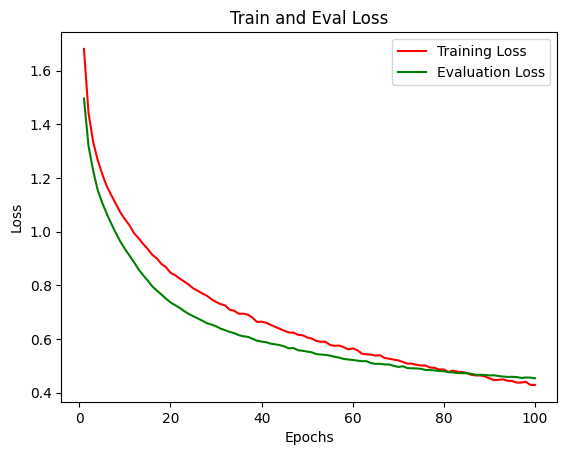

In [102]:
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training Loss')
plt.plot(range(1, len(train_loss)+1), eval_loss, 'g', label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Eval Loss')
plt.show()

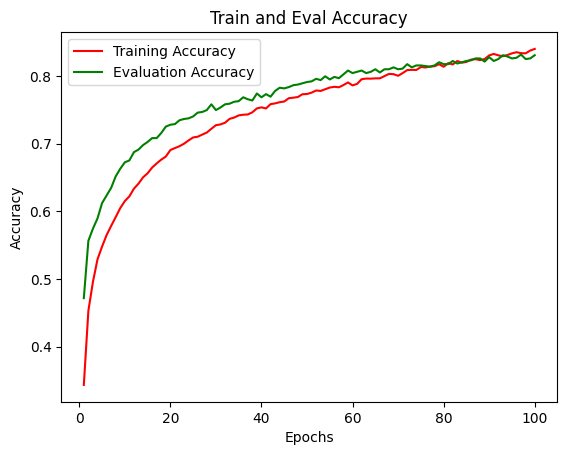

In [103]:
plt.plot(range(1, len(train_loss)+1), train_acc, 'r', label='Training Accuracy')
plt.plot(range(1, len(train_loss)+1), eval_acc, 'g', label='Evaluation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Eval Accuracy')
plt.show()

In [104]:
model_nn.save_weights('second_classifier1')


In [105]:
model_nn.evaluate(X_eval, y_eval)

34/34 [==============================] - 0s 6ms/step - loss: 0.4542 - accuracy: 0.8305 - f1_score: 0.7826


[0.4541681706905365,
 0.8305084705352783,
 array([0.6451613 , 0.82837534, 0.77165353, 0.7701863 , 0.8772322 ,
        0.80272114], dtype=float32)]